In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_61','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

In [2]:
class TrialInterval:
    _startTimeSamples = 0
    _endTimeSamples = 0
    _isStartTimeRelToResponse = True
    _isEndTimeRelToResponse = True
    _averageLickDelay = 0.2 * 30000

    def __init__(self,start,end,startresp,endresp):
        self._startTimeSamples = start
        self._endTimeSamples = end
        self._isStartTimeRelToResponse = startresp
        self._isEndTimeRelToResponse = endresp

    def _CalculateAvgLickDelay(self,sessionfile):
        go_responses = np.array(sessionfile.trials.response)[sessionfile.trials.go]
        go_starts = np.array(sessionfile.trials.starts)[sessionfile.trials.go]
        self._averageLickDelay = np.nanmean(go_responses - go_starts)

    def _ToTimestamp(self,sessionfile,trial):
        starttime = sessionfile.trials.starts[trial]
        if self._isStartTimeRelToResponse:
            starttime = sessionfile.trials.response[trial]
            if np.isnan(starttime):
                starttime = sessionfile.trials.starts[trial] + self._averageLickDelay
        starttime = starttime + self._startTimeSamples

        endtime = sessionfile.trials.starts[trial]
        if self._isEndTimeRelToResponse:
            endtime = sessionfile.trials.response[trial]
            if np.isnan(endtime):
                endtime = sessionfile.trials.starts[trial] + self._averageLickDelay
        endtime = endtime + self._endTimeSamples

        return [starttime,endtime]

    def _ToString(self):
        return f"Interval has start {self._startTimeSamples}, end {self._startTimeSamples}. startresp {self._isStartTimeRelToResponse} and endresp {self._isEndTimeRelToResponse}"

# def statisticalComparison(sessionfile,clust,preCondition,postCondition):
#     preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
#     postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
#     allConditions = ilep.getAllConditions(sessionfile,clust)
#     preTrials = allConditions[preCondition].trials
#     postTrials = allConditions[postCondition].trials
        
#     preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
#     postTrialRates = np.full_like(postTrials,np.nan,dtype='float')    
#     for idx,trial in enumerate(preTrials):
#         start,end = preInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
#     for idx,trial in enumerate(postTrials):
#         start,end = postInterval._ToTimestamp(sessionfile,trial)
#         spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
#         postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
#     pvalue_inc = mannwhitneyu(preTrialRates,postTrialRates,alternative='less').pvalue
#     pvalue_dec = mannwhitneyu(preTrialRates,postTrialRates,alternative='greater').pvalue
#     if pvalue_inc <= 0.05:# and np.median(postTrialRates) > np.median(preTrialRates):
#         label = 'increased'
#         pvalue = pvalue_inc
#     elif pvalue_dec <= 0.05:# and np.median(postTrialRates) < np.median(preTrialRates):
#         label = 'decreased'
#         pvalue = pvalue_dec
#     else:
#         label = 'unchanged'
#         pvalue = np.min(pvalue_inc,pvalue_dec)
#     return label,pvalue

def statisticalComparison(sessionfile,clust,preCondition,postCondition,preInterval,postInterval,iterations=5000,sample_percent=0.5,pthresh=0.95,modthresh=0.1):
    if pthresh < 0.5:
        raise Exception('pthresh cannot be less than 50%!')
    
    preInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    postInterval = TrialInterval(0,2.5*sessionfile.meta.fs,False,False)
    
    allConditions = ilep.getAllConditions(sessionfile,clust)
    preTrials = allConditions[preCondition].trials
    postTrials = allConditions[postCondition].trials
    
    if preCondition == postCondition:
        paired=True
    else:
        paired=False
    
    preTrialRates = np.full_like(preTrials,np.nan,dtype='float')
    postTrialRates = np.full_like(postTrials,np.nan,dtype='float')
    
    for idx,trial in enumerate(preTrials):
        start,end = preInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        preTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
        
    for idx,trial in enumerate(postTrials):
        start,end = postInterval._ToTimestamp(sessionfile,trial)
        spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=start,endtime=end)
        postTrialRates[idx] = len(spikes) / ((end-start)/sessionfile.meta.fs)
    
    increased=0
    decreased=0
    unchanged=0
    
    for i in range(iterations):
        if paired and len(preTrialRates) != len(preTrialRates):
            raise Exception('Non-equal length paired comparison')
        if paired:
            raise Exception('Paired comparison is not yet implemented')
        else:
            preIdxs = range(len(preTrialRates))
            postIdxs = range(len(postTrialRates))
            preIdxs = np.random.permutation(preIdxs)
            postIdxs = np.random.permutation(postIdxs)
            maxIdx = int(sample_percent*min(len(preIdxs),len(postIdxs)))
            preIdxs = preIdxs[range(maxIdx)]
            postIdxs = postIdxs[range(maxIdx)]
            
        preTrialsToCompare = preTrialRates[preIdxs]
        postTrialsToCompare = postTrialRates[postIdxs]
        
        deltaTrialMean = np.mean(postTrialsToCompare - preTrialsToCompare)
        
        if deltaTrialMean >= modthresh:
            increased+=1
        elif deltaTrialMean <= -modthresh:
            decreased+=1
        else:
            unchanged+=1
            
    p_increased = increased / (increased+decreased+unchanged)
    p_decreased = decreased / (increased+decreased+unchanged)
    p_unchanged = unchanged / (increased+decreased+unchanged)
    
    print(f"inc: {p_increased}, dec: {p_decreased}, unch: {p_unchanged}")
    
    if p_increased >= pthresh:
        label='increased'
        pval = 1-p_increased
    elif p_decreased >= pthresh:
        label='decreased'
        pval = 1-p_decreased
    elif p_unchanged >= pthresh:
        label='unchanged'
        pval = 1-p_unchanged
    else:
        label='inconclusive'
        pval=1-np.max([p_increased,p_decreased,p_unchanged])
    return label,pval

In [3]:
#this function calculates pval for one cluster(one cell)
def calculate_NCR_CR_pval(sessionfile,clust):

    #convert window(100ms) in samples
    sessionfile.meta.fs #30000 samples / second from blackrock
    window = sessionfile.meta.fs * 0.1
    trials_to_use = sessionfile.trim[clust].trimmed_trials

    #create array for stimulus period
    #tone play start time
    onset_window_start_time = np.zeros(len(trials_to_use))
    for idx, trial in enumerate(trials_to_use):
        onset_window_start_time[idx] = sessionfile.trials.starts[trial]

    #tone play end time
    onset_window_end_time = onset_window_start_time + window
    #offset window start time
    offset_window_start_time = onset_window_end_time
    #offset window end time
    offset_window_end_time = offset_window_start_time + window
    #stimulus array
    stimulus_array = np.zeros([len(onset_window_start_time),2,2])
    for i in range(len(onset_window_start_time)):
        stimulus_array[i] = [[onset_window_start_time[i],onset_window_end_time[i]],
                             [offset_window_start_time[i],offset_window_end_time[i]]
                            ]

    #create array for baseline period
    base_window1_start = onset_window_start_time - 3*window
    base_window1_end = onset_window_start_time - 2*window
    base_window2_start = base_window1_end
    base_window2_end = onset_window_start_time - 1*window
    base_window3_start = base_window2_end
    base_window3_end = onset_window_start_time

    baseline_array = np.zeros([len(base_window1_start),3,2])
    for i in range(len(onset_window_start_time)):
        baseline_array[i] = [[base_window1_start[i],base_window1_end[i]],
                             [base_window2_start[i],base_window2_end[i]],
                             [base_window3_start[i],base_window3_end[i]],
                            ]

    #evaluate spike count within stimulus window
    spikecounts_stimuluswindow = np.zeros((len(onset_window_start_time),2))

    for idx, t in enumerate(stimulus_array):
        #print(t[0][0])

        #spike count from onset window
        spikecount_onsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from offset window
        spikecount_offsetwindow = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        spikecounts_stimuluswindow[idx][0]=spikecount_onsetwindow
        spikecounts_stimuluswindow[idx][1]=spikecount_offsetwindow

    #evaluate spike count within baseline window
    spikecounts_basewindow = np.zeros((len(onset_window_start_time),3))

    for idx, t in enumerate(baseline_array):
        #print(t[0][0])

        #spike count from window1
        spikecount_base_window1 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[0][0],endtime=t[0][1]))

        #spike count from window2
        spikecount_base_window2 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[1][0],endtime=t[1][1]))

        #spike count from window3
        spikecount_base_window3 = len(ilep.getSpikeTimes(sessionfile,clust=clust,starttime=t[2][0],endtime=t[2][1]))

        spikecounts_basewindow[idx][0]=spikecount_base_window1
        spikecounts_basewindow[idx][1]=spikecount_base_window2
        spikecounts_basewindow[idx][2]=spikecount_base_window3

    ###### CODE BELOW HERE SHOULD LOOP 5000 TIMES 
    iterations = 5000
    #spikecounts_diff_mean_arr = []

    CR_evok_appear=0
    CR_sup_appear=0
    NCR_appear=0

    for i in range(iterations):

        #1.subsampled 90% of the spike count changes from baseline,
        #2.calculated the mean of these values, repeated this process 5000 times 

        #1.
        #subsampled 90% trials
        trials = range(len(spikecounts_stimuluswindow))
        trials_perm = np.random.permutation(trials)
        trials_subsamp = trials_perm[range(int(0.9*len(trials_perm)))]

        #calculate spike count changes from baseline in the subsample
        spikecounts_diff = []
        for trial_idx in trials_subsamp:
            random_stimulus = spikecounts_stimuluswindow[trial_idx][np.random.randint(2)]
            random_base = spikecounts_basewindow[trial_idx][np.random.randint(3)]
            spikecounts_diff.append(random_stimulus-random_base)

        #2. 
        #calculate the mean of the spike counts diff  
        spikecounts_diff_mean = np.mean(spikecounts_diff)
        #calculate the # of appearance in each categotiry in 5000 iterations
        if spikecounts_diff_mean > 0.1:
            CR_evok_appear+=1
        elif spikecounts_diff_mean < -0.1:
            CR_sup_appear+=1
        else:
            NCR_appear+=1
            
    p_value_evoked = CR_evok_appear/(iterations)
    p_value_suppressed = CR_sup_appear/(iterations)
    p_value_NCR = NCR_appear/(iterations)
    return p_value_evoked, p_value_suppressed, p_value_NCR

In [4]:
def get_response_times_with_default(sessionfile):
    response_times_in_trial = (sessionfile.trials.response-sessionfile.trials.starts)
    default_response_time = np.nanmedian(response_times_in_trial)

    response_times = sessionfile.trials.response
    nogo_trials = np.isnan(response_times)
    response_times[nogo_trials] = sessionfile.trials.starts[nogo_trials]+default_response_time
    return response_times

In [5]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Reviewer 2\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shou

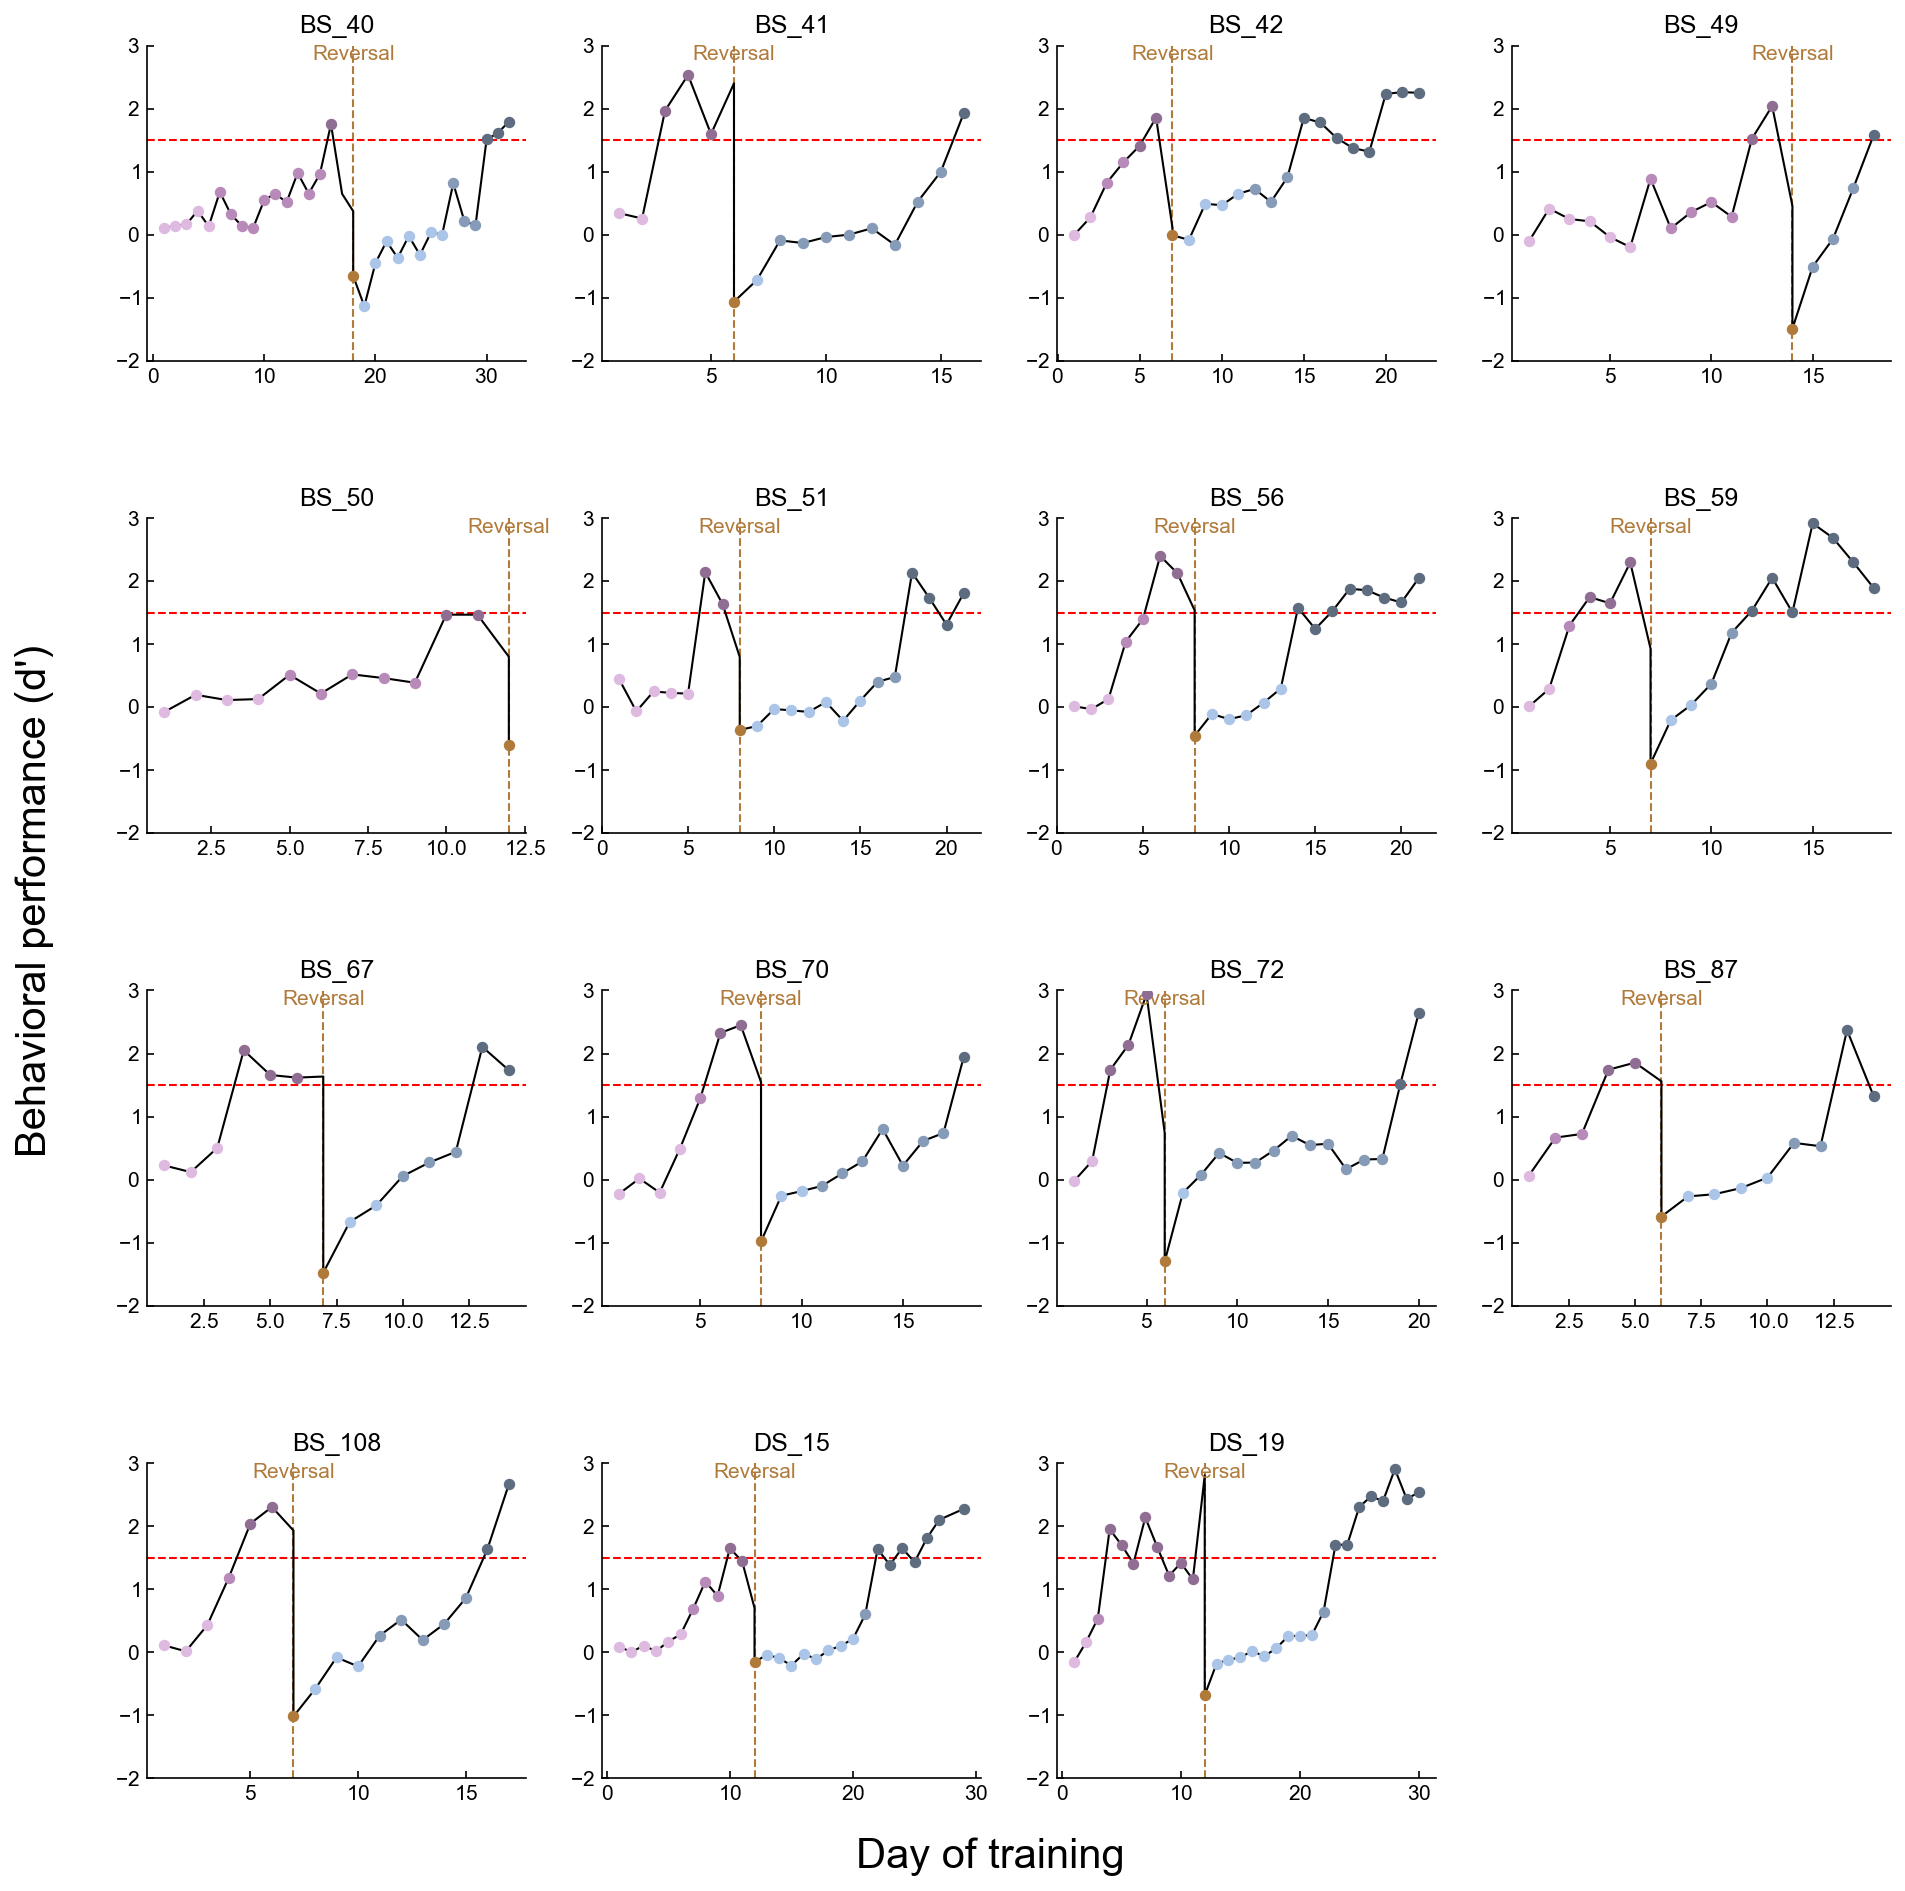

In [6]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(dualanimalnames,animalBehaviors,plot=True)

In [7]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
    
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:31<00:00, 23.53it/s]


In [8]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
        raise e
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:50<00:00, 36.48it/s] 

errors for: []


# Folder Reset

In [20]:
### Reset raster directory
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin','pngs'))
os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin','pdfs'))
for modcat in ['CR','NCR','Middle']:
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat,'pdfs'))
    os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat,'pngs'))
    for phase in ['pre early','pre late','pre expert','switch','post early','post late','post expert']:
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat,phase))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat,phase,'pdfs'))
        os.mkdir(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',modcat,phase,'pngs'))

# Plotting Code

In [9]:
def visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms=-250,Figure_end_time_ms=1000,xtickstouse=[0,500,1000],xticklabelstouse=None,align_to_choice=False,switch_cond='NA',limitToUse=None,bw_scott_factor = 3):
    buffer = 250
    sort_by_response_latency = False # Not implemented
    # bw_scott_factor = 3
    
    if align_to_choice:
        mn = 0.8
        spread = 0.5
    else:
        mn = 3.5
        spread = 2
    
    condition_of_interest = 'ERROR'
    assert (sessionfile.meta.task not in ['switch','opto switch','tuning_switch','second switch']) or (switch_cond != 'NA')
    if align_to_choice:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond+'_go'
        else:
            condition_of_interest = 'go'
    else:
        if sessionfile.meta.task in ['switch','opto switch','tuning_switch','second switch']:
            condition_of_interest = switch_cond
        else:
            condition_of_interest = 'all_trials'
    
    response_times = sessionfile.trials.response#get_response_times_with_default(sessionfile)
    ax2.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.tick_params(direction='out')
#     ax1.get_yaxis().set_visible(False)

    if align_to_choice:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation_choice
    else:
        Y = sessionfile.responsiveness[clust][condition_of_interest].FRmodulation
    if np.isnan(Y):
        color_to_use = 'k'
    else:
        color_to_use = NCR_CR_cmap( (Y-(mn-spread/2))/ (spread) )

    ### Get set of all trials to consider
    allConditions = ilep.getAllConditions(sessionfile,clust)
    trialsToPlot = allConditions[condition_of_interest].trials
    
    ### Reorder trials
    # Nogo then go
    trials_nogo = allConditions['creject'].trials
    trials_go = allConditions['falarm'].trials
    trialsToPlot = np.concatenate((trials_nogo,trials_go))
    len_nogo = len(trials_nogo)
    len_go = len(trials_go)
#     # Just nogo
#     trialsToPlot = allConditions['nogo'].trials
    ### End trial reordering

    ### Extract spike times
    clustSpikes = ilep.getSpikeTimes(sessionfile,clust=clust)
    trialSpikes = []
    trialStimTimes = []
    trialChoiceTimes = []
    for trial in trialsToPlot:

        #Need to get spike times for each trail...
        if align_to_choice:
            starttime = response_times[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = response_times[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        else:
            starttime = sessionfile.trials.starts[trial]+(Figure_start_time_ms-buffer)*sessionfile.meta.fs/1000
            endtime = sessionfile.trials.starts[trial]+(Figure_end_time_ms+buffer)*sessionfile.meta.fs/1000
        
        this_trial_spikes = ilep.getSpikeTimes(sessionfile,clust=clust,starttime=starttime,endtime=endtime)
        if align_to_choice:
            this_trial_spikes = this_trial_spikes - response_times[trial]
        else:
            this_trial_spikes = this_trial_spikes - sessionfile.trials.starts[trial]
        this_trial_spikes = this_trial_spikes * 1000 / sessionfile.meta.fs

        trialSpikes.append(this_trial_spikes)
        if align_to_choice:
            trialStimTimes.append(-(response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
            trialChoiceTimes.append(0)
        else:
            trialStimTimes.append(0)
            trialChoiceTimes.append((response_times[trial]-sessionfile.trials.starts[trial])/sessionfile.meta.fs*1000)
    trialSpikes = np.array(trialSpikes,dtype='object')

    #Plot Raster
    limit_to_use_nogo = len_nogo#30
    #NOGO
    count = 0
    for idx,trial in enumerate(trials_nogo):
        if count < limit_to_use_nogo:
            X = trialSpikes[idx]
            Y = np.ones_like(trialSpikes[idx])*count
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'purple'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                count += 1
    limit_to_use_nogo = count
    
    ###
    limit_to_use_go = len_go#30
    #GO
    print()
    count = 0
    for idx,trial in enumerate(trials_go):
        if count < limit_to_use_go:
            X = trialSpikes[idx+len_nogo]
            Y = np.ones_like(trialSpikes[idx+len_nogo])*(count+limit_to_use_nogo)
            R = (response_times[trial] - sessionfile.trials.starts[trial]) / 30
            # R = trialChoiceTimes[idx]
            mask = np.logical_and( np.greater(X,Figure_start_time_ms) , np.less(X,Figure_end_time_ms) )
            if np.sum(mask) > 0:
                X = X[mask]
                Y = Y[mask]
                this_trial_col = 'green'
                ax1.scatter(X,Y,color=this_trial_col,s=9.,marker=2,lw=1.5,zorder=0,clip_on=False)
                print(R)
                ax1.scatter(R,count+limit_to_use_nogo,c='k',s=10)
                count += 1
    limit_to_use_go = count
    
    ### Plot stimulus times
    if align_to_choice:
        X = np.array(trialStimTimes)
        Y = np.array(range(len(trialsToPlot)))
        mask = np.less(Y,30)
        X = X[mask]
        Y = Y[mask]+0.5
        ax1.scatter(X,Y,marker='o',fc='k',ec='k',zorder=1,s=10,lw=2)#,clip_on=False)
    ### Plot response times
    # if align_to_choice:
    #     ax1.scatter(trialChoiceTimes,range(len(trialsToPlot)),marker='o',fc='g',ec='g',zorder=1,s=10,lw=0)

#     if EIL == 'switch':
#        try:
#            switch_point = np.where(np.greater(trialsToPlot,200))[0][0]-0.5
#            ax1.axhline(switch_point,linestyle='--',lw=1,zorder=-10,color='k')
#        except:
#            pass
    
    #Legend
#     ax1.scatter([],[],marker='o',fc='k',ec='k',s=15,label='stimulus')
#     ax1.scatter([],[],marker='o',fc='g',ec='g',s=15,label='response')
#     lgd = ax1.legend(frameon=False,loc=(-0.25,1),ncol=2,fontsize=14)
    
    #Set trial limits
    max_trial_value = len(trialsToPlot)
    sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30])#,40,50,60,80,100,120,140,150,160,180,200])#,220,240,260,280,300,320,340,360,380,400])
    # sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200,220,240,260,280,300,320,340,360,380,400])
    idx_of_okay_limits = np.less_equal(sequence_of_possible_axis_limits,max_trial_value)
    valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
    if not len(valid_limits) > 0:
        return False,[]
    # limit = np.max(valid_limits)
    limit = limit_to_use_nogo+limit_to_use_go
    ax1.set_xlim([starttime,endtime])
    ax1.set_ylim([0,limit])
#     ax1.set_yticks([0,limit/2,limit])
#     ax1.set_ylabel('Trial')
    ax1.set_yticks([])
    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_nogo = trialSpikes[range(len_nogo)]
    numSplits = min(10,len(trialSpikes_nogo))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_nogo)):
        PSTHspikes = np.concatenate(trialSpikes_nogo[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='purple')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='purple',alpha=0.1,zorder=-10,lw=0)


    
    #Plot PSTH
    starttime = Figure_start_time_ms
    endtime = Figure_end_time_ms
    xrange = np.linspace(starttime,endtime,num=1000)
    trialSpikes_go = trialSpikes[range(len_nogo,len_nogo+len_go)]
    numSplits = min(10,len(trialSpikes_go))
    if numSplits < 2:
        return False,[] ### Return a failure
    FR = np.full((numSplits,len(xrange)),np.nan)
    kf = KFold(n_splits=numSplits)
    for idx,(_,train_index) in enumerate(kf.split(trialSpikes_go)):
        PSTHspikes = np.concatenate(trialSpikes_go[train_index])
        if len(PSTHspikes) == 0:
            FR[idx,:] = np.zeros(len(xrange))
            continue
        bw = len(PSTHspikes)**(-1./5) / bw_scott_factor
        KDE = gaussian_kde(PSTHspikes,bw_method=bw)
        FR[idx,:] = KDE.evaluate(xrange)
        FR[idx,:] = FR[idx,:] * len(PSTHspikes) / len(train_index) * 1000 #1000 is conversion to s/s because units are all in ms for this plot
    avg_FR = np.mean(FR,axis=0)
    sem_FR = sem(FR,axis=0)
    ax2.plot(xrange,avg_FR,lw=2,color='green')
    ax2.fill_between(xrange,avg_FR-sem_FR,avg_FR+sem_FR,color='green',alpha=0.1,zorder=-10,lw=0)







    
    #PSTH Limits
    if limitToUse is None:
        max_FR_value = np.max(avg_FR+sem_FR) * 1.1
        sequence_of_possible_axis_limits = np.array([1,2,4,6,8,10,12,16,20,30,40,50,60,80,100,120,140,150,160,180,200])
        idx_of_okay_limits = np.greater_equal(sequence_of_possible_axis_limits,max_FR_value)
        valid_limits = sequence_of_possible_axis_limits[idx_of_okay_limits]
        limit = np.min(valid_limits)
    else:
        limit  = limitToUse
    ###
#     limit = 30
    ###
    ax2.set_ylim([0,limit])
#     ax2.set_yticks([0,limit/2,limit])
#     ax2.set_yticklabels(['0',str(int(limit/2)),str(limit)])
    ax2.set_yticks([0,limit])
    ax2.set_yticklabels(['0',str(limit)])
    ylab = ax2.set_ylabel('')#Firing rate\n(spikes/s)')
    
    ### X limits
    ax1.set_xlim([starttime,endtime])
    ax2.set_xlim([starttime,endtime])
    ax1.set_xticks(np.array(xtickstouse))
    if xticklabelstouse is None:
        ax1.set_xticklabels(np.array(xtickstouse))#/1000)
    else:
        ax1.set_xticklabels(xticklabelstouse)#/1000)
    if align_to_choice:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to response (s)')
    else:
        xlab = ax1.set_xlabel('Time (ms)')#xlab = ax2.set_xlabel('Time relative to stimulus (s)')
    ax2.set_xticks([])
    
    ### Tone bar
    if not align_to_choice:
        ax2.plot([0,100],[limit]*2,c='k',lw=2,clip_on=False,zorder=10)
        
    ### Stim bar
    if not align_to_choice:
        ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
        ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='gray',zorder=-10,clip_on=False)
    else:
        ax1.plot([0,0],[0,93],linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
#         ax2.plot([0,0],ax2.get_ylim(),linestyle='--',lw=1,color='green',zorder=-10,clip_on=False)
    
    ################################################################
    
    #font size 15 old style. Font size 35 new style
    
    for axis in ['bottom','left']:
        ax1.spines[axis].set_linewidth(1.75)
        ax2.spines[axis].set_linewidth(1.75)
    ax1.tick_params(width=0)
    ax2.tick_params(width=1.75)
    for item in ([ax1.title, ax1.xaxis.label, ax1.yaxis.label] +
        ax1.get_xticklabels() + ax1.get_yticklabels()):
        item.set_fontsize(35)
    for item in ([ax2.title, ax2.xaxis.label, ax2.yaxis.label] +
        ax2.get_xticklabels() + ax2.get_yticklabels()):
        item.set_fontsize(35)

    go_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_go]
    nogo_spikes = [np.sum(np.logical_and(np.greater(s,-50),np.less(s,0))) for s in trialSpikes_nogo]
    pval = ttest_ind(go_spikes,nogo_spikes).pvalue
    if pval <= 0.05:
        ax2.set_title('p = '+str(pval))
    
    artists = [ylab,xlab]
    return True,artists

# Stim Rasters

1it [00:00,  4.25it/s]


153.26666666666668
1696.5
38.56666666666667
303.1333333333333
2.8333333333333335
128.0
231.66666666666666
109.66666666666667
335.7
4.1
fail

80.63333333333334
122.3
153.26666666666668
20.433333333333334
1696.5
488.1666666666667
38.56666666666667
303.1333333333333
2.8333333333333335
128.0
17.6
23.433333333333334
122.43333333333334
101.96666666666667
231.66666666666666
109.66666666666667
131.33333333333334
87.5
146.7
335.7
46.8
4.1
439.2
81.83333333333333


2it [00:02,  1.30s/it]


80.63333333333334
122.3
153.26666666666668
20.433333333333334
1696.5
2.3333333333333335
122.26666666666667
488.1666666666667
38.56666666666667
303.1333333333333
128.0
23.433333333333334
122.43333333333334
101.96666666666667
231.66666666666666
109.66666666666667
131.33333333333334
87.5
146.7
335.7
46.8
4.1
439.2
81.83333333333333


4it [00:04,  1.02s/it]


1696.5
122.26666666666667
488.1666666666667
38.56666666666667
303.1333333333333
17.6
23.433333333333334
122.43333333333334
101.96666666666667
231.66666666666666
109.66666666666667
131.33333333333334
87.5
46.8
4.1
fail

80.63333333333334
153.26666666666668
1696.5
2.3333333333333335
122.26666666666667
488.1666666666667
303.1333333333333
128.0
17.6
23.433333333333334
101.96666666666667
109.66666666666667
131.33333333333334
146.7
335.7
46.8
4.1
439.2
81.83333333333333


6it [00:06,  1.06it/s]


122.3
20.433333333333334
1696.5
122.26666666666667
488.1666666666667
38.56666666666667
303.1333333333333
128.0
23.433333333333334
122.43333333333334
101.96666666666667
231.66666666666666
109.66666666666667
131.33333333333334
87.5
146.7
335.7
46.8
4.1
439.2
fail

311.23333333333335
1347.6666666666667
31.433333333333334
2302.6666666666665
124.9
837.9
142.13333333333333
2179.4333333333334
225.8
1698.8666666666666
141.56666666666666
2006.6
1998.3
96.86666666666666
1089.2666666666667
1796.8666666666666
42.96666666666667
1779.0333333333333
2434.266666666667
53.36666666666667
103.5
10.9
18.466666666666665
18.8


8it [00:08,  1.12it/s]


Fail


9it [00:08,  1.42it/s]


2302.6666666666665
124.9
837.9
2179.4333333333334
225.8
1698.8666666666666
141.56666666666666
2006.6
1089.2666666666667
1796.8666666666666
42.96666666666667
1779.0333333333333
2434.266666666667
103.5
10.9
18.466666666666665
18.8
fail


11it [00:08,  2.39it/s]


1347.6666666666667
31.433333333333334
124.9
837.9
225.8
1698.8666666666666
141.56666666666666
2006.6
1998.3
96.86666666666666
1089.2666666666667
10.9
fail
Skipping Switch
Skipping Switch


15it [00:09,  5.32it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


20it [00:09,  8.82it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


22it [00:09,  8.91it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


28it [00:10, 12.16it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


32it [00:10, 12.49it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


36it [00:11, 12.15it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


40it [00:11, 11.87it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

343.8666666666667
350.6
2170.8333333333335
323.06666666666666
1000.9
28.1
386.3333333333333
179.76666666666668
122.06666666666666
45.03333333333333
110.36666666666666
82.23333333333333
4.5
105.6
223.06666666666666
341.1333333333333
357.5
657.8
304.8
21.933333333333334
127.2
110.66666666666667
142.96666666666667
25.766666666666666
70.83333333333333
100.13333333333334
3.1
154.2
52.1
90.7
87.56666666666666
41.7
131.36666666666667
43.56666666666667
124.16666666666667
104.4
73.5
74.53333333333333
29.166666666666668
68.53333333333333
98.53333333333333
49.166666666666664
126.36666666666666
91.73333333333333
17.766666666666666
109.63333333333334
277.43333333333334
164.5
218.86666666666667
833.2333333333333
1464.6333333333334


43it [00:14,  2.38it/s]


91.53333333333333
109.33333333333333
152.1
80.6
80.9
13.966666666666667
127.56666666666666
111.5
33.4
106.6
114.5
34.4
103.8
110.63333333333334
85.7
98.43333333333334
102.3
108.9
58.86666666666667
129.56666666666666
1215.9
70.4
140.26666666666668
343.8666666666667
350.6
340.0
99.93333333333334
109.33333333333333
136.5
70.2
11.4
118.23333333333333
223.06666666666666
341.1333333333333
357.5
267.1666666666667
75.26666666666667
304.8
142.96666666666667
70.83333333333333
3.1
154.2
131.36666666666667
43.56666666666667
46.833333333333336
29.166666666666668
49.166666666666664
17.766666666666666
277.43333333333334
218.86666666666667
1464.6333333333334
fail

25.7
76.2
194.9
79.73333333333333
64.23333333333333
83.53333333333333
20.166666666666668
19.433333333333334
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
87.73333333333333
86.16666666666667
36.8
124.66666666666667
80.76666666666667
57.233333333333334
130.0
90.3
51.9
110.8
40.2
81.9
124.16666666666667
17.633333333333333


44it [00:14,  2.28it/s]

62.4
145.3
94.56666666666666
72.1
103.56666666666666
28.933333333333334
98.53333333333333
106.6
162.73333333333332
100.2
90.83333333333333
34.03333333333333
91.93333333333334
12.566666666666666
62.166666666666664
63.666666666666664
36.6
110.36666666666666
64.03333333333333
35.5
37.0
68.73333333333333
74.46666666666667
113.3
103.96666666666667
261.8333333333333
95.2
174.56666666666666
fail

25.7
104.26666666666667
64.93333333333334
40.36666666666667
93.06666666666666
194.9
19.433333333333334
212.7
90.53333333333333
73.4
67.1
124.66666666666667
57.233333333333334
130.0
90.3
51.9
40.2
62.13333333333333
81.9
124.16666666666667
36.96666666666667
104.13333333333334
101.4
119.33333333333333
56.733333333333334
130.3
50.3
100.96666666666667
8.4
84.0
73.03333333333333
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667

45it [00:19,  1.27s/it]


25.7
76.2
104.26666666666667
64.93333333333334
40.36666666666667
93.06666666666666
194.9
291.1
64.23333333333333
239.6
42.46666666666667
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
73.4
87.73333333333333
67.1
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
57.233333333333334
130.0
90.3
51.9
110.8
40.2
81.9
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
73.03333333333333
1.4
68.4
72.5
136.93333333333334
10.833333333333334
72.0
33.43333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
7.266666666666667
46.7
92.46666666666667
44.266666666666666
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.033333

47it [00:23,  1.59s/it]


56.2
239.6
19.433333333333334
212.7
69.0
90.53333333333333
23.566666666666666
73.4
64.86666666666666
110.8
62.13333333333333
104.13333333333334
101.4
56.733333333333334
130.3
50.3
84.0
1.4
50.03333333333333
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
68.23333333333333
92.23333333333333
92.46666666666667
44.266666666666666
94.03333333333333
68.03333333333333
53.03333333333333
60.43333333333333
43.766666666666666
69.76666666666667
114.13333333333334
6.966666666666667
380.0
Fail

56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
58.733333333333334
1.4
68.4
50.03333333333333
10.833333333333334
72.0
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
7.266666666666667
46.7
92.46666666666667
100.66666666666667
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.033333333333

48it [00:24,  1.31s/it]

110.36666666666666
64.03333333333333
35.5
37.0
64.46666666666667
68.73333333333333
74.46666666666667
113.3
103.96666666666667
261.8333333333333
95.2
174.56666666666666
226.2
161.36666666666667
41.13333333333333
489.43333333333334
24.533333333333335
62.0
66.86666666666666
141.9
310.93333333333334
135.26666666666668
120.03333333333333
103.23333333333333
74.46666666666667
30.633333333333333
98.6
129.4
131.8
171.6
148.4
120.6
237.6
fail

93.06666666666666
83.53333333333333
20.166666666666668
239.6
42.46666666666667
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
73.4
87.73333333333333
67.1
64.86666666666666
124.66666666666667
80.76666666666667
17.6
57.233333333333334
51.9
110.8
62.13333333333333
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
73.03333333333333
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
33

50it [00:29,  1.65s/it]


42.46666666666667
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
73.4
87.73333333333333
67.1
40.2
124.16666666666667
17.633333333333333
101.4
51.733333333333334
95.76666666666667
130.3
50.3
8.4
73.03333333333333
1.4
72.5
136.93333333333334
50.03333333333333
72.0
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
62.13333333333333
7.266666666666667
46.7
92.46666666666667
100.66666666666667
44.266666666666666
94.03333333333333
19.3
81.6
12.5
68.03333333333333
43.766666666666666
28.466666666666665
57.9
130.63333333333333
96.86666666666666
28.033333333333335
69.76666666666667
98.76666666666667
67.03333333333333
6.966666666666667
Fail


51it [00:29,  1.29s/it]


50.3
8.4
84.0
73.03333333333333
58.733333333333334
72.5
136.93333333333334
72.0
33.43333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
68.23333333333333
77.13333333333334
62.13333333333333
7.266666666666667
46.7
92.46666666666667
100.66666666666667
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.03333333333333
43.766666666666666
28.466666666666665
57.9
70.83333333333333
130.63333333333333
96.86666666666666
48.46666666666667
68.83333333333333
28.033333333333335
69.76666666666667
98.76666666666667
67.03333333333333
114.13333333333334
145.0
69.16666666666667
85.46666666666667
151.83333333333334
60.46666666666667
62.4
145.3
94.56666666666666
72.1
28.933333333333334
98.53333333333333
106.6
162.73333333333332
100.2
12.566666666666666
62.166666666666664
63.666666666666664
36.6
110.36666666666666
64.03333333333333
35.5
37.0
64.46666666666667
68.73333333333333
74.46666666666667
113.3
103.96666666666667
261.8333333333333
95.

52it [00:30,  1.08s/it]

128.63333333333333
117.3
1929.9333333333334
1789.7666666666667
145.0
2145.0
1750.9
22.066666666666666
6.9
69.16666666666667
85.46666666666667
28.7
151.83333333333334
60.46666666666667
59.93333333333333
62.4
94.56666666666666
72.1
27.933333333333334
103.56666666666666
28.933333333333334
98.53333333333333
106.6
68.1
162.73333333333332
100.2
90.83333333333333
103.1
34.03333333333333
91.93333333333334
12.566666666666666
62.166666666666664
63.666666666666664
36.6
110.36666666666666
64.03333333333333
35.5
37.0
64.46666666666667
68.73333333333333
74.46666666666667
113.3
103.96666666666667
261.8333333333333
95.2
174.56666666666666
226.2
161.36666666666667
41.13333333333333
24.533333333333335
62.0
66.86666666666666
310.93333333333334
135.26666666666668
103.23333333333333
74.46666666666667
30.633333333333333
98.6
129.4
131.8
171.6
148.4
120.6
237.6
fail

104.26666666666667
64.93333333333334
40.36666666666667
79.73333333333333
54.766666666666666
19.166666666666668
64.23333333333333
83.53333333333

53it [00:35,  2.26s/it]


25.7
64.23333333333333
87.73333333333333
67.1
36.8
124.66666666666667
17.6
90.3
51.9
110.8
40.2
62.13333333333333
81.9
36.96666666666667
56.733333333333334
95.76666666666667
130.3
50.3
8.4
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
72.0
33.43333333333333
64.33333333333333
67.7
87.66666666666667
58.333333333333336
40.666666666666664
44.96666666666667
77.13333333333334
92.23333333333333
99.7
62.13333333333333
46.7
92.46666666666667
100.66666666666667
44.266666666666666
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.03333333333333
60.43333333333333
43.766666666666666
28.466666666666665
57.9
70.83333333333333
130.63333333333333
96.86666666666666
48.46666666666667
68.83333333333333
28.033333333333335
69.76666666666667
98.76666666666667
67.03333333333333
114.13333333333334
6.966666666666667
380.0
128.63333333333333
67.36666666666666
117.3
88.43333333333334
126.76666666666667
1929.9333333333334
1789.7666666666667
240.76666666666668
239.86666666666667
2145.0


54it [00:35,  1.79s/it]

64.46666666666667
68.73333333333333
74.46666666666667
161.36666666666667
24.533333333333335
141.9
120.03333333333333
30.633333333333333
98.6
131.8
fail

76.2
64.93333333333334
40.36666666666667
194.9
83.53333333333333
20.166666666666668
42.46666666666667
118.03333333333333
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
73.4
87.73333333333333
67.1
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
57.233333333333334
130.0
90.3
51.9
40.2
81.9
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
84.0
73.03333333333333
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
7.266

56it [00:41,  2.10s/it]


56.733333333333334
8.4
73.03333333333333
58.733333333333334
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
64.33333333333333
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.46666666666667
44.266666666666666
94.03333333333333
81.6
53.03333333333333
60.43333333333333
43.766666666666666
28.466666666666665
57.9
70.83333333333333
130.63333333333333
96.86666666666666
48.46666666666667
28.033333333333335
69.76666666666667
380.0
128.63333333333333
126.76666666666667
1929.9333333333334
1789.7666666666667
240.76666666666668
145.0
239.86666666666667
2145.0
1750.9
69.16666666666667
28.7
151.83333333333334
60.46666666666667
62.4
145.3
94.56666666666666
72.1
27.933333333333334
28.933333333333334
98.53333333333333
162.73333333333332
103.1
91.93333333333334
36.6
110.36666666666666
64.03333333333333
35.5
37.0
64.46666666666667
68.73333333333333
113.3
103.9

57it [00:46,  2.84s/it]


25.7
76.2
104.26666666666667
93.06666666666666
194.9
54.766666666666666
19.166666666666668
83.53333333333333
20.166666666666668
56.2
239.6
42.46666666666667
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
87.73333333333333
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
17.6
57.233333333333334
130.0
90.3
51.9
110.8
40.2
62.13333333333333
81.9
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
84.0
73.03333333333333
58.733333333333334
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
19.3
68.03333333333333
60.43333333333333
28.466666666

58it [00:46,  2.11s/it]

fail


59it [00:46,  1.58s/it]


36.8
110.8
130.3
73.03333333333333
58.733333333333334
1.4
136.93333333333334
72.0
58.333333333333336
77.13333333333334
92.23333333333333
92.46666666666667
12.5
68.03333333333333
28.466666666666665
57.9
70.83333333333333
130.63333333333333
96.86666666666666
69.76666666666667
114.13333333333334
6.966666666666667
380.0
128.63333333333333
240.76666666666668
145.0
1750.9
6.9
85.46666666666667
59.93333333333333
62.4
145.3
72.1
98.53333333333333
68.1
162.73333333333332
63.666666666666664
36.6
35.5
37.0
64.46666666666667
68.73333333333333
74.46666666666667
113.3
103.96666666666667
261.8333333333333
95.2
174.56666666666666
226.2
24.533333333333335
66.86666666666666
141.9
135.26666666666668
120.03333333333333
74.46666666666667
120.6
fail


60it [00:47,  1.24s/it]


25.7
56.2
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
17.6
57.233333333333334
130.0
110.8
40.2
95.76666666666667
130.3
73.03333333333333
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
89.0
40.666666666666664
44.96666666666667
92.23333333333333
44.266666666666666
94.03333333333333
19.3
81.6
12.5
60.43333333333333
57.9
70.83333333333333
130.63333333333333
96.86666666666666
48.46666666666667
68.83333333333333
28.033333333333335
98.76666666666667
67.03333333333333
128.63333333333333
67.36666666666666
117.3
88.43333333333334
145.0
239.86666666666667
1750.9
22.066666666666666
6.9
69.16666666666667
85.46666666666667
28.7
151.83333333333334
60.46666666666667
62.4
145.3
72.1
27.933333333333334
103.56666666666666
28.933333333333334
98.53333333333333
106.6
68.1
162.73333333333332
100.2
90.83333333333333
103.1
34.03333333333333
91.93333333333334
12.566

61it [00:51,  2.00s/it]


64.33333333333333
87.66666666666667
63.93333333333333
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
99.7
46.7
92.46666666666667
44.266666666666666
94.03333333333333
81.6
12.5
53.03333333333333
60.43333333333333
43.766666666666666
57.9
130.63333333333333
96.86666666666666
48.46666666666667
28.033333333333335
69.76666666666667
67.03333333333333
114.13333333333334
6.966666666666667
380.0
128.63333333333333
67.36666666666666
88.43333333333334
1789.7666666666667
240.76666666666668
145.0
2145.0
1750.9
22.066666666666666
6.9
69.16666666666667
85.46666666666667
28.7
151.83333333333334
60.46666666666667
59.93333333333333
62.4
145.3
94.56666666666666
27.933333333333334
103.56666666666666
68.1
90.83333333333333
103.1
34.03333333333333
12.566666666666666
62.166666666666664
63.666666666666664
36.6
110.36666666666666
64.03333333333333
35.5
64.46666666666667
68.73333333333333
74.46666666666667
113.3
103.96666666666667
95.2
174.56666666666666
161.36666666666667
41.133333333

62it [00:54,  2.27s/it]


56.2
42.46666666666667
19.433333333333334
118.03333333333333
212.7
90.53333333333333
87.73333333333333
64.86666666666666
124.66666666666667
80.76666666666667
110.8
62.13333333333333
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
84.0
73.03333333333333
58.733333333333334
1.4
72.5
136.93333333333334
10.833333333333334
72.0
33.43333333333333
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
7.266666666666667
46.7
92.46666666666667
100.66666666666667
44.266666666666666
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.03333333333333
60.43333333333333
43.766666666666666
28.466666666666665
57.9
70.83333333333333
130.63333333333333
96.86666666666666
68.83333333333333
28.033333333333335

63it [00:57,  2.73s/it]


90.53333333333333
23.566666666666666
62.666666666666664
73.4
87.73333333333333
67.1
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
17.6
57.233333333333334
130.0
90.3
51.9
110.8
40.2
62.13333333333333
81.9
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
84.0
73.03333333333333
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.23333333333333
77.13333333333334
92.23333333333333
99.7
62.13333333333333
7.266666666666667
46.7
92.46666666666667
100.66666666666667
44.266666666666666
94.03333333333333
19.3
81.6
12.5
68.03333333333333
53.03333333333333
60.43333333333333
43.766666666666666
28.466666666666665
57.9
70.83333333333

64it [01:02,  3.35s/it]


25.7
76.2
104.26666666666667
64.93333333333334
40.36666666666667
93.06666666666666
194.9
79.73333333333333
54.766666666666666
291.1
19.166666666666668
64.23333333333333
83.53333333333333
20.166666666666668
56.2
239.6
42.46666666666667
19.433333333333334
118.03333333333333
212.7
69.0
90.53333333333333
23.566666666666666
62.666666666666664
73.4
87.73333333333333
67.1
64.86666666666666
86.16666666666667
36.8
124.66666666666667
80.76666666666667
17.6
57.233333333333334
130.0
90.3
51.9
110.8
40.2
62.13333333333333
81.9
124.16666666666667
36.96666666666667
17.633333333333333
104.13333333333334
101.4
51.733333333333334
119.33333333333333
56.733333333333334
95.76666666666667
130.3
50.3
100.96666666666667
8.4
84.0
73.03333333333333
58.733333333333334
1.4
68.4
72.5
136.93333333333334
50.03333333333333
10.833333333333334
72.0
33.43333333333333
64.33333333333333
67.7
89.0
87.66666666666667
63.93333333333333
58.333333333333336
98.43333333333334
40.666666666666664
44.96666666666667
68.2333333333333

66it [01:08,  2.81s/it]


35.93333333333333
227.46666666666667
419.93333333333334
562.4
1513.5666666666666
2441.766666666667
1067.8333333333333
284.26666666666665
335.93333333333334
300.7
1298.3666666666666
65.4
255.6
281.3666666666667
800.1
1476.4666666666667
fail


67it [01:08,  2.06s/it]


932.2666666666667
792.5333333333333
1699.0
730.5666666666667
fail


68it [01:09,  1.65s/it]


368.8333333333333
1185.9666666666667
255.6
281.3666666666667
197.6
267.6
259.6
45.8
104.73333333333333
169.06666666666666
647.6333333333333
932.2666666666667
2068.133333333333
1193.2333333333333
792.5333333333333
1699.0
730.5666666666667
fail

1155.7333333333333
124.0
145.36666666666667
2104.3
1824.5666666666666
156.56666666666666
1319.0333333333333
1991.9666666666667
356.1666666666667
2450.633333333333
80.73333333333333
355.1333333333333
1333.7666666666667
0.3333333333333333
247.26666666666668
179.2
242.06666666666666
139.46666666666667
145.0
2050.6666666666665
32.56666666666667
62.833333333333336
2225.4666666666667
661.9666666666667
34.1
46.13333333333333
270.26666666666665
1927.3
1072.7
368.5
36.233333333333334
1947.0333333333333
274.1666666666667
242.1
293.1
277.96666666666664
54.43333333333333
503.7
4.566666666666666
707.3666666666667
1714.3
38.0
274.8333333333333
179.16666666666666
34.8
14.6
260.0
29.533333333333335
94.23333333333333
49.3
66.36666666666666
142.66666666666666
139

69it [01:14,  2.91s/it]


1155.7333333333333
200.7
114.6
156.56666666666666
80.73333333333333
1333.7666666666667
0.3333333333333333
32.56666666666667
1072.7
368.5
221.93333333333334
274.1666666666667
242.1
293.1
277.96666666666664
54.43333333333333
503.7
4.566666666666666
707.3666666666667
1714.3
274.8333333333333
179.16666666666666
34.8
260.0
29.533333333333335
94.23333333333333
49.3
142.66666666666666
139.66666666666666
22.233333333333334
151.46666666666667
321.23333333333335
331.26666666666665
165.93333333333334
287.26666666666665
77.5
285.93333333333334
1084.9
123.0
41.46666666666667
17.433333333333334
111.26666666666667
734.2333333333333
136.26666666666668
1811.3666666666666
222.06666666666666
300.43333333333334
2465.6666666666665
98.76666666666667
75.16666666666667
140.7
326.3333333333333
156.06666666666666
76.56666666666666
192.96666666666667
30.533333333333335
90.56666666666666
267.6333333333333
35.93333333333333
227.46666666666667
154.03333333333333
202.4
198.1
46.6
340.8666666666667
419.9333333333333

70it [01:20,  3.72s/it]


29.533333333333335
94.23333333333333
151.46666666666667
321.23333333333335
331.26666666666665
285.93333333333334
1811.3666666666666
300.43333333333334
2465.6666666666665
140.7
326.3333333333333
202.4
198.1
419.93333333333334
562.4
1513.5666666666666
2441.766666666667
121.66666666666667
1067.8333333333333
254.33333333333334
1736.9333333333334
284.26666666666665
184.3
1439.9666666666667
26.333333333333332
335.93333333333334
75.76666666666667
188.0
300.7
368.8333333333333
1298.3666666666666
346.23333333333335
135.23333333333332
1185.9666666666667
2186.4333333333334
255.6
197.6
467.03333333333336
220.23333333333332
73.6
267.6
259.6
800.1
2085.9666666666667
1028.7666666666667
1820.5333333333333
1476.4666666666667
2206.4666666666667
300.26666666666665
207.03333333333333
653.7333333333333
1345.3
169.06666666666666
199.13333333333333
932.2666666666667
2068.133333333333
730.5666666666667
51.166666666666664


72it [01:23,  2.51s/it]


80.73333333333333
0.3333333333333333
247.26666666666668
221.93333333333334
179.16666666666666
29.533333333333335
331.26666666666665
1513.5666666666666
2441.766666666667
2359.5
121.66666666666667
1067.8333333333333
254.33333333333334
1736.9333333333334
184.3
26.333333333333332
188.0
24.066666666666666
300.7
368.8333333333333
66.36666666666666
221.06666666666666
2186.4333333333334
126.23333333333333
147.43333333333334
73.6
267.6
259.6
800.1
45.8
2085.9666666666667
1028.7666666666667
1820.5333333333333
1476.4666666666667
2206.4666666666667
162.13333333333333
2085.3
300.26666666666665
169.06666666666666
932.2666666666667
fail

1155.7333333333333
124.0
200.7
114.6
145.36666666666667
2104.3
1824.5666666666666
37.166666666666664
156.56666666666666
1991.9666666666667
2450.633333333333
1333.7666666666667
0.3333333333333333
120.56666666666666
139.46666666666667
62.833333333333336
2225.4666666666667
46.13333333333333
221.93333333333334
242.1
277.96666666666664
54.43333333333333
14.6
260.0
29.533

73it [01:27,  2.78s/it]


114.6
1824.5666666666666
37.166666666666664
0.3333333333333333
49.0
139.46666666666667
1072.7
368.5
277.96666666666664
707.3666666666667
1714.3
274.8333333333333
179.16666666666666
34.8
260.0
29.533333333333335
94.23333333333333
66.36666666666666
142.66666666666666
22.233333333333334
321.23333333333335
331.26666666666665
165.93333333333334
287.26666666666665
285.93333333333334
1084.9
123.0
41.46666666666667
111.26666666666667
734.2333333333333
569.8
86.3
136.26666666666668
1811.3666666666666
222.06666666666666
300.43333333333334
2465.6666666666665
98.76666666666667
75.16666666666667
326.3333333333333
156.06666666666666
76.56666666666666
192.96666666666667
30.533333333333335
90.56666666666666
35.93333333333333
227.46666666666667
154.03333333333333
202.4
46.6
340.8666666666667
419.93333333333334
562.4
1067.8333333333333
254.33333333333334
141.3
284.26666666666665
184.3
1439.9666666666667
26.333333333333332
188.0
368.8333333333333
1298.3666666666666
237.93333333333334
65.4
346.2333333333

74it [01:30,  3.06s/it]


1824.5666666666666
37.166666666666664
156.56666666666666
1319.0333333333333
1991.9666666666667
356.1666666666667
2450.633333333333
80.73333333333333
355.1333333333333
1333.7666666666667
0.3333333333333333
247.26666666666668
49.0
179.2
120.56666666666666
242.06666666666666
139.46666666666667
145.0
2050.6666666666665
32.56666666666667
62.833333333333336
2225.4666666666667
661.9666666666667
34.1
46.13333333333333
270.26666666666665
1927.3
1072.7
368.5
1947.0333333333333
221.93333333333334
274.1666666666667
242.1
293.1
277.96666666666664
54.43333333333333
503.7
4.566666666666666
707.3666666666667
1714.3
38.0
274.8333333333333
179.16666666666666
201.4
34.8
14.6
260.0
29.533333333333335
94.23333333333333
49.3
66.36666666666666
142.66666666666666
139.66666666666666
22.233333333333334
151.46666666666667
321.23333333333335
331.26666666666665
165.93333333333334
287.26666666666665
77.5
285.93333333333334
1084.9
123.0
41.46666666666667
17.433333333333334
111.26666666666667
734.2333333333333
569.8

76it [01:36,  2.76s/it]


200.7
1824.5666666666666
37.166666666666664
156.56666666666666
1319.0333333333333
1991.9666666666667
356.1666666666667
80.73333333333333
355.1333333333333
1333.7666666666667
0.3333333333333333
247.26666666666668
49.0
179.2
120.56666666666666
139.46666666666667
2225.4666666666667
34.1
46.13333333333333
270.26666666666665
36.233333333333334
1947.0333333333333
221.93333333333334
242.1
54.43333333333333
274.8333333333333
34.8
14.6
49.3
66.36666666666666
139.66666666666666
22.233333333333334
331.26666666666665
77.5
1084.9
123.0
111.26666666666667
86.3
136.26666666666668
300.43333333333334
2465.6666666666665
212.4
98.76666666666667
75.16666666666667
326.3333333333333
156.06666666666666
192.96666666666667
30.533333333333335
267.6333333333333
35.93333333333333
227.46666666666667
154.03333333333333
198.1
562.4
2441.766666666667
2359.5
1067.8333333333333
254.33333333333334
141.3
1736.9333333333334
284.26666666666665
184.3
335.93333333333334
75.76666666666667
300.7
368.8333333333333
237.93333333

77it [01:40,  3.01s/it]


124.0
200.7
179.2
32.56666666666667
270.26666666666665
1947.0333333333333
221.93333333333334
242.1
277.96666666666664
4.566666666666666
179.16666666666666
14.6
66.36666666666666
77.5
1084.9
17.433333333333334
111.26666666666667
734.2333333333333
136.26666666666668
222.06666666666666
2465.6666666666665
212.4
75.16666666666667
326.3333333333333
156.06666666666666
76.56666666666666
30.533333333333335
90.56666666666666
267.6333333333333
35.93333333333333
154.03333333333333
202.4
198.1
340.8666666666667
2441.766666666667
121.66666666666667
1067.8333333333333
141.3
1736.9333333333334
335.93333333333334
188.0
24.066666666666666
300.7
255.6
281.3666666666667
197.6
467.03333333333336
126.23333333333333
73.6
267.6
259.6
647.6333333333333
2068.133333333333
792.5333333333333
730.5666666666667


79it [01:43,  2.23s/it]


139.46666666666667
2050.6666666666665
661.9666666666667
1072.7
36.233333333333334
274.1666666666667
293.1
151.46666666666667
77.5
136.26666666666668
1811.3666666666666
300.43333333333334
326.3333333333333
198.1
46.6
1513.5666666666666
26.333333333333332
188.0
1185.9666666666667
1820.5333333333333
300.26666666666665
169.06666666666666
340.03333333333336
199.13333333333333
fail

145.36666666666667
2104.3
1824.5666666666666
80.73333333333333
355.1333333333333
1333.7666666666667
0.3333333333333333
49.0
139.46666666666667
145.0
32.56666666666667
2225.4666666666667
34.1
1927.3
36.233333333333334
274.1666666666667
242.1
293.1
54.43333333333333
503.7
4.566666666666666
707.3666666666667
274.8333333333333
179.16666666666666
201.4
34.8
260.0
29.533333333333335
94.23333333333333
49.3
66.36666666666666
142.66666666666666
22.233333333333334
151.46666666666667
321.23333333333335
331.26666666666665
165.93333333333334
287.26666666666665
77.5
285.93333333333334
123.0
41.46666666666667
17.43333333333333

80it [01:49,  3.19s/it]


200.7
2104.3
355.1333333333333
49.0
179.2
145.0
32.56666666666667
2225.4666666666667
661.9666666666667
34.1
46.13333333333333
270.26666666666665
1072.7
368.5
36.233333333333334
1947.0333333333333
274.1666666666667
242.1
293.1
277.96666666666664
4.566666666666666
707.3666666666667
1714.3
38.0
274.8333333333333
179.16666666666666
201.4
14.6
260.0
29.533333333333335
94.23333333333333
49.3
66.36666666666666
142.66666666666666
139.66666666666666
22.233333333333334
151.46666666666667
165.93333333333334
287.26666666666665
77.5
285.93333333333334
1084.9
123.0
41.46666666666667
17.433333333333334
734.2333333333333
569.8
86.3
136.26666666666668
300.43333333333334
2465.6666666666665
212.4
98.76666666666667
75.16666666666667
140.7
326.3333333333333
156.06666666666666
192.96666666666667
30.533333333333335
90.56666666666666
267.6333333333333
35.93333333333333
227.46666666666667
154.03333333333333
198.1
46.6
340.8666666666667
419.93333333333334
562.4
2441.766666666667
2359.5
121.66666666666667
1067.

81it [01:53,  3.62s/it]


111.26666666666667
734.2333333333333
569.8
86.3
136.26666666666668
1811.3666666666666
222.06666666666666
300.43333333333334
140.7
326.3333333333333
156.06666666666666
76.56666666666666
192.96666666666667
30.533333333333335
90.56666666666666
267.6333333333333
35.93333333333333
227.46666666666667
154.03333333333333
202.4
198.1
46.6
340.8666666666667
419.93333333333334
562.4
1513.5666666666666
2441.766666666667
2359.5
121.66666666666667
1067.8333333333333
254.33333333333334
141.3
1736.9333333333334
284.26666666666665
184.3
1439.9666666666667
26.333333333333332
335.93333333333334
75.76666666666667
188.0
24.066666666666666
300.7
368.8333333333333
1298.3666666666666
65.4
346.23333333333335
135.23333333333332
1041.7333333333333
317.46666666666664
66.36666666666666
221.06666666666666
1185.9666666666667
281.3666666666667
272.9
197.6
467.03333333333336
220.23333333333332
126.23333333333333
147.43333333333334
267.6
259.6
800.1
45.8
2085.9666666666667
85.7
1028.7666666666667
1820.5333333333333
14

83it [01:57,  2.60s/it]


Fail


84it [01:58,  2.00s/it]C:\Users\4thgr\AppData\Local\Temp\ipykernel_41784\3123486717.py:161: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax1.set_ylim([0,limit])
85it [01:58,  1.45s/it]


Fail

fail


87it [01:58,  1.24it/s]


Fail

fail


88it [01:58,  1.61it/s]


fail


90it [01:59,  2.47it/s]


Fail

Fail


92it [01:59,  3.42it/s]


Fail

fail


94it [01:59,  4.59it/s]


Fail

Fail


96it [02:00,  3.77it/s]


Fail

Fail


98it [02:00,  4.57it/s]


fail

fail


100it [02:01,  5.39it/s]


Fail

Fail


103it [02:01,  8.15it/s]


Fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


106it [02:01, 12.56it/s]

Skipping Switch
Skipping Switch


111it [02:02, 10.26it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


117it [02:02, 15.92it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


123it [02:02, 20.16it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

33.666666666666664
48.0
6.6
123.96666666666667
59.36666666666667
90.66666666666667
1490.4
2387.233333333333
417.06666666666666
137.5
202.0
236.76666666666668
204.43333333333334
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666666666664
182.73333333333332
77.06666666666666
90.43333333333334
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666

126it [02:09,  1.38it/s]


33.666666666666664
48.0
6.6
123.96666666666667
59.36666666666667
90.66666666666667
1490.4
2387.233333333333
417.06666666666666
137.5
202.0
236.76666666666668
204.43333333333334
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666666666664
182.73333333333332
77.06666666666666
90.43333333333334
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.

128it [02:16,  1.36s/it]


33.666666666666664
123.96666666666667
59.36666666666667
90.66666666666667
1490.4
2387.233333333333
417.06666666666666
137.5
202.0
236.76666666666668
204.43333333333334
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666666666664
182.73333333333332
77.06666666666666
90.43333333333334
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.366666666

131it [02:23,  1.62s/it]


204.26666666666668
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
77.06666666666666
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.3666666666667
286.3333333333333
331.8333333333333
1497.5
316.3333333333333
290.96666666666664
2138.866666666667
232.33333333333334
179.26666666666668
2258.233333333333
228.76666666666668
227.33333333333334
228.76666666666668
250.23333333333332
1596.9666666666667
262.8666666666667
220.13333333333333
179.33333333333334
244.166

133it [02:25,  1.36s/it]


261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
380.4
565.9666666666667
139.86666666666667
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.3666666666667
286.3333333333333
331.8333333333333
316.3333333333333
232.33333333333334
179.26666666666668
2258.233333333333
228.76666666666668
227.33333333333334
250.23333333333332
179.33333333333334
244.16666666666666
234.53333333333333
132.06666666666666
449.6333333333333
252.76666666666668
fail

33.666666666666664
48.0
6.6
123.96666666666667
59.36666666666667
90.66666666666667
1490.4
2387.233333333333
417.06666666666666
137.5
202.0
236.76666666666668
204.43333333333334
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666

134it [02:29,  2.10s/it]


417.06666666666666
137.5
202.0
204.43333333333334
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666666666664
182.73333333333332
77.06666666666666
90.43333333333334
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.3666666666667
286.3333333333333
331.8333333333333
1497.5
316.3333333333333
290.96666666666664
2138.866666666667
232.33333333333

135it [02:33,  2.42s/it]


33.666666666666664
48.0
6.6
123.96666666666667
59.36666666666667
90.66666666666667
1490.4
2387.233333333333
417.06666666666666
137.5
202.0
236.76666666666668
50.5
231.16666666666666
204.26666666666668
169.26666666666668
265.3
37.96666666666667
75.7
242.76666666666668
390.96666666666664
101.43333333333334
210.1
217.23333333333332
22.833333333333332
4.266666666666667
1283.9666666666667
209.96666666666667
185.5
381.96666666666664
182.73333333333332
77.06666666666666
90.43333333333334
4.866666666666666
43.8
355.53333333333336
139.4
203.6
205.3
640.0
50.0
273.1
155.3
246.96666666666667
298.96666666666664
261.6666666666667
218.16666666666666
231.5
179.36666666666667
495.2
203.53333333333333
404.43333333333334
95.8
8.9
340.6333333333333
380.4
288.23333333333335
285.3
228.63333333333333
565.9666666666667
139.86666666666667
81.8
376.06666666666666
259.4
307.03333333333336
331.3
294.06666666666666
289.56666666666666
389.43333333333334
317.76666666666665
292.8333333333333
328.3666666666667
286.3

136it [02:36,  2.73s/it]


65.7
139.76666666666668
178.76666666666668
19.766666666666666
170.36666666666667
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
34.36666666666667
178.8
242.3
317.8
190.83333333333334
60.63333333333333
172.0
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
178.96666666666667
192.2
114.63333333333334
197.1
158.3
196.0
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
191.56666666666666
171.43333333333334
203.43333333333334
197.93333333333334
343.93333333333334
179.73333333333332
198.46666666666667
57.93333333333333
202.0
182.33333333333334
202.26666666666668
1788.9666666666667
231.3
181.03333333333333
189.26666666666668
480.23333333333335
140.06666666666666
179.1
186.33333333333334
186.43333333333334
104.5
204.96666666666667
222.5
245.3
207.6
1777.7
1854.6333333333334
711.0666666666667
241.26666666666668


137it [02:39,  2.75s/it]


8.2
281.23333333333335
10.433333333333334
30.8
157.23333333333332
37.63333333333333
43.63333333333333
77.73333333333333
4.466666666666667
39.9
65.7
139.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
74.1
86.33333333333333
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
94.56666666666666
204.6
177.6
34.36666666666667
242.3
317.8
60.63333333333333
172.0
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
178.96666666666667
192.2
114.63333333333334
942.6
197.1
158.3
196.0
193.4
0.06666666666666667
9.3
205.86666666666667
191.56666666666666
171.43333333333334
203.43333333333334
197.93333333333334
343.93333333333334
179.73333333333332
198.46666666666667
57.93333333333333
202.0
182.33333333333334
202.26666666666668
1788.9666666666667
231.3
181.03333333333333
189.26666666666668
480.23333333333335
140.06666666666666
1718.4
179.1
186.33333333333334
186.43333333333334
104.5
204.96

138it [02:43,  3.01s/it]


8.2
281.23333333333335
36.96666666666667
259.4
167.26666666666668
85.86666666666666
30.8
157.23333333333332
2178.733333333333
38.8
129.76666666666668
155.33333333333334
17.566666666666666
146.76666666666668
37.63333333333333
40.766666666666666
105.86666666666666
67.66666666666667
172.9
175.56666666666666
181.3
179.26666666666668
37.266666666666666
4.466666666666667
156.3
2381.3333333333335
149.96666666666667
0.16666666666666666
177.16666666666666
139.03333333333333
144.46666666666667
39.9
19.766666666666666
170.36666666666667
86.33333333333333
168.86666666666667
158.1
179.8
204.6
170.06666666666666
163.4
34.36666666666667
242.3
317.8
190.83333333333334
60.63333333333333
172.0
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
178.96666666666667
192.2
114.63333333333334
942.6
197.1
196.0
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
191.56666666666666
203.43333333333334
197.93333333333334
343.93333333333334
179.73333

139it [02:46,  3.12s/it]


8.2
281.23333333333335
36.96666666666667
259.4
10.433333333333334
167.26666666666668
30.8
2178.733333333333
38.8
129.76666666666668
2381.3333333333335
141.43333333333334
149.96666666666667
0.16666666666666666
121.2
144.46666666666667
159.06666666666666
56.5
141.23333333333332
21.733333333333334
39.9
65.7
139.76666666666668
160.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
168.83333333333334
74.1
170.36666666666667
86.33333333333333
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
94.56666666666666
204.6
170.06666666666666
163.4
177.6
34.36666666666667
178.8
242.3
317.8
190.83333333333334
60.63333333333333
172.0
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
178.96666666666667
192.2
114.63333333333334
942.6
197.1
158.3
196.0
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
191.56666666666666
171.43333333333334


140it [02:47,  2.36s/it]

fail

188.2
141.43333333333334
149.96666666666667
0.16666666666666666
177.16666666666666
139.03333333333333
121.2
144.46666666666667
159.06666666666666
143.93333333333334
56.5
1.6666666666666667
141.23333333333332
21.733333333333334
39.9
65.7
139.76666666666668
160.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
168.83333333333334
74.1
170.36666666666667
86.33333333333333
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
94.56666666666666
204.6
170.06666666666666
163.4
177.6
34.36666666666667
178.8
242.3
317.8
190.83333333333334
60.63333333333333
172.0
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
178.96666666666667
192.2
114.63333333333334
942.6
197.1
158.3
196.0
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
191.56666666666666
171.43333333333334
203.43333333333334
197.93333333333334
343.93333333333334
179.733

141it [02:51,  2.74s/it]


149.96666666666667
0.16666666666666666
139.03333333333333
121.2
143.93333333333334
1.6666666666666667
141.23333333333332
21.733333333333334
160.76666666666668
53.53333333333333
168.83333333333334
170.36666666666667
86.33333333333333
151.73333333333332
190.26666666666668
158.1
204.6
170.06666666666666
177.6
60.63333333333333
172.0
170.73333333333332
276.6333333333333
216.7
2108.5666666666666
21.5
192.2
942.6
197.1
196.0
9.3
205.86666666666667
97.13333333333334
191.56666666666666
171.43333333333334
197.93333333333334
343.93333333333334
179.73333333333332
57.93333333333333
202.0
231.3
181.03333333333333
189.26666666666668
480.23333333333335
140.06666666666666
1718.4
179.1
186.43333333333334
204.96666666666667
222.5
245.3
1777.7


142it [02:54,  2.82s/it]


37.266666666666666
4.466666666666667
29.733333333333334
2381.3333333333335
188.2
141.43333333333334
0.16666666666666666
139.03333333333333
159.06666666666666
141.23333333333332
21.733333333333334
160.76666666666668
19.766666666666666
53.53333333333333
74.1
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
158.1
179.8
204.6
170.06666666666666
163.4
177.6
34.36666666666667
178.8
190.83333333333334
60.63333333333333
170.73333333333332
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
192.2
114.63333333333334
197.1
158.3
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
203.43333333333334
343.93333333333334
179.73333333333332
198.46666666666667
57.93333333333333
202.0
182.33333333333334
202.26666666666668
1788.9666666666667
231.3
189.26666666666668
480.23333333333335
140.06666666666666
179.1
186.33333333333334
186.43333333333334
104.5
204.96666666666667
207.6
1777.7
1854.6333333333334
711.0666666666667
241.2666

143it [02:56,  2.80s/it]


10.433333333333334
30.8
157.23333333333332
2178.733333333333
38.8
129.76666666666668
17.566666666666666
105.76666666666667
146.76666666666668
37.63333333333333
40.766666666666666
105.86666666666666
77.73333333333333
134.93333333333334
175.56666666666666
31.466666666666665
51.833333333333336
4.466666666666667
156.3
125.86666666666666
29.733333333333334
2381.3333333333335
150.03333333333333
188.2
141.43333333333334
149.96666666666667
0.16666666666666666
177.16666666666666
139.03333333333333
121.2
144.46666666666667
159.06666666666666
143.93333333333334
56.5
1.6666666666666667
141.23333333333332
21.733333333333334
39.9
65.7
139.76666666666668
160.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
168.83333333333334
74.1
170.36666666666667
86.33333333333333
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
94.56666666666666
204.6
170.06666666666666
163.4
177.6
34.36666666666667
178.8
242.3
317.

145it [03:01,  2.34s/it]


157.23333333333332
2178.733333333333
38.8
129.76666666666668
155.33333333333334
17.566666666666666
105.76666666666667
146.76666666666668
37.63333333333333
43.63333333333333
105.86666666666666
77.73333333333333
134.93333333333334
67.66666666666667
172.9
175.56666666666666
212.73333333333332
224.2
68.16666666666667
181.3
31.466666666666665
51.833333333333336
179.26666666666668
37.266666666666666
4.466666666666667
156.3
125.86666666666666
29.733333333333334
2381.3333333333335
150.03333333333333
188.2
141.43333333333334
149.96666666666667
0.16666666666666666
177.16666666666666
139.03333333333333
121.2
144.46666666666667
159.06666666666666
143.93333333333334
56.5
1.6666666666666667
141.23333333333332
21.733333333333334
39.9
65.7
139.76666666666668
160.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
168.83333333333334
74.1
170.36666666666667
86.33333333333333
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666

146it [03:05,  2.84s/it]


181.3
51.833333333333336
179.26666666666668
37.266666666666666
4.466666666666667
156.3
125.86666666666666
29.733333333333334
2381.3333333333335
150.03333333333333
188.2
141.43333333333334
0.16666666666666666
177.16666666666666
121.2
144.46666666666667
159.06666666666666
143.93333333333334
56.5
1.6666666666666667
141.23333333333332
39.9
65.7
139.76666666666668
160.76666666666668
178.76666666666668
19.766666666666666
53.53333333333333
168.83333333333334
170.36666666666667
86.33333333333333
182.36666666666667
195.26666666666668
151.73333333333332
210.96666666666667
168.86666666666667
190.26666666666668
158.1
179.8
94.56666666666666
204.6
170.06666666666666
163.4
177.6
34.36666666666667
178.8
242.3
317.8
190.83333333333334
60.63333333333333
172.0
276.6333333333333
199.46666666666667
216.7
2108.5666666666666
21.5
178.96666666666667
192.2
114.63333333333334
942.6
158.3
193.4
167.76666666666668
0.06666666666666667
9.3
205.86666666666667
97.13333333333334
191.56666666666666
171.43333333333334

147it [03:08,  3.00s/it]


88.33333333333333
230.3
648.9
161.96666666666667
180.13333333333333
26.866666666666667
256.46666666666664
144.6
66.86666666666666
204.23333333333332
17.966666666666665
309.8666666666667
12.2
2054.5333333333333
747.0666666666667
164.66666666666666
247.86666666666667
13.2
247.56666666666666
170.43333333333334
293.4
229.46666666666667
223.2
152.8
277.1666666666667
110.03333333333333
214.4
492.53333333333336
196.3
121.83333333333333
171.43333333333334
196.63333333333333
232.2
218.06666666666666
228.86666666666667
226.96666666666667
16.633333333333333
179.1
1280.1
1528.6
229.33333333333334
203.76666666666668
170.43333333333334
205.86666666666667
97.76666666666667
281.6
186.56666666666666
297.46666666666664
204.4
175.3
0.4
194.83333333333334
216.36666666666667
213.26666666666668
159.46666666666667
240.76666666666668
261.9
300.3
168.33333333333334
100.86666666666666
223.13333333333333
328.76666666666665
202.26666666666668
263.0
257.73333333333335
291.2
271.3333333333333
270.73333333333335
68

148it [03:12,  3.27s/it]


1673.9333333333334
163.3
88.33333333333333
230.3
648.9
161.96666666666667
180.13333333333333
26.866666666666667
157.86666666666667
1974.9333333333334
146.93333333333334
204.26666666666668
256.46666666666664
144.6
66.86666666666666
179.3
204.23333333333332
549.3
664.4666666666667
166.9
333.0
87.56666666666666
17.966666666666665
153.3
160.76666666666668
146.83333333333334
267.9
309.8666666666667
12.2
1.6666666666666667
747.0666666666667
164.66666666666666
170.43333333333334
229.46666666666667
223.2
110.03333333333333
492.53333333333336
121.83333333333333
196.63333333333333
16.633333333333333
1528.6
229.33333333333334
170.43333333333334
205.86666666666667
97.76666666666667
281.6
186.56666666666666
297.46666666666664
204.4
175.3
0.4
194.83333333333334
216.36666666666667
213.26666666666668
159.46666666666667
240.76666666666668
100.86666666666666
328.76666666666665
202.26666666666668
263.0
257.73333333333335
291.2
271.3333333333333
270.73333333333335
68.63333333333334
191.4
226.0
256.433333

150it [03:17,  2.67s/it]


146.93333333333334
256.46666666666664
550.9666666666667
144.6
732.3
179.3
549.3
230.73333333333332
0.5
87.56666666666666
17.966666666666665
153.3
160.76666666666668
247.56666666666666
170.43333333333334
293.4
229.46666666666667
223.2
152.8
277.1666666666667
110.03333333333333
492.53333333333336
196.63333333333333
205.86666666666667
202.26666666666668
197.23333333333332
212.7
99.56666666666666
198.26666666666668
244.33333333333334
262.56666666666666
212.6
201.93333333333334
185.3
216.83333333333334
248.7
243.13333333333333
128.3
219.53333333333333
276.7
82.36666666666666
39.03333333333333
206.13333333333333
189.2
317.8333333333333
2103.1666666666665
502.9
191.03333333333333
166.6
351.26666666666665
228.66666666666666
55.53333333333333
348.3
fail

1673.9333333333334
163.3
88.33333333333333
230.3
648.9
161.96666666666667
180.13333333333333
26.866666666666667
157.86666666666667
1974.9333333333334
146.93333333333334
204.26666666666668
256.46666666666664
550.9666666666667
144.6
66.866666666

151it [03:22,  3.45s/it]


1673.9333333333334
163.3
230.3
157.86666666666667
1974.9333333333334
146.93333333333334
204.26666666666668
256.46666666666664
550.9666666666667
144.6
66.86666666666666
732.3
179.3
204.23333333333332
549.3
230.73333333333332
664.4666666666667
0.5
145.6
166.9
84.03333333333333
333.0
87.56666666666666
153.3
160.76666666666668
150.63333333333333
247.56666666666666
196.63333333333333
228.86666666666667
226.96666666666667
179.1
1280.1
229.33333333333334
170.43333333333334
205.86666666666667
97.76666666666667
186.56666666666666
0.4
213.26666666666668
202.26666666666668
197.23333333333332
212.7
99.56666666666666
128.3
170.13333333333333
276.7
2057.4666666666667
82.36666666666666
39.03333333333333
216.6
206.13333333333333
189.2
958.1
1601.1333333333334
302.8666666666667
351.26666666666665


152it [03:25,  3.16s/it]


66.86666666666666
179.3
204.23333333333332
549.3
230.73333333333332
664.4666666666667
0.5
145.6
166.9
333.0
87.56666666666666
17.966666666666665
153.3
160.76666666666668
150.63333333333333
146.83333333333334
267.9
309.8666666666667
12.2
1.6666666666666667
2054.5333333333333
747.0666666666667
164.66666666666666
13.2
247.56666666666666
170.43333333333334
293.4
229.46666666666667
223.2
152.8
277.1666666666667
110.03333333333333
492.53333333333336
196.3
196.63333333333333
232.2
218.06666666666666
228.86666666666667
16.633333333333333
179.1
1280.1
1528.6
229.33333333333334
203.76666666666668
170.43333333333334
205.86666666666667
97.76666666666667
281.6
297.46666666666664
204.4
0.4
194.83333333333334
159.46666666666667
240.76666666666668
261.9
168.33333333333334
100.86666666666666
223.13333333333333
328.76666666666665
263.0
257.73333333333335
191.4
193.16666666666666
213.2
296.0
19.0
197.23333333333332
99.56666666666666
87.7
198.26666666666668
244.33333333333334
212.6
185.3
216.833333333333

153it [03:28,  3.32s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
155.36666666666667
1.7
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
207.56666666666666
156.23333333333332
119.16666666666667
121.93333333333334
190.6
57.43333333333333
20.6
45.733333333333334
1940.9333333333334
17.333333333333332
157.43333333333334
21.466666666666665
1387.7
2347.6
112.8
54.1
147.53333333333333
639.6
219.36666666666667
205.3
1681.7666666666667
245.03333333333333
160.63333333333333
257.8
1381.3666666666666
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
60.4
1298.2
122.7
134.6
51.63333333333333
205.33333333333334
195.6
122.13333333333334
157.4
76.9
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.93333333333334
117.8
61.96666666666667
117.8
53.666666666666664
65.96666666666667
1785.6333333333334
155.13333333333333
221.83333333333334
2021.3666666

154it [03:33,  3.83s/it]


1689.6333333333334
23.366666666666667
1.7
202.66666666666666
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
119.16666666666667
121.93333333333334
190.6
1817.3
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
2347.6
112.8
54.1
147.53333333333333
639.6
219.36666666666667
205.3
1681.7666666666667
245.03333333333333
1381.3666666666666
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
60.4
1298.2
122.7
134.6
51.63333333333333
205.33333333333334
195.6
122.13333333333334
157.4
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.93333333333334
117.8
61.96666666666667
117.8
53.666666666666664
65.96666666666667
1785.6333333333334
155.13333333333333
2021.3666666666666
155.1
169.76666666666668
377.9
67.46666666666667
192.53333333333333
2267.5333333333333
1965.7333333333333
149.9
230.76666666666668
2397.6
742.9666666666667
206.76666666666668
290.5
158.

155it [03:38,  4.15s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
23.366666666666667
1.7
202.66666666666666
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
207.56666666666666
156.23333333333332
119.16666666666667
121.93333333333334
190.6
57.43333333333333
45.733333333333334
1940.9333333333334
17.333333333333332
157.43333333333334
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
2347.6
112.8
147.53333333333333
639.6
205.3
1681.7666666666667
245.03333333333333
38.8
257.8
1381.3666666666666
42.9
2.2666666666666666
1553.8
60.4
122.7
51.63333333333333
205.33333333333334
76.9
8.833333333333334
28.666666666666668
114.96666666666667
178.2
123.93333333333334
117.8
61.96666666666667
117.8
53.666666666666664
65.96666666666667
1785.6333333333334
155.13333333333333
2021.3666666666666
279.6666666666667
2054.3333333333335
155.1
169.76666666666668
67.46666666666667
192.53333333333333


157it [03:42,  2.86s/it]


23.366666666666667
155.36666666666667
1553.3333333333333
190.6
1817.3
129.63333333333333
57.43333333333333
20.6
157.43333333333334
66.03333333333333
21.466666666666665
112.8
54.1
147.53333333333333
38.8
1381.3666666666666
1553.8
60.4
28.666666666666668
114.96666666666667
65.96666666666667
155.13333333333333
70.8
1654.4666666666667
181.5
1084.5666666666666
71.86666666666666
2054.3333333333335
155.1
169.76666666666668
67.46666666666667
192.53333333333333
2267.5333333333333
1965.7333333333333
209.1
230.76666666666668
2397.6
742.9666666666667
206.76666666666668
290.5
158.46666666666667
520.6
1199.4666666666667
1138.4333333333334
201.56666666666666
59.46666666666667
2141.4666666666667
196.46666666666667
185.16666666666666
181.73333333333332
190.36666666666667
636.5
287.3666666666667
1645.2333333333333
1184.6
137.06666666666666
fail

1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
23.366666666666667
155.36666666666667
1.7
244.333333

158it [03:47,  3.39s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
23.366666666666667
1.7
202.66666666666666
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
207.56666666666666
156.23333333333332
119.16666666666667
121.93333333333334
190.6
1817.3
129.63333333333333
57.43333333333333
20.6
45.733333333333334
1940.9333333333334
17.333333333333332
157.43333333333334
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
2347.6
112.8
54.1
147.53333333333333
639.6
219.36666666666667
205.3
1681.7666666666667
245.03333333333333
160.63333333333333
38.8
257.8
1381.3666666666666
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
60.4
1298.2
122.7
134.6
51.63333333333333
205.33333333333334
195.6
122.13333333333334
157.4
76.9
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.93333333333334
117.8
61.96666666666667
53.666

159it [03:51,  3.68s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
9.2
1689.6333333333334
23.366666666666667
155.36666666666667
1.7
202.66666666666666
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
207.56666666666666
156.23333333333332
119.16666666666667
190.6
1817.3
129.63333333333333
57.43333333333333
45.733333333333334
1940.9333333333334
17.333333333333332
157.43333333333334
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
2347.6
112.8
639.6
205.3
1681.7666666666667
245.03333333333333
38.8
257.8
1381.3666666666666
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
60.4
1298.2
122.7
134.6
51.63333333333333
205.33333333333334
195.6
157.4
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.93333333333334
117.8
61.96666666666667
117.8
53.666666666666664
65.96666666666667
1785.6333333333334
155.13333333333333
221.83333333333334
2021.3666666666666
7

161it [03:55,  2.60s/it]


520.6
59.46666666666667
2141.4666666666667
2494.5
306.8666666666667
196.46666666666667
185.16666666666666
1438.6666666666667
1603.2
1845.4666666666667
287.3666666666667
137.06666666666666
fail

122.7
195.6


162it [03:55,  1.89s/it]

157.4
28.666666666666668
123.93333333333334
65.96666666666667
155.13333333333333
181.5
222.1
71.86666666666666
2054.3333333333335
169.76666666666668
67.46666666666667
2267.5333333333333
209.1
2397.6
206.76666666666668
201.56666666666666
2494.5
196.46666666666667
181.73333333333332
190.36666666666667
636.5
1645.2333333333333
311.2
fail


163it [03:55,  1.42s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
23.366666666666667
155.36666666666667
1.7
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
156.23333333333332
119.16666666666667
121.93333333333334
190.6
129.63333333333333
20.6
45.733333333333334
1940.9333333333334
17.333333333333332
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
112.8
54.1
147.53333333333333
639.6
219.36666666666667
205.3
1681.7666666666667
160.63333333333333
38.8
257.8
1381.3666666666666
42.9
204.06666666666666
2.2666666666666666
1553.8
60.4
51.63333333333333
205.33333333333334
195.6
122.13333333333334
157.4
76.9
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.93333333333334
117.8
61.96666666666667
53.666666666666664
65.96666666666667
1785.6333333333334
2021.3666666666666
fail

1642.2333333333333
562.3
4.366666666666666
8.3333333

164it [04:01,  2.58s/it]


1642.2333333333333
8.333333333333334
28.7
9.2
1689.6333333333334
151.16666666666666
1553.3333333333333
143.0
207.56666666666666
156.23333333333332
119.16666666666667
190.6
1817.3
129.63333333333333
20.6
45.733333333333334
17.333333333333332
66.03333333333333
21.466666666666665
168.96666666666667
219.36666666666667
205.3
1681.7666666666667
245.03333333333333
485.73333333333335
160.63333333333333
38.8
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
1298.2
122.7
195.6
122.13333333333334
157.4
76.9
117.06666666666666
61.96666666666667
2021.3666666666666
70.8
67.46666666666667
209.1
230.76666666666668
520.6
1199.4666666666667
1138.4333333333334
59.46666666666667
2141.4666666666667
306.8666666666667
181.73333333333332
1438.6666666666667
1603.2
636.5


165it [04:03,  2.52s/it]


1642.2333333333333
562.3
662.6666666666666
4.366666666666666
8.333333333333334
28.7
9.2
1689.6333333333334
23.366666666666667
155.36666666666667
1.7
202.66666666666666
244.33333333333334
151.16666666666666
5.0
1553.3333333333333
120.36666666666666
100.0
148.16666666666666
143.0
207.56666666666666
156.23333333333332
119.16666666666667
121.93333333333334
190.6
1817.3
129.63333333333333
57.43333333333333
20.6
45.733333333333334
1940.9333333333334
17.333333333333332
157.43333333333334
66.03333333333333
21.466666666666665
168.96666666666667
1387.7
2347.6
112.8
54.1
147.53333333333333
639.6
219.36666666666667
205.3
1681.7666666666667
245.03333333333333
485.73333333333335
160.63333333333333
38.8
257.8
1381.3666666666666
42.9
195.93333333333334
204.06666666666666
2.2666666666666666
1553.8
60.4
1298.2
122.7
134.6
51.63333333333333
205.33333333333334
195.6
122.13333333333334
157.4
76.9
8.833333333333334
66.73333333333333
28.666666666666668
114.96666666666667
178.2
117.06666666666666
123.9333333

168it [04:08,  1.62s/it]


fail

Fail


170it [04:08,  1.16it/s]


Fail

Fail


172it [04:09,  1.94it/s]


fail

Fail


174it [04:09,  2.86it/s]


Fail

Fail


176it [04:09,  3.64it/s]


Fail

Fail


177it [04:10,  4.24it/s]


fail


178it [04:10,  2.26it/s]


fail


180it [04:11,  3.20it/s]


Fail

250.1
363.8
56.53333333333333
233.76666666666668
10.966666666666667
195.93333333333334
299.3666666666667
378.43333333333334
350.53333333333336
339.73333333333335
443.1333333333333
183.06666666666666
300.43333333333334
fail

250.1
303.23333333333335
328.06666666666666
265.26666666666665
292.5
306.8666666666667
502.46666666666664
363.8
56.53333333333333
233.76666666666668
10.966666666666667
1061.3333333333333
271.2
298.26666666666665
195.93333333333334
296.26666666666665
232.4
321.1666666666667
299.3666666666667
327.6666666666667
344.3
216.46666666666667
378.43333333333334
350.53333333333336
339.73333333333335
155.0
280.06666666666666
329.9
453.9
2183.4666666666667
379.7
1922.7
365.8333333333333
289.9
443.1333333333333
183.06666666666666
78.03333333333333
259.96666666666664
340.3
420.8
295.93333333333334
221.43333333333334
244.53333333333333
514.3
322.43333333333334


181it [04:13,  1.10it/s]


250.1
303.23333333333335
328.06666666666666
265.26666666666665
292.5
306.8666666666667
502.46666666666664
363.8
56.53333333333333
233.76666666666668
10.966666666666667
1061.3333333333333
271.2
298.26666666666665
195.93333333333334
296.26666666666665
232.4
321.1666666666667
299.3666666666667
327.6666666666667
344.3
216.46666666666667
378.43333333333334
350.53333333333336
339.73333333333335
155.0
280.06666666666666
329.9
453.9
2183.4666666666667
379.7
1922.7
365.8333333333333
289.9
443.1333333333333
183.06666666666666
78.03333333333333
259.96666666666664
340.3
420.8
295.93333333333334


183it [04:15,  1.04it/s]


250.1
303.23333333333335
328.06666666666666
502.46666666666664
363.8
233.76666666666668
10.966666666666667
271.2
195.93333333333334
232.4
321.1666666666667
299.3666666666667
327.6666666666667
378.43333333333334
350.53333333333336
280.06666666666666
379.7
289.9
300.43333333333334
322.43333333333334
fail


184it [04:16,  1.32it/s]


870.7
166.1
40.733333333333334
2252.9333333333334
298.1
384.26666666666665
161.33333333333334
539.4
1164.4333333333334
939.1333333333333
409.3333333333333
584.5666666666667
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
fail


185it [04:16,  1.55it/s]


174.23333333333332
278.23333333333335
144.4
166.1
40.733333333333334
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1032.7333333333333
1699.2666666666667
2322.4333333333334
1338.9666666666667
118.33333333333333
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668
fail

181.73333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.566666666666

187it [04:20,  1.17s/it]


56.4
174.23333333333332
134.6
144.4
870.7
40.733333333333334
1905.9
114.1
2056.2
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
197.13333333333333
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
146.83333333333334
fail

539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666

188it [04:22,  1.49s/it]


384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
826.7666666666667
409.3333333333333
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2


190it [04:25,  1.29s/it]


870.7
166.1
1905.9
2252.9333333333334
122.56666666666666
298.1
384.26666666666665
161.33333333333334
535.3666666666667
1602.0666666666666
197.13333333333333
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
118.33333333333333
1239.2666666666667
2101.1
338.53333333333336
54.166666666666664
20.633333333333333
129.76666666666668
fail

2473.3
1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
40

191it [04:28,  1.80s/it]


1815.2333333333333
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
144.4
166.1
40.733333333333334
114.1
298.1
161.33333333333334
26.6
197.13333333333333
1164.4333333333334
939.1333333333333
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
129.76666666666668


192it [04:31,  2.27s/it]


2473.3
1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667


194it [04:34,  1.74s/it]


134.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
2252.9333333333334
26.6
539.4
197.13333333333333
1164.4333333333334
939.1333333333333
409.3333333333333
584.5666666666667
2079.0666666666666
1756.2333333333333
176.86666666666667
11.7
1032.7333333333333
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668
fail


195it [04:34,  1.31s/it]


181.73333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
26.6
535.3666666666667
197.13333333333333
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
1562.2666666666667
118.33333333333333
1473.6666666666667
fail

40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
278.23333333333335
144.4
166.1
40.733333333333334
122.56666666666666
384.26666666666665
161.33333333333334
26.6
535.3666666666667
151.73333333333332
409.3333333333333
929.2
176.86666666666667
11.7
2215.633333333333
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.366666666666

196it [04:36,  1.55s/it]


134.6
618.6
144.4
166.1
40.733333333333334
114.1
122.56666666666666
298.1
161.33333333333334
26.6
197.13333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
584.5666666666667
2079.0666666666666
929.2
176.86666666666667
11.7
118.33333333333333
41.36666666666667
54.166666666666664
20.633333333333333
129.76666666666668


198it [04:39,  1.50s/it]


409.3333333333333
1873.3
2079.0666666666666
1756.2333333333333
176.86666666666667
146.83333333333334
118.33333333333333
338.53333333333336
2499.2
54.166666666666664
20.633333333333333
fail

181.73333333333332
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
144.4
166.1
122.56666666666666
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
939.1333333333333
826.7666666666667
409.3333333333333
584.5666666666667
2079.0666666666666
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
20.633333333333333
129.76666666666668


200it [04:42,  1.24s/it]


2473.3
181.73333333333332
174.23333333333332
117.33333333333333
134.6
618.6
2252.9333333333334
122.56666666666666
1933.0333333333333
197.13333333333333
2454.9666666666667
1164.4333333333334
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
2101.1
338.53333333333336
2499.2
fail

174.23333333333332
134.6
278.23333333333335
1632.6333333333334
166.1
2252.9333333333334
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
1164.4333333333334
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.266

201it [04:44,  1.56s/it]


1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


202it [04:47,  2.00s/it]


174.23333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
1905.9
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
176.86666666666667
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1473.6666666666667
1239.2666666666667
338.53333333333336


203it [04:49,  2.10s/it]


1815.2333333333333
181.73333333333332
174.23333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
129.76666666666668


204it [04:53,  2.61s/it]


56.4
278.23333333333335
1632.6333333333334
166.1
114.1
2252.9333333333334
2056.2
122.56666666666666
161.33333333333334
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2454.9666666666667
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


205it [04:56,  2.54s/it]


117.33333333333333
618.6
278.23333333333335
825.1666666666666
144.4
870.7
166.1
40.733333333333334
114.1
2056.2
298.1
384.26666666666665
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
197.13333333333333
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
584.5666666666667
2079.0666666666666
176.86666666666667
11.7
1032.7333333333333
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1239.2666666666667
2101.1
338.53333333333336
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


207it [04:58,  1.81s/it]


2215.633333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
fail


208it [04:58,  1.33s/it]


117.33333333333333
134.6
278.23333333333335
825.1666666666666
144.4
166.1
114.1
122.56666666666666
161.33333333333334
26.6
197.13333333333333
151.73333333333332
fail


209it [04:59,  1.04s/it]


1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
1756.2333333333333
176.86666666666667
11.7
2215.633333333333
41.36666666666667
20.633333333333333
129.76666666666668
fail

2473.3
117.33333333333333
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
298.1
384.26666666666665
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333


211it [05:02,  1.30s/it]


2473.3
56.4
870.7
166.1
40.733333333333334
1905.9
114.1
122.56666666666666
1164.4333333333334
939.1333333333333
409.3333333333333
176.86666666666667
11.7
fail


212it [05:03,  1.00s/it]


384.26666666666665
1933.0333333333333
26.6
535.3666666666667
539.4
1602.0666666666666
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
2079.0666666666666
1756.2333333333333
929.2
176.86666666666667
2215.633333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
338.53333333333336
fail


213it [05:03,  1.28it/s]


1164.4333333333334
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
584.5666666666667
1756.2333333333333
929.2
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
338.53333333333336
fail


214it [05:03,  1.54it/s]


1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
161.33333333333334
26.6
535.3666666666667
197.13333333333333
2096.5666666666666
2454.9666666666667
939.1333333333333
2079.0666666666666
929.2
1133.5
1032.7333333333333
1562.2666666666667
2322.4333333333334
146.83333333333334
118.33333333333333
1239.2666666666667
fail


215it [05:04,  1.92it/s]


151.73333333333332
409.3333333333333
176.86666666666667
11.7
1562.2666666666667
118.33333333333333
fail

41.06666666666667
117.33333333333333
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
1814.2666666666667
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


216it [05:06,  1.14s/it]


1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
825.1666666666666
144.4
870.7
166.1
114.1
2252.9333333333334
2056.2
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2454.9666666666667
939.1333333333333
826.7666666666667
1756.2333333333333
929.2
176.86666666666667
2215.633333333333
1032.7333333333333
2101.1
338.53333333333336
41.36666666666667
54.166666666666664
129.76666666666668


217it [05:08,  1.47s/it]


176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
2499.2
20.633333333333333


218it [05:10,  1.51s/it]


1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
41.36666666666667
54.166666666666664
129.76666666666668


220it [05:14,  1.63s/it]


181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
278.23333333333335
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
122.56666666666666
298.1
384.26666666666665
161.33333333333334
535.3666666666667
197.13333333333333
151.73333333333332
584.5666666666667
176.86666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
41.36666666666667
2499.2
54.166666666666664
129.76666666666668
fail


221it [05:14,  1.22s/it]


166.1
40.733333333333334
1905.9
2252.9333333333334
2056.2
161.33333333333334
26.6
151.73333333333332
11.7
1032.7333333333333
1562.2666666666667
fail


222it [05:15,  1.05it/s]


181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
278.23333333333335
1632.6333333333334
144.4
40.733333333333334
1905.9
114.1
2056.2
122.56666666666666
384.26666666666665
161.33333333333334
2420.766666666667
26.6
2096.5666666666666
939.1333333333333
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
2079.0666666666666
1756.2333333333333
11.7
146.83333333333334
fail

56.4
174.23333333333332
117.33333333333333
134.6
278.23333333333335
144.4
166.1
114.1
2056.2
298.1
384.26666666666665
161.33333333333334
26.6
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
338.53333333333336
54.166666666666664
20.633333333333333
129.76666666666668


223it [05:17,  1.33s/it]


181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
2215.633333333333
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
1473.6666666666667
1239.2666666666667
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


224it [05:20,  1.76s/it]


117.33333333333333
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
2252.9333333333334
2056.2
122.56666666666666
298.1
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
826.7666666666667
1814.2666666666667
1032.7333333333333
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
2101.1
338.53333333333336
2499.2
129.76666666666668


225it [05:22,  1.91s/it]


2473.3
1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
2101.1
338.53333333333336
41.36666666666667
54.166666666666664
20.633333333333333
129.76666666666668


227it [05:26,  1.92s/it]


2473.3
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668
fail

1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335


228it [05:29,  2.07s/it]


181.73333333333332
174.23333333333332
117.33333333333333
134.6
278.23333333333335
1632.6333333333334
144.4
166.1
40.733333333333334
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


229it [05:32,  2.31s/it]


1815.2333333333333
181.73333333333332
56.4
174.23333333333332
117.33333333333333
618.6
278.23333333333335
825.1666666666666
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


230it [05:34,  2.45s/it]


56.4
174.23333333333332
117.33333333333333
618.6
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1814.2666666666667
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334


232it [05:37,  1.77s/it]


122.56666666666666
298.1
1933.0333333333333
2420.766666666667
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
1164.4333333333334
826.7666666666667
2079.0666666666666
118.33333333333333
1239.2666666666667
2101.1
1980.0666666666666
41.36666666666667
2499.2
fail


233it [05:38,  1.67s/it]


2473.3
40.7
181.73333333333332
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
166.1
40.733333333333334
1905.9
114.1
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
539.4
1602.0666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
1814.2666666666667
1873.3
2079.0666666666666
1756.2333333333333
176.86666666666667
11.7
2322.4333333333334
146.83333333333334
118.33333333333333
2101.1
20.633333333333333
129.76666666666668
fail


234it [05:39,  1.27s/it]


56.4
174.23333333333332
41.06666666666667
278.23333333333335
870.7
166.1
40.733333333333334
114.1
2252.9333333333334
122.56666666666666
298.1
384.26666666666665
161.33333333333334
26.6
535.3666666666667
197.13333333333333
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
409.3333333333333
584.5666666666667
1756.2333333333333
929.2
176.86666666666667
11.7
1699.2666666666667
1338.9666666666667
146.83333333333334
118.33333333333333
338.53333333333336
1980.0666666666666
41.36666666666667
54.166666666666664
129.76666666666668
fail


235it [05:39,  1.04it/s]


176.86666666666667
2215.633333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
338.53333333333336
fail

2473.3
1815.2333333333333
40.7
181.73333333333332
56.4
174.23333333333332
41.06666666666667
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
298.1
384.26666666666665
1933.0333333333333
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
929.2
1133.5
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1

236it [05:42,  1.61s/it]


1815.2333333333333
181.73333333333332
56.4
174.23333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
870.7
166.1
40.733333333333334
1905.9
114.1
2252.9333333333334
2056.2
122.56666666666666
384.26666666666665
161.33333333333334
2420.766666666667
26.6
535.3666666666667
539.4
1602.0666666666666
197.13333333333333
2096.5666666666666
2454.9666666666667
1164.4333333333334
939.1333333333333
151.73333333333332
826.7666666666667
409.3333333333333
1873.3
584.5666666666667
2079.0666666666666
1756.2333333333333
176.86666666666667
11.7
2215.633333333333
1032.7333333333333
1562.2666666666667
1699.2666666666667
2322.4333333333334
1338.9666666666667
146.83333333333334
118.33333333333333
1473.6666666666667
1239.2666666666667
2101.1
338.53333333333336
1980.0666666666666
41.36666666666667
2499.2
54.166666666666664
20.633333333333333
129.76666666666668


238it [05:45,  1.50s/it]


40.7
174.23333333333332
117.33333333333333
134.6
618.6
278.23333333333335
1632.6333333333334
825.1666666666666
144.4
166.1
40.733333333333334
2056.2
298.1
384.26666666666665
161.33333333333334
535.3666666666667
539.4
2454.9666666666667
151.73333333333332
1814.2666666666667
1873.3
1133.5
11.7
2322.4333333333334
118.33333333333333
1473.6666666666667
338.53333333333336
41.36666666666667
54.166666666666664
20.633333333333333
129.76666666666668
fail

1909.7
1146.1666666666667
1005.1333333333333
86.8
1976.4
190.36666666666667
3.3333333333333335
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
855.0666666666667
996.4
1231.3666666666666
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
723.0333333333333
561.0
317.9
2249.1
583.0666666666667
500.43333333333334
919.5
69.36666666666666
1638.4
1786.8666666666666
868.5666666666667
1143.3
2250.5666666666666
1947.1333333333334
1348.9666666666667
2458.3
1361.4666666666667
2223.93

239it [05:48,  1.83s/it]


1909.7
1011.2666666666667
1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
86.8
1976.4
190.36666666666667
1039.4333333333334
71.03333333333333
3.3333333333333335
152.76666666666668
1170.8333333333333
2035.9333333333334
1359.9
263.6666666666667
135.73333333333332
24.3
680.5
24.966666666666665
198.66666666666666
377.96666666666664
317.9
56.43333333333333
33.06666666666667
95.86666666666666
31.4
69.36666666666666
1638.4
868.5666666666667
1348.9666666666667
2223.9333333333334
439.1666666666667
238.96666666666667
504.23333333333335
196.03333333333333
135.86666666666667
1543.5333333333333


240it [05:50,  1.95s/it]


1909.7
1011.2666666666667
1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
86.8
1976.4
354.8666666666667
190.36666666666667
1039.4333333333334
787.5666666666667
71.03333333333333
3.3333333333333335
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
135.73333333333332
680.5
855.0666666666667
996.4
1231.3666666666666
24.966666666666665
4.6
4.266666666666667
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
1409.9333333333334
723.0333333333333
561.0
317.9
2249.1
56.43333333333333
583.0666666666667
33.06666666666667
31.4
500.43333333333334
919.5
69.36666666666666
1638.4
1786.8666666666666
1143.3
2250.5666666666666
132.76666666666668
1947.1333333333334
1348.9666666666667
1914.4
2475.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
2493.4
238.96666666666667
504.23333333333335
196.03333333333333
135.86666666666667
1074.9666666666667
1296.26666

241it [05:53,  2.29s/it]


1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
86.8
354.8666666666667
190.36666666666667
787.5666666666667
3.3333333333333335
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
996.4
1231.3666666666666
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
1409.9333333333334
561.0
317.9
2249.1
583.0666666666667
33.06666666666667
31.4
500.43333333333334
919.5
69.36666666666666
1638.4
1786.8666666666666
868.5666666666667
1143.3
2250.5666666666666
132.76666666666668
1947.1333333333334
1348.9666666666667
1969.7
1914.4
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
2493.4
238.96666666666667
504.23333333333335
196.03333333333333
1074.9666666666667
1702.7333333333333
1296.2666666666667
1543.5333333333333
1923.0


242it [05:57,  2.79s/it]


71.03333333333333
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
855.0666666666667
996.4
1231.3666666666666
4.266666666666667
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
1409.9333333333334
723.0333333333333
561.0
317.9
2249.1
56.43333333333333
583.0666666666667
33.06666666666667
500.43333333333334
919.5
1638.4
1786.8666666666666
868.5666666666667
1143.3
2250.5666666666666
1947.1333333333334
1348.9666666666667
1914.4
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
2493.4
238.96666666666667
504.23333333333335
196.03333333333333
135.86666666666667
1702.7333333333333
1296.2666666666667


243it [06:00,  2.70s/it]


583.0666666666667
919.5
1638.4
1786.8666666666666
2250.5666666666666
1947.1333333333334
1914.4
2458.3
1361.4666666666667
2223.9333333333334
194.6
439.1666666666667
1543.5333333333333
1923.0


244it [06:01,  2.34s/it]


680.5
855.0666666666667
996.4
1409.9333333333334
317.9
95.86666666666666
31.4
500.43333333333334
919.5
69.36666666666666
1348.9666666666667
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
196.03333333333333
1296.2666666666667
1923.0


246it [06:03,  1.55s/it]


1909.7
1011.2666666666667
1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
86.8
787.5666666666667
71.03333333333333
152.76666666666668
2078.5
263.6666666666667
135.73333333333332
855.0666666666667
24.966666666666665
4.266666666666667
1409.9333333333334
2249.1
56.43333333333333
95.86666666666666
31.4
69.36666666666666
fail


247it [06:03,  1.15s/it]


1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
86.8
1976.4
190.36666666666667
71.03333333333333
3.3333333333333335
152.76666666666668
263.6666666666667
135.73333333333332
24.966666666666665
4.6
4.266666666666667
198.66666666666666
317.9
56.43333333333333
33.06666666666667
95.86666666666666
31.4
fail


248it [06:04,  1.13it/s]


1909.7
1011.2666666666667
1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
190.36666666666667
1039.4333333333334
787.5666666666667
3.3333333333333335
135.73333333333332
24.3
24.966666666666665
4.6
4.266666666666667
561.0
56.43333333333333
95.86666666666666
69.36666666666666
1348.9666666666667
2475.3
194.6
238.96666666666667
fail

1976.4
354.8666666666667
1039.4333333333334
787.5666666666667
152.76666666666668
1170.8333333333333
2035.9333333333334
1359.9
855.0666666666667
1231.3666666666666
198.66666666666666
1418.4666666666667
1409.9333333333334
723.0333333333333
2249.1
56.43333333333333
583.0666666666667
500.43333333333334
919.5
1638.4
1143.3
1348.9666666666667
2475.3
2458.3
1361.4666666666667
1378.8666666666666
504.23333333333335
196.03333333333333
135.86666666666667
1074.9666666666667
1702.7333333333333
1296.2666666666667
1923.0


250it [06:06,  1.07it/s]


1543.5333333333333
fail

354.8666666666667
1039.4333333333334
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
24.3
680.5
855.0666666666667
24.966666666666665
4.266666666666667
1832.9
198.66666666666666
377.96666666666664
1409.9333333333334
561.0
317.9
56.43333333333333
33.06666666666667
500.43333333333334
69.36666666666666
1786.8666666666666
868.5666666666667
1143.3
2250.5666666666666
1947.1333333333334
1348.9666666666667
1969.7
1914.4
2475.3
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
2493.4
238.96666666666667
504.23333333333335
196.03333333333333
1702.7333333333333
1296.2666666666667
1543.5333333333333
1923.0


252it [06:10,  1.28s/it]


4.266666666666667
1418.4666666666667
56.43333333333333
95.86666666666666
31.4
69.36666666666666
132.76666666666668
2475.3
194.6
fail


253it [06:10,  1.02it/s]


184.06666666666666
354.8666666666667
71.03333333333333
1170.8333333333333
263.6666666666667
996.4
24.966666666666665
317.9
583.0666666666667
31.4
919.5
868.5666666666667
2458.3
1361.4666666666667
194.6
439.1666666666667
22.666666666666668
238.96666666666667
504.23333333333335
196.03333333333333
135.86666666666667
1923.0
fail


254it [06:10,  1.33it/s]


22.666666666666668
2493.4
196.03333333333333
1296.2666666666667
fail


255it [06:11,  1.60it/s]


1146.1666666666667
184.06666666666666
259.26666666666665
86.8
354.8666666666667
190.36666666666667
71.03333333333333
1170.8333333333333
2035.9333333333334
263.6666666666667
135.73333333333332
680.5
24.966666666666665
4.6
1059.5333333333333
1418.4666666666667
561.0
317.9
2249.1
56.43333333333333
33.06666666666667
500.43333333333334
919.5
69.36666666666666
1638.4
1786.8666666666666
868.5666666666667
132.76666666666668
1914.4
2475.3
2458.3
1361.4666666666667
439.1666666666667
22.666666666666668
238.96666666666667
196.03333333333333
135.86666666666667
fail

1011.2666666666667
1146.1666666666667
1005.1333333333333
184.06666666666666
259.26666666666665
1976.4
354.8666666666667
190.36666666666667
1039.4333333333334
787.5666666666667
3.3333333333333335
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
680.5
855.0666666666667
996.4
1231.3666666666666
4.6
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
1409.9333333333334


257it [06:13,  1.09it/s]


317.9
95.86666666666666
31.4
500.43333333333334
1348.9666666666667
2475.3
194.6
22.666666666666668
1296.2666666666667
1923.0
fail


258it [06:14,  1.35it/s]


1005.1333333333333
1231.3666666666666
24.966666666666665
4.6
4.266666666666667
198.66666666666666
723.0333333333333
56.43333333333333
583.0666666666667
95.86666666666666
31.4
500.43333333333334
919.5
1143.3
1348.9666666666667
1969.7
2475.3
1361.4666666666667
2223.9333333333334
196.03333333333333
1702.7333333333333
1296.2666666666667
1923.0
fail


259it [06:14,  1.71it/s]


135.73333333333332
24.3
680.5
24.966666666666665
4.6
4.266666666666667
198.66666666666666
561.0
56.43333333333333
33.06666666666667
95.86666666666666
31.4
69.36666666666666
132.76666666666668
2475.3
194.6
439.1666666666667
fail

561.0
317.9
2249.1
583.0666666666667
500.43333333333334
919.5
69.36666666666666
868.5666666666667
132.76666666666668
1947.1333333333334
1348.9666666666667
1969.7
1914.4
2458.3
1361.4666666666667
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
2493.4
504.23333333333335
196.03333333333333
135.86666666666667
1074.9666666666667
1702.7333333333333
1543.5333333333333
1923.0


260it [06:16,  1.02it/s]


561.0
2249.1
33.06666666666667
500.43333333333334
919.5
1786.8666666666666
868.5666666666667
1143.3
1947.1333333333334
1348.9666666666667
1969.7
1914.4
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
2493.4
504.23333333333335
196.03333333333333
1074.9666666666667
1702.7333333333333
1296.2666666666667
1543.5333333333333
1923.0


262it [06:18,  1.01it/s]


1005.1333333333333
135.73333333333332
24.3
680.5
996.4
1231.3666666666666
4.6
4.266666666666667
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1409.9333333333334
723.0333333333333
561.0
317.9
2249.1
56.43333333333333
33.06666666666667
31.4
500.43333333333334
919.5
69.36666666666666
1638.4
1786.8666666666666
868.5666666666667
1143.3
2250.5666666666666
1947.1333333333334
1348.9666666666667
1969.7
1914.4
2475.3
2458.3
1361.4666666666667
2223.9333333333334
1378.8666666666666
194.6
439.1666666666667
22.666666666666668
fail


263it [06:18,  1.35it/s]


fail


264it [06:20,  1.06it/s]


24.3
4.6
4.266666666666667
561.0
317.9
2249.1
56.43333333333333
31.4
fail

2493.4
238.96666666666667
504.23333333333335
135.86666666666667


265it [06:20,  1.38it/s]

1296.2666666666667
1543.5333333333333
1923.0
fail

135.73333333333332
24.966666666666665
4.6
198.66666666666666
561.0
56.43333333333333
33.06666666666667
69.36666666666666
132.76666666666668
2475.3
194.6
238.96666666666667


266it [06:21,  1.07it/s]


1005.1333333333333
184.06666666666666
1976.4
354.8666666666667
190.36666666666667
787.5666666666667
71.03333333333333
152.76666666666668
1170.8333333333333
2035.9333333333334
2078.5
1359.9
263.6666666666667
135.73333333333332
24.3
680.5
996.4
1231.3666666666666
24.966666666666665
4.6
4.266666666666667
1832.9
198.66666666666666
377.96666666666664
1059.5333333333333
1418.4666666666667
1409.9333333333334
723.0333333333333
561.0
317.9
2249.1
56.43333333333333
583.0666666666667
33.06666666666667
95.86666666666666
31.4
500.43333333333334
919.5
69.36666666666666
1638.4
2250.5666666666666
132.76666666666668
1947.1333333333334
1348.9666666666667
2475.3
2458.3
194.6
439.1666666666667
22.666666666666668
238.96666666666667
504.23333333333335
196.03333333333333
135.86666666666667
1074.9666666666667


267it [06:24,  1.44s/it]


115.0
26.033333333333335
667.7333333333333
582.6
584.7666666666667
1453.5333333333333
692.5333333333333
1018.6666666666666
152.7
181.83333333333334
188.63333333333333
720.7666666666667
210.53333333333333
1031.1666666666667
204.63333333333333
1111.4333333333334
701.8
1561.6333333333334
94.53333333333333
849.4333333333333
2010.6333333333334
1395.2333333333333
1201.9666666666667
1096.8666666666666
464.76666666666665
95.9
508.03333333333336
1139.6666666666667
160.43333333333334
411.8
1251.6666666666667
92.0
2319.133333333333
2369.4
1111.1
1396.4
1048.9333333333334
236.9
37.3
642.2
2217.4666666666667
1836.8
125.06666666666666
462.8
683.0333333333333
237.76666666666668
518.4666666666667
249.86666666666667
1410.7333333333333
472.23333333333335
502.8666666666667
1999.2333333333333
300.6333333333333
1064.7
1057.5333333333333
115.7
443.2
1060.2666666666667
1363.3666666666666
88.5
1633.8333333333333
906.4
505.8333333333333
1212.5666666666666
1986.8666666666666
272.8333333333333
852.3333333333334

269it [06:28,  1.57s/it]


141.76666666666668
122.03333333333333
193.56666666666666
115.0
125.03333333333333
350.6333333333333
65.8
582.6
584.7666666666667
119.16666666666667
552.8666666666667
67.56666666666666
692.5333333333333
1018.6666666666666
181.83333333333334
188.63333333333333
1392.6333333333334
119.9
893.0333333333333
315.1333333333333
210.53333333333333
1031.1666666666667
99.9
204.63333333333333
1111.4333333333334
701.8
1561.6333333333334
94.53333333333333
122.3
95.9
508.03333333333336
128.3
152.76666666666668
160.43333333333334
166.16666666666666
1111.1
163.2
157.13333333333333
277.6333333333333
115.7
88.5
272.8333333333333
852.3333333333334
350.8666666666667
51.3
795.3
352.6666666666667
125.3
76.46666666666667
198.6
1800.4333333333334
317.56666666666666
72.76666666666667
1946.8666666666666
114.53333333333333
287.73333333333335
1369.0
fail

193.56666666666666
984.1666666666666
350.6333333333333
26.033333333333335
178.16666666666666
65.8
582.6
1453.5333333333333
119.16666666666667
67.56666666666666
85

270it [06:32,  2.37s/it]


125.03333333333333
178.16666666666666
582.6
1453.5333333333333
119.16666666666667
67.56666666666666
1018.6666666666666
152.7
1392.6333333333334
119.9
315.1333333333333
210.53333333333333
1031.1666666666667
701.8
1561.6333333333334
94.53333333333333
849.4333333333333
1143.8
2010.6333333333334
122.3
1395.2333333333333
1201.9666666666667
1096.8666666666666
464.76666666666665
508.03333333333336
128.3
1251.6666666666667
1111.1
1396.4
1048.9333333333334
642.2
518.4666666666667
1410.7333333333333
472.23333333333335
502.8666666666667
1999.2333333333333
300.6333333333333
277.6333333333333
606.8333333333334
1057.5333333333333
115.7
443.2
1060.2666666666667
1633.8333333333333
906.4
119.73333333333333
1212.5666666666666
1986.8666666666666
169.93333333333334
852.3333333333334
755.0333333333333
51.3
510.9
795.3
467.5
125.3
76.46666666666667
543.5333333333333
233.7
198.6
141.13333333333333
52.833333333333336
1800.4333333333334
412.7
710.3333333333334
43.4
793.8
451.1
317.56666666666666
72.7666666666

271it [06:35,  2.63s/it]


122.03333333333333
193.56666666666666
178.16666666666666
65.8
1453.5333333333333
119.16666666666667
552.8666666666667
67.56666666666666
692.5333333333333
851.9333333333333
1018.6666666666666
152.7
188.63333333333333
1392.6333333333334
119.9
893.0333333333333
315.1333333333333
1031.1666666666667
701.8
1561.6333333333334
94.53333333333333
849.4333333333333
1143.8
2010.6333333333334
122.3
1395.2333333333333
1201.9666666666667
1096.8666666666666
464.76666666666665
95.9
508.03333333333336
128.3
1139.6666666666667
152.76666666666668
2346.0333333333333
160.43333333333334
1602.3333333333333
411.8
1251.6666666666667
166.16666666666666
2369.4
1111.1
1396.4
1048.9333333333334
163.2
236.9
642.2
37.666666666666664
125.06666666666666
462.8
683.0333333333333
157.13333333333333
237.76666666666668
518.4666666666667
1410.7333333333333
472.23333333333335
502.8666666666667
1999.2333333333333
277.6333333333333
1064.7
606.8333333333334
115.7
91.7
443.2
1060.2666666666667
1363.3666666666666
294.033333333333

273it [06:41,  2.65s/it]


115.0
125.03333333333333
350.6333333333333
152.7
99.9
94.53333333333333
1143.8
2010.6333333333334
1201.9666666666667
1096.8666666666666
464.76666666666665
95.9
508.03333333333336
128.3
152.76666666666668
2346.0333333333333
411.8
22.4
1251.6666666666667
92.0
2369.4
1048.9333333333334
236.9
642.2
2217.4666666666667
37.666666666666664
125.06666666666666
462.8
231.5
683.0333333333333
157.13333333333333
237.76666666666668
518.4666666666667
249.86666666666667
1410.7333333333333
472.23333333333335
502.8666666666667
1999.2333333333333
300.6333333333333
277.6333333333333
1064.7
606.8333333333334
1057.5333333333333
115.7
91.7
443.2
1060.2666666666667
1363.3666666666666
294.03333333333336
1633.8333333333333
505.8333333333333
852.3333333333334
350.8666666666667
755.0333333333333
51.3
510.9
795.3
fail

95.9
508.03333333333336
128.3
1139.6666666666667
152.76666666666668
2346.0333333333333
160.43333333333334
1602.3333333333333
411.8
22.4
1251.6666666666667
166.16666666666666
92.0
2319.133333333333
2

274it [06:44,  2.83s/it]


350.6333333333333
26.033333333333335
667.7333333333333
178.16666666666666
65.8
584.7666666666667
1453.5333333333333
552.8666666666667
67.56666666666666
692.5333333333333
851.9333333333333
1018.6666666666666
152.7
181.83333333333334
188.63333333333333
1392.6333333333334
893.0333333333333
701.8
1561.6333333333334
94.53333333333333
849.4333333333333
1143.8
2010.6333333333334
122.3
1395.2333333333333
1201.9666666666667
1096.8666666666666
464.76666666666665
95.9
508.03333333333336
128.3
1139.6666666666667
152.76666666666668
2346.0333333333333
160.43333333333334
1602.3333333333333
411.8
22.4
1251.6666666666667
166.16666666666666
92.0
2319.133333333333
2369.4
1111.1
1396.4
1048.9333333333334
163.2
236.9
2217.4666666666667
37.666666666666664
1836.8
125.06666666666666
462.8
231.5
683.0333333333333
157.13333333333333
237.76666666666668
518.4666666666667
249.86666666666667
1410.7333333333333
472.23333333333335
502.8666666666667
1999.2333333333333
300.6333333333333
277.6333333333333
1064.7
606.83

275it [06:45,  2.15s/it]

43.4
451.1
317.56666666666666
72.76666666666667
453.06666666666666
114.53333333333333
53.0
196.56666666666666
3.6
1369.0
2066.866666666667
fail

108.4
82.9
592.2
44.63333333333333
57.5
302.23333333333335
436.0
512.4333333333333
988.3666666666667
183.9
53.733333333333334
335.3666666666667
255.33333333333334
180.96666666666667
268.8
169.23333333333332
2248.0666666666666
1476.4333333333334
11.966666666666667
81.26666666666667
1057.3333333333333
799.5666666666667
57.0
1330.5333333333333
2030.5
648.4
625.0333333333333
690.1333333333333
100.16666666666667
2.566666666666667
133.23333333333332
2187.1666666666665
2388.0333333333333
2499.0
1949.8666666666666
227.93333333333334
92.83333333333333
135.06666666666666
75.3
87.56666666666666
14.233333333333333
901.7333333333333
1640.4666666666667
1822.4333333333334
1586.7333333333333
198.33333333333334
351.43333333333334
1034.8
451.3
1611.7
506.56666666666666
2395.8333333333335
1437.3
246.43333333333334
67.66666666666667
819.0
906.8333333333334
2083.9

277it [06:49,  1.87s/it]


255.33333333333334
169.23333333333332
11.966666666666667
81.26666666666667
1949.8666666666666
1822.4333333333334
819.0
441.8333333333333
881.8333333333334
37.36666666666667
393.1666666666667
fail

1437.3
67.66666666666667
571.6666666666666
2083.9666666666667
683.4333333333333
517.9
152.13333333333333
709.2333333333333
849.5333333333333
2067.1666666666665
586.6333333333333
894.7666666666667
263.1
393.1666666666667
1.6333333333333333
1538.4666666666667
196.66666666666666
814.5
349.9
1650.1333333333334
1111.3333333333333
140.03333333333333
1804.6333333333334
83.46666666666667
759.7
1579.5666666666666
870.2333333333333
13.1
935.0333333333333
1045.5
383.6
1395.0
253.13333333333333


278it [06:51,  1.91s/it]


302.23333333333335
436.0
2083.633333333333
512.4333333333333
988.3666666666667
1046.1666666666667
53.733333333333334
335.3666666666667
255.33333333333334
268.8
169.23333333333332
2248.0666666666666
1476.4333333333334
2313.0666666666666
11.966666666666667
1976.7
81.26666666666667
1057.3333333333333
799.5666666666667
57.0
1330.5333333333333
2030.5
648.4
625.0333333333333
690.1333333333333
100.16666666666667
2.566666666666667
133.23333333333332
2187.1666666666665
2388.0333333333333
119.8
2499.0
1949.8666666666666
273.56666666666666
227.93333333333334
92.83333333333333
1652.5666666666666
135.06666666666666
369.43333333333334
75.3
73.53333333333333
87.56666666666666
14.233333333333333
901.7333333333333
1640.4666666666667
1822.4333333333334
1586.7333333333333
198.33333333333334
351.43333333333334
99.73333333333333
1034.8
451.3
1611.7
506.56666666666666
2395.8333333333335
1437.3
246.43333333333334
67.66666666666667
819.0
571.6666666666666
906.8333333333334
2083.9666666666667
567.333333333333

279it [06:55,  2.50s/it]


25.133333333333333
87.43333333333334
248.83333333333334
58.3
314.76666666666665
105.66666666666667
1165.9
56.4
371.56666666666666
2301.5333333333333
126.3
115.43333333333334
1279.3333333333333
942.2666666666667
1000.6
80.0
313.3666666666667
22.466666666666665
286.03333333333336
75.13333333333334
1607.5333333333333
459.3666666666667
96.06666666666666
1608.0333333333333
951.1
7.133333333333334
87.73333333333333
551.3333333333334
293.26666666666665
1050.6666666666667
1689.0333333333333
548.3666666666667
583.7666666666667
524.4333333333333
922.7666666666667
61.63333333333333
325.26666666666665
400.3333333333333
2189.366666666667
162.13333333333333
63.1
1146.6666666666667
458.76666666666665
1281.9666666666667
2124.4333333333334
65.9
1779.1
928.5666666666667
498.46666666666664
316.0
2055.5
604.1666666666666
1477.2666666666667
600.8666666666667
303.53333333333336
56.166666666666664


280it [06:57,  2.53s/it]


153.93333333333334
876.2333333333333
1558.8
988.6
193.43333333333334
1303.4666666666667
1929.3
235.1
122.16666666666667
198.26666666666668
1467.4333333333334
1867.6
5.433333333333334
418.76666666666665
1599.1333333333334
438.2
114.86666666666666
400.6333333333333
1544.6
2343.633333333333
239.76666666666668
138.4
381.56666666666666
300.2
289.26666666666665
489.0
72.16666666666667
196.93333333333334
15.933333333333334
214.0
857.9333333333333
37.63333333333333
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
334.7
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
2301.5333333333333
126.3
115.43333333333334
1279.3333333333333
165.56666666666666
942.2666666666667
1533.9666666666667
1000.6
238.0
80.0
2

281it [07:02,  3.16s/it]


153.93333333333334
876.2333333333333
1558.8
988.6
193.43333333333334
1303.4666666666667
1929.3
235.1
382.43333333333334
237.3
122.16666666666667
55.166666666666664
106.8
1467.4333333333334
1867.6
438.2
400.6333333333333
75.86666666666666
1544.6
2343.633333333333
1354.3333333333333
4.133333333333334
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
601.7666666666667
196.93333333333334
37.63333333333333
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
296.53333333333336
87.43333333333334
553.4666666666667
486.43333333333334
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
2301.5333333333333
126.3
115.43333333333334
1279.3333333333333
165.56666666666666
942.2666666666667
1533.9666666666667
1000.6
238.0
80.0
22.466666666666665
140.46666666666667
2395.266666666667
75.13333333333334
25.433333333333334
16.866666

282it [07:07,  3.73s/it]


1303.4666666666667
1929.3
237.3
122.16666666666667
55.166666666666664
106.8
1467.4333333333334
438.2
114.86666666666666
75.86666666666666
1544.6
40.46666666666667
81.5
1354.3333333333333
4.133333333333334
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
72.16666666666667
601.7666666666667
15.933333333333334
214.0
857.9333333333333
37.63333333333333
180.66666666666666
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
248.83333333333334
486.43333333333334
1489.8333333333333
58.3
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
128.06666666666666
56.4
23.5
1637.4
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
2301.5333333333333
126.3
115.43333333333334
1279.3333333333333
942.2666666666667
1533.9666666666667
1000.6
238.0
80.0
313.3666666666667
22.466666666666665
9.833333333333334
286.03333333333336
140.46666666666667
2395.266666666667
75.13333333333334
25.43333

283it [07:12,  3.98s/it]


988.6
1303.4666666666667
122.16666666666667
198.26666666666668
106.8
75.86666666666666
1544.6
2343.633333333333
43.36666666666667
40.46666666666667
239.76666666666668
81.5
1354.3333333333333
4.133333333333334
138.4
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
72.16666666666667
601.7666666666667
196.93333333333334
15.933333333333334
214.0
857.9333333333333
37.63333333333333
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
58.3
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
334.7
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
2301.5333333333333
126.3
115.43333333333334
1279.3333333333333
165.56666666666666
942.2666666666667
1533.9666666666667
1000.6
238.0
80.0
313.3666666666667
22.466666666666665
9.

284it [07:16,  4.20s/it]


876.2333333333333
1558.8
988.6
193.43333333333334
1303.4666666666667
237.3
122.16666666666667
55.166666666666664
198.26666666666668
106.8
1467.4333333333334
1867.6
5.433333333333334
1599.1333333333334
438.2
114.86666666666666
400.6333333333333
75.86666666666666
2343.633333333333
43.36666666666667
40.46666666666667
239.76666666666668
81.5
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
72.16666666666667
601.7666666666667
15.933333333333334
37.63333333333333
180.66666666666666
35.766666666666666
101.13333333333334
25.133333333333333
87.43333333333334
553.4666666666667
248.83333333333334
1489.8333333333333
58.3
47.5
852.4666666666667
56.4
23.5
1637.4
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
126.3
115.43333333333334
1279.3333333333333
942.2666666666667
313.3666666666667
286.03333333333336
140.46666666666667
25.433333333333334
219.93333333333334
385.93333333333334
1377.2666666666667
1378.7
759.2333333333333
951.1
87.73333333333333
139.066666

285it [07:20,  4.01s/it]


153.93333333333334
876.2333333333333
1558.8
988.6
193.43333333333334
1303.4666666666667
1929.3
235.1
382.43333333333334
237.3
122.16666666666667
55.166666666666664
198.26666666666668
106.8
1467.4333333333334
1867.6
5.433333333333334
418.76666666666665
1599.1333333333334
438.2
114.86666666666666
400.6333333333333
75.86666666666666
1544.6
2343.633333333333
43.36666666666667
40.46666666666667
239.76666666666668
81.5
1354.3333333333333
4.133333333333334
138.4
381.56666666666666
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
72.16666666666667
601.7666666666667
196.93333333333334
15.933333333333334
214.0
37.63333333333333
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
58.3
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
334.7
26.933333333333334
371.5666666

286it [07:25,  4.34s/it]


553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
1931.3
1637.4
165.56666666666666
942.2666666666667
313.3666666666667
9.833333333333334
75.13333333333334
459.3666666666667
2097.7
2009.4666666666667
551.3333333333334
1050.6666666666667
39.9
583.7666666666667
413.1333333333333
25.033333333333335
18.966666666666665
1173.0
2340.4666666666667
2189.366666666667
1935.4
162.13333333333333
63.1
2124.4333333333334
928.5666666666667
498.46666666666664
316.0
1477.2666666666667
1336.8666666666666
2149.766666666667


287it [07:27,  3.62s/it]


1558.8
988.6
193.43333333333334
1303.4666666666667
1929.3
235.1
382.43333333333334
237.3
122.16666666666667
55.166666666666664
198.26666666666668
106.8
1467.4333333333334
1867.6
5.433333333333334
418.76666666666665
1599.1333333333334
114.86666666666666
400.6333333333333
75.86666666666666
1544.6
2343.633333333333
43.36666666666667
40.46666666666667
239.76666666666668
81.5
1354.3333333333333
4.133333333333334
138.4
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
72.16666666666667
601.7666666666667
196.93333333333334
15.933333333333334
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
58.3
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
26.933333333333334
371.56666666666666
593.4333333333333
50.233333333333334
2301.5333333333333
126

288it [07:31,  3.77s/it]


153.93333333333334
876.2333333333333
1558.8
988.6
193.43333333333334
1303.4666666666667
235.1
122.16666666666667
55.166666666666664
198.26666666666668
106.8
1467.4333333333334
1867.6
5.433333333333334
418.76666666666665
1599.1333333333334
438.2
114.86666666666666
400.6333333333333
75.86666666666666
1544.6
2343.633333333333
43.36666666666667
40.46666666666667
239.76666666666668
81.5
1354.3333333333333
4.133333333333334
138.4
381.56666666666666
300.2
1011.7666666666667
289.26666666666665
489.0
241.83333333333334
72.16666666666667
601.7666666666667
196.93333333333334
15.933333333333334
214.0
857.9333333333333
37.63333333333333
180.66666666666666
126.73333333333333
35.766666666666666
101.13333333333334
25.133333333333333
296.53333333333336
87.43333333333334
553.4666666666667
248.83333333333334
486.43333333333334
1489.8333333333333
58.3
314.76666666666665
47.5
105.66666666666667
1931.3
852.4666666666667
1165.9
128.06666666666666
56.4
23.5
1637.4
334.7
26.933333333333334
371.56666666666666


289it [07:38,  4.71s/it]


261.53333333333336
149.76666666666668
1336.4666666666667
2099.7
1035.9333333333334
1908.4666666666667
2238.133333333333
253.9
125.93333333333334
222.06666666666666
178.9
94.4
277.1666666666667
163.53333333333333
284.0
185.83333333333334
73.53333333333333
1058.3666666666666
192.9
75.86666666666666
2344.5
106.03333333333333
55.03333333333333
2068.5666666666666
1206.8333333333333
289.06666666666666
34.03333333333333
2033.4333333333334
34.06666666666667
103.6
151.86666666666667
1257.0
101.73333333333333
220.23333333333332
167.93333333333334
367.53333333333336
35.333333333333336
2380.1
1165.2333333333333
251.3
64.73333333333333
9.366666666666667
260.6
156.0
541.2333333333333
152.1
287.2
2210.0
696.4333333333333
174.2
16.066666666666666
535.1333333333333
1894.1666666666667
1474.7
106.76666666666667
299.6666666666667
223.93333333333334
137.66666666666666
1324.0333333333333
230.93333333333334
1258.9
357.7
25.8
11.766666666666667
455.26666666666665
10.6
499.2
1919.5333333333333
351.36666666666

291it [07:43,  3.34s/it]


1908.4666666666667
284.0
73.53333333333333
192.9
2033.4333333333334
1257.0
2380.1
1165.2333333333333
251.3
535.1333333333333
299.6666666666667
137.66666666666666
230.93333333333334
11.766666666666667
455.26666666666665
2.3333333333333335
35.63333333333333
8.933333333333334
253.43333333333334
946.3
1729.3666666666666
2427.7
1847.5666666666666
747.0
1504.8333333333333
110.93333333333334
213.5
269.96666666666664
1598.8666666666666
1900.0
28.266666666666666
667.5666666666667
147.56666666666666
70.8
612.1
220.0
1345.1
171.86666666666667
223.5
354.73333333333335
314.53333333333336
2155.0666666666666
999.3
55.1
1072.7666666666667
2292.4666666666667
1000.9666666666667
1337.2
194.3
1674.5333333333333
1310.3
32.666666666666664
231.76666666666668
1687.1
356.96666666666664
126.63333333333334
47.0
140.66666666666666
563.7
1755.0666666666666
fail

101.73333333333333
220.23333333333332
167.93333333333334
251.3
151.26666666666668
9.366666666666667
260.6
156.0
287.2
1474.7
106.76666666666667
223.93333

292it [07:45,  3.08s/it]


1315.0
2199.4333333333334
149.76666666666668
1211.0666666666666
85.46666666666667
1035.9333333333334
125.36666666666666
125.93333333333334
222.06666666666666
163.53333333333333
284.0
185.83333333333334
1058.3666666666666
192.9
751.6666666666666
75.86666666666666
2344.5
106.03333333333333
55.03333333333333
2068.5666666666666
1206.8333333333333
289.06666666666666
34.03333333333333
2033.4333333333334
103.6
1257.0
101.73333333333333
167.93333333333334
35.333333333333336
1165.2333333333333
251.3
541.2333333333333
287.2
174.2
1894.1666666666667
1474.7
137.66666666666666
1324.0333333333333
230.93333333333334
1258.9
455.26666666666665
10.6
499.2
351.3666666666667
2.3333333333333335
359.93333333333334
35.63333333333333
8.933333333333334
355.9
1580.9333333333334
253.43333333333334
153.26666666666668
163.83333333333334
97.23333333333333
87.9
669.4666666666667
946.3
1887.9
843.1666666666666
1729.3666666666666
1847.5666666666666
1208.6333333333334
2014.3666666666666
1504.8333333333333
110.93333333

293it [07:49,  3.30s/it]


173.73333333333332
182.06666666666666
239.13333333333333
82.43333333333334
1514.0666666666666
157.96666666666667
1340.0333333333333
310.06666666666666
1782.3666666666666
775.3
342.56666666666666
630.0666666666667
48.266666666666666
1067.9666666666667
2154.5333333333333
263.8
565.6333333333333
2476.2
31.966666666666665
417.93333333333334
418.1
164.73333333333332
459.3666666666667
2026.3333333333333
1480.2333333333333
2490.3333333333335
1384.0333333333333
50.86666666666667
2422.233333333333
2203.5
635.4666666666667
36.36666666666667
225.56666666666666
47.53333333333333
389.9
360.6666666666667
1372.9
1501.4
480.7
419.1
2433.4
133.43333333333334
365.4
10.9
128.76666666666668
2048.733333333333
305.6666666666667
1042.4333333333334
898.4666666666667
1329.2
596.7
94.43333333333334
2422.633333333333
1009.8666666666667
101.76666666666667
230.8
153.16666666666666
2120.3333333333335
305.76666666666665
6.2
252.93333333333334
139.96666666666667
556.5666666666667
2333.133333333333
333.7
668.03333333

295it [07:53,  2.50s/it]


333.7
668.0333333333333
373.96666666666664
10.166666666666666
462.26666666666665
118.3
389.2
497.9
652.6666666666666
256.8
1976.4
1513.0
671.5
589.1
176.36666666666667
552.1666666666666
1030.3
393.1333333333333
375.8
13.6
1167.1
fail

1259.3
503.3
1431.3
239.13333333333333
157.96666666666667
1340.0333333333333
310.06666666666666
506.56666666666666
14.066666666666666
278.9
1782.3666666666666
235.03333333333333
775.3
1799.4333333333334
522.1
272.93333333333334
1294.5
177.2
79.36666666666666
56.7
263.8
31.966666666666665
417.93333333333334
418.1
2026.3333333333333
50.86666666666667
53.6
1501.4
419.1
365.4
10.9
1042.4333333333334
898.4666666666667
1329.2
2120.3333333333335
668.0333333333333
1391.3
767.1666666666666
541.5666666666667
10.166666666666666
462.26666666666665
212.63333333333333
118.3
688.3
162.4
556.6666666666666
652.6666666666666
1976.4
87.26666666666667
671.5
176.36666666666667
67.43333333333334
48.1
1723.5333333333333
1030.3
176.2
2384.1666666666665
153.26666666666668
393.13

297it [07:56,  1.88s/it]


503.3
173.73333333333332
163.03333333333333
1431.3
182.06666666666666
1340.0333333333333
14.066666666666666
79.36666666666666
565.6333333333333
114.66666666666667
635.4666666666667
389.9
53.6
480.7
52.63333333333333
2433.4
36.0
10.9
2048.733333333333
105.6
898.4666666666667
1009.8666666666667
230.8
2120.3333333333335
556.5666666666667
333.7
153.76666666666668
767.1666666666666
923.3666666666667
541.5666666666667
102.0
462.26666666666665
688.3
389.2
556.6666666666666
256.8
1976.4
1331.4333333333334
1513.0
671.5
589.1
176.36666666666667
552.1666666666666
1723.5333333333333
1030.3
48.5
176.2
2384.1666666666665
393.1333333333333
797.4666666666667
375.8
13.6
1167.1
1904.9333333333334
fail

342.56666666666666
630.0666666666667
1067.9666666666667
177.2
2476.2
417.93333333333334
418.1
1480.2333333333333
2422.233333333333
635.4666666666667
225.56666666666666
480.7
419.1
133.43333333333334
2048.733333333333
305.6666666666667
400.06666666666666
1329.2
596.7
2422.633333333333
101.76666666666667
2

298it [07:58,  2.01s/it]


565.6333333333333
418.1
2026.3333333333333
1480.2333333333333
2490.3333333333335
1384.0333333333333
2422.233333333333
2203.5
225.56666666666666
389.9
360.6666666666667
480.7
10.9
2048.733333333333
400.06666666666666
898.4666666666667
1329.2
2422.633333333333
230.8
2333.133333333333
1391.3
412.9
462.26666666666665
389.2
556.6666666666666
652.6666666666666
256.8
1331.4333333333334
87.26666666666667
671.5
589.1
1030.3
2384.1666666666665
375.8
1167.1
1904.9333333333334


299it [08:00,  2.01s/it]


767.1666666666666
415.6666666666667
923.3666666666667
541.5666666666667
412.9
556.6666666666666
652.6666666666666
1331.4333333333334
87.26666666666667
176.36666666666667
1723.5333333333333
2384.1666666666665
1167.1


300it [08:03,  2.23s/it]


775.3
342.56666666666666
630.0666666666667
1067.9666666666667
177.2
263.8
1480.2333333333333
2422.233333333333
114.66666666666667
225.56666666666666
47.53333333333333
440.8333333333333
52.63333333333333
419.1
2433.4
365.4
2048.733333333333
105.6
400.06666666666666
1042.4333333333334
898.4666666666667
1329.2
2422.633333333333
1009.8666666666667
101.76666666666667
61.03333333333333
6.2
252.93333333333334
333.7
767.1666666666666
415.6666666666667
923.3666666666667
541.5666666666667
10.166666666666666
462.26666666666665
160.03333333333333
212.63333333333333
118.3
688.3
556.6666666666666
256.8
1976.4
1331.4333333333334
339.7
671.5
589.1
48.1
552.1666666666666
1723.5333333333333
1030.3
48.5
2384.1666666666665
153.26666666666668
393.1333333333333
797.4666666666667
375.8
13.6
1167.1


301it [08:06,  2.33s/it]


4.5
284.5
99.03333333333333
41.93333333333333
5.766666666666667
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
119.0
126.83333333333333
94.23333333333333
78.83333333333333
62.93333333333333
69.76666666666667
45.63333333333333
88.96666666666667
152.73333333333332
130.46666666666667
101.6
28.366666666666667
1738.0666666666666
94.56666666666666
462.3666666666667
115.7
1083.8
136.03333333333333
113.53333333333333
146.66666666666666
744.2
1775.7
1320.2333333333333
44.36666666666667
68.86666666666666
206.26666666666668
32.333333333333336
111.03333333333333
283.1
15.633333333333333
15.733333333333333
479.56666666666666
120.2
119.7
74.1
158.46666666666667
0.7333333333333333
19.066666666666666
180.26666666666668
107.63333333333334
195.53333333333333
118.43333333333334
138.03333333333333
11.233333333333333
145.4
45.86666666666667
38.9
12.1
102.2
91.0
154.66666666666666
104.33333333333333
131.13333333333333
89.8
235.5
129.1
172.5
52.53333333333

302it [08:06,  1.81s/it]

1620.7666666666667
173.8
199.16666666666666
141.23333333333332
709.1666666666666
211.66666666666666
139.06666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
1792.6666666666667
340.3666666666667
PhaseFail Skipping

45.03333333333333
4.5
107.3
134.4
99.03333333333333
113.36666666666666
73.63333333333334
5.766666666666667
968.1666666666666
116.5
129.33333333333334
149.86666666666667
39.3
96.9
119.0
54.333333333333336
126.83333333333333
26.6
94.23333333333333
78.83333333333333
62.93333333333333
45.63333333333333
88.96666666666667
152.73333333333332
130.46666666666667
101.6
58.733333333333334
1738.0666666666666
81.86666666666666
68.46666666666667
94.56666666666666
69.8
17.333333333333332
462.3666666666667
1083.8
36.333333333333336
124.2
146.66666666666666
94.06666666666666
81.43333333333334
101.16666666666667
1775.7
1320.2333333333333
133.53333333333333
44.36666666666667
68.86666666666666
206.266666

303it [08:07,  1.44s/it]

1636.1333333333334
207.76666666666668
1761.1666666666667
213.73333333333332
1620.7666666666667
173.8
199.16666666666666
211.66666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping

45.03333333333333
241.76666666666668
284.5
134.4
99.03333333333333
41.93333333333333
113.36666666666666
73.63333333333334
5.766666666666667
26.766666666666666
968.1666666666666
116.5
129.33333333333334
41.86666666666667
149.86666666666667
39.3
96.9
110.96666666666667
54.333333333333336
126.83333333333333
26.6
78.83333333333333
25.966666666666665
69.76666666666667
45.63333333333333
88.96666666666667
152.73333333333332
130.46666666666667
101.6
28.366666666666667
58.733333333333334
1738.0666666666666
81.86666666666666
68.46666666666667
94.56666666666666
69.8
17.333333333333332
462.3666666666667
221.36666666666667
115.7
1083.8
36.333333333333336
136.

304it [08:07,  1.20s/it]

104.46666666666667
36.86666666666667
352.56666666666666
1586.9666666666667
123.66666666666667
6.233333333333333
2226.633333333333
317.8666666666667
382.8
147.13333333333333
53.36666666666667
107.8
69.66666666666667
143.86666666666667
54.46666666666667
5.066666666666666
235.3
136.36666666666667
360.3
89.9
87.4
835.3666666666667
164.16666666666666
198.43333333333334
82.6
5.866666666666666
1636.1333333333334
207.76666666666668
1620.7666666666667
173.8
199.16666666666666
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
1792.6666666666667
340.3666666666667
PhaseFail Skipping

45.03333333333333
241.76666666666668
4.5
107.3
284.5
134.4
99.03333333333333
41.93333333333333
113.36666666666666
73.63333333333334
5.766666666666667
26.766666666666666
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
96.9
119.0
110.96666666666667
137.76666666666668
54.333333333333336
126.83333333333333
26.6
94.23

305it [08:08,  1.12s/it]

PhaseFail Skipping

45.03333333333333
241.76666666666668
4.5
107.3
284.5
134.4
99.03333333333333
41.93333333333333
113.36666666666666
73.63333333333334
5.766666666666667
26.766666666666666
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
39.3
96.9
119.0
110.96666666666667
137.76666666666668
26.6
94.23333333333333
78.83333333333333
62.93333333333333
25.966666666666665
69.76666666666667
88.96666666666667
101.6
28.366666666666667
58.733333333333334
94.56666666666666
1083.8
744.2
81.43333333333334
1775.7
133.53333333333333
68.86666666666666
1800.0333333333333
15.633333333333333
15.733333333333333
479.56666666666666
128.33333333333334
120.2
74.1
19.066666666666666
180.26666666666668
107.63333333333334
195.53333333333333
45.86666666666667
12.1
91.0
154.66666666666666
79.36666666666666
131.13333333333333
275.3333333333333
388.46666666666664
89.8
142.96666666666667
235.5
172.5
101.06666666666666
1259.5666666666666
352.56666666666666
1586.966666

306it [08:09,  1.04it/s]

236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping

45.03333333333333
241.76666666666668
4.5
284.5
99.03333333333333
41.93333333333333
73.63333333333334
26.766666666666666
968.1666666666666
116.5
39.3
96.9
137.76666666666668
54.333333333333336
26.6
94.23333333333333
69.76666666666667
45.63333333333333
88.96666666666667
130.46666666666667
101.6
28.366666666666667
58.733333333333334
68.46666666666667
69.8
17.333333333333332
462.3666666666667
115.7
1083.8
36.333333333333336
136.03333333333333
113.53333333333333
146.66666666666666
744.2
94.06666666666666
81.43333333333334
101.16666666666667
1775.7
1320.2333333333333
133.53333333333333
44.36666666666667
68.86666666666666
206.26666666666668
32.333333333333336
1800.0333333333333
111.03333333333333
283.1
15.633333333333333
15.733333333333333
479.56666666666666
128.33333333333334
120.2
119.7
74.1
158.46666666666667
19.066666666666666
1

307it [08:10,  1.16it/s]

54.46666666666667
5.066666666666666
16.666666666666668
3.5
235.3
136.36666666666667
360.3
89.9
87.4
835.3666666666667
164.16666666666666
198.43333333333334
82.6
5.866666666666666
207.76666666666668
1761.1666666666667
213.73333333333332
1620.7666666666667
173.8
199.16666666666666
709.1666666666666
211.66666666666666
139.06666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping


308it [08:10,  1.33it/s]


107.3
284.5
99.03333333333333
113.36666666666666
73.63333333333334
5.766666666666667
94.23333333333333
69.76666666666667
58.733333333333334
1738.0666666666666
68.46666666666667
94.56666666666666
221.36666666666667
1083.8
136.03333333333333
124.2
94.06666666666666
1320.2333333333333
44.36666666666667
68.86666666666666
98.63333333333334
1800.0333333333333
283.1
479.56666666666666
128.33333333333334
119.7
19.066666666666666
180.26666666666668
118.43333333333334
138.03333333333333
38.9
102.2
79.36666666666666
168.46666666666667
388.46666666666664
89.8
142.96666666666667
235.5
129.1
71.06666666666666
52.53333333333333
1259.5666666666666
104.46666666666667
36.86666666666667
1586.9666666666667
123.66666666666667
6.233333333333333
2226.633333333333
317.8666666666667
53.36666666666667
69.66666666666667
3.5
89.9
87.4
198.43333333333334
82.6
5.866666666666666
1636.1333333333334
207.76666666666668
1761.1666666666667
213.73333333333332
1620.7666666666667
173.8
199.16666666666666
141.23333333333332

309it [08:11,  1.19it/s]

PhaseFail Skipping


310it [08:12,  1.37it/s]


241.76666666666668
41.93333333333333
113.36666666666666
5.766666666666667
26.766666666666666
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
96.9
119.0
110.96666666666667
126.83333333333333
26.6
62.93333333333333
69.76666666666667
28.366666666666667
58.733333333333334
1738.0666666666666
69.8
462.3666666666667
1083.8
744.2
1775.7
1320.2333333333333
68.86666666666666
1800.0333333333333
120.2
74.1
158.46666666666667
0.7333333333333333
19.066666666666666
180.26666666666668
107.63333333333334
12.1
101.06666666666666
1259.5666666666666
154.03333333333333
164.16666666666666
198.43333333333334
82.6
5.866666666666666
1636.1333333333334
207.76666666666668
1761.1666666666667
213.73333333333332
1620.7666666666667
173.8
199.16666666666666
141.23333333333332
709.1666666666666
211.66666666666666
139.06666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83

311it [08:12,  1.67it/s]


107.3
73.63333333333334
26.766666666666666
129.33333333333334
41.86666666666667
149.86666666666667
39.3
119.0
126.83333333333333
69.76666666666667
101.6
58.733333333333334
17.333333333333332
462.3666666666667
136.03333333333333
101.16666666666667
1775.7
1320.2333333333333
68.86666666666666
206.26666666666668
15.633333333333333
128.33333333333334
74.1
45.86666666666667
101.06666666666666
52.53333333333333
1259.5666666666666
317.8666666666667
82.6
184.5
223.0
1792.6666666666667
fail

45.03333333333333
241.76666666666668
107.3
134.4
113.36666666666666
26.766666666666666
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
39.3
96.9
110.96666666666667
137.76666666666668
54.333333333333336
126.83333333333333
26.6
94.23333333333333
78.83333333333333
62.93333333333333
25.966666666666665
69.76666666666667
45.63333333333333
88.96666666666667
152.73333333333332
130.46666666666667
101.6
28.366666666666667
58.733333333333334
1738.0666666666666
81.8666

312it [08:13,  1.56it/s]

36.86666666666667
352.56666666666666
1586.9666666666667
123.66666666666667
6.233333333333333
2226.633333333333
317.8666666666667
382.8
147.13333333333333
53.36666666666667
107.8
69.66666666666667
143.86666666666667
54.46666666666667
5.066666666666666
16.666666666666668
154.03333333333333
3.5
235.3
136.36666666666667
360.3
89.9
87.4
835.3666666666667
164.16666666666666
198.43333333333334
82.6
5.866666666666666
1636.1333333333334
207.76666666666668
1761.1666666666667
213.73333333333332
1620.7666666666667
173.8
199.16666666666666
141.23333333333332
709.1666666666666
211.66666666666666
139.06666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping

241.76666666666668
4.5
107.3
284.5
134.4
99.03333333333333
73.63333333333334
26.766666666666666
109.96666666666667
149.86666666666667
39.3
96.9
119.0
110.96666666666667
137.766666666666

313it [08:13,  1.63it/s]

340.3666666666667
PhaseFail Skipping

17.333333333333332
124.2
744.2
1775.7
206.26666666666668


314it [08:13,  2.03it/s]

32.333333333333336
15.733333333333333
74.1
158.46666666666667
180.26666666666668
91.0
104.33333333333333
fail


315it [08:14,  2.21it/s]


4.5
134.4
99.03333333333333
26.766666666666666
968.1666666666666
109.96666666666667
41.86666666666667
39.3
137.76666666666668
54.333333333333336
126.83333333333333
26.6
78.83333333333333
69.76666666666667
101.6
58.733333333333334
1738.0666666666666
94.56666666666666
69.8
462.3666666666667
221.36666666666667
94.06666666666666
68.86666666666666
206.26666666666668
32.333333333333336
98.63333333333334
1800.0333333333333
283.1
128.33333333333334
120.2
19.066666666666666
180.26666666666668
107.63333333333334
118.43333333333334
275.3333333333333
235.5
1259.5666666666666
104.46666666666667
6.233333333333333
5.066666666666666
16.666666666666668
360.3
89.9
164.16666666666666
207.76666666666668
1620.7666666666667
199.16666666666666
285.23333333333335
236.3
173.43333333333334
223.0
340.3666666666667
PhaseFail Skipping

45.03333333333333
241.76666666666668
4.5
107.3
99.03333333333333
113.36666666666666
73.63333333333334
26.766666666666666
116.5
39.3
110.96666666666667
25.966666666666665
101.6
58.7

316it [08:14,  1.99it/s]

213.73333333333332
1620.7666666666667
173.8
199.16666666666666
141.23333333333332
709.1666666666666
139.06666666666666
285.23333333333335
184.5
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
310.6666666666667
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping

45.03333333333333
241.76666666666668
4.5
107.3
284.5
134.4
99.03333333333333
41.93333333333333
113.36666666666666
73.63333333333334
5.766666666666667
26.766666666666666
968.1666666666666
109.96666666666667
116.5
129.33333333333334
41.86666666666667
149.86666666666667
39.3
96.9
119.0
110.96666666666667
137.76666666666668
54.333333333333336
126.83333333333333
26.6
94.23333333333333
78.83333333333333
62.93333333333333
25.966666666666665
69.76666666666667
45.63333333333333
88.96666666666667
152.73333333333332
130.46666666666667
101.6
28.366666666666667
58.733333333333334
1738.0666666666666
81.86666666666666
68.46666666666667
94.56666666666666
69.8
17.333333333333332
462.3666666666667
221.

317it [08:17,  1.06s/it]

107.8
69.66666666666667
54.46666666666667
5.066666666666666
16.666666666666668
154.03333333333333
3.5
235.3
360.3
89.9
87.4
82.6
5.866666666666666
1636.1333333333334
207.76666666666668
1761.1666666666667
1620.7666666666667
173.8
199.16666666666666
141.23333333333332
709.1666666666666
211.66666666666666
139.06666666666666
285.23333333333335
184.5
510.76666666666665
236.3
177.63333333333333
173.43333333333334
231.56666666666666
223.0
204.83333333333334
1792.6666666666667
340.3666666666667
PhaseFail Skipping


320it [08:17,  2.20it/s]

Skipping Switch
Skipping Switch
Skipping Switch


322it [08:17,  3.28it/s]

Skipping Switch
Skipping Switch
Skipping Switch


326it [08:17,  5.82it/s]

Skipping Switch
Skipping Switch
Skipping Switch


328it [08:18,  7.14it/s]

Skipping Switch
Skipping Switch
Skipping Switch


332it [08:18,  9.61it/s]

Skipping Switch
Skipping Switch
Skipping Switch


334it [08:18, 10.60it/s]

Skipping Switch
Skipping Switch
Skipping Switch


338it [08:18, 11.78it/s]

Skipping Switch
Skipping Switch
Skipping Switch


340it [08:19, 11.90it/s]

Skipping Switch
Skipping Switch
Skipping Switch


344it [08:19, 12.36it/s]

Skipping Switch
Skipping Switch
Skipping Switch


346it [08:19, 12.42it/s]

Skipping Switch
Skipping Switch


348it [08:21,  3.09it/s]

Skipping Switch
Skipping Switch
Skipping Switch


352it [08:21,  5.00it/s]

Skipping Switch
Skipping Switch
Skipping Switch


354it [08:21,  6.07it/s]

Skipping Switch
Skipping Switch
Skipping Switch


356it [08:22,  5.67it/s]


8.1
99.23333333333333
103.6
256.03333333333336
2321.233333333333
568.4666666666667
453.8
457.93333333333334
365.6
131.0
217.63333333333333
225.63333333333333
314.46666666666664
228.6
213.23333333333332
196.13333333333333
307.1
464.96666666666664
463.43333333333334
488.6
365.23333333333335
538.8666666666667
563.6
526.4
34.833333333333336
209.83333333333334
207.56666666666666
236.63333333333333
283.46666666666664
196.6
196.13333333333333
169.56666666666666
221.73333333333332
190.13333333333333
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
314.3
551.2333333333333
292.93333333333334
fail

67.4
194.8
122.93333333333334
102.06666666666666
88.5
62.1
8.1
99.23333333333333
24.066666666666666
222.1
366.8666666666667
466.3
444.6666666666667
420.8
13.733333333333333
1885.5333333333333
224.6
213.1
2321.233333333333
247.46666666666667
495.96666666666664
385.8666666666667
568.4666666666667
536.3666666666667
365.6
131.0
174.03333333333333
230.13333333333333
225

357it [08:25,  1.49it/s]


62.1
222.1
366.8666666666667
444.6666666666667
420.8
573.5666666666667
13.733333333333333
200.8
239.0
479.0
247.46666666666667
495.96666666666664
568.4666666666667
453.8
536.3666666666667
457.93333333333334
365.6
688.8
131.0
49.93333333333333
174.03333333333333
230.13333333333333
217.63333333333333
225.63333333333333
314.46666666666664
228.6
358.6333333333333
213.23333333333332
196.13333333333333
307.1
464.96666666666664
463.43333333333334
488.6
365.23333333333335
538.8666666666667
563.6
526.4
200.23333333333332
34.833333333333336
209.83333333333334
207.56666666666666
10.533333333333333
236.63333333333333
277.8333333333333
196.6
196.13333333333333
169.56666666666666
221.73333333333332
190.13333333333333
166.13333333333333
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
314.3
551.2333333333333
292.93333333333334
175.36666666666667
326.5
267.6333333333333
347.43333333333334
392.23333333333335
49.833333333333336
160.73333333333332
378.7
188.566666666

358it [08:28,  1.21s/it]


247.46666666666667
495.96666666666664
385.8666666666667
453.8
536.3666666666667
457.93333333333334
365.6
688.8
131.0
49.93333333333333
230.13333333333333
217.63333333333333
225.63333333333333
314.46666666666664
228.6
358.6333333333333
196.13333333333333
307.1
464.96666666666664
463.43333333333334
488.6
365.23333333333335
538.8666666666667
563.6
526.4
207.56666666666666
277.8333333333333
283.46666666666664
196.6
196.13333333333333
169.56666666666666
221.73333333333332
190.13333333333333
337.43333333333334
23.8
316.9


360it [08:30,  1.11s/it]


122.93333333333334
88.5
24.066666666666666
256.03333333333336
444.6666666666667
420.8
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
314.3
551.2333333333333
292.93333333333334
175.36666666666667
160.73333333333332
274.9
fail

67.4
1408.8666666666666
194.8
122.93333333333334
102.06666666666666
88.5
62.1
8.1
99.23333333333333
103.6
364.73333333333335
222.1
366.8666666666667
466.3
1987.3333333333333
178.06666666666666
239.0
568.4666666666667
453.8
536.3666666666667
365.6
688.8
49.93333333333333
174.03333333333333
230.13333333333333
217.63333333333333
225.63333333333333
314.46666666666664
228.6
358.6333333333333
307.1
463.43333333333334
538.8666666666667
563.6
526.4
200.23333333333332
34.833333333333336
209.83333333333334
207.56666666666666
10.533333333333333
236.63333333333333
283.46666666666664
196.13333333333333
169.56666666666666
190.13333333333333
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
551.233333333

361it [08:33,  1.58s/it]


1408.8666666666666
62.1
8.1
364.73333333333335
24.066666666666666
222.1
256.03333333333336
366.8666666666667
466.3
444.6666666666667
1987.3333333333333
13.733333333333333
356.93333333333334
178.06666666666666
1885.5333333333333
200.8
213.1
2321.233333333333
239.0
479.0
247.46666666666667
495.96666666666664
385.8666666666667
568.4666666666667
536.3666666666667
457.93333333333334
365.6
688.8


363it [08:35,  1.25s/it]


453.8
457.93333333333334
365.6
131.0
49.93333333333333
230.13333333333333
228.6
307.1
464.96666666666664
488.6
563.6
200.23333333333332
209.83333333333334
207.56666666666666
277.8333333333333
283.46666666666664
196.6
196.13333333333333
169.56666666666666
221.73333333333332
190.13333333333333
166.13333333333333
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
314.3
551.2333333333333
fail

8.1
103.6
364.73333333333335
24.066666666666666
222.1
256.03333333333336
366.8666666666667
444.6666666666667
420.8
573.5666666666667
1987.3333333333333
13.733333333333333
356.93333333333334
178.06666666666666
213.1
2321.233333333333
479.0
247.46666666666667
568.4666666666667
536.3666666666667
457.93333333333334
365.6
174.03333333333333
463.43333333333334
488.6
538.8666666666667
277.8333333333333
283.46666666666664
196.6
196.13333333333333
383.76666666666665
266.1333333333333
314.3
267.6333333333333
347.43333333333334
392.23333333333335
160.73333333333332
239.166666

365it [08:38,  1.13s/it]


464.96666666666664
463.43333333333334
488.6
365.23333333333335
538.8666666666667
563.6
526.4
209.83333333333334
207.56666666666666
283.46666666666664
190.13333333333333
166.13333333333333
337.43333333333334
23.8
316.9
383.76666666666665
176.33333333333334
266.1333333333333
314.3
551.2333333333333
292.93333333333334
fail

69.16666666666667
286.0
439.46666666666664
23.433333333333334
92.83333333333333
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
83.46666666666667
307.4
82.0
32.733333333333334
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
33.233333333333334
211.23333333333332
217.5
24.966666666666665
161.0
323.8666666666667
247.9
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
131.06666666666666
221.96666666666667
756.

366it [08:43,  2.34s/it]


132.33333333333334
45.4
120.6
196.76666666666668
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
436.3333333333333
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
83.46666666666667
307.4
82.0
32.733333333333334
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333

368it [08:49,  2.48s/it]


34.833333333333336
103.23333333333333
211.23333333333332
323.8666666666667
246.46666666666667
94.66666666666667
326.8
5.333333333333333
43.56666666666667
186.1
69.76666666666667
19.733333333333334
121.6
167.9
159.83333333333334
133.73333333333332
134.4
39.63333333333333
125.93333333333334
1764.3666666666666
101.5
62.06666666666667
128.3
208.9
232.43333333333334
203.73333333333332
120.63333333333334
237.26666666666668
187.1
66.73333333333333
1.1666666666666667
211.53333333333333
149.36666666666667
52.9
Fail

321.03333333333336
270.6333333333333
127.66666666666667
1153.9666666666667
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
255.2
142.33333333333334
34.833333333333336
103.23333333333333
33.8
476.46666666666664
163.03333333333333
141.63333333333333
122.46666666666667
146.4
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
24.966666666666665
135.7
161.0
246.46666666666667
34.8666666

369it [08:53,  2.89s/it]


120.6
112.06666666666666
222.46666666666667
101.0
202.16666666666666
262.5
121.7
75.83333333333333
224.33333333333334
43.5
436.3333333333333
270.6333333333333
127.66666666666667
2096.233333333333
274.8333333333333
110.13333333333334
8.1
92.83333333333333
255.2
173.56666666666666
75.26666666666667
83.46666666666667
40.4
76.93333333333334
103.23333333333333
199.36666666666667
476.46666666666664
163.03333333333333
146.4
106.1
111.86666666666666
110.43333333333334
217.5
24.966666666666665
161.0
34.86666666666667
221.96666666666667
756.9333333333333
113.6
5.333333333333333
67.06666666666666
43.56666666666667
69.76666666666667
121.6
134.4
39.63333333333333
125.93333333333334
38.0
1764.3666666666666
101.5
128.3
232.43333333333334
462.8
2208.766666666667
149.36666666666667
262.1666666666667
182.13333333333333
255.46666666666667
349.1666666666667
232.03333333333333
87.4
316.0
144.2
521.3333333333334
1946.9666666666667
227.76666666666668
214.56666666666666
786.0333333333333
39.333333333333336
1

370it [08:56,  3.06s/it]


45.4
120.6
196.76666666666668
59.3
87.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.23333

371it [09:02,  3.96s/it]


132.33333333333334
45.4
41.733333333333334
112.06666666666666
222.46666666666667
16.033333333333335
69.93333333333334
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
87.56666666666666
321.03333333333336
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
110.13333333333334
8.1
4.0
249.36666666666667
947.4666666666667
93.43333333333334
93.1
142.33333333333334
75.26666666666667
83.46666666666667
82.0
32.733333333333334
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
33.233333333333334
211.23333333333332
217.5
24.966666666666665
135.7
161.0
323.8666666666667
247.9
246.46666666666667
8.566666666666666
34.86666

373it [09:08,  3.16s/it]


132.33333333333334
45.4
93.0
75.83333333333333
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
92.83333333333333
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
75.26666666666667
83.46666666666667
32.733333333333334
167.9
40.4
76.93333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
217.5
24.966666666666665
135.7
161.0
323.8666666666667
247.9
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
131.06666666666666
221.96666666666667
756.9333333333333

374it [09:14,  3.86s/it]


45.4
120.6
196.76666666666668
41.733333333333334
87.4
112.06666666666666
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
274.8333333333333
23.433333333333334
110.13333333333334
8.1
92.83333333333333
249.36666666666667
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
103.23333333333333
41.266666666666666
33.8
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
106.1
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
24.966666666666665
135.7
161.0
323.8666666666667
246.46666666666667
8.566666666666666
34.86666666666667
94.6666666666

375it [09:19,  4.41s/it]


132.33333333333334
45.4
102.36666666666666
120.6
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.

376it [09:27,  5.42s/it]


132.33333333333334
45.4
120.6
196.76666666666668
41.733333333333334
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
122.46666666666667
158.63333333333333

377it [09:33,  5.65s/it]


120.6
59.3
757.4
101.0
69.93333333333334
262.5
121.7
429.3333333333333
436.3333333333333
286.0
439.46666666666664
216.5
92.83333333333333
4.0
947.4666666666667
70.93333333333334
75.26666666666667
82.0
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
199.36666666666667
476.46666666666664
163.03333333333333
141.63333333333333
122.46666666666667
146.4
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
217.5
135.7
161.0
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
131.06666666666666
221.96666666666667
756.9333333333333
113.6
5.333333333333333
67.06666666666666
43.56666666666667
188.53333333333333
186.1
69.76666666666667
19.733333333333334
121.6
167.9
159.83333333333334
133.73333333333332
134.4
39.63333333333333
38.0
101.5
62.06666666666667
128.3
208.9
232.43333333333334
180.93333333333334
203.73333333333332
120.63333333333334
237.26666666666668
187.1
66.73333333333333
462.8
2208.766666666667
161.766666

378it [09:38,  5.42s/it]


132.33333333333334
45.4
120.6
196.76666666666668
112.06666666666666
222.46666666666667
16.033333333333335
69.93333333333334
202.16666666666666
262.5
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
439.46666666666664
270.6333333333333
274.8333333333333
216.5
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
142.33333333333334
75.26666666666667
83.46666666666667
82.0
32.733333333333334
167.9
34.833333333333336
75.13333333333334
103.23333333333333
41.266666666666666
33.8
476.46666666666664
163.03333333333333
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
33.233333333333334
211.23333333333332
24.966666666666665
161.0
247.9
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
221.96666666666667
756.9333333333333
113.6
161.6
326.8
5.333333333333333
594.2333333333333
67.06666666666

379it [09:39,  4.01s/it]

182.13333333333333
372.96666666666664
90.5
128.06666666666666
170.33333333333334
178.53333333333333
349.1666666666667
193.5
232.03333333333333
879.9666666666667
103.6
87.4
316.0
144.2
34.9
104.83333333333333
521.3333333333334
1839.0666666666666
1946.9666666666667
135.13333333333333
227.76666666666668
214.56666666666666
786.0333333333333
39.333333333333336
227.33333333333334
67.83333333333333
246.53333333333333
278.5
273.93333333333334
168.86666666666667
521.2
230.16666666666666
130.06666666666666
294.1
16.033333333333335
19.366666666666667
236.16666666666666
129.2
389.5
8.433333333333334
74.8
316.76666666666665
276.56666666666666
32.3
383.46666666666664
2064.233333333333
2071.0
610.0
2234.6666666666665
204.13333333333333
84.33333333333333
183.53333333333333
2452.4333333333334
109.8
fail

112.06666666666666
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.466666

380it [09:45,  4.69s/it]


45.4
120.6
196.76666666666668
41.733333333333334
757.4
222.46666666666667
101.0
69.93333333333334
121.7
93.0
162.76666666666668
429.3333333333333
69.16666666666667
436.3333333333333
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
216.5
110.13333333333334
8.1
92.83333333333333
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
217.5
24.966666666666665
135.7
161.0
323.8666666666667
94.66666666666667
131.06666666666666
221.96666666666667
113.6
161.6
326.8
5.333333333333

381it [09:50,  4.68s/it]


41.733333333333334
757.4
112.06666666666666
222.46666666666667
202.16666666666666
262.5
121.7
102.46666666666667
429.3333333333333
321.03333333333336
270.6333333333333
1153.9666666666667
216.5
4.0
70.93333333333334
142.33333333333334
75.26666666666667
307.4
32.733333333333334
40.4
34.833333333333336
75.13333333333334
41.266666666666666
476.46666666666664
163.03333333333333
47.46666666666667
122.46666666666667
158.63333333333333
106.1
110.43333333333334
211.23333333333332
217.5
24.966666666666665
161.0
323.8666666666667
247.9
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
131.06666666666666
221.96666666666667
756.9333333333333
161.6
326.8
5.333333333333333
67.06666666666666
43.56666666666667
188.53333333333333
69.76666666666667
19.733333333333334
121.6
167.9
159.83333333333334
133.73333333333332
39.63333333333333
125.93333333333334
38.0
1764.3666666666666
128.3
180.93333333333334
120.63333333333334
237.26666666666668
187.1
152.46666666666667
462.8
161.76666666

383it [09:54,  3.15s/it]


316.0
38.766666666666666
104.83333333333333
81.73333333333333
1839.0666666666666
1946.9666666666667
345.6
135.13333333333333
194.83333333333334
227.76666666666668
786.0333333333333
39.333333333333336
227.33333333333334
230.16666666666666
21.3
294.1
16.033333333333335
32.3
383.46666666666664
2064.233333333333
2071.0
610.0
2234.6666666666665
204.13333333333333
fail

41.733333333333334
59.3
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
262.5
121.7
224.33333333333334
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
274.8333333333333
4.0
947.4666666666667
70.93333333333334
93.43333333333334
93.1
142.33333333333334
82.0
40.4
76.93333333333334
103.23333333333333
41.266666666666666
199.36666666666667
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
111.86666666666666
110.4333

384it [09:58,  3.47s/it]


59.3
190.5
16.033333333333335
202.16666666666666
262.5
121.7
93.0
162.76666666666668
43.5
429.3333333333333
436.3333333333333
286.0
270.6333333333333
127.66666666666667
1153.9666666666667
92.83333333333333
70.93333333333334
93.43333333333334
255.2
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
167.9
40.4
34.833333333333336
103.23333333333333
199.36666666666667
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
110.43333333333334
33.233333333333334
211.23333333333332
217.5
161.0
246.46666666666667
34.86666666666667
94.66666666666667
221.96666666666667
756.9333333333333
113.6
69.76666666666667
121.6
167.9
159.83333333333334
133.73333333333332
134.4
39.63333333333333
101.5
62.06666666666667
128.3
208.9
232.43333333333334
180.93333333333334
203.73333333333332
120.63333333333334
237.26666666666668
66.73333333333333
152.46666666666667
462.8
2208.766666666667
161.76666666666668
1.1666666666666667
211

386it [10:03,  2.77s/it]


45.4
120.6
196.76666666666668
59.3
222.46666666666667
101.0
16.033333333333335
69.93333333333334
262.5
121.7
75.83333333333333
224.33333333333334
429.3333333333333
69.16666666666667
321.03333333333336
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
274.8333333333333
110.13333333333334
4.0
93.43333333333334
82.0
32.733333333333334
40.4
34.833333333333336
41.266666666666666
199.36666666666667
141.63333333333333
146.4
106.1
111.86666666666666
135.7
247.9
246.46666666666667
94.66666666666667
161.6
326.8
5.333333333333333
186.1
167.9
159.83333333333334
133.73333333333332
134.4
125.93333333333334
128.3
208.9
232.43333333333334
180.93333333333334
203.73333333333332
120.63333333333334
152.46666666666667
161.76666666666668
211.53333333333333
149.36666666666667
537.7333333333333
262.1666666666667
372.96666666666664
90.5
128.06666666666666
232.03333333333333
34.9
104.83333333333333
345.6
392.1666666666667
65.06666666666666
273.93333333333334
230.16666

387it [10:03,  2.02s/it]


2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
8.1
70.93333333333334
307.4
167.9
40.4
34.833333333333336
41.266666666666666
47.46666666666667
106.1
135.7
221.96666666666667
594.2333333333333
67.06666666666666
188.53333333333333
167.9
133.73333333333332
134.4
125.93333333333334
128.3
232.43333333333334
145.0
104.83333333333333
81.73333333333333
44.7
306.3666666666667
113.43333333333334
168.86666666666667
8.433333333333334
610.0
2234.6666666666665
fail

45.4
102.36666666666666
196.76666666666668
112.06666666666666
190.5
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666

388it [10:11,  3.67s/it]


132.33333333333334
45.4
102.36666666666666
120.6
162.76666666666668
43.5
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333
122.46666666666667
158.63333333333333
146.4
106.1
111.86666666666666
7.866666666666666
110.43333333333334
33.233333333333334
211.23333333333332
217.5
24.966666666666665
135.7
161.0
323.8666666666667
247.9
246.46666666666667
8.566666666666666
34.86666666666667
94.66666666666667
131.06666666666666
221.96666666666667
756.9333333333333
113.6
161.6
326.8
5.333333333333333
594.2333333333333
67.06666666666666
43.566666

389it [10:16,  4.22s/it]


132.33333333333334
45.4
102.36666666666666
120.6
196.76666666666668
41.733333333333334
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333

390it [10:17,  3.14s/it]

133.73333333333332
134.4
39.63333333333333
125.93333333333334
1764.3666666666666
101.5
62.06666666666667
128.3
180.93333333333334
203.73333333333332
152.46666666666667
462.8
2208.766666666667
1.1666666666666667
211.53333333333333
52.9
344.0
537.7333333333333
145.0
90.5
128.06666666666666
178.53333333333333
349.1666666666667
103.6
87.4
38.766666666666666
104.83333333333333
521.3333333333334
81.73333333333333
345.6
194.83333333333334
227.76666666666668
44.7
65.06666666666666
1794.8333333333333
227.33333333333334
67.83333333333333
113.43333333333334
278.5
273.93333333333334
521.2
230.16666666666666
21.3
130.06666666666666
389.5
74.8
32.3
610.0
2234.6666666666665
204.13333333333333
84.33333333333333
109.8
248.16666666666666
fail

41.733333333333334
59.3
112.06666666666666
222.46666666666667
16.033333333333335
202.16666666666666
121.7
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
947.4666666

391it [10:21,  3.50s/it]


132.33333333333334
45.4
102.36666666666666
120.6
196.76666666666668
41.733333333333334
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333

392it [10:27,  4.33s/it]


132.33333333333334
45.4
102.36666666666666
120.6
196.76666666666668
41.733333333333334
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333

393it [10:34,  4.97s/it]


132.33333333333334
45.4
102.36666666666666
120.6
196.76666666666668
41.733333333333334
59.3
87.4
757.4
112.06666666666666
190.5
222.46666666666667
101.0
16.033333333333335
69.93333333333334
202.16666666666666
262.5
121.7
93.0
75.83333333333333
162.76666666666668
224.33333333333334
131.46666666666667
43.5
102.46666666666667
429.3333333333333
69.16666666666667
436.3333333333333
87.56666666666666
321.03333333333336
286.0
439.46666666666664
270.6333333333333
127.66666666666667
1153.9666666666667
2096.233333333333
759.8
274.8333333333333
23.433333333333334
216.5
110.13333333333334
8.1
92.83333333333333
4.0
249.36666666666667
947.4666666666667
70.93333333333334
93.43333333333334
255.2
173.56666666666666
93.1
142.33333333333334
75.26666666666667
83.46666666666667
307.4
82.0
32.733333333333334
167.9
40.4
34.833333333333336
76.93333333333334
75.13333333333334
103.23333333333333
41.266666666666666
199.36666666666667
33.8
476.46666666666664
163.03333333333333
47.46666666666667
141.63333333333333

394it [10:40,  5.36s/it]


237.13333333333333
23.733333333333334
106.26666666666667
38.03333333333333
73.16666666666667
1043.3
31.066666666666666
254.03333333333333
276.1
130.4
116.56666666666666
67.4
74.1
14.366666666666667
81.4
61.56666666666667
59.266666666666666
229.56666666666666
349.6333333333333
1794.3666666666666
45.733333333333334
43.4
63.06666666666667
116.43333333333334
98.73333333333333
58.833333333333336
282.56666666666666
160.8
67.66666666666667
35.13333333333333
105.43333333333334
91.76666666666667
25.666666666666668
1068.5
754.8
148.13333333333333
123.8
190.73333333333332
69.9
126.66666666666667
56.233333333333334
29.5
122.53333333333333
8.633333333333333
118.5
61.766666666666666
42.7
65.66666666666667
78.7
69.76666666666667
15.866666666666667
113.76666666666667
131.96666666666667
124.3
152.86666666666667
568.9666666666667
223.1
167.63333333333333
1336.8666666666666
101.86666666666666
143.3
35.233333333333334
290.03333333333336
117.03333333333333
81.13333333333334
35.36666666666667
18.9666666666

395it [10:41,  3.96s/it]

49.766666666666666
60.36666666666667
97.26666666666667
117.1
180.23333333333332
1934.4666666666667
178.33333333333334
31.966666666666665
198.4
1622.4333333333334
120.3
36.06666666666667
216.96666666666667
169.56666666666666
229.66666666666666
2.8666666666666667
95.66666666666667
84.66666666666667
265.7
88.4
1273.0666666666666
34.0
34.7
14.333333333333334
153.4
124.5
1216.6333333333334
102.36666666666666
240.03333333333333
243.46666666666667
86.53333333333333
151.13333333333333
320.43333333333334
54.4
145.4
152.93333333333334
50.86666666666667
170.46666666666667
872.8333333333334
250.7
49.86666666666667
219.1
29.166666666666668
137.76666666666668
94.73333333333333
21.533333333333335
96.0
206.2
121.3
202.86666666666667
382.76666666666665
170.8
182.76666666666668
135.26666666666668
154.73333333333332
140.3
72.56666666666666
17.033333333333335
244.7
1321.8333333333333
1135.3666666666666
255.03333333333333
137.7
42.6
332.7
59.766666666666666
1021.5666666666667
1850.8333333333333
104.0
558.6

396it [10:41,  2.89s/it]


160.8
105.43333333333334
754.8
123.8
69.9
56.233333333333334
122.53333333333333
118.5
61.766666666666666
1336.8666666666666
101.86666666666666
143.3
35.233333333333334
81.13333333333334
35.36666666666667
18.966666666666665
171.1
248.76666666666668
1823.2
172.06666666666666
229.0
30.9
38.93333333333333
70.5
552.9666666666667
61.06666666666667
8.533333333333333
172.4
0.9333333333333333
1.4
143.56666666666666
18.7
48.03333333333333
166.8
97.26666666666667
180.23333333333332
1934.4666666666667
178.33333333333334
1622.4333333333334
216.96666666666667
169.56666666666666
229.66666666666666
2.8666666666666667
211.2
95.66666666666667
84.66666666666667
265.7
34.7
14.333333333333334
153.4
124.5
1216.6333333333334
102.36666666666666
240.03333333333333
151.13333333333333
320.43333333333334
145.4
152.93333333333334
50.86666666666667
872.8333333333334
250.7
49.86666666666667
219.1
137.76666666666668
94.73333333333333
21.533333333333335
121.3
202.86666666666667
170.8
128.4
135.26666666666668
154.7333

397it [10:42,  2.13s/it]


70.56666666666666
237.13333333333333
23.733333333333334
106.26666666666667
38.03333333333333
73.16666666666667
1043.3
31.066666666666666
254.03333333333333
276.1
9.433333333333334
130.4
116.56666666666666
67.4
74.1
14.366666666666667
81.4
61.56666666666667
59.266666666666666
229.56666666666666
41.666666666666664
349.6333333333333
1794.3666666666666
45.733333333333334
43.4
63.06666666666667
116.43333333333334
98.73333333333333
58.833333333333336
282.56666666666666
160.8
67.66666666666667
35.13333333333333
105.43333333333334
91.76666666666667
25.666666666666668
1068.5
754.8
148.13333333333333
123.8
190.73333333333332
69.9
126.66666666666667
56.233333333333334
29.5
122.53333333333333
8.633333333333333
118.5
61.766666666666666
42.7
65.66666666666667
78.7
69.76666666666667
15.866666666666667
113.76666666666667
131.96666666666667
124.3
152.86666666666667
568.9666666666667
223.1
167.63333333333333
1336.8666666666666
101.86666666666666
143.3
35.233333333333334
290.03333333333336
117.033333333

398it [10:42,  1.56s/it]


70.56666666666666
237.13333333333333
106.26666666666667
38.03333333333333
73.16666666666667
254.03333333333333
276.1
67.4
81.4
61.56666666666667
59.266666666666666
349.6333333333333
1794.3666666666666
43.4
98.73333333333333
282.56666666666666
160.8
35.13333333333333
1068.5
754.8
148.13333333333333
123.8
122.53333333333333
8.633333333333333
118.5
65.66666666666667
69.76666666666667
113.76666666666667
124.3
152.86666666666667
568.9666666666667
1336.8666666666666
101.86666666666666
290.03333333333336
221.16666666666666
1372.2
166.16666666666666
248.76666666666668
1823.2
290.76666666666665
90.8
1352.1
38.93333333333333
Fail

208.23333333333332
61.06666666666667
8.533333333333333
172.4
0.9333333333333333
3.7333333333333334
143.56666666666666
91.93333333333334
51.3
49.766666666666666
60.36666666666667
97.26666666666667
117.1
1934.4666666666667
178.33333333333334
31.966666666666665
198.4
1622.4333333333334
120.3
36.06666666666667
216.96666666666667
169.56666666666666
229.66666666666666
2.866

399it [10:45,  1.89s/it]


1823.2
144.7
172.06666666666666
5.633333333333334
121.1
1352.1
38.93333333333333
70.5
79.26666666666667
123.46666666666667
145.76666666666668
552.9666666666667
208.23333333333332
8.533333333333333
172.4
0.9333333333333333
3.7333333333333334
1.4
143.56666666666666
91.93333333333334
18.7
43.233333333333334
61.733333333333334
48.03333333333333
53.3
249.56666666666666
51.3
166.8
60.36666666666667
97.26666666666667
117.1
180.23333333333332
244.76666666666668
1934.4666666666667
178.33333333333334
31.966666666666665
198.4
1622.4333333333334
120.3
36.06666666666667
216.96666666666667
169.56666666666666
229.66666666666666
2.8666666666666667
211.2
95.66666666666667
84.66666666666667
265.7
88.4
1273.0666666666666
34.0
34.7
14.333333333333334
153.4
124.5
1216.6333333333334
102.36666666666666
240.03333333333333
243.46666666666667
86.53333333333333
151.13333333333333
320.43333333333334
54.4
145.4
152.93333333333334
50.86666666666667
170.46666666666667
872.8333333333334
250.7
219.1
29.16666666666666

400it [10:45,  1.46s/it]

65.36666666666666
223.4
378.43333333333334
863.1333333333333
1034.7
fail

23.733333333333334
106.26666666666667
38.03333333333333
31.066666666666666
254.03333333333333
276.1
9.433333333333334
130.4
67.4
74.1
14.366666666666667
81.4
61.56666666666667
59.266666666666666
229.56666666666666
41.666666666666664
349.6333333333333
1794.3666666666666
45.733333333333334
43.4
98.73333333333333
58.833333333333336
160.8
67.66666666666667
35.13333333333333
91.76666666666667
1068.5
148.13333333333333
123.8
29.5
122.53333333333333
118.5
42.7
65.66666666666667
78.7
69.76666666666667
113.76666666666667
152.86666666666667
568.9666666666667
1336.8666666666666
101.86666666666666
143.3
290.03333333333336
81.13333333333334
35.36666666666667
221.16666666666666
1372.2
43.96666666666667
166.16666666666666
248.76666666666668
64.06666666666666
1823.2
144.7
172.06666666666666
5.633333333333334
290.76666666666665
90.8
1352.1
38.93333333333333
70.5
145.76666666666668
552.9666666666667
208.23333333333332
61.066666666

402it [10:50,  1.82s/it]


41.666666666666664
67.66666666666667
105.43333333333334
91.76666666666667
25.666666666666668
1068.5
148.13333333333333
29.5
122.53333333333333
61.766666666666666
42.7
65.66666666666667
78.7
69.76666666666667
15.866666666666667
113.76666666666667
131.96666666666667
124.3
152.86666666666667
568.9666666666667
223.1
167.63333333333333
1336.8666666666666
101.86666666666666
143.3
35.233333333333334
290.03333333333336
117.03333333333333
81.13333333333334
35.36666666666667
18.966666666666665
221.16666666666666
1372.2
43.96666666666667
166.16666666666666
171.1
248.76666666666668
64.06666666666666
1823.2
144.7
172.06666666666666
5.633333333333334
290.76666666666665
90.8
229.0
121.1
1352.1
30.9
38.93333333333333
70.5
79.26666666666667
123.46666666666667
145.76666666666668
552.9666666666667
208.23333333333332
61.06666666666667
8.533333333333333
172.4
0.9333333333333333
Fail

276.1
116.56666666666666
67.4
74.1
14.366666666666667
81.4
59.266666666666666
229.56666666666666
41.666666666666664
349.633

403it [10:53,  2.07s/it]

59.766666666666666
1021.5666666666667
1850.8333333333333
104.0
2483.8
558.6666666666666
1637.4666666666667
245.73333333333332
65.36666666666666
223.4
1928.6666666666667
863.1333333333333
fail

136.0
128.8
33.63333333333333
123.6
109.36666666666666
45.8
9.733333333333333
45.8
32.233333333333334
161.5
328.5
92.36666666666666
149.93333333333334
35.56666666666667
6.566666666666666
167.43333333333334
518.7333333333333
65.2
40.2
87.16666666666667
152.2
221.06666666666666
64.96666666666667
71.23333333333333
90.13333333333334
25.1
70.96666666666667
332.8333333333333
143.23333333333332
66.63333333333334
70.63333333333334
230.33333333333334
118.16666666666667
94.5
73.03333333333333
146.53333333333333
86.63333333333334
16.833333333333332
166.36666666666667
34.833333333333336
6.0
91.93333333333334
52.3
196.1
35.43333333333333
117.7
10.366666666666667
101.63333333333334
29.3
82.66666666666667
129.53333333333333
49.46666666666667
24.833333333333332
138.4
18.4
131.0
93.3
132.06666666666666
11.1333333

404it [10:59,  3.41s/it]


136.0
69.16666666666667
128.8
33.63333333333333
123.6
109.36666666666666
45.8
9.733333333333333
45.8
32.233333333333334
161.5
328.5
92.36666666666666
149.93333333333334
35.56666666666667
6.566666666666666
167.43333333333334
518.7333333333333
65.2
40.2
87.16666666666667
152.2
18.2
221.06666666666666
64.96666666666667
9.7
71.23333333333333
90.13333333333334
2.6
25.1
70.96666666666667
332.8333333333333
143.23333333333332
11.733333333333333
66.63333333333334
70.63333333333334
230.33333333333334
118.16666666666667
94.5
73.03333333333333
87.86666666666666
84.2
146.53333333333333
86.63333333333334
16.833333333333332
166.36666666666667
34.833333333333336
6.0
91.93333333333334
52.3
196.1
35.43333333333333
117.7
10.366666666666667
101.63333333333334
29.3
66.4
82.66666666666667
129.53333333333333
49.46666666666667
24.833333333333332
138.4
18.4
131.0
93.3
132.06666666666666
11.133333333333333
161.03333333333333
194.93333333333334
99.43333333333334
136.43333333333334
9.8
64.5
93.83333333333333
135

406it [11:07,  3.23s/it]


70.96666666666667
332.8333333333333
143.23333333333332
11.733333333333333
70.63333333333334
230.33333333333334
118.16666666666667
94.5
73.03333333333333
84.2
146.53333333333333
86.63333333333334
16.833333333333332
34.833333333333336
52.3
66.4
129.53333333333333
49.46666666666667
18.4
194.93333333333334
136.43333333333334
59.63333333333333
104.36666666666666
183.86666666666667
62.53333333333333
144.56666666666666
157.46666666666667
fail

136.0
69.16666666666667
128.8
33.63333333333333
123.6
109.36666666666666
45.8
6.566666666666666
167.43333333333334
518.7333333333333
221.06666666666666
9.7
2.6
70.96666666666667
143.23333333333332
70.63333333333334
230.33333333333334
118.16666666666667
87.86666666666666
146.53333333333333
16.833333333333332
166.36666666666667
34.833333333333336
6.0
91.93333333333334
52.3
35.43333333333333
29.3
66.4
129.53333333333333
49.46666666666667
138.4
131.0
93.3
132.06666666666666
11.133333333333333
161.03333333333333
194.93333333333334
99.43333333333334
9.8
64.5

408it [11:12,  2.81s/it]


2.6
332.8333333333333
66.63333333333334
86.63333333333334
16.833333333333332
34.833333333333336
24.833333333333332
93.3
132.06666666666666
99.43333333333334
136.43333333333334
64.5
135.93333333333334
232.8
150.16666666666666
111.93333333333334
78.4
122.8
67.43333333333334
69.36666666666666
169.7
56.733333333333334
183.36666666666667
75.66666666666667
78.06666666666666
86.7
120.33333333333333
102.16666666666667
119.93333333333334
152.0
143.73333333333332
155.2
169.33333333333334
90.66666666666667
108.4
115.9
131.7
121.06666666666666
36.03333333333333
106.33333333333333
352.3333333333333
115.83333333333333
16.466666666666665
152.26666666666668
127.96666666666667
111.3
53.0
256.53333333333336
134.83333333333334
13.133333333333333
183.66666666666666
145.4
123.4
169.93333333333334
11.666666666666666
178.66666666666666
137.23333333333332
221.13333333333333
292.43333333333334
153.26666666666668
136.56666666666666
75.06666666666666
fail

56.233333333333334
95.8
10.133333333333333
46.366666666

409it [11:19,  4.03s/it]


163.96666666666667
57.03333333333333
65.7
1.6333333333333333
129.63333333333333
101.13333333333334
61.2
88.93333333333334
51.233333333333334
12.566666666666666
142.3
189.2
133.1
143.2
55.56666666666667
1567.3666666666666
80.3
93.83333333333333
95.26666666666667
39.233333333333334
181.06666666666666
128.23333333333332
121.53333333333333
153.76666666666668
20.133333333333333
152.8
130.7
46.733333333333334
10.033333333333333
49.46666666666667
129.26666666666668
130.76666666666668
25.366666666666667
23.2
64.46666666666667
88.9
114.63333333333334
136.93333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
53.766666666666666
55.2
54.06666666666667
130.2
19.3
3.933333333333333
248.93333333333334
80.6
210.1
0

410it [11:26,  4.77s/it]


181.06666666666666
128.23333333333332
121.53333333333333
153.76666666666668
20.133333333333333
152.8
130.7
46.733333333333334
10.033333333333333
49.46666666666667
129.26666666666668
130.76666666666668
25.366666666666667
23.2
64.46666666666667
88.9
114.63333333333334
136.93333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
53.766666666666666
55.2
54.06666666666667
130.2
19.3
3.933333333333333
248.93333333333334
80.6
210.1
0.6
124.03333333333333
114.23333333333333
82.8
107.7
2350.5333333333333
588.4
61.9
87.53333333333333
52.46666666666667
907.9666666666667
88.33333333333333
66.1
208.2
139.23333333333332
82.46666666666667
151.9
71.6
154.86666666666667
3.033333333333333
96.46666666666667
11.4666666666

412it [11:31,  3.57s/it]


65.7
129.63333333333333
101.13333333333334
61.2
51.233333333333334
189.2
55.56666666666667
181.06666666666666
128.23333333333332
153.76666666666668
111.26666666666667
39.46666666666667
294.26666666666665
56.333333333333336
292.6
Fail

12.566666666666666
142.3
143.2
55.56666666666667
80.3
93.83333333333333
39.233333333333334
130.7
130.76666666666668
99.9
96.2
37.0
38.666666666666664
111.26666666666667
139.66666666666666
39.46666666666667
122.16666666666667
56.333333333333336
70.73333333333333
19.266666666666666
128.1
95.4
130.2
3.933333333333333
80.6
0.6
87.53333333333333
66.1
208.2
139.23333333333332
71.6
11.466666666666667
67.76666666666667
64.33333333333333
40.43333333333333
11.333333333333334
124.0
94.4
100.63333333333334
168.83333333333334
145.76666666666668
319.46666666666664
515.8666666666667
148.03333333333333
155.13333333333333
39.766666666666666
31.566666666666666
87.33333333333333
167.13333333333333
916.1666666666666
71.23333333333333
103.2
175.8
33.0
1214.8333333333333
124.

413it [11:35,  3.52s/it]


56.233333333333334
46.36666666666667
55.86666666666667
365.1
163.96666666666667
57.03333333333333
65.7
129.63333333333333
88.93333333333334
51.233333333333334
12.566666666666666
142.3
189.2
143.2
55.56666666666667
1567.3666666666666
93.83333333333333
95.26666666666667
181.06666666666666
128.23333333333332
153.76666666666668
20.133333333333333
152.8
130.7
10.033333333333333
49.46666666666667
129.26666666666668
25.366666666666667
64.46666666666667
114.63333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
53.766666666666666
55.2
54.06666666666667
130.2
3.933333333333333
248.93333333333334
210.1
0.6
124.03333333333333
114.23333333333333
82.8
107.7
2350.5333333333333
588.4
61.9
52.46666666666667
907.9666666666

414it [11:39,  3.75s/it]


56.233333333333334
95.8
10.133333333333333
46.36666666666667
131.76666666666668
103.73333333333333
1576.3666666666666
32.56666666666667
163.96666666666667
57.03333333333333
1.6333333333333333
129.63333333333333
101.13333333333334
88.93333333333334
12.566666666666666
142.3
189.2
133.1
143.2
55.56666666666667
80.3
93.83333333333333
95.26666666666667
39.233333333333334
128.23333333333332
121.53333333333333
20.133333333333333
152.8
130.7
46.733333333333334
10.033333333333333
49.46666666666667
129.26666666666668
130.76666666666668
25.366666666666667
23.2
88.9
114.63333333333334
136.93333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
111.26666666666667
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
53.766666666666666
55.2
54.06666666666667
130.2
19.3
3.933333333333333
248.93333333333334
80.6
210.1
0.6
124.03333333333333
11

415it [11:40,  2.79s/it]

136.36666666666667
87.33333333333333
115.93333333333334
167.13333333333333
71.23333333333333
33.0
63.3
1214.8333333333333
124.8
3.8666666666666667
151.56666666666666
189.33333333333334
4.633333333333334
257.4
294.3666666666667
166.2
25.1
135.76666666666668
143.6
153.76666666666668
145.06666666666666
150.7
155.6
42.36666666666667
5.8
210.76666666666668
311.8
139.93333333333334
47.333333333333336
119.33333333333333
29.666666666666668
631.1
68.43333333333334
1043.4666666666667
248.2
1878.7
182.4
282.8
154.56666666666666
260.0
157.06666666666666
245.03333333333333
180.06666666666666
2244.0666666666666
131.8
fail

56.233333333333334
10.133333333333333
55.86666666666667
62.86666666666667
1576.3666666666666
32.56666666666667
128.23333333333332
129.26666666666668
64.46666666666667
114.63333333333334
26.1
38.666666666666664
123.86666666666666
111.26666666666667
56.333333333333336
292.6
19.266666666666666
138.6
95.4
53.766666666666666
54.06666666666667
19.3
3.933333333333333
210.1
82.8
61.9
87.5

416it [11:44,  3.12s/it]


129.63333333333333
101.13333333333334
61.2
88.93333333333334
51.233333333333334
12.566666666666666
142.3
189.2
133.1
143.2
55.56666666666667
1567.3666666666666
80.3
93.83333333333333
95.26666666666667
39.233333333333334
181.06666666666666
128.23333333333332
121.53333333333333
153.76666666666668
20.133333333333333
152.8
130.7
46.733333333333334
10.033333333333333
49.46666666666667
129.26666666666668
130.76666666666668
25.366666666666667
23.2
64.46666666666667
88.9
114.63333333333334
136.93333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
53.766666666666666
55.2
54.06666666666667
130.2
19.3
3.933333333333333
248.93333333333334
80.6
210.1
0.6
124.03333333333333
114.23333333333333
82.8
107.7
2350.5333

417it [11:52,  4.74s/it]


53.766666666666666
19.3
210.1
139.23333333333332
151.9
11.466666666666667
40.43333333333333
124.0
94.4
142.66666666666666
141.8
168.83333333333334
145.76666666666668
319.46666666666664
1884.7666666666667
148.03333333333333
155.13333333333333
39.766666666666666
136.36666666666667
13.033333333333333
115.93333333333334
167.13333333333333
103.2
175.8
137.6
63.3
131.86666666666667
124.8
97.8
151.56666666666666
189.33333333333334
257.4
294.3666666666667
166.2
25.1
143.6
198.23333333333332
384.93333333333334
153.76666666666668
70.13333333333334
73.5
536.0333333333333
150.7
155.6
1056.8666666666666
164.9
57.333333333333336
274.5
42.36666666666667
5.8
141.26666666666668
154.33333333333334
154.16666666666666
120.93333333333334
1442.6333333333334
120.43333333333334
1711.0
1415.8333333333333
151.36666666666667
240.73333333333332
155.73333333333332
311.8
139.93333333333334
179.9
47.333333333333336
631.1
199.96666666666667
248.2
1878.7
154.56666666666666
196.2
157.06666666666666
192.16666666666666


418it [11:55,  4.20s/it]


95.8
10.133333333333333
46.36666666666667
55.86666666666667
62.86666666666667
131.76666666666668
103.73333333333333
1576.3666666666666
365.1
32.56666666666667
34.333333333333336
78.03333333333333
42.56666666666667
163.96666666666667
57.03333333333333
65.7
101.13333333333334
88.93333333333334
51.233333333333334
12.566666666666666
142.3
189.2
133.1
55.56666666666667
93.83333333333333
181.06666666666666
128.23333333333332
121.53333333333333
153.76666666666668
20.133333333333333
152.8
130.7
49.46666666666667
25.366666666666667
64.46666666666667
88.9
114.63333333333334
136.93333333333334
37.0
153.4
108.33333333333333
111.26666666666667
292.6
133.6
70.73333333333333
19.266666666666666
95.4
54.06666666666667
130.2
248.93333333333334
210.1
82.8
2350.5333333333333
588.4
61.9
87.53333333333333
907.9666666666667
66.1
208.2
139.23333333333332
82.46666666666667
151.9
154.86666666666667
96.46666666666667
11.466666666666667
40.43333333333333
11.333333333333334
124.0
100.63333333333334
142.6666666666

419it [12:00,  4.27s/it]


10.133333333333333
62.86666666666667
365.1
78.03333333333333
42.56666666666667
163.96666666666667
57.03333333333333
65.7
1.6333333333333333
129.63333333333333
101.13333333333334
61.2
88.93333333333334
51.233333333333334
12.566666666666666
142.3
189.2
133.1
143.2
55.56666666666667
1567.3666666666666
80.3
93.83333333333333
95.26666666666667
39.233333333333334
181.06666666666666
128.23333333333332
121.53333333333333
153.76666666666668
20.133333333333333
152.8
130.7
46.733333333333334
10.033333333333333
49.46666666666667
129.26666666666668
130.76666666666668
25.366666666666667
23.2
64.46666666666667
88.9
114.63333333333334
136.93333333333334
222.93333333333334
99.9
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
53.766666666666666
55.2

421it [12:06,  3.42s/it]


56.333333333333336
128.1
0.6
82.8
107.7
139.23333333333332
3.033333333333333
16.166666666666668
40.43333333333333
11.333333333333334
107.2
124.0
94.4
142.66666666666666
515.8666666666667
155.13333333333333
115.93333333333334
167.13333333333333
137.6
33.0
63.3
1214.8333333333333
189.33333333333334
4.633333333333334
257.4
25.1
153.76666666666668
145.06666666666666
1056.8666666666666
57.333333333333336
120.93333333333334
240.73333333333332
311.8
179.9
29.666666666666668
631.1
199.96666666666667
fail


422it [12:06,  2.48s/it]


121.53333333333333
20.133333333333333
25.366666666666667
64.46666666666667
88.9
111.26666666666667
39.46666666666667
56.333333333333336
128.1
53.766666666666666
107.7
3.033333333333333
167.13333333333333
175.8
3.8666666666666667
257.4
70.13333333333334
73.5
33.5
57.333333333333336
5.8
155.73333333333332
311.8
139.93333333333334
631.1
183.06666666666666
199.96666666666667
182.4
154.56666666666666
260.0
245.03333333333333
52.9
fail


423it [12:06,  1.83s/it]


292.6
3.1333333333333333
128.1
248.93333333333334
80.6
0.6
3.033333333333333
107.2
48.06666666666667
85.13333333333334
136.36666666666667
63.3
124.8
3.8666666666666667
4.633333333333334
257.4
25.1
70.13333333333334
73.5
134.73333333333332
1056.8666666666666
164.9
274.5
42.36666666666667
5.8
141.26666666666668
1442.6333333333334
210.76666666666668
1415.8333333333333
240.73333333333332
87.73333333333333
179.9
631.1
68.43333333333334
248.2
203.3
260.0
52.9
205.0
fail


424it [12:07,  1.39s/it]


142.3
189.2
133.1
143.2
55.56666666666667
80.3
93.83333333333333
95.26666666666667
39.233333333333334
181.06666666666666
128.23333333333332
121.53333333333333
20.133333333333333
152.8
130.7
49.46666666666667
129.26666666666668
88.9
136.93333333333334
222.93333333333334
144.5
161.6
96.2
26.1
37.0
153.4
108.33333333333333
38.666666666666664
123.86666666666666
111.26666666666667
139.66666666666666
39.46666666666667
294.26666666666665
122.16666666666667
56.333333333333336
292.6
133.6
70.73333333333333
19.266666666666666
3.1333333333333333
138.6
128.1
95.4
57.43333333333333
55.2
54.06666666666667
130.2
3.933333333333333
80.6
210.1
82.8
107.7
2350.5333333333333
588.4
87.53333333333333
96.46666666666667
124.0
141.8
302.1666666666667
319.46666666666664
155.13333333333333
39.766666666666666
33.0
124.8
3.8666666666666667
135.76666666666668
134.73333333333332
1056.8666666666666
164.9
141.26666666666668
154.33333333333334
154.16666666666666
139.93333333333334
1.0666666666666667
260.0
157.06666666

425it [12:12,  2.48s/it]


0.6333333333333333
71.33333333333333
98.3
158.43333333333334
68.1
507.1
547.0666666666667
447.43333333333334
715.5
605.7333333333333
356.8666666666667
349.1
63.733333333333334
179.5
219.06666666666666
12.8
373.8333333333333
244.63333333333333
69.83333333333333
1193.6
107.83333333333333
433.93333333333334
1486.7666666666667
84.1
90.76666666666667
12.733333333333333
756.4333333333333
502.26666666666665
390.1333333333333
206.63333333333333
254.4
588.2
83.4
2407.2
1094.0
474.73333333333335
98.73333333333333
38.766666666666666
29.333333333333332
753.2
290.1333333333333
334.7
62.13333333333333
935.8333333333334
28.733333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159.93333333333334
64.5
91.96666666666667
160.43333333333334
58.666666666666664
995.4666666666667
453.26666666666665
61.666666666666664
73.26666666666667
603.5666666666667
1205.6666666666667
706.3666666666667
504.76666666666665
1586.233

426it [12:16,  2.99s/it]


43.86666666666667
435.23333333333335
398.7
77.0
222.56666666666666
12.433333333333334
228.86666666666667
56.36666666666667
98.63333333333334
151.9
158.43333333333334
68.1
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
280.6
281.03333333333336
605.7333333333333
139.5
1883.3333333333333
356.8666666666667
349.1
108.3
63.733333333333334
179.5
343.1333333333333
12.8
373.8333333333333
244.63333333333333
69.83333333333333
1193.6
694.0
107.83333333333333
433.93333333333334
803.2333333333333
1486.7666666666667
84.1
90.76666666666667
12.733333333333333
756.4333333333333
502.26666666666665
390.1333333333333
254.4
83.4
2407.2
671.8333333333334
474.73333333333335
98.73333333333333
38.766666666666666
29.333333333333332
1103.0666666666666
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159

428it [12:20,  2.37s/it]


328.53333333333336
1301.2333333333333
1153.9
44.2
260.93333333333334
1190.4333333333334
494.26666666666665
808.3333333333334
422.0
410.0
88.16666666666667
715.2
179.33333333333334
26.8
877.3333333333334
659.1333333333333
42.43333333333333
836.0333333333333
849.3
222.0
810.9
fail

428.56666666666666
2387.6666666666665
1172.4333333333334
348.6
435.23333333333335
634.5333333333333
644.6666666666666
146.36666666666667
222.56666666666666
12.433333333333334
12.966666666666667
0.6333333333333333
71.33333333333333
228.86666666666667
78.2
1663.0333333333333
98.3
151.9
54.8
158.43333333333334
68.1
507.1
447.43333333333334
422.3333333333333
715.5
326.5
280.6
281.03333333333336
605.7333333333333
349.1
219.06666666666666
69.83333333333333
803.2333333333333
84.1
588.2
2407.2
671.8333333333334
98.73333333333333
1103.0666666666666
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
28.733333333333334
108.9
383.26666666666665
376.3
217.56666666666666
229.833333

429it [12:24,  2.71s/it]


78.2
1663.0333333333333
56.36666666666667
98.63333333333334
151.9
158.43333333333334
68.1
507.1
422.3333333333333
326.5
280.6
281.03333333333336
605.7333333333333
1883.3333333333333
356.8666666666667
349.1
108.3
63.733333333333334
179.5
343.1333333333333
12.8
373.8333333333333
244.63333333333333
69.83333333333333
1193.6
1486.7666666666667
84.1
90.76666666666667
12.733333333333333
390.1333333333333
556.5666666666667
474.73333333333335
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
1354.8
62.13333333333333
935.8333333333334
28.733333333333334
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
160.43333333333334
58.666666666666664
453.26666666666665
61.666666666666664
73.26666666666667
504.76666666666665
221.66666666666666
408.1333333333333
704.7333333333333
1168.4666666666667
1161.3333333333333
856.7666666666667
133.0
224.43333333333334
328

431it [12:27,  2.15s/it]


422.3333333333333
715.5
280.6
281.03333333333336
605.7333333333333
1883.3333333333333
356.8666666666667
63.733333333333334
179.5
219.06666666666666
12.8
244.63333333333333
69.83333333333333
1193.6
694.0
107.83333333333333
433.93333333333334
803.2333333333333
1486.7666666666667
84.1
90.76666666666667
756.4333333333333
502.26666666666665
83.4
2407.2
29.333333333333332
1103.0666666666666
290.1333333333333
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
28.733333333333334
108.9
323.6
104.33333333333333
217.56666666666666
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
160.43333333333334
334.53333333333336
58.666666666666664
995.4666666666667
453.26666666666665
61.666666666666664
73.26666666666667
1205.6666666666667
790.8666666666667
1081.2
504.76666666666665
1586.2333333333333
408.1333333333333
1716.2666666666667
704.7333333333333
1168.4666666666667
404.06666666666666
1161.3333333333333
856.7666666666667
133.0
224.43333333333334
328.

432it [12:28,  1.66s/it]

808.3333333333334
708.4333333333333
425.93333333333334
1268.7
161.66666666666666
88.16666666666667
353.4
140.1
58.53333333333333
659.1333333333333
42.43333333333333
849.3
fail


433it [12:28,  1.29s/it]


158.43333333333334
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
326.5
280.6
605.7333333333333
139.5
356.8666666666667
349.1
179.5
343.1333333333333
219.06666666666666
373.8333333333333
69.83333333333333
107.83333333333333
433.93333333333334
84.1
12.733333333333333
390.1333333333333
671.8333333333334
474.73333333333335
98.73333333333333
38.766666666666666
29.333333333333332
1103.0666666666666
753.2
1.7333333333333334
334.7
872.9
935.8333333333334
383.26666666666665
376.3
104.33333333333333
229.83333333333334
159.93333333333334
91.96666666666667
160.43333333333334
334.53333333333336
995.4666666666667
453.26666666666665
61.666666666666664
73.26666666666667
790.8666666666667
706.3666666666667
1081.2
1586.2333333333333
408.1333333333333
704.7333333333333
404.06666666666666
1161.3333333333333
856.7666666666667
133.0
224.43333333333334
328.53333333333336
1301.2333333333333
16.333333333333332
1153.9
44.2
260.93333333333334
482.6666666666667
1334.1666666666667
1396.933333

434it [12:36,  3.28s/it]


356.8666666666667
349.1
108.3
63.733333333333334
179.5
219.06666666666666
244.63333333333333
69.83333333333333
694.0
107.83333333333333
433.93333333333334
803.2333333333333
84.1
90.76666666666667
12.733333333333333
756.4333333333333
502.26666666666665
390.1333333333333
556.5666666666667
206.63333333333333
254.4
588.2
83.4
2407.2
1094.0
344.5
671.8333333333334
474.73333333333335
98.73333333333333
38.766666666666666
29.333333333333332
1103.0666666666666
753.2
290.1333333333333
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
28.733333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
160.43333333333334
334.53333333333336
58.666666666666664
995.4666666666667
453.26666666666665
61.666666666666664
73.26666666666667
603.5666666666667
1205.6666666666667
790.8666666666667
706.3666666666667
1081.2
504.76666666666665
1586.

436it [12:41,  2.62s/it]


12.966666666666667
0.6333333333333333
71.33333333333333
228.86666666666667
78.2
1663.0333333333333
56.36666666666667
98.63333333333334
98.3
151.9
54.8
158.43333333333334
68.1
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
326.5
280.6
281.03333333333336
605.7333333333333
139.5
1883.3333333333333
356.8666666666667
349.1
63.733333333333334
179.5
343.1333333333333
219.06666666666666
12.8
1193.6
694.0
803.2333333333333
502.26666666666665
556.5666666666667
206.63333333333333
254.4
588.2
2407.2
671.8333333333334
474.73333333333335
29.333333333333332
1103.0666666666666
753.2
290.1333333333333
28.933333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
160.43333333333334
334.53333333333336
58.666666666666664
995.4666666666667
453.26666666666665
73.26666666666667
603.566666

437it [12:41,  1.98s/it]


35.333333333333336
128.93333333333334
646.9333333333333
633.4333333333333
428.56666666666666
1172.4333333333334
435.23333333333335
634.5333333333333
782.5
644.6666666666666
27.833333333333332
701.6333333333333
25.566666666666666
766.9333333333333
302.5
398.7
158.43333333333334
547.0666666666667
447.43333333333334
715.5
326.5
281.03333333333336
605.7333333333333
139.5
356.8666666666667
244.63333333333333
502.26666666666665
556.5666666666667
2407.2
671.8333333333334
1103.0666666666666
753.2
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
872.9
935.8333333333334
28.733333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
560.6666666666666
45.46666666666667
91.96666666666667
334.53333333333336
58.666666666666664
453.26666666666665
61.666666666666664
603.5666666666667
790.8666666666667
706.3666666666667
504.76666666666665
221.66666666666666
1716.2666666666667
404.06666666666666
133.0
224.43333333333334
328.53333333333336
44.2
260.933333333333

438it [12:46,  2.80s/it]


369.76666666666665
222.56666666666666
71.33333333333333
228.86666666666667
78.2
56.36666666666667
98.3
54.8
158.43333333333334
68.1
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
280.6
281.03333333333336
605.7333333333333
139.5
356.8666666666667
349.1
12.8
244.63333333333333
69.83333333333333
756.4333333333333
390.1333333333333
588.2
98.73333333333333
28.733333333333334
217.56666666666666
64.5
160.43333333333334
995.4666666666667
1205.6666666666667
706.3666666666667
1081.2
504.76666666666665
1716.2666666666667
856.7666666666667
328.53333333333336
16.333333333333332
1153.9
260.93333333333334
482.6666666666667
1334.1666666666667
135.73333333333332
1456.9666666666667
356.8
481.73333333333335
830.9
94.7
808.3333333333334
422.0
425.93333333333334
1268.7
1248.3
88.16666666666667
353.4
59.86666666666667


440it [12:49,  2.02s/it]


244.63333333333333
69.83333333333333
694.0
107.83333333333333
1486.7666666666667
12.733333333333333
756.4333333333333
502.26666666666665
556.5666666666667
206.63333333333333
254.4
2407.2
1094.0
344.5
474.73333333333335
29.333333333333332
290.1333333333333
334.7
872.9
935.8333333333334
28.733333333333334
383.26666666666665
323.6
376.3
217.56666666666666
64.5
91.96666666666667
1205.6666666666667
790.8666666666667
1081.2
1586.2333333333333
408.1333333333333
1716.2666666666667
704.7333333333333
1168.4666666666667
404.06666666666666
1161.3333333333333
856.7666666666667
133.0
1301.2333333333333
1153.9
44.2
482.6666666666667
1334.1666666666667
1396.9333333333334
1190.4333333333334
1456.9666666666667
506.0
830.9
407.8666666666667
1668.7666666666667
383.7
337.3
494.26666666666665
250.73333333333332
808.3333333333334
708.4333333333333
422.0
425.93333333333334
1268.7
161.66666666666666
410.0
1248.3
353.4
140.1
715.2
59.86666666666667
281.6666666666667
179.33333333333334
58.53333333333333
877.333

441it [12:55,  3.25s/it]


228.86666666666667
1663.0333333333333
56.36666666666667
98.63333333333334
98.3
151.9
54.8
158.43333333333334
68.1
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
326.5
280.6
605.7333333333333
139.5
1883.3333333333333
356.8666666666667
349.1
108.3
63.733333333333334
179.5
343.1333333333333
219.06666666666666
12.8
373.8333333333333
244.63333333333333
69.83333333333333
1193.6
694.0
107.83333333333333
433.93333333333334
803.2333333333333
1486.7666666666667
84.1
90.76666666666667
12.733333333333333
756.4333333333333
502.26666666666665
390.1333333333333
556.5666666666667
206.63333333333333
254.4
588.2
83.4
2407.2
1094.0
344.5
671.8333333333334
474.73333333333335
98.73333333333333
38.766666666666666
29.333333333333332
1103.0666666666666
753.2
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
28.733333333333334
108.9
383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
115.066666

442it [13:00,  3.82s/it]


146.36666666666667
39.56666666666667
0.6333333333333333
71.33333333333333
228.86666666666667
78.2
1663.0333333333333
56.36666666666667
98.3
54.8
158.43333333333334
507.1
547.0666666666667
447.43333333333334
422.3333333333333
715.5
326.5
280.6
281.03333333333336
605.7333333333333
139.5
356.8666666666667
349.1
179.5
343.1333333333333
373.8333333333333
244.63333333333333
69.83333333333333
1193.6
694.0
433.93333333333334
803.2333333333333
1486.7666666666667
756.4333333333333
502.26666666666665
390.1333333333333
556.5666666666667
206.63333333333333
254.4
588.2
2407.2
1094.0
344.5
671.8333333333334
474.73333333333335
1103.0666666666666
753.2
290.1333333333333
28.933333333333334
1.7333333333333334
334.7
1354.8
62.13333333333333
872.9
935.8333333333334
376.3
217.56666666666666
229.83333333333334
115.06666666666666
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
334.53333333333336
58.666666666666664
995.4666666666667
73.26666666666667
603.5666666666667
1205.666666

444it [13:05,  2.85s/it]


383.26666666666665
323.6
376.3
104.33333333333333
217.56666666666666
229.83333333333334
560.6666666666666
159.93333333333334
64.5
45.46666666666667
91.96666666666667
160.43333333333334
334.53333333333336
58.666666666666664
995.4666666666667
453.26666666666665
61.666666666666664
73.26666666666667
603.5666666666667
1205.6666666666667
790.8666666666667
706.3666666666667
1081.2
504.76666666666665
1586.2333333333333
408.1333333333333
1716.2666666666667
704.7333333333333
1168.4666666666667
404.06666666666666
1161.3333333333333
856.7666666666667
133.0
224.43333333333334
328.53333333333336
1301.2333333333333
16.333333333333332
1153.9
44.2
260.93333333333334
482.6666666666667
1334.1666666666667
1396.9333333333334
1190.4333333333334
135.73333333333332
1456.9666666666667
356.8
481.73333333333335
506.0
830.9
94.7
fail

380.3333333333333
71.3
88.46666666666667
149.03333333333333
85.56666666666666
31.2
78.43333333333334
22.9
160.33333333333334
30.133333333333333
132.43333333333334
244.3333333333333

445it [13:11,  3.74s/it]


23.066666666666666
801.7333333333333
377.2
71.3
100.13333333333334
28.233333333333334
126.4
22.2
31.2
22.9
49.5
30.133333333333333
132.43333333333334
244.33333333333334
16.1
166.53333333333333
73.26666666666667
239.5
272.6
113.86666666666666
3.2
21.666666666666668
144.5
43.86666666666667
81.03333333333333
126.8
37.3
139.5
205.26666666666668
203.56666666666666
13.7
59.666666666666664
115.83333333333333
181.0
14.133333333333333
73.13333333333334
79.36666666666666
140.63333333333333
96.8
18.1
63.666666666666664
54.86666666666667
94.93333333333334
99.0
207.26666666666668
28.533333333333335
129.8
87.23333333333333
188.96666666666667
36.9
78.83333333333333
50.36666666666667
406.1
109.13333333333334
85.33333333333333
118.86666666666666
4.7
137.06666666666666
190.06666666666666
155.1
11.2
40.43333333333333
26.633333333333333
84.96666666666667
208.1
258.53333333333336
35.13333333333333
164.76666666666668
103.6
107.36666666666666
245.1
78.03333333333333
145.4
121.4
360.26666666666665
148.8
21.9

446it [13:11,  2.76s/it]

98.76666666666667
188.0
161.6
211.53333333333333
596.5
62.333333333333336
202.6
23.2
75.16666666666667
216.76666666666668
84.53333333333333
257.6
1911.3
299.96666666666664
38.5
46.53333333333333
75.2
131.6
277.46666666666664
97.8
17.2
50.5
fail

22.2
244.33333333333334
16.1
161.1
58.13333333333333
272.6
113.86666666666666
3.2
51.733333333333334
21.666666666666668
144.5
126.8
37.3
139.5
205.26666666666668
13.7
115.83333333333333
84.73333333333333
18.1
73.63333333333334
243.53333333333333
54.86666666666667
94.93333333333334
99.0
207.26666666666668
129.8
87.23333333333333
188.96666666666667
124.6
36.9
78.83333333333333
109.13333333333334
11.2
40.43333333333333
26.633333333333333
84.96666666666667
208.1
258.53333333333336
103.6
20.166666666666668
107.36666666666666
78.03333333333333
145.4
121.4
360.26666666666665
87.66666666666667
22.166666666666668
82.8
100.0
126.93333333333334
69.93333333333334
202.86666666666667
141.2
15.133333333333333
33.833333333333336
270.7
35.46666666666667
130.433

447it [13:16,  3.49s/it]


1737.8666666666666
68.83333333333333
150.6
77.96666666666667
299.96666666666664
16.7
117.16666666666667
503.0
380.3333333333333
4.466666666666667
35.36666666666667
54.2
38.93333333333333
71.3
100.13333333333334
88.46666666666667
149.03333333333333
28.233333333333334
33.0
85.56666666666666
126.4
22.2
31.2
37.36666666666667
78.43333333333334
22.9
160.33333333333334
49.5
30.133333333333333
132.43333333333334
244.33333333333334
16.1
8.7
161.1
54.86666666666667
58.13333333333333
166.53333333333333
73.26666666666667
239.5
272.6
113.86666666666666
3.2
51.733333333333334
21.666666666666668
24.1
144.5
43.86666666666667
81.03333333333333
126.8
37.3
139.5
205.26666666666668
203.56666666666666
3.6333333333333333
13.7
59.666666666666664
115.83333333333333
39.733333333333334
96.73333333333333
181.0
14.133333333333333
84.73333333333333
73.13333333333334
80.26666666666667
126.3
79.36666666666666
140.63333333333333
96.8
18.1
63.666666666666664
17.866666666666667
11.033333333333333
73.63333333333334
62

449it [13:24,  3.32s/it]


775.0
21.566666666666666
58.0
127.5
162.9
59.53333333333333
151.86666666666667
84.26666666666667
101.26666666666667
63.86666666666667
4.933333333333334
843.0666666666667
80.63333333333334
1737.8666666666666
68.83333333333333
150.6
77.96666666666667
299.96666666666664
16.7
117.16666666666667
503.0
380.3333333333333
4.466666666666667
35.36666666666667
54.2
38.93333333333333
71.3
100.13333333333334
88.46666666666667
85.56666666666666
37.36666666666667
78.43333333333334
22.9
160.33333333333334
49.5
16.1
8.7
161.1
73.26666666666667
239.5
21.666666666666668
144.5
43.86666666666667
139.5
3.6333333333333333
14.133333333333333
80.26666666666667
79.36666666666666
17.866666666666667
243.53333333333333
54.86666666666667
78.83333333333333
50.36666666666667
84.96666666666667
103.6
148.8
126.93333333333334
141.2
15.133333333333333
270.7
35.46666666666667
145.03333333333333
43.766666666666666
2389.3333333333335
45.8
151.5
1375.0
53.666666666666664
11.233333333333333
105.43333333333334
99.533333333333

450it [13:24,  2.45s/it]


96.33333333333333
818.8
23.066666666666666
165.2
60.1
127.5
843.0666666666667
77.96666666666667
299.96666666666664
16.7
503.0
380.3333333333333
35.36666666666667
54.2
38.93333333333333
71.3
100.13333333333334
88.46666666666667
85.56666666666666
126.4
78.43333333333334
22.9
160.33333333333334
244.33333333333334
16.1
272.6
113.86666666666666
43.86666666666667
126.8
37.3
205.26666666666668
3.6333333333333333
181.0
126.3
79.36666666666666
140.63333333333333
18.1
63.666666666666664
62.3
41.43333333333333
243.53333333333333
406.1
109.13333333333334
137.06666666666666
190.06666666666666
84.96666666666667
245.1
360.26666666666665
148.8
87.66666666666667
21.966666666666665
22.166666666666668
160.66666666666666
69.93333333333334
15.133333333333333
33.833333333333336
181.66666666666666
35.46666666666667
234.5
153.66666666666666
145.03333333333333
65.9
53.666666666666664
177.56666666666666
169.46666666666667
183.8
161.6
211.53333333333333
213.1
62.333333333333336
202.6
1911.3
299.96666666666664
1

451it [13:27,  2.53s/it]


81.86666666666666
62.333333333333336
217.5
75.16666666666667
339.1333333333333
299.96666666666664
2.8
192.9
441.76666666666665
465.7
190.93333333333334
228.23333333333332
136.3
1544.2666666666667
407.0
222.5
625.6666666666666
197.03333333333333
187.76666666666668
237.56666666666666
2.9
111.16666666666667
1400.6
fail

96.33333333333333
818.8
23.066666666666666
165.2
60.1
801.7333333333333
23.2
21.566666666666666
58.0
127.5
162.9
59.53333333333333
4.933333333333334
843.0666666666667
299.96666666666664
16.7
117.16666666666667
503.0
380.3333333333333
4.466666666666667
35.36666666666667
54.2
38.93333333333333
71.3
100.13333333333334
88.46666666666667
149.03333333333333
28.233333333333334
33.0
85.56666666666666
126.4
22.2
31.2
37.36666666666667
78.43333333333334
22.9
160.33333333333334
49.5
30.133333333333333
132.43333333333334
244.33333333333334
16.1
8.7
161.1
54.86666666666667
58.13333333333333
166.53333333333333
73.26666666666667
239.5
272.6
113.86666666666666
3.2
51.733333333333334
21.6

452it [13:35,  4.18s/it]


96.33333333333333
23.066666666666666
165.2
60.1
801.7333333333333
377.2
59.53333333333333
150.6
380.3333333333333
4.466666666666667
35.36666666666667
54.2
100.13333333333334
88.46666666666667
126.4
22.2
31.2
37.36666666666667
78.43333333333334
22.9
49.5
30.133333333333333
132.43333333333334
244.33333333333334
16.1
8.7
161.1
54.86666666666667
58.13333333333333
166.53333333333333
73.26666666666667
272.6
3.2
51.733333333333334
43.86666666666667
81.03333333333333
37.3
205.26666666666668
203.56666666666666
3.6333333333333333
115.83333333333333
39.733333333333334
14.133333333333333
80.26666666666667
126.3
96.8
18.1
17.866666666666667
11.033333333333333
73.63333333333334
62.3
27.733333333333334
54.86666666666667
166.5
94.93333333333334
99.0
28.533333333333335
241.8
129.8
87.23333333333333
188.96666666666667
124.6
78.83333333333333
50.36666666666667
109.13333333333334
4.7
137.06666666666666
190.06666666666666
155.1
11.2
40.43333333333333
26.633333333333333
84.96666666666667
208.1
258.53333333

453it [13:36,  3.14s/it]

270.43333333333334
214.0
230.56666666666666
407.0
321.96666666666664
222.5
625.6666666666666
179.5
187.76666666666668
204.86666666666667
237.56666666666666
2.9
432.53333333333336
111.16666666666667
1400.6
fail

88.46666666666667
31.2
37.36666666666667
22.9
160.33333333333334
49.5
30.133333333333333
244.33333333333334
16.1
8.7
161.1
54.86666666666667
166.53333333333333
73.26666666666667
272.6
113.86666666666666
3.2
51.733333333333334
21.666666666666668
24.1
144.5
43.86666666666667
139.5
205.26666666666668
203.56666666666666
3.6333333333333333
13.7
59.666666666666664
115.83333333333333
39.733333333333334
14.133333333333333
80.26666666666667
126.3
140.63333333333333
96.8
18.1
63.666666666666664
17.866666666666667
11.033333333333333
73.63333333333334
62.3
27.733333333333334
243.53333333333333
54.86666666666667
166.5
94.93333333333334
99.0
28.533333333333335
241.8
129.8
87.23333333333333
188.96666666666667
124.6
50.36666666666667
406.1
109.13333333333334
118.86666666666666
4.7
137.066666666

454it [13:40,  3.49s/it]


78.83333333333333
137.06666666666666
155.1
208.1
258.53333333333336
164.76666666666668
82.8
232.16666666666666
69.93333333333334
202.86666666666667
181.66666666666666
270.7
62.3
234.5
177.56666666666666
169.46666666666667
57.63333333333333
71.36666666666666
105.43333333333334
33.6
81.86666666666666
213.1
202.6
23.2
75.16666666666667
339.1333333333333
1911.3
108.7
17.2
441.76666666666665
465.7
137.66666666666666
228.23333333333332
214.0
179.5
2.9


455it [13:42,  3.03s/it]


96.33333333333333
23.066666666666666
165.2
60.1
377.2
23.2
775.0
21.566666666666666
58.0
127.5
162.9
59.53333333333333
151.86666666666667
84.26666666666667
101.26666666666667
63.86666666666667
4.933333333333334
843.0666666666667
80.63333333333334
68.83333333333333
299.96666666666664
38.93333333333333
85.56666666666666
78.43333333333334
49.5
166.53333333333333
272.6
3.2
24.1
43.86666666666667
203.56666666666666
13.7
39.733333333333334
181.0
73.13333333333334
126.3
79.36666666666666
140.63333333333333
96.8
18.1
11.033333333333333
41.43333333333333
166.5
99.0
207.26666666666668
87.23333333333333
78.83333333333333
109.13333333333334
85.33333333333333
118.86666666666666
137.06666666666666
190.06666666666666
155.1
11.2
40.43333333333333
208.1
258.53333333333336
164.76666666666668
20.166666666666668
107.36666666666666
245.1
145.4
121.4
160.66666666666666
82.8
232.16666666666666
100.0
69.93333333333334
33.833333333333336
270.7
35.46666666666667
62.3
234.5
11.566666666666666
153.66666666666666

457it [13:47,  2.45s/it]


23.066666666666666
165.2
801.7333333333333
775.0
162.9
161.1
166.53333333333333
239.5
3.2
13.7
39.733333333333334
181.0
140.63333333333333
63.666666666666664
17.866666666666667
28.533333333333335
26.633333333333333
35.13333333333333
20.166666666666668
145.4
360.26666666666665
69.93333333333334
181.66666666666666
270.7
234.5
11.566666666666666
123.73333333333333
162.66666666666666
51.9
151.5
57.63333333333333
71.36666666666666
11.233333333333333
99.53333333333333
Fail


458it [13:47,  1.80s/it]


305.93333333333334
168.83333333333334
176.0
157.66666666666666
1383.7333333333333
997.2666666666667
75.6
222.23333333333332
165.86666666666667
182.13333333333333
189.26666666666668
8.466666666666667
1232.1666666666667
2255.8333333333335
fail

305.93333333333334
168.83333333333334
176.0
157.66666666666666
1383.7333333333333
997.2666666666667
236.96666666666667
222.23333333333332
165.86666666666667
138.13333333333333
182.13333333333333
189.26666666666668
354.46666666666664
184.9
8.466666666666667
1232.1666666666667
234.06666666666666


460it [13:49,  1.30s/it]


305.93333333333334
168.83333333333334
176.0
157.66666666666666
1383.7333333333333
997.2666666666667
75.6
236.96666666666667
222.23333333333332
165.86666666666667
138.13333333333333
182.13333333333333
189.26666666666668
354.46666666666664
184.9
8.466666666666667
234.06666666666666
2255.8333333333335
fail

305.93333333333334
168.83333333333334
157.66666666666666
1383.7333333333333
997.2666666666667
75.6
236.96666666666667
222.23333333333332
165.86666666666667
138.13333333333333
182.13333333333333
189.26666666666668
354.46666666666664
8.466666666666667
1232.1666666666667
234.06666666666666
2255.8333333333335


463it [13:51,  1.26it/s]


354.46666666666664
184.9
1232.1666666666667
234.06666666666666
2255.8333333333335
fail

184.9
234.06666666666666
2255.8333333333335
fail


464it [13:51,  1.62it/s]


182.13333333333333
354.46666666666664
fail

305.93333333333334
168.83333333333334
176.0
157.66666666666666
1383.7333333333333
997.2666666666667
75.6
236.96666666666667
222.23333333333332
165.86666666666667
138.13333333333333
182.13333333333333
189.26666666666668
354.46666666666664
184.9
8.466666666666667
1232.1666666666667
2255.8333333333335


466it [13:53,  1.40it/s]


Fail

161.73333333333332
102.3
2429.0666666666666
205.73333333333332
164.83333333333334
157.93333333333334
305.8333333333333
200.5
221.33333333333334
208.93333333333334
537.6666666666666
118.1
233.2
152.06666666666666
1369.9
693.8333333333334
805.2


467it [13:54,  1.03it/s]


2193.5666666666666
161.73333333333332
102.3
2429.0666666666666
205.73333333333332
164.83333333333334
229.83333333333334
157.93333333333334
305.8333333333333
180.76666666666668
200.5
221.33333333333334
208.93333333333334
537.6666666666666
365.1333333333333
118.1
233.2
152.06666666666666
1369.9
693.8333333333334
805.2


468it [13:56,  1.20s/it]


161.73333333333332
102.3
2429.0666666666666
205.73333333333332
164.83333333333334
229.83333333333334
157.93333333333334
305.8333333333333
180.76666666666668
200.5
221.33333333333334
208.93333333333334


476it [13:58,  3.44it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


480it [13:58,  5.54it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


483it [13:58,  7.42it/s]

Skipping Switch
Skipping Switch


486it [14:01,  2.67it/s]

Skipping Switch
Skipping Switch
Skipping Switch

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
117.5
26.5
96.4
205.36666666666667
72.06666666666666
151.9
187.46666666666667
110.66666666666667
68.73333333333333
219.9
226.63333333333333
1053.2666666666667
117.36666666666666
65.53333333333333
163.46666666666667
145.66666666666666
181.73333333333332
150.0
214.1
153.46666666666667
90.03333333333333
207.83333333333334
179.06666666666666
94.76666666666667
101.6
145.4
160.76666666666668
118.33333333333333
54.0
66.9
60.166666666666664
119.43333333333334
206.23333333333332
54.833333333333336
11.7
143.83333333333334
136.3
256.5
12.833333333333334
3.6666666666666665
197.1
240.16666666666666
61.0
181.1
159.73333333333332
14.866666666666667
52.53333333333333
100.0
140.76666666666668
177.8
79.33333333333333
191.43333333333334
161.6
230.2
195.26666666666668
35.333333333333336
129.63333333333333
84.46666666666667


488it [14:06,  1.14it/s]


106.03333333333333
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
101.6
145.4
147.46666666666667
119.43333333333334
127.8
127.96666666666667
206.23333333333332
5.566666666666666
11.7
171.23333333333332
117.83333333333333
256.5
12.833333333333334
3.6666666666666665
197.1
217.9
240.16666666666666
2.466666666666667
61.0
196.4
190.23333333333332
248.93333333333334
181.1
159.73333333333332
14.866666666666667
52.53333333333333
100.0
140.76666666666668
177.8
79.33333333333333
112.63333333333334
134.7
191.43333333333334
161.6
230.2
195.26666666666668
35.333333333333336
129.63333333333333
84.46666666666667
184.46666666666667
123.06666666666666
209.23333333333332
185.1
234.2
201.56666666666666
91.56666666666666
146.6
122.03333333333333
125.73333333333333
153.23333333333332
173.66666666666666
68.36666666666666
139.73333333333332
1

490it [14:10,  1.22s/it]

171.63333333333333
151.33333333333334
189.13333333333333
177.33333333333334
160.2
223.7
245.5
105.2
105.83333333333333
247.53333333333333
178.43333333333334
300.7
116.03333333333333
159.23333333333332
157.23333333333332
200.53333333333333
10.7
75.26666666666667
208.66666666666666
30.066666666666666
148.1
184.63333333333333
fail

263.76666666666665
110.13333333333334
96.4
108.4
187.46666666666667
217.56666666666666
110.66666666666667
99.0
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
155.53333333333333
163.46666666666667
141.4
147.16666666666666
153.0
8.266666666666667
137.06666666666666
145.66666666666666
181.73333333333332
150.0
90.8
163.46666666666667
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
62.06666666666667
145.4
160.76666666666668
149.93333333333334
139.9
22.3
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96

491it [14:11,  1.14s/it]

61.9
131.56666666666666
fail


492it [14:12,  1.01s/it]


82.56666666666666
137.06666666666666
145.66666666666666
181.73333333333332
214.1
70.56666666666666
153.46666666666667
78.6
179.06666666666666
54.0
119.43333333333334
127.8
206.23333333333332
5.566666666666666
143.83333333333334
136.3
171.23333333333332
117.83333333333333
122.53333333333333
256.5
240.16666666666666
61.0
196.4
248.93333333333334
181.1
140.76666666666668
177.8
79.33333333333333
134.7
191.43333333333334
230.2
195.26666666666668
129.63333333333333
123.06666666666666
209.23333333333332
185.1
201.56666666666666
91.56666666666666
146.6
153.23333333333332
198.96666666666667
120.23333333333333
151.33333333333334
189.13333333333333
177.33333333333334
202.1
223.7
245.5
105.2
105.83333333333333
178.43333333333334
159.23333333333332
170.2
10.7
199.16666666666666
148.1
184.63333333333333
107.9
238.83333333333334
174.8
148.86666666666667
219.73333333333332
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
120.83333333333333
143.5
75.36666666

493it [14:12,  1.09it/s]

238.83333333333334
174.8
177.13333333333333
148.86666666666667
219.73333333333332
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
204.56666666666666
125.66666666666667
166.4
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
170.9
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
142.03333333333333
26.5
96.4
438.53333333333336

494it [14:19,  2.22s/it]


120.9
78.43333333333334
263.76666666666665
100.66666666666667
83.43333333333334
210.7
279.1333333333333
117.5
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
77.5
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11

495it [14:25,  3.21s/it]


120.9
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
205.36666666666667
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
1

496it [14:32,  4.19s/it]


120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
83.43333333333334
210.7
279.1333333333333
117.5
438.53333333333336
103.7
119.56666666666666
151.9
108.4
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
226.63333333333333
153.93333333333334
1053.2666666666667
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
150.0
90.8
163.46666666666667
168.8
236.16666666666666
130.56666666666666
153.46666666666667
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
127.8
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
1

497it [14:33,  3.24s/it]

fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
210.7
117.5
187.46666666666667
68.73333333333333
153.93333333333334
179.66666666666666
155.53333333333333
65.53333333333333
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
90.8
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
74.66666666666667
206.23333333333332
5.566666666666666
11.7
60.2
117.83333333333333
122.53333333333333
256.5
3.6666666666666665
197.1
217.9
240.16666666666666
2.466666666666667
61.0
196.4
181.1
14.866666666666667
100.0
140.76666666666668
177.8
13.266666666666667
79.33333333333333
134.7
191.43333333333334
230.2
195.26666666666668
35.333333333333336
129.63333333333333
84.46666666666667
184.46666666666667
123.066666

498it [14:38,  3.65s/it]


26.5
96.4
205.36666666666667
217.56666666666666
180.2
99.0
115.7
219.9
226.63333333333333
117.36666666666666
179.66666666666666
155.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
77.5
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
5.566666666666666
54.833333333333336
11.7
60.2
143.83333333333334
136.3
171.23333333333332
117.83333333333333
122.53333333333333
256.5
12.833333333333334
3.6666666666666665
197.1
217.9
240.16666666666666
2.4666

499it [14:44,  4.39s/it]


100.66666666666667
83.43333333333334
279.1333333333333
142.03333333333333
72.06666666666666
119.56666666666666
151.9
62.53333333333333
187.46666666666667
180.2
115.7
219.9
226.63333333333333
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
94.76666666666667
101.6
62.06666666666667
147.46666666666667
160.76666666666668
139.9
77.5
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
136.3
171.23333333333332
117.83333333333333
122.53333333333333
256.5
12.833333333333334
3.6666666666666665
197.1
217.9
240.16666666666666
2.466666666666667
61.0
190.23333333333332


501it [14:45,  2.47s/it]


137.06666666666666
123.13333333333334
214.1
42.93333333333333
168.8
130.56666666666666
153.46666666666667
94.76666666666667
22.3
7.5
66.9
60.166666666666664
119.43333333333334
74.66666666666667
206.23333333333332
54.833333333333336
171.23333333333332
256.5
197.1
217.9
240.16666666666666
61.0
190.23333333333332
159.73333333333332
14.866666666666667
100.0
13.266666666666667
79.33333333333333
191.43333333333334
184.46666666666667
123.06666666666666
185.1
125.73333333333333
153.23333333333332
68.36666666666666
177.33333333333334
202.1
223.7
105.83333333333333
116.03333333333333
157.23333333333332
10.7
75.26666666666667
30.066666666666666
254.53333333333333
238.83333333333334
174.8
177.13333333333333
148.86666666666667
219.73333333333332
96.9
172.16666666666666
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
218.63333333333333
101.13333333333334
103.1
121.1
204.56666666666666
192.6
174.8
212.53333333333333
206.8
145.266666666

502it [14:50,  3.26s/it]


120.9
78.43333333333334
263.76666666666665
110.13333333333334
105.06666666666666
98.03333333333333
117.5
26.5
205.36666666666667
103.7
72.06666666666666
119.56666666666666
108.4
62.53333333333333
110.66666666666667
219.9
153.93333333333334
1053.2666666666667
5.966666666666667
179.66666666666666
155.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
179.06666666666666
94.76666666666667
101.6
62.06666666666667
145.4
147.46666666666667
149.93333333333334
22.3
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
206.23333333333332
54.833333333333336
11.7
136.3
171.23333333333332
117.83333333333333
122.53333

503it [14:51,  2.49s/it]

72.56666666666666
61.9
131.56666666666666
fail

120.9
100.66666666666667
105.06666666666666
117.5
103.7
151.9
62.53333333333333
217.56666666666666
99.0
115.7
219.9
226.63333333333333
153.93333333333334
117.36666666666666
155.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
77.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
136.3
171.23333333333332
117.83333333333333
122.53333333333333
256.5
12.833333333333334
3.66

504it [14:51,  1.96s/it]

200.43333333333334
179.0
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
26.5
96.4
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.033333

505it [14:55,  2.42s/it]

165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
516.4
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
210.7
117.5
142.03333333333333
438.53333333333336
205.36666666666667
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.1666666

506it [14:56,  1.93s/it]

143.73333333333332
192.6
138.66666666666666
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
205.36666666666667
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667

507it [14:57,  1.63s/it]

fail

120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
205.36666666666667
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
10

508it [15:04,  3.29s/it]


120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
103.7
72.06666666666666
151.9
219.9
153.93333333333334
5.966666666666667
65.53333333333333
8.266666666666667
145.66666666666666
181.73333333333332
150.0
90.8
123.13333333333334
214.1
168.8
236.16666666666666
153.46666666666667
207.83333333333334
179.06666666666666
94.76666666666667
62.06666666666667
145.4
160.76666666666668
149.93333333333334
22.3
7.5
156.9
66.9
119.43333333333334
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
143.83333333333334
136.3
122.53333333333333
12.833333333333334
3.6666666666666665
197.1
217.9
240.16666666666666
2.466666666666667
61.0
196.4
190.23333333333332
248.93333333333334
181.1
159.73333333333332
14.866666666666667
52.53333333333333
100.0
177.8
13.266666666666667
112.63333333333334
134.7
129.63333333333333


509it [15:04,  2.49s/it]

184.63333333333333
107.9
238.83333333333334
174.8
177.13333333333333
148.86666666666667
219.73333333333332
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
204.56666666666666
125.66666666666667
166.4
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

120.9
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
153.93333333333334
179.66666666

510it [15:05,  1.94s/it]

139.73333333333332
198.96666666666667
120.23333333333333
171.63333333333333
151.33333333333334
189.13333333333333
177.33333333333334
160.2
202.1
223.7
55.733333333333334
245.5
105.2
105.83333333333333
247.53333333333333
178.43333333333334
300.7
116.03333333333333
159.23333333333332
157.23333333333332
10.7
75.26666666666667
208.66666666666666
30.066666666666666
254.53333333333333
148.1
184.63333333333333
107.9
238.83333333333334
177.13333333333333
148.86666666666667
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
204.56666666666666
125.66666666666667
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.2666666

511it [15:11,  3.13s/it]


120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
205.36666666666667
16.666666666666668
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
6

512it [15:18,  4.32s/it]


120.9
78.43333333333334
263.76666666666665
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
279.1333333333333
117.5
142.03333333333333
26.5
96.4
438.53333333333336
103.7
72.06666666666666
119.56666666666666
151.9
108.4
62.53333333333333
187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
5.966666666666667
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38

513it [15:25,  5.13s/it]


120.9
78.43333333333334
263.76666666666665
100.66666666666667
105.06666666666666
98.03333333333333
83.43333333333334
210.7
117.5
142.03333333333333
153.93333333333334
5.966666666666667
155.53333333333333
163.46666666666667
147.16666666666666
82.56666666666666
106.03333333333333
153.0
8.266666666666667
145.66666666666666
55.6
150.0
90.8
123.13333333333334
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
94.76666666666667
101.6
62.06666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
7.5
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
143.83333333333334
136.3
171.23333333333332
122.53333333333333
256.5
12.833333333333334
3.6666666666666665
197.1
217.9
240.16666666666666
2.466666666666667
61.0
190.23333333333332
248.93333333333334
181.1
159.73333333333332
14.866

514it [15:26,  3.78s/it]

68.36666666666666
139.73333333333332
113.63333333333334
198.96666666666667
171.63333333333333
189.13333333333333
177.33333333333334
160.2
202.1
55.733333333333334
245.5
105.83333333333333
247.53333333333333
178.43333333333334
300.7
116.03333333333333
200.53333333333333
95.0
10.7
77.93333333333334
199.16666666666666
75.26666666666667
208.66666666666666
30.066666666666666
254.53333333333333
148.1
107.9
238.83333333333334
174.8
219.73333333333332
96.9
172.16666666666666
172.03333333333333
152.63333333333333
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
125.66666666666667
166.4
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
199.66666666666666
200.4333333333

515it [15:28,  3.40s/it]


187.46666666666667
217.56666666666666
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
226.63333333333333
153.93333333333334
1053.2666666666667
117.36666666666666
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
82.56666666666666
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
181.73333333333332
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
90.03333333333333
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
145.4
147.46666666666667
160.76666666666668
38.166666666666664
149.93333333333334
139.9
22.3
77.5
7.5
118.33333333333333
156.9
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
143.83333333333334
136.3
171.2333333333333

516it [15:29,  2.50s/it]

184.46666666666667
123.06666666666666
185.1
234.2
91.56666666666666
fail

139.73333333333332
202.1
245.5
247.53333333333333
178.43333333333334
300.7
116.03333333333333
159.23333333333332
157.23333333333332
170.2
95.0
10.7
77.93333333333334
199.16666666666666
208.66666666666666
30.066666666666666
254.53333333333333
148.1
184.63333333333333
107.9
238.83333333333334
174.8
177.13333333333333
148.86666666666667
219.73333333333332
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
204.56666666666666
125.66666666666667
166.4
205.93333333333334
130.33333333333334
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.6666

518it [15:32,  1.93s/it]


110.66666666666667
115.7
226.63333333333333
1053.2666666666667
117.36666666666666
179.66666666666666
155.53333333333333
65.53333333333333
163.46666666666667
82.56666666666666
145.66666666666666
55.6
181.73333333333332
150.0
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
130.56666666666666
90.03333333333333
207.83333333333334
78.6
94.76666666666667
101.6
62.06666666666667
145.4
160.76666666666668
149.93333333333334
139.9
22.3
7.5
118.33333333333333
54.0
66.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
5.566666666666666
11.7
60.2
171.23333333333332
117.83333333333333
Fail


519it [15:32,  1.43s/it]


68.73333333333333
226.63333333333333
163.46666666666667
147.16666666666666
187.43333333333334
153.0
8.266666666666667
137.06666666666666
145.66666666666666
90.8
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
236.16666666666666
207.83333333333334
179.06666666666666
94.76666666666667
54.0
127.96666666666667
60.2
143.83333333333334
171.23333333333332
122.53333333333333
2.466666666666667
61.0
196.4
181.1
14.866666666666667
100.0
140.76666666666668
13.266666666666667
191.43333333333334
35.333333333333336
84.46666666666667
184.46666666666667
122.03333333333333
125.73333333333333
173.66666666666666
189.13333333333333
202.1
223.7
247.53333333333333
157.23333333333332
170.2
75.26666666666667
208.66666666666666
148.1
184.63333333333333
fail

70.56666666666666
168.8
236.16666666666666
130.56666666666666
153.46666666666667
207.83333333333334
78.6
179.06666666666666
94.76666666666667
101.6
62.06666666666667
160.76666666666668
38.166666666666664
77.5
7.5
118.33333333333333
156.9

520it [15:33,  1.17s/it]

174.8
177.13333333333333
148.86666666666667
219.73333333333332
96.9
172.16666666666666
172.03333333333333
110.2
152.63333333333333
210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
218.63333333333333
101.13333333333334
103.1
132.86666666666667
126.93333333333334
121.1
204.56666666666666
125.66666666666667
166.4
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
72.56666666666666
61.9
131.56666666666666
fail

189.13333333333333
202.1
223.7
116.03333333333333
77.93333333333334
30.066666666666666
107.9
211.8
165.03333333333333
249.2
205.93333333333334
138.66666666666666
174.8
199.66666666666666
170.9
118.96666666666667


521it [15:34,  1.25s/it]


120.9
78.43333333333334
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
26.5
119.56666666666666
62.53333333333333
180.2
110.66666666666667
99.0
115.7
68.73333333333333
219.9
153.93333333333334
1053.2666666666667
179.66666666666666
155.53333333333333
163.46666666666667
141.4
147.16666666666666
187.43333333333334
106.03333333333333
153.0
8.266666666666667
137.06666666666666
145.66666666666666
55.6
150.0
90.8
163.46666666666667
123.13333333333334
214.1
42.93333333333333
70.56666666666666
168.8
130.56666666666666
90.03333333333333
179.06666666666666
94.76666666666667
101.6
145.4
147.46666666666667
149.93333333333334
77.5
156.9
54.0
119.43333333333334
127.96666666666667
206.23333333333332
5.566666666666666
54.833333333333336
11.7
60.2
143.83333333333334
136.3
171.23333333333332
117.83333333333333
122.53333333333333
181.1
159.73333333333332
14.866666666666667
112.63333333333334
134.7
191.43333333333334
129.63333333333333
123.06666666666666
209.23333333333332
185.

522it [15:35,  1.04s/it]

210.86666666666667
211.8
182.06666666666666
175.73333333333332
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
188.53333333333333
249.2
210.93333333333334
101.13333333333334
103.1
126.93333333333334
121.1
125.66666666666667
166.4
205.93333333333334
130.33333333333334
124.0
143.73333333333332
192.6
138.66666666666666
178.73333333333332
165.6
174.8
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
72.56666666666666
61.9
131.56666666666666
fail


523it [15:35,  1.25it/s]


136.3
171.23333333333332
181.1
14.866666666666667
184.46666666666667
153.23333333333332
173.66666666666666
68.36666666666666
113.63333333333334
171.63333333333333
189.13333333333333
160.2
fail


524it [15:35,  1.49it/s]


79.33333333333333
134.7
84.46666666666667
184.46666666666667
209.23333333333332
201.56666666666666
68.36666666666666
198.96666666666667
151.33333333333334
160.2
202.1
223.7
245.5
105.2
105.83333333333333
178.43333333333334
116.03333333333333
157.23333333333332
200.53333333333333
95.0
10.7
77.93333333333334
30.066666666666666
254.53333333333333
238.83333333333334
174.8
148.86666666666667
219.73333333333332
152.63333333333333
182.06666666666666
120.83333333333333
143.5
193.8
165.03333333333333
75.36666666666666
210.93333333333334
101.13333333333334
103.1
121.1
204.56666666666666
125.66666666666667
166.4
130.33333333333334
124.0
192.6
138.66666666666666
165.6
212.53333333333333
206.8
165.5
145.26666666666668
192.26666666666668
302.5
199.66666666666666
200.43333333333334
179.0
206.4
170.9
516.4
118.96666666666667
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

120.9
263.76666666666665
110.13333333333334
100.66666666666667
105.06666666666666
210.

525it [15:36,  1.59it/s]

75.26666666666667
30.066666666666666
254.53333333333333
148.1
184.63333333333333
107.9
238.83333333333334
177.13333333333333
219.73333333333332
152.63333333333333
143.5
193.8
249.2
101.13333333333334
103.1
126.93333333333334
121.1
204.56666666666666
166.4
138.66666666666666
174.8
206.8
165.5
145.26666666666668
192.26666666666668
302.5
179.0
206.4
170.9
516.4
239.3
158.33333333333334
397.46666666666664
72.56666666666666
61.9
131.56666666666666
fail

115.7
68.73333333333333
226.63333333333333
155.53333333333333
65.53333333333333
163.46666666666667
187.43333333333334
8.266666666666667
145.66666666666666
181.73333333333332
150.0
123.13333333333334
70.56666666666666
168.8
236.16666666666666
90.03333333333333
101.6
145.4
147.46666666666667
160.76666666666668
149.93333333333334
77.5
156.9
60.166666666666664
119.43333333333334
127.8
127.96666666666667
74.66666666666667
11.7
143.83333333333334
122.53333333333333
256.5
3.6666666666666665
197.1
217.9
240.16666666666666
196.4
190.23333333333332
18

526it [15:39,  1.43s/it]


64.96666666666667
159.26666666666668
96.26666666666667
86.16666666666667
114.7
126.36666666666666
2.5
118.06666666666666
34.333333333333336
57.266666666666666
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
139.9
20.4
95.63333333333334
30.8
66.9
123.03333333333333
105.5
99.86666666666666
130.2
149.86666666666667
166.83333333333334
150.56666666666666
45.233333333333334
108.33333333333333
79.03333333333333
202.26666666666668
153.26666666666668
155.33333333333334
149.56666666666666
162.9
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.63333333333333
131.5
82.4
138.9
42.7
122.46666666666667
21.1
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
33.666666666666664
67.3
120.4
72.16666666666667
64.03333333333333
107.83333333333333
155.73333333333332
165.6
124.6
109.26666666666667
1

527it [15:40,  1.18s/it]

129.0
155.3
123.3
126.6
55.7
145.06666666666666
197.2
147.36666666666667
167.13333333333333
120.36666666666666
158.0
153.9
114.83333333333333
245.86666666666667
177.7
134.86666666666667
223.26666666666668
80.2
135.7
137.2
168.76666666666668
194.4
164.4
134.06666666666666
152.6
158.83333333333334
153.76666666666668
147.53333333333333
138.43333333333334
145.63333333333333
101.36666666666666
153.23333333333332
146.63333333333333
215.1
163.5
155.26666666666668
157.33333333333334
138.56666666666666
172.13333333333333
188.36666666666667
144.96666666666667
131.76666666666668
182.4
147.3
219.36666666666667
156.86666666666667
135.26666666666668
223.36666666666667
231.13333333333333
201.4
222.7
140.06666666666666
198.43333333333334
232.96666666666667
221.46666666666667
155.06666666666666
138.33333333333334
fail

159.26666666666668
104.56666666666666
10.4
34.333333333333336
90.93333333333334
102.0
101.33333333333333
94.53333333333333
98.9
91.5
79.1
177.53333333333333
270.96666666666664
13.0
33.66

528it [15:44,  2.07s/it]

fail

115.93333333333334
159.26666666666668
131.63333333333333
29.333333333333332
71.6
104.56666666666666
96.26666666666667
114.7
126.36666666666666
2.5
66.06666666666666
34.333333333333336
91.5
79.1
177.53333333333333
270.96666666666664
13.0
57.266666666666666
32.166666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
20.4
95.63333333333334
30.8
66.9
105.5
100.63333333333334
99.86666666666666
149.86666666666667
166.83333333333334
150.56666666666666
44.3
198.0
108.33333333333333
65.8
49.266666666666666
166.96666666666667
26.4
79.03333333333333
202.26666666666668
151.93333333333334
155.33333333333334
133.96666666666667
191.73333333333332
162.9
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.5
82.4
138.9
42.7

529it [15:49,  3.06s/it]


78.93333333333334
64.96666666666667
115.93333333333334
159.26666666666668
131.63333333333333
29.333333333333332
104.56666666666666
96.26666666666667
126.36666666666666
2.5
66.06666666666666
118.06666666666666
10.4
34.333333333333336
101.33333333333333
270.96666666666664
32.166666666666664
22.733333333333334
168.26666666666668
51.733333333333334
173.9
20.4
30.8
100.63333333333334
99.86666666666666
130.2
166.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
191.73333333333332
144.4
60.63333333333333
176.06666666666666
131.63333333333333
138.9
42.7
122.46666666666667
21.1
115.16666666666667
248.0
107.7
133.4
67.3
120.4
95.13333333333334
107.83333333333333
165.6
124.6
116.83333333333333
93.36666666666666
62.766666666666666
91.66666666666667
103.76666666666667
120.26666666666667
137.0
48.63333333333333
70.06666666666666
203.93333333333334
153.06666666666666
155.26666666666668
262.4
2253.1666666666665
230.43333333333334
61.6


530it [15:53,  3.39s/it]


101.26666666666667
139.9
95.63333333333334
30.8
66.9
99.86666666666666
130.2
133.66666666666666
149.86666666666667
166.83333333333334
131.4
44.3
45.233333333333334
108.33333333333333
49.266666666666666
166.96666666666667
79.03333333333333
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
149.56666666666666
144.4
60.63333333333333
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.63333333333333
131.5
82.4
138.9
122.46666666666667
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
133.4
310.6
67.3
120.4
64.03333333333333
95.13333333333334
107.83333333333333
138.63333333333333
155.73333333333332
165.6
124.6
109.26666666666667
130.63333333333333
116.83333333333333
79.93333333333334
73.9
23.233333333333334
93.36666666666666
99.46666666666667
62.766666666666666
91.66666666666667
103.76666666666667
120.26666666666667
137.0
48.63333333333333
70.06666666666666
203.93333333333334
159.26666666666668
59.9

531it [15:54,  2.54s/it]

158.0
151.6
114.83333333333333
134.86666666666667
283.1
197.9
223.26666666666668
150.46666666666667
80.2
135.7
194.4
164.4
134.06666666666666
152.6
158.83333333333334
153.76666666666668
144.96666666666667
192.4
147.53333333333333
135.76666666666668
138.43333333333334
101.36666666666666
153.23333333333332
158.43333333333334
215.1
197.4
350.23333333333335
163.5
138.56666666666666
426.06666666666666
144.96666666666667
131.76666666666668
156.8
160.5
219.36666666666667
156.86666666666667
135.26666666666668
216.53333333333333
191.76666666666668
201.4
222.7
142.3
232.96666666666667
221.46666666666667
155.06666666666666
138.33333333333334
fail

114.7
2.5
118.06666666666666
90.93333333333334
94.53333333333333
98.9
177.53333333333333
270.96666666666664
57.266666666666666
32.166666666666664
22.733333333333334
168.26666666666668
124.46666666666667
80.33333333333333
131.63333333333333
101.26666666666667
20.4
95.63333333333334
66.9
105.5
130.2
133.66666666666666
44.3
45.233333333333334
108.333333333

532it [15:59,  3.15s/it]


270.96666666666664
57.266666666666666
52.833333333333336
172.96666666666667
51.733333333333334
80.33333333333333
131.63333333333333
139.9
123.03333333333333
99.86666666666666
133.66666666666666
108.33333333333333
202.26666666666668
133.96666666666667
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
131.63333333333333
138.9
42.7
122.46666666666667
21.1
248.0
159.73333333333332
39.666666666666664
107.7
33.666666666666664
67.3
118.83333333333333
72.16666666666667
64.03333333333333
95.13333333333334
138.63333333333333
155.73333333333332
165.6
109.26666666666667
130.63333333333333
116.83333333333333
79.93333333333334
93.36666666666666
99.46666666666667
62.766666666666666
91.66666666666667
103.76666666666667
48.63333333333333
70.06666666666666
203.93333333333334
153.06666666666666
155.26666666666668
219.76666666666668
145.9
165.8
8.1
174.86666666666667
83.36666666666666
163.0
101.0
23.366666666666667
120.26666666666667
200.6
110.06666666666666
209.33333333333

533it [15:59,  2.35s/it]

157.33333333333334
188.36666666666667
131.76666666666668
182.4
156.8
147.3
160.5
219.36666666666667
156.86666666666667
223.36666666666667
191.76666666666668
198.43333333333334
221.46666666666667
155.06666666666666
138.33333333333334
fail

177.53333333333333
57.266666666666666
22.733333333333334
172.96666666666667
131.63333333333333
20.4
95.63333333333334
123.03333333333333
100.63333333333334
99.86666666666666
130.2
133.66666666666666
131.4
44.3
152.1
202.26666666666668
153.26666666666668
191.73333333333332
162.9
60.63333333333333
19.433333333333334
145.86666666666667
82.4
248.0
159.73333333333332
107.7
133.4
310.6
33.666666666666664
120.4
72.16666666666667
95.13333333333334
107.83333333333333
138.63333333333333
155.73333333333332
124.6
109.26666666666667
130.63333333333333
116.83333333333333
23.233333333333334
99.46666666666667
62.766666666666666
103.76666666666667
137.0
70.06666666666666
203.93333333333334
229.06666666666666
153.06666666666666
262.4
2253.1666666666665
230.433333333333

534it [16:03,  2.77s/it]


78.93333333333334
64.96666666666667
115.93333333333334
159.26666666666668
131.63333333333333
29.333333333333332
71.6
104.56666666666666
96.26666666666667
86.16666666666667
114.7
126.36666666666666
2.5
66.06666666666666
34.333333333333336
57.266666666666666
124.46666666666667
172.96666666666667
33.93333333333333
139.9
66.9
100.63333333333334
99.86666666666666
130.2
133.66666666666666
166.83333333333334
131.4
198.0
108.33333333333333
166.96666666666667
26.4
79.03333333333333
156.96666666666667
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
162.9
144.4
176.06666666666666
19.433333333333334
145.66666666666666
131.63333333333333
82.4
122.46666666666667
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
133.4
310.6
33.666666666666664
67.3
118.83333333333333
120.4
72.16666666666667
64.03333333333333
95.13333333333334
107.83333333333333
138.63333333333333
155.73333333333332
165.6
124.6
109.26666666666667
130.63333333333333
116.

535it [16:09,  3.73s/it]


115.93333333333334
159.26666666666668
131.63333333333333
104.56666666666666
96.26666666666667
114.7
126.36666666666666
2.5
66.06666666666666
34.333333333333336
102.0
91.5
13.0
57.266666666666666
33.666666666666664
22.733333333333334
124.46666666666667
80.33333333333333
33.93333333333333
100.63333333333334
99.86666666666666
130.2
133.66666666666666
166.83333333333334
150.56666666666666
131.4
44.3
152.1
45.233333333333334
198.0
108.33333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
155.33333333333334
133.96666666666667
149.56666666666666
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.63333333333333
131.5
82.4
42.7
122.46666666666667
21.1
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
133.4
310.6
33.666666666666664
67.3
118.83333333333333
120.4
72.16666666666667
64.03333333333333
107.83333333333333
138.63333333333333
155.73333333333332
124.6
109.26666666666667
130.

536it [16:09,  2.79s/it]

142.26666666666668
101.0
416.3
23.366666666666667
200.6
110.06666666666666
209.33333333333334
128.1
129.0
136.46666666666667
155.3
123.3
168.83333333333334
126.6
145.06666666666666
207.26666666666668
147.36666666666667
229.2
167.13333333333333
120.36666666666666
158.0
151.6
153.9
114.83333333333333
245.86666666666667
177.7
134.86666666666667
283.1
197.9
223.26666666666668
80.2
168.76666666666668
194.4
164.4
134.06666666666666
153.76666666666668
147.53333333333333
135.76666666666668
138.43333333333334
145.63333333333333
153.23333333333332
146.63333333333333
210.23333333333332
215.1
195.6
151.03333333333333
163.5
155.26666666666668
157.33333333333334
250.53333333333333
138.56666666666666
426.06666666666666
188.36666666666667
145.8
182.4
156.8
147.3
160.5
219.36666666666667
216.53333333333333
201.4
198.43333333333334
232.96666666666667
221.46666666666667
155.06666666666666
138.33333333333334
fail

115.93333333333334
159.26666666666668
118.06666666666666
10.4
34.333333333333336
90.93333333

537it [16:10,  2.22s/it]

101.36666666666666
153.23333333333332
158.43333333333334
201.76666666666668
148.23333333333332
146.63333333333333
210.23333333333332
215.1
172.5
151.03333333333333
197.4
350.23333333333335
163.5
155.26666666666668
157.33333333333334
172.13333333333333
426.06666666666666
144.96666666666667
145.8
131.76666666666668
156.8
147.3
160.5
219.36666666666667
156.86666666666667
135.26666666666668
238.4
222.7
198.43333333333334
232.96666666666667
155.06666666666666
fail

78.93333333333334
115.93333333333334
159.26666666666668
131.63333333333333
104.56666666666666
86.16666666666667
10.4
34.333333333333336
101.33333333333333
94.53333333333333
79.1
124.46666666666667
51.733333333333334
173.9
80.33333333333333
33.93333333333333
139.9
95.63333333333334
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2
149.86666666666667
166.83333333333334
131.4
152.1
45.233333333333334
198.0
108.33333333333333
156.96666666666667
202.26666666666668
153.26666666666668
155.33333333333334
149.56666666666

538it [16:15,  3.12s/it]


64.96666666666667
159.26666666666668
29.333333333333332
71.6
104.56666666666666
96.26666666666667
126.36666666666666
34.333333333333336
90.93333333333334
101.33333333333333
98.9
32.166666666666664
168.26666666666668
51.733333333333334
173.9
80.33333333333333
101.26666666666667
20.4
30.8
105.5
99.86666666666666
133.66666666666666
149.86666666666667
166.83333333333334
131.4
108.33333333333333
166.96666666666667
79.03333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
149.56666666666666
144.4
60.63333333333333
176.06666666666666
145.66666666666666
145.86666666666667
131.63333333333333
131.5
82.4
138.9
42.7
122.46666666666667
21.1
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
310.6
33.666666666666664
67.3
118.83333333333333
120.4
72.16666666666667
64.03333333333333
95.13333333333334
138.63333333333333
155.73333333333332
124.6
109.26666666666667
116.83333333333333
79.93333333333334
73.9
99.46666666666667
6

539it [16:21,  3.72s/it]


71.6
96.26666666666667
114.7
2.5
66.06666666666666
91.5
177.53333333333333
57.266666666666666
33.666666666666664
22.733333333333334
79.66666666666667
168.26666666666668
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
20.4
30.8
66.9
123.03333333333333
100.63333333333334
99.86666666666666
130.2
149.86666666666667
166.83333333333334
150.56666666666666
44.3
152.1
49.266666666666666
166.96666666666667
79.03333333333333
156.96666666666667
111.0
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.63333333333333
131.5
82.4
138.9
42.7
122.46666666666667
21.1
115.16666666666667
248.0
159.73333333333332
39.666666666666664
107.7
133.4
310.6
33.666666666666664
67.3
118.83333333333333
120.4
72.16666666666667
64.03333333333333
95.13333333333334
155.73333333333332
165.6
124.6
109.26666666666667
130.63

540it [16:26,  4.26s/it]


159.26666666666668
131.63333333333333
29.333333333333332
104.56666666666666
96.26666666666667
86.16666666666667
114.7
126.36666666666666
2.5
66.06666666666666
118.06666666666666
10.4
34.333333333333336
90.93333333333334
102.0
101.33333333333333
94.53333333333333
98.9
91.5
79.1
177.53333333333333
270.96666666666664
13.0
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
20.4
95.63333333333334
30.8
66.9
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2
133.66666666666666
149.86666666666667
166.83333333333334
150.56666666666666
131.4
44.3
152.1
45.233333333333334
198.0
108.33333333333333
202.26666666666668
65.8
49.266666666666666
166.96666666666667
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668

541it [16:34,  5.22s/it]


108.33333333333333
49.266666666666666
166.96666666666667
79.03333333333333
156.96666666666667
111.0
151.93333333333334
155.33333333333334
149.56666666666666
191.73333333333332
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
131.63333333333333
131.5
82.4
138.9
42.7
21.1
159.73333333333332
39.666666666666664
107.7
33.666666666666664
118.83333333333333
120.4
72.16666666666667
64.03333333333333
165.6
124.6
109.26666666666667
130.63333333333333
116.83333333333333
79.93333333333334
73.9
23.233333333333334
93.36666666666666
99.46666666666667
62.766666666666666
91.66666666666667
103.76666666666667
120.26666666666667
137.0
48.63333333333333
70.06666666666666
203.93333333333334
229.06666666666666
159.26666666666668
153.06666666666666
155.26666666666668
59.9
61.6
25.233333333333334
219.76666666666668
145.96666666666667
165.8
8.1
124.06666666666666
83.36666666666666
163.0
145.73333333333332
173.6
142.26666666666668
101.0
23.366666666666667
120.26666666666667
200.6

542it [16:34,  3.79s/it]

153.76666666666668
144.96666666666667
192.4
147.53333333333333
135.76666666666668
145.63333333333333
101.36666666666666
201.76666666666668
148.23333333333332
210.23333333333332
215.1
172.5
195.6
197.4
350.23333333333335
163.5
155.26666666666668
157.33333333333334
250.53333333333333
138.56666666666666
144.96666666666667
145.8
131.76666666666668
156.8
135.26666666666668
238.4
155.06666666666666
fail

29.333333333333332
71.6
96.26666666666667
86.16666666666667
114.7
2.5
66.06666666666666
118.06666666666666
10.4
34.333333333333336
102.0
101.33333333333333
94.53333333333333
98.9
91.5
177.53333333333333
270.96666666666664
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
168.26666666666668
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
20.4
95.63333333333334
30.8
66.9
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2


543it [16:41,  4.65s/it]


159.26666666666668
29.333333333333332
71.6
2.5
118.06666666666666
34.333333333333336
101.33333333333333
57.266666666666666
73.33333333333333
172.96666666666667
51.733333333333334
173.9
139.9
20.4
66.9
123.03333333333333
105.5
149.86666666666667
150.56666666666666
131.4
45.233333333333334
108.33333333333333
49.266666666666666
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
149.56666666666666
191.73333333333332
162.9
144.4
60.63333333333333
146.83333333333334
176.06666666666666
145.66666666666666
145.86666666666667
131.63333333333333
131.5
138.9
42.7
122.46666666666667
21.1
115.16666666666667
248.0
159.73333333333332
39.666666666666664
133.4
310.6
33.666666666666664
118.83333333333333
120.4
72.16666666666667
64.03333333333333
95.13333333333334
138.63333333333333
155.73333333333332
124.6
109.26666666666667
130.63333333333333
116.83333333333333
79.93333333333334
73.9
23.233333333333334
99.466666

544it [16:46,  4.89s/it]


115.93333333333334
131.63333333333333
29.333333333333332
86.16666666666667
114.7
2.5
66.06666666666666
118.06666666666666
10.4
34.333333333333336
90.93333333333334
102.0
101.33333333333333
94.53333333333333
98.9
91.5
79.1
177.53333333333333
270.96666666666664
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
101.26666666666667
139.9
20.4
30.8
66.9
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2
133.66666666666666
149.86666666666667
166.83333333333334
150.56666666666666
131.4
44.3
152.1
45.233333333333334
198.0
108.33333333333333
202.26666666666668
49.266666666666666
166.96666666666667
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
191.73333333333332
162.9


545it [16:56,  6.41s/it]


159.26666666666668
131.63333333333333
29.333333333333332
2.5
66.06666666666666
90.93333333333334
102.0
177.53333333333333
270.96666666666664
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
168.26666666666668
52.833333333333336
73.33333333333333
51.733333333333334
173.9
80.33333333333333
131.63333333333333
139.9
20.4
95.63333333333334
30.8
66.9
123.03333333333333
105.5
100.63333333333334
130.2
133.66666666666666
149.86666666666667
150.56666666666666
44.3
152.1
45.233333333333334
198.0
108.33333333333333
202.26666666666668
49.266666666666666
166.96666666666667
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668
153.26666666666668
155.33333333333334
133.96666666666667
149.56666666666666
191.73333333333332
162.9
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
145.86666666666667
131.63333333333333
82.4
42.7
122.46666666666667
21.1
115.16666666666667
39.666666666666664
133.4
67.3
118.8333333333333

546it [17:02,  6.17s/it]


78.93333333333334
64.96666666666667
159.26666666666668
131.63333333333333
29.333333333333332
96.26666666666667
126.36666666666666
66.06666666666666
101.33333333333333
91.5
177.53333333333333
270.96666666666664
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
95.63333333333334
30.8
66.9
123.03333333333333
105.5
99.86666666666666
130.2
133.66666666666666
149.86666666666667
166.83333333333334
131.4
44.3
152.1
198.0
108.33333333333333
202.26666666666668
49.266666666666666
166.96666666666667
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
149.56666666666666
191.73333333333332
162.9
144.4
60.63333333333333
146.83333333333334
176.06666666666666
19.433333333333334
145.6666666666

548it [17:09,  4.55s/it]


29.333333333333332
96.26666666666667
124.46666666666667
73.33333333333333
51.733333333333334
80.33333333333333
101.26666666666667
30.8
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2
166.83333333333334
150.56666666666666
131.4
44.3
152.1
198.0
108.33333333333333
202.26666666666668
65.8
176.06666666666666
19.433333333333334
131.63333333333333
138.9
248.0
39.666666666666664
310.6
155.73333333333332
165.6
124.6
109.26666666666667
130.63333333333333
116.83333333333333
79.93333333333334
23.233333333333334
62.766666666666666
8.1
163.0
209.33333333333334
129.0
168.83333333333334
126.6
55.7
186.2
207.26666666666668
229.2
151.6
114.83333333333333
134.86666666666667
135.7
168.76666666666668
164.4
134.06666666666666
153.76666666666668
101.36666666666666
153.23333333333332
350.23333333333335
163.5
157.33333333333334
250.53333333333333
156.8
216.53333333333333
191.76666666666668
198.43333333333334
221.46666666666667
fail

57.266666666666666
32.166666666666664
79.66666666666667


550it [17:12,  2.83s/it]


135.7
137.2
168.76666666666668
194.4
164.4
134.06666666666666
152.6
158.83333333333334
153.76666666666668
144.96666666666667
192.4
135.76666666666668
138.43333333333334
145.63333333333333
101.36666666666666
153.23333333333332
158.43333333333334
148.23333333333332
210.23333333333332
215.1
172.5
195.6
197.4
163.5
155.26666666666668
157.33333333333334
138.56666666666666
172.13333333333333
472.43333333333334
426.06666666666666
144.96666666666667
145.8
131.76666666666668
182.4
156.8
147.3
160.5
219.36666666666667
156.86666666666667
135.26666666666668
216.53333333333333
223.36666666666667
191.76666666666668
231.13333333333333
201.4
222.7
142.3
140.06666666666666
fail


551it [17:12,  2.09s/it]


49.266666666666666
166.96666666666667
153.26666666666668
162.9
60.63333333333333
19.433333333333334
145.86666666666667
131.5
122.46666666666667
133.4
120.4
95.13333333333334
73.9
93.36666666666666
203.93333333333334
262.4
230.43333333333334
145.96666666666667
165.8
173.6
101.0
120.26666666666667
209.33333333333334
123.3
55.7
145.06666666666666
197.2
147.36666666666667
158.0
114.83333333333333
177.7
223.26666666666668
135.7
137.2
153.76666666666668
147.53333333333333
135.76666666666668
138.43333333333334
145.63333333333333
101.36666666666666
153.23333333333332
148.23333333333332
210.23333333333332
172.5
151.03333333333333
197.4
350.23333333333335
250.53333333333333
172.13333333333333
472.43333333333334
188.36666666666667
145.8
131.76666666666668
182.4
147.3
160.5
156.86666666666667
216.53333333333333
223.36666666666667
231.13333333333333
201.4
142.3
198.43333333333334
221.46666666666667
155.06666666666666
138.33333333333334
fail


552it [17:12,  1.57s/it]


82.4
138.9
122.46666666666667
159.73333333333332
39.666666666666664
107.7
133.4
33.666666666666664
67.3
72.16666666666667
64.03333333333333
95.13333333333334
107.83333333333333
155.73333333333332
165.6
124.6
116.83333333333333
93.36666666666666
99.46666666666667
62.766666666666666
103.76666666666667
25.233333333333334
145.96666666666667
145.9
8.1
163.0
142.26666666666668
101.0
23.366666666666667
200.6
110.06666666666666
129.0
136.46666666666667
123.3
168.83333333333334
55.7
145.06666666666666
197.2
207.26666666666668
147.36666666666667
120.36666666666666
153.9
114.83333333333333
245.86666666666667
283.1
142.2
135.7
134.06666666666666
158.83333333333334
144.96666666666667
147.53333333333333
101.36666666666666
201.76666666666668
151.03333333333333
163.5
172.13333333333333
188.36666666666667
156.8
147.3
160.5
219.36666666666667
156.86666666666667
216.53333333333333
191.76666666666668
201.4
238.4
222.7
142.3
140.06666666666666
198.43333333333334
232.96666666666667
221.46666666666667
155.0

553it [17:13,  1.23s/it]


130.2
44.3
108.33333333333333
79.03333333333333
133.96666666666667
149.56666666666666
162.9
146.83333333333334
176.06666666666666
19.433333333333334
145.66666666666666
131.63333333333333
131.5
138.9
42.7
122.46666666666667
159.73333333333332
39.666666666666664
107.7
133.4
67.3
118.83333333333333
120.4
107.83333333333333
138.63333333333333
155.73333333333332
124.6
109.26666666666667
130.63333333333333
116.83333333333333
73.9
23.233333333333334
91.66666666666667
137.0
229.06666666666666
153.06666666666666
155.26666666666668
59.9
2253.1666666666665
230.43333333333334
61.6
219.76666666666668
152.96666666666667
145.96666666666667
145.9
165.8
248.03333333333333
8.1
124.06666666666666
83.36666666666666
163.0
145.73333333333332
173.6
142.26666666666668
101.0
416.3
23.366666666666667
120.26666666666667
110.06666666666666
209.33333333333334
128.1
136.46666666666667
155.3
123.3
126.6
186.2
145.06666666666666
197.2
147.36666666666667
229.2
167.13333333333333
120.36666666666666
158.0
151.6
153.9
1

554it [17:13,  1.02s/it]

150.46666666666667
135.76666666666668
138.43333333333334
101.36666666666666
153.23333333333332
148.23333333333332
195.6
151.03333333333333
197.4
155.26666666666668
157.33333333333334
144.96666666666667
145.8
131.76666666666668
156.8
147.3
160.5
219.36666666666667
156.86666666666667
135.26666666666668
231.13333333333333
201.4
222.7
142.3
232.96666666666667
155.06666666666666
fail

115.93333333333334
159.26666666666668
131.63333333333333
29.333333333333332
71.6
104.56666666666666
96.26666666666667
86.16666666666667
114.7
126.36666666666666
2.5
66.06666666666666
118.06666666666666
10.4
90.93333333333334
101.33333333333333
98.9
79.1
177.53333333333333
270.96666666666664
13.0
57.266666666666666
33.666666666666664
32.166666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
51.733333333333334
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
20.4
95.

555it [17:17,  1.98s/it]


115.93333333333334
29.333333333333332
71.6
104.56666666666666
96.26666666666667
86.16666666666667
114.7
2.5
66.06666666666666
118.06666666666666
10.4
34.333333333333336
90.93333333333334
102.0
101.33333333333333
94.53333333333333
98.9
91.5
79.1
177.53333333333333
270.96666666666664
13.0
33.666666666666664
22.733333333333334
79.66666666666667
168.26666666666668
124.46666666666667
52.833333333333336
73.33333333333333
172.96666666666667
173.9
80.33333333333333
3.3666666666666667
131.63333333333333
33.93333333333333
101.26666666666667
139.9
95.63333333333334
30.8
66.9
123.03333333333333
105.5
100.63333333333334
99.86666666666666
130.2
133.66666666666666
149.86666666666667
166.83333333333334
150.56666666666666
131.4
44.3
152.1
45.233333333333334
198.0
108.33333333333333
202.26666666666668
49.266666666666666
166.96666666666667
26.4
79.03333333333333
156.96666666666667
111.0
202.26666666666668
151.93333333333334
153.26666666666668
155.33333333333334
133.96666666666667
149.56666666666666
191.

556it [17:24,  3.41s/it]


271.4
83.13333333333334
115.6
69.56666666666666
13.9
168.4
172.3
94.53333333333333
114.96666666666667
90.8
103.9
135.8
131.16666666666666
95.0
106.0
139.83333333333334
73.16666666666667
112.96666666666667
101.96666666666667
115.3
117.7
98.8
137.93333333333334
153.33333333333334
277.8333333333333
139.76666666666668
110.0
143.3
143.33333333333334
157.96666666666667
371.73333333333335
2.6333333333333333
19.766666666666666
123.43333333333334
137.96666666666667
243.3
167.9
101.1
130.46666666666667
9.833333333333334
91.23333333333333
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
300.6666666666667
164.76666666666668
178.53333333333333
109.1
183.23333333333332
179.4
321.1
129.03333333333333
208.76666666666668
276.4
383.6666666666667
126.5
211.83333333333334
139.7
90.43333333333334
198.06666666666666
121.63333333333334
107.56666666666666
138.33333333333334
114.86666666666666
137.5
148.133333333

557it [17:29,  3.74s/it]


94.53333333333333
114.96666666666667
150.13333333333333
95.0
164.06666666666666
105.36666666666666
175.76666666666668
112.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
143.3
143.33333333333334
249.16666666666666
203.96666666666667
157.96666666666667
371.73333333333335
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
178.53333333333333
109.1
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.7666666

558it [17:33,  4.02s/it]


144.03333333333333
149.16666666666666
114.96666666666667
134.03333333333333
150.13333333333333
90.8
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
105.36666666666666
175.76666666666668
112.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333

560it [17:39,  3.11s/it]


211.83333333333334
139.7
215.36666666666667
114.86666666666666
52.06666666666667
175.83333333333334
117.53333333333333
124.4
229.33333333333334
180.16666666666666
150.23333333333332
112.56666666666666
156.63333333333333
154.16666666666666
130.46666666666667
168.23333333333332
228.33333333333334
fail

168.4
114.96666666666667
120.1
113.8
135.8
95.0
135.13333333333333
73.16666666666667
164.06666666666666
101.96666666666667
115.3
98.8
93.06666666666666
137.93333333333334
109.86666666666666
277.8333333333333
143.33333333333334
371.73333333333335
2.6333333333333333
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
142.7
137.96666666666667
112.2
167.9
101.1
130.46666666666667
9.833333333333334
91.23333333333333
116.16666666666667
54.46666666666667
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
109.1
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
276.4
383.6666666666667
126.5
211.8333333

561it [17:43,  3.37s/it]


271.4
132.13333333333333
149.16666666666666
83.13333333333334
516.7
90.8
161.2
73.16666666666667
164.06666666666666
153.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
139.56666666666666
157.26666666666668
130.46666666666667
91.23333333333333
82.23333333333333
85.96666666666667
269.7
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
178.53333333333333
109.1
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
276.4
383.6666666666667
126.5
745.4333333333333
139.7
90.43333333333334
215.36666666666667
115.43333333333334
198.06666666666666
121.63333333333334
140.03333333333333
107.56666666666666
153.33333333333334
138.33333333333334
114.866666

562it [17:47,  3.75s/it]


271.4
144.03333333333333
132.13333333333333
83.13333333333334
516.7
13.9
168.4
172.3
94.53333333333333
135.8
106.0
164.06666666666666
112.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
178.5333333333333

563it [17:52,  4.13s/it]


104.86666666666666
144.03333333333333
149.16666666666666
83.13333333333334
516.7
115.6
69.56666666666666
13.9
168.4
172.3
94.53333333333333
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2

564it [17:59,  4.75s/it]


114.96666666666667
90.8
113.8
135.8
131.16666666666666
73.16666666666667
105.36666666666666
156.66666666666666
112.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
137.93333333333334
137.56666666666666
109.86666666666666
139.76666666666668
135.3
110.0
191.5
249.16666666666666
186.86666666666667
371.73333333333335
202.03333333333333
2.6333333333333333
118.86666666666666
123.43333333333334
112.2
4.3
9.833333333333334
97.46666666666667
114.26666666666667
116.16666666666667
54.46666666666667
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
109.1
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
126.5
211.83333333333334
139.7
215.36666666666667
115.43333333333334
121.63333333333334
140.03333333333333
107.56666666666666
153.33333333333334
137.5
148.13333333333333
52.06666666666667
129.1
175.83333333333334
117.53333333333333
156.43333333333334
199.4
252.1
128.66666666666666
101.03333333333333
46.2333333333333

565it [18:02,  4.25s/it]


175.76666666666668
112.96666666666667
115.3
91.96666666666667
117.7
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
277.8333333333333
139.76666666666668
135.3
110.0
143.33333333333334
157.96666666666667
2.6333333333333333
157.26666666666668
142.7
243.3
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333333
85.96666666666667
269.7
300.6666666666667
140.33333333333334
164.76666666666668
213.93333333333334
178.53333333333333
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
276.4
383.6666666666667
211.83333333333334
745.4333333333333
139.7
90.43333333333334
115.43333333333334
198.06666666666666
121.63333333333334
140.03333333333333
107.56666666666666
153.33333333333334
138.33333333333334
114.86666666666666
137.5
148.13333333333333
52.06666666666667
129.1
175.83333333333334
284.

566it [18:09,  5.18s/it]


271.4
104.86666666666666
83.13333333333334
115.6
168.4
114.96666666666667
120.1
90.8
103.9
113.8
135.8
131.16666666666666
106.0
164.06666666666666
101.96666666666667
117.7
103.83333333333333
137.93333333333334
137.56666666666666
192.93333333333334
110.0
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
178.53333333333333
109.1
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668

567it [18:14,  5.00s/it]


267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
30

568it [18:19,  5.24s/it]


271.4
144.03333333333333
83.13333333333334
516.7
115.6
13.9
168.4
172.3
94.53333333333333
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333

569it [18:25,  5.45s/it]


144.03333333333333
132.13333333333333
149.16666666666666
516.7
115.6
69.56666666666666
13.9
168.4
172.3
94.53333333333333
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
9.833333333333334
91.23333333333333
97.46666666666667

570it [18:31,  5.52s/it]


371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
82.23333333333333
269.7
110.66666666666667
164.76666666666668
213.93333333333334
178.53333333333333
321.1
102.9
101.63333333333334
208.76666666666668
276.4
383.6666666666667
126.5
211.83333333333334
745.4333333333333
215.36666666666667
115.43333333333334
121.63333333333334
140.03333333333333
107.56666666666666
138.33333333333334
114.86666666666666
137.5
148.13333333333333
52.06666666666667
129.1
175.83333333333334
156.43333333333334
199.4
252.1
128.66666666666666
124.4
101.03333333333333
118.63333333333334
46.233333333333334
229.33333333333334
180.16666666666666
150.23333333333332
112.56666666666666
156

571it [18:35,  5.14s/it]


131.16666666666666
95.0
105.36666666666666
175.76666666666668
101.96666666666667
115.3
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
153.33333333333334
277.8333333333333
192.93333333333334
110.0
191.5
143.33333333333334
249.16666666666666
287.5
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
137.96666666666667
243.3
112.2
167.9
101.1
4.3
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
82.23333333333333
85.96666666666667
300.6666666666667
140.33333333333334
178.53333333333333
109.1
321.1
102.9
101.63333333333334
129.03333333333333
276.4
383.6666666666667
211.83333333333334
745.4333333333333
139.7
90.43333333333334
115.43333333333334
121.63333333333334
140.03333333333333
153.33333333333334
138.33333333333334
137.5
129.1
175.83333333333334
15

573it [18:39,  3.41s/it]


101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
93.06666666666666
137.93333333333334
137.56666666666666
153.33333333333334
277.8333333333333
139.76666666666668
135.3
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
202.03333333333333
2.6333333333333333
118.86666666666666
19.766666666666666
100.13333333333334
123.43333333333334
137.96666666666667
243.3
167.9
101.1
130.46666666666667
9.833333333333334
97.46666666666667
114.26666666666667
183.6
116.16666666666667
85.73333333333333
54.46666666666667
107.9
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
164.76666666666668
178.53333333333333
109.1
183.23333333333332
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
276.4
383.6666666666667
126.5
211.83333333333334
745.4333333333333
215.36666666666667
198.06666666666666
107.56666666666666
138.33333333333334
114.86666666666666
129.1
175.83333333333

574it [18:42,  3.30s/it]


103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
175.76666666666668
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
109.86666666666666
153.33333333333334
192.93333333333334
139.76666666666668
135.3
110.0
191.5
143.33333333333334
287.5
157.96666666666667
371.73333333333335
262.0
2.6333333333333333
118.86666666666666
139.56666666666666
100.13333333333334
123.43333333333334
142.7
243.3
167.9
101.1
9.833333333333334
91.23333333333333
97.46666666666667
114.26666666666667
183.6
85.73333333333333
54.46666666666667
107.9
82.23333333333333
85.96666666666667
269.7
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
109.1
179.4
321.1
102.9
101.63333333333334
129.03333333333333
208.76666666666668
276.4
383.6666666666667
126.5
211.83333333333334
90.433333

575it [18:47,  3.65s/it]


144.03333333333333
149.16666666666666
83.13333333333334
115.6
69.56666666666666
13.9
94.53333333333333
114.96666666666667
134.03333333333333
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
139.56666666666666
19.766666666666666
100.13333333333334
123.43333333333334
157.26666666666668
142.7
137.96666666666667
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.83333

576it [18:52,  4.19s/it]


516.7
13.9
172.3
94.53333333333333
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
262.0
202.03333333333333
118.86666666666666
139.56666666666666
19.766666666666666
123.43333333333334
157.26666666666668
142.7
243.3
112.2
167.9
101.1
4.3
130.46666666666667
9.833333333333334
97.46666666666667
114.26666666666667
54.46666666666667
82.23333333333333
178.53333333333333
126.5
745.4333333333333
148.13333333333333
124.4
156.63333333333333
133.66666666666666
362.93333333333334
233.2

578it [18:56,  2.77s/it]


137.5
52.06666666666667
117.53333333333333
221.56666666666666
174.5
243.6
178.26666666666668
185.56666666666666
65.1
221.0
59.46666666666667
240.7
fail

104.86666666666666
144.03333333333333
83.13333333333334
516.7
115.6
69.56666666666666
13.9
168.4
172.3
114.96666666666667
120.1
103.9
113.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
153.96666666666667
115.3
117.7
98.8
137.56666666666666
109.86666666666666
192.93333333333334
110.0
203.96666666666667
186.86666666666667
157.96666666666667
100.13333333333334
142.7
101.1
130.46666666666667
91.23333333333333
165.43333333333334
300.6666666666667
140.33333333333334
164.76666666666668
213.93333333333334
208.76666666666668
276.4
211.83333333333334
745.4333333333333
115.43333333333334
107.56666666666666
138.33333333333334
137.5
284.5
156.43333333333334
252.1
118.63333333333334
46.233333333333334
229.33333333333334
156.63333333333333
154.16666666666666
221.56666666666666
168.23333333333332
263.73333333333335


579it [18:59,  2.96s/it]


271.4
104.86666666666666
144.03333333333333
132.13333333333333
149.16666666666666
83.13333333333334
516.7
115.6
69.56666666666666
13.9
168.4
172.3
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
139.83333333333334
161.2
73.16666666666667
164.06666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
115.3
91.96666666666667
103.83333333333333
137.56666666666666
109.86666666666666
139.76666666666668
135.3
110.0
191.5
143.33333333333334
287.5
186.86666666666667
157.96666666666667
371.73333333333335
262.0
202.03333333333333
2.6333333333333333
118.86666666666666
19.766666666666666
142.7
112.2
101.1
130.46666666666667
9.833333333333334
97.46666666666667
183.6
107.9
82.23333333333333
85.96666666666667
165.43333333333334
300.6666666666667
140.33333333333334
110.66666666666667
164.76666666666668
213.93333333333334
178.53333333333333
109.1
183.23333333333332
179.4
321.1
101.63333333333334
129.033

581it [19:05,  2.67s/it]


271.4
104.86666666666666
144.03333333333333
13.9
168.4
153.96666666666667
139.76666666666668
135.3
110.0
243.3
4.3
208.76666666666668
745.4333333333333
121.63333333333334
148.13333333333333
129.1
156.43333333333334
101.03333333333333
362.93333333333334
263.73333333333335
174.5
243.6
186.33333333333334
211.96666666666667
168.83333333333334
129.0
188.1
178.26666666666668
216.6
215.96666666666667
164.13333333333333
171.13333333333333
222.63333333333333
181.93333333333334
130.06666666666666
233.26666666666668
196.6
128.0
185.56666666666666
228.33333333333334
140.7
182.4
201.96666666666667
192.6
65.1
221.0
163.76666666666668
100.83333333333333
59.46666666666667
156.7
170.76666666666668
212.96666666666667
240.7
233.73333333333332
fail

97.46666666666667
114.26666666666667
54.46666666666667
107.9
110.66666666666667
213.93333333333334
102.9
101.63333333333334
129.03333333333333
139.7
90.43333333333334
215.36666666666667
121.63333333333334
129.1
117.53333333333333
46.233333333333334
130.066666

583it [19:06,  1.74s/it]


183.6
140.33333333333334
110.66666666666667
213.93333333333334
109.1
179.4
102.9
129.03333333333333
211.83333333333334
745.4333333333333
139.7
90.43333333333334
215.36666666666667
115.43333333333334
198.06666666666666
121.63333333333334
140.03333333333333
107.56666666666666
138.33333333333334
148.13333333333333
52.06666666666667
129.1
175.83333333333334
156.43333333333334
128.66666666666666
124.4
101.03333333333333
46.233333333333334
150.23333333333332
105.33333333333333
167.33333333333334
133.66666666666666
221.56666666666666
168.23333333333332
174.5
243.6
211.96666666666667
168.83333333333334
188.1
178.26666666666668
216.6
215.96666666666667
164.13333333333333
171.13333333333333
222.63333333333333
181.93333333333334
130.06666666666666
233.26666666666668
196.6
185.56666666666666
228.33333333333334
140.7
182.4
192.6
163.76666666666668
100.83333333333333
59.46666666666667
156.7
170.76666666666668
212.96666666666667
240.7
233.73333333333332
fail

144.03333333333333
83.13333333333334
516

584it [19:07,  1.35s/it]

118.63333333333334
229.33333333333334
156.63333333333333
154.16666666666666
105.33333333333333
133.66666666666666
130.46666666666667
221.56666666666666
168.23333333333332
263.73333333333335
174.5
168.83333333333334
188.1
215.96666666666667
fail

271.4
104.86666666666666
132.13333333333333
149.16666666666666
83.13333333333334
516.7
115.6
69.56666666666666
13.9
168.4
172.3
94.53333333333333
114.96666666666667
134.03333333333333
120.1
150.13333333333333
90.8
103.9
113.8
267.8
135.8
131.16666666666666
95.0
106.0
139.83333333333334
135.13333333333333
161.2
73.16666666666667
164.06666666666666
105.36666666666666
156.66666666666666
175.76666666666668
112.96666666666667
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667


585it [19:07,  1.09s/it]

211.83333333333334
745.4333333333333
139.7
90.43333333333334
215.36666666666667
115.43333333333334
198.06666666666666
121.63333333333334
140.03333333333333
107.56666666666666
153.33333333333334
138.33333333333334
114.86666666666666
137.5
148.13333333333333
52.06666666666667
129.1
284.5
117.53333333333333
156.43333333333334
199.4
128.66666666666666
124.4
118.63333333333334
46.233333333333334
229.33333333333334
180.16666666666666
150.23333333333332
fail

83.13333333333334
516.7
69.56666666666666
13.9
168.4
172.3
94.53333333333333
150.13333333333333
90.8
113.8
106.0
139.83333333333334
73.16666666666667
164.06666666666666
153.96666666666667
101.96666666666667
115.3
91.96666666666667
117.7
103.83333333333333
98.8
93.06666666666666
137.93333333333334
137.56666666666666
109.86666666666666
153.33333333333334
277.8333333333333
192.93333333333334
139.76666666666668
135.3
110.0
143.3
191.5
143.33333333333334
249.16666666666666
287.5
203.96666666666667
186.86666666666667
157.96666666666667
371.733

587it [19:12,  1.46s/it]


218.83333333333334
190.2
94.9
76.43333333333334
6.5
182.76666666666668
135.96666666666667
136.16666666666666
203.46666666666667
233.9
140.96666666666667
125.5
170.76666666666668
204.13333333333333
151.9
224.03333333333333
139.16666666666666
30.833333333333332
138.26666666666668
191.2
181.46666666666667
124.36666666666666
202.86666666666667
243.93333333333334
fail

145.13333333333333
178.16666666666666
464.06666666666666
134.23333333333332
171.46666666666667
7.3
45.1
45.46666666666667
93.2
103.16666666666667
458.0
265.6333333333333
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
76.66666666666667
125.2
222.23333333333332
164.1
134.6
145.26666666666668
17.133333333333333
189.36666666666667
143.8
107.66666666666667
106.0
122.73333333333333
18.3
187.1
13.466666666666667
122.56666666666666
208.56666666666666
135.83333333333334
161.1
158.33333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
968.3
15

588it [19:22,  3.99s/it]


145.13333333333333
178.16666666666666
464.06666666666666
134.23333333333332
79.83333333333333
171.46666666666667
7.3
45.1
45.46666666666667
93.2
103.16666666666667
458.0
265.6333333333333
151.56666666666666
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
76.66666666666667
125.2
222.23333333333332
164.1
134.6
145.26666666666668
17.133333333333333
189.36666666666667
143.8
107.66666666666667
150.23333333333332
106.0
122.73333333333333
18.3
187.1
13.466666666666667
122.56666666666666
208.56666666666666
135.83333333333334
161.1
158.33333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
175.16666666666666
968.3
159.36666666666667
82.3
188.9
154.26666666666668
181.06666666666666
160.8
156.73333333333332
159.5
151.23333333333332
131.83333333333334
154.5
264.6666666666667
6.5
284.1666666666667
203.46666666666667
170.36666666666667
140.96666666666667
141.0
125.5
170.76666666666668
204.13333333333333
151.

589it [19:26,  4.20s/it]


125.2
17.133333333333333
143.8
107.66666666666667
150.23333333333332
18.3
187.1
13.466666666666667
122.56666666666666
208.56666666666666
135.83333333333334
1377.4666666666667
94.9
175.16666666666666
968.3
82.3
188.9
154.26666666666668
156.73333333333332
151.23333333333332
131.83333333333334
154.5
76.43333333333334
6.5
26.533333333333335
136.16666666666666
170.36666666666667
233.9
141.0
204.13333333333333
151.9
224.03333333333333
163.43333333333334
139.16666666666666
30.833333333333332
138.26666666666668
25.133333333333333
191.2
181.46666666666667
124.36666666666666
178.86666666666667
166.66666666666666
200.93333333333334
111.86666666666666
1887.4666666666667
97.83333333333333
32.833333333333336
170.3
222.66666666666666
122.86666666666666
176.06666666666666
169.83333333333334
83.13333333333334
124.1
482.6
1111.7333333333333
2304.366666666667
2202.9
194.76666666666668
174.66666666666666
131.26666666666668
197.53333333333333
279.3333333333333
98.66666666666667
175.56666666666666
171.6666

591it [19:30,  2.94s/it]


122.56666666666666
208.56666666666666
161.1
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
175.16666666666666
968.3
159.36666666666667
154.26666666666668
181.06666666666666
160.8
156.73333333333332
159.5
151.23333333333332
104.4
131.83333333333334
154.5
264.6666666666667
76.43333333333334
6.5
98.26666666666667
26.533333333333335
182.76666666666668
135.96666666666667
136.16666666666666
284.1666666666667
203.46666666666667
2368.5
136.6
170.36666666666667
233.9
140.96666666666667
141.0
162.4
138.83333333333334
170.76666666666668
224.03333333333333
163.43333333333334
197.53333333333333
30.833333333333332
138.26666666666668
25.133333333333333
181.46666666666667
124.36666666666666
202.86666666666667
90.46666666666667
179.43333333333334
98.73333333333333
281.6333333333333
fail

171.46666666666667
458.0
151.56666666666666
222.23333333333332
164.1
134.6
145.26666666666668
143.8
150.23333333333332
18.3
122.56666666666666
208.56666666666

592it [19:31,  2.20s/it]

156.46666666666667
fail

464.06666666666666
134.23333333333332
79.83333333333333
171.46666666666667
7.3
45.46666666666667
93.2
103.16666666666667
265.6333333333333
151.56666666666666
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
222.23333333333332
164.1
145.26666666666668
17.133333333333333
106.0
18.3
187.1
13.466666666666667
122.56666666666666
161.1
158.33333333333334
218.83333333333334
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
175.16666666666666
968.3
159.36666666666667
188.9
181.06666666666666
160.8
156.73333333333332
151.23333333333332
131.83333333333334
154.5
76.43333333333334
6.5
98.26666666666667
26.533333333333335
182.76666666666668
2368.5
136.6
170.36666666666667
233.9
140.96666666666667
141.0
162.4
138.83333333333334
125.5
170.76666666666668
204.13333333333333
163.43333333333334
139.16666666666666
197.53333333333333
30.833333333333332
138.26666666666668
25.133333333333333
191.2
181.46666666666667
124.366666666

594it [19:36,  2.17s/it]


45.1
45.46666666666667
41.666666666666664
222.23333333333332
107.66666666666667
106.0
13.466666666666667
158.33333333333334
218.83333333333334
1377.4666666666667
968.3
159.36666666666667
104.4
131.83333333333334
203.46666666666667
136.6
97.83333333333333
170.3
222.66666666666666
83.13333333333334
174.66666666666666
197.53333333333333
251.46666666666667
279.3333333333333
98.66666666666667
171.66666666666666
145.03333333333333
139.26666666666668
235.73333333333332
194.8
178.06666666666666
205.3
190.06666666666666
196.6
130.3
99.46666666666667
162.7
209.36666666666667
175.06666666666666
109.13333333333334
154.93333333333334
281.6333333333333
121.16666666666667
152.1
207.0
244.0
145.4
184.73333333333332
156.1
203.53333333333333
260.43333333333334
188.3
142.4
177.23333333333332
191.4
164.6
156.46666666666667
114.9
118.03333333333333
fail

79.83333333333333
7.3
45.1
93.2
41.666666666666664
53.06666666666667
92.33333333333333
76.66666666666667
17.133333333333333
143.8
150.23333333333332
122.

595it [19:40,  2.73s/it]


145.13333333333333
464.06666666666666
134.23333333333332
79.83333333333333
171.46666666666667
7.3
45.1
45.46666666666667
93.2
103.16666666666667
458.0
151.56666666666666
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
76.66666666666667
125.2
164.1
134.6
145.26666666666668
17.133333333333333
189.36666666666667
143.8
150.23333333333332
106.0
122.73333333333333
18.3
187.1
13.466666666666667
122.56666666666666
208.56666666666666
135.83333333333334
161.1
158.33333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
175.16666666666666
159.36666666666667
82.3
188.9
181.06666666666666
160.8
156.73333333333332
159.5
151.23333333333332
104.4
131.83333333333334
154.5
264.6666666666667
76.43333333333334
6.5
98.26666666666667
26.533333333333335
182.76666666666668
135.96666666666667
136.16666666666666
284.1666666666667
203.46666666666667
2368.5
136.6
170.36666666666667
141.0
162.4
138.83333333333334
125.5
170.7

596it [19:45,  3.46s/it]


145.13333333333333
464.06666666666666
134.23333333333332
171.46666666666667
93.2
265.6333333333333
151.56666666666666
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
76.66666666666667
125.2
164.1
134.6
145.26666666666668
17.133333333333333
189.36666666666667
143.8
106.0
122.73333333333333
18.3
187.1
122.56666666666666
208.56666666666666
135.83333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
111.06666666666666
114.16666666666667
175.16666666666666
968.3
159.36666666666667
82.3
188.9
154.26666666666668
181.06666666666666
160.8
156.73333333333332
159.5
151.23333333333332
104.4
131.83333333333334
154.5
264.6666666666667
76.43333333333334
6.5
98.26666666666667
26.533333333333335
182.76666666666668
135.96666666666667
136.16666666666666
284.1666666666667
203.46666666666667
2368.5
136.6
170.36666666666667
233.9
140.96666666666667
141.0
162.4
138.83333333333334
125.5
170.76666666666668
204.13333333333333
151.9
224.03333333333333
163.433

597it [19:51,  4.07s/it]


458.0
41.666666666666664
53.06666666666667
114.86666666666666
92.33333333333333
76.66666666666667
125.2
222.23333333333332
164.1
134.6
145.26666666666668
17.133333333333333
189.36666666666667
143.8
150.23333333333332
122.73333333333333
18.3
187.1
13.466666666666667
208.56666666666666
135.83333333333334
161.1
158.33333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
111.06666666666666
114.16666666666667
175.16666666666666
968.3
159.36666666666667
82.3
188.9
154.26666666666668
160.8
156.73333333333332
159.5
151.23333333333332
104.4
131.83333333333334
154.5
264.6666666666667
76.43333333333334
6.5
26.533333333333335
135.96666666666667
136.16666666666666
284.1666666666667
203.46666666666667
136.6
170.36666666666667
141.0
162.4
138.83333333333334
125.5
163.43333333333334
197.53333333333333
30.833333333333332
138.26666666666668
181.46666666666667
90.46666666666667
212.26666666666668
97.83333333333333
222.66666666666666
169.83333333333334
83.13333333333334
1111.7333333

598it [19:51,  2.97s/it]

fail

122.56666666666666
135.83333333333334
161.1
158.33333333333334
218.83333333333334
190.2
1377.4666666666667
219.76666666666668
94.9
114.16666666666667
175.16666666666666
968.3
159.36666666666667


599it [19:51,  2.15s/it]

188.9
154.26666666666668
181.06666666666666
160.8
156.73333333333332
159.5
151.23333333333332
104.4
131.83333333333334
154.5
264.6666666666667
76.43333333333334
98.26666666666667
26.533333333333335
170.36666666666667
141.0
138.83333333333334
170.76666666666668
163.43333333333334
fail

359.53333333333336
33.03333333333333
80.83333333333333
210.26666666666668
202.8
198.63333333333333
252.06666666666666
140.76666666666668
151.3
150.46666666666667
224.43333333333334
223.6
148.43333333333334
176.43333333333334
138.96666666666667
174.86666666666667
167.06666666666666
144.36666666666667
222.6
160.0
157.13333333333333
54.3
140.73333333333332
197.7
207.36666666666667
208.93333333333334
48.96666666666667
190.4
276.6333333333333
197.96666666666667
243.06666666666666
168.63333333333333
142.3
163.9
161.26666666666668
202.46666666666667
206.3
213.53333333333333
191.33333333333334
143.53333333333333
180.76666666666668
183.33333333333334
149.96666666666667
171.13333333333333
360.96666666666664
200.766

600it [19:55,  2.54s/it]


360.96666666666664
86.6
145.2
171.13333333333333
258.4
221.46666666666667
205.2
114.8
151.86666666666667
172.16666666666666
164.76666666666668
97.5
150.86666666666667
162.46666666666667
192.5
188.1
170.3
164.3
386.26666666666665
295.1666666666667
148.8
148.1
203.66666666666666
217.66666666666666
229.3
282.23333333333335
182.73333333333332
67.93333333333334
202.43333333333334
183.43333333333334
187.5
218.6
275.3
222.73333333333332
256.7
208.83333333333334
189.06666666666666
207.7
153.06666666666666
142.5
189.2
313.53333333333336
181.73333333333332
199.63333333333333
248.03333333333333
215.23333333333332
425.73333333333335
253.1
223.3
217.73333333333332
209.43333333333334
221.06666666666666
204.5
1815.0
277.9
333.56666666666666
188.66666666666666
334.2
224.63333333333333
215.3
207.16666666666666
197.4
262.8
158.03333333333333
431.7
228.16666666666666


601it [19:57,  2.61s/it]


175.3
183.03333333333333
221.36666666666667
132.13333333333333
165.33333333333334
143.96666666666667
182.5
122.36666666666666
102.76666666666667
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
154.33333333333334
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
80.83333333333333
198.63333333333333
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667
224.43333333333334
223.6
148.43333333333334
176.43333333333334
138.96666666666667
174.86666666666667
167.06666666666666
144.36666666666667
222.6
160.0
157.13333333333333
54.3
140.73333333333332
197.7
89.73333333333333
207.36666666666667
208.93333333333334
48.96666666666667
276.6333333333333
197.96666666666667


602it [20:02,  3.29s/it]


182.73333333333332
80.06666666666666
275.3
222.73333333333332
256.7
189.06666666666666
207.7
153.06666666666666
142.5
189.2
313.53333333333336
135.26666666666668
181.73333333333332
199.63333333333333
248.03333333333333
215.23333333333332
425.73333333333335
253.1
223.3
209.43333333333334
204.5
1815.0
277.9
333.56666666666666
188.66666666666666
334.2
224.63333333333333
215.3
207.16666666666666
197.4
262.8
158.03333333333333
431.7


603it [20:04,  2.89s/it]


105.1
169.86666666666667
171.06666666666666
187.53333333333333
132.66666666666666
182.7
154.33333333333334
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
16.266666666666666
80.83333333333333
145.36666666666667
147.7
97.26666666666667
216.03333333333333
137.83333333333334
145.53333333333333
1454.0666666666666
136.7
266.06666666666666
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.63333333333333
200.33333333333334
246.6
140.93333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667
223.6
148.43333333333334
138.96666666666667
174.86666666666667
167.06666666666666
222.6
160.0
157.13333333333333
140.73333333333332
197.7


604it [20:07,  2.75s/it]


166.7
171.06666666666666
193.6
182.7
154.33333333333334
195.13333333333333
198.83333333333334
62.46666666666667
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
33.03333333333333
16.266666666666666
80.83333333333333
145.36666666666667
147.7
97.26666666666667
216.03333333333333
137.83333333333334
162.16666666666666
145.53333333333333
1454.0666666666666
136.7
161.86666666666667
36.166666666666664
266.06666666666666
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.63333333333333
200.33333333333334
246.6
140.93333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
224.43333333333334
223.6
148.43333333333334
176.43333333333334
138.96666666666667
174.86666666666667
167.06666666666666
144.36666666666667
222.6
160.0
157.13333333333333
54.3
140.73333333333332
197.7
89.73333333333333
207.36666666666667
208.93333333333334
48.96666666666667
190.4
276.6333333333333
197.96666

605it [20:10,  2.92s/it]


199.93333333333334
140.46666666666667
210.63333333333333
234.06666666666666
159.06666666666666
123.0
160.16666666666666
157.46666666666667
120.1
237.96666666666667
147.93333333333334
165.73333333333332
188.2
155.46666666666667
175.3
155.3
183.03333333333333
132.13333333333333
165.33333333333334
224.23333333333332
182.5
122.36666666666666
91.1
102.76666666666667
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
145.36666666666667
147.7
97.26666666666667
216.03333333333333
137.83333333333334
162.16666666666666
145.53333333333333
1454.0666666666666
136.7
161.86666666666667
36.166666666666664
266.066666666666

606it [20:16,  3.94s/it]


233.96666666666667
199.93333333333334
140.46666666666667
210.63333333333333
132.96666666666667
140.06666666666666
234.06666666666666
159.06666666666666
123.0
265.4
150.26666666666668
160.16666666666666
120.1
96.33333333333333
117.8
237.96666666666667
147.93333333333334
148.86666666666667
165.73333333333332
172.6
198.83333333333334
168.43333333333334
175.3
155.3
183.03333333333333
221.36666666666667
132.13333333333333
165.33333333333334
224.23333333333332
143.96666666666667
182.5
122.36666666666666
91.1
102.76666666666667
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
187.53333333333333
193.6
132.66666666666666
182.7
154.33333333333334
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
80.83333333333333
145.3666666666666

607it [20:23,  4.74s/it]


206.16666666666666
165.86666666666667
207.5
134.93333333333334
359.53333333333336
33.03333333333333
16.266666666666666
80.83333333333333
145.36666666666667
147.7
97.26666666666667
216.03333333333333
145.53333333333333
136.7
193.73333333333332
210.26666666666668
202.8
153.16666666666666
198.63333333333333
200.33333333333334
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667
224.43333333333334
148.43333333333334
138.96666666666667
167.06666666666666
160.0
157.13333333333333
89.73333333333333
207.36666666666667
208.93333333333334
48.96666666666667
190.4
197.96666666666667
168.63333333333333
142.3
161.26666666666668
206.3
143.53333333333333
180.76666666666668
174.2
174.8
168.53333333333333
142.3
153.46666666666667
183.33333333333334
171.13333333333333
360.96666666666664
200.76666666666668
86.6
145.2
171.13333333333333
258.4
221.46666666666667
205.2
114.8
151.86666666666667
164.76666666666668
159.46666666666667
97.5
150.86666666666667
162.46666666666667

608it [20:27,  4.53s/it]


168.43333333333334
175.3
155.3
183.03333333333333
132.13333333333333
182.5
122.36666666666666
102.76666666666667
121.33333333333333
105.1
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
147.7
137.83333333333334
145.53333333333333
1454.0666666666666
136.7
161.86666666666667
36.166666666666664
266.06666666666666
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.63333333333333
200.33333333333334
246.6
140.93333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667
224.43333333333334
223.6
148.43333333333334
176.43333333333334
138.96666666666667
174.86666666666667
167.06666666666666
144.36666666666667
222

609it [20:32,  4.67s/it]


174.9
165.73333333333332
172.6
188.2
168.43333333333334
155.46666666666667
155.3
183.03333333333333
221.36666666666667
132.13333333333333
165.33333333333334
224.23333333333332
94.03333333333333
143.96666666666667
182.5
91.1
102.76666666666667
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
154.33333333333334
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
145.36666666666667
147.7
97.26666666666667
216.03333333333333
137.83333333333334
162.16666666666666
145.53333333333333
1454.0666666666666
136.7
161.86666666666667
36.166666666666664
266.06666666666666
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.633333333

610it [20:38,  5.11s/it]


160.16666666666666
155.53333333333333
157.46666666666667
116.36666666666666
117.8
237.96666666666667
148.86666666666667
165.73333333333332
172.6
168.43333333333334
155.46666666666667
175.3
155.3
132.13333333333333
224.23333333333332
94.03333333333333
143.96666666666667
182.5
122.36666666666666
91.1
102.76666666666667
58.93333333333333
169.86666666666667
171.06666666666666
187.53333333333333
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
111.83333333333333
134.93333333333334
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
147.7
97.26666666666667
162.16666666666666
145.53333333333333
1454.0666666666666
161.86666666666667
36.166666666666664
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.63333333333333
200.33333333333334
246.6
140.93333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667

611it [20:48,  6.38s/it]


182.5
122.36666666666666
102.76666666666667
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
154.33333333333334
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
145.36666666666667
216.03333333333333
137.83333333333334
162.16666666666666
145.53333333333333
136.7
161.86666666666667
36.166666666666664
266.06666666666666
193.73333333333332
210.26666666666668
4.6
279.23333333333335
202.8
153.16666666666666
198.63333333333333
200.33333333333334
246.6
140.93333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
151.3
150.46666666666667
224.43333333333334
223.6
148.43333333333334
176.43333333333334
138.96666666666667
174.866666666666

612it [20:53,  6.14s/it]


233.96666666666667
140.46666666666667
210.63333333333333
140.06666666666666
159.06666666666666
123.0
150.26666666666668
160.16666666666666
155.53333333333333
157.46666666666667
116.36666666666666
47.3
120.1
96.33333333333333
171.73333333333332
237.96666666666667
147.93333333333334
148.86666666666667
174.9
198.83333333333334
188.2
168.43333333333334
175.3
155.3
183.03333333333333
221.36666666666667
132.13333333333333
94.03333333333333
182.5
122.36666666666666
91.1
121.33333333333333
58.93333333333333
166.7
48.733333333333334
187.53333333333333
132.66666666666666
182.7
154.33333333333334
206.16666666666666
198.83333333333334
216.4
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
133.2
359.53333333333336
33.03333333333333
80.83333333333333
147.7
136.7
161.86666666666667
36.166666666666664
266.06666666666666
198.63333333333333
200.33333333333334
246.6
156.8
140.76666666666668
150.46666666666667
224.43333333333334
223.6
174.86666666666667
167.06666666

613it [20:56,  5.26s/it]


222.3
233.96666666666667
199.93333333333334
140.46666666666667
210.63333333333333
132.96666666666667
140.06666666666666
234.06666666666666
159.06666666666666
123.0
265.4
150.26666666666668
120.1
96.33333333333333
171.73333333333332
192.93333333333334
147.93333333333334
174.9
172.6
198.83333333333334
188.2
183.03333333333333
221.36666666666667
165.33333333333334
94.03333333333333
182.5
122.36666666666666
121.33333333333333
58.93333333333333
169.86666666666667
180.63333333333333
193.6
182.7
154.33333333333334
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
207.5
111.83333333333333
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
80.83333333333333
162.16666666666666
136.7
36.166666666666664
266.06666666666666
198.63333333333333
200.33333333333334
140.93333333333334
225.33333333333334
140.76666666666668
119.0
223.6
148.43333333333334
138.96666666666667
167.06666666666666
144.36666666666667
160.0
48.96666666666667
190.4
161.26666666666668
202.

614it [20:57,  3.85s/it]

153.06666666666666
142.5
189.2
313.53333333333336
135.26666666666668
181.73333333333332
199.63333333333333
248.03333333333333
215.23333333333332
425.73333333333335
253.1
223.3
217.73333333333332
209.43333333333334
221.06666666666666
204.5
1815.0
127.36666666666666
277.9
333.56666666666666
188.66666666666666
334.2
224.63333333333333
464.1333333333333
215.3
207.16666666666666
197.4
262.8
158.03333333333333
431.7
228.16666666666666
fail


615it [20:57,  2.80s/it]


24.833333333333332
222.3
199.93333333333334
140.46666666666667
132.96666666666667
234.06666666666666
159.06666666666666
123.0
265.4
150.26666666666668
160.16666666666666
155.53333333333333
157.46666666666667
116.36666666666666
47.3
120.1
96.33333333333333
171.73333333333332
192.93333333333334
117.8
237.96666666666667
147.93333333333334
148.86666666666667
174.9
165.73333333333332
172.6
198.83333333333334
188.2
168.43333333333334
155.46666666666667
175.3
155.3
183.03333333333333
221.36666666666667
132.13333333333333
224.23333333333332
182.5
122.36666666666666
91.1
58.93333333333333
105.1
169.86666666666667
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
132.66666666666666
182.7
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
207.5
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
216.03333333333333
36.166666666666664
266.06666666666666
210.26666666666668
153.16666666666666
198.633333333333

616it [21:01,  3.17s/it]


276.6333333333333
168.63333333333333
142.3
213.53333333333333
191.33333333333334
180.76666666666668
151.86666666666667
159.46666666666667
148.8
229.3
182.73333333333332
67.93333333333334
183.43333333333334
218.6
275.3
256.7
208.83333333333334
142.5
313.53333333333336
135.26666666666668
181.73333333333332
248.03333333333333
223.3
127.36666666666666
464.1333333333333
262.8
158.03333333333333
431.7
228.16666666666666


617it [21:03,  2.76s/it]


279.23333333333335
153.16666666666666
198.63333333333333
225.33333333333334
224.43333333333334
148.43333333333334
176.43333333333334
174.86666666666667
144.36666666666667
222.6
160.0
157.13333333333333
54.3
140.73333333333332
197.7
89.73333333333333
190.4
197.96666666666667
168.63333333333333
142.3
163.9
161.26666666666668
168.53333333333333
134.2
183.33333333333334
149.96666666666667
171.13333333333333
200.76666666666668
145.2
171.13333333333333
258.4
221.46666666666667
151.86666666666667
164.76666666666668
150.86666666666667
162.46666666666667
192.5
188.1
170.3
164.3


619it [21:05,  1.89s/it]


199.93333333333334
132.96666666666667
140.06666666666666
234.06666666666666
159.06666666666666
123.0
265.4
150.26666666666668
160.16666666666666
155.53333333333333
157.46666666666667
116.36666666666666
47.3
120.1
96.33333333333333
171.73333333333332
192.93333333333334
117.8
237.96666666666667
147.93333333333334
148.86666666666667
174.9
165.73333333333332
172.6
198.83333333333334
188.2
168.43333333333334
155.46666666666667
175.3
155.3
183.03333333333333
132.13333333333333
165.33333333333334
224.23333333333332
94.03333333333333
143.96666666666667
182.5
122.36666666666666
91.1
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
206.16666666666666
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
207.5
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266

620it [21:06,  1.47s/it]

191.33333333333334
143.53333333333333
180.76666666666668
174.2
174.8
168.53333333333333
178.36666666666667
142.3
153.46666666666667
134.2
183.33333333333334
360.96666666666664
200.76666666666668
86.6
145.2
171.13333333333333
258.4
221.46666666666667
114.8
151.86666666666667
164.76666666666668
97.5
150.86666666666667
162.46666666666667
192.5
188.1
fail

233.96666666666667
132.96666666666667
160.16666666666666
47.3
171.73333333333332
117.8
148.86666666666667
165.73333333333332
198.83333333333334
188.2
168.43333333333334
175.3
155.3
94.03333333333333
121.33333333333333
58.93333333333333
169.86666666666667
166.7
48.733333333333334
171.06666666666666
180.63333333333333
187.53333333333333
193.6
182.7
206.16666666666666
195.13333333333333
201.96666666666667
194.2
359.53333333333336
33.03333333333333
16.266666666666666
36.166666666666664
266.06666666666666
153.16666666666666
198.63333333333333
252.06666666666666
140.76666666666668
119.0
223.6
176.43333333333334
138.96666666666667
167.066666666

621it [21:10,  2.27s/it]


121.33333333333333
105.1
48.733333333333334
180.63333333333333
187.53333333333333
132.66666666666666
154.33333333333334
206.16666666666666
195.13333333333333
145.9
133.2
359.53333333333336
33.03333333333333
80.83333333333333
1454.0666666666666
36.166666666666664
266.06666666666666
210.26666666666668


622it [21:12,  2.04s/it]


111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
359.53333333333336
33.03333333333333
16.266666666666666
80.83333333333333
145.53333333333333
279.23333333333335
198.63333333333333
200.33333333333334
156.8
225.33333333333334
252.06666666666666
140.76666666666668
119.0
224.43333333333334
223.6
144.36666666666667
222.6
160.0
157.13333333333333
140.73333333333332
207.36666666666667
48.96666666666667
190.4
276.6333333333333
197.96666666666667
243.06666666666666
168.63333333333333
142.3
161.26666666666668
213.53333333333333
191.33333333333334
180.76666666666668
174.2
174.8
168.53333333333333
178.36666666666667
142.3
153.46666666666667
167.0
134.2
183.33333333333334
149.96666666666667
145.2
258.4
221.46666666666667
114.8
164.76666666666668
192.5
386.26666666666665
229.3
282.23333333333335
67.93333333333334
80.06666666666666
183.43333333333334
187.5
218.6
275.3
222.73333333333332
256.7
208.83333333333334
189.06666666666666
207.7
142.5
189.2
313.533

624it [21:15,  1.74s/it]


208.93333333333334
190.4
197.96666666666667
243.06666666666666
168.63333333333333
163.9
206.3
191.33333333333334
143.53333333333333
180.76666666666668
167.0
200.76666666666668
258.4
221.46666666666667
205.2
172.16666666666666
150.86666666666667
170.3
386.26666666666665
148.8
148.1
203.66666666666666
202.43333333333334
183.43333333333334
187.5
218.6
275.3
222.73333333333332
256.7
135.26666666666668
199.63333333333333
248.03333333333333
215.23333333333332
425.73333333333335
209.43333333333334
127.36666666666666
277.9
333.56666666666666
fail

102.76666666666667
231.6
121.33333333333333
58.93333333333333
105.1
169.86666666666667
48.733333333333334
180.63333333333333
187.53333333333333
193.6
132.66666666666666
182.7
154.33333333333334
195.13333333333333
165.86666666666667
198.83333333333334
62.46666666666667
216.4
111.83333333333333
134.93333333333334
145.9
201.96666666666667
103.93333333333334
194.2
133.2
80.83333333333333
145.36666666666667
147.7
216.03333333333333
137.83333333333334
162

625it [21:20,  2.84s/it]


47.166666666666664
6.533333333333333
180.46666666666667
23.566666666666666
157.4
31.233333333333334
337.56666666666666
100.63333333333334
76.93333333333334
107.6
64.63333333333334
201.76666666666668
121.63333333333334
119.56666666666666
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
214.23333333333332
244.9
131.73333333333332
125.9
32.3
195.06666666666666
9.466666666666667
78.2
107.46666666666667
103.53333333333333
224.6
136.2
173.23333333333332
171.9
81.16666666666667
118.83333333333333
155.06666666666666
173.73333333333332
137.93333333333334
157.83333333333334
12.566666666666666
159.46666666666667
146.6
136.86666666666667
255.6
93.33333333333333
137.56666666666666
93.93333333333334
57.2
115.3
53.9
133.73333333333332
77.7
88.5
133.93333333333334
181.63333333333333
105.33333333333333
78.4
52.06666666666667
175.1
50.0
16.233333333333334
177.03333333333333
80.16666666

626it [21:21,  2.13s/it]

321.3333333333333
fail

47.166666666666664
6.533333333333333
180.46666666666667
183.63333333333333
18.3
133.23333333333332
76.93333333333334
6.4
107.6
64.63333333333334
201.76666666666668
51.9
98.03333333333333
119.56666666666666
132.96666666666667
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
136.2
17

627it [21:21,  1.63s/it]

172.63333333333333
133.93333333333334
fail

47.166666666666664
23.566666666666666
54.1
75.7
18.3
157.4
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
6.4
107.6
64.63333333333334
201.76666666666668
121.63333333333334
51.9
98.03333333333333
119.56666666666666
132.96666666666667
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.4666666

628it [21:29,  3.59s/it]


47.166666666666664
180.46666666666667
23.566666666666666
54.1
75.7
18.3
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
6.4
121.63333333333334
51.9
98.03333333333333
132.96666666666667
96.83333333333333
102.06666666666666
123.3
175.26666666666668
172.46666666666667
214.23333333333332
12.933333333333334
59.96666666666667
114.96666666666667
244.9
156.4
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
165.76666666666668
143.93333333333334
126.1
125.9
32.3
66.06666666666666
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
2.2
224.6
5.166666666666667
171.9
175.1
115.4
81.16666666666667
69.83333333333333
116.03333333333333
136.5
194.73333333333332
192.86666666666667
90.83333333333333
157.83333333333334
111.43333333333334
105.0
93.33333333333333
93.36666666666666
185.86666666666667
57.2
119.26666666666667
113.63333333333334
115.3
83.43333333333334
99.2
119.1
114.63333333333334
112.13333333333

629it [21:30,  2.65s/it]

120.5
161.16666666666666
85.1
100.53333333333333
46.6
174.8
5.7
142.96666666666667
166.56666666666666
165.63333333333333
110.46666666666667
fail

119.56666666666666
132.96666666666667
12.866666666666667
185.56666666666666
272.8333333333333
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
70.56666666666666
198.1
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
136.2
173.23333333333332
171.9
46.2
175.1
115.4
55.96666666666667
81.16666666666667
118.83333333333333
145.16666666666666
155.06666666666666
215.23333333333332
69.83333333333333
173.7

630it [21:31,  2.09s/it]

56.63333333333333
102.4
100.53333333333333
80.4
46.6
145.1
156.1
117.23333333333333
140.8
174.8
5.7
67.16666666666667
25.833333333333332
82.83333333333333
145.06666666666666
54.1
142.96666666666667
115.93333333333334
73.83333333333333
129.93333333333334
76.06666666666666
146.6
161.8
49.1
210.2
166.56666666666666
165.63333333333333
113.5
13.3
180.16666666666666
171.76666666666668
199.63333333333333
128.2
258.8666666666667
109.76666666666667
220.16666666666666
215.16666666666666
321.3333333333333
312.6666666666667
174.1
fail

75.83333333333333
47.166666666666664
72.43333333333334
23.566666666666666
157.4
337.56666666666666
76.93333333333334
107.6
64.63333333333334
201.76666666666668
121.63333333333334
98.03333333333333
102.06666666666666
185.56666666666666
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
156.4
6.8
70.56666666666666
40.233333333333334
93.16666666666667
16

631it [21:31,  1.60s/it]

117.23333333333333
174.8
82.83333333333333
146.6
110.46666666666667
258.8666666666667
fail

118.8
119.1
224.16666666666666
16.2
143.63333333333333
98.5
82.33333333333333
86.56666666666666
77.7
115.33333333333333
88.5
172.63333333333333
12.033333333333333
133.93333333333334
181.63333333333333
163.06666666666666
105.33333333333333
120.83333333333333
78.4
136.93333333333334
43.333333333333336
348.76666666666665
155.7
157.43333333333334
87.3
52.06666666666667
197.53333333333333
124.16666666666667
175.1
114.23333333333333
60.333333333333336
45.333333333333336
115.96666666666667
50.0
16.233333333333334
129.66666666666666
177.03333333333333
80.16666666666667
50.43333333333333
298.26666666666665
70.76666666666667
141.7
146.43333333333334
108.93333333333334
183.2
158.26666666666668
112.6
136.8
318.8333333333333
154.16666666666666
117.7
169.8
125.5
128.66666666666666
170.56666666666666
99.46666666666667
111.36666666666666
107.6
190.6
181.06666666666666
158.83333333333334
165.6
178.26666666666668

632it [21:32,  1.27s/it]

54.1
93.66666666666667
142.96666666666667
118.6
115.93333333333334
90.86666666666666
73.83333333333333
129.93333333333334
146.6
85.86666666666666
161.8
49.1
210.2
166.56666666666666
165.63333333333333
110.46666666666667
113.5
13.3
180.16666666666666
171.76666666666668
199.63333333333333
128.2
258.8666666666667
2464.733333333333
109.76666666666667
220.16666666666666
215.16666666666666
312.6666666666667
174.1
fail

47.166666666666664
210.0
54.1
75.7
18.3
157.4
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
201.76666666666668
51.9
132.5
96.83333333333333
12.866666666666667
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.166

633it [21:38,  2.85s/it]


180.46666666666667
183.63333333333333
72.43333333333334
210.0
23.566666666666666
54.1
157.4
31.233333333333334
133.23333333333332
337.56666666666666
107.6
64.63333333333334
121.63333333333334
51.9
98.03333333333333
119.56666666666666
132.96666666666667
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.1666666666666

634it [21:46,  4.36s/it]


72.43333333333334
23.566666666666666
157.4
100.63333333333334
76.93333333333334
12.866666666666667
272.8333333333333
69.16666666666667
214.23333333333332
59.96666666666667
26.133333333333333
93.16666666666667
173.23333333333332
46.2
115.4
118.83333333333333
137.93333333333334
96.2
159.46666666666667
136.86666666666667
16.2
143.63333333333333
98.5
126.3
172.63333333333333
78.4
60.333333333333336
45.266666666666666
70.76666666666667
146.43333333333334
136.8
165.6
50.06666666666667
211.6
71.83333333333333
87.7
146.16666666666666
92.76666666666667
54.36666666666667
188.46666666666667
56.63333333333333
174.8
25.833333333333332
123.53333333333333
145.06666666666666
87.5
487.0
118.6
84.8


635it [21:48,  3.72s/it]


47.166666666666664
180.46666666666667
183.63333333333333
72.43333333333334
210.0
23.566666666666666
54.1
75.7
18.3
157.4
100.63333333333334
76.93333333333334
201.76666666666668
51.9
98.03333333333333
119.56666666666666
132.96666666666667
102.06666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
214.23333333333332
102.9
26.133333333333333
108.2
40.233333333333334
93.16666666666667
107.46666666666667
75.76666666666667
224.6
171.9
46.2
115.4
81.16666666666667
118.83333333333333
137.93333333333334
96.2
111.43333333333334
136.86666666666667
93.33333333333333
137.56666666666666
57.2
74.76666666666667
5.166666666666667
224.16666666666666
112.13333333333334
16.2
143.63333333333333
98.5
126.3
77.7
115.33333333333333
172.63333333333333
12.033333333333333
163.06666666666666
78.4
348.76666666666665
155.7
45.333333333333336
16.233333333333334
80.16666666666667
70.76666666666667
108.93333333333334
183.2
117.7
125.5
111.36666666666666
165.6
178.26666666666668
50.06666666

636it [21:49,  2.75s/it]

54.1
93.66666666666667
87.5
487.0
142.96666666666667
118.6
115.93333333333334
90.86666666666666
73.83333333333333
84.8
129.93333333333334
76.06666666666666
58.4
85.86666666666666
161.8
165.63333333333333
110.46666666666667
13.3
180.16666666666666
199.63333333333333
109.76666666666667
174.1
fail

75.83333333333333
47.166666666666664
6.533333333333333
54.1
76.93333333333334
107.6
201.76666666666668
121.63333333333334
51.9
98.03333333333333
119.56666666666666
132.96666666666667
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
1

637it [21:50,  2.22s/it]

50.733333333333334
211.6
143.36666666666667
71.83333333333333
87.7
199.96666666666667
146.16666666666666
92.76666666666667
54.36666666666667
183.86666666666667
209.73333333333332
130.43333333333334
216.1
177.7
5.8
176.86666666666667
147.26666666666668
120.5
188.46666666666667
137.43333333333334
14.233333333333333
161.16666666666666
85.1
56.63333333333333
102.4
100.53333333333333
80.4
46.6
145.1
156.1
117.23333333333333
140.8
174.8
5.7
67.16666666666667
25.833333333333332
82.83333333333333
145.06666666666666
54.1
93.66666666666667
87.5
487.0
142.96666666666667
118.6
115.93333333333334
90.86666666666666
73.83333333333333
84.8
129.93333333333334
76.06666666666666
58.4
146.6
85.86666666666666
161.8
49.1
210.2
166.56666666666666
165.63333333333333
113.5
13.3
180.16666666666666
171.76666666666668
199.63333333333333
128.2
258.8666666666667
2464.733333333333
109.76666666666667
220.16666666666666
215.16666666666666
312.6666666666667
174.1
fail

132.96666666666667
96.83333333333333
123.3
69.1666

638it [21:54,  2.95s/it]

171.76666666666668
128.2
258.8666666666667
fail


639it [21:55,  2.19s/it]


165.76666666666668
121.36666666666666
195.06666666666666
45.233333333333334
9.466666666666667
78.2
5.166666666666667
173.23333333333332
171.9
55.96666666666667
81.16666666666667
145.16666666666666
155.06666666666666
215.23333333333332
173.73333333333332
136.5
116.06666666666666
194.73333333333332
192.86666666666667
111.43333333333334
146.6
136.86666666666667
105.0
41.53333333333333
137.56666666666666
93.36666666666666
57.2
119.26666666666667
53.9
137.3
99.2
38.8
133.73333333333332
118.8
224.16666666666666
98.5
82.33333333333333
86.56666666666666
77.7
172.63333333333333
133.93333333333334
90.0
181.63333333333333
105.33333333333333
120.83333333333333
78.4
348.76666666666665
155.7
124.16666666666667
175.1
114.23333333333333
16.233333333333334
50.43333333333333
298.26666666666665
70.76666666666667
146.43333333333334
158.26666666666668
318.8333333333333
125.5
190.6
182.7
328.53333333333336
79.3
84.76666666666667
87.7
146.16666666666666
54.36666666666667
5.8
188.46666666666667
137.433333333

640it [22:00,  3.15s/it]


75.83333333333333
47.166666666666664
183.63333333333333
72.43333333333334
23.566666666666666
54.1
75.7
18.3
157.4
31.233333333333334
100.63333333333334
76.93333333333334
64.63333333333334
201.76666666666668
119.56666666666666
132.5
96.83333333333333
12.866666666666667
185.56666666666666
197.33333333333334
173.2
185.93333333333334
123.3
102.2
214.23333333333332
7.266666666666667
244.9
70.56666666666666
198.1
131.73333333333332
108.2
93.16666666666667
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
173.23333333333332
171.9
46.2
175.1
115.4
55.96666666666667
118.83333333333333
145.16666666666666
215.23333333333332
69.83333333333333
116.03333333333333
136.5
137.93333333333334
194.73333333333332
192.86666666666667
90.83333333333333
157.83333333333334
96.2
12.566666666666666
111.4333333

641it [22:01,  2.42s/it]

fail

180.46666666666667
183.63333333333333
72.43333333333334
210.0
64.63333333333334
12.866666666666667
185.56666666666666
197.33333333333334
272.8333333333333
175.26666666666668
69.16666666666667
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
244.9
156.4
70.56666666666666
26.133333333333333
131.73333333333332
40.233333333333334
93.16666666666667
165.76666666666668
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
136.2
173.23333333333332
171.9
175.1
115.4
81.16666666666667
118.83333333333333
155.06666666666666
116.03333333333333
173.73333333333332
137.93333333333334
194.73333333333332
192.86666666666667
157.83333333333334
12.566666666666666
111.43333333333334
159.46666666666667
146.6
136.86666666666667
255.6
41.53333333333333
93.33333333333333
137.56666666666666

642it [22:02,  1.92s/it]

171.76666666666668
199.63333333333333
128.2
2464.733333333333
109.76666666666667
220.16666666666666
215.16666666666666
312.6666666666667
174.1
fail

75.83333333333333
47.166666666666664
6.533333333333333
180.46666666666667
72.43333333333334
210.0
23.566666666666666
54.1
75.7
18.3
157.4
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
6.4
107.6
64.63333333333334
201.76666666666668
121.63333333333334
51.9
98.03333333333333
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.3666666

643it [22:02,  1.56s/it]

312.6666666666667
174.1
fail

75.83333333333333
47.166666666666664
6.533333333333333
72.43333333333334
210.0
23.566666666666666
54.1
75.7
18.3
157.4
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
6.4
107.6
64.63333333333334
201.76666666666668
121.63333333333334
51.9
98.03333333333333
119.56666666666666
132.96666666666667
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.23333333333

644it [22:03,  1.39s/it]

109.76666666666667
220.16666666666666
215.16666666666666
321.3333333333333
312.6666666666667
174.1
fail

183.63333333333333
72.43333333333334
210.0
75.7
18.3
123.3
102.2
6.8
26.133333333333333
108.2
143.93333333333334
125.9
195.06666666666666
45.233333333333334
9.466666666666667
103.8
38.233333333333334
2.2
173.23333333333332
175.1
115.4
55.96666666666667
69.83333333333333
116.03333333333333
157.83333333333334
12.566666666666666
111.43333333333334
159.46666666666667
146.6
136.86666666666667
105.0
255.6
41.53333333333333
93.33333333333333
137.56666666666666
93.36666666666666
93.93333333333334
57.2
119.26666666666667
113.63333333333334
115.3
74.76666666666667
53.9
5.166666666666667
137.3
99.2
133.73333333333332
118.8
119.1
224.16666666666666
114.63333333333334
112.13333333333334
143.63333333333333
98.5
126.3
82.33333333333333
86.56666666666666
77.7
115.33333333333333
88.5
172.63333333333333
133.93333333333334
90.0
122.33333333333333
181.63333333333333
163.06666666666666
120.8333333333333

645it [22:04,  1.15s/it]

87.7
146.16666666666666
54.36666666666667
209.73333333333332
130.43333333333334
216.1
177.7
5.8
176.86666666666667
188.46666666666667
102.4
80.4
156.1
117.23333333333333
140.8
5.7
67.16666666666667
25.833333333333332
82.83333333333333
123.53333333333333
145.06666666666666
487.0
142.96666666666667
118.6
84.8
129.93333333333334
76.06666666666666
58.4
146.6
161.8
49.1
165.63333333333333
13.3
180.16666666666666
128.2
258.8666666666667
109.76666666666667
220.16666666666666
215.16666666666666
321.3333333333333
fail


646it [22:04,  1.10it/s]


51.9
98.03333333333333
119.56666666666666
132.96666666666667
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
173.2
272.8333333333333
123.3
175.26666666666668
69.16666666666667
102.2
21.166666666666668
172.46666666666667
156.4
6.8
198.1
40.233333333333334
93.16666666666667
32.3
195.06666666666666
9.466666666666667
96.56666666666666
224.6
5.166666666666667
173.23333333333332
46.2
175.1
145.16666666666666
155.06666666666666
215.23333333333332
69.83333333333333
116.03333333333333
173.73333333333332
136.5
137.93333333333334
116.06666666666666
194.73333333333332
90.83333333333333
157.83333333333334
12.566666666666666
146.6
255.6
93.33333333333333
93.36666666666666
185.86666666666667
Fail

102.06666666666666
197.33333333333334
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
21.166666666666668
214.23333333333332
7.266666666666667
114.96666666666667
244.9
156.4
70.56666666666666
198.1
26.133333333333333
131.733

647it [22:11,  2.68s/it]


72.43333333333334
119.56666666666666
132.5
96.83333333333333
12.866666666666667
102.06666666666666
185.56666666666666
197.33333333333334
272.8333333333333
185.93333333333334
123.3
175.26666666666668
69.16666666666667
21.166666666666668
172.46666666666667
214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
26.133333333333333
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
136.2
173.23333333333332
171.9
46.2
175.1
115.4
55.96666666666667
81.16666666666667
118.83333333333333
145.16666666666666
155.06666666666666
215.23333333333332
69.83333333333333
116.03333333333333
173.73333333333332
136.5
137

649it [22:19,  2.90s/it]


6.533333333333333
210.0
23.566666666666666
18.3
157.4
133.23333333333332
51.9
119.56666666666666
132.96666666666667
102.06666666666666
272.8333333333333
102.9
7.266666666666667
Fail

75.83333333333333
47.166666666666664
180.46666666666667
72.43333333333334
210.0
75.7
18.3
157.4
76.93333333333334
64.63333333333334
201.76666666666668
132.96666666666667
12.866666666666667
185.93333333333334
123.3
175.26666666666668
172.46666666666667
114.96666666666667
244.9
156.4
6.8
198.1
26.133333333333333
131.73333333333332
40.233333333333334
165.76666666666668
125.9
121.36666666666666
32.3
195.06666666666666
9.466666666666667
103.8
96.56666666666666
38.233333333333334
107.46666666666667
103.53333333333333
2.2
5.166666666666667
136.2
173.23333333333332
171.9
46.2
115.4
55.96666666666667
81.16666666666667
118.83333333333333
145.16666666666666
69.83333333333333
137.93333333333334
194.73333333333332
192.86666666666667
90.83333333333333
157.83333333333334
96.2
12.566666666666666
111.43333333333334
159.46

650it [22:19,  2.21s/it]

165.6
178.26666666666668
328.53333333333336
50.06666666666667
153.4
69.26666666666667
84.76666666666667
77.1
54.36666666666667
183.86666666666667
130.43333333333334
177.7
176.86666666666667
120.5
188.46666666666667
137.43333333333334
14.233333333333333
161.16666666666666
56.63333333333333
102.4
100.53333333333333
80.4
46.6
145.1
117.23333333333333
140.8
174.8
25.833333333333332
123.53333333333333
145.06666666666666
487.0
118.6
115.93333333333334
90.86666666666666
84.8
129.93333333333334
76.06666666666666
58.4
85.86666666666666
161.8
49.1
166.56666666666666
165.63333333333333
110.46666666666667
113.5
13.3
180.16666666666666
171.76666666666668
2464.733333333333
220.16666666666666
321.3333333333333
312.6666666666667
174.1
fail


651it [22:20,  1.62s/it]


132.96666666666667
132.5
12.866666666666667
197.33333333333334
70.56666666666666
131.73333333333332
40.233333333333334
93.16666666666667
195.06666666666666
45.233333333333334
9.466666666666667
103.8
75.76666666666667
5.166666666666667
136.2
173.23333333333332
46.2
145.16666666666666
155.06666666666666
69.83333333333333
116.06666666666666
90.83333333333333
157.83333333333334
96.2
12.566666666666666
105.0
255.6
99.2
118.8
114.63333333333334
Fail

224.16666666666666
143.63333333333333
82.33333333333333
88.5
172.63333333333333
122.33333333333333
105.33333333333333
136.93333333333334
348.76666666666665
155.7
157.43333333333334
52.06666666666667
124.16666666666667
175.1
114.23333333333333
45.333333333333336
45.266666666666666
115.96666666666667
102.16666666666667
50.0
16.233333333333334
129.66666666666666
177.03333333333333
80.16666666666667
50.43333333333333
283.0
141.7
146.43333333333334
183.2
158.26666666666668
112.6
136.8
318.8333333333333
154.16666666666666
117.7
169.8
125.5
128.666666

652it [22:20,  1.26s/it]

215.16666666666666
321.3333333333333
174.1
fail

214.23333333333332
102.9
12.933333333333334
59.96666666666667
7.266666666666667
114.96666666666667
244.9
156.4
6.8
70.56666666666666
198.1
131.73333333333332
108.2
40.233333333333334
93.16666666666667
165.76666666666668
143.93333333333334
113.43333333333334
126.1
125.9
121.36666666666666
32.3
66.06666666666666
195.06666666666666
45.233333333333334
9.466666666666667
103.8
96.56666666666666
38.233333333333334
78.2
107.46666666666667
103.53333333333333
2.2
75.76666666666667
224.6
5.166666666666667
136.2
173.23333333333332
171.9
46.2
175.1
115.4
55.96666666666667
81.16666666666667
118.83333333333333
145.16666666666666
155.06666666666666
215.23333333333332
69.83333333333333
116.03333333333333
173.73333333333332
136.5
137.93333333333334
116.06666666666666
194.73333333333332
192.86666666666667
90.83333333333333
157.83333333333334
96.2
12.566666666666666
111.43333333333334
159.46666666666667
146.6
136.86666666666667
105.0
255.6
41.53333333333333

654it [22:27,  2.14s/it]


5.166666666666667
133.73333333333332
224.16666666666666
133.93333333333334
181.63333333333333
52.06666666666667
124.16666666666667
175.1
60.333333333333336
115.96666666666667
102.16666666666667
16.233333333333334
80.16666666666667
141.7
146.43333333333334
183.2
158.26666666666668
112.6
318.8333333333333
117.7
170.56666666666666
99.46666666666667
181.06666666666666
158.83333333333334
165.6
328.53333333333336
50.06666666666667
77.1
50.733333333333334
211.6
143.36666666666667
92.76666666666667
209.73333333333332
130.43333333333334
177.7
5.8
147.26666666666668
120.5
188.46666666666667
137.43333333333334
14.233333333333333
161.16666666666666
56.63333333333333
102.4
156.1
117.23333333333333
140.8
5.7
Fail

75.83333333333333
6.533333333333333
23.566666666666666
75.7
18.3
31.233333333333334
133.23333333333332
337.56666666666666
100.63333333333334
76.93333333333334
6.4
64.63333333333334
201.76666666666668
121.63333333333334
51.9
98.03333333333333
119.56666666666666
132.96666666666667
12.866666

655it [22:28,  1.67s/it]

216.1
177.7
5.8
176.86666666666667
188.46666666666667
137.43333333333334
14.233333333333333
56.63333333333333
102.4
80.4
46.6
145.1
156.1
117.23333333333333
140.8
174.8
123.53333333333333
145.06666666666666
54.1
93.66666666666667
87.5
115.93333333333334
76.06666666666666
85.86666666666666
161.8
49.1
165.63333333333333
110.46666666666667
13.3
180.16666666666666
258.8666666666667
2464.733333333333
109.76666666666667
220.16666666666666
321.3333333333333
312.6666666666667
174.1
fail

118.8
119.1
114.63333333333334
112.13333333333334
143.63333333333333
98.5
126.3
77.7
115.33333333333333
88.5
172.63333333333333
12.033333333333333
133.93333333333334
90.0
122.33333333333333
181.63333333333333
163.06666666666666
105.33333333333333
120.83333333333333
78.4
136.93333333333334
155.7
157.43333333333334
87.3
52.06666666666667
197.53333333333333
175.1
114.23333333333333
60.333333333333336
45.333333333333336
45.266666666666666
115.96666666666667
102.16666666666667
16.233333333333334
129.66666666666666


656it [22:28,  1.31s/it]

166.56666666666666
165.63333333333333
110.46666666666667
113.5
180.16666666666666
171.76666666666668
199.63333333333333
128.2
258.8666666666667
2464.733333333333
109.76666666666667
220.16666666666666
215.16666666666666
fail


657it [22:28,  1.00it/s]


195.66666666666666
275.46666666666664
160.4
152.86666666666667
205.1
357.4
190.26666666666668
196.8
209.26666666666668
224.93333333333334
252.86666666666667
212.76666666666668
347.8
258.96666666666664
331.6
189.86666666666667
173.1
205.13333333333333
211.53333333333333
161.73333333333332
fail


658it [22:29,  1.27it/s]


180.9
195.66666666666666
195.53333333333333
216.5
275.46666666666664
160.4
152.86666666666667
237.16666666666666
357.4
190.26666666666668
196.8
209.26666666666668
224.93333333333334
252.86666666666667
225.5
212.76666666666668
347.8
258.96666666666664
175.93333333333334
331.6
189.86666666666667
197.7
173.1
189.5
110.6
205.13333333333333
180.63333333333333
172.8
169.83333333333334
212.6
fail


659it [22:29,  1.62it/s]


93.3
fail


660it [22:29,  1.95it/s]


33.96666666666667
181.06666666666666
151.26666666666668
188.36666666666667
269.6333333333333
195.83333333333334
93.3
100.13333333333334
fail


661it [22:29,  2.35it/s]


543.4333333333333
480.6333333333333
799.9666666666667
470.1333333333333
267.5
672.7
326.4
338.96666666666664
fail


662it [22:30,  2.67it/s]


1448.7333333333333
860.7333333333333
782.5666666666667
237.9
2167.766666666667
5.833333333333333
165.73333333333332
127.8
1476.2
fail

1448.7333333333333
860.7333333333333
222.7
782.5666666666667
237.9
2167.766666666667
5.833333333333333
173.3
105.5
165.73333333333332
127.8
1476.2
1989.2333333333333


663it [22:31,  1.26it/s]


1448.7333333333333
860.7333333333333
222.7
782.5666666666667
237.9
2167.766666666667
5.833333333333333
173.3
105.5
165.73333333333332
127.8
1476.2
1989.2333333333333


664it [22:33,  1.03s/it]


1448.7333333333333
860.7333333333333
222.7
782.5666666666667
237.9
2167.766666666667
5.833333333333333
173.3
105.5
165.73333333333332
127.8
1476.2
1989.2333333333333


665it [22:35,  1.20s/it]


1448.7333333333333
860.7333333333333
222.7
782.5666666666667
237.9
2167.766666666667
5.833333333333333
173.3
105.5
165.73333333333332
127.8
1476.2
1989.2333333333333


667it [22:36,  1.02it/s]


1448.7333333333333
782.5666666666667
1476.2
fail

245.06666666666666
85.3
153.96666666666667
141.66666666666666
145.06666666666666
67.56666666666666
204.13333333333333
160.6
0.8666666666666667
74.83333333333333
13.833333333333334
176.2
123.73333333333333
184.16666666666666
92.2
55.3
163.86666666666667
195.53333333333333
228.3
34.333333333333336
81.0
165.73333333333332
140.3
147.96666666666667
162.5
93.96666666666667
36.666666666666664
153.26666666666668
130.7
165.03333333333333
95.2
87.23333333333333
113.86666666666666
99.16666666666667
205.63333333333333
151.56666666666666
28.766666666666666
206.73333333333332
18.166666666666668
294.6
118.63333333333334
179.0
170.66666666666666
150.73333333333332
127.3
228.9
33.63333333333333
31.9
74.53333333333333
92.76666666666667
35.166666666666664
104.56666666666666
115.4
200.63333333333333
185.86666666666667
182.53333333333333
149.3
196.03333333333333
31.733333333333334
205.83333333333334
110.4
183.0
146.86666666666667
226.53333333333333
219.6
5

668it [22:37,  1.22it/s]

221.7
247.1
429.1333333333333
319.93333333333334
fail

245.06666666666666
85.3
153.96666666666667
141.66666666666666
145.06666666666666
67.56666666666666
204.13333333333333
160.6
74.83333333333333
13.833333333333334
176.2
123.73333333333333
55.3
163.86666666666667
228.3
34.333333333333336
81.0
165.73333333333332
147.96666666666667
153.26666666666668
130.7
165.03333333333333
95.2
87.23333333333333
113.86666666666666
99.16666666666667
205.63333333333333
151.56666666666666
83.93333333333334
157.33333333333334
28.766666666666666
117.16666666666667
206.73333333333332
61.53333333333333
144.93333333333334
18.166666666666668
294.6
118.63333333333334
166.53333333333333
179.0
208.33333333333334
218.8
53.53333333333333
170.66666666666666
150.73333333333332
169.6
228.03333333333333
228.9
33.63333333333333
31.9
74.53333333333333
194.53333333333333
35.166666666666664
185.33333333333334
208.53333333333333
169.3
104.56666666666666
57.233333333333334
182.1
10.1
200.63333333333333
99.33333333333333
111.

670it [22:42,  1.48s/it]


357.06666666666666
Fail


671it [22:42,  1.11s/it]


357.06666666666666
Fail


672it [22:42,  1.16it/s]


357.06666666666666
Fail


673it [22:43,  1.41it/s]


62.166666666666664
299.8666666666667
427.46666666666664
439.8
7.533333333333333
118.46666666666667
529.7
213.26666666666668
633.1333333333333
196.13333333333333
421.23333333333335
2286.4333333333334
893.0666666666667
1415.3
892.7
1398.1666666666667
2426.9
1542.9666666666667
1764.5666666666666
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
487.3333333333333
1354.0666666666666
1503.7
1493.5333333333333
fail

16.933333333333334
349.56666666666666
42.3
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.8333333333

674it [22:46,  1.61s/it]


62.166666666666664
299.8666666666667
42.3
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666

676it [22:51,  1.77s/it]


62.166666666666664
42.3
26.333333333333332
109.3
61.666666666666664
463.3666666666667
69.86666666666666
23.3
0.6333333333333333
202.33333333333334
127.56666666666666
7.533333333333333
118.46666666666667
136.1
253.93333333333334
101.43333333333334
633.1333333333333
252.96666666666667
19.966666666666665
1009.8
1031.5
1209.6
782.2
1542.9666666666667
32.266666666666666
472.1
290.5
1451.9333333333334
32.7
1420.7666666666667
1147.8666666666666
414.5
487.3333333333333
2425.5666666666666
1493.5333333333333
37.666666666666664
769.4333333333333
fail

62.166666666666664
42.3
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.

677it [22:59,  3.69s/it]


16.933333333333334
349.56666666666666
62.166666666666664
42.3
61.666666666666664
427.46666666666664
463.3666666666667
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
101.43333333333334
213.26666666666668
252.96666666666667
514.8333333333334
196.13333333333333
421.23333333333335
19.966666666666665
293.7
139.33333333333334
1031.5
602.7
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
1420.7666666666667
243.76666666666668
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
487.33333333

678it [23:02,  3.50s/it]


10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
529.6333333333333
23.3
9.4
172.23333333333332
89.96666666666667
157.9
7.533333333333333
118.46666666666667
136.1
68.1
101.83333333333333
861.5333333333333
101.43333333333334
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
1209.6
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
472.1
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
1420.7666666666667
243.76666666666668
1579.3333333333333
1154.7333333333333
487.3333333333333
1354.0666666666666
1503.7
1493.5333333333333
37.666666666666664
818.8333333333334
1266.0666666666666
769.4333333333333


679it [23:05,  3.24s/it]


299.8666666666667
176.03333333333333
109.3
402.6333333333333
81.7
406.93333333333334
23.3
0.6333333333333333
172.23333333333332
54.266666666666666
529.7
101.43333333333334
213.26666666666668
252.96666666666667
747.3333333333334
269.1333333333333
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
602.7
782.2
893.0666666666667
16.666666666666668
892.7
1398.1666666666667
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
22.833333333333332
1451.9333333333334
36.766666666666666
32.7
417.6
375.23333333333335
941.1333333333333
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
487.3333333333333
2425.5666666666666
1354.0666666666666
1503.7
1493.5333333333333
818.8333333333334
1266.0666666666666


680it [23:07,  2.99s/it]


61.666666666666664
402.6333333333333
81.7
503.43333333333334
406.93333333333334
529.6333333333333
23.3
0.6333333333333333
9.4
169.93333333333334
172.23333333333332
89.96666666666667
127.56666666666666
7.533333333333333
535.1333333333333
54.266666666666666
25.933333333333334
68.1
101.83333333333333
253.93333333333334
101.43333333333334
213.26666666666668
252.96666666666667
196.13333333333333
269.1333333333333
421.23333333333335
19.966666666666665
1009.8
293.7
602.7
782.2
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
32.7
417.6
243.76666666666668
1579.3333333333333
1154.7333333333333
414.5
487.3333333333333
2425.5666666666666
1354.0666666666666
1503.7
818.8333333333334
1266.0666666666666
769.4333333333333


681it [23:10,  2.87s/it]


118.46666666666667
54.266666666666666
529.7
136.1
25.933333333333334
68.1
253.93333333333334
101.43333333333334
213.26666666666668
514.8333333333334
196.13333333333333
269.1333333333333
421.23333333333335
19.966666666666665
293.7
139.33333333333334
1209.6
602.7
782.2
1415.3
16.666666666666668
1398.1666666666667
2426.9
108.03333333333333
472.1
42.3
22.833333333333332
32.7
375.23333333333335
395.3333333333333
1147.8666666666666
414.5
487.3333333333333
2425.5666666666666
1354.0666666666666
1493.5333333333333
818.8333333333334
1266.0666666666666
769.4333333333333


683it [23:12,  1.94s/it]


42.3
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
463.3666666666667
202.33333333333334
157.9
25.933333333333334
68.1
253.93333333333334
861.5333333333333
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
1031.5
602.7
16.666666666666668
290.5
395.3333333333333
1420.7666666666667
1764.5666666666666
2425.5666666666666
1266.0666666666666
769.4333333333333
fail

349.56666666666666
62.166666666666664
78.33333333333333
26.333333333333332
463.3666666666667
81.7
406.93333333333334
222.2
9.4
172.23333333333332
157.9
7.533333333333333
535.1333333333333
54.266666666666666
136.1
101.83333333333333
253.93333333333334
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
196.13333333333333
269.1333333333333
421.23333333333335
19.966666666666665
1009.8
293.7
139.33333333333334
602.7
782.2
893.0666666666667
16.666666666666668
2426.9
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
137.

685it [23:15,  1.61s/it]


349.56666666666666
42.3
78.33333333333333
26.333333333333332
16.233333333333334
439.8
463.3666666666667
5.1
529.6333333333333
69.86666666666666
23.3
202.33333333333334
172.23333333333332
157.9
127.56666666666666
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
861.5333333333333
213.26666666666668
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
2351.266666666667
139.33333333333334
602.7
782.2
893.0666666666667
16.666666666666668
1398.1666666666667
2426.9
1542.9666666666667
290.5
137.36666666666667
375.23333333333335
fail

299.8666666666667
26.333333333333332
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
69.86666666666666
9.4
202.33333333333334
89.96666666666667
157.9
118.46666666666667
529.7
136.1
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
139

687it [23:19,  1.50s/it]


16.933333333333334
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
861.5333333333333
213.26666666666668
252.96666666666667
514.8333333333334
747.3333333333334
421.23333333333335
2351.266666666667
293.7
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
472.1
42.3
137.36666666666667
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1420.7666666666667
1579.3333333333333
1154.7333333333333
414.5
1266.0666666666666
769.4333333333333
fail

78.3333333

688it [23:21,  1.91s/it]


349.56666666666666
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.033333333

689it [23:25,  2.43s/it]


16.933333333333334
299.8666666666667
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
16.666666666666668
2426.9
1542.9666666666667
32.7
417.6
243.76666666666668
1764.5666666666666
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
487.3333333333333
2425.5666666666666
1503.7
37.666666666666664
818.8333333333334


691it [23:28,  1.91s/it]


16.933333333333334
78.33333333333333
176.03333333333333
109.3
10.5
16.233333333333334
402.6333333333333
463.3666666666667
81.7
503.43333333333334
5.1
222.2
529.6333333333333
90.9
9.4
169.93333333333334
172.23333333333332
157.9
127.56666666666666
118.46666666666667
535.1333333333333
54.266666666666666
25.933333333333334
68.1
101.83333333333333
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
421.23333333333335
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1420.7666666666667
243.76666666666668
1764.5666666666666
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
487.3333333

693it [23:31,  1.53s/it]


299.8666666666667
26.333333333333332
109.3
10.5
16.233333333333334
402.6333333333333
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
90.9
23.3
0.6333333333333333
202.33333333333334
172.23333333333332
89.96666666666667
157.9
118.46666666666667
861.5333333333333
252.96666666666667
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
1398.1666666666667
2426.9
1542.9666666666667
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
36.766666666666666
395.3333333333333
1420.7666666666667
243.76666666666668
1764.5666666666666
1154.7333333333333
414.5
487.3333333333333
1354.0666666666666
1503.7
fail

16.933333333333334
349.56666666666666
299.8666666666667
42.3
78.33333333333333
176.03333333333333
109.3
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.466666666

694it [23:35,  2.15s/it]


349.56666666666666
62.166666666666664
42.3
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
61.666666666666664
16.233333333333334
402.6333333333333
463.3666666666667
81.7
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
529.7
136.1
253.93333333333334
861.5333333333333
213.26666666666668
633.1333333333333
514.8333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
893.0666666666667
1415.3
1398.1666666666667
1542.9666666666667
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
32.7
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1420.7666666666667
243.76666666666668
1764.5666666666666
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5

695it [23:38,  2.42s/it]


349.56666666666666
62.166666666666664
439.8
5.1
406.93333333333334
529.6333333333333
69.86666666666666
23.3
0.6333333333333333
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
25.933333333333334
68.1
861.5333333333333
213.26666666666668
252.96666666666667
514.8333333333334
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
139.33333333333334
892.7
1398.1666666666667
32.266666666666666
22.833333333333332
137.36666666666667
375.23333333333335
1764.5666666666666
487.3333333333333
2425.5666666666666
1354.0666666666666


696it [23:40,  2.30s/it]


16.933333333333334
349.56666666666666
62.166666666666664
299.8666666666667
42.3
78.33333333333333
61.666666666666664
16.233333333333334
439.8
463.3666666666667
81.7
503.43333333333334
406.93333333333334
222.2
529.6333333333333
69.86666666666666
9.4
169.93333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
101.43333333333334
213.26666666666668
252.96666666666667
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
293.7
139.33333333333334
602.7
782.2
1415.3
16.666666666666668
2426.9
32.266666666666666
108.03333333333333
42.3
290.5
58.333333333333336
22.833333333333332
137.36666666666667
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
243.76666666666668
1154.7333333333333
414.5
487.3333333333333
2425.5666666666666
37.666666666666664
818.8333333333334
1266.06666666666

698it [23:43,  1.80s/it]


26.333333333333332
10.5
5.1
222.2
529.6333333333333
69.86666666666666
9.4
169.93333333333334
89.96666666666667
535.1333333333333
25.933333333333334
861.5333333333333
101.43333333333334
421.23333333333335
1009.8
293.7
139.33333333333334
1031.5
602.7
1542.9666666666667
108.03333333333333
472.1
290.5
417.6
243.76666666666668
2425.5666666666666
fail

402.6333333333333
427.46666666666664
463.3666666666667
81.7
529.6333333333333
7.533333333333333
101.83333333333333
861.5333333333333
213.26666666666668
747.3333333333334
269.1333333333333
2351.266666666667
19.966666666666665
2286.4333333333334
139.33333333333334
602.7
893.0666666666667
892.7
1398.1666666666667
2426.9
1542.9666666666667
108.03333333333333
42.3
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1579.3333333333333
2425.5666666666666
1354.0666666666666
1493.5333333333333


699it [23:45,  1.84s/it]


16.933333333333334
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
2

701it [23:49,  1.77s/it]


62.166666666666664
299.8666666666667
78.33333333333333
26.333333333333332
10.5
82.03333333333333
61.666666666666664
16.233333333333334
427.46666666666664
406.93333333333334
222.2
69.86666666666666
23.3
169.93333333333334
529.7
136.1
252.96666666666667
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
293.7
139.33333333333334
1031.5
1209.6
782.2
893.0666666666667
1415.3
2426.9
32.266666666666666
290.5
941.1333333333333
243.76666666666668
1764.5666666666666
487.3333333333333
2425.5666666666666
1354.0666666666666
1503.7
1493.5333333333333
37.666666666666664
1266.0666666666666
769.4333333333333
fail


702it [23:49,  1.35s/it]


78.33333333333333
16.233333333333334
439.8
503.43333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
157.9
127.56666666666666
136.1
25.933333333333334
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
19.966666666666665
293.7
1031.5
1209.6
602.7
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1420.7666666666667
243.76666666666668
1764.5666666666666
414.5
487.3333333333333
1354.0666666666666
1503.7
fail

349.56666666666666
62.166666666666664
26.333333333333332
176.03333333333333
109.3
82.03333333333333
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.93333333

703it [23:52,  1.93s/it]


62.166666666666664
81.7
69.86666666666666
23.3
169.93333333333334
202.33333333333334
89.96666666666667
157.9
535.1333333333333
25.933333333333334
861.5333333333333
514.8333333333334
421.23333333333335
1009.8
1031.5
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
32.7
417.6
375.23333333333335
414.5
2425.5666666666666
1354.0666666666666
769.4333333333333


704it [23:55,  2.00s/it]


16.933333333333334
299.8666666666667
26.333333333333332
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
23.3
0.6333333333333333
9.4
202.33333333333334
172.23333333333332
89.96666666666667
157.9
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666666666667
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
941.1333333333333
1

705it [23:58,  2.34s/it]


299.8666666666667
78.33333333333333
61.666666666666664
427.46666666666664
463.3666666666667
81.7
503.43333333333334
5.1
529.6333333333333
90.9
0.6333333333333333
202.33333333333334
172.23333333333332
157.9
127.56666666666666
118.46666666666667
529.7
101.83333333333333
101.43333333333334
252.96666666666667
421.23333333333335
19.966666666666665
1009.8
2286.4333333333334
782.2
892.7
2426.9
42.3
290.5
22.833333333333332
417.6
243.76666666666668
487.3333333333333
2425.5666666666666
1503.7
37.666666666666664


706it [24:04,  3.66s/it]


16.933333333333334
349.56666666666666
62.166666666666664
42.3
26.333333333333332
61.666666666666664
427.46666666666664
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667


707it [24:07,  3.35s/it]


349.56666666666666
42.3
176.03333333333333
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
602.7
782.2
893.0666666666667
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36666

708it [24:10,  3.21s/it]


16.933333333333334
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
290.5
58.333333333333336
22.833333333333332
1451.9333333333334
137.36

710it [24:14,  2.44s/it]


16.933333333333334
78.33333333333333
26.333333333333332
109.3
10.5
503.43333333333334
5.1
69.86666666666666
172.23333333333332
157.9
633.1333333333333
252.96666666666667
514.8333333333334
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
139.33333333333334
602.7
782.2
893.0666666666667
1415.3
892.7
1398.1666666666667
2426.9
32.266666666666666
108.03333333333333
22.833333333333332
36.766666666666666
375.23333333333335
941.1333333333333
243.76666666666668
1764.5666666666666
1579.3333333333333
1147.8666666666666
1154.7333333333333
414.5
2425.5666666666666
1354.0666666666666
1503.7
818.8333333333334
1266.0666666666666
769.4333333333333
fail

16.933333333333334
26.333333333333332
109.3
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
81.7
0.6333333333333333
9.4
89.96666666666667
253.93333333333334
213.26666666666668
633.1333333333333
514.8333333333334
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.433333333

712it [24:16,  1.77s/it]


529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
202.33333333333334
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
1542.9666666666667
108.03333333333333
472.1
42.3
290.5
58.333333333333336
1451.9333333333334
32.7
395.3333333333333
941.1333333333333
1420.7666666666667
243.76666666666668
1579.3333333333333
1266.0666666666666
769.4333333333333
fail

299.8666666666667
42.3
26.333333333333332
109.3
402.6333333333333
427.46666666666664
463.3666666666667
81.7
503.43333333333334
406.93333333333334
222.2
529.6333333333333
69.86666666666666
23.3
0.6333333333333333
9.4
1

713it [24:20,  2.29s/it]


16.933333333333334
62.166666666666664
299.8666666666667
42.3
26.333333333333332
176.03333333333333
10.5
82.03333333333333
16.233333333333334
427.46666666666664
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
1398.1666666666667
2426.9
1542.9666666666667
108.03333333333333
42.3
290.5
58.333333333333336
22.833333333333332
14

714it [24:23,  2.65s/it]


16.933333333333334
349.56666666666666
299.8666666666667
42.3
78.33333333333333
109.3
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
472.1
42.3
290.5
58.333333333333336
22.8

715it [24:27,  2.94s/it]


16.933333333333334
349.56666666666666
62.166666666666664
299.8666666666667
402.6333333333333
427.46666666666664
81.7
23.3
0.6333333333333333
202.33333333333334
529.7
25.933333333333334
861.5333333333333
213.26666666666668
633.1333333333333
514.8333333333334
747.3333333333334
269.1333333333333
421.23333333333335
2351.266666666667
1009.8
2286.4333333333334
1031.5
1209.6
893.0666666666667
1415.3
892.7
2426.9
1542.9666666666667
36.766666666666666
417.6
375.23333333333335
941.1333333333333
1420.7666666666667
1764.5666666666666
1579.3333333333333
1147.8666666666666
414.5
2425.5666666666666
1354.0666666666666
1503.7
818.8333333333334
769.4333333333333


717it [24:30,  1.99s/it]


747.3333333333334
421.23333333333335
2351.266666666667
139.33333333333334
1031.5
602.7
892.7
1398.1666666666667
2426.9
1542.9666666666667
472.1
42.3
58.333333333333336
22.833333333333332
1451.9333333333334
36.766666666666666
32.7
417.6
375.23333333333335
395.3333333333333
941.1333333333333
243.76666666666668
1579.3333333333333
1147.8666666666666
1154.7333333333333
fail


718it [24:30,  1.49s/it]


299.8666666666667
42.3
78.33333333333333
176.03333333333333
10.5
16.233333333333334
81.7
406.93333333333334
529.6333333333333
69.86666666666666
0.6333333333333333
202.33333333333334
172.23333333333332
7.533333333333333
118.46666666666667
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
747.3333333333334
269.1333333333333
421.23333333333335
293.7
1031.5
1209.6
892.7
1398.1666666666667
2426.9
1542.9666666666667
472.1
290.5
22.833333333333332
1451.9333333333334
36.766666666666666
243.76666666666668
1147.8666666666666
487.3333333333333
2425.5666666666666
1354.0666666666666
37.666666666666664
fail

16.933333333333334
78.33333333333333
26.333333333333332
176.03333333333333
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
0.6333333333333333
9.4
202.33333333333334
172.23333333333332
89.9666

720it [24:33,  1.36s/it]


16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1031.5
1209.6
602.7
782.2
893.0666666666667
1415.3
16.666666666666668
892.7
1398.1666666666667
2426.9
1542.9666666666667
32.266666666666666
108.03333333333333
42.3
58.333333333333336
1451.9333333333334
137.36666666666667
36.766666666666666
32.7
941.1333333333333
fail


721it [24:33,  1.07s/it]


62.166666666666664
78.33333333333333
26.333333333333332
176.03333333333333
109.3
10.5
82.03333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
9.4
169.93333333333334
202.33333333333334
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
213.26666666666668
633.1333333333333
252.96666666666667
747.3333333333334
196.13333333333333
269.1333333333333
421.23333333333335
2351.266666666667
19.966666666666665
1009.8
2286.4333333333334
293.7
139.33333333333334
1398.1666666666667
2426.9
32.7
395.3333333333333
243.76666666666668
2425.5666666666666
1354.0666666666666
1503.7
1493.5333333333333
37.666666666666664
1266.0666666666666
769.4333333333333
fail


722it [24:33,  1.20it/s]


62.166666666666664
299.8666666666667
42.3
78.33333333333333
176.03333333333333
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
172.23333333333332
157.9
7.533333333333333
54.266666666666666
529.7
136.1
101.83333333333333
269.1333333333333
421.23333333333335
fail

26.333333333333332
10.5
82.03333333333333
61.666666666666664
16.233333333333334
402.6333333333333
427.46666666666664
439.8
463.3666666666667
81.7
503.43333333333334
5.1
406.93333333333334
222.2
529.6333333333333
69.86666666666666
90.9
23.3
0.6333333333333333
9.4
169.93333333333334
202.33333333333334
172.23333333333332
89.96666666666667
157.9
127.56666666666666
7.533333333333333
118.46666666666667
535.1333333333333
54.266666666666666
529.7
136.1
25.933333333333334
68.1
101.83333333333333
253.93333333333334
861.5333333333333
101.43333333333334
252.96666666666667
747.3333333333334
421.23333333333335
19.966666666666665

724it [24:37,  1.21s/it]


503.43333333333334
5.1
406.93333333333334
0.6333333333333333
9.4
202.33333333333334
172.23333333333332
89.96666666666667
127.56666666666666
7.533333333333333
118.46666666666667
54.266666666666666
136.1
101.83333333333333
253.93333333333334
213.26666666666668
633.1333333333333
252.96666666666667
514.8333333333334
19.966666666666665
1009.8
fail

1175.5333333333333
651.4
28.0
1427.5333333333333


725it [24:39,  1.27s/it]


1567.0333333333333
1100.1
454.3
1094.2
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0


727it [24:41,  1.11s/it]


543.8333333333334
31.4
866.1
1094.2
81.56666666666666
111.46666666666667
1863.8666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333
fail


728it [24:41,  1.15it/s]


543.8333333333334
1055.9333333333334
1100.1
2313.133333333333
47.666666666666664
1825.7
1888.1666666666667
1610.8333333333333
1709.8666666666666
850.3666666666667
1257.4333333333334
1863.8666666666666
1284.1666666666667
1955.0666666666666
307.1333333333333
1175.5333333333333
fail


729it [24:41,  1.39it/s]


543.8333333333334
1094.2
1888.1666666666667
1709.8666666666666
1863.8666666666666
28.0
1427.5333333333333
fail

543.8333333333334
1567.0333333333333
31.4
866.1
1610.8333333333333
298.6333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333


731it [24:44,  1.10it/s]


543.8333333333334
1100.1
31.4
47.666666666666664
1094.2
298.6333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
1257.4333333333334
1863.8666666666666
1740.0666666666666
307.1333333333333
1175.5333333333333
28.0
fail


732it [24:44,  1.37it/s]


1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333
fail


733it [24:45,  1.64it/s]


1610.8333333333333
2239.8
1863.8666666666666
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333
fail


734it [24:45,  1.97it/s]


1100.1
31.4
1825.7
866.1
1610.8333333333333
850.3666666666667
1863.8666666666666
1284.1666666666667
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
1427.5333333333333
fail

1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1740.0666666666666
1175.5333333333333
651.4
28.0


735it [24:47,  1.02it/s]


1567.0333333333333
1055.9333333333334
1100.1
2313.133333333333
1825.7
1888.1666666666667
298.6333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1955.0666666666666
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333


737it [24:49,  1.00s/it]


1100.1
1825.7
866.1
81.56666666666666
1863.8666666666666
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
651.4
28.0
1427.5333333333333
fail


738it [24:50,  1.23it/s]


543.8333333333334
1567.0333333333333
1100.1
1825.7
866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1740.0666666666666
307.1333333333333
1175.5333333333333
28.0
fail

1701.3666666666666
1094.2
1888.1666666666667
298.6333333333333
81.56666666666666
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0


740it [24:52,  1.16it/s]


454.3
1709.8666666666666
81.56666666666666
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1371.8
307.1333333333333
651.4
28.0
fail

866.1
1094.2
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
1139.5666666666666
1863.8666666666666
1955.0666666666666
1371.8
1175.5333333333333
651.4


742it [24:54,  1.17it/s]


543.8333333333334
1567.0333333333333
47.666666666666664
1610.8333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
1139.5666666666666
1284.1666666666667
1740.0666666666666
fail

543.8333333333334
1567.0333333333333
1055.9333333333334
1100.1
2313.133333333333
31.4
47.666666666666664
1825.7
866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333


743it [25:01,  2.83s/it]


47.666666666666664
1825.7
866.1
1701.3666666666666
298.6333333333333
1774.4
1709.8666666666666
850.3666666666667
1139.5666666666666
1284.1666666666667
1955.0666666666666
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
1427.5333333333333


744it [25:03,  2.55s/it]


543.8333333333334
1567.0333333333333
1055.9333333333334
1100.1
2313.133333333333
31.4
47.666666666666664
1825.7
866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0


745it [25:06,  2.55s/it]


1567.0333333333333
2313.133333333333
31.4
47.666666666666664
1825.7
866.1
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666
1371.8
1740.0666666666666
307.1333333333333
1175.5333333333333
651.4
28.0
1427.5333333333333


747it [25:08,  1.84s/it]


543.8333333333334
1055.9333333333334
1100.1
31.4
1825.7
866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
1257.4333333333334
1139.5666666666666
1863.8666666666666
1284.1666666666667
fail


748it [25:09,  1.39s/it]


543.8333333333334
1567.0333333333333
1055.9333333333334
1100.1
2313.133333333333
31.4
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
fail


749it [25:09,  1.06s/it]


866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
fail


750it [25:09,  1.20it/s]


1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
fail


751it [25:09,  1.51it/s]


1709.8666666666666
81.56666666666666
850.3666666666667
1139.5666666666666
1863.8666666666666
1284.1666666666667
fail


752it [25:10,  1.89it/s]


651.4
fail

543.8333333333334
1567.0333333333333
1055.9333333333334
1100.1
2313.133333333333
47.666666666666664
1825.7
866.1
454.3
1701.3666666666666
1094.2
1888.1666666666667
1610.8333333333333
298.6333333333333
1774.4
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
1284.1666666666667
1955.0666666666666


754it [25:12,  1.31it/s]


2239.8
1863.8666666666666
1284.1666666666667
1740.0666666666666
fail


755it [25:12,  1.64it/s]


1888.1666666666667
1610.8333333333333
298.6333333333333
1709.8666666666666
81.56666666666666
850.3666666666667
111.46666666666667
1257.4333333333334
2239.8
1139.5666666666666
1863.8666666666666
fail



757it [25:14,  1.67it/s]


122.36666666666666
347.76666666666665
fail

122.36666666666666
347.76666666666665
67.13333333333334


758it [25:15,  1.23it/s]


122.36666666666666
347.76666666666665
67.13333333333334


759it [25:16,  1.04it/s]


122.36666666666666
347.76666666666665
67.13333333333334


762it [25:18,  1.64it/s]


122.36666666666666
347.76666666666665
fail

122.36666666666666
67.13333333333334
fail


763it [25:18,  2.05it/s]


122.36666666666666
67.13333333333334
fail

122.36666666666666
347.76666666666665
67.13333333333334


764it [25:19,  1.32it/s]


122.36666666666666
347.76666666666665
67.13333333333334


C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
765it [25:21,  1.07it/s]


122.36666666666666


767it [25:22,  1.30it/s]


67.13333333333334
fail

122.36666666666666
347.76666666666665
67.13333333333334


769it [25:24,  1.37it/s]


122.36666666666666
347.76666666666665
67.13333333333334
fail


770it [25:24,  1.74it/s]


67.13333333333334
fail


771it [25:24,  2.11it/s]


122.36666666666666
347.76666666666665
67.13333333333334
fail


772it [25:24,  2.47it/s]


122.36666666666666
347.76666666666665
67.13333333333334
fail

122.36666666666666
347.76666666666665
67.13333333333334


773it [25:26,  1.43it/s]


122.36666666666666
347.76666666666665
67.13333333333334


775it [25:27,  1.51it/s]


122.36666666666666
67.13333333333334
fail


776it [25:27,  1.88it/s]


67.13333333333334
fail

122.36666666666666
347.76666666666665
67.13333333333334


779it [25:29,  2.08it/s]


fail

347.76666666666665
67.13333333333334
fail

122.36666666666666
347.76666666666665
67.13333333333334


782it [25:31,  2.26it/s]


122.36666666666666
67.13333333333334
fail

122.36666666666666
347.76666666666665
fail

1414.5
1955.8
65.83333333333333


784it [25:32,  1.82it/s]


1414.5
1955.8
fail

1414.5
1955.8
65.83333333333333


785it [25:34,  1.27it/s]


1414.5
65.83333333333333


787it [25:35,  1.45it/s]


65.83333333333333
fail


788it [25:35,  1.81it/s]


Fail


789it [25:36,  2.17it/s]


Fail

56.46666666666667
159.7
13.266666666666667
134.46666666666667
139.16666666666666
98.26666666666667
121.9
29.833333333333332
28.266666666666666
97.36666666666666
1072.1666666666667
102.7
146.3


791it [25:36,  3.07it/s]

120.4
142.63333333333333
407.0
295.56666666666666
239.06666666666666
238.6
247.4
Fail

56.46666666666667
159.7
13.266666666666667
134.46666666666667
139.16666666666666
140.5
100.0
98.26666666666667
121.9
29.833333333333332
28.266666666666666
1072.1666666666667
91.16666666666667
102.7
146.3
120.4
142.63333333333333
407.0
295.56666666666666
239.06666666666666
238.6
247.4
Fail


792it [25:36,  3.38it/s]


556.6666666666666
237.6
1880.6333333333334
195.76666666666668
201.9
1344.3
308.26666666666665
303.8333333333333
1897.6666666666667
fail

179.4
72.6
17.333333333333332
241.0
41.233333333333334
19.066666666666666
109.0
517.7333333333333
7.366666666666666
264.3666666666667
62.06666666666667
595.4333333333333
469.1666666666667
264.96666666666664
58.96666666666667
556.6666666666666
274.3666666666667
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
1580.1666666666667
195.76666666666668
201.9
1268.0666666666666
308.26666666666665
303.8333333333333
1897.6666666666667


793it [25:43,  2.24s/it]


151.56666666666666
432.1
8.366666666666667
72.43333333333334
14.566666666666666
1088.4333333333334
179.4
35.43333333333333
19.433333333333334
72.6
545.0
38.4
684.8666666666667
17.333333333333332
170.4
138.33333333333334
41.233333333333334
71.93333333333334
109.0
29.1
517.7333333333333
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
556.6666666666666
274.3666666666667
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
47.56666666666667
88.86666666666666
1580.1666666666667
195.76666666666668
201.9
1344.3
1268.0666666666666
308.26666666666665
303.8333333333333
1897.6666666666667


794it [25:46,  2.36s/it]


432.1
8.366666666666667
72.43333333333334
373.53333333333336
14.566666666666666
1088.4333333333334
179.4
417.6666666666667
35.43333333333333
19.433333333333334
72.6
122.83333333333333
545.0
38.4
684.8666666666667
17.333333333333332
170.4
138.33333333333334
241.0
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
517.7333333333333
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
556.6666666666666
274.3666666666667
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
47.56666666666667
88.86666666666666
1580.1666666666667
195.76666666666668
1344.3
1268.0666666666666
308.26666666666665


796it [25:49,  1.80s/it]


432.1
8.366666666666667
72.43333333333334
373.53333333333336
14.566666666666666
417.6666666666667
72.6
684.8666666666667
17.333333333333332
29.1
291.7
172.46666666666667
107.56666666666666
595.4333333333333
469.1666666666667
556.6666666666666
274.3666666666667
433.5
81.7
137.73333333333332
237.6
201.9
1268.0666666666666
303.8333333333333
fail


797it [25:49,  1.36s/it]


151.56666666666666
464.56666666666666
432.1
14.566666666666666
684.8666666666667
17.333333333333332
138.33333333333334
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
556.6666666666666
274.3666666666667
433.5
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
88.86666666666666
1580.1666666666667
fail

151.56666666666666
17.466666666666665
432.1
14.566666666666666
179.4
417.6666666666667
35.43333333333333
72.6
545.0
138.33333333333334
241.0
19.066666666666666
71.93333333333334
109.0
29.1
0.5
307.6
45.13333333333333
291.7
107.56666666666666
7.366666666666666
264.3666666666667
62.06666666666667
600.2
274.3666666666667
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
47.56666666666667
88.86666666666666
1580.1666666666667
195.76666666666668
2

799it [25:51,  1.23s/it]


151.56666666666666
464.56666666666666
17.466666666666665
432.1
72.43333333333334
373.53333333333336
14.566666666666666
179.4
417.6666666666667
35.43333333333333
19.433333333333334
72.6
122.83333333333333
545.0
38.4
684.8666666666667
17.333333333333332
170.4
138.33333333333334
241.0
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
517.7333333333333
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
556.6666666666666
274.3666666666667
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
88.86666666666666
1580.1666666666667
195.76666666666668
201.9
1344.3
1268.0666666666666
308.26666666666665
fail


800it [25:52,  1.05it/s]


151.56666666666666
464.56666666666666
17.466666666666665
432.1
8.366666666666667
72.43333333333334
373.53333333333336
14.566666666666666
35.43333333333333
19.433333333333334
72.6
545.0
38.4
138.33333333333334
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
264.3666666666667
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
fail

151.56666666666666
8.366666666666667
179.4
417.6666666666667
35.43333333333333
19.433333333333334
72.6
122.83333333333333
545.0
38.4
684.8666666666667
17.333333333333332
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
517.7333333333333
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
165.633333333333

802it [25:54,  1.03s/it]


151.56666666666666
464.56666666666666
17.466666666666665
432.1
8.366666666666667
373.53333333333336
14.566666666666666
417.6666666666667
35.43333333333333
19.433333333333334
545.0
38.4
684.8666666666667
17.333333333333332
170.4
138.33333333333334
241.0
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
517.7333333333333
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
469.1666666666667
10.9
58.96666666666667
600.2
274.3666666666667
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
195.76666666666668
201.9
1344.3
1268.0666666666666
308.26666666666665
303.8333333333333
1897.6666666666667
fail

432.1
8.366666666666667
72.43333333333334
373.53333333333336
14.566666666666666
1088.4333333333334
179.4
417.6666666666667
35.43333333333333
19.433333333333334
72.6
122.83333333333333
38.4
684.8666666666667
17.333333333333332
170.4
138.3333333333333

803it [25:57,  1.57s/it]


1088.4333333333334
35.43333333333333
19.433333333333334
72.6
38.4
17.333333333333332
170.4
138.33333333333334
41.233333333333334
19.066666666666666
71.93333333333334
0.5
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
556.6666666666666
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
88.86666666666666
195.76666666666668
201.9
1344.3
1268.0666666666666
308.26666666666665


804it [25:59,  1.74s/it]


72.43333333333334
373.53333333333336
14.566666666666666
1088.4333333333334
179.4
417.6666666666667
35.43333333333333
19.433333333333334
72.6
122.83333333333333
545.0
38.4
684.8666666666667
17.333333333333332
170.4
138.33333333333334
241.0
41.233333333333334
19.066666666666666
71.93333333333334
109.0
29.1
517.7333333333333
0.5
307.6
45.13333333333333
291.7
172.46666666666667
88.5
107.56666666666666
7.366666666666666
534.9333333333333
264.3666666666667
62.06666666666667
595.4333333333333
165.63333333333333
469.1666666666667
10.9
264.96666666666664
58.96666666666667
600.2
556.6666666666666
274.3666666666667
433.5
84.16666666666667
81.7
137.73333333333332
237.6
1880.6333333333334
791.6666666666666
47.56666666666667
88.86666666666666
1580.1666666666667
195.76666666666668
201.9
1344.3
1268.0666666666666
308.26666666666665
303.8333333333333
1897.6666666666667


806it [26:02,  1.51s/it]


432.1
8.366666666666667
72.43333333333334
14.566666666666666
1088.4333333333334
417.6666666666667
35.43333333333333
19.433333333333334
72.6
17.333333333333332
41.233333333333334
71.93333333333334
29.1
517.7333333333333
0.5
307.6
172.46666666666667
107.56666666666666
58.96666666666667
556.6666666666666
433.5
81.7
237.6
88.86666666666666
1344.3
fail

80.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


807it [26:04,  1.66s/it]


80.53333333333333
136.53333333333333
179.2
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


808it [26:06,  1.70s/it]


80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


810it [26:08,  1.31s/it]


80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
271.3666666666667
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail


811it [26:09,  1.01it/s]


80.53333333333333
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1897.8
341.6333333333333
57.9
857.5
103.23333333333333
938.1333333333333
763.2666666666667
fail


812it [26:09,  1.31it/s]


1954.0666666666666
427.3
fail


813it [26:09,  1.64it/s]


80.53333333333333
134.3
247.8
612.4666666666667
244.96666666666667
1954.0666666666666
271.3666666666667
673.8333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail

134.3


814it [26:09,  2.06it/s]

244.96666666666667
1954.0666666666666
1897.8
938.1333333333333
1175.8333333333333
777.8666666666667
763.2666666666667
fail

136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


816it [26:11,  1.39it/s]


174.33333333333334
179.2
134.3
1954.0666666666666
2136.5333333333333
857.5
103.23333333333333
938.1333333333333
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail

174.33333333333334
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


817it [26:13,  1.05s/it]


80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
385.8333333333333
763.2666666666667


819it [26:15,  1.05it/s]


179.2
341.6333333333333
615.6
2136.5333333333333
287.6
fail



820it [26:16,  1.35it/s]

80.53333333333333
136.53333333333333
1954.0666666666666
1318.2
341.6333333333333
615.6
57.9
857.5
103.23333333333333
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail

80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


821it [26:17,  1.11s/it]


174.33333333333334
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
2136.5333333333333
938.1333333333333
427.3
777.8666666666667
385.8333333333333
763.2666666666667
900.5


823it [26:19,  1.09it/s]


80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
57.9
287.6
103.23333333333333
124.7
118.43333333333334
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail


824it [26:19,  1.39it/s]


80.53333333333333
136.53333333333333
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1318.2
2136.5333333333333
57.9
287.6
103.23333333333333
124.7
938.1333333333333
118.43333333333334
777.8666666666667
385.8333333333333
763.2666666666667
900.5
fail


825it [26:20,  1.73it/s]


174.33333333333334
179.2
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
615.6
2136.5333333333333
287.6
857.5
124.7
938.1333333333333
1175.8333333333333
410.3666666666667
777.8666666666667
385.8333333333333
900.5
fail

80.53333333333333
174.33333333333334
247.8
1954.0666666666666
1897.8
2136.5333333333333
57.9
103.23333333333333
938.1333333333333
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


826it [26:21,  1.13it/s]


80.53333333333333
136.53333333333333
174.33333333333334
179.2
134.3
247.8
612.4666666666667
244.96666666666667
278.03333333333336
1954.0666666666666
1318.2
271.3666666666667
673.8333333333334
1897.8
341.6333333333333
615.6
2136.5333333333333
57.9
287.6
857.5
103.23333333333333
124.7
938.1333333333333
118.43333333333334
1175.8333333333333
427.3
410.3666666666667
777.8666666666667
385.8333333333333
763.2666666666667
900.5


827it [26:23,  1.21s/it]


79.13333333333334
1.8
81.9
46.266666666666666
207.63333333333333
9.566666666666666
118.46666666666667
784.8666666666667
66.73333333333333
109.3
150.73333333333332
436.4
150.06666666666666
92.93333333333334
22.033333333333335
27.566666666666666
168.2
204.3
146.6
2026.1666666666667
120.3
96.83333333333333
160.86666666666667
114.26666666666667
159.13333333333333
191.16666666666666
23.5
303.76666666666665
124.93333333333334
75.4
360.46666666666664
180.36666666666667
12.2
907.7333333333333
496.1333333333333
48.56666666666667
1520.8666666666666
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
1128.3
911.3333333333334
128.56666666666666
1069.4333333333334
97.16666666666667
2224.4333333333334
11.7
1754.6333333333334
212.83333333333334
199.93333333333334
1567.8666666666666
184.46666666666667
39.8
102.83333333333333
40.333333333333336
17.2
648.4333333333333
2.8333333333333335
58.266666666666666
206.5
137.5
2258.633333333333
1775.8333333333333
10

828it [26:26,  1.70s/it]


81.9
46.266666666666666
207.63333333333333
9.566666666666666
118.46666666666667
784.8666666666667
109.3
150.73333333333332
436.4
150.06666666666666
92.93333333333334
22.033333333333335
27.566666666666666
1093.3666666666666
168.2
204.3
146.6
2026.1666666666667
120.3
96.83333333333333
160.86666666666667
114.26666666666667
66.26666666666667
193.26666666666668
159.13333333333333
191.16666666666666
266.1
84.53333333333333
15.866666666666667
39.03333333333333
16.033333333333335
30.433333333333334
23.5
59.0
119.0
303.76666666666665
124.93333333333334
236.06666666666666
137.0
67.16666666666667
294.1666666666667
75.4
427.8666666666667
15.433333333333334
131.8
360.46666666666664
180.36666666666667
12.2
907.7333333333333
496.1333333333333
5.2
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
81.23333333333333
1384.1666666666667
1069.1333333333334
107.06666666666666
1128.3
20.233333333333334
128.56666666666666
1069.4333333333334
42.766666666666666


829it [26:29,  2.20s/it]


1.8
81.9
46.266666666666666
207.63333333333333
9.566666666666666
118.46666666666667
784.8666666666667
66.73333333333333
150.73333333333332
436.4
150.06666666666666
22.033333333333335
27.566666666666666
1093.3666666666666
204.3
146.6
2026.1666666666667
120.3
96.83333333333333
160.86666666666667
114.26666666666667
66.26666666666667
193.26666666666668
159.13333333333333
191.16666666666666
266.1
84.53333333333333
15.866666666666667
39.03333333333333
16.033333333333335
30.433333333333334
23.5
59.0
119.0
303.76666666666665
124.93333333333334
236.06666666666666
137.0
67.16666666666667
294.1666666666667
75.4
427.8666666666667
15.433333333333334
131.8
360.46666666666664
180.36666666666667
12.2
345.6333333333333
907.7333333333333
496.1333333333333
5.2
48.56666666666667
148.56666666666666
1520.8666666666666
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
81.23333333333333
1384.1666666666667
1069.1333333333334
107.06666666666666
1128.3
911.333333

830it [26:33,  2.67s/it]


79.13333333333334
1.8
81.9
66.73333333333333
204.3
146.6
2026.1666666666667
160.86666666666667
159.13333333333333
191.16666666666666
84.53333333333333
15.866666666666667
39.03333333333333
16.033333333333335
59.0
119.0
124.93333333333334
236.06666666666666
137.0
67.16666666666667
294.1666666666667
75.4
427.8666666666667
15.433333333333334
131.8
360.46666666666664
180.36666666666667
12.2
345.6333333333333
907.7333333333333
496.1333333333333
5.2
48.56666666666667
148.56666666666666
1520.8666666666666
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
1384.1666666666667
1069.1333333333334
1128.3
911.3333333333334
20.233333333333334
128.56666666666666
15.133333333333333
1069.4333333333334
97.16666666666667
2224.4333333333334
42.766666666666666
11.7
1754.6333333333334
212.83333333333334
7.3
101.03333333333333
199.93333333333334
1567.8666666666666
184.46666666666667
929.2333333333333
298.93333333333334
39.8
1301.6333333333334
102.83333333333333

831it [26:36,  2.85s/it]


1.8
81.9
207.63333333333333
118.46666666666667
784.8666666666667
66.73333333333333
92.93333333333334
22.033333333333335
27.566666666666666
168.2
204.3
146.6
96.83333333333333
114.26666666666667
193.26666666666668
159.13333333333333
191.16666666666666
266.1
84.53333333333333
16.033333333333335
303.76666666666665
124.93333333333334
137.0
294.1666666666667
75.4
427.8666666666667
131.8
360.46666666666664
12.2
345.6333333333333
907.7333333333333
496.1333333333333
5.2
48.56666666666667
148.56666666666666
1520.8666666666666
54.06666666666667
9.733333333333333
385.4
62.233333333333334
1384.1666666666667
1069.1333333333334
107.06666666666666
1128.3
911.3333333333334
20.233333333333334
128.56666666666666
15.133333333333333
1069.4333333333334
97.16666666666667
2224.4333333333334
42.766666666666666
11.7
1754.6333333333334
212.83333333333334
7.3
101.03333333333333
199.93333333333334
1567.8666666666666
184.46666666666667
929.2333333333333
298.93333333333334
39.8
1301.6333333333334
102.8333333333333

833it [26:40,  2.13s/it]


11.7
1754.6333333333334
929.2333333333333
40.333333333333336
17.2
33.63333333333333
2.8333333333333335
58.266666666666666
1775.8333333333333
103.0
10.566666666666666
308.76666666666665
fail

207.63333333333333
784.8666666666667
109.3
150.73333333333332
92.93333333333334
27.566666666666666
1093.3666666666666
168.2
204.3
2026.1666666666667
120.3
96.83333333333333
114.26666666666667
193.26666666666668
159.13333333333333
191.16666666666666
266.1
15.866666666666667
39.03333333333333
23.5
124.93333333333334
137.0
427.8666666666667
131.8
12.2
345.6333333333333
48.56666666666667
9.733333333333333
185.76666666666668
1069.1333333333334
1128.3
911.3333333333334
1069.4333333333334
2224.4333333333334
42.766666666666666
212.83333333333334
7.3
199.93333333333334
1567.8666666666666
184.46666666666667
39.8
1301.6333333333334
102.83333333333333
40.333333333333336
1667.8333333333333
648.4333333333333
33.63333333333333
2.8333333333333335
58.266666666666666
206.5
137.5
2258.633333333333
1775.8333333333333

835it [26:43,  1.69s/it]


79.13333333333334
207.63333333333333
9.566666666666666
784.8666666666667
66.73333333333333
109.3
150.73333333333332
436.4
150.06666666666666
92.93333333333334
22.033333333333335
27.566666666666666
1093.3666666666666
204.3
146.6
2026.1666666666667
96.83333333333333
160.86666666666667
114.26666666666667
66.26666666666667
193.26666666666668
159.13333333333333
266.1
84.53333333333333
39.03333333333333
16.033333333333335
30.433333333333334
59.0
303.76666666666665
124.93333333333334
236.06666666666666
137.0
67.16666666666667
294.1666666666667
75.4
427.8666666666667
15.433333333333334
360.46666666666664
180.36666666666667
12.2
345.6333333333333
907.7333333333333
496.1333333333333
48.56666666666667
1520.8666666666666
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
81.23333333333333
1384.1666666666667
107.06666666666666
1128.3
911.3333333333334
20.233333333333334
762.6
128.56666666666666
15.133333333333333
1069.4333333333334
97.16666666666667


836it [26:51,  3.69s/it]


1.8
27.566666666666666
1093.3666666666666
168.2
204.3
114.26666666666667
66.26666666666667
266.1
84.53333333333333
15.866666666666667
39.03333333333333
23.5
59.0
303.76666666666665
124.93333333333334
236.06666666666666
137.0
294.1666666666667
75.4
427.8666666666667
15.433333333333334
131.8
360.46666666666664
180.36666666666667
12.2
345.6333333333333
907.7333333333333
496.1333333333333
5.2
48.56666666666667
148.56666666666666
195.53333333333333
54.06666666666667
9.733333333333333
385.4
62.233333333333334
185.76666666666668
81.23333333333333
1069.1333333333334
107.06666666666666
1128.3
911.3333333333334
20.233333333333334
128.56666666666666
15.133333333333333
1069.4333333333334
97.16666666666667
42.766666666666666
11.7
1754.6333333333334
212.83333333333334
7.3
101.03333333333333
199.93333333333334
1567.8666666666666
184.46666666666667
929.2333333333333
298.93333333333334
39.8
1301.6333333333334
102.83333333333333
40.333333333333336
17.2
1667.8333333333333
648.4333333333333
33.6333333333

838it [26:55,  2.60s/it]


436.4
92.93333333333334
168.2
146.6
2026.1666666666667
159.13333333333333
15.866666666666667
23.5
59.0
303.76666666666665
131.8
62.233333333333334
185.76666666666668
1069.1333333333334
107.06666666666666
11.7
929.2333333333333
40.333333333333336
648.4333333333333
33.63333333333333
2.8333333333333335
58.266666666666666
137.5
103.0
10.566666666666666
308.76666666666665
fail


839it [26:55,  1.88s/it]


1520.8666666666666
9.733333333333333
1128.3
11.7
7.3
199.93333333333334
39.8
40.333333333333336
2.8333333333333335
58.266666666666666
137.5
fail

0.06666666666666667
95.46666666666667
59.53333333333333
58.2
47.63333333333333
25.233333333333334
260.96666666666664
199.5
105.73333333333333
130.0
155.96666666666667
35.86666666666667
35.53333333333333
32.833333333333336
220.6
22.7
21.233333333333334
100.43333333333334
177.43333333333334
193.66666666666666
74.06666666666666
3.1666666666666665
35.46666666666667
123.26666666666667
242.1
6.466666666666667
43.96666666666667
57.166666666666664
226.66666666666666
35.8
86.33333333333333
268.06666666666666
69.06666666666666
414.5
210.23333333333332
88.3
79.16666666666667
30.9
234.76666666666668
67.06666666666666
13.066666666666666
521.4666666666667
191.8
345.3666666666667
283.23333333333335
48.5
37.7
196.5
257.26666666666665
62.56666666666667
200.13333333333333
113.16666666666667
206.7
328.06666666666666
63.5
260.1666666666667
361.43333333333334
12

840it [27:00,  2.76s/it]


139.26666666666668
204.3
62.766666666666666
43.5
158.6
195.36666666666667
175.53333333333333
26.5
48.666666666666664
74.0
8.833333333333334
174.33333333333334
171.06666666666666
50.1
2.7666666666666666
0.8333333333333334
320.06666666666666
427.73333333333335
168.8
72.2
246.76666666666668
162.26666666666668
77.13333333333334
59.53333333333333
277.2
51.266666666666666
58.2
13.666666666666666
63.0
49.3
47.63333333333333
54.43333333333333
81.46666666666667
146.7
11.4
59.2
260.96666666666664
234.66666666666666
199.5
105.73333333333333
229.2
130.0
176.2
129.23333333333332
107.5
32.7
35.86666666666667
149.0
34.8
32.833333333333336
22.7
21.233333333333334
100.43333333333334
120.7
177.43333333333334
193.66666666666666
74.06666666666666
3.1666666666666665
35.46666666666667
123.26666666666667
242.1
6.466666666666667
43.96666666666667
57.166666666666664
226.66666666666666
35.8
86.33333333333333
268.06666666666666
69.06666666666666
414.5
48.4
27.766666666666666
210.23333333333332
88.3
79.166666666

841it [27:06,  3.78s/it]


149.0
34.8
220.6
22.7
100.43333333333334
193.66666666666666
226.66666666666666
86.33333333333333
69.06666666666666
414.5
27.766666666666666
210.23333333333332
88.3
30.9
13.066666666666666
521.4666666666667
191.8
48.5
37.7
196.5
257.26666666666665
62.56666666666667
113.16666666666667
260.1666666666667
243.0
152.8
224.76666666666668
59.56666666666667
1215.4666666666667
8.533333333333333
153.7
232.53333333333333
183.9
26.466666666666665
257.7
27.566666666666666
255.3
247.5
104.83333333333333
1330.6666666666667
200.13333333333333
1031.3
263.46666666666664
267.46666666666664
468.76666666666665
82.26666666666667
257.6
61.7
1507.3666666666666
264.9
1.8666666666666667
930.1333333333333
273.73333333333335
406.56666666666666
329.1
509.43333333333334
73.9
9.466666666666667
48.233333333333334
231.8
30.966666666666665
423.3
187.96666666666667
501.6
177.6
363.7
229.0
265.3
874.6333333333333
307.1
245.3
752.8
1929.6333333333334
119.3


842it [27:09,  3.54s/it]


16.133333333333333
62.766666666666666
43.5
158.6
0.13333333333333333
175.53333333333333
26.5
0.06666666666666667
48.666666666666664
74.0
41.13333333333333
8.833333333333334
174.33333333333334
20.2
29.533333333333335
171.06666666666666
50.1
186.43333333333334
65.13333333333334
2.7666666666666666
95.46666666666667
0.8333333333333334
320.06666666666666
427.73333333333335
168.8
72.2
246.76666666666668
162.26666666666668
77.13333333333334
59.53333333333333
277.2
51.266666666666666
58.2
13.666666666666666
63.0
49.3
49.46666666666667
47.63333333333333
54.43333333333333
81.46666666666667
66.73333333333333
146.7
11.4
25.233333333333334
59.2
260.96666666666664
234.66666666666666
199.5
105.73333333333333
229.2
130.0
176.2
129.23333333333332
96.3
107.5
155.96666666666667
32.7
35.86666666666667
35.53333333333333
149.0
34.8
32.833333333333336
220.6
22.7
21.233333333333334
100.43333333333334
120.7
177.43333333333334
193.66666666666666
74.06666666666666
3.1666666666666665
35.46666666666667
123.266666

843it [27:16,  4.63s/it]


95.46666666666667
72.2
77.13333333333334
59.53333333333333
58.2
13.666666666666666
63.0
49.3
49.46666666666667
47.63333333333333
54.43333333333333
66.73333333333333
146.7
11.4
25.233333333333334
59.2
260.96666666666664
234.66666666666666
105.73333333333333
229.2
130.0
155.96666666666667
32.7
35.86666666666667
35.53333333333333
149.0
34.8
21.233333333333334
100.43333333333334
177.43333333333334
74.06666666666666
3.1666666666666665
35.46666666666667
123.26666666666667
6.466666666666667
43.96666666666667
57.166666666666664
226.66666666666666
35.8
86.33333333333333
268.06666666666666
69.06666666666666
27.766666666666666
210.23333333333332
88.3
79.16666666666667
30.9
67.06666666666666
13.066666666666666
17.733333333333334
191.8
345.3666666666667
283.23333333333335
48.5
37.7
196.5
257.26666666666665
62.56666666666667
113.16666666666667
63.5
260.1666666666667
2349.8333333333335
361.43333333333334
12.266666666666667
193.33333333333334
204.8
67.16666666666667
33.5
408.46666666666664
152.8
224.

844it [27:21,  4.59s/it]


139.26666666666668
43.5
195.36666666666667
175.53333333333333
48.666666666666664
8.833333333333334
174.33333333333334
50.1
186.43333333333334
2.7666666666666666
95.46666666666667
0.8333333333333334
320.06666666666666
427.73333333333335
246.76666666666668
162.26666666666668
277.2
51.266666666666666
49.3
81.46666666666667
11.4
260.96666666666664
199.5
105.73333333333333
229.2
130.0
129.23333333333332
100.43333333333334
177.43333333333334
193.66666666666666
3.1666666666666665
242.1
6.466666666666667
43.96666666666667
57.166666666666664
226.66666666666666
35.8
268.06666666666666
414.5
48.4
210.23333333333332
88.3
30.9
234.76666666666668
67.06666666666666
13.066666666666666
521.4666666666667
191.8
345.3666666666667
48.5
37.7
196.5
257.26666666666665
200.13333333333333
206.7
328.06666666666666
63.5
260.1666666666667
2349.8333333333335
361.43333333333334
193.33333333333334
243.0
204.8
67.16666666666667
33.5
152.8
224.76666666666668
47.233333333333334
5.266666666666667
187.16666666666666
1215

845it [27:26,  4.69s/it]


503.53333333333336
440.03333333333336


846it [27:27,  3.73s/it]


188.36666666666667
19.866666666666667
788.3666666666667
148.2
461.0
147.0
146.0
37.166666666666664
568.6333333333333
202.66666666666666
256.9
503.53333333333336
440.03333333333336
121.1
299.43333333333334


848it [27:29,  2.33s/it]


188.36666666666667
19.866666666666667
148.2
461.0
147.0
146.0
37.166666666666664
568.6333333333333
202.66666666666666
256.9
503.53333333333336
299.43333333333334
fail

202.66666666666666
256.9
503.53333333333336
121.1
299.43333333333334


849it [27:31,  2.10s/it]


75.46666666666667
139.53333333333333
2367.133333333333
179.4
144.13333333333333
210.96666666666667
151.5
389.8
161.63333333333333
254.9
114.26666666666667
887.8
199.06666666666666


850it [27:32,  1.93s/it]


75.46666666666667
179.43333333333334
139.53333333333333
239.66666666666666
2367.133333333333
179.4
144.13333333333333
152.53333333333333
134.1
210.96666666666667
151.5
389.8
161.63333333333333
196.56666666666666
229.56666666666666
2487.5
353.1333333333333
254.9
357.3666666666667
114.26666666666667
257.03333333333336
219.2
199.06666666666666


851it [27:34,  1.93s/it]


75.46666666666667
179.43333333333334
139.53333333333333
239.66666666666666
2367.133333333333
179.4
229.56666666666666
2487.5
254.9
357.3666666666667
114.26666666666667
257.03333333333336
471.26666666666665
887.8
219.2
199.06666666666666


853it [27:36,  1.35s/it]


139.53333333333333
fail


854it [27:37,  1.04s/it]


179.43333333333334
239.66666666666666
2367.133333333333
210.96666666666667
389.8
196.56666666666666
2487.5
353.1333333333333
357.3666666666667
114.26666666666667
257.03333333333336
199.06666666666666
fail


855it [27:37,  1.22it/s]


75.46666666666667
179.43333333333334
139.53333333333333
239.66666666666666
2367.133333333333
179.4
144.13333333333333
152.53333333333333
151.5
389.8
353.1333333333333
254.9
257.03333333333336
471.26666666666665
199.06666666666666
fail

75.46666666666667
179.43333333333334
139.53333333333333
239.66666666666666
2367.133333333333
179.4
144.13333333333333
152.53333333333333
134.1
210.96666666666667
151.5
389.8
161.63333333333333
196.56666666666666
229.56666666666666
2487.5
353.1333333333333
357.3666666666667
114.26666666666667
257.03333333333336
471.26666666666665
887.8
219.2
199.06666666666666


857it [27:39,  1.11it/s]


75.46666666666667
179.4
210.96666666666667
254.9
257.03333333333336
fail


858it [27:39,  1.43it/s]


Fail


859it [27:40,  1.75it/s]


75.46666666666667
179.43333333333334
139.53333333333333
239.66666666666666
2367.133333333333
210.96666666666667
151.5
389.8
161.63333333333333
196.56666666666666
229.56666666666666
353.1333333333333
254.9
357.3666666666667
114.26666666666667
257.03333333333336
471.26666666666665
887.8
199.06666666666666
fail


860it [27:40,  2.01it/s]


87.8
152.16666666666666
117.86666666666666
55.53333333333333
117.1
76.03333333333333
96.0
89.96666666666667
372.56666666666666
77.83333333333333
35.43333333333333
124.0
84.4
124.13333333333334
48.3
16.433333333333334
84.83333333333333
150.16666666666666
126.73333333333333
131.23333333333332
40.9
260.6666666666667
216.63333333333333
53.1
fail

225.4
153.7
106.2
210.46666666666667
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
210.9
147.76666666666668
73.86666666666666
57.36666666666667
229.06666666666666
243.56666666666666
267.6
200.66666666666666
212.76666666666668
151.26666666666668
262.5
52.86666666666667
289.6333333333333
135.2
231.46666666666667
383.0
323.23333333333335
210.76666666666668
167.8
260.9
370.3666666666667
109.53333333333333
333.26666666666665
213.43333333333334
240.3
396.26666666666665
393.46666666666664
161.9
73.33333333333333
218.93333333333334
327.1666666666667
1766.0333333333333
222.46666666666667
324.96666666666664
403.7

861it [27:43,  1.22s/it]


225.4
153.7
103.4
106.2
206.46666666666667
210.46666666666667
137.76666666666668
192.73333333333332
171.8
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
169.7
360.9
379.5
151.26666666666668
289.6333333333333
238.66666666666666
148.26666666666668
260.3
383.0
323.23333333333335
167.8
370.3666666666667
208.66666666666666
333.26666666666665
218.93333333333334
1766.0333333333333
222.46666666666667
324.96666666666664
1708.8666666666666
2302.0333333333333
258.46666666666664
261.06666666666666
200.76666666666668
219.2
279.26666666666665


862it [27:45,  1.53s/it]


225.4
153.7
84.63333333333334
200.66666666666666
226.73333333333332
106.2
206.46666666666667
137.76666666666668
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
147.76666666666668
96.1
240.43333333333334
125.66666666666667
169.7
19.066666666666666
16.733333333333334
235.63333333333333
73.86666666666666
57.36666666666667
229.06666666666666
360.9
379.5
204.33333333333334
243.56666666666666
238.83333333333334
267.6
133.7
7.2
11.233333333333333
200.66666666666666
83.6
102.23333333333333
141.96666666666667
151.26666666666668
253.73333333333332
120.6
66.7
120.6
82.1
262.5
241.83333333333334
176.36666666666667
52.86666666666667
216.86666666666667
344.76666666666665
289.6333333333333
135.2
238.66666666666666
75.4
148.26666666666668
231.46666666666667
272.26666666666665
260.3
383.0
85.36666666666666
323.23333333333335
210.76666666666668
167.8
260.9
370.3666666666667
245.7
2122.866666666667
109.53333333333333
208.66666666666666
33

863it [27:49,  2.27s/it]


225.4
153.7
84.63333333333334
200.66666666666666
103.4
106.2
206.46666666666667
210.46666666666667
137.76666666666668
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
147.76666666666668
96.1
240.43333333333334
2388.5333333333333
169.7
16.733333333333334
235.63333333333333
73.86666666666666
57.36666666666667
360.9
379.5
204.33333333333334
224.63333333333333
243.56666666666666
238.83333333333334
7.2
11.233333333333333
200.66666666666666
83.6
212.76666666666668
141.96666666666667
74.43333333333334
151.26666666666668
253.73333333333332
120.6
66.7
120.6
82.1
262.5
241.83333333333334
176.36666666666667
52.86666666666667
344.76666666666665
289.6333333333333
135.2
238.66666666666666
75.4
148.26666666666668
231.46666666666667
272.26666666666665
2420.0666666666666
77.83333333333333
260.3
383.0
85.36666666666666
323.23333333333335
210.76666666666668
167.8
260.9
370.3666666666667
245.7
2122.866666666667
208.66666666666666
333.266666

864it [27:50,  1.74s/it]

261.06666666666666
1782.8
282.6666666666667
214.03333333333333
2411.8333333333335
464.1666666666667
745.3666666666667
2263.2
fail

225.4
153.7
84.63333333333334
200.66666666666666
226.73333333333332
106.2
206.46666666666667
137.76666666666668
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
147.76666666666668
96.1
240.43333333333334
2388.5333333333333
125.66666666666667
169.7
19.066666666666666
16.733333333333334
235.63333333333333
57.36666666666667
360.9
379.5
204.33333333333334
224.63333333333333
243.56666666666666
238.83333333333334
133.7
200.66666666666666
141.96666666666667
253.73333333333332
120.6
262.5
241.83333333333334
176.36666666666667
52.86666666666667
216.86666666666667
289.6333333333333
238.66666666666666
75.4
148.26666666666668
231.46666666666667
260.3
383.0
85.36666666666666
323.23333333333335
210.76666666666668
167.8
260.9
370.3666666666667
245.7
208.66666666666666
213.43333333333334
240.3
396.26666666666

866it [27:53,  1.68s/it]


225.4
153.7
84.63333333333334
103.4
106.2
206.46666666666667
210.46666666666667
137.76666666666668
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
147.76666666666668
125.66666666666667
73.86666666666666
57.36666666666667
360.9
133.7
253.73333333333332
216.86666666666667
337.1666666666667
96.03333333333333
272.26666666666665
167.8
260.9
370.3666666666667
245.7
333.26666666666665
252.93333333333334
110.1
161.9
224.43333333333334
218.93333333333334
1766.0333333333333
222.46666666666667
403.7
361.56666666666666
2133.9333333333334
1782.8
282.6666666666667
464.1666666666667
745.3666666666667
2263.2
fail


867it [27:54,  1.29s/it]


225.4
153.7
200.66666666666666
106.2
137.76666666666668
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
147.76666666666668
96.1
2388.5333333333333
125.66666666666667
19.066666666666666
16.733333333333334
73.86666666666666
57.36666666666667
204.33333333333334
238.83333333333334
267.6
200.66666666666666
212.76666666666668
141.96666666666667
151.26666666666668
289.6333333333333
260.3
167.8
260.9
370.3666666666667
245.7
218.93333333333334
258.46666666666664
745.3666666666667
2263.2
fail

225.4
153.7
84.63333333333334
200.66666666666666
103.4
226.73333333333332
106.2
206.46666666666667
210.46666666666667
137.76666666666668
192.73333333333332
171.8
2.5
62.43333333333333
45.9
192.23333333333332
117.43333333333334
298.8333333333333
210.9
147.76666666666668
96.1
240.43333333333334
2388.5333333333333
125.66666666666667
169.7
19.066666666666666
16.733333333333334
235.63333333333333
73.86666666666666
57.36666666666667
229.06666666666666
360.9
379.5
2

868it [27:59,  2.37s/it]


165.2
2036.1333333333334
259.76666666666665
2491.7
205.03333333333333
221.73333333333332
291.9
164.9
951.3
144.63333333333333
184.23333333333332
1288.1666666666667
621.7
235.4
381.6333333333333
651.6666666666666
198.06666666666666
144.0
493.76666666666665
1990.3
665.2666666666667
1123.6666666666667
40.06666666666667


869it [28:01,  2.31s/it]


165.2
2036.1333333333334
259.76666666666665
2491.7
205.03333333333333
221.73333333333332
291.9
164.9
951.3
144.63333333333333
184.23333333333332
1288.1666666666667
621.7
235.4
381.6333333333333
651.6666666666666
198.06666666666666
144.0
493.76666666666665
1990.3
665.2666666666667
1123.6666666666667
40.06666666666667


870it [28:03,  2.23s/it]

session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 4 tried to load saved ac

871it [28:04,  1.79s/it]

180.4
9.7
392.4
46.766666666666666
260.8333333333333
30.033333333333335
2404.0333333333333
41.56666666666667
0.03333333333333333
PhaseFail Skipping
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 22
session BS_56_7_AC_10-29-2021 clust 12 tried to load saved active trials but failed. Error: 

872it [28:04,  1.40s/it]


105.13333333333334
6.966666666666667
2082.4
1378.0666666666666
150.13333333333333
163.06666666666666
197.3
14.533333333333333
24.166666666666668
1519.3
188.16666666666666
117.43333333333334
469.8333333333333
66.13333333333334
2.6333333333333333
160.56666666666666
80.7
11.2
542.3333333333334
1133.3333333333333
183.7
54.233333333333334
208.6
1427.7666666666667
202.06666666666666
1146.7666666666667
25.133333333333333
1628.9333333333334
230.76666666666668
1435.1
53.1
44.4
119.03333333333333
78.56666666666666
249.46666666666667
229.5
991.1333333333333
175.53333333333333
319.1333333333333
278.0
31.033333333333335
1792.0
28.4
208.96666666666667
89.73333333333333
14.833333333333334
2188.133333333333
69.2
990.7
55.46666666666667
1766.9
128.4
161.0
714.2
880.1
21.133333333333333
8.266666666666667
0.06666666666666667
1593.9333333333334
217.8
190.3
473.93333333333334
33.53333333333333
1402.4
19.066666666666666
815.3333333333334
1100.9333333333334
84.96666666666667
27.466666666666665
188.166666666

873it [28:07,  1.76s/it]


9.3
277.8666666666667
123.73333333333333
51.06666666666667
108.13333333333334
60.733333333333334
1043.4
107.6
44.766666666666666
99.96666666666667
222.83333333333334
1732.9
265.3
93.46666666666667
84.76666666666667
63.7
32.4
15.666666666666666
95.4
3.3333333333333335
116.53333333333333
57.6
114.13333333333334
150.56666666666666
38.0
88.8
49.7
1695.0666666666666
45.7
89.83333333333333
221.13333333333333
120.5
155.36666666666667
155.16666666666666
89.43333333333334
75.76666666666667
34.2
59.666666666666664
1594.8
435.6
95.6
46.9
123.83333333333333
3.4
87.1
794.9
154.03333333333333
52.63333333333333
91.56666666666666
2031.0
28.066666666666666
93.2
64.46666666666667
70.53333333333333
29.4
145.43333333333334
63.13333333333333
119.96666666666667
101.16666666666667
88.76666666666667
159.46666666666667
33.666666666666664
274.76666666666665
123.83333333333333
19.733333333333334
67.83333333333333
1471.1333333333334
56.8
50.3
34.1
115.0
37.833333333333336
61.36666666666667
90.46666666666667
122.

874it [28:08,  1.49s/it]

66.96666666666667
64.6
101.63333333333334
48.63333333333333
90.73333333333333
85.86666666666666
153.9
61.3
16.6
80.33333333333333
30.9
110.8
38.03333333333333
299.46666666666664
89.03333333333333
145.26666666666668
94.06666666666666
92.3
176.4
138.06666666666666
16.933333333333334
79.36666666666666
137.8
62.2
8.5
185.56666666666666
71.4
97.63333333333334
0.1
11.566666666666666
95.13333333333334
174.0
73.76666666666667
82.63333333333334
21.7
83.6
64.06666666666666
62.833333333333336
105.43333333333334
11.9
301.73333333333335
126.16666666666667
111.66666666666667
261.03333333333336
22.0
217.93333333333334
118.63333333333334
74.76666666666667
42.3
629.6333333333333
8.7
83.0
311.23333333333335
62.86666666666667
fail

102.8
63.9
94.2
272.93333333333334
305.6
91.2
57.36666666666667
63.7
218.36666666666667
78.4
34.03333333333333
158.76666666666668
1544.4
95.9
181.53333333333333
156.46666666666667
39.233333333333334
89.9
109.73333333333333
134.13333333333333
185.23333333333332
107.366666666666

876it [28:21,  3.56s/it]


108.8
27.8
82.3
51.96666666666667
33.9
33.2
123.73333333333333
108.13333333333334
1043.4
107.6
35.9
63.7
32.4
31.666666666666668
15.666666666666666
95.4
3.3333333333333335
116.53333333333333
57.6
114.13333333333334
150.56666666666666
38.0
49.7
89.83333333333333
221.13333333333333
120.5
155.36666666666667
155.16666666666666
89.43333333333334
75.76666666666667
34.2
59.666666666666664
1594.8
435.6
95.6
46.9
123.83333333333333
87.1
794.9
2031.0
28.066666666666666
93.2
64.46666666666667
70.53333333333333
29.4
145.43333333333334
119.96666666666667
101.16666666666667
88.76666666666667
159.46666666666667
33.666666666666664
274.76666666666665
123.83333333333333
19.733333333333334
67.83333333333333
1471.1333333333334
56.8
50.3
34.1
115.0
37.833333333333336
61.36666666666667
90.46666666666667
122.4
69.3
45.46666666666667
55.266666666666666
87.26666666666667
76.96666666666667
119.26666666666667
123.36666666666666
9.666666666666666
123.9
221.23333333333332
218.33333333333334
21.666666666666668
44.

877it [28:30,  5.19s/it]


35.96666666666667
92.7
108.8
27.8
82.3
12.4
278.3666666666667
51.96666666666667
33.9
33.2
9.3
277.8666666666667
123.73333333333333
51.06666666666667
108.13333333333334
60.733333333333334
1043.4
107.6
44.766666666666666
99.96666666666667
222.83333333333334
1732.9
265.3
93.16666666666667
66.36666666666666
93.46666666666667
35.9
14.3
97.3
84.76666666666667
63.7
32.4
31.666666666666668
15.666666666666666
95.4
3.3333333333333335
116.53333333333333
57.6
114.13333333333334
88.8
49.7
1695.0666666666666
45.7
89.83333333333333
221.13333333333333
120.5
155.36666666666667
155.16666666666666
89.43333333333334
75.76666666666667
34.2
59.666666666666664
1594.8
435.6
3.4
87.1
154.03333333333333
52.63333333333333
2031.0
28.066666666666666
93.2
64.46666666666667
63.13333333333333
119.96666666666667
101.16666666666667
88.76666666666667
33.666666666666664
274.76666666666665
1471.1333333333334
56.8
50.3
61.36666666666667
122.4
69.3
45.46666666666667
87.26666666666667
76.96666666666667
31.733333333333334
9.

878it [28:34,  4.80s/it]


35.96666666666667
92.7
108.8
27.8
82.3
12.4
278.3666666666667
51.96666666666667
33.2
9.3
277.8666666666667
108.13333333333334
60.733333333333334
1732.9
93.46666666666667
35.9
97.3
84.76666666666667
63.7
32.4
31.666666666666668
15.666666666666666
95.4
3.3333333333333335
116.53333333333333
57.6
114.13333333333334
150.56666666666666
38.0
88.8
1695.0666666666666
45.7
89.83333333333333
221.13333333333333
120.5
155.36666666666667
155.16666666666666
89.43333333333334
75.76666666666667
34.2
59.666666666666664
1594.8
95.6
123.83333333333333
3.4
87.1
794.9
52.63333333333333
2031.0
28.066666666666666
93.2
64.46666666666667
70.53333333333333
29.4
145.43333333333334
63.13333333333333
119.96666666666667
101.16666666666667
88.76666666666667
159.46666666666667
33.666666666666664
274.76666666666665
123.83333333333333
19.733333333333334
67.83333333333333
1471.1333333333334
50.3
34.1
115.0
37.833333333333336
61.36666666666667
90.46666666666667
122.4
82.66666666666667
69.3
45.46666666666667
55.2666666666

879it [28:34,  3.56s/it]

105.43333333333334
126.16666666666667
134.03333333333333
217.93333333333334
19.7
83.0
fail


881it [28:35,  1.86s/it]


126.36666666666666
239.76666666666668
233.46666666666667
fail

Fail


883it [28:35,  1.00s/it]


162.3
210.23333333333332
Fail

210.23333333333332
fail


885it [28:36,  1.71it/s]


Fail

Fail


887it [28:36,  2.72it/s]


Fail

Fail


888it [28:36,  3.08it/s]


162.3
137.6
279.4
239.76666666666668
233.46666666666667
237.33333333333334
fail


889it [28:36,  3.43it/s]


126.36666666666666
162.3
210.23333333333332
fail

126.36666666666666
210.23333333333332


890it [28:37,  3.72it/s]

fail

93.66666666666667
714.7333333333333


891it [28:38,  1.85it/s]


56.766666666666666
69.63333333333334
68.8
92.43333333333334
86.1
53.733333333333334
65.33333333333333
106.13333333333334
227.2
173.2
321.6666666666667
493.8333333333333
462.3666666666667
117.66666666666667
167.0
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
235.36666666666667
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
135.63333333333333
170.8
94.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
22.333333333333332
1875.1
77.4
159.0
81.26666666666667
2150.1
139.7
2.033333333333333
88.06666666666666
168.76666666666668
227.36666666666667
484.7
1540.5333333333333
190.5
90.66666666666667
226.33333333333334
223.5
537.7333333333333
270.76666666666665
207.36666666666667
57.43333333333333
2009.1
261.06666666666666
72.86666666666666
198.6
194.56666666666666
331.96666666666664
220.3
237.0
234.6
70.03333333333333
208.6
246.53333333333333
19

892it [28:42,  1.55s/it]


126.36666666666666
19.0
46.86666666666667
459.6333333333333
214.76666666666668
292.9
73.36666666666666
124.93333333333334
76.9
34.8
128.2
104.76666666666667
293.4
1858.1
231.5
65.2
67.06666666666666
158.4
127.33333333333333
44.9
327.93333333333334
72.23333333333333
110.2
118.33333333333333
73.43333333333334
142.0
68.23333333333333
162.0
55.43333333333333
267.1333333333333
228.46666666666667
9.633333333333333
56.766666666666666
69.63333333333334
68.8
92.43333333333334
65.33333333333333
106.13333333333334
227.2
173.2
321.6666666666667
493.8333333333333
462.3666666666667
117.66666666666667
167.0
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
235.36666666666667
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
135.63333333333333
170.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
1875.1
159.0
81.26666666666667
2.033333333333333
227.36666666666

893it [28:45,  2.21s/it]


126.36666666666666
19.0
459.6333333333333
214.76666666666668
292.9
124.93333333333334
76.9
34.8
128.2
104.76666666666667
293.4
231.5
65.2
67.06666666666666
158.4
127.33333333333333
44.9
72.23333333333333
110.2
118.33333333333333
73.43333333333334
142.0
68.23333333333333
162.0
55.43333333333333
267.1333333333333
228.46666666666667
9.633333333333333
56.766666666666666
69.63333333333334
68.8
92.43333333333334
86.1
53.733333333333334
65.33333333333333
106.13333333333334
227.2
173.2
321.6666666666667
493.8333333333333
117.66666666666667
167.0
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
235.36666666666667
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
135.63333333333333
170.8
94.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
22.333333333333332
1875.1
77.4
159.0
81.26666666666667
2150.1
139.7
2.033333333333333
88.06666666666666
168.7

894it [28:50,  2.88s/it]


19.0
46.86666666666667
124.93333333333334
128.2
104.76666666666667
231.5
65.2
67.06666666666666
158.4
127.33333333333333
44.9
327.93333333333334
72.23333333333333
110.2
118.33333333333333
73.43333333333334
142.0
68.23333333333333
162.0
55.43333333333333
267.1333333333333
228.46666666666667
9.633333333333333
56.766666666666666
69.63333333333334
92.43333333333334
86.1
53.733333333333334
65.33333333333333
106.13333333333334
227.2
173.2
321.6666666666667
493.8333333333333
462.3666666666667
117.66666666666667
167.0
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
235.36666666666667
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
135.63333333333333
170.8
94.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
22.333333333333332
1875.1
77.4
159.0
2150.1
139.7
2.033333333333333
88.06666666666666
168.76666666666668
227.36666666666667
484.7
1540.53

895it [28:54,  3.24s/it]


19.0
124.93333333333334
34.8
293.4
231.5
67.06666666666666
158.4
127.33333333333333
44.9
110.2
118.33333333333333
68.23333333333333
162.0
55.43333333333333
228.46666666666667
56.766666666666666
69.63333333333334
68.8
92.43333333333334
53.733333333333334
65.33333333333333
106.13333333333334
173.2
321.6666666666667
462.3666666666667
117.66666666666667
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
135.63333333333333
170.8
94.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
22.333333333333332
77.4
81.26666666666667
2.033333333333333
88.06666666666666
227.36666666666667
484.7
1540.5333333333333
190.5
226.33333333333334
223.5
537.7333333333333
270.76666666666665
207.36666666666667
57.43333333333333
2009.1
261.06666666666666
72.86666666666666
198.6
331.96666666666664
237.0
234.6
208.6
246.53

896it [28:57,  3.31s/it]


46.86666666666667
73.36666666666666
76.9
128.2
293.4
231.5
158.4
127.33333333333333
44.9
118.33333333333333
73.43333333333334
68.23333333333333
267.1333333333333
228.46666666666667
69.63333333333334
68.8
86.1
106.13333333333334
227.2
321.6666666666667
493.8333333333333
462.3666666666667
117.66666666666667
167.0
86.8
140.5
72.83333333333333
292.9
126.26666666666667
139.06666666666666
140.46666666666667
152.1
63.1
92.26666666666667
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
135.63333333333333
170.8
94.8
122.83333333333333
152.13333333333333
166.13333333333333
22.333333333333332
1875.1
77.4
159.0
81.26666666666667
2150.1
139.7
2.033333333333333
484.7
1540.5333333333333
190.5
226.33333333333334
223.5
537.7333333333333
270.76666666666665
207.36666666666667
57.43333333333333
2009.1
261.06666666666666
194.56666666666666
331.96666666666664
237.0
234.6
70.03333333333333
208.6
246.53333333333333
180.56666666666666
190.36666666666667
281.3

897it [29:01,  3.30s/it]


128.2
293.4
1858.1
231.5
65.2
127.33333333333333
118.33333333333333
142.0
228.46666666666667
53.733333333333334
173.2
462.3666666666667
126.26666666666667
139.06666666666666
140.46666666666667
152.1
1946.7333333333333
108.96666666666667
119.2
94.8
152.13333333333333
1547.3333333333333
166.13333333333333
81.26666666666667
2150.1
139.7
2.033333333333333
168.76666666666668
227.36666666666667
190.5
90.66666666666667
226.33333333333334
207.36666666666667
2009.1
72.86666666666666
198.6
194.56666666666666
331.96666666666664
208.6
218.5
281.3333333333333
287.93333333333334
217.9
1508.0666666666666


898it [29:03,  3.04s/it]


58.86666666666667
119.2
135.63333333333333
94.8
122.83333333333333
152.13333333333333
166.13333333333333
22.333333333333332
1875.1
2150.1
227.36666666666667
1540.5333333333333
190.5
90.66666666666667
226.33333333333334
537.7333333333333
207.36666666666667
261.06666666666666
198.6
194.56666666666666
331.96666666666664
220.3
237.0
234.6
70.03333333333333
208.6
218.5
287.93333333333334
1802.5666666666666
157.4
1508.0666666666666


899it [29:05,  2.72s/it]


49.7
126.36666666666666
19.0
46.86666666666667
459.6333333333333
214.76666666666668
292.9
73.36666666666666
124.93333333333334
76.9
128.2
104.76666666666667
293.4
1858.1
231.5
65.2
67.06666666666666
158.4
127.33333333333333
44.9
327.93333333333334
72.23333333333333
110.2
142.0
162.0
55.43333333333333
228.46666666666667
9.633333333333333
56.766666666666666
69.63333333333334
68.8
92.43333333333334
86.1
53.733333333333334
65.33333333333333
106.13333333333334
227.2
173.2
321.6666666666667
462.3666666666667
167.0
72.83333333333333
292.9
235.36666666666667
140.46666666666667
152.1
63.1
1946.7333333333333
58.86666666666667
111.76666666666667
108.96666666666667
184.46666666666667
119.2
170.8
122.83333333333333
152.13333333333333
1547.3333333333333
166.13333333333333
1875.1
77.4
81.26666666666667
2150.1
139.7
2.033333333333333
227.36666666666667
484.7
1540.5333333333333
190.5
226.33333333333334
223.5
537.7333333333333
270.76666666666665
207.36666666666667
2009.1
261.06666666666666
72.866666666

900it [29:09,  3.04s/it]


204.83333333333334
115.56666666666666
86.9
301.4
157.23333333333332
85.3
45.4
216.23333333333332
191.7
107.93333333333334
30.1
207.13333333333333
202.93333333333334
117.4
142.03333333333333
125.73333333333333
109.9
135.46666666666667
116.93333333333334
189.83333333333334
11.266666666666667
68.0
141.23333333333332
157.9
199.13333333333333
6.833333333333333
97.56666666666666
153.83333333333334
334.8666666666667
72.76666666666667
21.933333333333334
108.63333333333334
201.7
149.73333333333332
61.7
79.26666666666667
192.96666666666667
169.0
201.2
192.43333333333334
163.63333333333333
213.93333333333334
118.4
160.5
126.23333333333333
277.6333333333333
213.03333333333333
161.23333333333332
236.66666666666666
215.93333333333334
157.06666666666666
67.1
158.33333333333334
178.06666666666666
13.666666666666666
191.6
130.7
225.16666666666666
66.33333333333333
249.4
61.766666666666666
1055.6
1608.9
58.13333333333333


901it [29:12,  3.06s/it]


95.96666666666667
111.56666666666666
135.26666666666668
187.33333333333334
140.23333333333332
79.53333333333333
62.0
128.7
107.6
112.6
188.96666666666667
156.1
221.53333333333333
115.56666666666666
120.53333333333333
139.83333333333334
86.9
45.4
191.7
68.0
95.73333333333333
97.56666666666666
72.76666666666667
21.933333333333334
108.63333333333334
149.73333333333332
61.7
79.26666666666667
192.96666666666667
213.93333333333334
126.23333333333333
277.6333333333333
161.23333333333332
215.93333333333334
158.33333333333334
13.666666666666666
191.6
130.7
66.33333333333333
61.766666666666666
1055.6
1608.9
58.13333333333333


902it [29:14,  2.85s/it]


140.23333333333332
79.53333333333333
62.0
178.23333333333332
138.26666666666668
325.5
112.6
155.53333333333333
185.23333333333332
204.83333333333334
161.8
129.96666666666667
32.43333333333333
221.53333333333333
33.56666666666667
115.56666666666666
45.4
216.23333333333332
107.93333333333334
84.9
278.3666666666667
30.1
207.13333333333333
117.4
142.03333333333333
125.73333333333333
109.9
189.83333333333334
11.266666666666667
68.0
157.9
199.13333333333333
95.73333333333333
170.63333333333333
6.833333333333333
204.96666666666667
97.56666666666666
153.83333333333334
203.23333333333332
334.8666666666667
72.76666666666667
21.933333333333334
108.63333333333334
201.7
149.73333333333332
61.7
79.26666666666667
192.96666666666667
171.13333333333333
192.43333333333334
163.63333333333333
213.93333333333334
118.4
93.33333333333333
126.23333333333333
277.6333333333333
213.03333333333333
86.8
161.23333333333332
236.66666666666666
215.93333333333334
157.06666666666666
67.1
158.33333333333334
178.0666666

903it [29:18,  3.00s/it]


95.96666666666667
167.43333333333334
111.56666666666666
135.26666666666668
187.33333333333334
140.23333333333332
73.23333333333333
79.53333333333333
62.0
178.23333333333332
20.566666666666666
128.7
138.26666666666668
55.1
200.26666666666668
325.5
107.6
112.6
72.96666666666667
105.36666666666666
155.53333333333333
185.23333333333332
67.7
204.83333333333334
188.96666666666667
161.8
129.96666666666667
32.43333333333333
221.53333333333333
33.56666666666667
115.56666666666666
35.1
120.53333333333333
139.83333333333334
86.9
301.4
70.86666666666666
157.23333333333332
85.3
45.4
216.23333333333332
191.7
133.1
170.86666666666667
107.93333333333334
144.93333333333334
84.9
278.3666666666667
30.1
207.13333333333333
202.93333333333334
117.4
109.9
135.46666666666667
116.93333333333334
189.83333333333334
68.0
141.23333333333332
199.13333333333333
95.73333333333333
149.86666666666667
170.63333333333333
6.833333333333333
97.56666666666666
153.83333333333334
203.23333333333332
334.8666666666667
72.76666

905it [29:22,  2.36s/it]


128.7
325.5
107.6
105.36666666666666
185.23333333333332
67.7
188.96666666666667
221.53333333333333
33.56666666666667
70.86666666666666
85.3
45.4
278.3666666666667
207.13333333333333
202.93333333333334
142.03333333333333
109.9
189.83333333333334
157.9
95.73333333333333
149.86666666666667
170.63333333333333
6.833333333333333
72.76666666666667
108.63333333333334
201.7
149.73333333333332
192.96666666666667
169.0
fail

95.96666666666667
167.43333333333334
111.56666666666666
135.26666666666668
187.33333333333334
140.23333333333332
73.23333333333333
79.53333333333333
62.0
178.23333333333332
20.566666666666666
128.7
138.26666666666668
55.1
200.26666666666668
325.5
107.6
112.6
72.96666666666667
105.36666666666666
155.53333333333333
185.23333333333332
67.7
204.83333333333334
188.96666666666667
161.8
129.96666666666667
32.43333333333333
156.1
221.53333333333333
33.56666666666667
115.56666666666666
60.833333333333336
35.1
120.53333333333333
139.83333333333334
301.4
70.86666666666666
157.233333333

906it [29:26,  2.90s/it]


62.0
55.1
325.5
105.36666666666666
161.8
129.96666666666667
156.1
33.56666666666667
115.56666666666666
60.833333333333336
35.1
120.53333333333333
139.83333333333334
86.9
301.4
70.86666666666666
157.23333333333332
85.3
45.4
216.23333333333332
191.7
133.1
170.86666666666667
107.93333333333334
144.93333333333334
84.9
278.3666666666667
30.1
207.13333333333333
202.93333333333334
117.4
142.03333333333333
125.73333333333333
109.9
135.46666666666667
116.93333333333334
189.83333333333334
11.266666666666667
68.0
141.23333333333332
157.9
199.13333333333333
95.73333333333333
149.86666666666667
170.63333333333333
6.833333333333333
204.96666666666667
97.56666666666666
153.83333333333334
203.23333333333332
334.8666666666667
72.76666666666667
21.933333333333334
108.63333333333334
201.7
149.73333333333332
61.7
79.26666666666667
192.96666666666667
171.13333333333333
169.0
201.2
192.43333333333334
163.63333333333333
213.93333333333334
118.4
160.5
93.33333333333333
126.23333333333333
277.6333333333333
21

908it [29:30,  2.37s/it]


72.96666666666667
105.36666666666666
155.53333333333333
67.7
204.83333333333334
32.43333333333333
156.1
33.56666666666667
60.833333333333336
35.1
139.83333333333334
301.4
70.86666666666666
157.23333333333332
133.1
170.86666666666667
144.93333333333334
84.9
278.3666666666667
30.1
207.13333333333333
202.93333333333334
117.4
125.73333333333333
109.9
189.83333333333334
11.266666666666667
141.23333333333332
157.9
199.13333333333333
95.73333333333333
149.86666666666667
170.63333333333333
6.833333333333333
204.96666666666667
97.56666666666666
203.23333333333332
334.8666666666667
21.933333333333334
201.7
149.73333333333332
61.7
79.26666666666667
192.96666666666667
171.13333333333333
169.0
201.2
192.43333333333334
163.63333333333333
213.93333333333334
118.4
160.5
126.23333333333333
277.6333333333333
86.8
161.23333333333332
215.93333333333334
157.06666666666666
67.1
158.33333333333334
178.06666666666666
13.666666666666666
191.6
130.7
61.766666666666666
1608.9
58.13333333333333
fail

167.4333333

910it [29:35,  2.10s/it]


300.4
189.63333333333333
239.4
269.96666666666664
154.73333333333332
214.43333333333334
175.36666666666667
243.96666666666667
31.866666666666667
199.76666666666668
492.73333333333335
112.73333333333333
12.733333333333333
205.63333333333333
239.96666666666667
213.26666666666668
90.56666666666666
167.93333333333334
274.53333333333336
79.13333333333334
176.3
104.33333333333333
185.06666666666666
227.23333333333332
243.73333333333332
71.73333333333333
161.8
214.93333333333334
124.23333333333333
2179.733333333333
206.56666666666666
209.13333333333333
260.9
142.6
200.43333333333334
15.266666666666667
210.13333333333333
193.63333333333333
339.96666666666664
638.9333333333333
244.13333333333333
147.16666666666666
175.93333333333334
210.0
251.76666666666668
167.6
106.56666666666666
224.56666666666666
142.1
189.5
230.13333333333333
291.26666666666665
218.86666666666667
fail

274.53333333333336
79.13333333333334
176.3
185.06666666666666
227.23333333333332
243.73333333333332
161.8
214.93333333333

911it [29:38,  2.33s/it]


155.63333333333333
245.83333333333334
194.8
213.16666666666666
239.4
140.96666666666667
269.96666666666664
262.2
282.26666666666665
233.16666666666666
300.6333333333333
218.43333333333334
175.36666666666667
243.96666666666667
31.866666666666667
199.76666666666668
492.73333333333335
318.06666666666666
236.63333333333333
23.466666666666665
112.73333333333333
228.66666666666666
12.733333333333333
209.6
205.63333333333333
191.23333333333332
210.2
239.96666666666667
213.26666666666668
90.56666666666666
167.93333333333334
274.53333333333336
79.13333333333334
176.3
104.33333333333333
185.06666666666666
227.23333333333332
243.73333333333332
71.73333333333333
161.8
214.93333333333334
124.23333333333333
211.9
2179.733333333333
206.56666666666666
209.13333333333333
142.6
200.43333333333334
15.266666666666667
210.13333333333333
115.33333333333333
193.63333333333333
339.96666666666664
638.9333333333333
139.23333333333332
259.56666666666666
120.23333333333333
268.53333333333336
244.13333333333333
1

912it [29:42,  2.93s/it]


274.53333333333336
79.13333333333334
176.3
104.33333333333333
227.23333333333332
243.73333333333332
71.73333333333333
161.8
214.93333333333334
124.23333333333333
2179.733333333333
209.13333333333333
260.9
142.6
15.266666666666667
210.13333333333333
115.33333333333333
193.63333333333333
339.96666666666664
638.9333333333333
139.23333333333332
259.56666666666666
244.13333333333333
147.16666666666666
240.03333333333333
175.93333333333334
210.0
19.933333333333334
120.13333333333334
125.53333333333333
24.666666666666668
251.76666666666668
121.3
238.7
167.6
81.1
299.6
208.63333333333333
106.56666666666666
246.83333333333334
174.83333333333334
117.2
231.13333333333333
320.56666666666666
224.56666666666666
190.43333333333334
198.06666666666666
235.96666666666667
205.4
142.1
189.5
224.33333333333334
338.56666666666666
230.13333333333333
334.8
175.73333333333332
291.26666666666665
33.43333333333333
195.43333333333334
218.86666666666667
253.13333333333333
279.23333333333335
72.53333333333333
53.6

913it [29:45,  3.02s/it]


176.6
222.73333333333332
60.63333333333333
250.16666666666666
16.633333333333333
185.7
495.7
286.1666666666667
281.73333333333335
63.53333333333333
324.3
93.13333333333334
256.1666666666667
32.4
340.03333333333336
115.4
227.63333333333333
248.6
230.3
83.4
100.93333333333334
245.83333333333334
134.73333333333332
200.16666666666666
8.4
194.8
213.16666666666666
197.63333333333333
185.56666666666666
200.93333333333334
174.46666666666667
189.63333333333333
239.4
290.1333333333333
140.96666666666667
172.83333333333334
262.2
282.26666666666665
300.6333333333333
154.73333333333332
218.43333333333334
165.2
64.06666666666666
175.36666666666667
243.96666666666667
31.866666666666667
199.76666666666668
492.73333333333335
318.06666666666666
236.63333333333333
23.466666666666665
176.96666666666667
112.73333333333333
208.53333333333333
12.733333333333333
209.6
205.63333333333333
191.23333333333332
210.2
239.96666666666667
213.26666666666668
90.56666666666666
274.53333333333336
79.13333333333334
104.3

914it [29:46,  2.27s/it]

190.43333333333334
198.06666666666666
235.96666666666667
205.4
338.56666666666666
230.13333333333333
334.8
138.86666666666667
241.76666666666668
279.23333333333335
576.7333333333333
fail

70.0
157.06666666666666
183.43333333333334
238.4
240.4
232.0
169.6
99.33333333333333
28.0
227.3
173.9
118.4
166.7
175.13333333333333
104.96666666666667
134.2
186.66666666666666
294.8666666666667
103.1
253.6
265.3333333333333
1981.6333333333334
237.23333333333332
218.53333333333333
149.86666666666667


915it [29:48,  2.19s/it]


70.0
188.0
240.4
1137.7
232.0
149.76666666666668
169.6
161.56666666666666
99.33333333333333
202.33333333333334
162.73333333333332
57.56666666666667
28.0
114.36666666666666
1859.3666666666666
134.26666666666668
162.96666666666667
236.36666666666667
228.96666666666667
118.4
181.76666666666668
166.7
157.8
155.73333333333332
93.56666666666666
104.96666666666667
102.36666666666666
134.2
138.4
176.33333333333334
186.66666666666666
125.13333333333334
202.1
120.66666666666667
294.8666666666667
292.2
103.1
253.6
189.53333333333333
229.76666666666668
265.3333333333333
247.23333333333332
270.93333333333334
1981.6333333333334
237.23333333333332
260.1
218.53333333333333
149.86666666666667


916it [29:50,  2.29s/it]


70.0
157.06666666666666
188.0
238.4
200.4
240.4
1137.7
232.0
149.76666666666668
169.6
68.8
99.33333333333333
202.33333333333334
57.56666666666667
114.36666666666666
227.3
173.9
134.26666666666668
162.96666666666667
236.36666666666667
273.56666666666666
210.23333333333332
228.96666666666667
47.9
193.9
118.4
181.76666666666668
166.7
157.8
155.73333333333332
138.9
175.13333333333333
133.76666666666668
93.56666666666666
102.36666666666666
138.4
176.33333333333334
186.66666666666666
125.13333333333334
202.1
120.66666666666667
294.8666666666667
292.2
103.1
253.6
189.53333333333333
229.76666666666668
265.3333333333333
247.23333333333332
270.93333333333334
1981.6333333333334
237.23333333333332
260.1
218.53333333333333
149.86666666666667


917it [30:00,  4.58s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
186.3
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
314.3
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
942.1
68.3
434.6666666666667
461.56666666666666
277.6666666666667


918it [30:03,  4.04s/it]


360.1333333333333
224.76666666666668
186.3
163.16666666666666
314.3
86.83333333333333
371.0


919it [30:04,  3.24s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
942.1
68.3
434.6666666666667
461.56666666666666
277.6666666666667


921it [30:07,  2.30s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
942.1
68.3
434.6666666666667
461.56666666666666
fail


922it [30:08,  1.73s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
97.0
153.16666666666666
14.133333333333333
421.1
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
86.83333333333333
371.0
461.56666666666666
277.6666666666667
fail


923it [30:08,  1.32s/it]


47.13333333333333
88.46666666666667
116.13333333333334
27.966666666666665
928.0
360.6
7.233333333333333
60.0
157.2
621.6
353.06666666666666
127.2
509.6333333333333
445.1333333333333
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
136.43333333333334
445.5
225.2
163.16666666666666
314.3
86.83333333333333
1776.6333333333334
375.46666666666664
68.3
277.6666666666667
fail

47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
360.6
475.6333333333333
7.233333333333333
60.0
621.6
112.0
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
2

924it [30:11,  1.72s/it]


47.13333333333333
160.2
224.76666666666668
650.2333333333333
360.6
60.0
112.0
145.03333333333333
121.36666666666666
127.2
130.7
509.6333333333333
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
445.5
77.9
292.1666666666667
163.16666666666666
314.3
86.83333333333333
371.0
942.1
68.3
461.56666666666666


926it [30:13,  1.38s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
7.233333333333333
60.0
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
723.8333333333334
509.6333333333333
153.16666666666666
421.1
225.2
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
434.6666666666667
fail


927it [30:14,  1.07s/it]


47.13333333333333
109.93333333333334
116.13333333333334
360.1333333333333
928.0
160.2
224.76666666666668
360.6
60.0
157.2
509.6333333333333
626.3333333333334
186.3
14.133333333333333
303.43333333333334
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
314.3
fail

47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
475.6333333333333
7.233333333333333
60.0
157.2
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
153.16666666666666
14.133333333333333
313.03333333333336
129.93333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
225.2
292.1666666666667
314.3
86.83333333333333
371.0
68.3
434.6666666666667
461.56666666666666
277.6666666666667


928it [30:16,  1.42s/it]


942.1


930it [30:17,  1.07s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
163.16666666666666
86.83333333333333
942.1
68.3
277.6666666666667
fail

47.13333333333333
88.46666666666667
109.93333333333334
928.0
224.76666666666668
650.2333333333333
360.6
7.233333333333333
60.0
621.6
353.06666666666666
99.8
145.03333333333333
121.36666666666666
445.1333333333333
150.56666666666666
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
466.8666666666667
396.93333333333334
136.43333333333334
77.9
86.8333

932it [30:20,  1.01s/it]


109.93333333333334
116.13333333333334
360.1333333333333
99.8
186.3
97.0
396.93333333333334
445.5
225.2
1776.6333333333334
942.1
68.3
434.6666666666667
fail


933it [30:20,  1.21it/s]


88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
650.2333333333333
475.6333333333333
7.233333333333333
60.0
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
150.56666666666666
186.3
313.03333333333336
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
77.9
225.2
292.1666666666667
163.16666666666666
314.3
1776.6333333333334
375.46666666666664
942.1
68.3
434.6666666666667
461.56666666666666
277.6666666666667
fail


934it [30:20,  1.48it/s]


47.13333333333333
88.46666666666667
360.1333333333333
160.2
650.2333333333333
475.6333333333333
60.0
621.6
112.0
99.8
145.03333333333333
127.2
130.7
723.8333333333334
626.3333333333334
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
292.1666666666667
375.46666666666664
942.1
fail

47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
160.2
224.76666666666668
650.2333333333333
360.6
7.233333333333333
60.0
157.2
112.0
99.8
145.03333333333333
127.2
130.7
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
97.0
129.93333333333334
466.8666666666667
396.93333333333334
1534.2666666666667
445.5
225.2
292.1666666666667
86.83333333333333
371.0
68.3
434.6666666666667


936it [30:23,  1.12it/s]


47.13333333333333
88.46666666666667
27.966666666666665
360.1333333333333
60.0
121.36666666666666
127.2
130.7
186.3
153.16666666666666
129.93333333333334
466.8666666666667
396.93333333333334
1534.2666666666667
1776.6333333333334
68.3
277.6666666666667
fail


937it [30:23,  1.38it/s]


47.13333333333333
109.93333333333334
116.13333333333334
224.76666666666668
475.6333333333333
7.233333333333333
60.0
621.6
99.8
121.36666666666666
127.2
130.7
723.8333333333334
150.56666666666666
186.3
153.16666666666666
14.133333333333333
77.9
86.83333333333333
fail

88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
621.6
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
314.3
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
942.1
68.3
461.56666666666666
277.6666666666667


938it [30:26,  1.30s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
353.06666666666666
99.8
121.36666666666666
127.2
723.8333333333334
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
129.93333333333334
303.43333333333334
396.93333333333334
445.5
77.9
225.2
292.1666666666667
86.83333333333333
371.0
942.1
68.3
434.6666666666667
461.56666666666666
277.6666666666667


940it [30:28,  1.19s/it]


Fail


941it [30:29,  1.11it/s]


60.0
112.0
353.06666666666666
121.36666666666666
723.8333333333334
445.1333333333333
150.56666666666666
186.3
fail

47.13333333333333
88.46666666666667
109.93333333333334
360.1333333333333
928.0
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
621.6
112.0
353.06666666666666
145.03333333333333
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
97.0
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
314.3
1776.6333333333334
375.46666666666664
942.1
68.3
434.6666666666667
461.56666666666666
277.6666666666667


942it [30:31,  1.41s/it]


47.13333333333333
88.46666666666667
109.93333333333334
116.13333333333334
27.966666666666665
360.1333333333333
928.0
160.2
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
157.2
112.0
353.06666666666666
121.36666666666666
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
150.56666666666666
186.3
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
225.2
292.1666666666667
163.16666666666666
314.3
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
68.3
434.6666666666667
461.56666666666666
277.6666666666667


943it [30:34,  1.73s/it]


47.13333333333333
88.46666666666667
27.966666666666665
928.0
224.76666666666668
650.2333333333333
360.6
475.6333333333333
7.233333333333333
60.0
621.6
112.0
353.06666666666666
99.8
145.03333333333333
121.36666666666666
127.2
130.7
723.8333333333334
509.6333333333333
445.1333333333333
626.3333333333334
186.3
153.16666666666666
14.133333333333333
421.1
313.03333333333336
129.93333333333334
303.43333333333334
466.8666666666667
396.93333333333334
136.43333333333334
1534.2666666666667
445.5
77.9
225.2
292.1666666666667
163.16666666666666
314.3
86.83333333333333
1776.6333333333334
375.46666666666664
371.0
68.3
461.56666666666666


944it [30:36,  1.93s/it]

Skipping Switch
Skipping Switch

56.1
11.0
111.53333333333333
85.86666666666666
106.3
149.33333333333334
21.7
4.733333333333333
28.366666666666667
90.8
113.03333333333333
62.56666666666667
54.833333333333336
92.6
96.83333333333333
45.53333333333333
126.83333333333333
94.46666666666667
69.93333333333334
97.03333333333333
5.333333333333333
76.03333333333333
57.833333333333336
101.63333333333334
16.033333333333335
11.433333333333334
135.93333333333334
51.03333333333333
105.2
50.4
17.6
109.0
5.7
107.93333333333334
3.8
22.533333333333335
120.03333333333333
57.96666666666667
107.1
63.333333333333336
72.8
71.43333333333334
7.766666666666667
78.5
118.33333333333333
82.8
109.26666666666667
91.93333333333334
106.96666666666667
47.333333333333336
85.73333333333333
50.8
19.633333333333333
12.766666666666667
94.16666666666667
33.63333333333333
52.43333333333333
63.63333333333333
96.06666666666666
65.56666666666666
93.2
105.93333333333334
62.233333333333334
3.7666666666666666
162.53333333333333
114.

947it [30:43,  2.06s/it]


26.9
81.5
55.233333333333334
86.86666666666666
56.266666666666666
56.7
95.43333333333334
73.83333333333333
9.0
79.73333333333333
61.333333333333336
56.1
13.266666666666667
111.53333333333333
4.733333333333333
113.03333333333333
62.56666666666667
54.833333333333336
92.6
96.83333333333333
45.53333333333333
126.83333333333333
94.46666666666667
69.93333333333334
97.03333333333333
5.333333333333333
76.03333333333333
57.833333333333336
101.63333333333334
16.033333333333335
11.433333333333334
135.93333333333334
51.03333333333333
105.2
50.4
17.6
109.0
5.7
107.93333333333334
3.8
22.533333333333335
120.03333333333333
57.96666666666667
107.1
63.333333333333336
72.8
71.43333333333334
7.766666666666667
78.5
118.33333333333333
82.8
109.26666666666667
91.93333333333334
106.96666666666667
47.333333333333336
85.73333333333333
50.8
19.633333333333333
12.766666666666667
94.16666666666667
33.63333333333333
52.43333333333333
63.63333333333333
96.06666666666666
65.56666666666666
93.2
105.93333333333334
62.

948it [30:49,  2.99s/it]


218.23333333333332
115.76666666666667
87.63333333333334
26.9
109.63333333333334
55.233333333333334
86.86666666666666
56.266666666666666
56.7
84.8
170.23333333333332
42.266666666666666
73.96666666666667
2.2666666666666666
95.43333333333334
96.36666666666666
50.43333333333333
97.26666666666667
79.73333333333333
102.43333333333334
56.1
11.0
13.266666666666667
111.53333333333333
85.86666666666666
106.3
149.33333333333334
4.733333333333333
90.8
62.56666666666667
54.833333333333336
92.6
96.83333333333333
45.53333333333333
126.83333333333333
94.46666666666667
69.93333333333334
97.03333333333333
5.333333333333333
57.833333333333336
101.63333333333334
16.033333333333335
11.433333333333334
51.03333333333333
105.2
50.4
17.6
109.0
5.7
107.93333333333334
3.8
22.533333333333335
120.03333333333333
57.96666666666667
107.1
63.333333333333336
71.43333333333334
7.766666666666667
118.33333333333333
82.8
109.26666666666667
91.93333333333334
106.96666666666667
47.333333333333336
85.73333333333333
50.8
19.6

949it [30:54,  3.54s/it]


97.26666666666667
79.73333333333333
97.93333333333334
56.1
11.0
13.266666666666667
83.2
85.86666666666666
4.733333333333333
90.8
113.03333333333333
62.56666666666667
54.833333333333336
92.6
96.83333333333333
126.83333333333333
94.46666666666667
69.93333333333334
97.03333333333333
5.333333333333333
76.03333333333333
57.833333333333336
101.63333333333334
16.033333333333335
11.433333333333334
135.93333333333334
105.2
50.4
17.6
109.0
5.7
107.93333333333334
3.8
22.533333333333335
120.03333333333333
57.96666666666667
107.1
72.8
71.43333333333334
7.766666666666667
78.5
82.8
109.26666666666667
91.93333333333334
106.96666666666667
47.333333333333336
85.73333333333333
50.8
19.633333333333333
12.766666666666667
94.16666666666667
33.63333333333333
52.43333333333333
63.63333333333333
96.06666666666666
65.56666666666666
93.2
105.93333333333334
3.7666666666666666
162.53333333333333
114.43333333333334
0.4
87.93333333333334
84.23333333333333
150.6
36.03333333333333
84.7
38.36666666666667
63.5
102.8333

951it [31:01,  3.13s/it]


72.96666666666667
162.43333333333334
84.06666666666666
179.2
17.8
208.56666666666666
136.2
116.06666666666666
98.6
168.43333333333334
2202.0
106.5
65.3
55.233333333333334
113.36666666666666
75.13333333333334
142.8
67.3
13.3
99.0
291.93333333333334
38.13333333333333
277.3
95.73333333333333
75.53333333333333
41.7
146.86666666666667
11.766666666666667
93.4
219.2
126.53333333333333
93.46666666666667
95.73333333333333
51.2
106.33333333333333
216.66666666666666
81.56666666666666
105.76666666666667
240.33333333333334
1015.8666666666667
121.96666666666667
140.7
169.13333333333333
313.7
153.13333333333333
45.46666666666667
90.26666666666667
50.53333333333333
132.5
309.7
24.8
165.46666666666667
95.86666666666666
24.633333333333333
60.833333333333336
76.76666666666667
211.2
160.63333333333333
208.56666666666666
1765.9
62.233333333333334
254.13333333333333
fail

72.96666666666667
208.56666666666666
136.2
98.6
168.43333333333334
65.3
55.233333333333334
75.13333333333334
13.3
99.0
38.13333333333333

952it [31:04,  3.06s/it]


208.56666666666666
98.6
106.5
113.36666666666666
291.93333333333334
75.53333333333333
41.7
219.2
51.2
216.66666666666666
105.76666666666667
240.33333333333334
1015.8666666666667
140.7
169.13333333333333
313.7
153.13333333333333
90.26666666666667
50.53333333333333
132.5
184.63333333333333
309.7
24.8
165.46666666666667
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
1065.6
103.46666666666667
100.53333333333333
181.86666666666667
202.4
111.1
297.5
211.2
213.53333333333333
94.63333333333334
160.63333333333333
208.56666666666666
169.26666666666668
20.133333333333333
161.33333333333334
283.2
358.93333333333334
244.1
1549.9333333333334
253.23333333333332
104.36666666666666
12.666666666666666
70.13333333333334
139.7
228.1
65.16666666666667
185.56666666666666
271.56666666666666
171.36666666666667
1916.0
1281.0333333333333
61.93333333333333
156.3
159.0
102.93333333333334
287.6333333333333
213.9
319.46666666666664
289.3333333333333
1037.4
218.53333333333333
62.23333333

954it [31:07,  2.35s/it]


162.43333333333334
146.86666666666667
11.766666666666667
219.2
126.53333333333333
93.46666666666667
169.13333333333333
45.46666666666667
132.5
184.63333333333333
309.7
24.8
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
76.76666666666667
1065.6
103.46666666666667
83.46666666666667
1683.2
181.86666666666667
202.4
111.1
78.33333333333333
297.5
211.2
213.53333333333333
160.63333333333333
208.56666666666666
177.73333333333332
169.26666666666668
404.9
20.133333333333333
161.33333333333334
110.66666666666667
1549.9333333333334
253.23333333333332
fail

13.3
99.0
291.93333333333334
38.13333333333333
277.3
95.73333333333333
75.53333333333333
41.7
146.86666666666667
11.766666666666667
93.4
219.2
126.53333333333333
93.46666666666667
95.73333333333333
51.2
106.33333333333333
216.66666666666666
81.56666666666666
105.76666666666667
240.33333333333334
1015.8666666666667
121.96666666666667
140.7
169.13333333333333
313.7
153.13333333333333
45.46666666666667
90.2666666666666

955it [31:11,  2.84s/it]


55.233333333333334
113.36666666666666
99.0
291.93333333333334
38.13333333333333
277.3
95.73333333333333
41.7
11.766666666666667
93.4
219.2
126.53333333333333
93.46666666666667
95.73333333333333
51.2
106.33333333333333
81.56666666666666
240.33333333333334
1015.8666666666667
121.96666666666667
313.7
153.13333333333333
132.5
184.63333333333333
24.8
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
76.76666666666667
103.46666666666667
83.46666666666667
100.53333333333333
78.33333333333333
94.63333333333334
160.63333333333333
20.133333333333333
283.2
12.666666666666666
70.13333333333334
171.36666666666667
1281.0333333333333
102.93333333333334
1765.9
287.6333333333333
213.9
289.3333333333333
218.53333333333333
62.233333333333334
254.13333333333333
255.26666666666668
943.5333333333333
2257.633333333333
481.43333333333334
181.73333333333332
374.4
559.6


956it [31:14,  2.78s/it]


75.53333333333333
41.7
146.86666666666667
11.766666666666667
126.53333333333333
93.46666666666667
95.73333333333333
51.2
106.33333333333333
216.66666666666666
81.56666666666666
105.76666666666667
240.33333333333334
1015.8666666666667
121.96666666666667
140.7
169.13333333333333
90.26666666666667
50.53333333333333
132.5
184.63333333333333
309.7
24.8
165.46666666666667
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
76.76666666666667
1065.6
103.46666666666667
83.46666666666667
100.53333333333333
1683.2
181.86666666666667
202.4
111.1
78.33333333333333
297.5
211.2
213.53333333333333
94.63333333333334
160.63333333333333
208.56666666666666
177.73333333333332
169.26666666666668
404.9
20.133333333333333
161.33333333333334
283.2
358.93333333333334
110.66666666666667
244.1
1549.9333333333334
253.23333333333332
104.36666666666666
12.666666666666666
70.13333333333334
139.7
228.1
65.16666666666667
185.56666666666666
271.56666666666666
171.36666666666667
1916.0
1281.033333

958it [31:18,  2.28s/it]


126.53333333333333
140.7
45.46666666666667
90.26666666666667
132.5
184.63333333333333
309.7
1065.6
1683.2
202.4
94.63333333333334
208.56666666666666
177.73333333333332
404.9
161.33333333333334
358.93333333333334
253.23333333333332
104.36666666666666
12.666666666666666
139.7
65.16666666666667
185.56666666666666
61.93333333333333
156.3
102.93333333333334
287.6333333333333
213.9
289.3333333333333
1037.4
254.13333333333333
261.3666666666667
1107.3333333333333
2257.633333333333
176.36666666666667
181.73333333333332
559.6
2392.2
fail

65.16666666666667
1916.0
1281.0333333333333
61.93333333333333
102.93333333333334
1558.1666666666667
287.6333333333333
213.9
289.3333333333333
1264.2
1037.4
62.233333333333334
255.26666666666668
1107.3333333333333
1320.7666666666667
943.5333333333333


960it [31:20,  1.55s/it]


283.2
104.36666666666666
271.56666666666666
1916.0
1281.0333333333333
159.0
1558.1666666666667
287.6333333333333
213.9
289.3333333333333
1264.2
1037.4
218.53333333333333
254.13333333333333
255.26666666666668
107.06666666666666
261.3666666666667
943.5333333333333
2257.633333333333
176.36666666666667
481.43333333333334
181.73333333333332
374.4
fail

50.53333333333333
24.633333333333333
1065.6
103.46666666666667
83.46666666666667
1683.2
181.86666666666667
94.63333333333334
160.63333333333333
177.73333333333332
20.133333333333333
161.33333333333334
358.93333333333334
1549.9333333333334
253.23333333333332
104.36666666666666
139.7
65.16666666666667
271.56666666666666
171.36666666666667
1916.0
1281.0333333333333
61.93333333333333
156.3
287.6333333333333
213.9
289.3333333333333
1264.2
1037.4
254.13333333333333
107.06666666666666
1107.3333333333333
1320.7666666666667
943.5333333333333
559.6


961it [31:22,  1.72s/it]


116.06666666666666
98.6
2202.0
55.233333333333334
113.36666666666666
67.3
99.0
291.93333333333334
38.13333333333333
277.3
41.7
146.86666666666667
11.766666666666667
126.53333333333333
93.46666666666667
216.66666666666666
240.33333333333334
1015.8666666666667
121.96666666666667
140.7
169.13333333333333
153.13333333333333
90.26666666666667
1065.6
103.46666666666667
100.53333333333333
1683.2
181.86666666666667
202.4
111.1
78.33333333333333
297.5
213.53333333333333
169.26666666666668
404.9
161.33333333333334
283.2
358.93333333333334
244.1
1549.9333333333334
253.23333333333332
104.36666666666666
185.56666666666666
271.56666666666666
156.3
1558.1666666666667
287.6333333333333
213.9
289.3333333333333
1264.2
255.26666666666668
107.06666666666666
1107.3333333333333
1320.7666666666667
1614.4
374.4


962it [31:33,  4.32s/it]


38.13333333333333
95.73333333333333
75.53333333333333
41.7
146.86666666666667
11.766666666666667
93.4
219.2
126.53333333333333
93.46666666666667
95.73333333333333
51.2
106.33333333333333
216.66666666666666
81.56666666666666
105.76666666666667
240.33333333333334
1015.8666666666667
121.96666666666667
140.7
90.26666666666667
50.53333333333333
132.5
184.63333333333333
309.7
24.8
165.46666666666667
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
76.76666666666667
1065.6
103.46666666666667
83.46666666666667
100.53333333333333
1683.2
181.86666666666667
202.4
111.1
78.33333333333333
297.5
211.2
213.53333333333333
94.63333333333334
160.63333333333333
208.56666666666666
169.26666666666668
404.9
20.133333333333333
161.33333333333334
283.2
358.93333333333334
110.66666666666667
244.1
1549.9333333333334
253.23333333333332
104.36666666666666
12.666666666666666
70.13333333333334
139.7
228.1
65.16666666666667
185.56666666666666
271.56666666666666
171.36666666666667
1916.0
61

963it [31:36,  4.15s/it]


72.96666666666667
136.2
75.53333333333333
219.2
126.53333333333333
105.76666666666667
140.7
313.7
50.53333333333333
132.5
184.63333333333333
24.8
165.46666666666667
95.86666666666666
24.633333333333333
176.63333333333333
60.833333333333336
76.76666666666667
1065.6
103.46666666666667
83.46666666666667
100.53333333333333
181.86666666666667
202.4
111.1
297.5
211.2
94.63333333333334
208.56666666666666
177.73333333333332
169.26666666666668
404.9
20.133333333333333
161.33333333333334
283.2
358.93333333333334
110.66666666666667
244.1
1549.9333333333334
253.23333333333332
104.36666666666666
12.666666666666666
139.7
228.1
65.16666666666667
185.56666666666666
271.56666666666666
171.36666666666667
1916.0
61.93333333333333
156.3
159.0
102.93333333333334
1765.9
1558.1666666666667
287.6333333333333
213.9
319.46666666666664
289.3333333333333
1264.2
1037.4
218.53333333333333
392.43333333333334
255.26666666666668
261.3666666666667
1107.3333333333333
1320.7666666666667
943.5333333333333
2257.6333333333

965it [31:40,  2.85s/it]


64.6
75.23333333333333
85.66666666666667
89.96666666666667
150.7
124.53333333333333
49.86666666666667
23.8
35.86666666666667
103.83333333333333
1.7
184.83333333333334
135.1
141.06666666666666
135.86666666666667
107.26666666666667
24.566666666666666
2.7
66.86666666666666
122.56666666666666
116.13333333333334
90.5
12.2
112.36666666666666
123.16666666666667
92.26666666666667
58.1
91.3
73.06666666666666
100.36666666666666
53.266666666666666
168.06666666666666
104.16666666666667
105.9
164.8
24.166666666666668
86.83333333333333
212.6
72.63333333333334
163.53333333333333
113.13333333333334
40.93333333333333
123.46666666666667
29.5
50.86666666666667
192.5
52.1
142.8
104.5
71.26666666666667
50.733333333333334
84.53333333333333
127.16666666666667
59.36666666666667
132.1
132.2
138.66666666666666
185.46666666666667
74.4
118.33333333333333
3.7333333333333334
137.03333333333333
155.3
114.9
131.23333333333332
71.53333333333333
94.53333333333333
133.96666666666667
155.93333333333334
202.3
39.73333333

966it [31:40,  2.09s/it]


119.7
270.5
1311.8666666666666
475.5
112.83333333333333
85.03333333333333
1972.7333333333333
12.3
121.8
100.6
299.3
1273.6666666666667
489.3
374.26666666666665
1427.8
122.83333333333333
23.466666666666665
83.43333333333334
227.2
fail

127.73333333333333
189.1
202.3
39.733333333333334
166.86666666666667
109.83333333333333
125.86666666666666
105.5
118.2
37.7
133.23333333333332
353.6333333333333
257.93333333333334
84.73333333333333
348.6
147.7
232.8
95.46666666666667
92.16666666666667
119.7
270.5
192.2
149.6
31.133333333333333
169.3
1311.8666666666666
108.86666666666666
181.9
475.5
112.83333333333333
85.03333333333333
1972.7333333333333
12.3
158.9
72.5
165.73333333333332
212.16666666666666
121.8
148.1
165.03333333333333
100.6
197.96666666666667
273.46666666666664
1273.6666666666667
489.3
122.83333333333333
23.466666666666665
175.76666666666668
190.3
83.43333333333334
2180.9333333333334
227.2


968it [31:43,  1.70s/it]


50.86666666666667
192.5
52.1
142.8
104.5
71.26666666666667
50.733333333333334
84.53333333333333
127.16666666666667
59.36666666666667
132.1
132.2
138.66666666666666
185.46666666666667
74.4
118.33333333333333
3.7333333333333334
137.03333333333333
155.3
114.9
131.23333333333332
71.53333333333333
94.53333333333333
133.96666666666667
136.7
150.9
155.93333333333334
127.73333333333333
189.1
202.3
39.733333333333334
139.3
166.86666666666667
126.3
109.83333333333333
125.86666666666666
118.2
37.7
133.23333333333332
353.6333333333333
153.3
257.93333333333334
348.6
206.4
147.7
232.8
95.46666666666667
92.16666666666667
119.7
270.5
192.2
149.6
31.133333333333333
169.3
1311.8666666666666
108.86666666666666
181.9
475.5
112.83333333333333
85.03333333333333
1972.7333333333333
12.3
158.9
72.5
165.73333333333332
212.16666666666666
148.1
165.03333333333333
100.6
197.96666666666667
218.86666666666667
299.3
273.46666666666664
1273.6666666666667
489.3
374.26666666666665
1427.8
122.83333333333333
23.466666666

969it [31:44,  1.34s/it]

fail

92.16666666666667
119.7
270.5
192.2
149.6
31.133333333333333
169.3
1311.8666666666666
108.86666666666666
181.9
475.5
112.83333333333333
85.03333333333333
1972.7333333333333
12.3
158.9
72.5
165.73333333333332
212.16666666666666
121.8
148.1
165.03333333333333
100.6
197.96666666666667
218.86666666666667
299.3
273.46666666666664
1273.6666666666667
489.3
374.26666666666665
1427.8
122.83333333333333
23.466666666666665
175.76666666666668
190.3
83.43333333333334
227.2


970it [31:46,  1.60s/it]


75.23333333333333
85.66666666666667
89.96666666666667
150.7
124.53333333333333
49.86666666666667
40.96666666666667
133.23333333333332
23.8
35.86666666666667
56.333333333333336
63.6
87.33333333333333
103.83333333333333
85.93333333333334
1.7
184.83333333333334
135.1
141.06666666666666
204.73333333333332
135.86666666666667
107.26666666666667
24.566666666666666
57.43333333333333
2.7
66.86666666666666
122.56666666666666
116.13333333333334
90.5
12.2
112.36666666666666
123.16666666666667
92.26666666666667
58.1
91.3
73.06666666666666
100.36666666666666
53.266666666666666
168.06666666666666
104.16666666666667
105.9
164.8
24.166666666666668
86.83333333333333
212.6
72.63333333333334
163.53333333333333
113.13333333333334
40.93333333333333
123.46666666666667
29.5
50.86666666666667
192.5
52.1
142.8
104.5
71.26666666666667
50.733333333333334
84.53333333333333
127.16666666666667
59.36666666666667
132.1
132.2
138.66666666666666
185.46666666666667
74.4
118.33333333333333
3.7333333333333334
137.03333333

971it [31:51,  2.63s/it]


132.1
132.2
138.66666666666666
185.46666666666667
118.33333333333333
3.7333333333333334
137.03333333333333
155.3
114.9
131.23333333333332
71.53333333333333
136.7
150.9
155.93333333333334
127.73333333333333
189.1
202.3
39.733333333333334
139.3
166.86666666666667
126.3
109.83333333333333
125.86666666666666
105.5
118.2
37.7
133.23333333333332
353.6333333333333
153.3
257.93333333333334
84.73333333333333
348.6
206.4
147.7
232.8
95.46666666666667
92.16666666666667
119.7
270.5
192.2
149.6
31.133333333333333
1311.8666666666666
108.86666666666666
181.9
475.5
112.83333333333333
85.03333333333333
1972.7333333333333
12.3
158.9
72.5
165.73333333333332
212.16666666666666
121.8
148.1
165.03333333333333
100.6
197.96666666666667
218.86666666666667
299.3
273.46666666666664
1273.6666666666667
489.3
374.26666666666665
1427.8
122.83333333333333
23.466666666666665
175.76666666666668
190.3
83.43333333333334
2180.9333333333334
227.2


972it [31:54,  2.83s/it]


64.8
20.966666666666665
97.96666666666667
66.73333333333333
27.9
94.3
19.333333333333332
76.3
120.1
63.733333333333334
7.633333333333334
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.966666666666

973it [31:59,  3.36s/it]


73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.96666666666667
127.23333333333333
31.6
180.86666666666667
107.9
48.86666666666667
116.3
124.13333333333334
11.7
176.23333333333332
112.1
139.9
155.8
71.46666

974it [32:04,  3.77s/it]


64.8
20.966666666666665
97.96666666666667
107.46666666666667
91.83333333333333
155.4
66.73333333333333
27.9
91.3
94.3
77.53333333333333
19.333333333333332
76.3
74.96666666666667
120.1
63.733333333333334
76.6
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
113.5
75.4
60.06666666666667
43.266666666666666
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.566

975it [32:09,  4.15s/it]


20.966666666666665
97.96666666666667
107.46666666666667
91.83333333333333
155.4
66.73333333333333
27.9
91.3
94.3
77.53333333333333
19.333333333333332
76.3
74.96666666666667
120.1
63.733333333333334
76.6
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
83.9
40.5
56.8
121.36666666666666
145.3
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
176.13333333333

976it [32:14,  4.39s/it]


155.4
66.73333333333333
27.9
91.3
94.3
77.53333333333333
19.333333333333332
76.3
74.96666666666667
120.1
63.733333333333334
76.6
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
115.96666666666667
11.233333333333333
84.6
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
82.3
64.13333333333334
115.66666666666667
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.96666666666667
127.23333333333333
31.6
180.8666666666

978it [32:19,  3.23s/it]


107.46666666666667
91.83333333333333
155.4
77.53333333333333
19.333333333333332
63.733333333333334
58.333333333333336
41.2
55.13333333333333
40.5
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
123.16666666666667
76.5
161.8
94.43333333333334
96.8
115.66666666666667
30.666666666666668
124.36666666666666
111.6
95.16666666666667
37.0
134.86666666666667
61.0
121.7
226.96666666666667
200.5
291.23333333333335
fail

29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
113.5
75.4
43.266666666666666
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
123.16666666666667
76.5
114.66666666666667
96.8
14

979it [32:23,  3.47s/it]


64.8
20.966666666666665
97.96666666666667
107.46666666666667
91.83333333333333
155.4
66.73333333333333
27.9
91.3
94.3
77.53333333333333
19.333333333333332
76.3
74.96666666666667
120.1
63.733333333333334
76.6
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
161.8
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
45.3
116.8
37.0
101.23333333333333
41.7
134.86666666666667
61.0
196.03333333333333
127.23333333333333
31.6
107.9
116.3
124.1333

980it [32:27,  3.66s/it]


77.53333333333333
63.733333333333334
90.26666666666667
58.333333333333336
113.5
75.4
82.3
83.66666666666667
101.83333333333333
135.5
44.766666666666666
31.6
116.3
171.43333333333334
139.73333333333332
149.86666666666667
208.26666666666668
244.83333333333334
159.46666666666667
401.3666666666667


981it [32:29,  3.08s/it]


90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.96666666666667
127.23333333333333
31.6
180.86666666666667
107.9
48.86666666666667
116.3
124.13333333333334
11.7
176

982it [32:34,  3.67s/it]


20.966666666666665
91.83333333333333
27.9
91.3
94.3
120.1
63.733333333333334
76.6
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
73.86666666666666
41.2
83.9
121.36666666666666
40.333333333333336
32.06666666666667
115.96666666666667
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
86.9
224.16666666666666
25.266666666666666
35.93333333333333
76.5
161.8
94.43333333333334
142.56666666666666
82.3
115.66666666666667
83.66666666666667
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
95.16666666666667
45.3
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
138.33333333333334
127.23333333333333
31.6
180.86666666666667
107.9
116.3
139.9
155.8
71.46666666666667
194.5
234.03333333333333
101.4
171.43333333333334
88.93333333333334
157.56666666666666
128.36666666666667
181.7
139.73333333333332
181.9
34.166666666666664
235.83333333333334
154.6
182.6
22

983it [32:37,  3.71s/it]


64.8
20.966666666666665
91.83333333333333
91.3
19.333333333333332
74.96666666666667
120.1
63.733333333333334
7.633333333333334
29.633333333333333
90.26666666666667
58.333333333333336
83.8
73.86666666666666
41.2
105.0
55.13333333333333
120.0
83.9
40.5
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
11.233333333333333
84.6
111.9
62.6
113.5
75.4
60.06666666666667
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
123.16666666666667
76.5
161.8
114.66666666666667
94.43333333333334
32.5
96.8
142.56666666666666
82.3
64.13333333333334
115.66666666666667
83.66666666666667
30.666666666666668
124.36666666666666
103.06666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666

984it [32:43,  4.11s/it]


72.8
101.83333333333333
111.6
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
116.8
37.0
101.23333333333333
9.433333333333334
41.7
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.96666666666667
127.23333333333333
31.6
107.9
48.86666666666667
116.3
124.13333333333334
11.7
176.23333333333332
112.1
139.9
155.8
71.46666666666667
108.23333333333333
194.5
164.13333333333333
234.03333333333333
101.4
171.43333333333334
88.93333333333334
157.56666666666666
128.36666666666667
181.7
139.73333333333332
181.9
34.166666666666664
235.83333333333334
154.6
182.6
227.46666666666667
200.5
137.3
2365.3333333333335
131.6
380.2
149.86666666666667
291.23333333333335
208.26666666666668
2223.0333333333333
244.83333333333334
1650.5
63.333333333333336
271.26666666666665
159.46666666666667
401.3666666666667
220.5
125.86666666666666


985it [32:46,  3.80s/it]


20.966666666666665
107.46666666666667
66.73333333333333
27.9
77.53333333333333
76.3
120.1
63.733333333333334
7.633333333333334
29.633333333333333
58.333333333333336
83.8
41.2
105.0
55.13333333333333
120.0
83.9
40.5
56.8
121.36666666666666
145.3
40.333333333333336
32.06666666666667
115.96666666666667
84.6
62.6
113.5
75.4
43.266666666666666
59.5
121.6
71.06666666666666
95.4
124.23333333333333
86.9
224.16666666666666
46.3
25.266666666666666
35.93333333333333
76.5
161.8
94.43333333333334
32.5
142.56666666666666
82.3
64.13333333333334
115.66666666666667
83.66666666666667
124.36666666666666
72.8
101.83333333333333
111.6
135.5
48.9
44.766666666666666
7.7
95.16666666666667
45.3
90.6
37.0
101.23333333333333
9.433333333333334
134.86666666666667
61.0
118.56666666666666
65.3
121.7
176.13333333333333
138.33333333333334
378.06666666666666
196.03333333333333
89.96666666666667
127.23333333333333
31.6
107.9
48.86666666666667
116.3
124.13333333333334
176.23333333333332
112.1
139.9
155.8
71.466666666666

986it [32:50,  3.94s/it]


77.53333333333333
63.733333333333334
7.633333333333334
29.633333333333333
90.26666666666667
41.2
56.8
32.06666666666667
84.6
62.6
75.4
43.266666666666666
59.5
121.6
95.4
82.3
101.83333333333333
111.6
135.5
101.23333333333333
41.7
378.06666666666666
196.03333333333333
31.6
107.9
48.86666666666667
124.13333333333334
194.5
101.4
171.43333333333334
88.93333333333334
181.7
139.73333333333332
34.166666666666664
235.83333333333334
208.26666666666668
63.333333333333336
401.3666666666667


987it [32:52,  3.43s/it]


760.2333333333333
1936.4666666666667
496.23333333333335
120.5
157.6
934.6333333333333
575.9666666666667
145.43333333333334
565.5666666666667
49.06666666666667
93.83333333333333
110.26666666666667
1053.1
156.63333333333333
1210.6
940.5333333333333
116.86666666666666
486.2
82.6
659.7
172.7
396.43333333333334
1092.9
127.3
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
59.36666666666667
214.33333333333334
782.9
117.86666666666666
122.16666666666667
587.2666666666667
532.0
551.5333333333333
355.3
505.96666666666664
97.2
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.23333333333333
153.43333333333334
235.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
197.86666666666667
27.7
246.93333333333334
352.433333

988it [32:57,  3.95s/it]


45.03333333333333
460.5
328.2
110.83333333333333
740.1666666666666
939.3
397.8666666666667
214.33333333333334
551.5333333333333
153.43333333333334
27.7
246.93333333333334
352.43333333333334
522.3333333333334
256.03333333333336
90.63333333333334
593.3333333333334
606.2333333333333
726.8666666666667
418.6666666666667
1726.2666666666667
250.9
1012.9
956.2333333333333
778.5333333333333
708.0333333333333
826.7666666666667
89.26666666666667
96.53333333333333
387.73333333333335
753.1333333333333
28.0
93.16666666666667
155.6
343.8333333333333
383.2
294.6666666666667
163.76666666666668
432.93333333333334
99.9
613.5333333333333
77.06666666666666
335.1333333333333
29.333333333333332
382.1666666666667
824.1
132.3
289.6
149.96666666666667
323.1333333333333
1252.2
483.23333333333335
137.0
340.8666666666667
264.4
679.5333333333333
543.6333333333333
103.83333333333333
158.53333333333333
370.3666666666667
287.1
264.03333333333336


989it [33:00,  3.61s/it]


478.8333333333333
60.5
542.4
575.9666666666667
565.5666666666667
49.06666666666667
110.26666666666667
156.63333333333333
116.86666666666666
486.2
82.6
659.7
258.43333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
99.66666666666667
651.1333333333333
45.03333333333333
1099.4666666666667
460.5
445.3
107.13333333333334
110.83333333333333
740.1666666666666
939.3
782.9
551.5333333333333
355.3
505.96666666666664
394.4
557.0666666666667
247.13333333333333
108.23333333333333
396.3666666666667
153.43333333333334
1480.6
27.7
246.93333333333334
522.3333333333334
62.7
726.8666666666667
226.56666666666666
1726.2666666666667
672.5333333333333
69.4
39.06666666666667
1012.9
956.2333333333333
696.6
384.26666666666665
1141.1333333333334
350.8666666666667
444.8333333333333
283.03333333333336
294.6666666666667
283.46666666666664
409.8333333333333
42.666666666666664


990it [33:03,  3.36s/it]


760.2333333333333
478.8333333333333
60.5
496.23333333333335
120.5
575.9666666666667
145.43333333333334
565.5666666666667
49.06666666666667
156.63333333333333
116.86666666666666
486.2
82.6
659.7
172.7
396.43333333333334
1092.9
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
99.66666666666667
352.7
651.1333333333333
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
214.33333333333334
782.9
532.0
551.5333333333333
355.3
505.96666666666664
97.2
3.566666666666667
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
235.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
197.86666666666667
27.7
246.93333333333334
352.43333333333334
66.83333333333333
715.2333333333333
522.3333333333334
16.4666666

991it [33:08,  3.79s/it]


110.83333333333333
939.3
97.2
10.8
394.4
557.0666666666667
108.23333333333333
396.3666666666667
235.43333333333334
35.03333333333333
1480.6
66.83333333333333
16.466666666666665
256.03333333333336
593.3333333333334
726.8666666666667
1726.2666666666667
500.2
367.3
384.26666666666665
1141.1333333333334
628.3
89.26666666666667
75.86666666666666
753.1333333333333
554.0666666666667
364.1333333333333
383.2
283.46666666666664
409.8333333333333
4.766666666666667
824.1
132.3
143.06666666666666
483.23333333333335
387.26666666666665
679.5333333333333
334.8
287.1
264.03333333333336


992it [33:10,  3.33s/it]


1053.1
156.63333333333333
1210.6
116.86666666666666
659.7
258.43333333333334
396.43333333333334
1092.9
127.3
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
55.06666666666667
445.3
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
59.36666666666667
214.33333333333334
782.9
117.86666666666666
122.16666666666667
587.2666666666667
532.0
551.5333333333333
355.3
505.96666666666664
97.2
3.566666666666667
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
235.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
197.86666666666667
27.7
246.93333333333334
352.43333333333334
66.83333333333333
715.2333333333333
522.3333333333334
16.466666666666665
46.8
256.03333333333336
522.6666666666666
62.7
90.63333333333334
593.3333333333334
606.2333333333333
726.8666666666667


993it [33:15,  3.95s/it]


49.06666666666667
672.8333333333334
110.26666666666667
156.63333333333333
1210.6
940.5333333333333
486.2
659.7
127.3
238.93333333333334
33.0
367.43333333333334
485.8
651.1333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
328.2
110.83333333333333
740.1666666666666
418.46666666666664
59.36666666666667
214.33333333333334
782.9
117.86666666666666
587.2666666666667
532.0
551.5333333333333
355.3
97.2
10.8
394.4
557.0666666666667
247.13333333333333
55.1
108.23333333333333
396.3666666666667
153.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
197.86666666666667
27.7
246.93333333333334
352.43333333333334
66.83333333333333
16.466666666666665
46.8
256.03333333333336
522.6666666666666
62.7
593.3333333333334
606.2333333333333
726.8666666666667
105.0
250.9
672.5333333333333
220.33333333333334
69.4
39.06666666666667
1012.9
121.76666666666667
956.2333333333333
500.2
778.5333333333333
61.833333333333336
367.3
256.6333333333333
696.6
384.26666666666665
1141.1333333333334
628.

994it [33:20,  4.06s/it]


760.2333333333333
1228.5
478.8333333333333
1936.4666666666667
60.5
496.23333333333335
542.4
120.5
157.6
934.6333333333333
575.9666666666667
510.3333333333333
145.43333333333334
565.5666666666667
49.06666666666667
672.8333333333334
93.83333333333333
110.26666666666667
1053.1
156.63333333333333
1210.6
940.5333333333333
116.86666666666666
486.2
82.6
659.7
172.7
258.43333333333334
396.43333333333334
1092.9
127.3
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
99.66666666666667
352.7
651.1333333333333
45.03333333333333
55.06666666666667
445.3
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
59.36666666666667
214.33333333333334
782.9
117.86666666666666
122.16666666666667
587.2666666666667
532.0
551.5333333333333
355.3
505.96666666666664
97.2
3.566666666666667
10.8
394.4
557.0666666666667
87.86666666666666
55.1
648.9666666666667
108.23333333333333
396.36666666666

995it [33:26,  4.67s/it]


760.2333333333333
487.23333333333335
1936.4666666666667
60.5
496.23333333333335
120.5
157.6
934.6333333333333
575.9666666666667
510.3333333333333
145.43333333333334
565.5666666666667
49.06666666666667
672.8333333333334
93.83333333333333
110.26666666666667
156.63333333333333
1210.6
940.5333333333333
116.86666666666666
486.2
82.6
659.7
172.7
258.43333333333334
396.43333333333334
127.3
238.93333333333334
367.43333333333334
485.8
1015.8333333333334
99.66666666666667
651.1333333333333
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
59.36666666666667
214.33333333333334
117.86666666666666
587.2666666666667
532.0
551.5333333333333
355.3
505.96666666666664
97.2
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
235.43333333333334
85.43333333333334
35

996it [33:41,  7.87s/it]


760.2333333333333
1228.5
1936.4666666666667
60.5
496.23333333333335
542.4
120.5
157.6
934.6333333333333
575.9666666666667
510.3333333333333
145.43333333333334
565.5666666666667
49.06666666666667
672.8333333333334
93.83333333333333
110.26666666666667
1053.1
940.5333333333333
82.6
659.7
396.43333333333334
1092.9
127.3
238.93333333333334
485.8
99.66666666666667
45.03333333333333
1099.4666666666667
460.5
445.3
107.13333333333334
110.83333333333333
740.1666666666666
363.6666666666667
939.3
59.36666666666667
117.86666666666666
587.2666666666667
532.0
355.3
505.96666666666664
97.2
10.8
394.4
557.0666666666667
87.86666666666666
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
114.5
27.7
66.83333333333333
715.2333333333333
522.3333333333334
16.466666666666665
46.8
522.6666666666666
90.63333333333334
593.3333333333334
726.8666666666667
1726.2666666666667
105.0
250.9
672.5333333333333
69.4
39.06666666666667
1012.9
121.76666666666667
956.2333333333333
500.2
778.5333333333

997it [33:45,  6.78s/it]


487.23333333333335
1228.5
1936.4666666666667
60.5
496.23333333333335
542.4
120.5
157.6
934.6333333333333
575.9666666666667
510.3333333333333
145.43333333333334
565.5666666666667
49.06666666666667
672.8333333333334
93.83333333333333
110.26666666666667
1053.1
156.63333333333333
1210.6
940.5333333333333
116.86666666666666
486.2
82.6
659.7
172.7
258.43333333333334
396.43333333333334
1092.9
127.3
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
99.66666666666667
352.7
651.1333333333333
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
59.36666666666667
214.33333333333334
782.9
117.86666666666666
122.16666666666667
587.2666666666667
532.0
551.5333333333333
355.3
505.96666666666664
97.2
3.566666666666667
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.233

999it [33:52,  4.71s/it]


110.83333333333333
939.3
397.8666666666667
122.16666666666667
355.3
97.2
10.8
247.13333333333333
87.86666666666666
55.1
648.9666666666667
153.43333333333334
85.43333333333334
114.5
197.86666666666667
27.7
352.43333333333334
66.83333333333333
16.466666666666665
46.8
522.6666666666666
418.6666666666667
105.0
672.5333333333333
69.4
39.06666666666667
1012.9
500.2
61.833333333333336
367.3
384.26666666666665
628.3
350.8666666666667
89.26666666666667
75.86666666666666
96.53333333333333
753.1333333333333
28.0
93.16666666666667
364.1333333333333
343.8333333333333
383.2
294.6666666666667
99.83333333333333
432.93333333333334
537.1
99.9
613.5333333333333
77.06666666666666
335.1333333333333
4.766666666666667
143.06666666666666
137.0
163.4
934.3
fail

258.43333333333334
396.43333333333334
1092.9
127.3
238.93333333333334
33.0
367.43333333333334
485.8
284.06666666666666
1015.8333333333334
99.66666666666667
352.7
651.1333333333333
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
445.3
328.

1000it [33:57,  4.88s/it]


93.83333333333333
110.26666666666667
156.63333333333333
116.86666666666666
33.0
1015.8333333333334
45.03333333333333
1099.4666666666667
55.06666666666667
107.13333333333334
740.1666666666666
363.6666666666667
418.46666666666664
939.3
397.8666666666667
214.33333333333334
782.9
122.16666666666667
587.2666666666667
532.0
551.5333333333333
505.96666666666664
97.2
3.566666666666667
10.8
557.0666666666667
648.9666666666667
153.43333333333334
1480.6
27.7
246.93333333333334
352.43333333333334
66.83333333333333
715.2333333333333
522.3333333333334
16.466666666666665
46.8
522.6666666666666
62.7
90.63333333333334
593.3333333333334
606.2333333333333
726.8666666666667
226.56666666666666
418.6666666666667
1726.2666666666667
250.9
220.33333333333334
39.06666666666667
1012.9
956.2333333333333
778.5333333333333
256.6333333333333
708.0333333333333
696.6
384.26666666666665
1141.1333333333334
628.3
826.7666666666667
350.8666666666667
669.2666666666667
89.26666666666667
75.86666666666666
387.73333333333335

1001it [34:00,  4.42s/it]


651.1333333333333
45.03333333333333
1099.4666666666667
460.5
55.06666666666667
328.2
107.13333333333334
110.83333333333333
740.1666666666666
321.1666666666667
363.6666666666667
418.46666666666664
939.3
397.8666666666667
59.36666666666667
214.33333333333334
782.9
117.86666666666666
122.16666666666667
587.2666666666667
532.0
551.5333333333333
505.96666666666664
97.2
3.566666666666667
10.8
394.4
557.0666666666667
247.13333333333333
87.86666666666666
55.1
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
235.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
197.86666666666667
27.7
246.93333333333334
352.43333333333334
66.83333333333333
715.2333333333333
522.3333333333334
16.466666666666665
46.8
256.03333333333336
522.6666666666666
62.7
90.63333333333334
593.3333333333334
606.2333333333333
726.8666666666667
226.56666666666666
418.6666666666667
1726.2666666666667
105.0
250.9
672.5333333333333
220.33333333333334
69.4
39.06666666666667
1012.9
121.76666666

1002it [34:05,  4.53s/it]


394.4
557.0666666666667
247.13333333333333
55.1
648.9666666666667
108.23333333333333
396.3666666666667
153.43333333333334
235.43333333333334
85.43333333333334
35.03333333333333
1480.6
114.5
27.7
246.93333333333334
352.43333333333334
66.83333333333333
715.2333333333333
522.3333333333334
46.8
256.03333333333336
522.6666666666666
62.7
90.63333333333334
593.3333333333334
606.2333333333333
726.8666666666667
226.56666666666666
418.6666666666667
1726.2666666666667
672.5333333333333
69.4
1012.9
121.76666666666667
956.2333333333333
778.5333333333333
61.833333333333336
40.06666666666667
256.6333333333333
708.0333333333333
696.6
384.26666666666665
1141.1333333333334
628.3
826.7666666666667
350.8666666666667
89.26666666666667
75.86666666666666
96.53333333333333
387.73333333333335
753.1333333333333
444.8333333333333
554.0666666666667
64.0
93.16666666666667
364.1333333333333
155.6
343.8333333333333
568.6666666666666
338.43333333333334
383.2
283.03333333333336
294.6666666666667
163.76666666666668
28

1004it [34:09,  3.10s/it]


214.66666666666666
330.8666666666667
263.1666666666667
135.23333333333332
1767.4666666666667
fail

288.96666666666664
130.9
76.8
192.26666666666668
32.5
100.03333333333333
157.03333333333333
84.83333333333333
87.1
107.93333333333334
311.1
117.66666666666667
41.9
254.96666666666667
274.23333333333335
155.7
202.53333333333333
275.6666666666667
108.06666666666666
44.733333333333334
113.16666666666667
123.4
184.83333333333334
141.36666666666667
200.93333333333334
214.66666666666666
37.2
330.8666666666667
135.23333333333332
1767.4666666666667


1005it [34:11,  2.79s/it]


76.8
192.26666666666668
32.5
100.03333333333333
169.13333333333333
87.1
274.23333333333335
275.6666666666667
121.33333333333333
108.06666666666666
44.733333333333334
47.9
113.36666666666666
113.16666666666667
123.4
184.83333333333334
141.36666666666667
241.2
200.93333333333334
152.0
99.5
150.66666666666666
214.66666666666666
112.96666666666667
37.2
145.53333333333333
330.8666666666667
263.1666666666667
9.533333333333333
135.23333333333332
1767.4666666666667
24.333333333333332
297.23333333333335
553.0666666666667


1006it [34:14,  2.67s/it]


288.96666666666664
32.5
100.03333333333333
157.03333333333333
100.1
87.1
107.93333333333334
311.1
117.66666666666667
41.9
198.63333333333333
254.96666666666667
274.23333333333335
155.7
202.53333333333333
292.43333333333334
275.6666666666667
121.33333333333333
108.06666666666666
44.733333333333334
47.9
113.36666666666666
184.83333333333334
141.36666666666667
200.93333333333334
152.0
138.7
99.5
214.66666666666666
112.96666666666667
145.53333333333333
330.8666666666667
263.1666666666667
9.533333333333333
135.23333333333332
1767.4666666666667
297.23333333333335


1007it [34:16,  2.55s/it]


169.13333333333333
87.1
107.93333333333334
311.1
117.66666666666667
41.9
198.63333333333333
274.23333333333335
155.7
202.53333333333333
292.43333333333334
114.26666666666667
275.6666666666667
121.33333333333333
108.06666666666666
44.733333333333334
47.9
113.36666666666666
113.16666666666667
123.4
185.1
184.83333333333334
141.36666666666667
241.2
200.93333333333334
152.0
138.7
99.5
150.66666666666666
214.66666666666666
37.2
330.8666666666667
9.533333333333333
135.23333333333332
1767.4666666666667
24.333333333333332
553.0666666666667


1008it [34:18,  2.47s/it]


288.96666666666664
192.26666666666668
100.1
169.13333333333333
87.1
107.93333333333334
311.1
117.66666666666667
41.9
198.63333333333333
254.96666666666667
274.23333333333335
155.7
202.53333333333333
292.43333333333334
114.26666666666667
275.6666666666667
121.33333333333333
108.06666666666666
44.733333333333334
47.9
113.36666666666666
113.16666666666667
123.4
185.1
141.36666666666667
241.2
200.93333333333334
152.0
138.7
99.5
150.66666666666666
214.66666666666666
112.96666666666667
37.2
145.53333333333333
263.1666666666667
9.533333333333333
135.23333333333332
24.333333333333332
297.23333333333335
553.0666666666667


1010it [34:21,  1.88s/it]


130.9
76.8
32.5
157.03333333333333
84.83333333333333
100.03333333333333
100.1
169.13333333333333
87.1
107.93333333333334
311.1
117.66666666666667
41.9
198.63333333333333
254.96666666666667
274.23333333333335
155.7
202.53333333333333
292.43333333333334
114.26666666666667
275.6666666666667
121.33333333333333
108.06666666666666
44.733333333333334
47.9
113.36666666666666
113.16666666666667
123.4
185.1
184.83333333333334
141.36666666666667
241.2
200.93333333333334
152.0
138.7
99.5
150.66666666666666
214.66666666666666
112.96666666666667
37.2
145.53333333333333
330.8666666666667
263.1666666666667
9.533333333333333
553.0666666666667
fail


1011it [34:22,  1.42s/it]


561.9333333333333
492.8333333333333
386.93333333333334
fail


1012it [34:22,  1.09s/it]


Fail

76.83333333333333
432.7
69.26666666666667
89.2
159.23333333333332
242.4
94.6
322.1666666666667
248.6
90.13333333333334
28.066666666666666
59.733333333333334
57.4
107.56666666666666
61.03333333333333
320.4
342.9
85.43333333333334
98.6
57.6
78.66666666666667
49.86666666666667
53.03333333333333
8.533333333333333
106.1
1197.2333333333333
72.6
322.6666666666667
59.2
114.7
98.2
435.1
11.366666666666667
21.6
92.7
109.16666666666667
55.3
201.23333333333332
109.5
58.233333333333334
62.7
568.2333333333333
15.8
70.73333333333333
33.93333333333333
108.06666666666666
243.0
43.13333333333333
84.3
80.03333333333333
128.1
100.16666666666667
56.46666666666667
86.93333333333334
104.16666666666667
76.03333333333333
112.0
17.866666666666667
19.866666666666667
75.6
99.0
86.8
65.8
54.36666666666667
48.13333333333333
48.7
274.43333333333334
73.5
90.4
91.13333333333334
313.5
65.16666666666667
106.13333333333334
86.13333333333334
60.36666666666667
48.266666666666666
289.6333333333333
87.46666666666667
4

1014it [34:27,  1.67s/it]


85.43333333333334
98.6
78.66666666666667
49.86666666666667
106.1
1197.2333333333333
72.6
322.6666666666667
114.7
435.1
21.6
92.7
109.16666666666667
55.3
109.5
58.233333333333334
62.7
568.2333333333333
15.8
70.73333333333333
108.06666666666666
84.3
80.03333333333333
128.1
100.16666666666667
56.46666666666667
86.93333333333334
104.16666666666667
76.03333333333333
17.866666666666667
19.866666666666667
99.0
86.8
54.36666666666667
48.13333333333333
48.7
90.4
91.13333333333334
Fail


1015it [34:27,  1.24s/it]


91.96666666666667
78.66666666666667
49.86666666666667
106.1
322.6666666666667
59.2
98.2
21.6
92.7
109.16666666666667
109.5
58.233333333333334
62.7
568.2333333333333
15.8
33.93333333333333
243.0
80.03333333333333
128.1
56.46666666666667
86.93333333333334
104.16666666666667
76.03333333333333
17.866666666666667
19.866666666666667
75.6
99.0
86.8
65.8
48.13333333333333
48.7
73.5
90.4
Fail

79.3
362.73333333333335
137.16666666666666
56.03333333333333
89.2
103.53333333333333
94.6
90.13333333333334
28.066666666666666
57.4
107.56666666666666
10.533333333333333
61.03333333333333
91.96666666666667
342.9
42.7
98.6
78.66666666666667
49.86666666666667
53.03333333333333
106.1
1197.2333333333333
72.6
322.6666666666667
59.2
312.23333333333335
114.7
42.5
43.8
98.2
435.1
92.7
109.16666666666667
55.3
201.23333333333332
109.5
58.233333333333334
62.7
568.2333333333333
70.73333333333333
33.93333333333333
108.06666666666666
243.0
84.3
80.03333333333333
128.1
100.16666666666667
56.46666666666667
86.9333333333

1016it [34:32,  2.31s/it]


173.53333333333333
113.16666666666667
225.06666666666666
1565.6666666666667
1440.3333333333333
264.73333333333335
281.4
2026.7333333333333
165.7
241.76666666666668
177.0
339.76666666666665
17.666666666666668
310.73333333333335
193.16666666666666
308.0
2410.5
118.13333333333334
317.1333333333333
243.43333333333334
197.66666666666666
183.43333333333334
70.53333333333333
251.63333333333333
239.43333333333334
219.9
230.46666666666667
150.93333333333334
188.83333333333334
1530.0333333333333
107.43333333333334
1989.3
146.66666666666666
2450.1
1895.2333333333333


1018it [34:35,  1.72s/it]


2410.5
118.13333333333334
317.1333333333333
243.43333333333334
230.46666666666667
150.93333333333334
1530.0333333333333
107.43333333333334
146.66666666666666
fail

173.53333333333333
113.16666666666667
225.06666666666666
1565.6666666666667
207.0


1020it [34:37,  1.20s/it]


113.16666666666667
1565.6666666666667
207.0
264.73333333333335
281.4
fail


1021it [34:37,  1.08it/s]


1440.3333333333333
241.76666666666668
193.16666666666666
2410.5
118.13333333333334
317.1333333333333
197.66666666666666
fail


1022it [34:37,  1.32it/s]


207.0
1440.3333333333333
264.73333333333335
281.4
2026.7333333333333
165.7
17.666666666666668
2410.5
118.13333333333334
317.1333333333333
243.43333333333334
197.66666666666666
239.43333333333334
219.9
1530.0333333333333
107.43333333333334
1895.2333333333333
fail


1023it [34:37,  1.66it/s]


173.53333333333333
225.06666666666666
1565.6666666666667
207.0
264.73333333333335
287.8
165.7
177.0
339.76666666666665
fail

173.53333333333333
1565.6666666666667
264.73333333333335
281.4


1025it [34:39,  1.55it/s]


113.16666666666667
225.06666666666666
281.4
2026.7333333333333
165.7
310.73333333333335
193.16666666666666
251.63333333333333
188.83333333333334
1989.3
fail

173.53333333333333
113.16666666666667
225.06666666666666
207.0
1440.3333333333333
281.4
2026.7333333333333
287.8
165.7
155.36666666666667
241.76666666666668
177.0
339.76666666666665
17.666666666666668
310.73333333333335
193.16666666666666
308.0
2410.5
118.13333333333334
317.1333333333333
243.43333333333334
197.66666666666666
183.43333333333334
70.53333333333333
251.63333333333333
239.43333333333334
219.9
230.46666666666667
150.93333333333334
188.83333333333334
1530.0333333333333
107.43333333333334
1989.3
146.66666666666666
2450.1
1895.2333333333333


1026it [34:41,  1.17s/it]


173.53333333333333
113.16666666666667
225.06666666666666
1565.6666666666667
207.0
281.4
287.8
165.7
177.0
339.76666666666665
310.73333333333335
193.16666666666666
308.0
2410.5
243.43333333333334
183.43333333333334
70.53333333333333
251.63333333333333
239.43333333333334
219.9
150.93333333333334
188.83333333333334
107.43333333333334
1989.3
146.66666666666666
1895.2333333333333


1028it [34:44,  1.05s/it]


173.53333333333333
113.16666666666667
225.06666666666666
207.0
281.4
fail

173.53333333333333
113.16666666666667
225.06666666666666
1565.6666666666667
207.0
1440.3333333333333
264.73333333333335
281.4
2026.7333333333333
287.8
165.7
155.36666666666667
177.0
339.76666666666665
17.666666666666668
310.73333333333335
308.0
2410.5
118.13333333333334
317.1333333333333
197.66666666666666
183.43333333333334
251.63333333333333
239.43333333333334
219.9
230.46666666666667
150.93333333333334
188.83333333333334
1530.0333333333333
107.43333333333334
146.66666666666666
1895.2333333333333


1030it [34:46,  1.08s/it]


173.53333333333333
113.16666666666667
225.06666666666666
1565.6666666666667
207.0
264.73333333333335
281.4
2026.7333333333333
287.8
165.7
155.36666666666667
241.76666666666668
177.0
339.76666666666665
17.666666666666668
310.73333333333335
193.16666666666666
308.0
70.53333333333333
251.63333333333333
239.43333333333334
219.9
230.46666666666667
150.93333333333334
188.83333333333334
1530.0333333333333
107.43333333333334
146.66666666666666
1895.2333333333333
fail


1031it [34:46,  1.21it/s]


264.73333333333335
fail

173.53333333333333
113.16666666666667
225.06666666666666
1440.3333333333333
2026.7333333333333
155.36666666666667
17.666666666666668
310.73333333333335
308.0
118.13333333333334
317.1333333333333
183.43333333333334
70.53333333333333
251.63333333333333
219.9
230.46666666666667
1530.0333333333333
107.43333333333334
1989.3
146.66666666666666
2450.1
1895.2333333333333


1034it [34:49,  1.49it/s]


339.76666666666665
fail

Fail


1035it [34:49,  1.91it/s]


Fail


1036it [34:49,  2.22it/s]


2466.6
143.8
307.53333333333336
188.33333333333334
175.4
262.1666666666667
164.9
178.83333333333334
316.7
149.56666666666666
278.6333333333333
1319.6666666666667
270.6333333333333
2411.6
232.03333333333333
1863.2666666666667
fail


1037it [34:49,  2.56it/s]


178.83333333333334
191.76666666666668
149.56666666666666
2411.6
1863.2666666666667
fail

143.8
172.5
262.1666666666667
0.5333333333333333
160.53333333333333
164.9
315.4
178.83333333333334
316.7
191.76666666666668
149.56666666666666
278.6333333333333
85.13333333333334
270.6333333333333
258.1333333333333
2411.6
232.03333333333333
88.2
2496.766666666667
143.96666666666667
1863.2666666666667


1038it [34:51,  1.17it/s]


307.53333333333336
172.5
175.4
307.76666666666665
0.5333333333333333
160.53333333333333
315.4
178.83333333333334
316.7
191.76666666666668
149.56666666666666
278.6333333333333
85.13333333333334
270.6333333333333
258.1333333333333
2411.6
232.03333333333333
88.2
2496.766666666667
1863.2666666666667


1040it [34:54,  1.12it/s]


2466.6
121.7
143.8
307.53333333333336
188.33333333333334
175.4
307.76666666666665
0.5333333333333333
164.9
315.4
178.83333333333334
316.7
191.76666666666668
149.56666666666666
278.6333333333333
270.6333333333333
143.96666666666667
1863.2666666666667
fail

121.7
172.5
262.1666666666667
160.53333333333333
164.9
315.4
178.83333333333334
316.7
191.76666666666668
149.56666666666666
278.6333333333333
1319.6666666666667
85.13333333333334
258.1333333333333
2411.6
232.03333333333333
88.2
2496.766666666667
143.96666666666667


1041it [34:55,  1.19s/it]


2466.6
121.7
143.8
307.53333333333336
188.33333333333334
172.5
175.4
262.1666666666667
307.76666666666665
0.5333333333333333
160.53333333333333
164.9
315.4
316.7
191.76666666666668
278.6333333333333
1319.6666666666667
85.13333333333334
232.03333333333333
143.96666666666667


1043it [34:57,  1.04s/it]


307.53333333333336
175.4
307.76666666666665
0.5333333333333333
164.9
fail

121.7
143.8
188.33333333333334
175.4
262.1666666666667
307.76666666666665
0.5333333333333333
160.53333333333333
164.9
315.4
178.83333333333334
191.76666666666668
149.56666666666666
1319.6666666666667
85.13333333333334
270.6333333333333
258.1333333333333
2411.6
232.03333333333333
88.2
2496.766666666667
143.96666666666667
1863.2666666666667


1045it [35:00,  1.03it/s]


Fail

121.7
307.53333333333336


1046it [35:00,  1.33it/s]

262.1666666666667
307.76666666666665
164.9
178.83333333333334
191.76666666666668
149.56666666666666
270.6333333333333
2411.6
fail


1050it [35:00,  3.42it/s]


172.5
160.53333333333333
164.9
178.83333333333334
316.7
191.76666666666668
149.56666666666666
278.6333333333333
85.13333333333334
270.6333333333333
2411.6
232.03333333333333
88.2
fail
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1056it [35:00,  8.21it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1059it [35:01, 11.09it/s]

Skipping Switch

81.7
66.0
130.83333333333334
27.833333333333332
51.266666666666666
149.56666666666666
68.06666666666666
8.866666666666667
48.03333333333333
74.8
75.86666666666666
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
51.2
108.6
150.8
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
35.266666666666666
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
108.53333333333333
34.86666666666667
158.6
56.733333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
71.9
227.0
292.2
441.1333333333333
475.0
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
75.36666666666666
150.83333333333334
125.03333333333333
10.766666666666667
21.566666666666666
110.4
164.93333333333334
115.26666666666667
128.0
113.63

1062it [35:14,  1.62s/it]


78.26666666666667
51.2
108.6
30.333333333333332
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
125.03333333333333
10.766666666666667
83.86666666666666
21.566666666666666
110.4
164.93333333333334
115.26666666666667
128.0
113.63333333333334
87.96666666666667
120.06666666666666
14.0
20.566666666666666
131.73333333333332
148.26666666666668
58.1
282.03333333333336
164.36666666666667
177.0
125.5
140.8
1

1063it [35:19,  1.98s/it]


27.833333333333332
51.266666666666666
149.56666666666666
8.866666666666667
149.46666666666667
74.8
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
126.0
108.6
150.8
115.03333333333333
30.333333333333332
98.2
35.266666666666666
114.36666666666666
127.86666666666666
64.0
106.63333333333334
96.33333333333333
108.53333333333333
56.733333333333334
195.43333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
81.96666666666667
71.9
227.0
475.0
99.26666666666667
91.86666666666666
4.466666666666667
61.2
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
150.83333333333334
125.03333333333333
83.86666666666666
21.566666666666666
110.4
128.0
113.63333333333334
120.06666666666666
241.76666666666668
14.0
91.5
22.233333333333334
20.566666666666666
131.73333333333332
257.3666666666667
148.26666666666668
238.1
58.1
282.03333333333336
164.36666666666667
1

1065it [35:26,  2.45s/it]


81.7
66.0
130.83333333333334
51.266666666666666
149.56666666666666
68.06666666666666
93.36666666666666
23.033333333333335
48.03333333333333
75.86666666666666
134.16666666666666
116.63333333333334
97.73333333333333
78.26666666666667
51.2
108.6
150.8
115.03333333333333
30.333333333333332
104.03333333333333
35.266666666666666
114.36666666666666
94.33333333333333
46.733333333333334
96.33333333333333
108.53333333333333
34.86666666666667
56.733333333333334
73.1
121.03333333333333
0.9666666666666667
136.0
132.73333333333332
81.96666666666667
71.9
441.1333333333333
401.2
99.26666666666667
91.86666666666666
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
10.766666666666667
83.86666666666666
21.566666666666666
110.4
164.93333333333334
115.26666666666667
120.06666666666666
241.76666666666668
14.0
20.566666666666666
131.73333333333332
257.3666666666667
148.26666666666668
238.

1068it [35:34,  2.43s/it]


30.266666666666666
8.866666666666667
149.46666666666667
48.03333333333333
74.8
134.16666666666666
116.63333333333334
97.73333333333333
51.2
150.8
30.333333333333332
98.2
104.03333333333333
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
56.733333333333334
195.43333333333334
121.03333333333333
0.9666666666666667
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
475.0
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
125.03333333333333
83.86666666666666
21.566666666666666
110.4
115.26666666666667
128.0
113.63333333333334
87.96666666666667
120.06666666666666
241.76666666666668
22.233333333333334
20.566666666666666
257.3666666666667
148.26666666666668
58.1
282.03333333333336
164.36666666666667
177.0
125.5
140.8
151.46666666666667
249.9
253.13333333333333
259.8666666666667
145.9666666666

1069it [35:34,  2.05s/it]


119.26666666666667
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
108.6
150.8
210.2
30.333333333333332
98.2
35.266666666666666
114.36666666666666
127.86666666666666
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
475.0
401.2
104.3
142.16666666666666
146.63333333333333
119.76666666666667
42.36666666666667
125.03333333333333
83.86666666666666
21.566666666666666
110.4
164.93333333333334
115.26666666666667
120.06666666666666
241.76666666666668
91.5
22.233333333333334
20.566666666666666
238.1
58.1
282.03333333333336
164.36666666666667
177.0
125.5
151.46666666666667
179.16666666666666
381.5
259.8666666666667
290.76666666666665
296.03333333333336
615.5
926.0333333333333
253.76666666666668
247.03333333333333
1

1070it [35:35,  1.70s/it]


30.266666666666666
95.83333333333333
81.7
66.0
130.83333333333334
27.833333333333332
51.266666666666666
68.06666666666666
93.36666666666666
23.033333333333335
8.866666666666667
48.03333333333333
74.8
119.26666666666667
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
126.0
108.6
150.8
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
475.0
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333


1071it [35:40,  2.44s/it]


30.266666666666666
95.83333333333333
81.7
66.0
130.83333333333334
82.46666666666667
27.833333333333332
51.266666666666666
149.56666666666666
68.06666666666666
93.36666666666666
23.033333333333335
8.866666666666667
149.46666666666667
48.03333333333333
74.8
119.26666666666667
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
126.0
108.6
150.8
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
475.0
401.2
99.26666666666667
91.86666666666666
4.466666666666667

1072it [35:44,  2.93s/it]


8.866666666666667
119.26666666666667
134.16666666666666
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
125.43333333333334
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
475.0
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
125.03333333333333
10.766666666666667
83.86666666666666
21.566666666666666
110.4
164.93333333333334
115.26666666666667
128.0
113.63333333333334
87.966666666666

1073it [35:48,  3.30s/it]


30.266666666666666
95.83333333333333
81.7
66.0
130.83333333333334
51.266666666666666
149.56666666666666
68.06666666666666
48.03333333333333
74.8
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
78.26666666666667
36.9
126.0
108.6
150.8
115.03333333333333
30.333333333333332
98.2
104.03333333333333
125.43333333333334
114.36666666666666
94.33333333333333
46.733333333333334
96.33333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
475.0
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
125.03333333333333
10.766666666666667
21.566666666666666
164.93333333333334
115.2666666

1074it [35:53,  3.58s/it]


30.266666666666666
95.83333333333333
130.83333333333334
82.46666666666667
27.833333333333332
51.266666666666666
68.06666666666666
93.36666666666666
23.033333333333335
8.866666666666667
149.46666666666667
74.8
119.26666666666667
134.16666666666666
110.96666666666667
181.13333333333333
97.73333333333333
78.26666666666667
36.9
51.2
150.8
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.3

1075it [35:53,  2.71s/it]

145.96666666666667
265.46666666666664
290.76666666666665
296.03333333333336
615.5
926.0333333333333
92.33333333333333
253.76666666666668
247.03333333333333
185.83333333333334
239.8
66.96666666666667
299.03333333333336
126.76666666666667
149.13333333333333
370.7
122.86666666666666
164.1
383.06666666666666
168.5
fail

30.266666666666666
95.83333333333333
81.7
66.0
130.83333333333334
82.46666666666667
27.833333333333332
51.266666666666666
149.56666666666666
68.06666666666666
93.36666666666666
23.033333333333335
8.866666666666667
149.46666666666667
48.03333333333333
74.8
119.26666666666667
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
51.2
126.0
108.6
150.8
210.2
115.03333333333333
30.333333333333332
98.2
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
94.33333333333333
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.866666666

1077it [35:58,  2.44s/it]


134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
36.9
51.2
150.8
30.333333333333332
98.2
114.36666666666666
94.33333333333333
106.63333333333334
56.733333333333334
73.1
121.03333333333333
0.9666666666666667
81.96666666666667
99.26666666666667
61.2
Fail

93.36666666666666
8.866666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
126.0
150.8
30.333333333333332
98.2
104.03333333333333
35.266666666666666
125.43333333333334
114.36666666666666
127.86666666666666
64.0
46.733333333333334
106.63333333333334
96.33333333333333
108.53333333333333
34.86666666666667
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
132.73333333333332
248.86666666666667
81.96666666666667
71.9
227.0
292.2
441.1333333333333
475.0
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
1

1079it [36:03,  2.22s/it]


66.0
51.266666666666666
8.866666666666667
36.9
51.2
108.6
210.2
30.333333333333332
98.2
104.03333333333333
35.266666666666666
114.36666666666666
64.0
46.733333333333334
96.33333333333333
34.86666666666667
158.6
56.733333333333334
73.1
195.43333333333334
121.03333333333333
209.83333333333334
141.93333333333334
169.23333333333332
0.9666666666666667
136.0
132.73333333333332
81.96666666666667
71.9
292.2
441.1333333333333
401.2
99.26666666666667
91.86666666666666
4.466666666666667
61.2
103.6
104.3
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
71.56666666666666
75.36666666666666
150.83333333333334
125.03333333333333
21.566666666666666
110.4
164.93333333333334
115.26666666666667
128.0
113.63333333333334
241.76666666666668
14.0
91.5
22.233333333333334
20.566666666666666
131.73333333333332
257.3666666666667
148.26666666666668
238.1
58.1
164.36666666666667
177.0
125.5
140.8
151.46666666666667
249.9
179.16666666666666
259.8666666666667
145.966

1081it [36:08,  2.07s/it]


30.266666666666666
81.7
66.0
27.833333333333332
149.56666666666666
93.36666666666666
23.033333333333335
149.46666666666667
134.16666666666666
181.13333333333333
116.63333333333334
36.9
51.2
126.0
99.26666666666667
148.26666666666668
Fail


1082it [36:08,  1.53s/it]


131.73333333333332
257.3666666666667
148.26666666666668
238.1
125.5
249.9
290.76666666666665
247.03333333333333
185.83333333333334
239.8
126.76666666666667
149.13333333333333
370.7
383.06666666666666
fail


1083it [36:08,  1.18s/it]


81.96666666666667
227.0
292.2
441.1333333333333
401.2
103.6
142.16666666666666
110.23333333333333
146.63333333333333
25.7
119.76666666666667
42.36666666666667
75.36666666666666
150.83333333333334
125.03333333333333
83.86666666666666
21.566666666666666
120.06666666666666
14.0
91.5
20.566666666666666
259.8666666666667
145.96666666666667
92.33333333333333
247.03333333333333
185.83333333333334
157.2
66.96666666666667
299.03333333333336
126.76666666666667
122.86666666666666
164.1
383.06666666666666
168.5
291.8666666666667
108.86666666666666
fail

30.266666666666666
95.83333333333333
81.7
66.0
130.83333333333334
82.46666666666667
27.833333333333332
51.266666666666666
149.56666666666666
68.06666666666666
93.36666666666666
23.033333333333335
8.866666666666667
149.46666666666667
48.03333333333333
74.8
119.26666666666667
75.86666666666666
134.16666666666666
110.96666666666667
181.13333333333333
116.63333333333334
97.73333333333333
78.26666666666667
36.9
51.2
126.0
108.6
150.8
210.2
115.03333333

1084it [36:13,  2.36s/it]


38.06666666666667
101.2
86.76666666666667
101.3
116.46666666666667
141.06666666666666
118.26666666666667
102.93333333333334
291.1
124.76666666666667
17.333333333333332
132.2
130.4
29.633333333333333
124.63333333333334
119.1
102.2
95.66666666666667
92.4
70.6
119.9
121.7
95.73333333333333
96.7
279.3333333333333
74.7
10.3
83.86666666666666
200.13333333333333
105.33333333333333
99.83333333333333
101.53333333333333
92.86666666666666
108.13333333333334
117.06666666666666
91.9
119.63333333333334
81.7
118.76666666666667
111.23333333333333
80.33333333333333
15.266666666666667
116.43333333333334
135.23333333333332
101.8
27.2
25.1
123.86666666666666
13.966666666666667
52.36666666666667
96.83333333333333
106.46666666666667
87.06666666666666
124.83333333333333
90.23333333333333
141.2
108.33333333333333
120.73333333333333
115.53333333333333
90.56666666666666
54.766666666666666
119.06666666666666
101.66666666666667
145.2
91.7
122.73333333333333
451.2
124.56666666666666
105.63333333333334
73.8
129.36

1085it [36:14,  1.83s/it]

164.66666666666666
171.4
177.83333333333334
130.2
112.26666666666667
112.1
106.83333333333333
15.533333333333333
206.0
128.8
74.63333333333334
118.2
143.06666666666666
153.03333333333333
851.0333333333333
275.6333333333333
123.83333333333333
201.73333333333332
188.56666666666666
150.56666666666666
149.96666666666667
145.3
1856.4666666666667
129.46666666666667
254.7
fail

122.73333333333333
38.666666666666664
87.76666666666667
112.33333333333333
122.16666666666667
160.5
44.96666666666667
122.3
32.0
117.86666666666666
137.8
97.06666666666666
95.56666666666666
84.8
96.06666666666666
92.56666666666666
33.63333333333333
10.1
94.63333333333334
100.6
46.233333333333334
86.6
104.46666666666667
422.8666666666667
71.06666666666666
63.46666666666667
115.2
38.06666666666667
97.3
95.33333333333333
101.2
91.86666666666666
86.76666666666667
101.3
116.46666666666667
24.533333333333335
141.06666666666666
118.26666666666667
102.93333333333334
291.1
61.3
94.66666666666667
124.76666666666667
101.5
17.3333

1086it [36:15,  1.63s/it]

fail

32.0
117.86666666666666
137.8
97.06666666666666
95.56666666666666
84.8
96.06666666666666
92.56666666666666
33.63333333333333
10.1
100.6
86.6
38.06666666666667
97.3
91.86666666666666
86.76666666666667
24.533333333333335
141.06666666666666
118.26666666666667
291.1
94.66666666666667
124.76666666666667
101.5
17.333333333333332
29.633333333333333
110.23333333333333
74.73333333333333
97.16666666666667
89.26666666666667
20.933333333333334
93.1
135.3
70.6
96.7
279.3333333333333
74.7
10.3
64.2
101.53333333333333
85.6
92.86666666666666
108.13333333333334
117.06666666666666
91.9
79.16666666666667
119.63333333333334
62.56666666666667
81.7
100.73333333333333
109.66666666666667
96.9
118.76666666666667
80.33333333333333
15.266666666666667
116.43333333333334
27.2
25.1
99.16666666666667
13.966666666666667
52.36666666666667
106.33333333333333
87.06666666666666
124.83333333333333
90.23333333333333
113.0
141.2
108.33333333333333
115.53333333333333
119.06666666666666
145.2
91.7
122.73333333333333
451

1087it [36:16,  1.32s/it]

102.23333333333333
123.43333333333334
148.2
106.83333333333333
5.533333333333333
15.533333333333333
128.8
74.63333333333334
222.4
107.46666666666667
154.2
107.4
145.26666666666668
851.0333333333333
275.6333333333333
242.23333333333332
64.66666666666667
123.83333333333333
100.03333333333333
201.73333333333332
238.46666666666667
188.56666666666666
203.5
214.43333333333334
150.56666666666666
114.36666666666666
fail

275.43333333333334
116.36666666666666
122.73333333333333
38.666666666666664
87.76666666666667
112.33333333333333
53.666666666666664
122.16666666666667
92.7
160.5
114.33333333333333
44.96666666666667
122.3
32.0
117.86666666666666
137.8
97.06666666666666
95.56666666666666
84.8
96.06666666666666
92.56666666666666
33.63333333333333
10.1
94.63333333333334
100.6
46.233333333333334
86.6
104.46666666666667
422.8666666666667
71.06666666666666
63.46666666666667
115.2
38.06666666666667
97.3
95.33333333333333
101.2
91.86666666666666
86.76666666666667
101.3
116.46666666666667
24.5333333333

1088it [36:23,  3.19s/it]


91.86666666666666
86.76666666666667
101.3
116.46666666666667
24.533333333333335
141.06666666666666
118.26666666666667
102.93333333333334
61.3
94.66666666666667
124.76666666666667
101.5
17.333333333333332
132.2
130.4
29.633333333333333
110.23333333333333
124.63333333333334
74.73333333333333
119.1
97.16666666666667
89.26666666666667
102.2
20.933333333333334
191.06666666666666
93.1
73.86666666666666
91.33333333333333
135.3
105.8
108.7
95.66666666666667
92.4
70.6
119.9
121.7
95.73333333333333
96.7
279.3333333333333
74.7
10.3
83.86666666666666
200.13333333333333
105.33333333333333
99.83333333333333
64.2
101.53333333333333
85.6
92.86666666666666
108.13333333333334
117.06666666666666
91.9
79.16666666666667
119.63333333333334
62.56666666666667
81.7
100.73333333333333
109.66666666666667
96.9
118.76666666666667
111.23333333333333
80.33333333333333
15.266666666666667
116.43333333333334
135.23333333333332
101.8
84.1
27.2
25.1
99.16666666666667
123.86666666666666
13.966666666666667
52.366666666666

1089it [36:29,  4.05s/it]


44.96666666666667
122.3
32.0
117.86666666666666
137.8
97.06666666666666
95.56666666666666
84.8
96.06666666666666
92.56666666666666
33.63333333333333
10.1
94.63333333333334
100.6
46.233333333333334
86.6
104.46666666666667
422.8666666666667
71.06666666666666
63.46666666666667
115.2
38.06666666666667
97.3
95.33333333333333
101.2
91.86666666666666
86.76666666666667
101.3
116.46666666666667
24.533333333333335
141.06666666666666
118.26666666666667
102.93333333333334
291.1
61.3
94.66666666666667
124.76666666666667
101.5
17.333333333333332
132.2
130.4
29.633333333333333
110.23333333333333
124.63333333333334
74.73333333333333
119.1
97.16666666666667
89.26666666666667
102.2
20.933333333333334
191.06666666666666
73.86666666666666
91.33333333333333
135.3
105.8
108.7
95.66666666666667
92.4
119.9
121.7
95.73333333333333
96.7
279.3333333333333
10.3
83.86666666666666
200.13333333333333
105.33333333333333
99.83333333333333
64.2
101.53333333333333
92.86666666666666
108.13333333333334
117.06666666666666

1090it [36:35,  4.68s/it]


33.63333333333333
94.63333333333334
100.6
422.8666666666667
71.06666666666666
38.06666666666667
95.33333333333333
101.2
86.76666666666667
101.3
116.46666666666667
24.533333333333335
118.26666666666667
102.93333333333334
291.1
61.3
124.76666666666667
132.2
130.4
124.63333333333334
74.73333333333333
97.16666666666667
102.2
191.06666666666666
93.1
135.3
105.8
108.7
95.66666666666667
92.4
70.6
119.9
279.3333333333333
74.7
10.3
105.33333333333333
99.83333333333333
101.53333333333333
117.06666666666666
119.63333333333334
81.7
109.66666666666667
111.23333333333333
80.33333333333333
116.43333333333334
135.23333333333332
101.8
84.1
27.2
99.16666666666667
123.86666666666666
13.966666666666667
52.36666666666667
96.83333333333333
106.33333333333333
106.46666666666667
113.0
115.53333333333333
90.56666666666666
54.766666666666666
145.2
73.8
129.36666666666667
100.16666666666667
119.93333333333334
119.06666666666666
41.5
231.0
143.5
130.16666666666666
103.8
166.96666666666667
231.06666666666666
113.

1091it [36:39,  4.37s/it]


275.43333333333334
116.36666666666666
122.73333333333333
38.666666666666664
87.76666666666667
112.33333333333333
53.666666666666664
122.16666666666667
92.7
160.5
114.33333333333333
44.96666666666667
122.3
32.0
117.86666666666666
137.8
97.06666666666666
95.56666666666666
84.8
96.06666666666666
92.56666666666666
33.63333333333333
10.1
94.63333333333334
100.6
46.233333333333334
86.6
104.46666666666667
422.8666666666667
71.06666666666666
63.46666666666667
115.2
38.06666666666667
97.3
95.33333333333333
101.2
91.86666666666666
86.76666666666667
101.3
116.46666666666667
24.533333333333335
141.06666666666666
118.26666666666667
102.93333333333334
291.1
61.3
94.66666666666667
124.76666666666667
101.5
17.333333333333332
132.2
130.4
29.633333333333333
110.23333333333333
124.63333333333334
74.73333333333333
119.1
97.16666666666667
89.26666666666667
102.2
20.933333333333334
191.06666666666666
93.1
73.86666666666666
91.33333333333333
135.3
105.8
108.7
95.66666666666667
92.4
70.6
119.9
121.7
95.73333

1092it [36:46,  5.26s/it]


32.0
97.06666666666666
95.56666666666666
96.06666666666666
92.56666666666666
10.1
94.63333333333334
71.06666666666666
63.46666666666667
115.2
38.06666666666667
97.3
101.2
86.76666666666667
116.46666666666667
24.533333333333335
141.06666666666666
102.93333333333334
61.3
94.66666666666667
124.76666666666667
101.5
17.333333333333332
132.2
130.4
110.23333333333333
124.63333333333334
74.73333333333333
119.1
97.16666666666667
89.26666666666667
20.933333333333334
93.1
105.8
95.66666666666667
92.4
70.6
119.9
121.7
95.73333333333333
96.7
279.3333333333333
74.7
83.86666666666666
200.13333333333333
92.86666666666666
108.13333333333334
79.16666666666667
119.63333333333334
62.56666666666667
81.7
100.73333333333333
109.66666666666667
118.76666666666667
80.33333333333333
15.266666666666667
116.43333333333334
135.23333333333332
101.8
84.1
25.1
52.36666666666667
96.83333333333333
106.33333333333333
106.46666666666667
124.83333333333333
90.23333333333333
113.0
90.56666666666666
119.06666666666666
101.6

1093it [36:47,  3.84s/it]

206.0
128.8
74.63333333333334
118.2
222.4
107.46666666666667
143.06666666666666
154.2
64.66666666666667
123.83333333333333
100.03333333333333
188.56666666666666
203.5
214.43333333333334
150.56666666666666
129.46666666666667
254.7
fail

71.06666666666666
95.33333333333333
116.46666666666667
102.93333333333334
101.5
130.4
110.23333333333333
124.63333333333334
89.26666666666667
135.3
105.8
108.7
70.6
119.9
121.7
95.73333333333333
96.7
279.3333333333333
74.7
10.3
200.13333333333333
105.33333333333333
99.83333333333333
64.2
101.53333333333333
85.6
92.86666666666666
108.13333333333334
117.06666666666666
91.9
79.16666666666667
119.63333333333334
62.56666666666667
81.7
100.73333333333333
109.66666666666667
96.9
118.76666666666667
111.23333333333333
15.266666666666667
116.43333333333334
84.1
27.2
99.16666666666667
52.36666666666667
106.33333333333333
106.46666666666667
87.06666666666666
124.83333333333333
90.23333333333333
113.0
141.2
108.33333333333333
120.73333333333333
115.53333333333333
90.

1094it [36:52,  4.15s/it]


100.6
46.233333333333334
86.6
104.46666666666667
422.8666666666667
71.06666666666666
63.46666666666667
115.2
97.3
101.2
91.86666666666666
86.76666666666667
101.3
116.46666666666667
141.06666666666666
118.26666666666667
102.93333333333334
291.1
61.3
94.66666666666667
124.76666666666667
101.5
17.333333333333332
132.2
130.4
29.633333333333333
110.23333333333333
124.63333333333334
119.1
97.16666666666667
89.26666666666667
102.2
20.933333333333334
191.06666666666666
93.1
91.33333333333333
135.3
92.4
121.7
95.73333333333333
96.7
279.3333333333333
74.7
10.3
83.86666666666666
200.13333333333333
99.83333333333333
64.2
101.53333333333333
85.6
92.86666666666666
108.13333333333334
117.06666666666666
91.9
79.16666666666667
81.7
100.73333333333333
109.66666666666667
118.76666666666667
111.23333333333333
80.33333333333333
15.266666666666667
116.43333333333334
135.23333333333332
101.8
27.2
25.1
99.16666666666667
123.86666666666666
13.966666666666667
52.36666666666667
96.83333333333333
106.46666666666

1095it [36:52,  3.06s/it]

102.23333333333333
15.533333333333333
206.0
128.8
74.63333333333334
118.2
107.46666666666667
143.06666666666666
107.4
153.03333333333333
851.0333333333333
99.5
123.83333333333333
238.46666666666667
188.56666666666666
150.56666666666666
149.96666666666667
145.3
1856.4666666666667
114.36666666666666
fail

38.666666666666664
87.76666666666667
86.6
71.06666666666666
97.3
101.2
116.46666666666667
24.533333333333335
291.1
124.63333333333334
74.73333333333333
119.1
97.16666666666667
102.2
91.33333333333333
95.66666666666667
92.4
121.7
279.3333333333333
10.3
105.33333333333333
64.2
80.33333333333333
123.86666666666666
96.83333333333333
115.53333333333333
119.06666666666666
101.66666666666667
91.7
124.56666666666666
90.86666666666666
129.36666666666667
119.06666666666666
119.93333333333334
70.66666666666667
231.06666666666666
113.7
130.33333333333334
83.9
148.03333333333333
137.1
69.93333333333334
99.96666666666667
69.3
136.53333333333333
164.66666666666666
130.2
112.1
148.2
206.0
154.2
153.033

1096it [36:55,  2.92s/it]


160.5
114.33333333333333
44.96666666666667
122.3
117.86666666666666
137.8
95.56666666666666
46.233333333333334
63.46666666666667
115.2
38.06666666666667
97.3
95.33333333333333
101.2
116.46666666666667
24.533333333333335
118.26666666666667
124.76666666666667
130.4
124.63333333333334
119.1
91.33333333333333
135.3
108.7
92.4
121.7
95.73333333333333
279.3333333333333
74.7
83.86666666666666
200.13333333333333
105.33333333333333
101.53333333333333
108.13333333333334
117.06666666666666
91.9
79.16666666666667
119.63333333333334
62.56666666666667
81.7
100.73333333333333
109.66666666666667
96.9
118.76666666666667
135.23333333333332
101.8
25.1
99.16666666666667
123.86666666666666
13.966666666666667
52.36666666666667
106.33333333333333
106.46666666666667
87.06666666666666
124.83333333333333
90.23333333333333
113.0
141.2
108.33333333333333
120.73333333333333
115.53333333333333
90.56666666666666
54.766666666666666
119.06666666666666
101.66666666666667
145.2
91.7
122.73333333333333
451.2
124.5666666

1098it [37:00,  2.58s/it]


70.6
96.7
279.3333333333333
85.6
92.86666666666666
108.13333333333334
117.06666666666666
79.16666666666667
81.7
80.33333333333333
15.266666666666667
116.43333333333334
135.23333333333332
101.8
84.1
99.16666666666667
123.86666666666666
87.06666666666666
124.83333333333333
90.23333333333333
141.2
120.73333333333333
90.56666666666666
119.06666666666666
91.7
124.56666666666666
129.36666666666667
125.63333333333334
119.93333333333334
70.66666666666667
130.16666666666666
64.5
166.96666666666667
122.6
83.9
112.26666666666667
74.63333333333334
118.2
222.4
107.46666666666667
143.06666666666666
154.2
107.4
153.03333333333333
145.26666666666668
851.0333333333333
234.16666666666666
238.46666666666667
188.56666666666666
1856.4666666666667
129.46666666666667
fail

291.1
61.3
124.76666666666667
101.5
17.333333333333332
132.2
130.4
29.633333333333333
110.23333333333333
124.63333333333334
74.73333333333333
119.1
97.16666666666667
89.26666666666667
102.2
20.933333333333334
191.06666666666666
93.1
73.86

1100it [37:06,  2.52s/it]


11.466666666666667
104.93333333333334
264.1666666666667
379.23333333333335
57.86666666666667
53.1
61.7
247.43333333333334
76.26666666666667
99.1
11.833333333333334
65.8
78.53333333333333
77.43333333333334
121.53333333333333
59.43333333333333
80.46666666666667
158.23333333333332
118.5
294.1333333333333
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
25.7
68.13333333333334
114.43333333333334
80.13333333333334
159.3
72.76666666666667
95.13333333333334
72.5
95.96666666666667
65.4
77.03333333333333
92.8
103.6
120.83333333333333
55.56666666666667
84.5
88.13333333333334
119.73333333333333
16.233333333333334
58.9
69.36666666666666
106.56666666666666
95.93333333333334
100.6
95.03333333333333
33.666666666666664
111.33333333333333
245.7
142.63333333333333
137.9
120.4
2.3666666666666667
57.833333333333336
137.26666666666668
74.73333333333333
113.23333333333333
81.8
116.03333333333333
115.23333333333333
61.7
137.93333333333334
115.23333333333333
117.9
10.333333333333334
17

1101it [37:12,  3.56s/it]


192.8
40.36666666666667
60.766666666666666
68.03333333333333
58.766666666666666
60.266666666666666
168.33333333333334
87.46666666666667
35.2
51.233333333333334
11.466666666666667
68.3
104.93333333333334
215.86666666666667
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
57.86666666666667
53.1
51.46666666666667
104.33333333333333
61.7
99.1
340.3
11.833333333333334
211.26666666666668
59.93333333333333
130.8
65.8
78.53333333333333
77.43333333333334
121.53333333333333
24.5
15.7
67.66666666666667
45.6
40.13333333333333
80.46666666666667
59.833333333333336
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65

1102it [37:17,  3.95s/it]


192.8
267.06666666666666
40.36666666666667
68.03333333333333
58.766666666666666
168.33333333333334
87.46666666666667
35.2
51.233333333333334
68.3
104.93333333333334
215.86666666666667
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
57.86666666666667
61.7
76.26666666666667
340.3
11.833333333333334
130.8
65.8
77.43333333333334
121.53333333333333
24.5
15.7
59.43333333333333
45.6
80.46666666666667
59.833333333333336
92.6
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
95.23333333333333
46.63333333333333
11.3
64.2
80.23333333333333
94.1
286.46666666666664
25.7
114.43333333333334
80.13333333333334
22.333333333333332
387.3333333333333
72.76666666666667
72.5
60.06666666666667
95.96666666666667
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
100.16666666666667
96.73333333333333
103.6
249.3
120.83333333333333
55.56666666666667
84.5
88.13333333333334
81.2
16.233333333333334
83.26666666666667
60.733333333333334
277.7

1104it [37:21,  2.88s/it]


51.233333333333334
11.466666666666667
68.3
104.93333333333334
215.86666666666667
264.1666666666667
62.46666666666667
58.9
53.1
61.7
76.26666666666667
340.3
11.833333333333334
130.8
78.53333333333333
77.43333333333334
121.53333333333333
67.66666666666667
59.43333333333333
45.6
92.6
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
95.23333333333333
64.2
68.13333333333334
51.96666666666667
80.13333333333334
159.3
95.13333333333334
72.5
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
96.73333333333333
249.3
120.83333333333333
55.56666666666667
119.73333333333333
16.233333333333334
83.26666666666667
60.733333333333334
69.36666666666666
258.4
106.56666666666666
98.73333333333333
95.93333333333334
59.96666666666667
100.6
257.43333333333334
95.03333333333333
134.9
33.666666666666664
77.46666666666667
111.33333333333333
142.63333333333333
132.5
137.9
283.46666666666664
120.4
57.833333333333336
137.26666666666668
113.23333333333333
81.8
98.73333

1105it [37:27,  3.70s/it]


45.6
80.46666666666667
11.3
86.73333333333333
22.333333333333332
65.4
64.2
92.8
95.03333333333333
100.16666666666667
96.73333333333333
88.13333333333334
58.9
83.26666666666667
106.56666666666666
98.73333333333333
68.43333333333334
70.83333333333333
95.03333333333333
134.9
84.26666666666667
111.33333333333333
142.63333333333333
98.1
113.23333333333333
98.73333333333333
116.03333333333333
56.36666666666667
115.23333333333333
115.23333333333333
1461.1
10.333333333333334
1637.9666666666667
37.36666666666667
6.733333333333333
156.43333333333334
110.63333333333334
77.8
170.16666666666666


1106it [37:38,  5.91s/it]


267.06666666666666
68.03333333333333
58.766666666666666
60.266666666666666
168.33333333333334
87.46666666666667
35.2
51.233333333333334
68.3
104.93333333333334
215.86666666666667
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
57.86666666666667
53.1
51.46666666666667
104.33333333333333
61.7
247.43333333333334
76.26666666666667
99.1
340.3
11.833333333333334
59.93333333333333
130.8
10.7
65.8
77.43333333333334
121.53333333333333
24.5
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
59.833333333333336
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666

1107it [37:43,  5.79s/it]


192.8
40.36666666666667
70.43333333333334
68.03333333333333
60.266666666666666
87.46666666666667
35.2
11.466666666666667
68.3
104.93333333333334
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
53.1
51.46666666666667
104.33333333333333
247.43333333333334
76.26666666666667
340.3
11.833333333333334
211.26666666666668
59.93333333333333
130.8
10.7
65.8
78.53333333333333
77.43333333333334
121.53333333333333
24.5
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
59.833333333333336
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65.4
77.03

1108it [37:49,  5.79s/it]


24.5
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
59.833333333333336
92.6
158.23333333333332
118.5
294.1333333333333
8.733333333333333
56.43333333333333
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
80.13333333333334
22.333333333333332
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65.4
77.03333333333333
92.8
64.43333333333334
95.03333333333333
100.16666666666667
96.73333333333333
103.6
249.3
120.83333333333333
55.56666666666667
88.13333333333334
81.2
119.73333333333333
16.233333333333334
58.9
83.26666666666667
60.733333333333334
277.76666666666665
69.36666666666666
117.96666666666667
112.6
258.4
106.56666666666666
98.73333333333333
95.93333333333334
68.43333333333334
318.2
70.83333333333333
59.96666666666667
100.6
103.9
257.43333333333334
95.03333333333333
134.9
84.26666666666667
125.666

1109it [37:54,  5.36s/it]


192.8
267.06666666666666
40.36666666666667
60.766666666666666
68.03333333333333
58.766666666666666
60.266666666666666
87.46666666666667
35.2
51.233333333333334
11.466666666666667
68.3
104.93333333333334
215.86666666666667
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
57.86666666666667
53.1
51.46666666666667
104.33333333333333
61.7
247.43333333333334
76.26666666666667
340.3
11.833333333333334
211.26666666666668
59.93333333333333
130.8
10.7
78.53333333333333
77.43333333333334
121.53333333333333
24.5
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
59.833333333333336
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.333333

1111it [37:58,  3.62s/it]


77.43333333333334
67.66666666666667
59.43333333333333
80.46666666666667
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
86.73333333333333
80.23333333333333
286.46666666666664
80.53333333333333
68.13333333333334
114.43333333333334
22.333333333333332
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65.4
77.03333333333333
92.8
95.03333333333333
100.16666666666667
96.73333333333333
103.6
120.83333333333333
88.13333333333334
58.9
83.26666666666667
60.733333333333334
277.76666666666665
117.96666666666667
258.4
106.56666666666666
98.73333333333333
318.2
100.6
103.9
257.43333333333334
95.03333333333333
134.9
125.66666666666667
111.33333333333333
245.7
142.63333333333333
132.5
137.9
283.46666666666664
57.833333333333336
137.26666666666668
74.73333333333333
116.03333333333333
Fail

40.36666666666667
70.43333333333334
35.2
215.8666666666

1112it [38:03,  4.01s/it]


22.333333333333332
159.3
387.3333333333333
72.5
60.06666666666667
95.96666666666667
65.4
64.2
64.43333333333334
96.73333333333333
103.6
120.83333333333333
119.73333333333333
16.233333333333334
58.9
69.36666666666666
117.96666666666667
258.4
106.56666666666666
95.93333333333334
68.43333333333334
59.96666666666667
100.6
257.43333333333334
84.26666666666667
77.46666666666667
245.7
142.63333333333333
132.5
283.46666666666664
120.4
2.3666666666666667
57.833333333333336
137.26666666666668
39.93333333333333
98.1
74.73333333333333
113.23333333333333
81.8
98.73333333333333
56.36666666666667
115.23333333333333
61.7
137.93333333333334
117.9
179.4
147.4
408.9
134.96666666666667
106.5
1637.9666666666667
54.333333333333336
37.36666666666667
165.16666666666666
144.73333333333332
156.43333333333334
110.63333333333334
77.8
177.63333333333333
85.16666666666667
160.6
2280.9666666666667
170.16666666666666
140.4
141.16666666666666
71.76666666666667


1113it [38:06,  3.71s/it]


80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
100.16666666666667
96.73333333333333
103.6
249.3
120.83333333333333
55.56666666666667
84.5
88.13333333333334
81.2
119.73333333333333
16.233333333333334
58.9
83.26666666666667
60.733333333333334
277.76666666666665
69.36666666666666
117.96666666666667
112.6
258.4
106.56666666666666
98.73333333333333
95.93333333333334
68.43333333333334
318.2
70.83333333333333
59.96666666666667
100.6
103.9
257.43333333333334
95.03333333333333
134.9
84.26666666666667
125.66666666666667
33.666666666666664
77.46666666666667
111.33333333333333
245.7
142.63333333333333
132.5
137.9
283.46666666666664
120.4
2.3666666666666667
57.833333333333336
137.26666666666668
39.93333333333333
98.1
74.73

1114it [38:10,  3.89s/it]


40.36666666666667
168.33333333333334
87.46666666666667
11.466666666666667
68.3
215.86666666666667
264.1666666666667
68.53333333333333
58.9
379.23333333333335
57.86666666666667
51.46666666666667
76.26666666666667
99.1
11.833333333333334
211.26666666666668
59.93333333333333
130.8
10.7
65.8
78.53333333333333
121.53333333333333
24.5
67.66666666666667
59.43333333333333
45.6
80.46666666666667
59.833333333333336
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
72.76666666666667
95.13333333333334
72.5
95.96666666666667
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
100.16666666666667
96.73333333333333
249.3
120.83333333333333
55.56666666666667
84.5
88.133

1115it [38:16,  4.31s/it]


192.8
267.06666666666666
40.36666666666667
70.43333333333334
60.766666666666666
68.03333333333333
58.766666666666666
60.266666666666666
168.33333333333334
87.46666666666667
51.233333333333334
11.466666666666667
68.3
104.93333333333334
215.86666666666667
264.1666666666667
68.53333333333333
62.46666666666667
58.9
379.23333333333335
57.86666666666667
51.46666666666667
61.7
247.43333333333334
99.1
340.3
11.833333333333334
211.26666666666668
59.93333333333333
130.8
10.7
65.8
78.53333333333333
77.43333333333334
121.53333333333333
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
56.8
92.6
158.23333333333332
118.5
294.1333333333333
64.76666666666667
8.733333333333333
56.43333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
25.7
80.53333333333333
68.13333333333334
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
72.7666666666666

1116it [38:21,  4.66s/it]


11.466666666666667
104.93333333333334
215.86666666666667
264.1666666666667
62.46666666666667
58.9
379.23333333333335
51.46666666666667
61.7
76.26666666666667
99.1
211.26666666666668
59.93333333333333
10.7
65.8
78.53333333333333
77.43333333333334
121.53333333333333
15.7
67.66666666666667
40.13333333333333
80.46666666666667
92.6
158.23333333333332
118.5
8.733333333333333
56.43333333333333
117.56666666666666
11.3
86.73333333333333
64.2
80.23333333333333
94.1
286.46666666666664
80.53333333333333
114.43333333333334
51.96666666666667
80.13333333333334
22.333333333333332
159.3
387.3333333333333
95.13333333333334
72.5
95.96666666666667
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
100.16666666666667
103.6
249.3
120.83333333333333
55.56666666666667
84.5
88.13333333333334
81.2
119.73333333333333
16.233333333333334
58.9
60.733333333333334
277.76666666666665
69.36666666666666
112.6
258.4
106.56666666666666
98.73333333333333
68.43333333333334
318.2
70.83333333333333
100.6
10

1117it [38:26,  4.70s/it]


72.5
95.96666666666667
103.6
120.83333333333333
55.56666666666667
88.13333333333334
58.9
277.76666666666665
117.96666666666667
112.6
318.2
70.83333333333333
103.9
257.43333333333334
95.03333333333333
134.9
84.26666666666667
142.63333333333333
137.9
120.4
2.3666666666666667
57.833333333333336
137.26666666666668
113.23333333333333
81.8
116.03333333333333
61.7
137.93333333333334
115.23333333333333
1461.1
10.333333333333334
179.4
147.4
408.9
134.96666666666667
106.5
120.4
117.66666666666667
231.83333333333334
1637.9666666666667
37.36666666666667
165.16666666666666
6.733333333333333
156.43333333333334
110.63333333333334
180.13333333333333
77.8
177.63333333333333
85.16666666666667
160.6
2280.9666666666667
151.8
170.16666666666666
140.4
93.76666666666667


1118it [38:29,  4.09s/it]


114.43333333333334
51.96666666666667
159.3
387.3333333333333
72.76666666666667
60.06666666666667
95.96666666666667
65.4
77.03333333333333
64.2
100.16666666666667
96.73333333333333
103.6
249.3
120.83333333333333
55.56666666666667
84.5
88.13333333333334
81.2
119.73333333333333
16.233333333333334
58.9
83.26666666666667
277.76666666666665
69.36666666666666
117.96666666666667
258.4
106.56666666666666
98.73333333333333
95.93333333333334
68.43333333333334
70.83333333333333
59.96666666666667
100.6
103.9
257.43333333333334
95.03333333333333
134.9
125.66666666666667
33.666666666666664
77.46666666666667
111.33333333333333
245.7
142.63333333333333
132.5
137.9
283.46666666666664
120.4
2.3666666666666667
57.833333333333336
137.26666666666668
39.93333333333333
98.1
74.73333333333333
113.23333333333333
81.8
98.73333333333333
116.03333333333333
56.36666666666667
115.23333333333333
61.7
137.93333333333334
115.23333333333333
117.9
10.333333333333334
179.4
147.4
408.9
134.96666666666667
106.5
120.4
117.6

1120it [38:33,  2.88s/it]


1461.1
10.333333333333334
179.4
147.4
408.9
120.4
117.66666666666667
37.36666666666667
165.16666666666666
144.73333333333332
156.43333333333334
110.63333333333334
180.13333333333333
85.16666666666667
2280.9666666666667
151.8
170.16666666666666
140.4
71.76666666666667
93.76666666666667
fail

76.26666666666667
340.3
11.833333333333334
211.26666666666668
59.93333333333333
130.8
10.7
65.8
78.53333333333333
121.53333333333333
15.7
67.66666666666667
59.43333333333333
45.6
40.13333333333333
80.46666666666667
56.8
92.6
158.23333333333332
118.5
64.76666666666667
8.733333333333333
117.56666666666666
95.23333333333333
46.63333333333333
11.3
80.23333333333333
94.1
286.46666666666664
80.53333333333333
68.13333333333334
114.43333333333334
80.13333333333334
22.333333333333332
159.3
72.76666666666667
95.13333333333334
72.5
60.06666666666667
95.96666666666667
65.4
77.03333333333333
64.2
92.8
64.43333333333334
95.03333333333333
96.73333333333333
84.5
88.13333333333334
119.73333333333333
69.366666666666

1122it [38:37,  2.37s/it]


24.5
40.13333333333333
59.833333333333336
56.8
158.23333333333332
294.1333333333333
56.43333333333333
46.63333333333333
11.3
80.23333333333333
286.46666666666664
25.7
114.43333333333334
387.3333333333333
60.06666666666667
64.2
84.5
81.2
117.96666666666667
112.6
258.4
106.56666666666666
318.2
59.96666666666667
257.43333333333334
132.5
120.4
2.3666666666666667
Fail

16.2
28.933333333333334
40.7
85.4
68.7
69.5
56.1
119.8
100.73333333333333
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
21.866666666666667
85.96666666666667
17.166666666666668
131.3
144.9
47.06666666666667
106.16666666666667
227.46666666666667
86.86666666666666
111.16666666666667
105.13333333333334
277.9
155.36666666666667
65.86666666666666
91.5
963.0


1123it [38:39,  2.27s/it]


142.36666666666667
138.7
543.0666666666667
1235.7333333333333
176.6
496.8333333333333
150.2
150.9
150.66666666666666
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
471.4
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
77.33333333333333
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
113.83333333333333
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166666666666668
86.73333333333333
119.1
143.1
131.3
144.9
47.06666666666667
86.96666666666667
131.4
166.6
217.0
106.16666666666667
227.46666666666667
139.3
144.06666666666666
86.86666666666666
134.133333333

1124it [38:40,  1.77s/it]

fail

132.26666666666668
61.93333333333333
128.9
133.16666666666666
117.3
138.7
186.6
543.0666666666667
176.6
88.26666666666667
45.6
150.2
150.9
150.66666666666666
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166666666666668
86.73333333333333
119.1
143.1
131.3
144.9
47.06666666666667
86.96666666666667
131.4
217.0
106.16666666666667
139.3
144.06666666666666
86.86666666666666
134.13333333333333
155.066666666666

1125it [38:44,  2.37s/it]


132.26666666666668
62.53333333333333
126.86666666666666
128.9
133.16666666666666
145.13333333333333
120.53333333333333
142.36666666666667
117.3
138.7
186.6
140.4
543.0666666666667
1235.7333333333333
176.6
88.26666666666667
496.8333333333333
45.6
150.2
150.9
150.66666666666666
268.7
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
471.4
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
77.33333333333333
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
113.83333333333333
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166666666666668
86.73333333333333
119.1


1126it [38:48,  2.97s/it]


126.86666666666666
61.93333333333333
128.9
111.73333333333333
133.16666666666666
145.13333333333333
120.53333333333333
142.36666666666667
117.3
138.7
186.6
140.4
543.0666666666667
1235.7333333333333
176.6
88.26666666666667
496.8333333333333
45.6
150.2
150.9
150.66666666666666
268.7
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
471.4
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
77.33333333333333
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
113.83333333333333
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166666666666668
86.73333333333333
119.1


1127it [38:52,  3.34s/it]


61.93333333333333
128.9
111.73333333333333
133.16666666666666
145.13333333333333
120.53333333333333
142.36666666666667
117.3
138.7
186.6
140.4
543.0666666666667
1235.7333333333333
176.6
88.26666666666667
496.8333333333333
45.6
150.2
150.9
150.66666666666666
268.7
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
471.4
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
77.33333333333333
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
113.83333333333333
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166666666666668
86.73333333333333
119.1
143.1
131.3
144.9
4

1128it [38:56,  3.54s/it]


132.26666666666668
62.53333333333333
126.86666666666666
61.93333333333333
128.9
111.73333333333333
133.16666666666666
145.13333333333333
120.53333333333333
142.36666666666667
117.3
138.7
186.6
140.4
543.0666666666667
1235.7333333333333
176.6
88.26666666666667
496.8333333333333
45.6
150.2
150.9
150.66666666666666
268.7
818.3333333333334
372.76666666666665
348.6666666666667
119.13333333333334
471.4
2189.0333333333333
16.2
89.56666666666666
74.96666666666667
81.06666666666666
74.4
28.933333333333334
77.33333333333333
80.03333333333333
40.7
85.4
100.83333333333333
85.43333333333334
68.7
114.13333333333334
69.5
119.03333333333333
137.76666666666668
120.63333333333334
56.1
114.86666666666666
124.0
114.33333333333333
119.8
113.83333333333333
100.73333333333333
178.9
108.16666666666667
106.06666666666666
95.63333333333334
98.46666666666667
38.86666666666667
292.6
116.3
107.36666666666666
103.66666666666667
21.866666666666667
85.96666666666667
111.9
118.16666666666667
152.53333333333333
17.166

1130it [39:01,  2.75s/it]


61.93333333333333
133.16666666666666
145.13333333333333
120.53333333333333
142.36666666666667
140.4
543.0666666666667
1235.7333333333333
176.6
496.8333333333333
45.6
150.2
818.3333333333334
16.2
28.933333333333334
80.03333333333333
100.83333333333333
85.43333333333334
119.03333333333333
119.8
106.06666666666666
116.3
118.16666666666667
143.1
144.9
106.16666666666667
134.13333333333333
105.13333333333334
117.73333333333333
88.23333333333333
fail


1131it [39:01,  2.02s/it]


263.7
95.66666666666667
81.6
106.1
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666
fail

95.66666666666667
81.6
106.1
147.96666666666667
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666


1132it [39:03,  1.95s/it]


263.7
508.2
958.7666666666667
166.5
201.0
258.93333333333334
95.66666666666667
81.6
106.1
147.96666666666667
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666


1133it [39:05,  2.02s/it]


263.7
508.2
958.7666666666667
166.5
201.0
95.66666666666667
81.6
106.1
147.96666666666667
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666


1135it [39:07,  1.49s/it]


263.7
508.2
958.7666666666667
166.5
146.1
145.3
158.46666666666667
232.66666666666666
187.7
fail


1136it [39:08,  1.15s/it]


263.7
508.2
958.7666666666667
95.66666666666667
81.6
106.1
147.96666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
78.06666666666666
187.7
fail


1137it [39:08,  1.10it/s]


263.7
508.2
958.7666666666667
166.5
258.93333333333334
95.66666666666667
81.6
106.1
147.96666666666667
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
158.46666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666
fail

95.66666666666667
106.1
22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666


1139it [39:10,  1.11it/s]


106.1
147.96666666666667
94.26666666666667
145.3
104.56666666666666
104.43333333333334
69.76666666666667
136.6
187.7
149.16666666666666
fail


1140it [39:11,  1.38it/s]


22.733333333333334
94.26666666666667
146.1
82.13333333333334
131.7
112.76666666666667
145.3
104.56666666666666
104.43333333333334
158.46666666666667
69.76666666666667
136.6
232.66666666666666
78.06666666666666
187.7
149.16666666666666
fail

248.96666666666667
76.0
159.9
93.7
114.1
278.3333333333333
417.6333333333333
98.63333333333334
72.86666666666666
88.03333333333333
283.2
144.26666666666668
191.5
92.5
104.13333333333334
200.8
147.96666666666667
42.7
162.0
233.4
196.53333333333333
239.2
221.03333333333333
76.4
157.06666666666666
435.56666666666666
302.3666666666667
154.76666666666668


1141it [39:13,  1.12s/it]


57.666666666666664
105.83333333333333
42.5
248.96666666666667
159.9
93.7
232.83333333333334
278.3333333333333
98.63333333333334
130.76666666666668
72.86666666666666
88.03333333333333
283.2
209.76666666666668
109.93333333333334
144.26666666666668
191.5
92.5
178.56666666666666
200.8
147.96666666666667
42.7
162.0
121.56666666666666
219.16666666666666
65.9
233.4
116.1
196.53333333333333
56.7
193.7
239.2
221.03333333333333
76.4
157.06666666666666
287.2
72.66666666666667
331.4
210.83333333333334
435.56666666666666
2206.4
302.3666666666667
275.23333333333335
43.733333333333334
154.76666666666668


1142it [39:15,  1.55s/it]


92.06666666666666
159.9
93.7
114.1
232.83333333333334
98.63333333333334
130.76666666666668
72.86666666666666
88.03333333333333
123.86666666666666
283.2
209.76666666666668
109.93333333333334
144.26666666666668
191.5
92.5
178.56666666666666
104.13333333333334
200.8
147.96666666666667
42.7
162.0
121.56666666666666
219.16666666666666
65.9
233.4
116.1
196.53333333333333
56.7
193.7
239.2
220.5
221.03333333333333
76.4
157.06666666666666
287.2
72.66666666666667
331.4
210.83333333333334
435.56666666666666
2206.4
302.3666666666667
275.23333333333335
43.733333333333334
154.76666666666668


1143it [39:18,  1.87s/it]


123.66666666666667
113.46666666666667
135.5
58.43333333333333
133.56666666666666
94.23333333333333
291.8
132.83333333333334
100.0
105.0
11.7
217.86666666666667
198.4
1457.6666666666667
253.7


1144it [39:19,  1.80s/it]


69.96666666666667
122.86666666666666
102.96666666666667
140.6
97.1
103.13333333333334
116.26666666666667
112.56666666666666
130.3
65.96666666666667
79.76666666666667
2370.2
2402.8333333333335
136.0
66.56666666666666
116.3
106.23333333333333
168.9
136.7
188.1
189.43333333333334
32.13333333333333
48.6
136.36666666666667
1249.3333333333333
121.16666666666667
105.96666666666667
176.93333333333334
186.03333333333333
119.1
112.56666666666666


1145it [39:21,  1.88s/it]


69.96666666666667
110.93333333333334
102.96666666666667
50.8
88.1
99.6
140.6
139.96666666666667
97.1
103.13333333333334
116.26666666666667
52.43333333333333
112.56666666666666
130.3
106.56666666666666
44.766666666666666
214.6
65.96666666666667
79.76666666666667
86.03333333333333
2370.2
136.0
66.56666666666666
116.3
106.23333333333333
168.9
136.7
188.1
189.43333333333334
32.13333333333333
48.6
223.13333333333333
136.36666666666667
1249.3333333333333
121.16666666666667
165.96666666666667
102.1
105.96666666666667
176.93333333333334
36.46666666666667
186.03333333333333
113.3
193.96666666666667
119.1
112.56666666666666


1147it [39:24,  1.49s/it]


69.96666666666667
110.93333333333334
102.96666666666667
Fail

69.96666666666667
122.86666666666666
110.93333333333334
50.8
88.1
99.6
140.6
139.96666666666667
97.1
103.13333333333334
116.26666666666667
52.43333333333333
112.56666666666666
106.56666666666666
214.6
65.96666666666667
2370.2
136.0
66.56666666666666
116.3
106.23333333333333
136.7
188.1
189.43333333333334
32.13333333333333
48.6
223.13333333333333
136.36666666666667
1249.3333333333333
121.16666666666667
165.96666666666667
102.1
176.93333333333334
36.46666666666667
186.03333333333333
113.3
193.96666666666667
119.1
112.56666666666666


1149it [39:27,  1.26s/it]


Fail


1150it [39:27,  1.02it/s]


82.2
112.9
89.6
97.56666666666666
99.5
112.96666666666667
91.8
78.3
119.56666666666666
104.36666666666666
131.4
82.26666666666667
99.46666666666667
86.63333333333334
143.9
174.83333333333334
225.16666666666666
64.4
199.6
168.5
129.5
108.3
176.23333333333332
159.76666666666668
374.6333333333333
77.86666666666666
22.033333333333335
2060.766666666667
108.0
PhaseFail Skipping


1151it [39:27,  1.26it/s]


10.033333333333333
99.5
91.8
78.3
119.56666666666666
104.36666666666666
131.4
127.7
24.333333333333332
174.83333333333334
225.16666666666666
64.4
199.6
129.5
108.3
176.23333333333332
245.6
43.06666666666667
374.6333333333333
140.53333333333333
77.86666666666666
22.033333333333335
108.0
fail


1152it [39:28,  1.51it/s]


82.2
97.56666666666666
78.3
131.4
82.26666666666667
99.46666666666667
122.16666666666667
86.63333333333334
174.83333333333334
225.16666666666666
64.4
199.6
168.5
129.5
108.3
176.23333333333332
245.6
43.06666666666667
159.76666666666668
374.6333333333333
50.36666666666667
140.53333333333333
77.86666666666666
22.033333333333335
54.13333333333333
fail


1153it [39:28,  1.71it/s]


82.2
112.9
89.6
97.56666666666666
10.033333333333333
150.96666666666667
99.5
112.96666666666667
91.8
78.3
108.76666666666667
119.56666666666666
104.36666666666666
131.4
127.7
82.26666666666667
24.333333333333332
99.46666666666667
82.26666666666667
122.16666666666667
86.63333333333334
143.9
174.83333333333334
225.16666666666666
64.4
199.6
168.5
129.5
108.3
176.23333333333332
670.1333333333333
245.6
43.06666666666667
159.76666666666668
374.6333333333333
50.36666666666667
140.53333333333333
77.86666666666666
22.033333333333335
2060.766666666667
108.0
54.13333333333333
PhaseFail Skipping


1154it [39:28,  2.00it/s]


127.1
437.96666666666664
2178.866666666667
286.6666666666667
184.1
166.1
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334
fail


1155it [39:29,  2.23it/s]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334
fail

127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1156it [39:30,  1.16it/s]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1157it [39:32,  1.13s/it]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1158it [39:44,  4.23s/it]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1159it [39:45,  3.50s/it]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1160it [39:47,  3.00s/it]


127.1
437.96666666666664
269.9
222.6
138.76666666666668
974.4666666666667
2178.866666666667
286.6666666666667
184.1
166.1
110.26666666666667
358.56666666666666
447.76666666666665
287.03333333333336
11.933333333333334


1161it [39:49,  2.65s/it]


201.5


1162it [39:50,  2.21s/it]


109.03333333333333
205.3
23.4
54.233333333333334
110.56666666666666
169.7
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118

1163it [39:56,  3.24s/it]


111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
77.36666666666666
123.7
72.96666666666667
88.53333333333333
229.16666666666666
201.86666666666667
86.66666666666667
47.733333333333334
83.23333333333333
85.83333333333333
150.86666666666667
80.33333333333333
83.96666666666667
107.1
126.4
157.53333333333333
140.36666666666667
64.83333333333333
118.13333333333334
20.4
107.33333333333333
85.0
119.9
34.1
1564.3666666666666
203.86666666666667
184.16666666666666
175.26666666666668
143.33333333333334
70.83333333333333
104.5
139.73333333333332
80.76666666666667
6.133333333333334
121.7
117.73333333333333
63.733333333333334
43.56666666666667
170.36666666666667
89.36666666666666
172.46666666666667
125.33333333333333
124.06666666666666
77.96

1164it [40:00,  3.35s/it]


109.03333333333333
205.3
54.233333333333334
169.7
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
72.96666666666667
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.

1166it [40:05,  2.89s/it]


109.03333333333333
23.4
110.56666666666666
143.7
14.8
111.06666666666666
108.43333333333334
139.86666666666667
76.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
77.36666666666666
135.7
109.83333333333333
109.86666666666666
69.03333333333333
86.66666666666667
47.733333333333334
85.83333333333333
167.66666666666666
132.56666666666666
126.4
97.53333333333333
78.1
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
203.86666666666667
158.5
92.9
268.06666666666666
70.83333333333333
99.7
25.433333333333334
117.73333333333333
106.46666666666667
43.56666666666667
82.86666666666666
89.36666666666666
212.13333333333333
125.33333333333333
124.06666666666666
105.0
183.56666666666666
275.6
8.566666666666666
220.33333333333334
218.63333333333333
144.13333333333333
286.1666666666667
221.7
165.16666666666666
325.06666666666666
29.9
101.66666666666667
181.93333333333334
fail

58.166666666666664
117.63333333333334
77.36666666666666
109.833333

1167it [40:08,  2.95s/it]


110.56666666666666
169.7
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.3333333333333

1168it [40:14,  3.67s/it]


109.03333333333333
205.3
54.233333333333334
110.56666666666666
169.7
143.7
14.8
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
83.23333333333333
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
115.6
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
20.4
107.33333333333333
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
1

1169it [40:19,  4.02s/it]


109.03333333333333
205.3
23.4
110.56666666666666
14.8
139.8
125.9
111.06666666666666
116.7
128.36666666666667
58.166666666666664
139.86666666666667
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
118.66666666666667
129.6
107.23333333333333
77.36666666666666
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
109.86666666666666
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
1564.3666666666666
158.5
140.73333333333332
175.26666666666668
92.9
167.46666666666667
99.7
104.5
139.73333333333332
80.76666666666667
121.7
25.433333333333334
63.733333333333334
106.46666666666667
43.56666666666667
156.63333333333333
89.366

1170it [40:23,  4.07s/it]


104.66666666666667
83.23333333333333
61.1
97.8
150.86666666666667
80.33333333333333
132.53333333333333
107.1
115.6
121.4
132.56666666666666
157.53333333333333
78.1
20.4
107.33333333333333
154.06666666666666
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
175.26666666666668
301.96666666666664
167.46666666666667
70.83333333333333
99.7
99.9
80.76666666666667
25.433333333333334
117.73333333333333
106.46666666666667
43.56666666666667
156.63333333333333
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
105.0
1078.3
183.56666666666666
213.9
192.4
8.566666666666666
212.56666666666666
252.13333333333333
220.33333333333334
182.6
266.76666666666665
107.8
218.63333333333333
162.53333333333333
144.13333333333333
221.7
165.16666666666666
416.2
325.06666666666666
2249.733333333333
29.9
242.86666666666667
76.0
253.16666666666666
278.46666666666664
101.66666666666667
197.86666666666667
330.

1171it [40:26,  3.84s/it]


111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
123.7
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
1

1172it [40:31,  4.22s/it]


109.03333333333333
205.3
110.56666666666666
123.5
150.4
125.9
111.06666666666666
108.43333333333334
126.03333333333333
128.36666666666667
139.86666666666667
76.1
106.73333333333333
101.1
117.63333333333334
107.56666666666666
267.06666666666666
129.06666666666666
44.0
145.43333333333334
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.966666666

1173it [40:36,  4.40s/it]


150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0
1078.3
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
252.13333333333333
202.8

1174it [40:40,  4.22s/it]


109.03333333333333
205.3
110.56666666666666
143.7
14.8
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0

1175it [40:45,  4.49s/it]


54.233333333333334
110.56666666666666
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
44.0
145.43333333333334
129.6
77.36666666666666
123.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
83.96666666666667
107.1
115.6
132.56666666666666
126.4
97.53333333333333
157.53333333333333
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666

1176it [40:50,  4.70s/it]


143.33333333333334
70.83333333333333
99.7
139.73333333333332
6.133333333333334
121.7
82.86666666666666
1078.3
275.6
212.56666666666666
252.13333333333333
202.8
107.8
286.1666666666667
325.06666666666666
2249.733333333333
242.86666666666667
76.0
253.16666666666666
330.3
469.1666666666667
317.76666666666665


1177it [40:52,  3.86s/it]


54.233333333333334
110.56666666666666
169.7
14.8
123.5
150.4
139.8
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
109.86666666666666
91.36666666666666
86.66666666666667
47.733333333333334
104.66666666666667
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
83.96666666666667
107.1
115.6
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.966666666666

1178it [40:57,  4.17s/it]


109.03333333333333
205.3
23.4
169.7
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33

1180it [41:02,  3.25s/it]


83.23333333333333
80.33333333333333
126.4
97.53333333333333
78.1
118.13333333333334
175.26666666666668
92.9
143.33333333333334
70.83333333333333
121.7
156.63333333333333
172.46666666666667
77.96666666666667
183.56666666666666
8.566666666666666
252.13333333333333
202.8
182.6
221.7
fail


1181it [41:03,  2.38s/it]


34.1
116.2
103.3
109.76666666666667
1564.3666666666666
184.16666666666666
175.26666666666668
301.96666666666664
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
105.0
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
182.6
107.8
fail

8.566666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
218.63333333333333
162.53333333333333
144.13333333333333
286.1666666666667
221.7
165.16666666666666
325.06666666666666
2249.733333333333
29.9
76.0
253.16666666666666
278.46666666666664
101.66666666666667
330.3


1182it [41:05,  2.21s/it]


109.03333333333333
23.4
110.56666666666666
143.7
123.5
76.1
145.43333333333334
129.6
107.23333333333333
135.7
229.16666666666666
145.56666666666666
91.36666666666666
69.03333333333333
47.733333333333334
104.66666666666667
85.83333333333333
97.8
150.86666666666667
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.

1183it [41:09,  2.90s/it]


61.1
85.83333333333333
150.86666666666667
80.33333333333333
167.66666666666666
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
252.13333333333333
202.8
220.333333333333

1185it [41:13,  2.34s/it]


267.06666666666666
98.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
107.23333333333333
77.36666666666666
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
132.56666666666666
97.53333333333333
78.1
118.13333333333334
98.5
154.06666666666666
116.2
109.76666666666667
1564.3666666666666
158.5
92.9
268.06666666666666
167.46666666666667
70.83333333333333
99.7
104.5
99.9
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0
1078.3
192.4
8.5666

1186it [41:17,  2.87s/it]


109.03333333333333
23.4
54.233333333333334
110.56666666666666
169.7
143.7
14.8
123.5
150.4
139.8
125.9
106.1
111.06666666666666
108.43333333333334
128.36666666666667
139.86666666666667
132.43333333333334
76.1
101.1
117.63333333333334
77.06666666666666
107.56666666666666
267.06666666666666
98.06666666666666
44.0
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
109.83333333333333
229.16666666666666
145.56666666666666
105.8
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
61.1
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
121.4
132.56666666666666
126.4
97.53333333333333
78.1
140.36666666666667
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
268.06666666666666
167.46666666666667
143.3333333

1187it [41:22,  3.33s/it]


110.56666666666666
143.7
14.8
123.5
125.9
106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
77.06666666666666
98.06666666666666
44.0
145.43333333333334
77.36666666666666
77.36666666666666
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
80.33333333333333
132.53333333333333
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
104.5
139.73333333333332

1188it [41:26,  3.65s/it]


132.43333333333334
76.1
107.56666666666666
118.66666666666667
267.06666666666666
98.06666666666666
129.06666666666666
44.0
77.36666666666666
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
109.83333333333333
229.16666666666666
105.8
109.86666666666666
91.36666666666666
86.66666666666667
47.733333333333334
83.23333333333333
150.86666666666667
167.66666666666666
132.53333333333333
107.1
121.4
132.56666666666666
78.1
64.83333333333333
98.5
85.0
119.9
34.1
116.2
203.86666666666667
184.16666666666666
158.5
175.26666666666668
301.96666666666664
92.9
268.06666666666666
143.33333333333334
70.83333333333333
99.7
104.5
99.9
80.76666666666667
6.133333333333334
25.433333333333334
117.73333333333333
63.733333333333334
43.56666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
124.06666666666666
114.0
195.26666666666668
105.0
275.6
212.56666666666666
252.13333333333333
182.6
165.16666666666666
416.2
2249.733333333333
29.9


1189it [41:29,  3.50s/it]


145.56666666666666
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
64.83333333333333
118.13333333333334
98.5
20.4
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0


1190it [41:33,  3.64s/it]


58.166666666666664
132.43333333333334
76.1
106.73333333333333
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
129.06666666666666
44.0
145.43333333333334
77.36666666666666
129.6
78.1
64.83333333333333
154.06666666666666
109.76666666666667
158.5
301.96666666666664
268.06666666666666
167.46666666666667
143.33333333333334
99.7
104.5
99.9
6.133333333333334
121.7
25.433333333333334
117.73333333333333
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0
1078.3
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
218.63333333333333
162.53333333333333
144.13333333333333
286.1666666666667
221.7
165.16666666666666
416.2
325.06666666666666
2249.733333333333
29.9
233.56666666666666
242.86666666666

1192it [41:37,  2.65s/it]


23.4
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
139.86666666666667
76.1
101.1
117.63333333333334
77.06666666666666
107.56666666666666
129.06666666666666
77.36666666666666
129.6
77.36666666666666
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
70.833333333333

1193it [41:38,  1.99s/it]


128.36666666666667
58.166666666666664
139.86666666666667
106.73333333333333
101.1
129.6
107.23333333333333
72.96666666666667
135.7
229.16666666666666
145.56666666666666
105.8
109.86666666666666
97.8
132.53333333333333
107.1
121.4
78.1
98.5
20.4
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
167.46666666666667
99.7
104.5
99.9
80.76666666666667
6.133333333333334
121.7
117.73333333333333
63.733333333333334
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
77.96666666666667
114.0
195.26666666666668
1078.3
192.4
212.56666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
221.7
165.16666666666666
29.9
fail

109.03333333333333
111.06666666666666
58.166666666666664
132.43333333333334
106.73333333333333
101.1
117.63333333333334
118.66666666666667
129.06666666666666
129.6
77.366

1194it [41:41,  2.44s/it]


267.06666666666666
98.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
107.23333333333333
77.36666666666666
123.7
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
184.16666666666666
158.5
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.4666

1195it [41:46,  3.01s/it]


88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
109.86666666666666
91.36666666666666
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
83.23333333333333
61.1
85.83333333333333
97.8
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332
175.26666666666668
301.96666666666664
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666

1196it [41:50,  3.37s/it]


145.56666666666666
105.8
201.86666666666667
69.03333333333333
47.733333333333334
61.1
85.83333333333333
97.8
80.33333333333333
132.53333333333333
83.96666666666667
107.1
115.6
132.56666666666666
126.4
97.53333333333333
118.13333333333334
98.5
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
175.26666666666668
301.96666666666664
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
139.73333333333332
80.76666666666667
6.133333333333334
121.7
25.433333333333334
63.733333333333334
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
114.0
195.26666666666668
105.0
1078.3
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
218.63333333333333
162.53333333333333
144.13333333333333
286.1666666666667
221.7
29.9
233.56666666666666
242

1197it [41:53,  3.34s/it]


109.03333333333333
205.3
23.4
54.233333333333334
110.56666666666666
169.7
143.7
14.8
123.5
150.4
139.8
125.9
108.43333333333334
126.03333333333333
58.166666666666664
132.43333333333334
76.1
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
129.06666666666666
44.0
145.43333333333334
129.6
107.23333333333333
77.36666666666666
123.7
72.96666666666667
135.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
201.86666666666667
69.03333333333333
86.66666666666667
47.733333333333334
104.66666666666667
61.1
85.83333333333333
97.8
150.86666666666667
80.33333333333333
167.66666666666666
132.53333333333333
83.96666666666667
107.1
115.6
121.4
132.56666666666666
126.4
97.53333333333333
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
184.16666666666666
158.5
140.73333333333332

1199it [42:07,  4.60s/it]


154.06666666666666
85.0
119.9
34.1
116.2
103.3
109.76666666666667
1564.3666666666666
203.86666666666667
158.5
140.73333333333332
175.26666666666668
92.9
268.06666666666666
167.46666666666667
143.33333333333334
70.83333333333333
99.7
104.5
139.73333333333332
99.9
80.76666666666667
6.133333333333334
121.7
25.433333333333334
117.73333333333333
63.733333333333334
106.46666666666667
43.56666666666667
170.36666666666667
156.63333333333333
82.86666666666666
89.36666666666666
172.46666666666667
212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
1078.3
183.56666666666666
213.9
192.4
8.566666666666666
212.56666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
286.1666666666667
416.2
325.06666666666666
2249.733333333333
29.9
233.56666666666666
242.86666666666667
76.0
fail

140.36666666666667
118.13333333333334
85.0
119.9
109.76666666666667
1564.3666666666666
203.86666666666667
158.5
301.96666666666664
143.3333333

1201it [42:09,  2.81s/it]


109.03333333333333
54.233333333333334
110.56666666666666
14.8
123.5
150.4
139.8
125.9
106.1
108.43333333333334
126.03333333333333
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
129.06666666666666
44.0
145.43333333333334
77.36666666666666
77.36666666666666
123.7
88.53333333333333
109.83333333333333
229.16666666666666
145.56666666666666
105.8
91.36666666666666
69.03333333333333
47.733333333333334
104.66666666666667
83.23333333333333
85.83333333333333
97.8
132.56666666666666
157.53333333333333
78.1
140.36666666666667
64.83333333333333
118.13333333333334
98.5
20.4
107.33333333333333
154.06666666666666
85.0
119.9
34.1
116.2
fail

106.1
111.06666666666666
108.43333333333334
126.03333333333333
116.7
128.36666666666667
58.166666666666664
139.86666666666667
132.43333333333334
76.1
106.73333333333333
101.1
117.63333333333334
77.06666666666666
107.56666666666666
118.66666666666667
267.06666666666666
9

1202it [42:10,  2.20s/it]

212.13333333333333
125.33333333333333
124.06666666666666
77.96666666666667
114.0
195.26666666666668
105.0
1078.3
183.56666666666666
213.9
192.4
275.6
8.566666666666666
212.56666666666666
252.13333333333333
202.8
220.33333333333334
182.6
266.76666666666665
107.8
218.63333333333333
162.53333333333333
144.13333333333333
286.1666666666667
221.7
165.16666666666666
416.2
325.06666666666666
2249.733333333333
29.9
233.56666666666666
242.86666666666667
76.0
253.16666666666666
278.46666666666664
101.66666666666667
197.86666666666667
330.3
181.93333333333334
469.1666666666667
317.76666666666665
fail

127.2
39.0
189.26666666666668
128.76666666666668
110.2
124.43333333333334
20.366666666666667
68.5
67.76666666666667
679.3333333333334
104.36666666666666
38.2
129.83333333333334
79.83333333333333
134.7
97.33333333333333
103.56666666666666
45.03333333333333
114.93333333333334
69.33333333333333
123.53333333333333
91.3
78.23333333333333
122.63333333333334
59.833333333333336
99.83333333333333
59.3
128.266

1203it [42:16,  3.14s/it]


127.2
39.0
189.26666666666668
128.76666666666668
110.2
107.0
102.2
0.8
124.43333333333334
20.366666666666667
68.5
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
5.7
679.3333333333334
129.83333333333334
79.83333333333333
134.7
97.33333333333333
2.533333333333333
45.03333333333333
114.93333333333334
69.33333333333333
123.53333333333333
91.3
78.23333333333333
99.83333333333333
59.3
128.26666666666668
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
19.5
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
61.4
97.33333333333333
100.03333333333333
14.5
91.26666666666667
82.36666666666666
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
81.43333333333334
76.53333333333333
108.7
75.96666666666667
62.63333333333333
123.36666

1204it [42:21,  3.68s/it]


127.2
39.0
189.26666666666668
128.76666666666668
110.2
102.2
0.8
124.43333333333334
20.366666666666667
53.96666666666667
143.46666666666667
67.76666666666667
679.3333333333334
104.36666666666666
129.83333333333334
79.83333333333333
134.7
103.56666666666666
45.03333333333333
114.93333333333334
91.3
78.23333333333333
122.63333333333334
111.96666666666667
59.833333333333336
99.83333333333333
59.3
428.8666666666667
11.933333333333334
73.4
113.0
140.93333333333334
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667

1205it [42:26,  4.08s/it]


127.2
39.0
128.76666666666668
110.2
107.0
102.2
20.366666666666667
68.5
49.2
679.3333333333334
97.33333333333333
69.33333333333333
123.53333333333333
59.3
128.26666666666668
11.933333333333334
73.4
19.5
120.7
105.46666666666667
122.4
100.03333333333333
213.76666666666668
117.06666666666666
125.2
92.3
79.3
73.66666666666667
78.1
64.96666666666667
108.7
75.96666666666667
62.63333333333333
1706.3333333333333
54.96666666666667
23.0
115.1
123.8
70.03333333333333
88.3
93.76666666666667
11.166666666666666
79.16666666666667
0.23333333333333334
105.2
254.53333333333333
156.16666666666666
51.766666666666666
5.633333333333334
155.16666666666666
96.03333333333333
126.63333333333334
136.7
172.7
217.76666666666668
196.73333333333332
221.03333333333333
32.266666666666666
241.33333333333334
197.43333333333334


1206it [42:28,  3.69s/it]


128.76666666666668
20.366666666666667
68.5
49.2
679.3333333333334
97.33333333333333
140.93333333333334
64.9
90.5
75.66666666666667
111.5
105.46666666666667
14.5
213.76666666666668
117.06666666666666
125.2
140.53333333333333
73.66666666666667
78.1
73.93333333333334
64.96666666666667
108.7
75.96666666666667
62.63333333333333
54.96666666666667
23.0
100.16666666666667
52.666666666666664
94.7
70.03333333333333
76.86666666666666
137.13333333333333
11.166666666666666
105.2
254.53333333333333
126.13333333333334
51.766666666666666
127.26666666666667
108.96666666666667
5.633333333333334
117.6
96.03333333333333
126.63333333333334
217.76666666666668
1450.9
77.03333333333333
231.66666666666666
2044.1
32.266666666666666
308.5
447.76666666666665


1207it [42:31,  3.36s/it]


127.2
39.0
189.26666666666668
128.76666666666668
110.2
107.0
0.8
124.43333333333334
20.366666666666667
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
5.7
679.3333333333334
2.533333333333333
103.56666666666666
91.3
111.96666666666667
113.0
140.93333333333334
114.0
105.4
76.8
90.5
73.66666666666667
24.7
140.43333333333334
75.66666666666667
112.86666666666666
122.4
97.33333333333333
9.8
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
92.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666666666667
123.8
52.666666666666664
94.7
70.03333333333333
76.86666666666666
137.13333333333333
88.3
93.76666666666667
11.166666666666666
79.16666666666667
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
1

1208it [42:35,  3.61s/it]


127.2
39.0
189.26666666666668
128.76666666666668
110.2
107.0
102.2
0.8
124.43333333333334
20.366666666666667
68.5
49.2
108.66666666666667
143.46666666666667
5.7
679.3333333333334
79.83333333333333
97.33333333333333
78.23333333333333
122.63333333333334
111.96666666666667
59.3
11.933333333333334
113.0
127.56666666666666
157.76666666666668
111.5
42.266666666666666
122.4
97.33333333333333
117.06666666666666
127.66666666666667
73.93333333333334
81.43333333333334
64.96666666666667
75.96666666666667
62.63333333333333
123.36666666666666
54.96666666666667
25.933333333333334
23.0
115.1
100.16666666666667
123.8
52.666666666666664
94.7
70.03333333333333
76.86666666666666
137.13333333333333
88.3
93.76666666666667
11.166666666666666
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
11.233333333333333
23.7
254.53333333333333
126.13333333333334
175.13333333333333
156.16666666666666
49.1
127.26666666666667
108.96666666666667
155.16666666666666
117.6
96.03333333333333
66.36666666666666
12

1210it [42:39,  2.66s/it]


127.2
189.26666666666668
110.2
107.0
102.2
124.43333333333334
20.366666666666667
5.7
679.3333333333334
127.56666666666666
157.76666666666668
61.4
97.33333333333333
14.5
125.2
127.66666666666667
140.53333333333333
73.66666666666667
78.1
81.43333333333334
62.63333333333333
123.36666666666666
1706.3333333333333
23.0
100.16666666666667
111.53333333333333
70.03333333333333
137.13333333333333
93.76666666666667
11.166666666666666
79.16666666666667
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
105.2
23.7
126.13333333333334
156.16666666666666
49.1
51.766666666666666
127.26666666666667
96.43333333333334
108.96666666666667
155.16666666666666
452.4
117.6
96.03333333333333
66.36666666666666
126.63333333333334
136.7
272.4
175.73333333333332
217.76666666666668
fail

127.2
39.0
189.26666666666668
0.8
20.366666666666667
679.3333333333334
104.36666666666666
79.83333333333333
97.33333333333333
103.56666666666666
45.03333333333333
123.53333333333333
91.3
78.23333333333333
122.6333333333

1211it [42:42,  2.76s/it]


110.2
107.0
102.2
0.8
124.43333333333334
20.366666666666667
49.2
5.7
679.3333333333334
59.3
128.26666666666668
110.83333333333333
120.7
112.86666666666666
122.4
196.13333333333333
97.33333333333333
82.36666666666666
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
1706.3333333333333
54.96666666666667
111.53333333333333
123.8
94.7
70.03333333333333
76.86666666666666
137.13333333333333
88.3
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
11.233333333333333
105.2
23.7
254.53333333333333
175.13333333333333
49.1
51.766666666666666
127.26666666666667
96.43333333333334
117.6
96.03333333333333
66.36666666666666
126.63333333333334
136.7
172.7
272.4
175.73333333333332
217.76666666666668
1450.9
77.03333333333333
196.73333333333332
182.23333333333332
355.03333333333336
221.03333333333333
257.6666666666667
231.66666666666666
2044.1
241.33333333333334
31.2
197.43333333333334
2104.66666

1212it [42:46,  2.95s/it]


127.2
39.0
189.26666666666668
128.76666666666668
110.2
102.2
0.8
124.43333333333334
20.366666666666667
68.5
49.2
53.96666666666667
143.46666666666667
67.76666666666667
679.3333333333334
129.83333333333334
134.7
45.03333333333333
69.33333333333333
123.53333333333333
99.83333333333333
128.26666666666668
428.8666666666667
73.4
113.0
140.93333333333334
114.0
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
73.66666666666667
120.7
140.43333333333334
75.66666666666667
47.766666666666666
157.76666666666668
111.5
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
131.33333333333334
23.0
115.1
100.16666666666667

1213it [42:50,  3.50s/it]


128.76666666666668
102.2
0.8
20.366666666666667
68.5
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
679.3333333333334
129.83333333333334
103.56666666666666
45.03333333333333
69.33333333333333
123.53333333333333
91.3
78.23333333333333
59.3
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
114.0
108.33333333333333
117.16666666666667
64.9
76.8
90.5
19.5
24.7
120.7
140.43333333333334
47.766666666666666
112.86666666666666
111.5
105.46666666666667
42.266666666666666
122.4
61.4
97.33333333333333
100.03333333333333
14.5
213.76666666666668
117.06666666666666
125.2
92.3
79.3
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666666666667
111.53333333333333
123.8
52.666666666666664
94.7
70.03333333333333
76.866666666

1215it [42:55,  2.73s/it]


128.76666666666668
20.366666666666667
5.7
128.26666666666668
73.4
113.0
127.56666666666666
13.6
76.8
90.5
73.66666666666667
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
108.7
75.96666666666667
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666666666667
111.53333333333333
123.8
52.666666666666664
94.7
70.03333333333333
76.86666666666666
137.13333333333333
144.86666666666667
88.3
93.76666666666667
11.166666666666666
79.16666666666667
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
11.233333333333333
105.2
23.7
254.53333333333333
51.766666666666666
5.6333

1217it [43:00,  2.48s/it]


128.76666666666668
110.2
428.8666666666667
73.4
113.0
64.9
24.7
47.766666666666666
157.76666666666668
42.266666666666666
103.83333333333333
122.4
61.4
9.8
100.03333333333333
91.26666666666667
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666666666667
111.53333333333333
52.666666666666664
94.7
70.03333333333333
76.86666666666666
137.13333333333333
144.86666666666667
88.3
11.166666666666666
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
105.2
23.7
254.53333333333333
51.766666666666666
127.26666666666667
96.43333333333334
108.96666666666667
5.633333333333334
155.16666666666666
452.4
96.03333333333333
66.36666666666666
126.63333333333334
136.7
172.7
313.56666666666666
175.3
43.4
217.76666666666668
1450.9
77.033333333333

1218it [43:05,  3.10s/it]


93.76666666666667
11.166666666666666
79.16666666666667
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
11.233333333333333
105.2
23.7
126.13333333333334
175.13333333333333
156.16666666666666
49.1
127.26666666666667
108.96666666666667
5.633333333333334
155.16666666666666
452.4
117.6
96.03333333333333
66.36666666666666
172.7
272.4
175.73333333333332
206.76666666666668
43.4
217.76666666666668
1450.9
182.23333333333332
355.03333333333336
221.03333333333333
257.6666666666667
2044.1
32.266666666666666
241.33333333333334
31.2
197.43333333333334
2104.6666666666665
308.5
447.76666666666665
108.8


1219it [43:07,  2.90s/it]


128.76666666666668
110.2
102.2
124.43333333333334
20.366666666666667
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
679.3333333333334
129.83333333333334
97.33333333333333
2.533333333333333
45.03333333333333
122.63333333333334
59.3
128.26666666666668
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
114.0
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
19.5
24.7
140.43333333333334
75.66666666666667
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333

1221it [43:13,  2.71s/it]


20.366666666666667
68.5
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
5.7
679.3333333333334
79.83333333333333
97.33333333333333
2.533333333333333
103.56666666666666
45.03333333333333
111.96666666666667
59.833333333333336
110.83333333333333
127.56666666666666
105.4
117.16666666666667
90.5
47.766666666666666
112.86666666666666
157.76666666666668
103.83333333333333
122.4
61.4
125.2
78.1
62.63333333333333
1706.3333333333333
54.96666666666667
115.1
100.16666666666667
111.53333333333333
123.8
52.666666666666664
70.03333333333333
76.86666666666666
137.13333333333333
144.86666666666667
93.76666666666667
11.166666666666666
79.16666666666667
186.86666666666667
0.23333333333333334
113.73333333333333
118.2
11.233333333333333
105.2
23.7
126.13333333333334
51.766666666666666
108.96666666666667
117.6
96.03333333333333
66.36666666666666
172.7
313.56666666666666
175.73333333333332
206.76666666666668
fail

127.2
39.0
189.26666666666668
128.76666666666668
110.2
102.2
0.8

1222it [43:14,  2.06s/it]

108.96666666666667
5.633333333333334
155.16666666666666
452.4
96.03333333333333
66.36666666666666
126.63333333333334
136.7
272.4
313.56666666666666
175.73333333333332
206.76666666666668
43.4
217.76666666666668
196.73333333333332
355.03333333333336
221.03333333333333
257.6666666666667
2044.1
32.266666666666666
241.33333333333334
447.76666666666665
fail

127.2
128.76666666666668
0.8
124.43333333333334
20.366666666666667
68.5
49.2
143.46666666666667
679.3333333333334
38.2
45.03333333333333
114.93333333333334
99.83333333333333
59.3
128.26666666666668
428.8666666666667
73.4
113.0
140.93333333333334
114.0
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
9.8
100.03333333333333
14.5
91.26666666666667
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3


1223it [43:18,  2.85s/it]


127.2
0.8
20.366666666666667
53.96666666666667
143.46666666666667
38.2
97.33333333333333
45.03333333333333
123.53333333333333
78.23333333333333
122.63333333333334
99.83333333333333
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
120.7
140.43333333333334
75.66666666666667
47.766666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
213.76666666666668
82.36666666666666
125.2
127.66666666666667
92.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666666666667
111.53333333333333
123.8
52.666666666666664
94.7
70.03333333333333
76.8666666666666

1224it [43:19,  2.15s/it]

175.3
77.03333333333333
355.03333333333336
231.66666666666666
32.266666666666666
241.33333333333334
197.43333333333334
2104.6666666666665
108.8
fail

127.2
39.0
128.76666666666668
107.0
102.2
0.8
124.43333333333334
20.366666666666667
68.5
143.46666666666667
67.76666666666667
5.7
104.36666666666666
129.83333333333334
79.83333333333333
134.7
103.56666666666666
45.03333333333333
114.93333333333334
69.33333333333333
123.53333333333333
91.3
122.63333333333334
111.96666666666667
59.833333333333336
99.83333333333333
59.3
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.3666

1225it [43:24,  3.03s/it]


128.76666666666668
110.2
107.0
0.8
124.43333333333334
20.366666666666667
68.5
49.2
53.96666666666667
108.66666666666667
67.76666666666667
679.3333333333334
104.36666666666666
38.2
129.83333333333334
79.83333333333333
134.7
97.33333333333333
2.533333333333333
103.56666666666666
45.03333333333333
114.93333333333334
69.33333333333333
123.53333333333333
91.3
78.23333333333333
122.63333333333334
111.96666666666667
59.833333333333336
99.83333333333333
59.3
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
114.0
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127

1226it [43:30,  3.85s/it]


127.2
39.0
128.76666666666668
110.2
107.0
102.2
0.8
124.43333333333334
20.366666666666667
68.5
49.2
53.96666666666667
108.66666666666667
143.46666666666667
67.76666666666667
5.7
679.3333333333334
38.2
129.83333333333334
79.83333333333333
97.33333333333333
103.56666666666666
45.03333333333333
114.93333333333334
69.33333333333333
123.53333333333333
91.3
78.23333333333333
122.63333333333334
111.96666666666667
59.833333333333336
99.83333333333333
59.3
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
114.0
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
7

1227it [43:35,  4.34s/it]


2.533333333333333
103.56666666666666
45.03333333333333
114.93333333333334
123.53333333333333
91.3
122.63333333333334
111.96666666666667
59.833333333333336
99.83333333333333
59.3
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
73.4
113.0
140.93333333333334
114.0
127.56666666666666
13.6
105.4
108.33333333333333
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.96666666666667
62.63333333333333
123.36666666666666
1706.3333333333333
54.96666666666667
25.933333333333334
131.33333333333334
23.0
115.1
100.16666

1228it [43:40,  4.51s/it]


127.2
189.26666666666668
110.2
0.8
124.43333333333334
20.366666666666667
49.2
53.96666666666667
143.46666666666667
67.76666666666667
679.3333333333334
104.36666666666666
38.2
97.33333333333333
2.533333333333333
103.56666666666666
45.03333333333333
123.53333333333333
91.3
59.833333333333336
99.83333333333333
59.3
128.26666666666668
428.8666666666667
110.83333333333333
11.933333333333334
113.0
140.93333333333334
127.56666666666666
13.6
105.4
108.33333333333333
117.16666666666667
64.9
76.8
90.5
73.66666666666667
19.5
24.7
120.7
140.43333333333334
75.66666666666667
47.766666666666666
112.86666666666666
157.76666666666668
111.5
105.46666666666667
42.266666666666666
103.83333333333333
122.4
196.13333333333333
61.4
97.33333333333333
9.8
100.03333333333333
14.5
91.26666666666667
213.76666666666668
117.06666666666666
82.36666666666666
125.2
127.66666666666667
92.3
79.3
140.53333333333333
73.66666666666667
78.1
73.93333333333334
81.43333333333334
76.53333333333333
64.96666666666667
108.7
75.966

1229it [43:45,  4.69s/it]


127.2
189.26666666666668
124.43333333333334
68.5
679.3333333333334
38.2
45.03333333333333
78.23333333333333
127.56666666666666
117.16666666666667
24.7
157.76666666666668
61.4
97.33333333333333
9.8
117.06666666666666
140.53333333333333
81.43333333333334
123.36666666666666
23.0
123.8
70.03333333333333
88.3
0.23333333333333334
23.7
254.53333333333333
126.13333333333334
156.16666666666666
108.96666666666667
5.633333333333334
155.16666666666666
96.03333333333333
172.7
175.73333333333332
196.73333333333332
182.23333333333332
355.03333333333336
221.03333333333333
257.6666666666667
231.66666666666666
2044.1
32.266666666666666
31.2
197.43333333333334
2104.6666666666665
308.5


1230it [43:48,  4.00s/it]


313.56666666666666
175.73333333333332
1450.9
77.03333333333333
257.6666666666667
231.66666666666666
2044.1
32.266666666666666
197.43333333333334
2104.6666666666665
308.5
447.76666666666665
108.8


1232it [43:50,  2.43s/it]


49.733333333333334
52.1
14.633333333333333
15.5
47.233333333333334
138.2
33.266666666666666
17.866666666666667
145.96666666666667
7.166666666666667
60.43333333333333
49.3
18.866666666666667
127.43333333333334
146.6
301.43333333333334
124.0
109.8
156.03333333333333
289.2
7.4
188.23333333333332
338.46666666666664
fail

49.733333333333334
52.1
80.4
47.233333333333334
57.63333333333333
94.36666666666666
2.2666666666666666
5.7
98.93333333333334
78.66666666666667
82.36666666666666
139.93333333333334
145.96666666666667
34.03333333333333
14.966666666666667
25.266666666666666
8.633333333333333
30.866666666666667
70.43333333333334
64.9
201.06666666666666
15.233333333333333
57.766666666666666
84.4
7.166666666666667
69.33333333333333
70.6
82.43333333333334
200.96666666666667
27.833333333333332
160.4
79.13333333333334
210.8
49.166666666666664
37.1
177.46666666666667
45.2
107.23333333333333
25.6
53.13333333333333
422.76666666666665
49.3
2.1666666666666665
48.96666666666667
124.26666666666667
127.43

1234it [43:53,  1.94s/it]


49.733333333333334
52.1
80.4
85.8
71.23333333333333
15.5
47.233333333333334
119.86666666666666
107.03333333333333
222.9
243.86666666666667
125.4
80.63333333333334
94.36666666666666
95.26666666666667
11.5
2.2666666666666666
143.43333333333334
107.63333333333334
9.366666666666667
21.866666666666667
148.7
84.76666666666667
8.633333333333333
160.4
25.6
78.7
107.86666666666666
18.866666666666667
146.6
364.6
183.9
260.3333333333333
294.6333333333333
361.03333333333336
388.46666666666664
351.1666666666667
fail


1235it [43:54,  1.47s/it]


49.733333333333334
52.1
80.4
71.23333333333333
47.233333333333334
119.86666666666666
107.76666666666667
33.266666666666666
38.166666666666664
84.76666666666667
145.96666666666667
14.966666666666667
30.866666666666667
64.9
201.06666666666666
27.833333333333332
37.1
53.13333333333333
109.8
48.96666666666667
301.43333333333334
233.83333333333334
399.76666666666665
260.3333333333333
328.03333333333336
134.2
361.03333333333336
109.8
188.23333333333332
fail

49.733333333333334
52.1
85.8
71.23333333333333
15.5
119.86666666666666
23.333333333333332
243.86666666666667
125.4
1732.7666666666667
137.2
60.6
46.766666666666666
53.1
128.43333333333334
17.866666666666667
94.36666666666666
95.46666666666667
82.36666666666666
139.93333333333334
145.96666666666667
14.966666666666667
30.866666666666667
70.43333333333334
64.9
201.06666666666666
57.766666666666666
7.166666666666667
69.33333333333333
70.6
82.43333333333334
103.16666666666667
27.833333333333332
210.8
37.1
177.46666666666667
45.2
107.23333333

1236it [43:57,  1.98s/it]


53.1
128.43333333333334
77.3
80.63333333333334
95.26666666666667
11.5
106.63333333333334
38.166666666666664
68.6
143.43333333333334
9.366666666666667
105.53333333333333
78.46666666666667
102.6
148.7
81.86666666666666
84.76666666666667
78.66666666666667
139.93333333333334
34.03333333333333
14.966666666666667
8.633333333333333
30.866666666666667
70.43333333333334
64.9
201.06666666666666
15.233333333333333
57.766666666666666
84.4
7.166666666666667
69.33333333333333
70.6
82.43333333333334
27.833333333333332
160.4
79.13333333333334
49.166666666666664
127.1
37.1
45.2
25.6
53.13333333333333
422.76666666666665
107.86666666666666
49.3
18.866666666666667
2.1666666666666665
48.96666666666667
127.43333333333334
146.6
112.63333333333334
42.06666666666667
209.16666666666666
45.06666666666667
364.6
1.2333333333333334
301.43333333333334
183.9
347.6666666666667
233.83333333333334
399.76666666666665
260.3333333333333
134.2
109.8
388.46666666666664
351.1666666666667
2249.766666666667
156.03333333333333


1237it [44:00,  2.33s/it]


49.733333333333334
52.1
80.4
85.8
71.23333333333333
14.633333333333333
15.5
47.233333333333334
119.86666666666666
107.03333333333333
222.9
23.333333333333332
33.8
2067.4333333333334
113.6
125.4
57.63333333333333
1732.7666666666667
137.2
100.56666666666666
138.2
107.76666666666667
53.1
128.43333333333334
38.96666666666667
77.3
80.63333333333334
2.2666666666666666
9.366666666666667
21.866666666666667
98.93333333333334
78.66666666666667
34.03333333333333
30.866666666666667
201.06666666666666
160.4
49.166666666666664
78.7
60.43333333333333
109.8
42.06666666666667
209.16666666666666
45.06666666666667
301.43333333333334
399.76666666666665
260.3333333333333
294.6333333333333
328.03333333333336
388.46666666666664
351.1666666666667


1239it [44:03,  1.77s/it]


108.9
33.8
2067.4333333333334
125.4
57.63333333333333
60.6
33.266666666666666
38.96666666666667
80.63333333333334
11.5
2.2666666666666666
106.63333333333334
38.166666666666664
68.6
9.366666666666667
109.36666666666666
78.46666666666667
82.36666666666666
34.03333333333333
14.966666666666667
70.43333333333334
64.9
84.4
7.166666666666667
45.2
107.23333333333333
25.6
422.76666666666665
14.933333333333334
48.96666666666667
146.6
112.63333333333334
1.2333333333333334
301.43333333333334
294.6333333333333
289.2
188.23333333333332
fail


1240it [44:03,  1.34s/it]


49.733333333333334
52.1
85.8
71.23333333333333
14.633333333333333
15.5
47.233333333333334
119.86666666666666
2067.4333333333334
125.4
57.63333333333333
1732.7666666666667
46.766666666666666
128.43333333333334
17.866666666666667
38.96666666666667
94.36666666666666
95.26666666666667
2.2666666666666666
145.96666666666667
160.4
301.43333333333334
399.76666666666665
134.2
361.03333333333336
388.46666666666664
351.1666666666667
fail


1241it [44:04,  1.08s/it]


49.733333333333334
52.1
80.4
85.8
71.23333333333333
119.86666666666666
107.03333333333333
222.9
23.333333333333332
108.9
33.8
243.86666666666667
57.63333333333333
1732.7666666666667
137.2
60.6
33.266666666666666
106.2
53.1
17.866666666666667
80.63333333333334
94.36666666666666
95.26666666666667
68.6
78.46666666666667
98.93333333333334
78.66666666666667
82.36666666666666
139.93333333333334
145.96666666666667
34.03333333333333
14.966666666666667
25.266666666666666
8.633333333333333
30.866666666666667
70.43333333333334
64.9
201.06666666666666
15.233333333333333
57.766666666666666
69.33333333333333
70.6
82.43333333333334
103.16666666666667
200.96666666666667
27.833333333333332
45.2
107.23333333333333
25.6
53.13333333333333
422.76666666666665
78.7
109.8
48.96666666666667
127.43333333333334
209.16666666666666
45.06666666666667
301.43333333333334
347.6666666666667
233.83333333333334
260.3333333333333
328.03333333333336
361.03333333333336
109.8
388.46666666666664
7.4
fail

49.733333333333334


1242it [44:07,  1.90s/it]


49.733333333333334
52.1
80.4
85.8
71.23333333333333
14.633333333333333
15.5
47.233333333333334
119.86666666666666
107.03333333333333
222.9
108.9
33.8
2067.4333333333334
243.86666666666667
113.6
125.4
57.63333333333333
1732.7666666666667
100.56666666666666
138.2
107.76666666666667
60.6
46.766666666666666
76.1
123.73333333333333
33.266666666666666
106.2
53.1
128.43333333333334
17.866666666666667
38.96666666666667
77.3
80.63333333333334
94.36666666666666
95.26666666666667
11.5
103.63333333333334
2.2666666666666666
40.233333333333334
106.63333333333334
38.166666666666664
68.6
143.43333333333334
107.63333333333334
9.366666666666667
21.866666666666667
109.36666666666666
105.53333333333333
78.46666666666667
102.6
148.7
81.86666666666666
95.46666666666667
5.7
11.666666666666666
84.76666666666667
78.66666666666667
82.36666666666666
139.93333333333334
145.96666666666667
34.03333333333333
14.966666666666667
25.266666666666666
8.633333333333333
30.866666666666667
70.43333333333334
64.9
201.066666

1244it [44:12,  2.02s/it]


49.733333333333334
80.4
85.8
222.9
2067.4333333333334
243.86666666666667
113.6
107.76666666666667
33.266666666666666
106.2
128.43333333333334
38.96666666666667
77.3
80.63333333333334
94.36666666666666
21.866666666666667
84.76666666666667
145.96666666666667
30.866666666666667
15.233333333333333
7.166666666666667
49.166666666666664
37.1
45.2
78.7
60.43333333333333
67.76666666666667
45.06666666666667
301.43333333333334
183.9
294.6333333333333
134.2
7.4
fail

49.733333333333334
52.1
80.4
85.8
71.23333333333333
14.633333333333333
15.5
47.233333333333334
119.86666666666666
107.03333333333333
222.9
113.6
125.4
57.63333333333333
107.76666666666667
17.866666666666667
80.63333333333334
95.26666666666667
11.5
68.6
143.43333333333334
107.63333333333334
9.366666666666667
21.866666666666667
109.36666666666666
105.53333333333333
78.46666666666667
102.6
81.86666666666666
78.66666666666667
145.96666666666667
34.03333333333333
25.266666666666666
8.633333333333333
30.866666666666667
70.43333333333334
64

1246it [44:16,  1.89s/it]


15.5
33.8
138.2
60.6
123.73333333333333
33.266666666666666
106.2
128.43333333333334
17.866666666666667
38.96666666666667
77.3
80.63333333333334
95.26666666666667
11.5
103.63333333333334
106.63333333333334
107.63333333333334
9.366666666666667
21.866666666666667
105.53333333333333
78.46666666666667
102.6
81.86666666666666
95.46666666666667
5.7
98.93333333333334
84.76666666666667
78.66666666666667
34.03333333333333
8.633333333333333
70.43333333333334
57.766666666666666
70.6
82.43333333333334
160.4
79.13333333333334
210.8
49.166666666666664
127.1
45.2
25.6
422.76666666666665
78.7
109.8
2.1666666666666665
48.96666666666667
124.26666666666667
146.6
209.16666666666666
134.2
109.8
1371.3333333333333
156.03333333333333
289.2
7.4
188.23333333333332
338.46666666666664
fail

76.1
33.266666666666666
53.1
128.43333333333334
77.3
80.63333333333334
95.26666666666667
11.5
103.63333333333334
2.2666666666666666
40.233333333333334
106.63333333333334
38.166666666666664
107.63333333333334
105.5333333333333

1248it [44:20,  1.72s/it]


19.566666666666666
84.73333333333333
139.13333333333333
127.13333333333334
22.333333333333332
179.73333333333332
98.0
112.76666666666667
94.6
95.03333333333333
19.7
17.2
98.26666666666667
118.43333333333334
36.06666666666667
64.86666666666666
79.86666666666666
95.43333333333334
20.866666666666667
101.06666666666666
122.56666666666666
101.0
108.36666666666666
68.06666666666666
0.23333333333333334
14.1
7.133333333333334
122.76666666666667
110.06666666666666
51.666666666666664
59.8
51.333333333333336
126.63333333333334
62.333333333333336
146.63333333333333
86.16666666666667
90.6
17.166666666666668
71.6
124.4
23.333333333333332
52.166666666666664
82.73333333333333
115.5
98.26666666666667
105.7
84.16666666666667
92.8
126.3
7.766666666666667
35.93333333333333
27.9
192.83333333333334
120.6
117.0
Fail


1249it [44:21,  1.34s/it]


106.86666666666666
102.53333333333333
13.433333333333334
40.3
90.3
31.966666666666665
136.86666666666667
86.2
77.23333333333333
102.3
94.66666666666667
93.26666666666667
67.93333333333334
9.1
84.73333333333333
132.3
118.8
116.76666666666667
51.46666666666667
139.13333333333333
80.63333333333334
54.166666666666664
21.966666666666665
127.13333333333334
129.9
249.16666666666666
96.0
22.333333333333332
130.56666666666666
12.933333333333334
76.6
179.73333333333332
98.0
81.86666666666666
112.76666666666667
47.53333333333333
140.76666666666668
95.03333333333333
11.466666666666667
115.36666666666666
19.7
4.133333333333334
27.7
133.96666666666667
146.2
38.46666666666667
17.2
98.26666666666667
65.56666666666666
102.46666666666667
99.9
36.06666666666667
34.03333333333333
70.33333333333333
95.43333333333334
20.866666666666667
101.06666666666666
122.56666666666666
101.0
51.4
108.36666666666666
94.83333333333333
68.06666666666666
0.23333333333333334
14.1
7.133333333333334
122.76666666666667
110.066

1250it [44:21,  1.03s/it]


77.2
57.36666666666667
43.4
94.66666666666667
93.26666666666667
3.1666666666666665
19.566666666666666
9.1
84.73333333333333
118.8
116.76666666666667
54.166666666666664
127.13333333333334
249.16666666666666
12.933333333333334
76.6
179.73333333333332
112.76666666666667
47.53333333333333
140.76666666666668
94.6
11.466666666666667
115.36666666666666
19.7
4.133333333333334
133.96666666666667
146.2
17.2
98.26666666666667
65.56666666666666
102.46666666666667
118.43333333333334
99.9
36.06666666666667
64.86666666666666
34.03333333333333
70.33333333333333
79.86666666666666
95.43333333333334
101.0
89.56666666666666
51.4
94.83333333333333
7.133333333333334
123.63333333333334
62.333333333333336
86.16666666666667
124.4
115.5
105.7
7.766666666666667
192.83333333333334
117.0
Fail

76.6
108.6
130.2
71.76666666666667
88.2
47.5
157.76666666666668
151.63333333333333
82.63333333333334
101.66666666666667
187.76666666666668
120.2
127.73333333333333
275.1
34.46666666666667
104.8
154.16666666666666
143.466666

1252it [44:36,  4.75s/it]


39.0
128.96666666666667
1.5333333333333334
169.8
220.96666666666667
112.53333333333333
84.5
122.53333333333333
151.63333333333333
275.1
34.46666666666667
99.0
9.4
87.96666666666667
6.766666666666667
92.26666666666667
104.83333333333333
63.63333333333333
125.03333333333333
55.233333333333334
11.366666666666667
66.56666666666666
198.6
3.566666666666667
115.8
128.16666666666666
118.23333333333333
151.03333333333333
49.1
107.6
173.03333333333333
14.366666666666667
fail


1253it [44:37,  3.46s/it]


122.53333333333333
38.0
111.5
77.06666666666666
66.86666666666666
141.63333333333333
108.6
71.76666666666667
11.366666666666667
88.2
47.5
171.63333333333333
151.63333333333333
101.66666666666667
187.76666666666668
120.2
75.6
130.93333333333334
86.3
34.46666666666667
104.8
154.16666666666666
127.0
148.73333333333332
99.0
9.4
96.16666666666667
48.333333333333336
9.333333333333334
53.0
103.86666666666666
20.033333333333335
119.1
87.96666666666667
139.5
119.56666666666666
100.7
123.63333333333334
6.766666666666667
62.46666666666667
104.83333333333333
1357.0
63.63333333333333
125.03333333333333
138.83333333333334
154.06666666666666
100.9
142.96666666666667
55.233333333333334
44.3
136.93333333333334
281.6333333333333
10.633333333333333
181.16666666666666
106.56666666666666
11.366666666666667
100.93333333333334
198.6
3.566666666666667
115.8
206.0
140.8
128.16666666666666
130.23333333333332
147.56666666666666
2.933333333333333
134.0
118.23333333333333
133.63333333333333
147.33333333333334
151

1254it [44:37,  2.53s/it]


100.7
221.53333333333333
148.13333333333333
781.8
29.833333333333332
116.6
23.1
39.0
220.96666666666667
70.7
219.4
38.0
47.5
151.63333333333333
120.2
130.93333333333334
154.16666666666666
146.86666666666667
148.73333333333332
99.0
46.333333333333336
20.033333333333335
119.1
92.26666666666667
62.46666666666667
1357.0
63.63333333333333
125.03333333333333
138.83333333333334
11.666666666666666
215.3
100.9
142.96666666666667
480.46666666666664
281.6333333333333
88.46666666666667
181.16666666666666
66.56666666666666
198.6
115.8
206.0
140.8
128.16666666666666
130.23333333333332
140.13333333333333
118.23333333333333
147.33333333333334
62.0
49.1
36.8
58.166666666666664
200.03333333333333
133.76666666666668
79.5
7.4
1244.3333333333333
fail


1255it [44:37,  1.91s/it]


100.7
148.13333333333333
133.66666666666666
59.96666666666667
781.8
86.26666666666667
70.6
39.0
52.9
38.0
77.06666666666666
66.86666666666666
76.6
141.63333333333333
108.6
130.2
71.76666666666667
11.366666666666667
47.5
171.63333333333333
151.63333333333333
82.63333333333334
101.66666666666667
187.76666666666668
120.2
130.93333333333334
127.73333333333333
275.1
34.46666666666667
104.8
143.46666666666667
146.86666666666667
127.0
148.73333333333332
99.0
9.4
96.16666666666667
48.333333333333336
123.06666666666666
9.333333333333334
53.0
46.333333333333336
119.1
87.96666666666667
139.5
119.56666666666666
100.7
1.6333333333333333
123.63333333333334
6.766666666666667
92.26666666666667
62.46666666666667
155.93333333333334
104.83333333333333
1357.0
63.63333333333333
138.83333333333334
154.06666666666666
11.666666666666666
215.3
100.9
142.96666666666667
55.233333333333334
136.93333333333334
480.46666666666664
88.46666666666667
10.633333333333333
181.16666666666666
151.7
123.26666666666667
3.566

1256it [44:43,  2.88s/it]


158.2
192.36666666666667
219.4
179.8
112.53333333333333
103.5
13.533333333333333
41.266666666666666
84.5
37.8
237.73333333333332
38.0
111.5
76.6
141.63333333333333
108.6
130.2
71.76666666666667
11.366666666666667
88.2
47.5
171.63333333333333
157.76666666666668
151.63333333333333
101.66666666666667
187.76666666666668
120.2
75.6
127.73333333333333
86.3
275.1
34.46666666666667
104.8
143.46666666666667
146.86666666666667
127.0
148.73333333333332
99.0
9.4
96.16666666666667
123.06666666666666
9.333333333333334
53.0
103.86666666666666
46.333333333333336
20.033333333333335
87.96666666666667
139.5
100.7
1.6333333333333333
123.63333333333334
6.766666666666667
92.26666666666667
62.46666666666667
155.93333333333334
104.83333333333333
1357.0
125.03333333333333
138.83333333333334
11.666666666666666
142.96666666666667
55.233333333333334
136.93333333333334
10.633333333333333
181.16666666666666
106.56666666666666
11.366666666666667
151.7
148.2
198.6
123.26666666666667
3.566666666666667
115.8
206.0
140

1257it [44:43,  2.16s/it]

147.13333333333333
36.8
58.166666666666664
379.8
173.03333333333333
193.13333333333333
133.76666666666668
205.26666666666668
79.5
7.4
2380.766666666667
7.566666666666666
fail


1258it [44:43,  1.60s/it]


49.1
147.13333333333333
36.8
107.6
58.166666666666664
379.8
173.03333333333333
193.13333333333333
200.03333333333333
133.76666666666668
14.366666666666667
205.26666666666668
79.5
7.4
7.566666666666666
fail

100.7
268.5
148.13333333333333
109.56666666666666
128.86666666666667
59.96666666666667
781.8
415.1333333333333
86.26666666666667
29.833333333333332
40.2
533.5333333333333
139.7
116.6
23.1
39.0
128.96666666666667
1.5333333333333334
167.6
84.6
169.8
158.2
192.36666666666667
70.7
219.4
179.8
112.53333333333333
52.9
103.5
13.533333333333333
41.266666666666666
84.5
37.8
237.73333333333332
130.53333333333333
122.53333333333333
38.0
111.5
77.06666666666666
66.86666666666666
76.6
141.63333333333333
108.6
130.2
71.76666666666667
11.366666666666667
88.2
47.5
171.63333333333333
157.76666666666668
151.63333333333333
82.63333333333334
101.66666666666667
187.76666666666668
120.2
75.6
130.93333333333334
127.73333333333333
86.3
275.1
34.46666666666667
104.8
154.16666666666666
143.46666666666667
14

1259it [44:44,  1.32s/it]

44.3
136.93333333333334
480.46666666666664
281.6333333333333
88.46666666666667
10.633333333333333
181.16666666666666
106.56666666666666
11.366666666666667
151.7
148.2
100.93333333333334
66.56666666666666
198.6
123.26666666666667
3.566666666666667
115.8
206.0
140.8
128.16666666666666
130.23333333333332
147.56666666666666
140.13333333333333
2.933333333333333
134.0
118.23333333333333
133.63333333333333
147.33333333333334
146.86666666666667
151.03333333333333
257.6333333333333
62.0
49.1
147.13333333333333
36.8
107.6
58.166666666666664
173.03333333333333
193.13333333333333
200.03333333333333
133.76666666666668
14.366666666666667
205.26666666666668
79.5
7.4
2380.766666666667
1244.3333333333333
7.566666666666666
fail

121.8
48.1
74.13333333333334
31.366666666666667
64.6
89.93333333333334
120.56666666666666
112.43333333333334
92.86666666666666
139.2
166.7
146.26666666666668
106.36666666666666
90.53333333333333
166.4
2248.0
130.63333333333333
29.1
131.3
30.866666666666667
140.33333333333334
92.

1260it [44:48,  2.10s/it]


121.8
48.1
74.13333333333334
148.73333333333332
40.7
250.36666666666667
31.366666666666667
5.633333333333334
34.46666666666667
2098.8
77.6
1615.1
46.9
99.7
112.43333333333334
231.76666666666668
166.7
146.26666666666668
83.9
90.53333333333333
1692.6666666666667
19.266666666666666
53.766666666666666
54.333333333333336
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
162.8
70.7
1.7333333333333334
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
48.46666666666667
133.56666666666666
26.233333333333334
80.93333333333334
106.03333333333333
109.1
104.13333333333334
148.13333333333333
24.8
210.16666666666666
143.43333333333334
109.1
109.4
103.83333333333333
195.33333333333334
632.6333333333333
129.13333333333333
40.2
59.0
122.26666666666667
9.333333333333334
98.83333333333333
387.8
69.56666666666666
81.2
93.7
21.233333333333334
97.1
379.3
279.46666666666664
63.833333333333336
47.43333333333333
328.56666666666666
126.4
143.53333333333333
64.7
19.833333333333332
1

1261it [44:52,  2.80s/it]


2098.8
122.26666666666667
112.43333333333334
54.43333333333333
50.7
231.76666666666668
139.2
146.26666666666668
106.36666666666666
90.53333333333333
19.266666666666666
53.766666666666666
54.333333333333336
119.2
122.13333333333334
166.4
2248.0
29.1
131.3
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
48.46666666666667
133.56666666666666
106.03333333333333
109.1
210.16666666666666
35.36666666666667
109.1
205.83333333333334
129.13333333333333
40.2
59.0
62.766666666666666
111.76666666666667
88.86666666666666
2.066666666666667
122.26666666666667
98.83333333333333
102.13333333333334
69.56666666666666
93.7
94.46666666666667


1262it [44:55,  2.72s/it]


250.36666666666667
317.06666666666666
120.56666666666666
77.6
1615.1
46.9
84.23333333333333
122.26666666666667
102.4
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
83.9
106.36666666666666
90.53333333333333
135.9
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
100.13333333333334
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
39.6
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
106.03333333333333
54.833333333333336
109.1
148.13333333333333
183.26666666666668
24.8
80.93333333333334
210.16666666666666
35.36666666666667
143.43333333333334
109.1
109.4
205.833333

1263it [44:56,  2.13s/it]

81.36666666666666
54.56666666666667
379.3
279.46666666666664
63.833333333333336
47.43333333333333
328.56666666666666
73.46666666666667
126.4
143.53333333333333
54.833333333333336
64.7
32.266666666666666
113.6
19.833333333333332
145.5
19.733333333333334
76.43333333333334
56.166666666666664
151.16666666666666
38.1
82.06666666666666
61.86666666666667
164.26666666666668
109.46666666666667
38.7
24.833333333333332
21.866666666666667
80.06666666666666
65.76666666666667
133.96666666666667
0.06666666666666667
88.06666666666666
55.9
35.56666666666667
134.7
111.0
150.5
42.63333333333333
78.96666666666667
115.56666666666666
70.6
118.33333333333333
66.3
1290.2666666666667
83.43333333333334
146.7
18.433333333333334
179.13333333333333
148.43333333333334
104.6
76.6
127.06666666666666
194.0
86.26666666666667
127.63333333333334
244.7
50.6
34.9
245.06666666666666
139.5
113.66666666666667
73.86666666666666
166.1
91.93333333333334
93.1
152.33333333333334
9.6
383.1
233.2
342.4
272.1
141.03333333333333
232.6

1264it [45:00,  2.86s/it]


121.8
48.1
40.7
31.366666666666667
64.6
89.93333333333334
14.2
58.86666666666667
5.633333333333334
34.46666666666667
92.53333333333333
2098.8
317.06666666666666
120.56666666666666
77.6
1615.1
46.9
84.23333333333333
122.26666666666667
102.4
143.3
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
85.5
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
83.9
106.36666666666666
90.53333333333333
135.9
1692.6666666666667
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
100.13333333333334
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
39.6
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
106.0333333

1266it [45:07,  2.85s/it]


48.1
31.366666666666667
14.2
5.633333333333334
34.46666666666667
92.53333333333333
2098.8
317.06666666666666
120.56666666666666
77.6
1615.1
84.23333333333333
122.26666666666667
102.4
143.3
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
83.9
106.36666666666666
1692.6666666666667
19.266666666666666
53.766666666666666
54.333333333333336
119.2
96.7
122.13333333333334
166.4
130.63333333333333
29.1
100.13333333333334
1.7333333333333334
29.266666666666666
102.0
51.86666666666667
48.46666666666667
133.56666666666666
261.6333333333333
54.833333333333336
148.13333333333333
24.8
fail

58.86666666666667
5.633333333333334
34.46666666666667
2098.8
85.5
54.43333333333333
149.73333333333332
50.7
35.53333333333333
231.76666666666668
92.86666666666666
139.2
146.26666666666668
83.9
106.36666666666666
90.53333333333333
135.9
19.266666666666666
53

1267it [45:10,  2.95s/it]


121.8
40.7
64.6
89.93333333333334
34.46666666666667
2098.8
46.9
85.5
92.86666666666666
166.7
146.26666666666668
106.36666666666666
53.766666666666666
2248.0
131.3
36.166666666666664
70.7
39.6
26.233333333333334
54.833333333333336
148.13333333333333
109.2
122.26666666666667
9.333333333333334
387.8
69.56666666666666
48.833333333333336
81.2
93.7
94.46666666666667
21.233333333333334
5.466666666666667
29.4
12.133333333333333
97.1
98.23333333333333
63.833333333333336
47.43333333333333
328.56666666666666
143.53333333333333
54.833333333333336
113.6
19.833333333333332
151.16666666666666
38.1
164.26666666666668
38.7
24.833333333333332
21.866666666666667
80.06666666666666
65.76666666666667
133.96666666666667
88.06666666666666
55.9
35.56666666666667
134.7
107.96666666666667
111.0
150.5
42.63333333333333
115.56666666666666
70.6
118.33333333333333
66.3
1290.2666666666667
146.7
148.43333333333334
127.06666666666666
194.0
86.26666666666667
244.7
50.6
34.9
245.06666666666666
139.5
113.66666666666667
7

1268it [45:14,  3.16s/it]


46.9
84.23333333333333
122.26666666666667
102.4
143.3
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
85.5
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
83.9
106.36666666666666
90.53333333333333
135.9
1692.6666666666667
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
100.13333333333334
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
39.6
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
148.13333333333333
117.56666666666666
183.26666666666668
24.8
80.93333333333334
210.16666666666666
35.36666666666667
143.43333333333334
109.

1269it [45:21,  4.27s/it]


121.8
48.1
74.13333333333334
31.366666666666667
64.6
89.93333333333334
14.2
58.86666666666667
5.633333333333334
34.46666666666667
92.53333333333333
2098.8
317.06666666666666
120.56666666666666
77.6
1615.1
46.9
84.23333333333333
122.26666666666667
102.4
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
85.5
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
106.36666666666666
90.53333333333333
135.9
1692.6666666666667
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
122.13333333333334
166.4
2248.0
29.1
131.3
36.166666666666664
140.33333333333334
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
48.46666666666667
261.6333333333333
26.233333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
148.13333333333333
183.26666666666668
24.8
80.93333333333334
210.166

1270it [45:21,  3.20s/it]

81.36666666666666
54.56666666666667
379.3
279.46666666666664
63.833333333333336
47.43333333333333
328.56666666666666
73.46666666666667
126.4
143.53333333333333
54.833333333333336
64.7
32.266666666666666
113.6
19.833333333333332
145.5
19.733333333333334
76.43333333333334
56.166666666666664
151.16666666666666
38.1
82.06666666666666
61.86666666666667
164.26666666666668
109.46666666666667
38.7
24.833333333333332
21.866666666666667
80.06666666666666
65.76666666666667
133.96666666666667
0.06666666666666667
88.06666666666666
55.9
35.56666666666667
134.7
107.96666666666667
111.0
150.5
42.63333333333333
78.96666666666667
115.56666666666666
70.6
118.33333333333333
66.3
1290.2666666666667
83.43333333333334
76.6
127.06666666666666
194.0
86.26666666666667
245.06666666666666
113.66666666666667
73.86666666666666
166.1
91.93333333333334
93.1
9.6
93.36666666666666
1246.2333333333333
108.2
383.1
233.2
218.13333333333333
342.4
272.1
141.03333333333333
303.03333333333336
fail

121.8
74.13333333333334
40.7

1272it [45:26,  2.51s/it]


121.8
74.13333333333334
40.7
64.6
102.4
146.3
35.53333333333333
139.2
166.7
146.26666666666668
90.53333333333333
135.9
132.86666666666667
96.7
2248.0
100.13333333333334
162.8
70.7
29.266666666666666
102.0
80.3
133.56666666666666
80.93333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
148.13333333333333
117.56666666666666
24.8
80.93333333333334
210.16666666666666
35.36666666666667
143.43333333333334
109.1
103.83333333333333
195.33333333333334
632.6333333333333
40.2
62.766666666666666
111.76666666666667
88.86666666666666
122.26666666666667
9.333333333333334
98.83333333333333
102.13333333333334
69.56666666666666
84.03333333333333
54.833333333333336
29.4
97.1
54.56666666666667
279.46666666666664
63.833333333333336
47.43333333333333
328.56666666666666
54.833333333333336
64.7
32.266666666666666
19.833333333333332
145.5
61.86666666666667
24.833333333333332
80.06666666666666
65.76666666666667
133.96666666666667
0.06666666666666667
88.06666666666666
35.56666666666667
1

1274it [45:29,  2.08s/it]


121.8
148.73333333333332
40.7
122.26666666666667
89.06666666666666
35.53333333333333
166.7
146.26666666666668
135.9
1692.6666666666667
19.266666666666666
53.766666666666666
54.333333333333336
119.2
122.13333333333334
166.4
2248.0
130.63333333333333
131.3
30.866666666666667
140.33333333333334
162.8
70.7
1.7333333333333334
0.06666666666666667
29.266666666666666
51.86666666666667
80.3
39.6
261.6333333333333
80.93333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
148.13333333333333
117.56666666666666
183.26666666666668
24.8
35.36666666666667
143.43333333333334
109.1
109.4
103.83333333333333
195.33333333333334
632.6333333333333
29.0
129.13333333333333
40.2
59.0
62.766666666666666
111.76666666666667
88.86666666666666
109.2
122.26666666666667
9.333333333333334
102.13333333333334
81.2
93.7
94.46666666666667
98.23333333333333
112.76666666666667
13.3
54.56666666666667
63.833333333333336
47.43333333333333
328.56666666666666
126.4
143.53333333333333
54.833333333333336
64.

1275it [45:30,  1.57s/it]


149.73333333333332
146.3
92.86666666666666
139.2
166.7
106.36666666666666
135.9
1692.6666666666667
54.333333333333336
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
162.8
0.06666666666666667
261.6333333333333
80.93333333333334
106.03333333333333
54.833333333333336
109.1
117.56666666666666
35.36666666666667
143.43333333333334
109.1
103.83333333333333
205.83333333333334
632.6333333333333
40.2
111.76666666666667
88.86666666666666
122.26666666666667
98.83333333333333
102.13333333333334
69.56666666666666
94.46666666666667
21.233333333333334
84.03333333333333
54.833333333333336
89.53333333333333
29.566666666666666
13.3
81.36666666666666
54.56666666666667
126.4
32.266666666666666
113.6
19.833333333333332
56.166666666666664
38.1
24.833333333333332
21.866666666666667
65.76666666666667
133.96666666666667
111.0
118.33333333333333
1290.2666666666667
127.06666666666666
244.7
245.06666666666666
fail

148.73333333333332
250.36666666666667
31.366666666666667
64.6
14.2
5.633333333333334
34.46

1276it [45:33,  1.94s/it]


120.56666666666666
143.3
99.7
149.73333333333332
35.53333333333333
231.76666666666668
139.2
83.9
106.36666666666666
19.266666666666666
132.86666666666667
54.333333333333336
96.7
131.3
30.866666666666667
140.33333333333334
70.7
31.833333333333332
0.06666666666666667
102.0
51.86666666666667
80.3
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
54.833333333333336
117.56666666666666
80.93333333333334
210.16666666666666
35.36666666666667
103.83333333333333
632.6333333333333
129.13333333333333
62.766666666666666
111.76666666666667
88.86666666666666
2.066666666666667
122.26666666666667
102.13333333333334
69.56666666666666
48.833333333333336
81.2
93.7
94.46666666666667
21.233333333333334
84.03333333333333
54.833333333333336
5.466666666666667
12.133333333333333
98.23333333333333
112.76666666666667
81.36666666666666
54.56666666666667
379.3
63.833333333333336
47.43333333333333
328.56666666666666
73.46666666666667
64.7
145.5
19.733333333333334
76.4333333

1278it [45:37,  1.91s/it]


279.46666666666664
47.43333333333333
73.46666666666667
126.4
64.7
145.5
76.43333333333334
151.16666666666666
82.06666666666666
24.833333333333332
21.866666666666667
65.76666666666667
133.96666666666667
0.06666666666666667
111.0
115.56666666666666
66.3
83.43333333333334
146.7
18.433333333333334
179.13333333333333
148.43333333333334
104.6
76.6
127.06666666666666
194.0
86.26666666666667
127.63333333333334
50.6
34.9
245.06666666666666
139.5
113.66666666666667
73.86666666666666
91.93333333333334
93.1
152.33333333333334
131.86666666666667
93.36666666666666
1246.2333333333333
119.23333333333333
108.2
fail

89.06666666666666
54.43333333333333
50.7
146.3
231.76666666666668
106.36666666666666
90.53333333333333
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
96.7
122.13333333333334
166.4
2248.0
29.1
100.13333333333334
36.166666666666664
92.03333333333333
162.8
70.7
1.7333333333333334
29.266666666666666
133.56666666666666
80.93333333333334
106.03333333333333
54.8333333

1279it [45:38,  1.53s/it]

115.56666666666666
70.6
118.33333333333333
66.3
1290.2666666666667
83.43333333333334
146.7
18.433333333333334
179.13333333333333
148.43333333333334
104.6
76.6
127.06666666666666
194.0
86.26666666666667
127.63333333333334
244.7
50.6
34.9
245.06666666666666
139.5
113.66666666666667
73.86666666666666
166.1
91.93333333333334
93.1
108.2
383.1
233.2
218.13333333333333
fail

64.6
14.2
58.86666666666667
5.633333333333334
34.46666666666667
92.53333333333333
2098.8
317.06666666666666
120.56666666666666
46.9
84.23333333333333
122.26666666666667
102.4
143.3
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
85.5
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
83.9
90.53333333333333
135.9
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
100.13333333333334
30.866666666666667
36.16666666666

1280it [45:44,  3.04s/it]


92.53333333333333
2098.8
317.06666666666666
120.56666666666666
77.6
1615.1
122.26666666666667
102.4
143.3
99.7
130.76666666666668
89.06666666666666
112.43333333333334
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
83.9
106.36666666666666
90.53333333333333
135.9
19.266666666666666
53.766666666666666
132.86666666666667
54.333333333333336
119.2
2248.0
130.63333333333333
29.1
131.3
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
39.6
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
148.13333333333333
117.56666666666666
24.8
80.93333333333334
210.16666666666666
35.36666666666667
143.43333333333334
109.1
109.4
103.83333333333333
205.83333333333334
29.0
40.2
59.0
62.766666666666666
11

1281it [45:48,  3.27s/it]


77.6
1615.1
46.9
84.23333333333333
122.26666666666667
99.7
130.76666666666668
6.533333333333333
89.06666666666666
112.43333333333334
85.5
54.43333333333333
149.73333333333332
50.7
146.3
35.53333333333333
231.76666666666668
92.86666666666666
139.2
166.7
146.26666666666668
83.9
19.266666666666666
132.86666666666667
54.333333333333336
119.2
96.7
122.13333333333334
166.4
2248.0
130.63333333333333
29.1
131.3
100.13333333333334
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
39.6
48.46666666666667
133.56666666666666
261.6333333333333
26.233333333333334
80.93333333333334
106.03333333333333
54.833333333333336
109.1
104.13333333333334
117.56666666666666
183.26666666666668
24.8
80.93333333333334
210.16666666666666
35.36666666666667
143.43333333333334
109.1
109.4
103.83333333333333
195.33333333333334
632.6333333333333
29.0
40.2
111.76666666666667
88.8666

1282it [45:49,  2.48s/it]

133.96666666666667
0.06666666666666667
107.96666666666667
78.96666666666667
115.56666666666666
118.33333333333333
1290.2666666666667
146.7
18.433333333333334
148.43333333333334
104.6
86.26666666666667
50.6
73.86666666666666
93.1
152.33333333333334
93.36666666666666
108.2
233.2
218.13333333333333
342.4
232.6
303.03333333333336
fail


1283it [45:49,  1.85s/it]


35.53333333333333
231.76666666666668
146.26666666666668
135.9
2248.0
162.8
54.833333333333336
148.13333333333333
48.833333333333336
84.03333333333333
328.56666666666666
54.833333333333336
64.7
32.266666666666666
113.6
19.833333333333332
19.733333333333334
82.06666666666666
24.833333333333332
80.06666666666666
65.76666666666667
133.96666666666667
0.06666666666666667
55.9
35.56666666666667
134.7
107.96666666666667
42.63333333333333
70.6
66.3
1290.2666666666667
148.43333333333334
127.06666666666666
113.66666666666667
91.93333333333334
93.1
fail

48.1
40.7
250.36666666666667
31.366666666666667
317.06666666666666
1615.1
46.9
122.26666666666667
89.06666666666666
112.43333333333334
149.73333333333332
139.2
146.26666666666668
132.86666666666667
122.13333333333334
166.4
2248.0
29.1
131.3
100.13333333333334
30.866666666666667
36.166666666666664
92.03333333333333
162.8
70.7
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
261.6333333333333
26.233333333333334
106.03333333333333

1285it [45:53,  1.74s/it]


131.3
30.866666666666667
36.166666666666664
140.33333333333334
92.03333333333333
162.8
70.7
1.7333333333333334
31.833333333333332
0.06666666666666667
29.266666666666666
102.0
51.86666666666667
80.3
48.46666666666667
133.56666666666666
106.03333333333333
109.1
103.83333333333333
5.466666666666667
29.566666666666666
279.46666666666664
166.1
91.93333333333334
152.33333333333334
131.86666666666667
9.6
93.36666666666666
1246.2333333333333
119.23333333333333
108.2
383.1
233.2
342.4
272.1
141.03333333333333
232.6
303.03333333333336
280.1
2109.766666666667
fail


1286it [45:53,  1.35s/it]


84.23333333333333
122.26666666666667
102.4
6.533333333333333
89.06666666666666
112.43333333333334
231.76666666666668
92.86666666666666
83.9
135.9
53.766666666666666
132.86666666666667
54.333333333333336
122.13333333333334
2248.0
29.1
131.3
30.866666666666667
92.03333333333333
162.8
1.7333333333333334
0.06666666666666667
102.0
80.3
261.6333333333333
26.233333333333334
106.03333333333333
104.13333333333334
148.13333333333333
24.8
109.4
29.0
122.26666666666667
98.83333333333333
48.833333333333336
93.7
5.466666666666667
12.133333333333333
29.566666666666666
13.3
54.56666666666667
379.3
279.46666666666664
47.43333333333333
143.53333333333333
54.833333333333336
64.7
32.266666666666666
113.6
19.833333333333332
19.733333333333334
38.1
24.833333333333332
0.06666666666666667
55.9
134.7
107.96666666666667
111.0
42.63333333333333
66.3
148.43333333333334
127.06666666666666
34.9
139.5
73.86666666666666
91.93333333333334
93.1
152.33333333333334
9.6
383.1
342.4
232.6
303.03333333333336
fail

50.7
146

1287it [45:57,  1.98s/it]


211.3
92.3
104.5
320.8
154.03333333333333
255.53333333333333
2477.5
57.36666666666667
2447.1
167.8
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
128.73333333333332
221.3
215.26666666666668
36.4
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
119.63333333333334
273.06666666666666
236.83333333333334
45.5
173.96666666666667
227.46666666666667
135.23333333333332
306.06666666666666
30.133333333333333
63.0
101.76666666666667
59.266666666666666
121.4
731.3333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.86666666666666
806.4
31.3
126.8
165.36666666666667
169.83333333333334
131.93333333333334
149.46666666666667
244.86666666666667
145.43333333333334
254.13333333333333
135.6
256.7
290.8333333333333
783.2333333333333
210.33333333333334
112.73333333333333
124.1
172.3
240.33333333333334
281.23333333333335
9.833333333333334
26.0
34.5
51.1
197.56666666666666
135.36666666666667
20.0
122.266

1288it [46:04,  3.48s/it]


74.6
22.466666666666665
83.33333333333333
75.5
65.1
1903.0666666666666
2308.0
63.13333333333333
123.76666666666667
50.46666666666667
175.5
55.733333333333334
1193.9
74.13333333333334
890.6333333333333
170.56666666666666
1932.7666666666667
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
400.5
104.5
320.8
255.53333333333333
2477.5
57.36666666666667
2447.1
167.8
249.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
201.1
236.5
128.73333333333332
221.3
215.26666666666668
36.4
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
119.63333333333334
273.06666666666666
236.83333333333334
45.5
173.96666666666667
227.46666666666667
135.23333333333332
306.06666666666666
30.133333333333333
63.0
101.76666666666667
59.266666666666666
121.4
183.43333333333334
731.3333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.86666666666666
806.4
31.3
126.8
165.36666666666667
169.833333333

1289it [46:12,  4.87s/it]


74.6
22.466666666666665
83.33333333333333
214.36666666666667
75.5
65.1
1903.0666666666666
2308.0
63.13333333333333
123.76666666666667
50.46666666666667
175.5
55.733333333333334
297.9
1193.9
74.13333333333334
890.6333333333333
170.56666666666666
1932.7666666666667
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
400.5
104.5
320.8
154.03333333333333
255.53333333333333
2477.5
57.36666666666667
2447.1
167.8
249.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
128.73333333333332
221.3
215.26666666666668
36.4
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
119.63333333333334
273.06666666666666
236.83333333333334
45.5
173.96666666666667
227.46666666666667
135.23333333333332
306.06666666666666
30.133333333333333
63.0
101.76666666666667
59.266666666666666
121.4
183.43333333333334
731.3333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.8666666666666

1291it [46:16,  3.21s/it]


273.06666666666666
306.06666666666666
731.3333333333334
32.86666666666667
240.43333333333334
227.0
99.86666666666666
806.4
126.8
131.93333333333334
244.86666666666667
145.43333333333334
135.6
124.1
172.3
240.33333333333334
Fail

290.5
21.2
354.3666666666667
131.63333333333333
296.43333333333334
1568.2
236.5
273.06666666666666
173.96666666666667
59.266666666666666
731.3333333333334
256.7
124.1
193.46666666666667
222.93333333333334
172.53333333333333
221.83333333333334
238.86666666666667
193.16666666666666
221.46666666666667
264.93333333333334
246.33333333333334
234.06666666666666
215.26666666666668
223.13333333333333
219.23333333333332
197.66666666666666
228.3
217.96666666666667
222.43333333333334
8.033333333333333
242.2
266.06666666666666
98.9
151.06666666666666
199.66666666666666
213.23333333333332
211.03333333333333
181.53333333333333
187.1
170.7
358.3666666666667
357.4
242.36666666666667
252.23333333333332
235.63333333333333
189.8
237.96666666666667
172.66666666666666
201.066666666

1292it [46:18,  3.06s/it]


74.6
22.466666666666665
83.33333333333333
214.36666666666667
75.5
65.1
1903.0666666666666
63.13333333333333
123.76666666666667
50.46666666666667
175.5
55.733333333333334
297.9
74.13333333333334
890.6333333333333
170.56666666666666
1932.7666666666667
1005.0
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
400.5
104.5
320.8
154.03333333333333
255.53333333333333
2477.5
57.36666666666667
2447.1
167.8
249.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
128.73333333333332
215.26666666666668
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
273.06666666666666
236.83333333333334


1293it [46:21,  2.91s/it]


354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
128.73333333333332
221.3
215.26666666666668
36.4
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
119.63333333333334
273.06666666666666
236.83333333333334
45.5
173.96666666666667
227.46666666666667
135.23333333333332
306.06666666666666
30.133333333333333
63.0
101.76666666666667
59.266666666666666
121.4
183.43333333333334
731.3333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.86666666666666
806.4
31.3
126.8
165.36666666666667
169.83333333333334
131.93333333333334
149.46666666666667
244.86666666666667
145.43333333333334
254.13333333333333
135.6
256.7
290.8333333333333
783.2333333333333
210.33333333333334
112.73333333333333
124.1
172.3
240.33333333333334
281.23333333333335
9.833333333333334
26.0
34.5
51.1
197.56666666666666
135.36666666666667
20.0
122.26666666666667
43.666666666666664
196.13333333333333
106.36666666666666
253.733333333333

1294it [46:22,  2.22s/it]

223.13333333333333
219.23333333333332
197.66666666666666
130.2
146.5
222.43333333333334
202.83333333333334
281.8
159.03333333333333
304.0
175.23333333333332
135.76666666666668
2291.8
186.8
266.06666666666666
198.83333333333334
213.3
245.46666666666667
244.8
157.26666666666668
195.13333333333333
216.6
211.03333333333333
189.46666666666667
204.36666666666667
184.76666666666668
181.53333333333333
213.86666666666667
187.1
170.7
300.1666666666667
358.3666666666667
357.4
242.36666666666667
252.23333333333332
369.2
189.8
237.96666666666667
262.8333333333333
330.06666666666666
182.96666666666667
260.0
195.4
198.06666666666666
fail

1903.0666666666666
2308.0
63.13333333333333
123.76666666666667
50.46666666666667
175.5
92.3
215.26666666666668
45.5
173.96666666666667
101.76666666666667
121.4
183.43333333333334
183.2
806.4
126.8
131.93333333333334
149.46666666666667
135.6
290.8333333333333
783.2333333333333
210.33333333333334
172.3
240.33333333333334
281.23333333333335
9.833333333333334
26.0
34.5


1295it [46:22,  1.78s/it]

38.833333333333336
186.8
266.06666666666666
198.83333333333334
213.3
98.9
245.46666666666667
199.06666666666666
208.5
244.8
176.23333333333332
372.03333333333336
151.06666666666666
118.0
157.26666666666668
180.73333333333332
195.13333333333333
173.3
216.6
199.66666666666666
213.23333333333332
211.03333333333333
189.46666666666667
101.23333333333333
204.36666666666667
184.76666666666668
153.6
126.23333333333333
181.53333333333333
213.86666666666667
187.1
260.0
300.1666666666667
358.3666666666667
264.3
357.4
242.36666666666667
252.23333333333332
235.63333333333333
369.2
189.8
237.96666666666667
172.66666666666666
262.8333333333333
201.06666666666666
224.3
155.3
221.06666666666666
242.26666666666668
330.06666666666666
182.96666666666667
265.96666666666664
260.0
195.4
198.06666666666666
fail

214.36666666666667
50.46666666666667
175.5
1193.9
890.6333333333333
170.56666666666666
1932.7666666666667
1005.0
165.63333333333333
211.3
184.93333333333334
92.3
320.8
2477.5
57.36666666666667
2447.1


1296it [46:28,  3.06s/it]


74.6
22.466666666666665
83.33333333333333
214.36666666666667
65.1
1903.0666666666666
2308.0
63.13333333333333
123.76666666666667
50.46666666666667
175.5
55.733333333333334
297.9
1193.9
74.13333333333334
170.56666666666666
1932.7666666666667
1005.0
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
400.5
320.8
154.03333333333333
255.53333333333333
57.36666666666667
2447.1
290.5
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
221.3
215.26666666666668
32.233333333333334


1298it [46:31,  2.09s/it]


149.46666666666667
244.86666666666667
124.1
196.13333333333333
170.66666666666666
200.06666666666666
205.86666666666667
193.46666666666667
222.93333333333334
172.53333333333333
251.8
153.86666666666667
193.16666666666666
221.46666666666667
264.93333333333334
213.4
246.33333333333334
234.06666666666666
223.13333333333333
197.66666666666666
228.3
130.2
205.26666666666668
202.83333333333334
242.2
159.03333333333333
208.5
372.03333333333336
195.13333333333333
199.66666666666666
101.23333333333333
126.23333333333333
187.1
358.3666666666667
264.3
357.4
242.36666666666667
252.23333333333332
369.2
237.96666666666667
221.06666666666666
330.06666666666666
265.96666666666664
198.06666666666666
fail


1299it [46:32,  1.63s/it]


1903.0666666666666
2308.0
297.9
890.6333333333333
1005.0
165.63333333333333
110.86666666666666
211.3
400.5
104.5
57.36666666666667
167.8
249.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
221.3
215.26666666666668
75.76666666666667
112.36666666666666
32.233333333333334
273.06666666666666
45.5
173.96666666666667
227.46666666666667
59.266666666666666
121.4
731.3333333333334
32.86666666666667
183.2
99.86666666666666
806.4
165.36666666666667
169.83333333333334
149.46666666666667
244.86666666666667
254.13333333333333
135.6
783.2333333333333
124.1
281.23333333333335
26.0
51.1
135.36666666666667
122.26666666666667
196.13333333333333
106.36666666666666
200.06666666666666
205.86666666666667
193.46666666666667
222.93333333333334
172.53333333333333
298.56666666666666
10.966666666666667
153.86666666666667
103.0
44.266666666666666
221.46666666666667
264.93333333333334
196.7
246.33333333333334
234.066666666666

1300it [46:32,  1.29s/it]


22.466666666666665
83.33333333333333
75.5
65.1
175.5
55.733333333333334
297.9
890.6333333333333
170.56666666666666
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
131.63333333333333
128.73333333333332
227.46666666666667
146.5
237.73333333333332
217.96666666666667
134.96666666666667
242.2
281.8
158.36666666666667
234.1
304.0
175.23333333333332
135.76666666666668
87.86666666666666
213.9
21.6
38.833333333333336
186.8
266.06666666666666
198.83333333333334
213.3
98.9
245.46666666666667
199.06666666666666
208.5
244.8
176.23333333333332
151.06666666666666
118.0
157.26666666666668
180.73333333333332
195.13333333333333
173.3
199.66666666666666
101.23333333333333
184.76666666666668
153.6
181.53333333333333
187.1
170.7
300.1666666666667
201.06666666666666
242.26666666666668
330.06666666666666
265.96666666666664
260.0
fail

783.2333333333333
210.33333333333334
124.1
172.3
240.33333333333334
281.23333333333335
51.1
20.0
122.26666666666667
196.13333333333333
253.73333333333332
2

1301it [46:37,  2.29s/it]


75.5
63.13333333333333
50.46666666666667
175.5
55.733333333333334
1193.9
74.13333333333334
170.56666666666666
1932.7666666666667
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
104.5
320.8
154.03333333333333
255.53333333333333
2477.5
2447.1
167.8
249.03333333333333
290.5
21.2
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
128.73333333333332
221.3
215.26666666666668
36.4
75.76666666666667
112.36666666666666
32.233333333333334
69.76666666666667
119.63333333333334
45.5
173.96666666666667
227.46666666666667
135.23333333333332
63.0
101.76666666666667
59.266666666666666
183.43333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.86666666666666
806.4
31.3
126.8
169.83333333333334
149.46666666666667
145.43333333333334
256.7
112.73333333333333
240.33333333333334
9.833333333333334
51.1
197.56666666666666
20.0
106.36666666666666
209.43333333333334
170.66666666666666


1302it [46:40,  2.51s/it]


290.8333333333333
172.3
122.26666666666667
43.666666666666664
196.13333333333333
253.73333333333332
200.06666666666666
205.86666666666667
193.46666666666667
222.93333333333334
172.53333333333333
251.8
298.56666666666666
238.86666666666667
153.86666666666667
44.266666666666666
225.56666666666666
193.16666666666666
221.46666666666667
264.93333333333334
246.33333333333334
168.76666666666668
234.06666666666666
223.13333333333333
172.13333333333333
228.3
130.2
237.73333333333332
217.96666666666667
222.43333333333334
267.23333333333335
202.83333333333334
242.2
159.03333333333333
87.86666666666666
213.9
186.8
266.06666666666666
208.5
244.8
157.26666666666668
180.73333333333332
195.13333333333333
173.3
216.6
211.03333333333333
153.6
126.23333333333333
187.1
170.7
300.1666666666667
242.36666666666667
252.23333333333332
369.2
189.8
237.96666666666667
172.66666666666666
201.06666666666666
221.06666666666666
330.06666666666666
182.96666666666667
265.96666666666664


1304it [46:43,  1.94s/it]


74.6
83.33333333333333
214.36666666666667
63.13333333333333
123.76666666666667
1193.9
211.3
354.3666666666667
273.06666666666666
45.5
173.96666666666667
227.46666666666667
135.23333333333332
30.133333333333333
63.0
59.266666666666666
121.4
183.43333333333334
32.86666666666667
240.43333333333334
227.0
183.2
99.86666666666666
31.3
165.36666666666667
131.93333333333334
145.43333333333334
fail

74.6
22.466666666666665
83.33333333333333
214.36666666666667
75.5
65.1
1903.0666666666666
2308.0
63.13333333333333
123.76666666666667
50.46666666666667
175.5
55.733333333333334
297.9
1193.9
74.13333333333334
890.6333333333333
1932.7666666666667
1005.0
165.63333333333333
110.86666666666666
211.3
184.93333333333334
92.3
400.5
104.5
320.8
154.03333333333333
255.53333333333333
2477.5
57.36666666666667
2447.1
167.8
249.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
128.73333333333332
221.3
215.26666666666668
36.4


1306it [46:52,  2.87s/it]


253.73333333333332
222.93333333333334
172.53333333333333
221.83333333333334
251.8
238.86666666666667
10.966666666666667
116.2
155.53333333333333
13.533333333333333
225.56666666666666
193.16666666666666
221.46666666666667
264.93333333333334
246.33333333333334
168.76666666666668
234.06666666666666
114.16666666666667
215.26666666666668
197.66666666666666
197.1
228.3
222.43333333333334
242.2
304.0
2291.8
213.9
186.8
266.06666666666666
245.46666666666667
208.5
151.06666666666666
118.0
157.26666666666668
180.73333333333332
195.13333333333333
213.23333333333332
211.03333333333333
204.36666666666667
184.76666666666668
126.23333333333333
181.53333333333333
187.1
fail

173.96666666666667
183.43333333333334
731.3333333333334
240.43333333333334
806.4
149.46666666666667
244.86666666666667
135.6
783.2333333333333
124.1
51.1
196.13333333333333
253.73333333333332
205.86666666666667
193.46666666666667
222.93333333333334
172.53333333333333
221.83333333333334
193.16666666666666
221.46666666666667
264.93

1308it [46:55,  2.07s/it]


227.46666666666667
306.06666666666666
30.133333333333333
183.43333333333334
731.3333333333334
32.86666666666667
240.43333333333334
183.2
99.86666666666666
165.36666666666667
131.93333333333334
149.46666666666667
244.86666666666667
135.6
256.7
124.1
172.3
281.23333333333335
34.5
51.1
20.0
122.26666666666667
196.13333333333333
253.73333333333332
209.43333333333334
170.66666666666666
200.06666666666666
68.46666666666667
205.86666666666667
193.46666666666667
Fail


1309it [46:55,  1.53s/it]


187.1
170.7
260.0
357.4
242.36666666666667
237.96666666666667
172.66666666666666
262.8333333333333
201.06666666666666
242.26666666666668
330.06666666666666
fail


1310it [46:56,  1.16s/it]


83.33333333333333
1903.0666666666666
297.9
890.6333333333333
1005.0
165.63333333333333
211.3
400.5
2477.5
2447.1
290.5
21.2
354.3666666666667
296.43333333333334
1568.2
201.1
221.3
75.76666666666667
273.06666666666666
fail


1311it [46:56,  1.10it/s]


22.466666666666665
83.33333333333333
214.36666666666667
1903.0666666666666
63.13333333333333
55.733333333333334
297.9
1193.9
890.6333333333333
1932.7666666666667
1005.0
110.86666666666666
92.3
400.5
104.5
154.03333333333333
2477.5
57.36666666666667
2447.1
167.8
21.2
354.3666666666667
296.43333333333334
1568.2
201.1
128.73333333333332
221.3
36.4
fail

1903.0666666666666
2308.0
123.76666666666667
165.63333333333333
400.5
320.8
154.03333333333333
290.5
21.2
354.3666666666667
131.63333333333333
116.06666666666666
296.43333333333334
75.63333333333334
1568.2
201.1
236.5
221.3
215.26666666666668
112.36666666666666
32.233333333333334
69.76666666666667
273.06666666666666
45.5
173.96666666666667
227.46666666666667
135.23333333333332
101.76666666666667
121.4
183.43333333333334
731.3333333333334
165.36666666666667
169.83333333333334
131.93333333333334
244.86666666666667
254.13333333333333
256.7
290.8333333333333
783.2333333333333
240.33333333333334
281.23333333333335
34.5
43.666666666666664
200.0

1313it [47:00,  1.40s/it]


174.16666666666666
386.6
162.8
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
89.8
197.13333333333333
252.76666666666668
fail


1314it [47:01,  1.07s/it]


386.6
867.1666666666666
174.96666666666667
1347.5
fail

174.16666666666666
386.6
162.8
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1315it [47:12,  4.21s/it]


174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1316it [47:14,  3.51s/it]


174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1317it [47:16,  3.02s/it]


174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1318it [47:18,  2.75s/it]


174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1320it [47:21,  1.90s/it]


174.16666666666666
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
1347.5
197.13333333333333
2275.8333333333335
212.9
fail

174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1321it [47:23,  1.96s/it]


174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1323it [47:25,  1.44s/it]


174.16666666666666
162.6
2370.3
23.666666666666668
1656.2333333333333
148.63333333333333
87.1
fail

174.16666666666666
802.8333333333334
386.6
162.8
212.93333333333334
162.6
2370.3
288.7
23.666666666666668
267.3
210.53333333333333
867.1666666666666
1656.2333333333333
202.13333333333333
174.96666666666667
148.63333333333333
89.8
87.1
1347.5
197.13333333333333
2275.8333333333335
252.76666666666668
212.9


1325it [47:27,  1.19s/it]


23.666666666666668
267.3
210.53333333333333
867.1666666666666
174.96666666666667
89.8
fail


1326it [47:27,  1.02it/s]


156.5
116.2
154.1
222.43333333333334
205.96666666666667
120.16666666666667
144.7
144.26666666666668
170.83333333333334
160.23333333333332
115.83333333333333
151.16666666666666
131.66666666666666
160.96666666666667
204.6
116.3
61.1
195.03333333333333
64.83333333333333
158.8
193.33333333333334
51.46666666666667
224.43333333333334
150.46666666666667
45.833333333333336
37.166666666666664
44.5
177.13333333333333
96.26666666666667
160.5
86.93333333333334
148.3
129.93333333333334
94.33333333333333
164.13333333333333
226.8
123.1
9.433333333333334
114.5
20.166666666666668
42.666666666666664
135.33333333333334
2424.4
14.1
6.233333333333333
165.5
130.16666666666666
166.0
136.63333333333333
56.56666666666667
127.06666666666666
26.333333333333332
171.66666666666666
109.23333333333333
74.6
219.6
2126.4333333333334
203.4
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
101.4
204.53333333333333
264.0
146.63333333333333
158.93333333333334
142.76666666666668
225.0
83.0
160.366

1327it [47:28,  1.26it/s]


77.83333333333333
60.766666666666666
91.6
105.9
247.5
246.5
202.6
184.93333333333334
394.7
492.5
152.6
147.03333333333333
95.7
16.2
156.5
151.36666666666667
131.66666666666666
137.33333333333334
204.6
193.33333333333334
2287.8333333333335
45.833333333333336
44.5
86.93333333333334
148.3
42.666666666666664
2424.4
136.63333333333333
74.6
139.36666666666667
175.06666666666666
fail


1328it [47:28,  1.56it/s]


44.5
160.5
86.93333333333334
94.33333333333333
20.166666666666668
173.73333333333332
42.666666666666664
130.16666666666666
166.0
127.06666666666666
93.86666666666666
78.36666666666666
74.26666666666667
101.4
193.8
175.06666666666666
fail

77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
115.63333333333334
112.0
87.56666666666666
165.56666666666666
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
8.7
4.466666666666667
25.566666666666666
96.03333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
8.333333333333334
205.03333333333333
5.166666666666667
124.06666666666666
157.7
137.16666666666666
46.8
183.4
33.233333333333334
125.0
87.56666666666666
1398.3
245.93333333333334
133.0
162.3
165.86666666666667
10.6
135.23333333333332
66.16666666666667
134.3
184.93333333333334
129.36666666666667
161.3333333333333

1329it [47:29,  1.57it/s]

150.46666666666667
2287.8333333333335
45.833333333333336
37.166666666666664
44.5
177.13333333333333
96.26666666666667
160.5
148.3
94.33333333333333
164.13333333333333
123.1
959.6333333333333
20.166666666666668
173.73333333333332
42.666666666666664
14.1
165.5
136.63333333333333
56.56666666666667
127.06666666666666
93.86666666666666
78.36666666666666
74.6
219.6
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
139.36666666666667
101.4
146.63333333333333
211.0
158.93333333333334
142.76666666666668
225.0
83.0
160.36666666666667
175.06666666666666
fail

77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
115.63333333333334
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
218.7
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247

1331it [47:35,  1.65s/it]


394.7
98.36666666666666
173.6
192.86666666666667
102.16666666666667
147.03333333333333
95.7
16.2
254.76666666666668
208.03333333333333
169.13333333333333
160.23333333333332
284.1333333333333
151.16666666666666
116.3
159.33333333333334
96.26666666666667
86.93333333333334
94.33333333333333
226.8
123.1
165.5
171.66666666666666
219.6
2126.4333333333334
203.4
202.56666666666666
74.26666666666667
139.36666666666667
101.4
fail

77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
115.63333333333334
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
8.7
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
8.333333333333334
246.5
16.333333333333332
205.03333333333333
124.06666666666666
157.7
137

1332it [47:40,  2.54s/it]


77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
218.7
8.7
4.466666666666667
25.566666666666666
126.53333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
8.333333333333334
246.5
16.333333333333332
205.03333333333333
5.166666666666667
124.06666666666666
132.53333333333333
157.7
137.16666666666666
46.8
183.4
33.233333333333334
125.0
94.23333333333333
87.56666666666666
1398.3
19.766666666666666
245.93333333333334
133.0
81.5
162.3
10.6
135.23333333333332
66.16666666666667
134.3
202.6
184.93333333333334
129.36666666666667
161.33333333333334
191.93333333333334
85.33333333333333
164.23333333333332
24.766666666666666
394.7
98.36666666666666
173.6
135.13333333333333
492.5
192.86666666666667
102.16666

1334it [47:46,  2.52s/it]


44.5
177.13333333333333
135.33333333333334
56.56666666666667
2126.4333333333334
152.16666666666666
202.56666666666666
101.4
158.93333333333334
83.0
160.36666666666667
fail

77.83333333333333
12.0
102.06666666666666
119.93333333333334
40.86666666666667
115.63333333333334
139.6
218.7
8.7
126.53333333333333
168.93333333333334
216.86666666666667
244.4
16.333333333333332
46.8
183.4
33.233333333333334
125.0
94.23333333333333
87.56666666666666
1398.3
19.766666666666666
245.93333333333334
133.0
81.5
162.3
165.86666666666667
10.6
135.23333333333332
66.16666666666667
134.3
202.6
184.93333333333334
129.36666666666667
161.33333333333334
192.36666666666667
191.93333333333334
85.33333333333333
164.23333333333332
24.766666666666666
394.7
985.5666666666667
98.36666666666666
173.6
135.13333333333333
492.5
192.86666666666667
102.16666666666667
152.6
147.03333333333333
95.7
139.66666666666666
168.36666666666667
16.2
156.5
254.76666666666668
116.2
208.03333333333333
227.36666666666667
151.36666666666667


1335it [47:46,  1.96s/it]

45.833333333333336
37.166666666666664
44.5
177.13333333333333
96.26666666666667
160.5
86.93333333333334
148.3
129.93333333333334
94.33333333333333
164.13333333333333
9.433333333333334
114.5
20.166666666666668
173.73333333333332
42.666666666666664
165.5
130.16666666666666
166.0
136.63333333333333
56.56666666666667
127.06666666666666
93.86666666666666
78.36666666666666
171.66666666666666
109.23333333333333
74.6
219.6
2126.4333333333334
203.4
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
139.36666666666667
101.4
193.8
204.53333333333333
264.0
146.63333333333333
fail


1336it [47:47,  1.48s/it]


105.9
40.86666666666667
90.7
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
156.43333333333334
107.9
139.6
8.7
4.466666666666667
96.03333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
246.5
205.03333333333333
124.06666666666666
157.7
46.8
183.4
33.233333333333334
125.0
94.23333333333333
87.56666666666666
1398.3
245.93333333333334
133.0
81.5
162.3
165.86666666666667
135.23333333333332
fail

1398.3
81.5
165.86666666666667
10.6
135.23333333333332
66.16666666666667
161.33333333333334
192.36666666666667
24.766666666666666
985.5666666666667
135.13333333333333
492.5
152.6
168.36666666666667
156.5
208.03333333333333
227.36666666666667
151.36666666666667
169.13333333333333
154.1
222.43333333333334
168.16666666666666
205.96666666666667
120.16666666666667
144.26666666666668
162.83333333333334
132.73333333333332
170.83333333333334
115.83333333333333
284.1333333333333
173.8
79.6
151.16666666666666
204.6
195.03

1337it [47:50,  1.91s/it]


77.83333333333333
115.16666666666667
12.0
102.06666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
115.63333333333334
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
218.7
8.7
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
8.333333333333334
246.5
16.333333333333332
205.03333333333333
5.166666666666667
124.06666666666666
132.53333333333333
157.7
137.16666666666666
46.8
183.4
33.233333333333334
125.0
94.23333333333333
87.56666666666666
1398.3
19.766666666666666
245.93333333333334
133.0
81.5
162.3
165.86666666666667
10.6
135.23333333333332
66.16666666666667
134.3
202.6
184.93333333333334
129.36666666666667
161.33333333333334
192.36666666666667
191.93333333333334
85.33333333333333
164.23333333333332
24.766666666666666
394.7
985.5666666666667
98.

1338it [47:56,  3.19s/it]


115.63333333333334
112.0
87.56666666666666
165.56666666666666
96.96666666666667
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
107.9
139.6
218.7
8.7
126.53333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
246.5
16.333333333333332
205.03333333333333
5.166666666666667
124.06666666666666
157.7
137.16666666666666
46.8
183.4
33.233333333333334
125.0
94.23333333333333
19.766666666666666
245.93333333333334
133.0
81.5
165.86666666666667
10.6
135.23333333333332
66.16666666666667
134.3
202.6
184.93333333333334
129.36666666666667
161.33333333333334
192.36666666666667
191.93333333333334
85.33333333333333
164.23333333333332
24.766666666666666
394.7
98.36666666666666
102.16666666666667
152.6
139.66666666666666
16.2
156.5
254.76666666666668
116.2
208.03333333333333
227.36666666666667
151.36666666666667
169.13333333333333
154.1
222.43333333333334
168.16666666666666
120.16666666666667
144.7
144.26666666666668
162.83333333333334
132.733333333

1339it [47:56,  2.43s/it]

44.5
177.13333333333333
96.26666666666667
148.3
129.93333333333334
94.33333333333333
164.13333333333333
9.433333333333334
114.5
20.166666666666668
14.1
165.5
166.0
136.63333333333333
127.06666666666666
26.333333333333332
93.86666666666666
78.36666666666666
219.6
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
139.36666666666667
101.4
204.53333333333333
264.0
146.63333333333333
211.0
158.93333333333334
142.76666666666668
225.0
160.36666666666667
175.06666666666666
fail


1340it [47:57,  1.81s/it]


77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
40.86666666666667
90.7
115.63333333333334
112.0
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
156.43333333333334
139.6
218.7
8.7
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
246.5
16.333333333333332
205.03333333333333
5.166666666666667
132.53333333333333
46.8
183.4
1398.3
19.766666666666666
133.0
81.5
fail

115.16666666666667
12.0
60.766666666666666
91.6
119.93333333333334
105.9
238.23333333333332
149.9
40.86666666666667
90.7
115.63333333333334
87.56666666666666
165.56666666666666
96.96666666666667
16.6
126.53333333333333
260.9
160.46666666666667
139.53333333333333
107.9
139.6
218.7
8.7
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247.5
168.93333333333334
12

1341it [47:58,  1.51s/it]

170.83333333333334
79.63333333333334
160.23333333333332
115.83333333333333
284.1333333333333
173.8
151.16666666666666
131.66666666666666
137.33333333333334
160.96666666666667
204.6
116.3
61.1
195.03333333333333
158.8
200.43333333333334
193.33333333333334
224.43333333333334
150.46666666666667
2287.8333333333335
45.833333333333336
37.166666666666664
44.5
177.13333333333333
160.5
86.93333333333334
148.3
129.93333333333334
94.33333333333333
164.13333333333333
226.8
123.1
959.6333333333333
9.433333333333334
114.5
20.166666666666668
173.73333333333332
42.666666666666664
135.33333333333334
2424.4
14.1
6.233333333333333
165.5
130.16666666666666
166.0
136.63333333333333
56.56666666666667
127.06666666666666
26.333333333333332
93.86666666666666
78.36666666666666
171.66666666666666
109.23333333333333
74.6
219.6
2126.4333333333334
203.4
201.73333333333332
152.16666666666666
202.56666666666666
101.4
193.8
204.53333333333333
264.0
146.63333333333333
211.0
158.93333333333334
142.76666666666668
225.0
8

1342it [47:58,  1.21s/it]


394.7
985.5666666666667
98.36666666666666
173.6
492.5
192.86666666666667
102.16666666666667
152.6
95.7
139.66666666666666
168.36666666666667
16.2
156.5
254.76666666666668
116.2
208.03333333333333
227.36666666666667
151.36666666666667
154.1
222.43333333333334
168.16666666666666
205.96666666666667
144.26666666666668
132.73333333333332
170.83333333333334
79.63333333333334
160.23333333333332
115.83333333333333
284.1333333333333
173.8
79.6
151.16666666666666
131.66666666666666
137.33333333333334
148.86666666666667
116.3
159.33333333333334
61.1
195.03333333333333
64.83333333333333
158.8
200.43333333333334
193.33333333333334
51.46666666666667
236.73333333333332
224.43333333333334
150.46666666666667
2287.8333333333335
45.833333333333336
177.13333333333333
96.26666666666667
160.5
86.93333333333334
148.3
129.93333333333334
94.33333333333333
164.13333333333333
226.8
123.1
959.6333333333333
9.433333333333334
114.5
173.73333333333332
42.666666666666664
135.33333333333334
2424.4
14.1
165.5
130.1666

1343it [47:58,  1.06it/s]


37.166666666666664
94.33333333333333
9.433333333333334
42.666666666666664
166.0
127.06666666666666
2126.4333333333334
146.63333333333333
142.76666666666668
fail


1344it [47:59,  1.28it/s]


19.766666666666666
165.86666666666667
10.6
135.23333333333332
202.6
161.33333333333334
192.36666666666667
164.23333333333332
985.5666666666667
173.6
492.5
102.16666666666667
147.03333333333333
95.7
139.66666666666666
168.16666666666666
79.63333333333334
115.83333333333333
148.86666666666667
158.8
193.33333333333334
129.93333333333334
114.5
173.73333333333332
203.4
202.56666666666666
193.8
146.63333333333333
142.76666666666668
175.06666666666666
fail


1345it [47:59,  1.48it/s]


77.83333333333333
115.16666666666667
91.6
218.7
126.53333333333333
10.6
135.23333333333332
129.36666666666667
161.33333333333334
192.36666666666667
85.33333333333333
98.36666666666666
102.16666666666667
16.2
156.5
151.36666666666667
154.1
222.43333333333334
205.96666666666667
120.16666666666667
170.83333333333334
173.8
151.16666666666666
137.33333333333334
160.96666666666667
116.3
159.33333333333334
64.83333333333333
158.8
200.43333333333334
193.33333333333334
236.73333333333332
224.43333333333334
44.5
160.5
129.93333333333334
164.13333333333333
123.1
9.433333333333334
173.73333333333332
165.5
130.16666666666666
166.0
26.333333333333332
93.86666666666666
78.36666666666666
219.6
2126.4333333333334
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
204.53333333333333
142.76666666666668
175.06666666666666
fail


1346it [48:00,  1.63it/s]


5.166666666666667
137.16666666666666
183.4
33.233333333333334
87.56666666666666
1398.3
133.0
162.3
165.86666666666667
135.23333333333332
184.93333333333334
192.36666666666667
164.23333333333332
394.7
985.5666666666667
98.36666666666666
135.13333333333333
492.5
102.16666666666667
147.03333333333333
95.7
139.66666666666666
116.2
208.03333333333333
227.36666666666667
76.83333333333333
222.43333333333334
168.16666666666666
205.96666666666667
120.16666666666667
144.7
132.73333333333332
79.63333333333334
284.1333333333333
173.8
137.33333333333334
204.6
116.3
64.83333333333333
158.8
200.43333333333334
193.33333333333334
51.46666666666667
37.166666666666664
44.5
96.26666666666667
148.3
129.93333333333334
94.33333333333333
226.8
123.1
959.6333333333333
20.166666666666668
42.666666666666664
2424.4
6.233333333333333
165.5
130.16666666666666
136.63333333333333
56.56666666666667
93.86666666666666
78.36666666666666
171.66666666666666
109.23333333333333
74.6
2126.4333333333334
203.4
201.733333333333

1348it [48:04,  1.22s/it]


12.0
105.9
149.9
115.63333333333334
165.56666666666666
260.9
107.9
218.7
8.7
4.466666666666667
25.566666666666666
247.5
168.93333333333334
122.26666666666667
216.86666666666667
244.4
246.5
157.7
94.23333333333333
66.16666666666667
184.93333333333334
161.33333333333334
192.36666666666667
24.766666666666666
394.7
985.5666666666667
492.5
152.6
95.7
168.36666666666667
156.5
254.76666666666668
76.83333333333333
154.1
222.43333333333334
120.16666666666667
144.7
144.26666666666668
160.23333333333332
151.16666666666666
131.66666666666666
159.33333333333334
195.03333333333333
158.8
44.5
96.26666666666667
148.3
135.33333333333334
165.5
136.63333333333333
93.86666666666666
78.36666666666666
203.4
101.4
146.63333333333333
225.0
160.36666666666667
fail


1349it [48:04,  1.01it/s]


115.16666666666667
102.06666666666666
60.766666666666666
105.9
238.23333333333332
149.9
115.63333333333334
96.96666666666667
260.9
139.53333333333333
139.6
4.466666666666667
25.566666666666666
126.53333333333333
96.03333333333333
247.5
122.26666666666667
244.4
8.333333333333334
16.333333333333332
5.166666666666667
132.53333333333333
137.16666666666666
183.4
33.233333333333334
125.0
94.23333333333333
87.56666666666666
19.766666666666666
81.5
162.3
66.16666666666667
135.13333333333333
102.16666666666667
147.03333333333333
16.2
168.16666666666666
132.73333333333332
170.83333333333334
79.63333333333334
204.6
116.3
159.33333333333334
64.83333333333333
193.33333333333334
51.46666666666667
236.73333333333332
2287.8333333333335
37.166666666666664
44.5
129.93333333333334
226.8
9.433333333333334
114.5
42.666666666666664
135.33333333333334
14.1
165.5
26.333333333333332
74.6
219.6
201.73333333333332
74.26666666666667
fail

77.83333333333333
115.16666666666667
12.0
102.06666666666666
60.7666666666

1350it [48:05,  1.10it/s]

160.96666666666667
148.86666666666667
204.6
116.3
159.33333333333334
61.1
195.03333333333333
64.83333333333333
158.8
200.43333333333334
193.33333333333334
51.46666666666667
224.43333333333334
45.833333333333336
37.166666666666664
44.5
177.13333333333333
96.26666666666667
160.5
129.93333333333334
94.33333333333333
164.13333333333333
226.8
123.1
9.433333333333334
114.5
20.166666666666668
173.73333333333332
42.666666666666664
135.33333333333334
14.1
6.233333333333333
165.5
130.16666666666666
166.0
136.63333333333333
56.56666666666667
127.06666666666666
26.333333333333332
93.86666666666666
78.36666666666666
171.66666666666666
74.6
219.6
2126.4333333333334
201.73333333333332
152.16666666666666
202.56666666666666
74.26666666666667
139.36666666666667
101.4
204.53333333333333
264.0
146.63333333333333
158.93333333333334
83.0
160.36666666666667
175.06666666666666
fail


1351it [48:05,  1.33it/s]


43.6
191.3
315.8333333333333
190.93333333333334
470.2
305.1333333333333
2.2333333333333334
71.96666666666667
fail


1352it [48:06,  1.57it/s]


43.6
191.3
315.8333333333333
190.93333333333334
470.2
305.1333333333333
2.2333333333333334
fail


1353it [48:06,  1.86it/s]


43.6
470.2
251.73333333333332
305.1333333333333
fail

191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1355it [48:08,  1.44it/s]


Fail


1356it [48:08,  1.68it/s]


191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
2.2333333333333334
1468.4666666666667
71.96666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1358it [48:10,  1.33it/s]


43.6
191.3
315.8333333333333
190.93333333333334
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1359it [48:12,  1.07s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1360it [48:14,  1.29s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1362it [48:16,  1.12s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
1468.4666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1363it [48:18,  1.35s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1364it [48:20,  1.46s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1366it [48:22,  1.18s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667
fail



1367it [48:23,  1.22s/it]


43.6
315.8333333333333
190.93333333333334
251.73333333333332
2.2333333333333334


1369it [48:25,  1.02s/it]


1468.4666666666667
fail

315.8333333333333
190.93333333333334
1468.4666666666667


1371it [48:27,  1.12it/s]


191.3
315.8333333333333
251.73333333333332
305.1333333333333
71.96666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1373it [48:29,  1.07it/s]


191.3
190.93333333333334
470.2
251.73333333333332
2.2333333333333334
1468.4666666666667
71.96666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
1468.4666666666667
71.96666666666667


1375it [48:31,  1.06it/s]


191.3
315.8333333333333
190.93333333333334
251.73333333333332
305.1333333333333
1468.4666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1376it [48:33,  1.25s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1378it [48:35,  1.10s/it]


43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
1468.4666666666667
71.96666666666667
fail

43.6
191.3
315.8333333333333
190.93333333333334
348.46666666666664
470.2
251.73333333333332
305.1333333333333
2.2333333333333334
1468.4666666666667
71.96666666666667


1380it [48:37,  1.00it/s]


43.6
191.3
315.8333333333333
190.93333333333334
470.2
251.73333333333332
305.1333333333333
71.96666666666667
fail


1381it [48:38,  1.25it/s]


191.3
315.8333333333333
305.1333333333333
2.2333333333333334
71.96666666666667
fail

179.83333333333334
135.53333333333333
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
116.6
248.06666666666666
110.23333333333333
50.666666666666664
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
85.16666666666667
1832.8333333333333
69.66666666666667
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
41.7
118.46666666666667
113.66666666666667
1621.9333333333334
180.26666666666668
124.16666666666667
211.166666666666

1382it [48:41,  1.57s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126

1383it [48:45,  2.30s/it]


168.33333333333334
50.666666666666664
130.16666666666666
69.13333333333334
64.83333333333333
1414.1666666666667
85.16666666666667
69.66666666666667
110.46666666666667
129.3
162.1
39.0
162.8
143.1
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
126.6
519.6333333333333
129.36666666666667
136.26666666666668
58.93333333333333
175.1
41.7
118.46666666666667
113.66666666666667
124.16666666666667
211.16666666666666
176.9
63.266666666666666
164.06666666666666
73.06666666666666
97.66666666666667
199.53333333333333
134.33333333333334


1384it [48:48,  2.37s/it]


135.53333333333333
128.26666666666668
66.23333333333333
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
156.6
64.83333333333333
1265.6
162.93333333333334
69.66666666666667
119.6
110.46666666666667
122.0
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
143.1
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
41.7
118.46666666666667
113.66666666666667
1621.9333333333334
180.26666666666668
124.16666666666667
211.16666666666666
63.266666666666666
73.06666666666666
97.66666666666667
199

1385it [48:51,  2.61s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.66666666666

1386it [48:55,  3.00s/it]


128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
41.7
118.466666666

1387it [49:10,  6.63s/it]


135.53333333333333
239.0
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
2227.6666666666665
69.13333333333334
296.23333333333335
64.83333333333333
1265.6
1832.8333333333333
119.6
110.46666666666667
122.0
2274.3333333333335
94.36666666666666
143.1
169.16666666666666
89.6
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
363.4
109.96666666666667
129.36666666666667
177.5
58.93333333333333
118.46666666666667
124.16666666666667
176.9
199.53333333333333
91.73333333333333


1388it [49:12,  5.31s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
248.06666666666666
2405.1
110.23333333333333
2227.6666666666665
69.13333333333334
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
162.8
143.1
44.7
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
68.76666666666667
363.4
152.86666666666667
139.16666666666666
2245.6666666666665
126.6
519.6333333333333
58.93333333333333
118.46666666666667
113.66666666666667
180.26666666666668
124.16666666666667
176.9
63.266666666666666
73.06666666666666
97.66666666666667
91.73333333333333
134.33333333333334
168.1


1389it [49:15,  4.64s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
126.6
519.6333333333333
129.36666666666667
136.266666

1391it [49:19,  3.19s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
1664.8
102.6
264.0
721.6
154.53333333333333
2416.6
2227.6666666666665
1832.8333333333333
69.66666666666667
110.46666666666667
129.3
162.1
39.0
2274.3333333333335
160.76666666666668
126.66666666666667
162.8
169.16666666666666
89.6
1932.8666666666666
171.86666666666667
73.2
363.4
139.16666666666666
2245.6666666666665
519.6333333333333
177.5
175.1
113.66666666666667
124.16666666666667
176.9
63.266666666666666
97.66666666666667
199.53333333333333
168.1
fail


1392it [49:20,  2.38s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
2212.5
264.0
721.6
140.63333333333333
116.6
248.06666666666666
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
54.6
2227.6666666666665
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
110.46666666666667
220.06666666666666
129.3
39.0
196.83333333333334
44.7
124.43333333333334
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
2245.6666666666665
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
41.7
118.46666666666667
113.66666666666667
1621.9333333333334
180.26666666666668
124.16666666666667
211.16666666666666
63.266666666666666
164.06666666666666
97.66666666666667
134.33333333333334
fail


1393it [49:20,  1.83s/it]


179.83333333333334
135.53333333333333
66.23333333333333
239.0
102.6
1564.0666666666666
116.6
248.06666666666666
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
126.6
129.36666666666667
136.26666666666668
177.5
58.93333333333333
118.46666666666667
113.66666666666667
1621.9333333333334
180.26666666666668
124.

1394it [49:23,  2.10s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
130.16666666666666
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
122.0
129.3
162.1
39.0
196.83333333333334
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
58.93333333333333
118.46666666666667
113.66

1396it [49:27,  1.91s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
1664.8
2212.5
140.63333333333333
1564.0666666666666
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
161.96666666666667
124.43333333333334
169.16666666666666
89.6
1932.8666666666666
1836.0666666666666
73.2
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
129.36666666666667
41.7
113.66666666666667
124.16666666666667
211.16666666666666
164.06666666666666
73.06666666666666
134.33333333333334
fail

95.03333333333333
135.5

1397it [49:31,  2.45s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
519.633333

1398it [49:35,  2.90s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.66666666666

1399it [49:39,  3.36s/it]


95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
116.6
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
50.666666666666664
130.16666666666666
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
296.23333333333335
156.6
64.83333333333333
1265.6
1414.1666666666667
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.66666666666

1401it [49:44,  2.70s/it]


66.23333333333333
2212.5
1265.6
143.1
44.7
1932.8666666666666
73.2
68.76666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
41.7
113.66666666666667
180.26666666666668
124.16666666666667
211.16666666666666
63.266666666666666
129.46666666666667
91.73333333333333
134.33333333333334
168.1
fail


1402it [49:45,  2.03s/it]


95.03333333333333
179.83333333333334
128.26666666666668
264.0
721.6
116.6
248.06666666666666
110.23333333333333
2227.6666666666665
69.13333333333334
162.93333333333334
122.0
162.1
196.83333333333334
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
72.46666666666667
73.2
363.4
152.86666666666667
139.16666666666666
2245.6666666666665
129.36666666666667
136.26666666666668
177.5
58.93333333333333
175.1
180.26666666666668
211.16666666666666
176.9
63.266666666666666
73.06666666666666
97.66666666666667
199.53333333333333
134.33333333333334
fail


1403it [49:45,  1.58s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
1664.8
102.6
2212.5
264.0
1564.0666666666666
248.06666666666666
2405.1
129.83333333333334
168.33333333333334
110.23333333333333
154.53333333333333
2227.6666666666665
206.36666666666667
119.6
110.46666666666667
129.3
162.1
39.0
2274.3333333333335
160.76666666666668
126.66666666666667
162.8
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
1932.8666666666666
1836.0666666666666
72.46666666666667
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
519.6333333333333
129.36666666666667
136.26666666666668
177.5
175.1
113.66666666666667
1621.9333333333334
211.16666666666666
176.9
63.266666666666666
73.06666666666666
97.66666666666667
199.53333333333333
91.73333333333333
134.33333333333334
168.1
fail

95.03333333333333
179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
66.2333333333

1405it [49:49,  1.70s/it]


95.03333333333333
135.53333333333333
113.16666666666667
128.26666666666668
66.23333333333333
239.0
1664.8
102.6
2212.5
264.0
721.6
140.63333333333333
1564.0666666666666
248.06666666666666
2405.1
168.33333333333334
50.666666666666664
130.16666666666666
64.83333333333333
206.36666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
119.6
220.06666666666666
162.1
39.0
94.36666666666666
160.76666666666668
162.8
44.7
2120.366666666667
89.6
109.96666666666667
58.93333333333333
41.7
118.46666666666667
fail


1406it [49:50,  1.27s/it]


Fail


1407it [49:50,  1.01s/it]


179.83333333333334
135.53333333333333
113.16666666666667
128.26666666666668
239.0
102.6
2212.5
721.6
129.83333333333334
110.23333333333333
50.666666666666664
130.16666666666666
2416.6
54.6
2227.6666666666665
64.83333333333333
1265.6
206.36666666666667
85.16666666666667
69.66666666666667
119.6
110.46666666666667
129.3
162.1
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
126.66666666666667
143.1
44.7
161.96666666666667
124.43333333333334
169.16666666666666
89.6
1932.8666666666666
171.86666666666667
1836.0666666666666
252.16666666666666
73.2
68.76666666666667
363.4
152.86666666666667
139.16666666666666
109.96666666666667
2245.6666666666665
126.6
129.36666666666667
136.26666666666668
177.5
175.1
180.26666666666668
129.46666666666667
73.06666666666666
199.53333333333333
91.73333333333333
fail

113.16666666666667
128.26666666666668
1664.8
2212.5
264.0
721.6
140.63333333333333
116.6
129.83333333333334
168.33333333333334
110.23333333333333
154.53333333333333
69.13333333333334
29

1409it [49:53,  1.08s/it]


128.26666666666668
66.23333333333333
239.0
1664.8
2212.5
264.0
140.63333333333333
2405.1
110.23333333333333
50.666666666666664
154.53333333333333
2416.6
54.6
2227.6666666666665
69.13333333333334
156.6
1265.6
1414.1666666666667
85.16666666666667
1832.8333333333333
162.93333333333334
69.66666666666667
119.6
110.46666666666667
220.06666666666666
122.0
129.3
39.0
196.83333333333334
2274.3333333333335
94.36666666666666
160.76666666666668
126.66666666666667
162.8
161.96666666666667
124.43333333333334
169.16666666666666
2120.366666666667
89.6
1932.8666666666666
171.86666666666667
72.46666666666667
252.16666666666666
73.2
68.76666666666667
109.96666666666667
136.26666666666668
175.1
180.26666666666668
124.16666666666667
63.266666666666666
129.46666666666667
164.06666666666666
73.06666666666666
97.66666666666667
91.73333333333333
134.33333333333334
168.1
fail

99.63333333333334
81.46666666666667
191.03333333333333
149.7
824.0
127.76666666666667
1973.3333333333333
141.13333333333333
163.1666666

1411it [49:55,  1.08s/it]


126.03333333333333
259.1333333333333
53.4
49.7
193.9
183.26666666666668
58.96666666666667
155.63333333333333
114.96666666666667
9.7
154.03333333333333
133.43333333333334
170.8
105.5
102.9
106.63333333333334
34.0
173.9
143.06666666666666
170.0
230.4
119.56666666666666
182.53333333333333
226.06666666666666
691.1333333333333
82.26666666666667
151.16666666666666
89.03333333333333
114.3
148.5
103.46666666666667
1238.2333333333333
93.86666666666666
213.53333333333333
143.83333333333334
117.1
218.33333333333334
74.1
180.8
159.6
176.9
221.53333333333333
158.83333333333334
150.16666666666666
93.36666666666666
163.5
181.33333333333334
97.03333333333333
90.36666666666666
174.2
167.66666666666666
190.56666666666666
164.56666666666666
165.53333333333333
fail


1412it [49:56,  1.12it/s]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
691.1333333333333
130.4
89.03333333333333
114.3
148.5
103.46666666666667
1238.2333333333333
1588.3333333333333
213.53333333333333
143.83333333333334
74.1
159.6
176.9
221.53333333333333
181.33333333333334
167.66666666666666
fail

157.2
102.433333333333

1413it [49:59,  1.73s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
226.06666666

1414it [50:04,  2.51s/it]


157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
226.06666666666666
691.1333333333333
82.26666666666667
151.16666666666666


1415it [50:08,  2.96s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
226.06666666

1416it [50:12,  3.38s/it]


183.26666666666668
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
154.03333333333333
48.56666666666667
105.5
102.9
106.63333333333334
34.0
288.1
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
82.26666666666667
151.16666666666666
130.4
89.03333333333333
148.5
103.46666666666667
1238.2333333333333
93.86666666666666
1588.3333333333333
197.0
143.83333333333334
117.1
218.33333333333334
74.1
180.8
159.6
176.9
992.7333333333333
221.53333333333333
158.83333333333334
150.16666666666666
93.36666666666666
163.5
181.33333333333334
97.03333333333333
90.36666666666666
174.2
167.66666666666666
190.56666666666666
164.56666666666666
165.53333333333333


1418it [50:15,  2.36s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
149.7
9.233333333333333
824.0
127.76666666666667
183.36666666666667
112.83333333333333
140.7
161.7
88.6
120.1
158.9
163.16666666666666
96.23333333333333
98.0
139.56666666666666
214.86666666666667
152.36666666666667
48.2
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
163.66666666666666
143.06666666666666
170.0
157.6
119.56666666666666
182.53333333333333
226.06666666666666
82.26666666666667
151.16666666666666
130.4
89.03333333333333
148.5
103.46666666666667
1238.2333333333333
1588.3333333333333
213.53333333333333
197.0
117.1
218.33333333333334
74.1
180.8
221.53333333333333
158.833

1419it [50:19,  2.71s/it]


138.56666666666666
157.2
191.03333333333333
9.233333333333333
1973.3333333333333
140.7
144.66666666666666
104.93333333333334
120.1
161.73333333333332
139.56666666666666
48.2
1656.1333333333334
124.43333333333334
49.7
87.93333333333334
193.9
1529.8666666666666
58.96666666666667
155.63333333333333
114.96666666666667
154.03333333333333
48.56666666666667
34.0
163.66666666666666
173.9
230.4
119.56666666666666
151.16666666666666
1238.2333333333333
197.0
143.83333333333334
117.1
218.33333333333334
74.1
180.8
159.6
176.9
992.7333333333333
221.53333333333333
158.83333333333334
150.16666666666666
93.36666666666666
163.5
181.33333333333334
97.03333333333333
90.36666666666666
174.2
167.66666666666666
190.56666666666666
164.56666666666666
165.53333333333333


1420it [50:21,  2.73s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
141.13333333333333
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
98.0
161.73333333333332
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
226.06666666666666
691.1333333333333
151.16666666666666
130.4
89.03333333333333
148.5
1238.2333333333333
93.8666

1422it [50:26,  2.24s/it]


138.56666666666666
157.2
102.43333333333334
152.73333333333332
191.03333333333333
824.0
104.93333333333334
161.7
120.1
163.16666666666666
139.56666666666666
214.86666666666667
48.2
155.46666666666667
87.93333333333334
193.9
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
183.0
105.5
34.0
288.1
163.66666666666666
173.9
143.06666666666666
119.56666666666666
226.06666666666666
691.1333333333333
151.16666666666666
130.4
114.3
148.5
103.46666666666667
93.86666666666666
213.53333333333333
197.0
117.1
74.1
180.8
159.6
176.9
221.53333333333333
158.83333333333334
150.16666666666666
93.36666666666666
163.5
181.33333333333334
97.03333333333333
90.36666666666666
174.2
190.56666666666666
164.56666666666666
165.53333333333333
fail

99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
1

1424it [50:28,  1.63s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
691.1333333333333
82.2666666666

1425it [50:28,  1.27s/it]


183.36666666666667
161.7
1529.8666666666666
58.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
34.0
288.1
163.66666666666666
173.9
143.06666666666666
157.6
230.4
119.56666666666666
182.53333333333333
691.1333333333333
82.26666666666667
151.16666666666666
130.4
89.03333333333333
114.3
148.5
103.46666666666667
1238.2333333333333
213.53333333333333
117.1
74.1
fail

157.2
102.43333333333334
152.73333333333332
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
161.7
88.6
69.43333333333334
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
1

1426it [50:32,  1.89s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
112.83333333333333
104.93333333333334
161.7
88.6
69.43333333333334
98.0
161.73333333333332
139.56666666666666
152.36666666666667
48.2
155.46666666666667
136.36666666666667
4.066666666666666
126.03333333333333
259.1333333333333
49.7
193.9
183.26666666666668
166.96666666666667
155.63333333333333
164.56666666666666
9.7
48.56666666666667
133.43333333333334
170.8
102.9
106.63333333333334
137.6
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
182.53333333333333
226.06666666666666
691.1333333333333
82.26666666666667
151.16666666666666
130.4
148.5
197.0
180.8
992.7333333333333


1427it [50:35,  2.20s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
1656.1333333333334
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
53.4
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
34.0
288.1
163.66666666666666
173.9
143.06666666666666
170.0
157.6
230.4
119.56666666666666
182.53333333333333
226.06666666

1429it [50:40,  2.16s/it]


99.63333333333334
138.56666666666666
157.2
102.43333333333334
81.46666666666667
152.73333333333332
131.06666666666666
191.03333333333333
149.7
9.233333333333333
824.0
127.76666666666667
1973.3333333333333
183.36666666666667
112.83333333333333
141.13333333333333
140.7
144.66666666666666
104.93333333333334
161.7
88.6
69.43333333333334
120.1
158.9
163.16666666666666
96.23333333333333
98.0
161.73333333333332
139.56666666666666
214.86666666666667
152.36666666666667
48.2
155.46666666666667
136.36666666666667
124.43333333333334
4.066666666666666
126.03333333333333
259.1333333333333
49.7
87.93333333333334
193.9
1529.8666666666666
183.26666666666668
58.96666666666667
166.96666666666667
155.63333333333333
164.56666666666666
114.96666666666667
9.7
183.0
154.03333333333333
48.56666666666667
133.43333333333334
170.8
105.5
102.9
106.63333333333334
137.6
103.46666666666667
143.83333333333334
117.1
218.33333333333334
159.6
176.9
93.36666666666666
fail

898.0
1641.9
148.83333333333334
115.433333333333

1431it [50:43,  1.75s/it]


114.3
90.0
118.7
124.56666666666666
172.83333333333334
169.66666666666666
32.0
873.1
174.96666666666667
920.9
fail

898.0
1641.9
148.83333333333334
115.43333333333334
132.53333333333333
121.1
161.9
673.9666666666667
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
1820.2666666666667
45.766666666666666
98.56666666666666
90.36666666666666
155.43333333333334
2085.5
187.86666666666667
1316.6333333333334
168.6
150.83333333333334
171.93333333333334
184.93333333333334
117.83333333333333
118.7
149.6
165.0
50.53333333333333
124.56666666666666
116.16666666666667
172.83333333333334
1190.6333333333334
138.3
169.66666666666666
32.0
873.1
129.06666666666666
163.2
245.86666666666667
208.53333333333333
174.96666666666667
2003.6333333333334
187.1
122.86666666666666
134.8
2116.4666666666667
147.3
184.56666666666666
1012.1333333333333
180.16666666666666
323.3
920.9
160.63333333333333


1432it [50:46,  2.12s/it]


171.93333333333334
117.83333333333333
149.6
165.0
50.53333333333333
116.16666666666667
172.83333333333334
138.3
169.66666666666666
245.86666666666667
174.96666666666667
122.86666666666666
134.8
147.3
1744.8333333333333
1012.1333333333333
920.9


1434it [50:48,  1.48s/it]


1641.9
121.1
161.9
191.9
673.9666666666667
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
1820.2666666666667
45.766666666666666
98.56666666666666
90.36666666666666
155.43333333333334
2085.5
187.86666666666667
1316.6333333333334
150.83333333333334
171.93333333333334
1722.7666666666667
184.93333333333334
118.7
149.6
165.0
50.53333333333333
fail

115.43333333333334
161.9
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
45.766666666666666
98.56666666666666
90.36666666666666
155.43333333333334
2085.5
187.86666666666667
1316.6333333333334
168.6
150.83333333333334
171.93333333333334
1722.7666666666667
184.93333333333334
117.83333333333333
118.7
149.6
165.0
50.53333333333333
116.16666666666667
172.83333333333334
138.3
169.66666666666666
32.0
873.1
129.06666666666666
163.2
245.86666666666667
208.53333333333333
174.96666666666667
2003.6333333333334
187.1
40.36666666666667
122.86666666666666
1218.9666666666

1436it [50:51,  1.37s/it]


898.0
132.53333333333333
121.1
161.9
191.9
673.9666666666667
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
1820.2666666666667
45.766666666666666
98.56666666666666
90.36666666666666
155.43333333333334
187.86666666666667
171.93333333333334
1722.7666666666667
149.6
124.56666666666666
fail


1437it [50:51,  1.07s/it]


121.1
161.9
191.9
673.9666666666667
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
1820.2666666666667
45.766666666666666
98.56666666666666
90.36666666666666
155.43333333333334
117.83333333333333
116.16666666666667
172.83333333333334
1190.6333333333334
138.3
169.66666666666666
32.0
873.1
129.06666666666666
163.2
245.86666666666667
208.53333333333333
174.96666666666667
fail


1438it [50:51,  1.20it/s]


169.66666666666666
2003.6333333333334
40.36666666666667
1012.1333333333333
160.63333333333333
fail

1316.6333333333334
168.6
150.83333333333334
1722.7666666666667
184.93333333333334
118.7
149.6
50.53333333333333
124.56666666666666
116.16666666666667
172.83333333333334
138.3
169.66666666666666
32.0
129.06666666666666
163.2
174.96666666666667
2003.6333333333334
187.1
1218.9666666666667
134.8
2116.4666666666667
147.3
184.56666666666666
1744.8333333333333
1012.1333333333333
180.16666666666666
323.3
920.9
160.63333333333333


1439it [50:53,  1.26s/it]


898.0
132.53333333333333
161.9
114.3
90.0
146.83333333333334
2085.5
118.7
116.16666666666667
172.83333333333334
169.66666666666666
873.1
174.96666666666667
1744.8333333333333
920.9


1440it [50:55,  1.40s/it]


146.83333333333334
1820.2666666666667
45.766666666666666
98.56666666666666
155.43333333333334
187.86666666666667
168.6
1722.7666666666667
184.93333333333334
117.83333333333333
118.7
149.6
165.0
50.53333333333333
124.56666666666666
116.16666666666667
172.83333333333334
245.86666666666667
174.96666666666667
187.1
40.36666666666667
1218.9666666666667
147.3
184.56666666666666
1012.1333333333333
180.16666666666666
920.9


1442it [50:58,  1.22s/it]


148.83333333333334
191.9
114.3
119.93333333333334
90.0
98.56666666666666
90.36666666666666
155.43333333333334
2085.5
187.86666666666667
1316.6333333333334
168.6
150.83333333333334
171.93333333333334
1722.7666666666667
184.93333333333334
117.83333333333333
118.7
149.6
165.0
50.53333333333333
124.56666666666666
116.16666666666667
172.83333333333334
1190.6333333333334
138.3
169.66666666666666
32.0
873.1
129.06666666666666
163.2
245.86666666666667
208.53333333333333
174.96666666666667
2003.6333333333334
187.1
40.36666666666667
122.86666666666666
1218.9666666666667
147.3
184.56666666666666
1744.8333333333333
180.16666666666666
323.3
fail

898.0
1641.9
115.43333333333334
161.9
673.9666666666667
131.2
114.3
11.333333333333334
178.93333333333334
119.93333333333334
90.0
146.83333333333334
45.766666666666666
90.36666666666666
155.43333333333334
2085.5
187.86666666666667
1316.6333333333334
168.6
150.83333333333334
171.93333333333334
1722.7666666666667
184.93333333333334
117.83333333333333
118.7


1443it [51:00,  1.72s/it]


121.1
161.9
673.9666666666667
131.2
114.3
119.93333333333334
168.6
149.6
138.3
129.06666666666666
174.96666666666667
122.86666666666666
1218.9666666666667
1744.8333333333333
920.9


1444it [51:02,  1.70s/it]


159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1445it [51:05,  2.02s/it]


190.43333333333334
160.16666666666666
147.56666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
142.1
2108.0666666666666
189.8
257.1
177.16666666666666
204.63333333333333
210.56666666666666
127.03333333333333
123.5
226.23333333333332
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
61.53333333333333
242.06666666666666
161.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1446it [51:07,  2.14s/it]


159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
879.8
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
10.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1448it [51:10,  1.66s/it]


Fail


1449it [51:10,  1.26s/it]


159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
fail


1450it [51:11,  1.04it/s]


Fail

159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
10.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1451it [51:14,  1.52s/it]


159.3
150.83333333333334
190.43333333333334
160.16666666666666
157.16666666666666
122.36666666666666
153.1
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
226.23333333333332
98.4
189.26666666666668
188.3
879.8
211.63333333333333
213.8
177.73333333333332
161.8
10.8
217.23333333333332
223.73333333333332
137.8
2461.8333333333335
235.5
336.9
192.2
152.33333333333334
252.13333333333333


1453it [51:16,  1.32s/it]


153.86666666666667
160.16666666666666
179.43333333333334
150.6
100.06666666666666
158.16666666666666
189.8
257.1
210.56666666666666
98.4
189.26666666666668
188.3
879.8
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
235.5
1498.9666666666667
336.9
152.33333333333334
252.13333333333333
27.233333333333334
fail


1454it [51:16,  1.01s/it]


Fail


1455it [51:17,  1.30it/s]


Fail

159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
10.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
2461.8333333333335
235.5
336.9
192.2
152.33333333333334
252.13333333333333


1457it [51:20,  1.01s/it]


159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
100.06666666666666
142.1
189.8
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
220.3
188.3
879.8
66.2
177.73333333333332
10.8
137.8
204.56666666666666
192.2
152.33333333333334
fail


1458it [51:20,  1.28it/s]


Fail

159.3
150.83333333333334
190.43333333333334
160.16666666666666
147.56666666666666
122.36666666666666
150.6
127.43333333333334
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
10.8
217.23333333333332
243.7
137.8
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1460it [51:34,  3.30s/it]


Fail


1461it [51:34,  2.38s/it]


Fail


1462it [51:34,  1.73s/it]


Fail

159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
213.8
177.73333333333332
61.53333333333333
161.8
243.7
223.73333333333332
204.56666666666666
2461.8333333333335
235.5
1498.9666666666667
336.9
192.2
152.33333333333334
27.233333333333334


1464it [51:37,  1.51s/it]


190.43333333333334
160.16666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
220.3
879.8
211.63333333333333
213.8
61.53333333333333
10.8
217.23333333333332
243.7
fail


1465it [51:37,  1.14s/it]


Fail


1466it [51:38,  1.11it/s]


190.43333333333334
160.16666666666666
122.36666666666666
153.1
150.6
2108.0666666666666
204.63333333333333
11.2
242.06666666666666
217.23333333333332
336.9
192.2
252.13333333333333
fail


1467it [51:38,  1.40it/s]


Fail


1468it [51:38,  1.65it/s]


159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
158.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
242.06666666666666
161.8
10.8
217.23333333333332
243.7
223.73333333333332
204.56666666666666
235.5
1498.9666666666667
192.2
252.13333333333333
fail


1469it [51:39,  1.87it/s]


159.3
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
158.16666666666666
189.8
257.1
204.63333333333333
11.2
210.56666666666666
127.03333333333333
123.5
226.23333333333332
98.4
189.26666666666668
220.3
188.3
879.8
211.63333333333333
66.2
213.8
161.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
336.9
fail


1470it [51:39,  2.17it/s]


Fail

159.3
150.83333333333334
190.43333333333334
153.86666666666667
160.16666666666666
147.56666666666666
157.16666666666666
122.36666666666666
153.1
179.43333333333334
150.6
127.43333333333334
148.36666666666667
100.06666666666666
142.1
2108.0666666666666
158.16666666666666
189.8
257.1
177.16666666666666
204.63333333333333
11.2
210.56666666666666
127.03333333333333
98.4
220.3
188.3
879.8
211.63333333333333
66.2
213.8
177.73333333333332
61.53333333333333
161.8
10.8
217.23333333333332
243.7
223.73333333333332
137.8
204.56666666666666
336.9
192.2
152.33333333333334
252.13333333333333
27.233333333333334


1475it [51:42,  2.38it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch

90.2
106.3
87.1
96.86666666666666
36.5
58.266666666666666
139.2
61.766666666666666
114.46666666666667
69.06666666666666
49.0
161.9
21.533333333333335
99.43333333333334
128.2
90.06666666666666
39.6
9.433333333333334
143.76666666666668
106.03333333333333
67.8
96.2
46.03333333333333
146.16666666666666
54.4
113.53333333333333
147.86666666666667
127.2
22.8
125.46666666666667
51.833333333333336
141.36666666666667
180.3
152.9
116.63333333333334
83.93333333333334
138.76666666666668
121.76666666666667
120.06666666666666
89.4
36.7
226.76666666666668
160.76666666666668
69.33333333333333
119.06666666666666
150.73333333333332
42.6
156.63333333333333
49.8
145.76666666666668
107.06666666666666
101.76666666666667
91.26666666666667
198.3
141.93333333333334
110.23333333333333
94.63333333333334
169.26666666666668
110.0
126.93333333333334
127.63333333333334
138.83333333333334
104.93333333333334
211.26666666666

1479it [51:46,  1.41it/s]


113.13333333333334
32.333333333333336
87.93333333333334
97.2
139.93333333333334
112.43333333333334
127.46666666666667
125.7
109.46666666666667
111.73333333333333
87.1
96.86666666666666
105.96666666666667
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
128.2
51.666666666666664
90.06666666666666
31.133333333333333
76.8
123.73333333333333
90.36666666666666
106.03333333333333
146.16666666666666
54.4
74.0
127.2
22.8
125.46666666666667
51.833333333333336
115.03333333333333
141.36666666666667
180.3
152.9
69.13333333333334
116.63333333333334
135.3
138.76666666666668
64.46666666666667
170.36666666666667
226.76666666666668
119.06666666666666
156.63333333333333
107.06666666666666
91.26666666666667
198.3
141.93333333333334
138.83333333333334
188.66666666666666
184.66666666666666
400.3666666666667
1793.766666666666

1480it [51:50,  1.42s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
113.13333333333334
85.53333333333333
110.66666666666667
87.93333333333334
67.86666666666666
117.96666666666667
47.0
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
106.3
96.86666666666666
105.96666666666667
131.9
160.73333333333332
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
93.96666666666667
90.36666666666666
106.03333333333333
96.2
100.93333333333334
75.16666666666667
152.9
69.13333333333334
124.6
79.5
120.06666666666666
311.1333333333333
36.7
110.23333333333333
151.2
167.0
110.66666666666667
99.4
108.46666666666667
1793.7666666666667
246.

1481it [51:54,  1.86s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
47.0
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.66666666

1482it [52:00,  2.82s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
47.0
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.66666666

1483it [52:06,  3.63s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
47.0
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.66666666

1484it [52:06,  2.82s/it]

90.06666666666666
124.6
83.93333333333334
135.3
138.76666666666668
79.5
121.76666666666667
76.6
64.46666666666667
120.06666666666666
89.4
170.36666666666667
311.1333333333333
Fail

67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
47.0
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
6

1485it [52:12,  3.49s/it]


67.8
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
47.0
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.666666666666664
90.0666666

1486it [52:18,  4.14s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
139.93333333333334
122.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
82.43333333333334
90.2
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
139.2
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.666666666666664
90.06666666666666
31.133333333333333
76.8
123.73333333333333
39.6
90.36666666666666
9.4333

1487it [52:23,  4.39s/it]


67.8
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
83.0
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
110.66666666666667
110.06666666666666
6.366666666666666
87.93333333333334
97.2
67.86666666666666
117.96666666666667
139.93333333333334
122.93333333333334
8.866666666666667
127.46666666666667
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
110.66666666666667
82.43333333333334
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.666666666666664
76.8
123.73333333333333
39.6
90.36666666666666
9.433333333333334
143.76666666666668
106.03333333333333
67.8
96.2
46.03333

1488it [52:27,  4.49s/it]


67.8
98.76666666666667
5.933333333333334
62.13333333333333
122.1
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
67.83333333333333
97.96666666666667
113.16666666666667
70.2
113.13333333333334
32.333333333333336
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
97.2
67.86666666666666
117.96666666666667
47.0
139.93333333333334
8.866666666666667
112.43333333333334
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.73333333333333
100.16666666666667
111.73333333333333
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
36.5
58.266666666666666
139.2
105.23333333333333
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.666666666666664
90.06666666666666
31.133333333333333
76.8
123.73333333333333
39.6
90.36666666666666
9.433333333333334
143.76666666666668
106.03333333333333
67.8
96.2

1489it [52:28,  3.35s/it]

36.7
226.76666666666668
116.83333333333333
126.0
69.33333333333333
150.73333333333332
107.03333333333333
156.63333333333333
107.06666666666666
198.3
110.23333333333333
94.63333333333334
110.0
138.83333333333334
211.26666666666668
188.66666666666666
110.66666666666667
99.4
400.3666666666667
1793.7666666666667
136.53333333333333
246.83333333333334
144.13333333333333
fail

67.8
5.933333333333334
122.1
40.2
113.16666666666667
70.2
113.13333333333334
87.93333333333334
117.96666666666667
47.0
139.93333333333334
8.866666666666667
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43

1490it [52:34,  4.01s/it]


62.13333333333333
98.93333333333334
114.86666666666666
91.7
40.2
83.0
86.8
70.2
85.53333333333333
110.66666666666667
110.06666666666666
6.366666666666666
97.2
117.96666666666667
109.63333333333334
139.93333333333334
122.93333333333334
8.866666666666667
127.46666666666667
125.7
109.46666666666667
104.36666666666666
95.46666666666667
107.0
107.73333333333333
100.16666666666667
111.73333333333333
110.66666666666667
82.43333333333334
90.2
106.3
87.1
96.86666666666666
105.96666666666667
131.9
160.73333333333332
122.06666666666666
36.5
58.266666666666666
139.2
61.766666666666666
105.23333333333333
69.06666666666666
49.0
110.76666666666667
30.366666666666667
161.9
89.8
21.533333333333335
99.43333333333334
55.766666666666666
128.2
51.666666666666664
90.06666666666666
31.133333333333333
123.73333333333333
39.6
9.433333333333334
106.03333333333333
67.8
96.2
46.03333333333333
145.0
54.4
118.93333333333334
113.53333333333333
100.93333333333334
75.16666666666667
168.1
147.86666666666667
127.2
22.8

1491it [52:38,  4.13s/it]


99.43333333333334
55.766666666666666
128.2
90.06666666666666
31.133333333333333
76.8
123.73333333333333
39.6
90.36666666666666
9.433333333333334
143.76666666666668
106.03333333333333
96.2
46.03333333333333
146.16666666666666
145.0
54.4
118.93333333333334
113.53333333333333
100.93333333333334
74.0
75.16666666666667
168.1
147.86666666666667
127.2
22.8
125.46666666666667
115.03333333333333
141.36666666666667
180.3
152.9
69.13333333333334
116.63333333333334
90.06666666666666
124.6
83.93333333333334
135.3
138.76666666666668
79.5
121.76666666666667
64.46666666666667
120.06666666666666
226.76666666666668
119.06666666666666
150.73333333333332
107.03333333333333
156.63333333333333
49.8
145.76666666666668
107.06666666666666
110.23333333333333
94.63333333333334
126.93333333333334
138.83333333333334
211.26666666666668
188.66666666666666
151.2
167.0
1277.8666666666666
110.66666666666667
217.63333333333333
400.3666666666667
1793.7666666666667
246.83333333333334
184.1
228.1
146.76666666666668
1271.1

1492it [52:41,  3.85s/it]


122.06666666666666
58.266666666666666
139.2
61.766666666666666
105.23333333333333
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
43.56666666666667
55.766666666666666
128.2
51.666666666666664
90.06666666666666
31.133333333333333
76.8
123.73333333333333
39.6
90.36666666666666
9.433333333333334
143.76666666666668
67.8
96.2
46.03333333333333
146.16666666666666
145.0
54.4
118.93333333333334
100.93333333333334
75.16666666666667
168.1
147.86666666666667
127.2
125.46666666666667
115.03333333333333
141.36666666666667
180.3
152.9
69.13333333333334
116.63333333333334
124.6
83.93333333333334
135.3
138.76666666666668
79.5
121.76666666666667
76.6
64.46666666666667
120.06666666666666
89.4
170.36666666666667
311.1333333333333
54.0
36.7
226.76666666666668
116.83333333333333
160.76666666666668
126.0
69.33333333333333
119.06666666666666
150.73333333333332
107.03333333333333
42.6
156.63333333333333
49.8
145

1493it [52:42,  2.87s/it]

136.53333333333333
246.83333333333334
144.13333333333333
184.1
fail


1494it [52:42,  2.15s/it]


98.76666666666667
5.933333333333334
122.1
86.8
67.83333333333333
113.16666666666667
117.96666666666667
95.46666666666667
107.73333333333333
106.3
96.86666666666666
61.766666666666666
114.46666666666667
69.06666666666666
49.0
110.76666666666667
30.366666666666667
93.96666666666667
161.9
89.8
21.533333333333335
99.43333333333334
55.766666666666666
51.666666666666664
90.06666666666666
31.133333333333333
76.8
106.03333333333333
118.93333333333334
113.53333333333333
100.93333333333334
74.0
75.16666666666667
168.1
147.86666666666667
127.2
22.8
125.46666666666667
115.03333333333333
141.36666666666667
180.3
152.9
69.13333333333334
116.63333333333334
90.06666666666666
124.6
83.93333333333334
135.3
138.76666666666668
141.93333333333334
169.26666666666668
110.0
126.93333333333334
104.93333333333334
211.26666666666668
188.66666666666666
fail


1495it [52:42,  1.61s/it]


94.63333333333334
169.26666666666668
126.93333333333334
104.93333333333334
211.26666666666668
188.66666666666666
184.66666666666666
167.0
1277.8666666666666
110.66666666666667
99.4
217.63333333333333
400.3666666666667
108.46666666666667
1793.7666666666667
136.53333333333333
246.83333333333334
184.1
228.1
146.76666666666668
1271.1333333333334
fail


1496it [52:43,  1.24s/it]


90.36666666666666
143.76666666666668
96.2
46.03333333333333
145.0
54.4
118.93333333333334
113.53333333333333
100.93333333333334
74.0
168.1
147.86666666666667
127.2
22.8
125.46666666666667
51.833333333333336
115.03333333333333
141.36666666666667
180.3
152.9
69.13333333333334
116.63333333333334
90.06666666666666
124.6
83.93333333333334
135.3
138.76666666666668
79.5
121.76666666666667
76.6
64.46666666666667
120.06666666666666
89.4
170.36666666666667
311.1333333333333
54.0
36.7
226.76666666666668
116.83333333333333
160.76666666666668
126.0
69.33333333333333
119.06666666666666
150.73333333333332
107.03333333333333
42.6
156.63333333333333
49.8
145.76666666666668
102.33333333333333
101.76666666666667
91.26666666666667
Fail

49.06666666666667
58.43333333333333
44.36666666666667
46.96666666666667
17.966666666666665
125.76666666666667
102.0
136.4
142.0
58.8
79.33333333333333
60.233333333333334
41.56666666666667
132.7
65.93333333333334
108.13333333333334
110.96666666666667
71.36666666666666
123.

1498it [52:48,  1.67s/it]


50.7
156.1
180.73333333333332
2.2333333333333334
141.1
198.5
245.93333333333334
223.33333333333334
1037.4
1682.7
956.2
168.7
fail

143.83333333333334
55.1
130.4
55.53333333333333
81.9
19.066666666666666
36.3
140.5
146.56666666666666
155.6
120.33333333333333
142.33333333333334
135.76666666666668
136.9
114.26666666666667
160.16666666666666
129.23333333333332
99.96666666666667
132.76666666666668
159.1
91.43333333333334
77.03333333333333
32.266666666666666
145.4
98.5
217.46666666666667
33.1
94.16666666666667
180.4
150.5
139.6
54.56666666666667
159.13333333333333
49.0
143.03333333333333
135.6
196.86666666666667
133.96666666666667
111.03333333333333
154.7
180.8
179.46666666666667
126.86666666666666
4.0
177.6
178.0
163.3
193.8
127.43333333333334
116.6
137.96666666666667
157.9
194.56666666666666
105.06666666666666
80.7
151.86666666666667
114.83333333333333
136.13333333333333
189.2
106.23333333333333
1410.6333333333334
131.43333333333334
82.7
146.3
53.7
124.33333333333333
145.93333333333334
20

1500it [52:52,  1.66s/it]


58.43333333333333
44.36666666666667
58.8
132.7
65.93333333333334
108.13333333333334
110.96666666666667
71.36666666666666
123.43333333333334
76.8
127.8
114.2
131.2
190.9
136.5
155.93333333333334
2.0
121.26666666666667
143.83333333333334
55.1
130.4
55.53333333333333
81.9
19.066666666666666
36.3
140.5
146.56666666666666
40.6
169.83333333333334
70.96666666666667
155.6
120.33333333333333
135.76666666666668
136.9
114.26666666666667
160.16666666666666
99.96666666666667
132.76666666666668
159.1
91.43333333333334
77.03333333333333
145.4
217.46666666666667
33.1
94.16666666666667
180.4
150.5
88.9
54.56666666666667
159.13333333333333
143.03333333333333
135.6
133.96666666666667
154.7
179.46666666666667
147.36666666666667
140.96666666666667
126.86666666666666
177.6
127.43333333333334
Fail


1501it [52:52,  1.31s/it]


49.06666666666667
58.43333333333333
44.36666666666667
46.96666666666667
17.966666666666665
153.16666666666666
125.76666666666667
102.0
136.4
142.0
58.8
79.33333333333333
60.233333333333334
41.56666666666667
132.7
65.93333333333334
108.13333333333334
110.96666666666667
71.36666666666666
123.43333333333334
76.8
127.8
134.4
114.2
127.06666666666666
158.0
131.2
190.9
136.5
155.93333333333334
2.0
121.26666666666667
143.83333333333334
55.1
130.4
55.53333333333333
81.9
19.066666666666666
36.3
140.5
146.56666666666666
40.6
169.83333333333334
70.96666666666667
155.6
120.33333333333333
142.33333333333334
135.76666666666668
136.9
114.26666666666667
160.16666666666666
129.23333333333332
99.96666666666667
132.76666666666668
159.1
91.43333333333334
77.03333333333333
32.266666666666666
145.4
98.5
217.46666666666667
33.1
94.16666666666667
180.4
150.5
139.6
88.9
54.56666666666667
159.13333333333333
49.0
143.03333333333333
135.6
196.86666666666667
133.96666666666667
154.7
180.8
179.46666666666667
147.3

1502it [52:53,  1.04s/it]


775.6666666666666
194.1
151.26666666666668
103.6
76.93333333333334
146.43333333333334
19.433333333333334
17.233333333333334
53.3
142.33333333333334
120.4
118.93333333333334
57.666666666666664
151.9
14.8
178.06666666666666
108.3
112.73333333333333
101.56666666666666
70.7
153.6
116.7
7.1
134.43333333333334
173.86666666666667
153.4
124.93333333333334
101.13333333333334
175.0
129.33333333333334
137.16666666666666
175.1
179.13333333333333
94.93333333333334
40.53333333333333
110.4
167.53333333333333
219.03333333333333
47.9
112.9
281.23333333333335
114.13333333333334
25.866666666666667
128.76666666666668
178.23333333333332
192.06666666666666
94.56666666666666
180.43333333333334
135.93333333333334
29.3
47.06666666666667
126.56666666666666
145.43333333333334
135.83333333333334
143.36666666666667
45.13333333333333
122.83333333333333
240.3
229.46666666666667
128.06666666666666
159.13333333333333
155.93333333333334
178.16666666666666
161.63333333333333
195.96666666666667
896.6
fail

74.5666666666

1503it [52:53,  1.10it/s]

126.56666666666666
9.866666666666667
145.43333333333334
135.83333333333334
52.266666666666666
143.36666666666667
45.13333333333333
101.23333333333333
122.83333333333333
240.3
229.46666666666667
128.06666666666666
159.13333333333333
155.93333333333334
178.16666666666666
161.63333333333333
171.4
23.033333333333335
173.43333333333334
896.6
1449.4333333333334
225.56666666666666
fail


1504it [52:53,  1.37it/s]


59.766666666666666
74.56666666666666
106.13333333333334
114.1
775.6666666666666
194.1
151.26666666666668
95.0
103.6
40.1
76.93333333333334
107.33333333333333
132.1
135.1
90.56666666666666
53.3
109.83333333333333
116.66666666666667
24.966666666666665
31.333333333333332
151.2
106.46666666666667
136.16666666666666
128.23333333333332
57.666666666666664
119.36666666666666
Fail

101.0
55.266666666666666
141.26666666666668
122.06666666666666
146.26666666666668
17.566666666666666
97.5
58.166666666666664
129.53333333333333
15.366666666666667
144.23333333333332
142.0
149.63333333333333
139.23333333333332
181.46666666666667
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
118.66666666666667
87.8
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
169.63333333333333
145.73333333333332
142.6
188.46666666666667
162.26666666666668


1505it [52:58,  1.81s/it]


131.26666666666668
10.3
151.33333333333334
146.26666666666668
116.66666666666667
62.9
48.3
152.96666666666667
157.46666666666667
97.5
13.8
54.43333333333333
119.53333333333333
58.166666666666664
129.53333333333333
144.23333333333332
139.73333333333332
139.23333333333332
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
117.56666666666666
126.5
148.76666666666668
184.3
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
87.8
186.56666666666666
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
169.63333333333333
144.53333333333333
145.73333333333332
22.9
142.6
162.26666666666668
168.03333333333333
141.96666666666667
156.96666666666667
168.83333333333334
172.83333333333334
84.63333333333334
289.76666666666665
7.7
169.8
154.26666666666668
81.66666666666667
167.26666666666668
183.43333333333334
235.23333333333332
269.6666666666667
247.93333333333334
123.83333333333333
132.66666666666666
24.366666

1506it [53:02,  2.61s/it]


126.5
148.76666666666668
184.3
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
118.66666666666667
87.8
186.56666666666666
139.13333333333333
183.66666666666666
110.83333333333333
15.633333333333333
169.63333333333333
144.53333333333333
145.73333333333332
142.6
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
156.96666666666667
168.83333333333334
172.83333333333334
84.63333333333334
169.8
154.26666666666668
81.66666666666667
198.9
167.26666666666668
183.43333333333334
235.23333333333332
247.93333333333334
409.73333333333335
132.66666666666666
161.76666666666668
127.8
1668.8666666666666
152.53333333333333
142.86666666666667
128.9
75.43333333333334
149.4
107.03333333333333
83.36666666666666
42.8
171.03333333333333
164.56666666666666
149.96666666666667
108.63333333333334
103.63333333333334
123.33333333333333
85.13333333333334
17.8
350.1333333333333
288.43333333333334
136.63333333333333
175.3
1

1508it [53:07,  2.21s/it]


139.13333333333333
1598.1
183.66666666666666
188.46666666666667
269.6666666666667
128.9
149.4
93.33333333333333
149.96666666666667
108.63333333333334
123.33333333333333
85.13333333333334
136.63333333333333
1362.6
427.6666666666667
1859.2333333333333
1067.3666666666666
1606.4
891.9333333333333
fail

90.7
101.0
131.26666666666668
162.43333333333334
125.4
116.66666666666667
132.33333333333334
144.23333333333332
139.73333333333332
149.63333333333333
286.9
152.36666666666667
229.53333333333333
15.266666666666667
152.7
117.56666666666666
108.66666666666667
126.5
148.76666666666668
151.76666666666668
43.333333333333336
118.66666666666667
87.8
186.56666666666666
1598.1
183.66666666666666
34.333333333333336
15.633333333333333
169.63333333333333
145.73333333333332
22.9
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
87.93333333333334
156.96666666666667
168.83333333333334
289.76666666666665
169.8
154.26666666666668
81.66666666666667
198.9
167.26666666666668
235.2

1509it [53:11,  2.79s/it]


162.43333333333334
136.9
125.4
151.33333333333334
62.9
152.96666666666667
97.5
58.166666666666664
132.33333333333334
142.0
181.46666666666667
160.33333333333334
286.9
152.36666666666667
15.266666666666667
108.66666666666667
126.5
148.76666666666668
159.36666666666667
118.66666666666667
87.8
186.56666666666666
139.13333333333333
1598.1
110.83333333333333
15.633333333333333
169.63333333333333
144.53333333333333
145.73333333333332
142.6
188.46666666666667
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
141.96666666666667
156.96666666666667
172.83333333333334
84.63333333333334
289.76666666666665
7.7
169.8
154.26666666666668
81.66666666666667
198.9
167.26666666666668
183.43333333333334
235.23333333333332
247.93333333333334
409.73333333333335
123.83333333333333
132.66666666666666
161.76666666666668
127.8
24.366666666666667
1668.8666666666666
152.53333333333333
142.86666666666667
128.9
75.0
75.43333333333334
149.4
51.8
2.966666666666667
140.0
107.0333333333333

1510it [53:15,  3.26s/it]


90.7
101.0
67.96666666666667
131.26666666666668
136.76666666666668
138.56666666666666
162.43333333333334
136.9
125.4
55.266666666666666
108.8
141.26666666666668
151.33333333333334
122.06666666666666
146.26666666666668
116.66666666666667
36.36666666666667
62.9
17.566666666666666
48.3
152.96666666666667
157.46666666666667
97.5
13.8
54.43333333333333
119.53333333333333
58.166666666666664
129.53333333333333
132.33333333333334
15.366666666666667
223.4
142.0
139.73333333333332
149.63333333333333
139.23333333333332
88.96666666666667
181.46666666666667
53.166666666666664
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
207.76666666666668
126.5
184.3
151.76666666666668
165.06666666666666
186.56666666666666
139.13333333333333
183.66666666666666
110.83333333333333
34.333333333333336
15.633333333333333
169.63333333333333
145.73333333333332
168.03333333333333
162.93333333333334
127.16666666666667
87.93333333333334
141.966

1511it [53:19,  3.37s/it]


162.43333333333334
162.03333333333333
108.8
151.33333333333334
122.06666666666666
17.566666666666666
97.5
13.8
119.53333333333333
132.33333333333334
15.366666666666667
144.23333333333332
223.4
142.0
139.73333333333332
139.23333333333332
53.166666666666664
160.33333333333334
286.9
152.36666666666667
15.266666666666667
132.66666666666666
108.66666666666667
126.5
148.76666666666668
184.3
151.76666666666668
186.56666666666666
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
15.633333333333333
169.63333333333333
144.53333333333333
145.73333333333332
22.9
142.6
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
87.93333333333334
141.96666666666667
156.96666666666667
168.83333333333334
172.83333333333334
84.63333333333334
289.76666666666665
7.7
169.8
154.26666666666668
81.66666666666667
198.9
183.43333333333334
235.23333333333332
269.6666666666667
247.93333333333334
409.73333333333335
123.83333333333333
132.66666666666666
161.76

1512it [53:24,  3.80s/it]


90.7
67.96666666666667
136.76666666666668
162.43333333333334
136.9
125.4
55.266666666666666
119.83333333333333
141.26666666666668
151.33333333333334
122.06666666666666
146.26666666666668
116.66666666666667
36.36666666666667
62.9
17.566666666666666
152.96666666666667
97.5
13.8
54.43333333333333
119.53333333333333
58.166666666666664
129.53333333333333
132.33333333333334
15.366666666666667
144.23333333333332
223.4
142.0
139.73333333333332
149.63333333333333
139.23333333333332
88.96666666666667
181.46666666666667
53.166666666666664
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
165.06666666666666
159.36666666666667
43.333333333333336
118.66666666666667
87.8
186.56666666666666
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
169.63333333333333
144.53333333333333
145.73333333333332
22.9
142.6
188.46666666666667


1513it [53:29,  4.38s/it]


90.7
136.76666666666668
55.266666666666666
119.83333333333333
122.06666666666666
116.66666666666667
36.36666666666667
48.3
152.96666666666667
97.5
54.43333333333333
132.33333333333334
223.4
139.73333333333332
181.46666666666667
53.166666666666664
152.36666666666667
15.266666666666667
152.7
132.66666666666666
207.76666666666668
108.66666666666667
126.5
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
118.66666666666667
87.8
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
15.633333333333333
169.63333333333333
144.53333333333333
145.73333333333332
22.9
142.6
188.46666666666667
162.26666666666668
162.93333333333334
168.83333333333334
172.83333333333334
84.63333333333334
154.26666666666668
198.9
167.26666666666668
235.23333333333332
269.6666666666667
247.93333333333334
409.73333333333335
123.83333333333333
132.66666666666666
161.76666666666668
127.8
24.366666666666667
1668.8666666666666
152.53333333333333
142.86666666666667
128.9
75.0
75.433333333

1514it [53:34,  4.56s/it]


90.7
67.96666666666667
131.26666666666668
136.76666666666668
138.56666666666666
10.3
162.43333333333334
99.53333333333333
136.9
125.4
162.03333333333333
55.266666666666666
108.8
119.83333333333333
141.26666666666668
151.33333333333334
122.06666666666666
146.26666666666668
116.66666666666667
36.36666666666667
62.9
17.566666666666666
48.3
152.96666666666667
157.46666666666667
97.5
13.8
54.43333333333333
119.53333333333333
58.166666666666664
129.53333333333333
132.33333333333334
15.366666666666667
144.23333333333332
223.4
142.0
139.73333333333332
149.63333333333333
139.23333333333332
88.96666666666667
181.46666666666667
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
118.66666666666667
87.8
186.56666666666666
139.13333333333333
1598.1
183.66666666666

1515it [53:40,  4.89s/it]


10.3
162.43333333333334
99.53333333333333
55.266666666666666
108.8
119.83333333333333
151.33333333333334
146.26666666666668
116.66666666666667
48.3
97.5
54.43333333333333
58.166666666666664
132.33333333333334
15.366666666666667
223.4
142.0
88.96666666666667
181.46666666666667
53.166666666666664
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
87.8
186.56666666666666
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
169.63333333333333
145.73333333333332
22.9
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
156.96666666666667
172.83333333333334
84.63333333333334
7.7
154.26666666666668
81.66666666666667
198.9
183.43333333333334
235.23333333333332
247.93333333333334
123.83333333333333
127.

1516it [53:45,  4.96s/it]


36.36666666666667
97.5
13.8
119.53333333333333
129.53333333333333
223.4
149.63333333333333
139.23333333333332
88.96666666666667
53.166666666666664
229.53333333333333
134.16666666666666
15.266666666666667
132.66666666666666
117.56666666666666
108.66666666666667
126.5
184.3
43.333333333333336
87.8
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
15.633333333333333
144.53333333333333
22.9
142.6
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
141.96666666666667
156.96666666666667
168.83333333333334
172.83333333333334
84.63333333333334
289.76666666666665
7.7
169.8
154.26666666666668
81.66666666666667
198.9
183.43333333333334
269.6666666666667
409.73333333333335
123.83333333333333
161.76666666666668
127.8
24.366666666666667
1668.8666666666666
152.53333333333333
142.86666666666667
75.0
75.43333333333334
149.4
51.8
140.0
107.03333333333333
83.36666666666666
42.8
93.33333333333333
87.9
120.9

1518it [53:49,  3.40s/it]


90.7
101.0
67.96666666666667
131.26666666666668
136.76666666666668
138.56666666666666
10.3
162.43333333333334
99.53333333333333
136.9
125.4
162.03333333333333
55.266666666666666
108.8
119.83333333333333
141.26666666666668
151.33333333333334
122.06666666666666
146.26666666666668
116.66666666666667
36.36666666666667
17.566666666666666
48.3
97.5
129.53333333333333
15.366666666666667
142.0
139.23333333333332
53.166666666666664
160.33333333333334
286.9
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
151.76666666666668
43.333333333333336
87.8
186.56666666666666
139.13333333333333
1598.1
34.333333333333336
15.633333333333333
169.63333333333333
144.53333333333333
22.9
142.6
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
141.96666666666667
156.96666666666667
168.83333333333334
Fail


1519it [53:50,  2.51s/it]


116.66666666666667
36.36666666666667
62.9
17.566666666666666
48.3
97.5
54.43333333333333
129.53333333333333
132.33333333333334
15.366666666666667
144.23333333333332
223.4
142.0
139.73333333333332
149.63333333333333
139.23333333333332
88.96666666666667
181.46666666666667
53.166666666666664
160.33333333333334
152.36666666666667
229.53333333333333
134.16666666666666
15.266666666666667
152.7
132.66666666666666
117.56666666666666
207.76666666666668
108.66666666666667
126.5
148.76666666666668
184.3
151.76666666666668
165.06666666666666
159.36666666666667
43.333333333333336
118.66666666666667
87.8
186.56666666666666
139.13333333333333
1598.1
183.66666666666666
110.83333333333333
34.333333333333336
15.633333333333333
169.63333333333333
144.53333333333333
145.73333333333332
22.9
142.6
188.46666666666667
162.26666666666668
168.03333333333333
162.93333333333334
92.9
127.16666666666667
87.93333333333334
141.96666666666667
156.96666666666667
168.83333333333334
172.83333333333334
84.63333333333334


1520it [53:50,  1.87s/it]


108.93333333333334
249.06666666666666
408.5
189.53333333333333
1055.6
219.2
1355.2
85.7
1424.6
1362.6
427.6666666666667
78.96666666666667
1859.2333333333333
183.43333333333334
1606.4
fail

105.46666666666667
113.63333333333334
61.166666666666664
123.13333333333334
37.733333333333334
123.6
102.83333333333333
142.4
184.83333333333334
152.86666666666667
174.33333333333334
47.266666666666666
84.23333333333333
43.833333333333336
99.26666666666667
128.66666666666666
169.83333333333334
112.1
138.36666666666667
126.7
135.6
138.46666666666667
110.63333333333334
130.56666666666666
163.33333333333334
178.5
141.96666666666667
118.86666666666666
45.733333333333334
112.4
162.63333333333333
102.1
22.3
149.26666666666668
142.26666666666668
3.566666666666667
53.1
264.8666666666667
1557.1
134.86666666666667
106.3
123.23333333333333
162.5
1131.0333333333333
2406.4333333333334
175.53333333333333
160.86666666666667
1681.8
112.8
99.33333333333333
155.8
7.033333333333333
883.7666666666667
93.53333333333333


1522it [53:54,  1.68s/it]


105.46666666666667
63.333333333333336
113.63333333333334
61.166666666666664
123.13333333333334
86.1
120.8
37.733333333333334
184.83333333333334
152.86666666666667
174.33333333333334
47.266666666666666
136.73333333333332
133.03333333333333
128.66666666666666
90.23333333333333
169.83333333333334
138.36666666666667
162.63333333333333
102.1
149.26666666666668
Fail


1523it [53:54,  1.28s/it]


187.56666666666666
1029.0
1681.8
186.73333333333332
1291.6666666666667
151.56666666666666
405.5
73.63333333333334
99.33333333333333
295.96666666666664
123.96666666666667
150.8
155.8
883.7666666666667
1740.8333333333333
93.53333333333333
202.7
120.8
1040.1
143.26666666666668
234.93333333333334
154.66666666666666
312.46666666666664
1326.3666666666666
610.2
193.9
204.96666666666667
fail

31.4
105.46666666666667
61.166666666666664
37.733333333333334
126.7
138.46666666666667
84.46666666666667
1557.1
75.83333333333333
121.73333333333333
8.733333333333333
163.86666666666667
175.53333333333333
202.83333333333334
187.56666666666666
160.86666666666667
196.66666666666666
186.73333333333332
405.5
610.9
324.3333333333333
177.2
171.03333333333333
243.43333333333334
1939.8666666666666
182.8
234.93333333333334
1275.6333333333334
257.6666666666667
154.66666666666666
177.03333333333333
610.2
308.8333333333333
1559.3
204.96666666666667
299.53333333333336
2413.6666666666665


1525it [53:57,  1.26s/it]


105.46666666666667
63.333333333333336
113.63333333333334
61.166666666666664
120.56666666666666
123.13333333333334
86.1
122.2
37.733333333333334
123.6
102.83333333333333
95.0
142.4
28.533333333333335
184.83333333333334
152.86666666666667
174.33333333333334
47.266666666666666
84.23333333333333
43.833333333333336
74.13333333333334
99.26666666666667
136.73333333333332
133.03333333333333
128.66666666666666
90.23333333333333
169.83333333333334
112.1
138.36666666666667
126.7
135.6
18.233333333333334
110.63333333333334
130.56666666666666
163.33333333333334
141.96666666666667
118.86666666666666
45.733333333333334
112.4
158.06666666666666
136.06666666666666
162.63333333333333
102.1
120.56666666666666
22.3
149.26666666666668
142.26666666666668
3.566666666666667
53.1
103.03333333333333
264.8666666666667
5.533333333333333
190.76666666666668
59.7
84.46666666666667
1199.6333333333334
116.13333333333334
207.06666666666666
107.5
1557.1
65.96666666666667
134.86666666666667
131.6
162.5
1131.033333333333

1527it [54:00,  1.29s/it]


483.26666666666665
55.06666666666667
115.03333333333333
141.1
150.06666666666666
124.03333333333333
86.46666666666667
72.76666666666667
1884.6
199.63333333333333
164.3
1.5666666666666667
155.2
114.8
283.76666666666665
141.03333333333333
279.0
93.46666666666667
84.1
92.23333333333333
155.66666666666666
176.56666666666666
91.73333333333333
416.56666666666666
1740.6333333333334
2320.633333333333
2254.5666666666666
fail


1528it [54:00,  1.01s/it]


101.0
151.33333333333334
68.33333333333333
245.56666666666666
302.5
1376.6666666666667
2296.8
1141.4666666666667
2254.5666666666666
fail


1529it [54:01,  1.17it/s]


114.23333333333333
94.16666666666667
87.33333333333333
115.23333333333333
130.63333333333333
191.4
310.5
13.2
76.96666666666667
46.4
688.4666666666667
673.9
82.4
24.6
744.1
99.83333333333333
30.8
98.36666666666666
461.6
566.4333333333333
60.4
254.73333333333332
405.76666666666665
94.26666666666667
227.33333333333334
489.26666666666665
61.733333333333334
36.6
86.53333333333333
21.033333333333335
198.46666666666667
93.1
166.8
1251.0666666666666
141.86666666666667
223.46666666666667
536.2333333333333
30.7
112.5
151.33333333333334
125.6
116.26666666666667
483.26666666666665
55.06666666666667
115.03333333333333
108.6
150.06666666666666
111.16666666666667
38.36666666666667
37.13333333333333
92.7
86.46666666666667
195.33333333333334
65.93333333333334
141.93333333333334
130.66666666666666
199.63333333333333
164.3
71.06666666666666
109.46666666666667
170.63333333333333
114.8
85.26666666666667
283.76666666666665
156.43333333333334
153.03333333333333
141.03333333333333
279.0
93.46666666666667
84

1530it [54:01,  1.37it/s]


46.46666666666667
145.73333333333332
42.1
90.06666666666666
115.1
526.1
83.73333333333333
166.2
109.63333333333334
183.06666666666666
710.4333333333333
101.76666666666667
578.2
76.8
78.56666666666666
74.93333333333334
85.96666666666667
159.3
418.3
888.9666666666667
35.7
127.76666666666667
304.43333333333334
115.0
231.96666666666667
212.4
185.43333333333334
119.16666666666667
429.3
304.23333333333335
114.23333333333333
94.16666666666667
87.33333333333333
58.86666666666667
115.23333333333333
130.63333333333333
191.4
310.5
13.2
1015.2
76.96666666666667
51.733333333333334
309.2
90.8
46.4
688.4666666666667
673.9
82.4
24.6
30.8
339.76666666666665
377.3333333333333
98.36666666666666
461.6
566.4333333333333
60.4
227.33333333333334
93.1
166.8
302.8
1251.0666666666666
662.7
536.2333333333333
30.7
Fail

46.46666666666667
145.73333333333332
56.9
42.1
90.06666666666666
115.1
526.1
83.73333333333333
553.6
166.2
109.63333333333334
183.06666666666666
710.4333333333333
101.76666666666667
83.8333333333

1531it [54:08,  2.47s/it]


46.46666666666667
145.73333333333332
56.9
42.1
526.1
83.73333333333333
553.6
166.2
83.83333333333333
578.2
78.56666666666666
85.96666666666667
418.3
35.7
127.76666666666667
304.43333333333334
115.0
231.96666666666667
87.33333333333333
58.86666666666667
272.73333333333335
130.63333333333333
191.4
43.53333333333333
76.96666666666667
309.2
90.8
688.4666666666667
566.4333333333333
85.93333333333334
94.26666666666667
489.26666666666665
21.033333333333335
93.1
1251.0666666666666
141.86666666666667
97.36666666666666
223.46666666666667
384.1666666666667
536.2333333333333
114.8
112.5
151.33333333333334
483.26666666666665
55.06666666666667
111.16666666666667
38.36666666666667
124.03333333333333
86.46666666666667
195.33333333333334
141.93333333333334
75.2
95.53333333333333
136.43333333333334
352.46666666666664
779.6333333333333
130.66666666666666
1884.6
55.166666666666664
109.46666666666667
92.8
159.4
1.5666666666666667
114.8
85.26666666666667
153.03333333333333
141.03333333333333
279.0
16.83333

1532it [54:12,  2.96s/it]


145.73333333333332
56.9
42.1
90.06666666666666
115.1
526.1
553.6
166.2
109.63333333333334
183.06666666666666
710.4333333333333
101.76666666666667
578.2
76.8
74.93333333333334
85.96666666666667
159.3
418.3
304.43333333333334
115.0
231.96666666666667
212.4
185.43333333333334
119.16666666666667
429.3
304.23333333333335
114.23333333333333
94.16666666666667
87.33333333333333
115.23333333333333
272.73333333333335
130.63333333333333
191.4
310.5
13.2
43.53333333333333
76.96666666666667
51.733333333333334
309.2
46.4
688.4666666666667
673.9
82.4
24.6
744.1
16.066666666666666
339.76666666666665
98.36666666666666
566.4333333333333
60.4
85.93333333333334
254.73333333333332
94.26666666666667
227.33333333333334
61.733333333333334
36.6
86.53333333333333
21.033333333333335
198.46666666666667
93.1
166.8
1251.0666666666666
223.46666666666667
662.7
536.2333333333333
30.7
112.5
151.33333333333334
116.26666666666667
483.26666666666665
55.06666666666667
115.03333333333333
141.1
108.6
150.06666666666666
111.

1533it [54:17,  3.45s/it]


46.46666666666667
145.73333333333332
56.9
526.1
83.73333333333333
553.6
166.2
183.06666666666666
710.4333333333333
101.76666666666667
83.83333333333333
578.2
76.8
78.56666666666666
74.93333333333334
159.3
418.3
888.9666666666667
35.7
127.76666666666667
304.43333333333334
115.0
231.96666666666667
212.4
185.43333333333334
119.16666666666667
429.3
304.23333333333335
114.23333333333333
94.16666666666667
87.33333333333333
58.86666666666667
115.23333333333333
130.63333333333333
191.4
310.5
13.2
1015.2
43.53333333333333
76.96666666666667
51.733333333333334
90.8
46.4
688.4666666666667
673.9
82.4
744.1
99.83333333333333
30.8
16.066666666666666
339.76666666666665
377.3333333333333
98.36666666666666
461.6
566.4333333333333
60.4
85.93333333333334
254.73333333333332
0.9666666666666667
405.76666666666665
94.26666666666667
227.33333333333334
489.26666666666665
61.733333333333334
36.6
86.53333333333333
21.033333333333335
198.46666666666667
93.1
166.8
302.8
1251.0666666666666
141.86666666666667
97.366

1534it [54:22,  4.15s/it]


90.06666666666666
115.1
109.63333333333334
183.06666666666666
710.4333333333333
101.76666666666667
78.56666666666666
159.3
888.9666666666667
35.7
127.76666666666667
115.0
212.4
185.43333333333334
119.16666666666667
429.3
272.73333333333335
130.63333333333333
191.4
310.5
13.2
1015.2
76.96666666666667
51.733333333333334
309.2
90.8
688.4666666666667
673.9
82.4
24.6
744.1
99.83333333333333
30.8
16.066666666666666
339.76666666666665
377.3333333333333
461.6
60.4
85.93333333333334
254.73333333333332
0.9666666666666667
405.76666666666665
94.26666666666667
227.33333333333334
489.26666666666665
61.733333333333334
36.6
72.36666666666666
86.53333333333333
21.033333333333335
198.46666666666667
93.1
166.8
302.8
1251.0666666666666
141.86666666666667
97.36666666666666
223.46666666666667
662.7
384.1666666666667
536.2333333333333
30.7
114.8
112.5
151.33333333333334
125.6
116.26666666666667
483.26666666666665
55.06666666666667
115.03333333333333
141.1
108.6
150.06666666666666
111.16666666666667
445.1333

1535it [54:23,  3.05s/it]

159.4
Fail

42.1
115.1
526.1
83.73333333333333
553.6
109.63333333333334
183.06666666666666
101.76666666666667
159.3
888.9666666666667
115.0
231.96666666666667
212.4
185.43333333333334
119.16666666666667
429.3
304.23333333333335
114.23333333333333
87.33333333333333
272.73333333333335
130.63333333333333
191.4
310.5
13.2
1015.2
76.96666666666667
51.733333333333334
309.2
90.8
46.4
688.4666666666667
673.9
24.6
744.1
99.83333333333333
30.8
16.066666666666666
339.76666666666665
377.3333333333333
98.36666666666666
461.6
566.4333333333333
60.4
85.93333333333334
254.73333333333332
0.9666666666666667
94.26666666666667
227.33333333333334
489.26666666666665
61.733333333333334
36.6
72.36666666666666
86.53333333333333
21.033333333333335
198.46666666666667
166.8
302.8
1251.0666666666666
141.86666666666667
97.36666666666666
223.46666666666667
662.7
384.1666666666667
536.2333333333333
30.7
112.5
151.33333333333334
125.6
116.26666666666667
483.26666666666665
55.06666666666667
115.03333333333333
141.1
150

1536it [54:40,  7.43s/it]


177.13333333333333
1073.6333333333334
150.9
191.1
145.43333333333334
23.633333333333333
2392.9333333333334
180.06666666666666
79.46666666666667
70.9
222.23333333333332
161.63333333333333
60.833333333333336
179.43333333333334
233.53333333333333
183.0
89.93333333333334
204.1
783.7666666666667
239.8
175.7
275.0
33.46666666666667
174.0
181.16666666666666
154.6
285.96666666666664
30.3
168.26666666666668
1005.5
239.26666666666668
1643.9
219.63333333333333
114.93333333333334


1537it [54:43,  5.92s/it]


70.36666666666666
96.0
98.73333333333333
102.2
98.56666666666666
106.36666666666666
142.5
217.66666666666666
56.96666666666667
109.86666666666666
66.63333333333334
106.9
196.36666666666667
120.53333333333333
55.9
129.46666666666667
164.06666666666666
165.13333333333333
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
116.0
100.9
119.53333333333333
146.63333333333333
92.26666666666667
128.03333333333333
41.333333333333336
128.86666666666667
199.86666666666667
166.36666666666667
11.166666666666666
51.1
158.9
68.73333333333333
5.4
27.333333333333332
138.53333333333333
128.3
100.8
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
33.36666666666667
186.5
197.8
106.76666666666667
55.6
170.96666666666667
200.1
190.56666666666666
70.5
168.53333333333333
158.03333333333333
147.23333333333332
158.36666666666667
100.23333333333333
94.33333333333333
155.06666666666666
121.0
166.66666666666666
5.0
141.

1538it [54:49,  5.97s/it]


98.73333333333333
30.7
76.96666666666667
94.8
106.36666666666666
8.366666666666667
142.5
217.66666666666666
56.96666666666667
130.53333333333333
103.0
109.86666666666666
66.63333333333334
106.9
196.36666666666667
96.06666666666666
120.53333333333333
64.56666666666666
116.0
146.63333333333333
5.8
166.36666666666667
11.166666666666666
51.1
158.9
40.96666666666667
142.13333333333333
27.933333333333334
11.466666666666667
180.63333333333333
123.56666666666666
186.5
200.1
190.56666666666666
70.5
168.53333333333333
158.03333333333333
147.23333333333332
158.36666666666667
100.23333333333333
94.33333333333333
121.3
166.66666666666666
141.26666666666668
145.7
155.16666666666666
147.33333333333334
150.6
29.666666666666668
181.8
172.23333333333332
218.03333333333333
26.366666666666667
93.5
91.33333333333333
127.13333333333334
91.66666666666667
50.53333333333333
151.3
124.96666666666667
78.13333333333334
75.16666666666667
24.833333333333332
45.86666666666667
151.76666666666668
21.133333333333333
1

1539it [54:50,  4.36s/it]

102.33333333333333
175.86666666666667
175.7
241.2
203.16666666666666
189.43333333333334
30.3
168.26666666666668
1005.5
239.26666666666668
1643.9
219.63333333333333
114.93333333333334
fail

48.96666666666667
100.03333333333333
151.3
155.03333333333333
75.16666666666667
24.833333333333332
127.13333333333334
45.86666666666667
21.133333333333333
138.1
73.36666666666666
251.9
102.6
62.733333333333334
177.13333333333333
137.1
103.56666666666666
199.43333333333334
173.03333333333333
129.13333333333333
18.8
179.6
126.26666666666667
50.13333333333333
160.33333333333334
177.36666666666667
150.9
191.1
57.46666666666667
145.43333333333334
31.666666666666668
191.1
138.33333333333334
137.73333333333332
28.9
198.43333333333334
174.46666666666667
70.9
117.1
222.23333333333332
161.63333333333333
60.833333333333336
179.43333333333334
151.53333333333333
233.53333333333333
246.26666666666668
183.0
182.76666666666668
202.56666666666666
197.23333333333332
246.03333333333333
204.1
175.7
175.86666666666667
27

1541it [54:53,  2.97s/it]


102.6
62.733333333333334
177.13333333333333
103.56666666666666
173.03333333333333
129.13333333333333
18.8
179.6
126.26666666666667
50.13333333333333
177.36666666666667
39.6
57.46666666666667
78.26666666666667
23.633333333333333
31.666666666666668
191.1
180.06666666666666
28.9
198.43333333333334
173.93333333333334
174.46666666666667
117.1
161.63333333333333
151.53333333333333
183.0
246.03333333333333
204.1
102.33333333333333
175.86666666666667
239.8
175.7
208.6
275.0
266.7
33.46666666666667
174.0
203.16666666666666
220.96666666666667
168.26666666666668
239.26666666666668
1643.9
219.63333333333333
fail


1542it [54:54,  2.19s/it]


112.26666666666667
119.53333333333333
146.63333333333333
199.86666666666667
166.36666666666667
158.9
5.4
138.53333333333333
128.3
40.96666666666667
142.13333333333333
206.13333333333333
157.1
11.466666666666667
180.63333333333333
186.5
197.8
170.96666666666667
200.1
190.56666666666666
168.53333333333333
158.03333333333333
147.23333333333332
158.36666666666667
94.33333333333333
68.03333333333333
121.0
166.66666666666666
Fail


1543it [54:54,  1.67s/it]


155.16666666666666
200.23333333333332
147.33333333333334
12.366666666666667
150.6
181.8
172.23333333333332
218.03333333333333
169.96666666666667
93.5
48.96666666666667
91.33333333333333
127.13333333333334
140.06666666666666
151.3
99.5
124.96666666666667
78.13333333333334
60.266666666666666
155.03333333333333
18.366666666666667
75.16666666666667
164.66666666666666
24.833333333333332
134.06666666666666
127.13333333333334
45.86666666666667
151.76666666666668
21.133333333333333
138.1
73.36666666666666
251.9
177.13333333333333
103.56666666666666
199.43333333333334
173.03333333333333
18.8
179.6
205.96666666666667
160.33333333333334
177.36666666666667
150.9
191.1
57.46666666666667
145.43333333333334
31.666666666666668
191.1
180.06666666666666
138.33333333333334
137.73333333333332
28.9
198.43333333333334
173.93333333333334
174.46666666666667
79.46666666666667
70.9
117.1
222.23333333333332
179.43333333333334
233.53333333333333
246.26666666666668
183.0
182.76666666666668
202.56666666666666
197.

1544it [54:55,  1.32s/it]


94.8
2.1666666666666665
8.366666666666667
142.5
217.66666666666666
56.96666666666667
130.53333333333333
103.0
58.46666666666667
109.86666666666666
106.9
196.36666666666667
96.06666666666666
132.6
64.56666666666666
129.46666666666667
164.06666666666666
165.13333333333333
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
116.0
100.9
119.53333333333333
146.63333333333333
5.8
92.26666666666667
128.03333333333333
41.333333333333336
128.86666666666667
199.86666666666667
166.36666666666667
11.166666666666666
51.1
158.9
68.73333333333333
5.4
27.333333333333332
138.53333333333333
128.3
100.8
40.96666666666667
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
123.56666666666666
33.36666666666667
186.5
197.8
106.76666666666667
55.6
170.96666666666667
200.1
190.56666666666666
70.5
168.53333333333333
158.03333333333333
147.23333333333332
158.36666666666667
100.23333333333333
94.33333333333333
155.066666

1545it [54:55,  1.01s/it]


147.23333333333332
94.33333333333333
166.66666666666666
147.33333333333334
20.033333333333335
26.366666666666667
169.96666666666667
91.33333333333333
127.13333333333334
78.13333333333334
18.366666666666667
24.833333333333332
134.06666666666666
127.13333333333334
45.86666666666667
Fail

147.33333333333334
150.6
172.23333333333332
48.96666666666667
91.33333333333333
100.03333333333333
50.53333333333333
140.06666666666666
151.3
99.5
78.13333333333334
60.266666666666666
18.366666666666667
75.16666666666667
164.66666666666666
24.833333333333332
127.13333333333334
45.86666666666667
151.76666666666668
21.133333333333333
21.133333333333333
73.36666666666666
154.5
251.9
102.6
62.733333333333334
177.13333333333333
137.1
103.56666666666666
199.43333333333334
173.03333333333333
129.13333333333333
18.8
179.6
126.26666666666667
205.96666666666667
50.13333333333333
1073.6333333333334
160.33333333333334
177.36666666666667
39.6
150.9
191.1
57.46666666666667
78.26666666666667
145.43333333333334
31.6666

1547it [54:59,  1.48s/it]


70.36666666666666
96.0
98.73333333333333
30.7
102.2
76.96666666666667
146.76666666666668
115.96666666666667
98.56666666666666
2.1666666666666665
8.366666666666667
142.5
130.53333333333333
58.46666666666667
109.86666666666666
66.63333333333334
106.9
196.36666666666667
96.06666666666666
120.53333333333333
132.6
55.9
64.56666666666666
129.46666666666667
165.13333333333333
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
116.0
100.9
119.53333333333333
146.63333333333333
5.8
92.26666666666667
128.03333333333333
41.333333333333336
128.86666666666667
199.86666666666667
166.36666666666667
11.166666666666666
51.1
158.9
68.73333333333333
5.4
138.53333333333333
128.3
100.8
40.96666666666667
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
123.56666666666666
33.36666666666667
186.5
197.8
106.76666666666667
55.6
170.96666666666667
200.1
190.56666666666666
70.5
168.53333333333333
158.03333333333333
147

1549it [55:07,  2.35s/it]


70.36666666666666
96.0
98.73333333333333
30.7
102.2
76.96666666666667
146.76666666666668
115.96666666666667
98.56666666666666
94.8
106.36666666666666
2.1666666666666665
8.366666666666667
142.5
217.66666666666666
56.96666666666667
130.53333333333333
103.0
58.46666666666667
109.86666666666666
66.63333333333334
106.9
196.36666666666667
96.06666666666666
120.53333333333333
132.6
55.9
64.56666666666666
129.46666666666667
164.06666666666666
165.13333333333333
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
116.0
100.9
119.53333333333333
146.63333333333333
5.8
92.26666666666667
128.03333333333333
41.333333333333336
128.86666666666667
199.86666666666667
166.36666666666667
11.166666666666666
51.1
158.9
68.73333333333333
5.4
27.333333333333332
138.53333333333333
128.3
100.8
40.96666666666667
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
123.56666666666666
33.36666666666667
186.5
197.8
106.76666

1551it [55:12,  2.31s/it]


98.73333333333333
94.8
8.366666666666667
142.5
217.66666666666666
130.53333333333333
58.46666666666667
120.53333333333333
55.9
104.16666666666667
118.03333333333333
112.26666666666667
100.9
146.63333333333333
5.8
92.26666666666667
41.333333333333336
199.86666666666667
11.166666666666666
51.1
27.333333333333332
100.8
40.96666666666667
142.13333333333333
152.86666666666667
11.466666666666667
123.56666666666666
106.76666666666667
Fail


1552it [55:13,  1.74s/it]


70.36666666666666
30.7
130.53333333333333
109.86666666666666
96.06666666666666
120.53333333333333
64.56666666666666
129.46666666666667
164.06666666666666
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
119.53333333333333
146.63333333333333
5.8
92.26666666666667
128.03333333333333
128.86666666666667
199.86666666666667
166.36666666666667
51.1
158.9
5.4
138.53333333333333
128.3
100.8
40.96666666666667
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
123.56666666666666
186.5
197.8
106.76666666666667
55.6
170.96666666666667
200.1
190.56666666666666
70.5
168.53333333333333
158.03333333333333
147.23333333333332
158.36666666666667
100.23333333333333
94.33333333333333
155.06666666666666
121.3
68.03333333333333
121.0
166.66666666666666
141.26666666666668
145.7
200.23333333333332
147.33333333333334
12.366666666666667
150.6
29.666666666666668
181.8
172.23333333333332
218.03333333333333
26.3666666666

1554it [55:17,  1.73s/it]


75.16666666666667
73.36666666666666
62.733333333333334
103.56666666666666
129.13333333333333
18.8
179.6
1073.6333333333334
78.26666666666667
31.666666666666668
2392.9333333333334
48.5
180.06666666666666
117.1
60.833333333333336
179.43333333333334
183.0
197.23333333333332
89.93333333333334
246.03333333333333
204.1
175.7
102.33333333333333
154.6
220.96666666666667
30.3
168.26666666666668
fail


1555it [55:17,  1.35s/it]


70.36666666666666
96.0
98.73333333333333
30.7
102.2
76.96666666666667
115.96666666666667
98.56666666666666
94.8
106.36666666666666
2.1666666666666665
8.366666666666667
142.5
217.66666666666666
56.96666666666667
130.53333333333333
103.0
58.46666666666667
109.86666666666666
66.63333333333334
106.9
196.36666666666667
96.06666666666666
120.53333333333333
132.6
55.9
64.56666666666666
129.46666666666667
164.06666666666666
165.13333333333333
104.16666666666667
118.03333333333333
112.26666666666667
14.766666666666667
116.0
100.9
119.53333333333333
146.63333333333333
5.8
92.26666666666667
128.03333333333333
41.333333333333336
128.86666666666667
199.86666666666667
11.166666666666666
51.1
5.4
27.333333333333332
138.53333333333333
100.8
40.96666666666667
142.13333333333333
206.13333333333333
27.933333333333334
157.1
152.86666666666667
11.466666666666667
180.63333333333333
123.56666666666666
33.36666666666667
186.5
197.8
170.96666666666667
200.1
70.5
147.23333333333332
158.36666666666667
100.23333

1556it [55:18,  1.03s/it]


146.76666666666668
98.56666666666666
94.8
106.36666666666666
2.1666666666666665
8.366666666666667
142.5
217.66666666666666
130.53333333333333
109.86666666666666
66.63333333333334
196.36666666666667
96.06666666666666
120.53333333333333
132.6
55.9
64.56666666666666
164.06666666666666
104.16666666666667
116.0
100.9
146.63333333333333
128.03333333333333
41.333333333333336
128.86666666666667
51.1
158.9
68.73333333333333
138.53333333333333
40.96666666666667
142.13333333333333
Fail


1557it [55:18,  1.15it/s]


73.7
157.23333333333332
88.73333333333333
148.7
358.6666666666667
48.86666666666667
120.6
61.6
309.1
165.26666666666668
45.56666666666667
190.66666666666666
232.26666666666668
1089.5666666666666
518.3333333333334
42.03333333333333
133.86666666666667
153.4
605.5666666666667
469.43333333333334
1975.2
1509.9666666666667
22.2
110.76666666666667
2020.4666666666667
101.63333333333334
76.26666666666667
20.333333333333332
138.43333333333334
331.9
555.0
119.5
277.56666666666666
16.4
298.6666666666667
2295.8333333333335
138.06666666666666
153.43333333333334
150.33333333333334
165.9
111.53333333333333
898.0333333333333
161.56666666666666
110.6
1381.9666666666667
816.1666666666666
1469.3
780.9666666666667
1373.6
75.7
1944.3666666666666
454.1333333333333
2000.5
180.76666666666668
226.3
181.3
230.1
285.06666666666666
1477.4333333333334
229.43333333333334
1932.0666666666666
2329.4
251.96666666666667
258.96666666666664
fail


1558it [55:18,  1.42it/s]


1366.5333333333333
236.8
73.7
131.96666666666667
157.23333333333332
88.73333333333333
54.93333333333333
1955.9333333333334
148.7
127.2
273.1666666666667
119.16666666666667
48.86666666666667
2305.133333333333
120.6
61.6
309.1
165.26666666666668
45.56666666666667
190.66666666666666
232.26666666666668
518.3333333333334
42.03333333333333
133.86666666666667
153.4
605.5666666666667
469.43333333333334
1975.2
1509.9666666666667
22.2
110.76666666666667
2020.4666666666667
101.63333333333334
76.26666666666667
331.9
555.0
277.56666666666666
16.4
2295.8333333333335
153.43333333333334
150.33333333333334
fail


1559it [55:19,  1.61it/s]


1366.5333333333333
236.8
73.7
131.96666666666667
157.23333333333332
88.73333333333333
54.93333333333333
1955.9333333333334
148.7
358.6666666666667
127.2
273.1666666666667
119.16666666666667
48.86666666666667
2305.133333333333
120.6
61.6
309.1
165.26666666666668
45.56666666666667
190.66666666666666
232.26666666666668
1089.5666666666666
518.3333333333334
42.03333333333333
133.86666666666667
153.4
605.5666666666667
469.43333333333334
1975.2
1509.9666666666667
22.2
110.76666666666667
2020.4666666666667
101.63333333333334
20.333333333333332
138.43333333333334
331.9
555.0
16.4
150.33333333333334
898.0333333333333
1469.3
1373.6
75.7
1944.3666666666666
2000.5
180.76666666666668
226.3
230.1
185.03333333333333
fail


1560it [55:19,  1.78it/s]


73.7
131.96666666666667
2305.133333333333
1089.5666666666666
42.03333333333333
153.4
1509.9666666666667
110.76666666666667
76.26666666666667
20.333333333333332
138.43333333333334
331.9
555.0
119.5
277.56666666666666
298.6666666666667
138.06666666666666
153.43333333333334
898.0333333333333
84.46666666666667
285.06666666666666
1477.4333333333334
2329.4
208.83333333333334
185.03333333333333
203.33333333333334
114.4
237.86666666666667
1875.8333333333333
2269.3
150.13333333333333
98.03333333333333
1475.0666666666666
187.3
511.93333333333334
58.333333333333336
279.1
33.9
642.2
62.5
191.0
1184.4
739.5666666666667
1862.7
fail

126.76666666666667
81.3
108.43333333333334
148.63333333333333
156.46666666666667
108.13333333333334
122.9
69.3
119.53333333333333
108.96666666666667
106.53333333333333
283.26666666666665
105.13333333333334
97.4
137.5
131.13333333333333
176.13333333333333
105.7
103.0
117.6
110.83333333333333
357.46666666666664
249.56666666666666
138.16666666666666
138.13333333333333
127.

1562it [55:24,  1.35s/it]


126.76666666666667
81.3
108.43333333333334
148.63333333333333
156.46666666666667
108.13333333333334
122.9
69.3
108.96666666666667
283.26666666666665
105.13333333333334
97.4
105.7
249.56666666666666
18.866666666666667
138.13333333333333
87.33333333333333
141.5
130.46666666666667
174.0
121.6
145.16666666666666
820.8333333333334
222.53333333333333
130.86666666666667
2121.0666666666666
109.36666666666666
579.5333333333333
333.53333333333336
426.1333333333333
908.0333333333333
704.0
122.0
19.2
2200.6
2404.8
1378.3666666666666
536.7333333333333
468.5
2351.4333333333334
274.9
1523.0666666666666
115.73333333333333
139.93333333333334
1508.2666666666667
1845.1666666666667
108.36666666666666
2077.3
1734.8333333333333
655.0
824.6
179.9
148.63333333333333
191.96666666666667
134.96666666666667
206.8
1581.3333333333333
2162.5666666666666
122.16666666666667
112.73333333333333
131.53333333333333
66.43333333333334
2159.866666666667
2000.1
1810.3
fail

108.43333333333334
69.3
119.53333333333333
106.5333

1563it [55:28,  2.22s/it]


544.1
173.26666666666668
110.6
1355.0666666666666
1713.5
1276.4
224.63333333333333
333.53333333333336
426.1333333333333
908.0333333333333
704.0
122.0
2200.6
2404.8
1378.3666666666666
536.7333333333333
1619.7333333333333
2351.4333333333334
274.9
1523.0666666666666
115.73333333333333
139.93333333333334
1845.1666666666667
108.36666666666666
2077.3
1734.8333333333333
655.0
824.6
179.9
148.63333333333333
191.96666666666667
134.96666666666667
259.03333333333336
384.6333333333333
2129.9333333333334
1581.3333333333333
2162.5666666666666


1564it [55:31,  2.30s/it]


118.2
150.0
171.96666666666667
115.36666666666666
121.6
666.2333333333333
108.26666666666667
211.96666666666667
1028.3
820.8333333333334
225.8
205.16666666666666
155.6
942.6
152.7
990.4333333333333
2447.1666666666665
2112.5333333333333
219.26666666666668
222.53333333333333
143.6
130.86666666666667
138.6
153.06666666666666
1317.8
74.3
1939.9
147.76666666666668
215.1
159.4
2121.0666666666666
109.36666666666666
147.26666666666668
544.1
173.26666666666668
110.6
297.06666666666666
1355.0666666666666
1713.5
1276.4
224.63333333333333
333.53333333333336
426.1333333333333
908.0333333333333
704.0
122.0
19.2
2200.6
2404.8
1981.3333333333333
536.7333333333333
1619.7333333333333
468.5
2351.4333333333334
274.9
1523.0666666666666
115.73333333333333
139.93333333333334
1508.2666666666667
1845.1666666666667
108.36666666666666
2077.3
1734.8333333333333
655.0
824.6
179.9
148.63333333333333
191.96666666666667
134.96666666666667


1566it [55:35,  1.94s/it]


126.76666666666667
156.46666666666667
108.13333333333334
69.3
97.4
131.13333333333333
117.6
138.16666666666666
138.13333333333333
98.46666666666667
202.53333333333333
109.4
43.833333333333336
19.866666666666667
93.0
98.43333333333334
114.2
448.6666666666667
129.5
225.8
152.7
990.4333333333333
2447.1666666666665
2112.5333333333333
219.26666666666668
222.53333333333333
143.6
130.86666666666667
1317.8
74.3
159.4
2121.0666666666666
109.36666666666666
297.06666666666666
1355.0666666666666
1713.5
333.53333333333336
19.2
2200.6
2404.8
1981.3333333333333
536.7333333333333
1619.7333333333333
468.5
139.93333333333334
108.36666666666666
2077.3
655.0
fail


1567it [55:35,  1.48s/it]


10.066666666666666
50.96666666666667
90.66666666666667
68.36666666666666
35.166666666666664
102.03333333333333
125.9
161.46666666666667
60.7
16.266666666666666
1323.1666666666667
118.76666666666667
152.3
213.53333333333333
124.83333333333333
100.53333333333333
135.76666666666668
126.16666666666667
246.23333333333332
135.63333333333333
103.43333333333334
158.36666666666667
192.03333333333333
106.13333333333334
172.8
30.866666666666667
53.766666666666666
1012.8
196.46666666666667
4.433333333333334
fail

10.066666666666666
50.96666666666667
68.36666666666666
35.166666666666664
102.03333333333333
125.9
161.46666666666667
60.7
16.266666666666666
1323.1666666666667
118.76666666666667
152.3
213.53333333333333
124.83333333333333
100.53333333333333
135.76666666666668
126.16666666666667
141.2
103.3
85.2
246.23333333333332
135.63333333333333
97.26666666666667
103.43333333333334
21.7
158.36666666666667
113.7
114.8
147.66666666666666
72.36666666666666
103.3
186.83333333333334
88.3
74.9666666666666

1568it [55:41,  2.80s/it]


162.83333333333334
1021.8333333333334
124.46666666666667
196.93333333333334
165.33333333333334
205.43333333333334
64.0
140.46666666666667
137.43333333333334
65.2
2194.7
65.0
41.333333333333336
572.1
186.73333333333332
41.266666666666666
183.36666666666667
837.0
174.86666666666667
1769.5666666666666
107.93333333333334
60.7
132.83333333333334
152.23333333333332
992.6666666666666
210.66666666666666
71.63333333333334
83.53333333333333
0.23333333333333334
1581.0
158.7
247.2
185.13333333333333
159.4
162.0
116.26666666666667
143.96666666666667
86.23333333333333
5.1
105.93333333333334
117.33333333333333
185.0
153.46666666666667
158.96666666666667
1263.0666666666666
165.7
170.23333333333332
909.6
150.0
95.83333333333333
1657.5
1010.9333333333333
39.3
194.8
1385.1666666666667
210.63333333333333
91.53333333333333
130.06666666666666


1570it [55:44,  2.09s/it]


1021.8333333333334
196.93333333333334
65.2
40.266666666666666
65.0
fail

162.83333333333334
141.36666666666667
1021.8333333333334
124.46666666666667
196.93333333333334
165.33333333333334
205.43333333333334
64.0
140.46666666666667
137.43333333333334
65.2
40.266666666666666
2194.7
65.0
41.333333333333336
572.1
186.73333333333332
41.266666666666666
183.36666666666667
837.0
174.86666666666667
1769.5666666666666
107.93333333333334
60.7
132.83333333333334
152.23333333333332
992.6666666666666
210.66666666666666
71.63333333333334
83.53333333333333
0.23333333333333334
402.3
103.23333333333333
1581.0
158.7
247.2
185.13333333333333
159.4
162.0
116.26666666666667
192.3
248.3
143.96666666666667
86.23333333333333
5.1
105.93333333333334
129.16666666666666
117.33333333333333
1164.0333333333333
185.0
153.46666666666667
158.96666666666667
1263.0666666666666
165.7
170.23333333333332
909.6
155.33333333333334
150.0
95.83333333333333
1657.5
1010.9333333333333
39.3
194.8
1385.1666666666667
210.6333333333333

1572it [55:48,  1.84s/it]


Fail

162.83333333333334
141.36666666666667
1021.8333333333334
124.46666666666667
196.93333333333334
165.33333333333334
205.43333333333334
140.46666666666667
137.43333333333334
40.266666666666666
65.0
41.333333333333336
186.73333333333332
41.266666666666666
183.36666666666667
837.0
174.86666666666667
1769.5666666666666
107.93333333333334
60.7
132.83333333333334
152.23333333333332
992.6666666666666
71.63333333333334
83.53333333333333
402.3
103.23333333333333
1581.0
158.7
185.13333333333333
159.4
162.0
116.26666666666667
192.3
248.3
143.96666666666667
86.23333333333333
5.1
105.93333333333334
129.16666666666666
117.33333333333333
1164.0333333333333
185.0
153.46666666666667
158.96666666666667
1263.0666666666666
165.7
170.23333333333332
909.6
155.33333333333334
150.0
95.83333333333333
1657.5
1010.9333333333333
39.3
194.8
1385.1666666666667
91.53333333333333


1574it [55:51,  1.62s/it]


1021.8333333333334
196.93333333333334
165.33333333333334
fail


1575it [55:51,  1.21s/it]


205.43333333333334
140.46666666666667
fail


1576it [55:52,  1.06it/s]


162.83333333333334
141.36666666666667
124.46666666666667
196.93333333333334
205.43333333333334
64.0
140.46666666666667
137.43333333333334
65.2
2194.7
65.0
41.333333333333336
186.73333333333332
183.36666666666667
174.86666666666667
107.93333333333334
132.83333333333334
71.63333333333334
83.53333333333333
0.23333333333333334
158.7
247.2
185.13333333333333
fail

162.83333333333334
141.36666666666667
1021.8333333333334
124.46666666666667
196.93333333333334
165.33333333333334
205.43333333333334
64.0
140.46666666666667
137.43333333333334
65.2
40.266666666666666
2194.7
65.0
41.333333333333336
572.1
41.266666666666666


1577it [55:54,  1.19s/it]


910.3333333333334
339.3
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
67.9
121.6
2308.366666666667
37.6
560.3666666666667
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
7.633333333333334
199.96666666666667
1570.4666666666667
984.9666666666667
1151.0333333333333
139.16666666666666
34.93333333333333
305.3666666666667
353.96666666666664
95.0
573.7666666666667
2161.6666666666665
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
1878.5333333333333
232.23333333333332
1640.0333333333333
17.0
166.6
151.23333333333332
58.766666666666666
69.166666666666

1579it [55:58,  1.49s/it]


265.03333333333336
52.03333333333333
133.56666666666666
676.7
252.83333333333334
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
170.2
159.83333333333334
7.633333333333334
1151.0333333333333
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
1878.5333333333333
232.23333333333332
1640.0333333333333
17.0
166.6
151.23333333333332
58.766666666666666
69.16666666666667
222.6
231.06666666666666
1403.6
1435.0333333333333
2430.8333333333335
fail


1580it [55:58,  1.14s/it]


8.433333333333334
65.53333333333333
7.266666666666667
32.233333333333334
1214.1333333333334
67.9
7.633333333333334
95.0
fail


1581it [55:58,  1.10it/s]


339.3
1664.0333333333333
52.03333333333333
252.83333333333334
230.13333333333333
7.266666666666667
1972.2666666666667
121.6
2308.366666666667
34.93333333333333
305.3666666666667
353.96666666666664
95.0
573.7666666666667
2161.6666666666665
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
fail


1582it [55:59,  1.30it/s]


52.03333333333333
8.433333333333334
210.43333333333334
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
1214.1333333333334
7.633333333333334
199.96666666666667
1570.4666666666667
34.93333333333333
305.3666666666667
95.0
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
145.86666666666667
232.23333333333332
1640.0333333333333
17.0
166.6
151.23333333333332
58.766666666666666
69.16666666666667
222.6
231.06666666666666
1403.6
1435.0333333333333
fail


1583it [55:59,  1.55it/s]


191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
232.23333333333332
1640.0333333333333
17.0
166.6
151.23333333333332
69.16666666666667
231.06666666666666
fail


1584it [56:00,  1.79it/s]


984.9666666666667
139.16666666666666
305.3666666666667
353.96666666666664
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
1606.5666666666666
1102.1333333333334
1279.8666666666666
135.26666666666668
145.86666666666667
1878.5333333333333
1640.0333333333333
231.06666666666666
1403.6
1435.0333333333333
2430.8333333333335
fail

910.3333333333334
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
121.6
2308.366666666667
37.6
560.3666666666667
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
7.633333333333334
199.96666666666667
1570.4666666666667
984.9666666666667
1151.0333333333333
139.16666666666666
34.93333333333333
305.3666666

1586it [56:04,  1.15s/it]


95.0
2161.6666666666665
1341.9333333333334
68.1
225.73333333333332
1102.1333333333334
1284.5
145.86666666666667
1878.5333333333333
17.0
151.23333333333332
69.16666666666667
231.06666666666666
1403.6
1435.0333333333333
2430.8333333333335
fail

910.3333333333334
339.3
133.56666666666666
676.7
2041.7666666666667
8.433333333333334
216.16666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
2308.366666666667
37.6
560.3666666666667
1788.0
365.5
81.76666666666667
170.2
159.83333333333334
374.46666666666664
7.633333333333334
199.96666666666667
1570.4666666666667
984.9666666666667
139.16666666666666
34.93333333333333
305.3666666666667
95.0
573.7666666666667
2137.266666666667
34.63333333333333
68.1
191.3
1606.5666666666666
119.33333333333333
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
1878.5333333333333
1640.0333333333333
17.0
166.6
151.233333333333

1587it [56:07,  1.69s/it]


910.3333333333334
339.3
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
230.13333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
67.9
121.6
37.6
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
199.96666666666667
1570.4666666666667
984.9666666666667
1151.0333333333333
139.16666666666666
34.93333333333333
305.3666666666667
353.96666666666664
95.0
573.7666666666667
2161.6666666666665
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
1878.5333333333333
232.23333333333332
1640.0333333333333
17.0
166.6
58.766666666666666
69.16666666666667
222.6
231.06666666666666
1403.6
1435.0333333333333
2430.8333333333335


1588it [56:10,  2.16s/it]


52.03333333333333
133.56666666666666
210.43333333333334
230.13333333333333
7.266666666666667
32.233333333333334
2463.6
121.6
2308.366666666667
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
7.633333333333334
199.96666666666667
305.3666666666667
353.96666666666664
95.0
573.7666666666667
1341.9333333333334
68.1
191.3
119.33333333333333
1102.1333333333334
145.86666666666667
166.6
151.23333333333332
222.6
231.06666666666666
1435.0333333333333


1589it [56:12,  2.17s/it]


910.3333333333334
339.3
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
121.6
37.6
560.3666666666667
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
199.96666666666667
1570.4666666666667
984.9666666666667
139.16666666666666
34.93333333333333
305.3666666666667
353.96666666666664
95.0
573.7666666666667
2161.6666666666665
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
1284.5
145.86666666666667
1878.5333333333333
232.23333333333332
1640.0333333333333
17.0
166.6
151.23333333333332
58.766666666666666
69.16666666666667
222.6
2

1591it [56:16,  1.92s/it]


265.03333333333336
252.83333333333334
492.46666666666664
230.13333333333333
32.233333333333334
1214.1333333333334
1972.2666666666667
560.3666666666667
374.46666666666664
199.96666666666667
1570.4666666666667
305.3666666666667
353.96666666666664
2137.266666666667
1284.5
1640.0333333333333
166.6
231.06666666666666
1403.6
1435.0333333333333
fail


1592it [56:16,  1.46s/it]


1664.0333333333333
252.83333333333334
492.46666666666664
1214.1333333333334
1788.0
170.2
374.46666666666664
199.96666666666667
984.9666666666667
95.0
573.7666666666667
1606.5666666666666
1284.5
145.86666666666667
231.06666666666666
1403.6
fail

910.3333333333334
339.3
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
121.6
2308.366666666667
37.6
560.3666666666667
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664


1593it [56:19,  1.77s/it]


8.433333333333334
216.16666666666666
64.86666666666666
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
1214.1333333333334
67.9
121.6
37.6
112.66666666666667
81.76666666666667
170.2
159.83333333333334
7.633333333333334
199.96666666666667
1151.0333333333333
34.93333333333333
305.3666666666667
353.96666666666664
95.0
34.63333333333333
68.1
191.3
119.33333333333333
1102.1333333333334
1279.8666666666666
135.26666666666668
145.86666666666667
17.0
166.6
151.23333333333332
58.766666666666666
69.16666666666667
231.06666666666666
1435.0333333333333


1595it [56:21,  1.45s/it]


339.3
265.03333333333336
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
1214.1333333333334
1972.2666666666667
365.5
81.76666666666667
159.83333333333334
374.46666666666664
7.633333333333334
199.96666666666667
fail


1596it [56:22,  1.13s/it]


339.3
1664.0333333333333
52.03333333333333
252.83333333333334
8.433333333333334
64.86666666666666
492.46666666666664
210.43333333333334
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
121.6
37.6
560.3666666666667
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
7.633333333333334
984.9666666666667
1151.0333333333333
305.3666666666667
353.96666666666664
95.0
2161.6666666666665
34.63333333333333
225.73333333333332
191.3
1284.5
145.86666666666667
17.0
58.766666666666666
222.6
1403.6
fail

1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
2041.7666666666667
216.16666666666666
64.86666666666666
210.43333333333334
1271.1
1214.1333333333334
1972.2666666666667
37.6
365.5
7.633333333333334
95.0
1606.5666666666666
1279.8666666666666
145.86666666666667
1640.0333333333333
17.0
151.23333333333332
69.16666666666667
1403.6


1597it [56:24,  1.39s/it]


910.3333333333334
339.3
1664.0333333333333
265.03333333333336
52.03333333333333
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
121.6
37.6


1599it [56:26,  1.19s/it]


339.3
1664.0333333333333
265.03333333333336
252.83333333333334
216.16666666666666
1271.1
32.233333333333334
121.6
fail

339.3
1664.0333333333333
265.03333333333336
133.56666666666666
676.7
2041.7666666666667
252.83333333333334
8.433333333333334
216.16666666666666
64.86666666666666
492.46666666666664
210.43333333333334
1271.1
230.13333333333333
65.53333333333333
7.266666666666667
32.233333333333334
2463.6
1214.1333333333334
1972.2666666666667
67.9
121.6
2308.366666666667
37.6
560.3666666666667
1788.0
365.5
112.66666666666667
81.76666666666667
170.2
159.83333333333334
374.46666666666664
7.633333333333334
199.96666666666667
1570.4666666666667
984.9666666666667
1151.0333333333333
139.16666666666666
34.93333333333333
305.3666666666667
353.96666666666664
95.0
573.7666666666667
2161.6666666666665
1341.9333333333334
2137.266666666667
34.63333333333333
68.1
225.73333333333332
191.3
1606.5666666666666
119.33333333333333
1102.1333333333334
135.26666666666668
1284.5
145.86666666666667
1878.533333

1600it [56:30,  1.93s/it]


203.96666666666667
883.1
1719.9333333333334
56.86666666666667
492.43333333333334
1291.5666666666666
1430.0666666666666
510.8666666666667
919.2
866.7666666666667
1793.9
175.13333333333333
1884.0
65.7
17.266666666666666
459.23333333333335
182.6
298.6666666666667
138.4
60.56666666666667
258.1333333333333
262.2
169.03333333333333
920.3333333333334
139.86666666666667


1601it [56:32,  1.95s/it]


1852.6333333333334
980.7
203.96666666666667
108.5
263.93333333333334
759.5333333333333
1719.9333333333334
56.86666666666667
492.43333333333334
1291.5666666666666
1430.0666666666666
510.8666666666667
804.1333333333333
919.2
866.7666666666667
1172.6666666666667
1793.9
1722.4666666666667
175.13333333333333
1700.6666666666667
1884.0
65.7
2499.9333333333334
17.266666666666666
459.23333333333335
182.6
298.6666666666667
627.2333333333333
138.4
60.56666666666667
258.1333333333333
262.2
1859.6333333333334
920.3333333333334
1819.8333333333333
139.86666666666667
978.3666666666667
1589.9
1937.7


1602it [56:34,  2.14s/it]


1852.6333333333334
980.7
203.96666666666667
108.5
263.93333333333334
883.1
759.5333333333333
1719.9333333333334
56.86666666666667
492.43333333333334
1291.5666666666666
1430.0666666666666
510.8666666666667
804.1333333333333
919.2
970.1666666666666
866.7666666666667
1172.6666666666667
1793.9
1722.4666666666667
175.13333333333333
1700.6666666666667
1884.0
65.7
2499.9333333333334
17.266666666666666
459.23333333333335
182.6
298.6666666666667
627.2333333333333
138.4
60.56666666666667
258.1333333333333
262.2
169.03333333333333
1859.6333333333334
920.3333333333334
1819.8333333333333
139.86666666666667
978.3666666666667
1589.9
1937.7


1603it [56:38,  2.44s/it]


1852.6333333333334
980.7
203.96666666666667
108.5
263.93333333333334
883.1
759.5333333333333
1719.9333333333334
56.86666666666667
492.43333333333334
1291.5666666666666
1430.0666666666666
510.8666666666667
804.1333333333333
919.2
970.1666666666666
866.7666666666667
1172.6666666666667
1793.9
1722.4666666666667
175.13333333333333
1700.6666666666667
1884.0
65.7
2499.9333333333334
17.266666666666666
459.23333333333335
182.6
298.6666666666667
627.2333333333333
138.4
60.56666666666667
258.1333333333333
262.2
169.03333333333333
1859.6333333333334
920.3333333333334
1819.8333333333333
139.86666666666667
978.3666666666667
1589.9
1937.7


1604it [56:41,  2.61s/it]


1852.6333333333334
203.96666666666667
108.5
883.1
759.5333333333333
56.86666666666667
492.43333333333334
1291.5666666666666
510.8666666666667
919.2
970.1666666666666
1172.6666666666667
175.13333333333333
1700.6666666666667
65.7
17.266666666666666
459.23333333333335
182.6
627.2333333333333
138.4
60.56666666666667
262.2
169.03333333333333
920.3333333333334
139.86666666666667
978.3666666666667
1937.7


1605it [56:43,  2.46s/it]


280.1666666666667
1692.4666666666667
2114.8333333333335
1606.9
81.8
2434.6
1936.4333333333334
138.43333333333334
1341.6333333333334
137.33333333333334
1340.1666666666667
570.5
254.03333333333333
1035.5333333333333
2495.0333333333333
567.4666666666667
2217.6
230.0
48.56666666666667
333.6
2200.0666666666666
1596.9
147.4
717.6666666666666
531.3666666666667
65.13333333333334
1381.8666666666666
2223.0333333333333
1337.7
2370.633333333333
42.43333333333333
198.86666666666667
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
317.9
1626.1
1358.3666666666666
237.86666666666667
2343.1
633.2
581.8333333333334
183.53333333333333
167.7
2474.0333333333333
1236.0333333333333
264.9


1606it [56:46,  2.59s/it]


280.1666666666667
1692.4666666666667
2114.8333333333335
1606.9
81.8
1936.4333333333334
138.43333333333334
1341.6333333333334
137.33333333333334
1340.1666666666667
570.5
254.03333333333333
2495.0333333333333
567.4666666666667
2217.6
230.0
48.56666666666667
333.6
2200.0666666666666
1596.9
147.4
717.6666666666666
531.3666666666667
65.13333333333334
1381.8666666666666
2223.0333333333333
1337.7
2370.633333333333
42.43333333333333
198.86666666666667
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
317.9
1626.1
1358.3666666666666
237.86666666666667
2343.1
581.8333333333334
183.53333333333333
167.7
1236.0333333333333
264.9


1607it [56:48,  2.62s/it]


280.1666666666667
2114.8333333333335
1606.9
81.8
2434.6
1936.4333333333334
138.43333333333334
1341.6333333333334
137.33333333333334
1340.1666666666667
570.5
254.03333333333333
1035.5333333333333
2495.0333333333333
567.4666666666667
2217.6
230.0
48.56666666666667
333.6
1349.0
2200.0666666666666
1596.9
147.4
717.6666666666666
531.3666666666667
65.13333333333334
1381.8666666666666
2223.0333333333333
1337.7
42.43333333333333
198.86666666666667
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
317.9
1626.1
1358.3666666666666
237.86666666666667
2343.1
633.2
581.8333333333334
183.53333333333333
167.7
2474.0333333333333
1236.0333333333333
264.9


1608it [56:51,  2.71s/it]


2114.8333333333335
1606.9
2434.6
138.43333333333334
1341.6333333333334
137.33333333333334
1340.1666666666667
570.5
1035.5333333333333
2495.0333333333333
567.4666666666667
2217.6
230.0
48.56666666666667
1349.0
1596.9
717.6666666666666
531.3666666666667
1381.8666666666666
2223.0333333333333
1337.7
2370.633333333333
42.43333333333333
198.86666666666667
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
317.9
1626.1
1358.3666666666666
237.86666666666667
2343.1
633.2
581.8333333333334
183.53333333333333
167.7
2474.0333333333333
1236.0333333333333
264.9


1610it [56:54,  1.95s/it]


280.1666666666667
1692.4666666666667
2114.8333333333335
1606.9
81.8
2434.6
1936.4333333333334
138.43333333333334
1341.6333333333334
137.33333333333334
1340.1666666666667
570.5
2495.0333333333333
567.4666666666667
2217.6
48.56666666666667
1349.0
1596.9
147.4
717.6666666666666
531.3666666666667
1381.8666666666666
2223.0333333333333
42.43333333333333
155.46666666666667
1355.7
1626.1
237.86666666666667
183.53333333333333
167.7
fail

280.1666666666667
1606.9
81.8
2434.6
1936.4333333333334
138.43333333333334
1341.6333333333334
570.5
2217.6
48.56666666666667
333.6
2200.0666666666666
147.4
717.6666666666666
531.3666666666667
65.13333333333334
1381.8666666666666
2223.0333333333333
1337.7
2370.633333333333
42.43333333333333
198.86666666666667
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
317.9
1626.1
1358.3666666666666
237.86666666666667
2343.1
633.2
581.8333333333334
183.53333333333333
167.7
2474.0333333333333
1236.0333333333333
264.9


1612it [56:57,  1.57s/it]


1341.6333333333334
2495.0333333333333
2217.6
531.3666666666667
2223.0333333333333
1337.7
279.73333333333335
1355.7
633.2
581.8333333333334
183.53333333333333
2474.0333333333333
fail


1613it [56:57,  1.20s/it]


81.8
567.4666666666667
48.56666666666667
147.4
531.3666666666667
65.13333333333334
1381.8666666666666
1337.7
2370.633333333333
42.43333333333333
279.73333333333335
155.46666666666667
1355.7
1698.1666666666667
1626.1
1358.3666666666666
237.86666666666667
167.7
fail

342.2
55.2
1089.0
0.7
1802.9333333333334
1825.2
1193.2
2421.366666666667
946.1
2057.266666666667
349.53333333333336
1518.6333333333334
35.766666666666666
423.1333333333333
1614.4333333333334
2122.5
1377.7666666666667
1749.8
18.933333333333334
390.56666666666666
599.2
532.9
54.733333333333334
2134.9333333333334
907.6
63.166666666666664
57.7
120.5
2403.1
425.6666666666667
11.533333333333333
317.23333333333335
738.3
1768.4
949.3
1982.4
930.9
2401.4333333333334
1200.4
1116.2333333333333
139.43333333333334
6.666666666666667
202.0
927.3666666666667
1318.6333333333334
178.6
117.03333333333333
1464.8333333333333
377.5
1407.4
415.6
1170.0333333333333
1044.1666666666667
75.33333333333333
209.0
71.3
2444.1666666666665
4.3
139.5
34.033

1614it [57:01,  2.05s/it]


63.233333333333334
131.8
169.93333333333334
685.1666666666666
216.06666666666666
10.066666666666666
24.133333333333333
2065.9666666666667
1811.4333333333334
10.3


1615it [57:03,  2.03s/it]


342.2
55.2
1089.0
0.7
1802.9333333333334
1825.2
1193.2
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
35.766666666666666
423.1333333333333
1614.4333333333334
2122.5
1377.7666666666667
1749.8
18.933333333333334
390.56666666666666
599.2
0.3
532.9
54.733333333333334
2134.9333333333334
907.6
57.7
2403.1
425.6666666666667
11.533333333333333
738.3
930.9
2401.4333333333334
1200.4
1116.2333333333333
139.43333333333334
6.666666666666667
1318.6333333333334
117.03333333333333
1464.8333333333333
377.5
1170.0333333333333
1044.1666666666667
209.0
2444.1666666666665
34.03333333333333
90.66666666666667
163.36666666666667
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
2286.3333333333335
913.8333333333334
780.8
826.1
131.8
771.7333333333333
685.1666666666666


1616it [57:06,  2.39s/it]


930.9
2401.4333333333334
927.3666666666667
1318.6333333333334
117.03333333333333
377.5
1044.1666666666667
2444.1666666666665
4.3
34.03333333333333
90.66666666666667
163.36666666666667
1166.6666666666667
1651.3333333333333
138.53333333333333
913.8333333333334
63.233333333333334
826.1
771.7333333333333


1617it [57:21,  5.98s/it]


55.2
1089.0
1802.9333333333334
1193.2
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
35.766666666666666
423.1333333333333
2122.5
1377.7666666666667
18.933333333333334
390.56666666666666
599.2
532.9
54.733333333333334
2134.9333333333334
907.6
63.166666666666664
57.7
425.6666666666667
11.533333333333333
317.23333333333335
1768.4
949.3
1982.4
2401.4333333333334
6.666666666666667
202.0
927.3666666666667
1318.6333333333334
178.6
1464.8333333333333
377.5
1170.0333333333333
2444.1666666666665
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
1651.3333333333333
138.53333333333333
913.8333333333334
826.1
771.7333333333333
685.1666666666666
2237.5
10.066666666666666


1619it [57:24,  3.64s/it]


0.7
1802.9333333333334
2421.366666666667
666.6666666666666
349.53333333333336
423.1333333333333
1614.4333333333334
532.9
120.5
1768.4
930.9
117.03333333333333
1170.0333333333333
584.0
2286.3333333333335
913.8333333333334
126.6
826.1
169.93333333333334
685.1666666666666
fail

342.2
55.2
1089.0
1825.2
2057.266666666667
1316.5666666666666
1518.6333333333334
35.766666666666666
8.9
2122.5
1377.7666666666667
18.933333333333334
390.56666666666666
0.3
352.53333333333336
54.733333333333334
57.7
120.5
2403.1
425.6666666666667
11.533333333333333
317.23333333333335
949.3
1982.4
1200.4
139.43333333333334
6.666666666666667
202.0
178.6
117.03333333333333
377.5
415.6
75.33333333333333
209.0
71.3
4.3
139.5
34.03333333333333
90.66666666666667
163.36666666666667
138.53333333333333
126.6
780.8
63.233333333333334
131.8
169.93333333333334
2237.5
10.066666666666666
24.133333333333333
2065.9666666666667
1811.4333333333334
10.3


1620it [57:27,  3.41s/it]


342.2
55.2
1089.0
0.7
1802.9333333333334
1825.2
1193.2
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
35.766666666666666
423.1333333333333
8.9
1614.4333333333334
2122.5
1749.8
390.56666666666666
0.3
352.53333333333336
54.733333333333334
2134.9333333333334
907.6
425.6666666666667
949.3
2401.4333333333334
139.43333333333334
6.666666666666667
927.3666666666667
1318.6333333333334
178.6
117.03333333333333
1464.8333333333333
377.5
1170.0333333333333
1044.1666666666667
75.33333333333333
209.0
71.3
2444.1666666666665
139.5
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
1541.9333333333334
1651.3333333333333
138.53333333333333
913.8333333333334
126.6
780.8
63.233333333333334
826.1
131.8
771.7333333333333
169.93333333333334
685.1666666666666
2237.5
216.06666666666666
24.133333333333333
2065.9666666666667
1811.4333333333334
10.3


1621it [57:30,  3.42s/it]


666.6666666666666
1518.6333333333334
312.93333333333334
390.56666666666666
0.3
1982.4
6.666666666666667
117.03333333333333
377.5
75.33333333333333
2444.1666666666665
4.3
139.5
34.03333333333333
126.6
63.233333333333334
169.93333333333334
2237.5
1811.4333333333334


1622it [57:32,  2.97s/it]


342.2
55.2
1089.0
0.7
1802.9333333333334
1825.2
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
35.766666666666666
423.1333333333333
8.9
1614.4333333333334
2122.5
1749.8
707.3
18.933333333333334
390.56666666666666
0.3
532.9
352.53333333333336
54.733333333333334
2134.9333333333334
907.6
63.166666666666664
57.7
120.5
2403.1
425.6666666666667
11.533333333333333
317.23333333333335
1768.4
949.3
1982.4
1200.4
1116.2333333333333
139.43333333333334
6.666666666666667
202.0
1318.6333333333334
178.6
117.03333333333333
415.6
1170.0333333333333
1044.1666666666667
75.33333333333333
209.0
71.3
2444.1666666666665
4.3
139.5
90.66666666666667
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
1541.9333333333334
1651.3333333333333
2286.3333333333335
138.53333333333333
913.8333333333334
126.6
780.8
63.233333333333334
826.1
131.8
771.7333333333333
169.93333333333334
685.1666666666666
2237.5


1623it [57:36,  3.26s/it]


55.2
1089.0
1802.9333333333334
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
35.766666666666666
423.1333333333333
2122.5
1377.7666666666667
707.3
18.933333333333334
599.2
532.9
2134.9333333333334
2403.1
738.3
1768.4
949.3
1982.4
2401.4333333333334
1200.4
139.43333333333334
927.3666666666667
1318.6333333333334
178.6
1170.0333333333333
75.33333333333333
163.36666666666667
823.3666666666667
1166.6666666666667
584.0
126.6
826.1
685.1666666666666
2065.9666666666667


1624it [57:39,  3.04s/it]


342.2
1089.0
1802.9333333333334
1193.2
946.1
35.766666666666666
1614.4333333333334
1377.7666666666667
1749.8
532.9
54.733333333333334
120.5
738.3
1982.4
178.6
1044.1666666666667
209.0
71.3
4.3
139.5
1166.6666666666667
2286.3333333333335
126.6
63.233333333333334
826.1
771.7333333333333
169.93333333333334
685.1666666666666
2237.5
216.06666666666666
10.066666666666666
24.133333333333333
2065.9666666666667
1811.4333333333334
10.3


1625it [57:41,  2.86s/it]


1089.0
1825.2
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
423.1333333333333
8.9
1614.4333333333334
2122.5
1749.8
707.3
18.933333333333334
599.2
532.9
352.53333333333336
54.733333333333334
2134.9333333333334
907.6
63.166666666666664
57.7
120.5
2403.1
425.6666666666667
317.23333333333335
738.3
1768.4
949.3
2401.4333333333334
139.43333333333334
6.666666666666667
202.0
927.3666666666667
1318.6333333333334
178.6
117.03333333333333
1464.8333333333333
377.5
1407.4
415.6
1170.0333333333333
1044.1666666666667
75.33333333333333
209.0
71.3
2444.1666666666665
4.3
139.5
34.03333333333333
90.66666666666667
163.36666666666667
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
1541.9333333333334
1651.3333333333333
2286.3333333333335
138.53333333333333
913.8333333333334
126.6
780.8
63.233333333333334
826.1
131.8
771.7333333333333
169.93333333333334
685.1666666666666
2237.5
216.06666666666666
10.066666666666666
24.13333333333

1626it [57:45,  3.17s/it]


1802.9333333333334
1825.2
1518.6333333333334
312.93333333333334
35.766666666666666
1614.4333333333334
2122.5
1749.8
0.3
54.733333333333334
57.7
120.5
425.6666666666667
11.533333333333333
317.23333333333335
1200.4
1116.2333333333333
6.666666666666667
202.0
1318.6333333333334
178.6
117.03333333333333
1464.8333333333333
377.5
415.6
75.33333333333333
209.0
34.03333333333333
2286.3333333333335
138.53333333333333
169.93333333333334
685.1666666666666
2237.5
216.06666666666666
10.066666666666666
24.133333333333333
1811.4333333333334


1627it [57:48,  2.98s/it]


342.2
55.2
1089.0
0.7
1802.9333333333334
1825.2
1193.2
2421.366666666667
666.6666666666666
946.1
2057.266666666667
1316.5666666666666
349.53333333333336
1518.6333333333334
312.93333333333334
820.5666666666667
35.766666666666666
423.1333333333333
8.9
1614.4333333333334
2122.5
1377.7666666666667
1749.8
707.3
18.933333333333334
390.56666666666666
599.2
0.3
532.9
352.53333333333336
54.733333333333334
2134.9333333333334
63.166666666666664
57.7
120.5
2403.1
425.6666666666667
11.533333333333333
317.23333333333335
738.3
1768.4
949.3
1982.4
930.9
2401.4333333333334
1200.4
1116.2333333333333
139.43333333333334
6.666666666666667
202.0
927.3666666666667
1318.6333333333334
178.6
117.03333333333333
1464.8333333333333
377.5
1407.4
415.6
1170.0333333333333
1044.1666666666667
75.33333333333333
71.3
2444.1666666666665
4.3
139.5
34.03333333333333
90.66666666666667
163.36666666666667
46.43333333333333
823.3666666666667
1166.6666666666667
584.0
1541.9333333333334
1651.3333333333333
2286.3333333333335
138.

1628it [57:52,  3.39s/it]


1997.7
150.4
1729.5333333333333
88.53333333333333
237.9
2398.8333333333335
10.933333333333334
551.8
998.7666666666667
1861.8666666666666
237.76666666666668
1439.7
2175.733333333333
81.33333333333333
622.0333333333333
1809.3666666666666
802.6333333333333
273.73333333333335
570.6333333333333
150.43333333333334
266.96666666666664
865.2
1794.7666666666667
314.4
1734.0333333333333
343.43333333333334
681.4
490.06666666666666
336.9
1127.2666666666667
2199.0333333333333
1245.7666666666667
1753.5666666666666
1265.4666666666667
529.1666666666666
2432.9666666666667
38.86666666666667


1629it [57:54,  3.13s/it]


1997.7
150.4
1475.9666666666667
237.9
2398.8333333333335
551.8
998.7666666666667
1861.8666666666666
1439.7
2175.733333333333
802.6333333333333
273.73333333333335
570.6333333333333
150.43333333333334
266.96666666666664
865.2
314.4
343.43333333333334
681.4
490.06666666666666
336.9
1127.2666666666667
1245.7666666666667
1753.5666666666666
1265.4666666666667
2432.9666666666667


1630it [57:57,  2.83s/it]


1997.7
150.4
1729.5333333333333
1475.9666666666667
88.53333333333333
237.9
2398.8333333333335
10.933333333333334
551.8
998.7666666666667
1861.8666666666666
237.76666666666668
1439.7
2175.733333333333
81.33333333333333
622.0333333333333
1809.3666666666666
802.6333333333333
273.73333333333335
570.6333333333333
150.43333333333334
266.96666666666664
865.2
1794.7666666666667
314.4
1734.0333333333333
343.43333333333334
681.4
490.06666666666666
336.9
1127.2666666666667
2199.0333333333333
1245.7666666666667
1753.5666666666666
1265.4666666666667
529.1666666666666
2432.9666666666667
38.86666666666667


1634it [57:59,  1.10s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1638it [58:00,  2.14it/s]

Skipping Switch
Skipping Switch
Skipping Switch


1642it [58:00,  4.09it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1646it [58:00,  6.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1648it [58:00,  8.07it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


1652it [58:01, 10.01it/s]

Skipping Switch
Skipping Switch
Skipping Switch


1654it [58:01, 10.35it/s]

Skipping Switch
Skipping Switch


1656it [58:01,  6.86it/s]


92.1
104.36666666666666
91.13333333333334
94.13333333333334
93.46666666666667
99.83333333333333
1.5
39.63333333333333
77.1
37.0
119.73333333333333
130.8
132.76666666666668
59.0
135.06666666666666
106.93333333333334
17.266666666666666
2330.266666666667
159.1
64.13333333333334
1624.4
823.5
121.8
89.13333333333334
195.76666666666668
39.1
36.5
1060.4333333333334
192.93333333333334
335.06666666666666
119.7
361.7
fail

114.63333333333334
115.23333333333333
85.13333333333334
111.33333333333333
131.93333333333334
2.6
86.4
127.5
163.2
81.33333333333333
92.1
99.4
70.2
91.13333333333334
94.13333333333334
100.7
105.06666666666666
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
80.86666666666666
74.5
62.5
113.5
105.1
314.6666666666667
103.23333333333333
149.6
133.0
37.0
49.0
119.73333333333333
100.53333333333333
136.76666666666668
130.8
121.36666666666666
137.7
121.23333333333333
311.9
503.3666666666667
135.06666666666666
172.96666666666667
380.96666666666664
691.2333333333

1658it [58:07,  1.05it/s]


2.933333333333333
17.333333333333332
103.3
111.26666666666667
114.3
79.76666666666667
96.23333333333333
110.33333333333333
115.56666666666666
178.0
114.63333333333334
152.96666666666667
191.56666666666666
137.86666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
51.7
105.1
57.4
71.73333333333333
103.5
133.0
84.2
49.0
119.73333333333333
100.53333333333333
121.36666666666666
311.9
135.06666666666666
445.7
2049.3
86.23333333333333
159.1
64.13333333333334
1624.4
95.56666666666666
121.8
89.1333

1659it [58:08,  1.13it/s]

fail

2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
21.833333333333332
131.93333333333334
99.4
86.4
127.5
81.33333333333333
92.1
104.36666666666666
99.4
70.2
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
149.6
151.03333333333333
89.8
133.0
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
84.2
105.13333333333334
49.0
119.73333333333333
79.96666666666667
100.53333333333333
136.76666666666668
130.8
178.83333333333334
27.033333333333335
132.76666666666668
121.36666666666666
137.7
121.23333333333333
142.16666666666666
59.0
95.73333333333333
115.2
311.9
71

1660it [58:13,  1.77s/it]


380.96666666666664
691.2333333333333
786.3666666666667
2049.3
38.13333333333333
117.23333333333333
1926.5333333333333
86.23333333333333
64.13333333333334
1624.4
121.8
195.76666666666668
97.43333333333334
36.5
180.03333333333333
1060.4333333333334
2051.766666666667
2115.9333333333334
1258.4666666666667
119.7
817.1333333333333
361.7


1661it [58:15,  1.80s/it]


27.433333333333334
103.3
114.63333333333334
115.23333333333333
124.9
133.93333333333334
191.56666666666666
137.86666666666667
125.66666666666667
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.33333333333333
92.1
70.2
91.13333333333334
100.7
54.63333333333333
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
84.56666666666666
114.73333333333333
25.5
99.83333333333333
314.6666666666667
57.4
71.73333333333333
80.03333333333333
149.6
77.1
121.33333333333333
109.7
37.0
105.13333333333334
119.73333333333333
79.96666666666667
130.8
178.83333333333334
132.76666666666668
121.36666666666666
137.7
121.23333333333333
115.2
710.7333333333333
135.06666666666666
172.96666666666667
380.96666666666664
120.56666666666666
318.4
1926.5333333333333
106.93333333333334
86.23333333333333
1989.5333333333333
152.23333

1662it [58:19,  2.31s/it]


17.333333333333332
27.433333333333334
111.26666666666667
114.3
79.76666666666667
96.23333333333333
110.33333333333333
134.0
125.66666666666667
41.266666666666666
131.93333333333334
86.4
81.33333333333333
92.1
99.4
91.13333333333334
54.63333333333333
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
74.5
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
25.5
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
84.2
105.13333333333334
49.0
119.73333333333333
79.96666666666667
100.53333333333333
136.76666666666668
130.8
178.83333333333334
27.033333333333335
132.76666666666668
121.36666666666666
137.7
121.23333333333333
142.16666666666666
59.0
95.73333333333333
115.2
710.7333333333333
503.3666666666667
135.066

1663it [58:24,  3.10s/it]


27.433333333333334
103.3
96.23333333333333
114.63333333333334
124.9
191.56666666666666
137.86666666666667
125.66666666666667
96.5
85.13333333333334
41.266666666666666
21.833333333333332
131.93333333333334
99.4
2.6
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
94.13333333333334
100.7
54.63333333333333
105.06666666666666
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
66.13333333333334
84.56666666666666
24.8
25.5
99.83333333333333
1.5
113.5
314.6666666666667
57.4
39.63333333333333
149.6
133.0
37.0
49.0
132.76666666666668
121.36666666666666
137.7
95.73333333333333
203.83333333333334
271.26666666666665
38.13333333333333
318.4
1926.5333333333333
17.266666666666666
64.13333333333334
121.8
89.13333333333334
195.76666666666668
36.5
126.16666666666667
192.93333333333334
1311.5
119.7
817.1333333333333
361.7


1664it [58:27,  3.12s/it]


2.933333333333333
17.333333333333332
27.433333333333334
103.3
111.26666666666667
96.23333333333333
110.33333333333333
115.56666666666666
114.63333333333334
115.23333333333333
124.9
133.93333333333334
191.56666666666666
137.86666666666667
2179.0666666666666
96.5
41.266666666666666
21.833333333333332
131.93333333333334
99.4
86.4
70.2
91.13333333333334
100.7
54.63333333333333
98.3
94.63333333333334
93.46666666666667
93.83333333333333
90.36666666666666
84.56666666666666
114.73333333333333
25.5
99.83333333333333
1.5
314.6666666666667
57.4
71.73333333333333
39.63333333333333
82.06666666666666
103.23333333333333
80.03333333333333
79.8
77.1
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
105.13333333333334
119.73333333333333
100.53333333333333
136.76666666666668
178.83333333333334
132.76666666666668
121.36666666666666
137.7
59.0
95.73333333333333
115.2
311.9
135.06666666666666
172.96666666666667
380.96666666666664
691.2333333333333
445.7
2049.3
271.26666666666665
38.13333333333333
117.

1665it [58:31,  3.34s/it]


2.933333333333333
17.333333333333332
27.433333333333334
103.3
111.26666666666667
114.3
79.76666666666667
96.23333333333333
110.33333333333333
115.56666666666666
178.0
114.63333333333334
134.0
115.23333333333333
152.96666666666667
124.9
133.93333333333334
191.56666666666666
137.86666666666667
125.66666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
51.7
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
14

1666it [58:37,  3.99s/it]


2.933333333333333
17.333333333333332
103.3
111.26666666666667
114.3
79.76666666666667
96.23333333333333
110.33333333333333
115.56666666666666
178.0
114.63333333333334
152.96666666666667
124.9
133.93333333333334
191.56666666666666
137.86666666666667
125.66666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
80.86666666666666
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
21

1667it [58:42,  4.48s/it]


2.933333333333333
17.333333333333332
103.3
124.9
133.93333333333334
191.56666666666666
137.86666666666667
85.13333333333334
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
80.86666666666666
74.5
66.13333333333334
86.73333333333333
24.8
85.6
25.5
99.83333333333333
1.5
113.5
105.1
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
84.2
105.13333333333334
49.0
100.53333333333333
136.76666666666668
130.8
178.83333333333334
132.76666666666668
121.36666666666666
137.7
121.23333333333333
142.16666666666666
59.0
95.73333333333333
115.2
311.9
710.7333333333333
503.3666666666667
135.06666666666666
172.96666666666

1668it [58:48,  4.66s/it]


86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
99.83333333333333
105.1
71.73333333333333
39.63333333333333
103.5
103.23333333333333
80.03333333333333
79.8
149.6
77.1
49.0
100.53333333333333
130.8
121.36666666666666
137.7
142.16666666666666
311.9
38.13333333333333
17.266666666666666
196.53333333333333
152.23333333333332
64.13333333333334
1624.4
823.5
95.56666666666666
121.8
195.76666666666668
97.43333333333334
39.1
36.5
180.03333333333333
1060.4333333333334
2051.766666666667
126.16666666666667
2115.9333333333334
148.53333333333333
1311.5


1669it [58:50,  4.01s/it]


2.933333333333333
17.333333333333332
27.433333333333334
103.3
111.26666666666667
79.76666666666667
96.23333333333333
110.33333333333333
178.0
114.63333333333334
134.0
152.96666666666667
133.93333333333334
137.86666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
114.73333333333333
25.5
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0
109.

1670it [58:56,  4.58s/it]


17.333333333333332
114.63333333333334
115.23333333333333
191.56666666666666
137.86666666666667
125.66666666666667
96.5
21.833333333333332
131.93333333333334
86.4
127.5
163.2
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
98.3
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
84.56666666666666
24.8
85.6
114.73333333333333
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0


1671it [58:59,  4.04s/it]


127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
105.06666666666666
94.63333333333334
93.46666666666667
93.76666666666667
80.86666666666666
90.36666666666666
66.13333333333334
84.56666666666666
24.8
114.73333333333333
113.5
105.1
80.03333333333333
100.53333333333333
136.76666666666668
59.0
311.9
172.96666666666667
380.96666666666664
691.2333333333333
203.83333333333334
117.23333333333333
120.56666666666666
152.23333333333332
97.43333333333334
36.5
1060.4333333333334
2311.4666666666667
148.53333333333333
192.93333333333334
335.06666666666666
1258.4666666666667
817.1333333333333
361.7


1672it [59:01,  3.63s/it]


2.933333333333333
111.26666666666667
79.76666666666667
96.23333333333333
134.0
115.23333333333333
152.96666666666667
124.9
191.56666666666666
137.86666666666667
125.66666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
82.06666666666666
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
84.2
105.13333333333334
49.0
11

1673it [59:07,  4.18s/it]


2.933333333333333
17.333333333333332
103.3
191.56666666666666
2179.0666666666666
15.233333333333333
2.6
163.2
81.13333333333334
81.33333333333333
92.1
104.36666666666666
70.2
91.13333333333334
94.13333333333334
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
89.0
62.5
66.13333333333334
85.6
25.5
99.83333333333333
113.5
51.7
105.1
314.6666666666667
57.4
71.73333333333333
103.5
82.06666666666666
80.03333333333333
79.8
149.6
151.03333333333333
133.0
121.33333333333333
2172.6666666666665
565.0
37.0
84.2
105.13333333333334
49.0
119.73333333333333
79.96666666666667
136.76666666666668
130.8
178.83333333333334
27.033333333333335
132.76666666666668
137.7
121.23333333333333
142.16666666666666
59.0
95.73333333333333
115.2
311.9
710.7333333333333
503.3666666666667
135.06666666666666
203.83333333333334
2049.3
271.26666666666665
38.13333333333333
120.56666666666666
318.4
1926.5333333333333
106.93333333333334
110.26666666666667
86.23333333333333
2330.266666666667
1989.5

1675it [59:12,  3.08s/it]


503.3666666666667
271.26666666666665
117.23333333333333
120.56666666666666
1989.5333333333333
64.13333333333334
121.8
195.76666666666668
97.43333333333334
1060.4333333333334
126.16666666666667
2115.9333333333334
fail

85.13333333333334
15.233333333333333
41.266666666666666
21.833333333333332
131.93333333333334
99.4
2.6
86.4
127.5
81.13333333333334
81.33333333333333
92.1
104.36666666666666
99.4
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
66.13333333333334
86.73333333333333
24.8
114.73333333333333
25.5
1.5
113.5
51.7
105.1
314.6666666666667
39.63333333333333
103.23333333333333
80.03333333333333
79.8
149.6
151.03333333333333
89.8
133.0
77.1
121.33333333333333
2172.6666666666665
565.0
109.7
37.0
105.13333333333334
49.0
119.73333333333333
79.96666666666667
100.53333333333333
136.76666666666668
130.8
178.83333333333334
132.76666666666668
12

1677it [59:16,  2.50s/it]


2.933333333333333
17.333333333333332
27.433333333333334
103.3
114.3
110.33333333333333
115.56666666666666
178.0
114.63333333333334
134.0
115.23333333333333
152.96666666666667
124.9
133.93333333333334
191.56666666666666
137.86666666666667
125.66666666666667
2179.0666666666666
96.5
85.13333333333334
15.233333333333333
41.266666666666666
111.33333333333333
131.93333333333334
99.4
2.6
86.4
163.2
81.33333333333333
92.1
99.4
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
74.5
66.13333333333334
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
fail

132.76666666666668
121.36666666666666
137.7
121.23333333333333
142.16666666666666
59.0
95.73333333333333
115.2
311.9
503.3666666666667
135.06666666666666
172.96666666666667
380.96666666666664
203.83333333333334
271.26666666666665
38.13333333333333
117.23333333333333
106

1678it [59:19,  2.55s/it]


21.833333333333332
127.5
70.2
100.7
54.63333333333333
98.3
84.83333333333333
93.76666666666667
66.13333333333334
84.56666666666666
24.8
103.23333333333333
151.03333333333333
77.1
121.33333333333333
565.0
105.13333333333334
49.0
79.96666666666667
132.76666666666668
121.36666666666666
115.2
135.06666666666666
172.96666666666667
203.83333333333334
2049.3
120.56666666666666
86.23333333333333
17.266666666666666
64.13333333333334
89.13333333333334
180.03333333333333
1060.4333333333334
126.16666666666667
179.43333333333334
148.53333333333333
192.93333333333334
1311.5
335.06666666666666
817.1333333333333
361.7


1680it [59:22,  1.88s/it]


380.96666666666664
203.83333333333334
38.13333333333333
318.4
106.93333333333334
86.23333333333333
196.53333333333333
95.56666666666666
126.16666666666667
179.43333333333334
2311.4666666666667
148.53333333333333
1311.5
335.06666666666666
fail

96.5
21.833333333333332
99.4
127.5
81.13333333333334
81.33333333333333
92.1
104.36666666666666
70.2
91.13333333333334
94.13333333333334
100.7
54.63333333333333
105.06666666666666
98.3
84.83333333333333
94.63333333333334
93.46666666666667
93.76666666666667
93.83333333333333
80.86666666666666
90.36666666666666
74.5
89.0
62.5
66.13333333333334
86.73333333333333
84.56666666666666
24.8
85.6
114.73333333333333
25.5
99.83333333333333
1.5
113.5
314.6666666666667
57.4
71.73333333333333
39.63333333333333
103.5
103.23333333333333
80.03333333333333
151.03333333333333
89.8
77.1
121.33333333333333
2172.6666666666665
178.83333333333334
445.7
2049.3
117.23333333333333
318.4
180.03333333333333
2051.766666666667
179.43333333333334
192.93333333333334
1258.46666666

1681it [59:25,  2.22s/it]


83.53333333333333
70.46666666666667
101.76666666666667
109.6
127.9
124.5
124.8
66.16666666666667
103.8
102.2
144.53333333333333
145.46666666666667
126.03333333333333
106.36666666666666
104.16666666666667
109.26666666666667
132.5
15.966666666666667
135.2
99.93333333333334
124.16666666666667
150.16666666666666
57.6
177.5
151.26666666666668
95.46666666666667
29.8
77.43333333333334
146.46666666666667
126.36666666666666
72.43333333333334
204.46666666666667
126.13333333333334
167.4
155.73333333333332
119.13333333333334
146.0
28.5
129.2
148.16666666666666
67.13333333333334
85.83333333333333
186.7
36.1
11.033333333333333
67.8
180.56666666666666
101.86666666666666
96.43333333333334
101.43333333333334
143.93333333333334
213.43333333333334
1824.9333333333334
117.13333333333334
178.36666666666667
223.03333333333333
289.96666666666664
50.0
149.56666666666666
1500.9666666666667
413.3333333333333
197.83333333333334
150.4
189.56666666666666
287.8333333333333
592.3666666666667
74.63333333333334
159.83

1682it [59:28,  2.68s/it]


110.73333333333333
70.46666666666667
101.76666666666667
94.8
113.43333333333334
118.96666666666667
127.86666666666666
124.8
134.93333333333334
102.2
144.53333333333333
145.46666666666667
126.03333333333333
113.2
105.2
151.26666666666668
96.03333333333333
126.36666666666666
126.13333333333334
146.0
28.5
148.16666666666666
67.8
147.0
180.56666666666666
90.0
96.43333333333334
143.93333333333334
1824.9333333333334
216.4
50.0
149.56666666666666
1500.9666666666667
150.4
189.56666666666666
1907.2666666666667
181.6
121.3
397.3333333333333
737.6
2131.0666666666666
115.93333333333334
538.5333333333333
195.2
252.76666666666668
146.96666666666667
18.166666666666668
945.4333333333333
53.333333333333336
139.76666666666668
2008.6666666666667
111.76666666666667
1373.3666666666666
85.76666666666667
77.86666666666666


1683it [59:32,  2.82s/it]


82.83333333333333
110.73333333333333
106.53333333333333
109.9
114.6
99.06666666666666
116.6
95.6
139.03333333333333
103.4
146.16666666666666
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
99.5
77.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
150.86666666666667
118.96666666666667
124.8
120.93333333333334
66.16666666666667
103.8
125.13333333333334
109.93333333333334
144.53333333333333
126.03333333333333
106.36666666666666
104.16666666666667
109.26666666666667
144.56666666666666
132.5
15.966666666666667
135.2
99.93333333333334
124.16666666666667
113.2
48.1
150.16666666666666
57.6
19.5
177.5
105.2
151.26666666666668
95.46666666666667
29.8
118.86666666666666
77.43333333333334
126.36666666666666
204.46666666666667
126.13333333333334
155.73333333333332
177.96666666666667
117.8
28.5
129.2
56.3
148.16666666666666
91.93333333333334
36.1
67.8
147.0
180.56666666666666
101.86666666666666
96.43333333

1684it [59:36,  3.40s/it]


110.73333333333333
106.53333333333333
103.0
99.06666666666666
97.1
95.6
139.03333333333333
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
101.76666666666667
121.26666666666667
60.53333333333333
112.7
151.3
113.43333333333334
116.4
143.76666666666668
137.7
118.96666666666667
127.86666666666666
124.8
120.93333333333334
139.63333333333333
143.26666666666668
125.13333333333334
109.93333333333334
149.66666666666666
134.93333333333334
126.03333333333333
104.16666666666667
109.26666666666667
144.56666666666666
15.966666666666667
99.93333333333334
124.16666666666667
113.2
48.1
57.6
19.5
177.5
105.2
96.03333333333333
29.8
51.13333333333333
118.86666666666666
146.46666666666667
126.13333333333334
167.4
156.4
155.73333333333332
119.13333333333334
117.8
129.2
148.16666666666666
91.93333333333334
186.7
11.033333333333333
67.8
147.0
153.1
101.86666666666666
143.93333333333334
117.13333333333334
223.03333333333333
289.96666666666664
85.5666666666666

1685it [59:40,  3.59s/it]


106.0
106.53333333333333
103.0
116.6
95.6
139.03333333333333
107.93333333333334
146.16666666666666
11.966666666666667
84.13333333333334
117.86666666666666
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
118.96666666666667
127.86666666666666
124.8
128.93333333333334
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
57.666666666666664
103.8
85.83333333333333
125.13333333333334
43.333333333333336
127.1
109.93333333333334
149.66666666666666
134.93333333333334
102.2
144.53333333333333
145.46666666666667
129.83333333333334
16.133333333333333
126.03333333333333
106.36666666666666
104.16666666666667
109.26666666666667
144.56666666666666
132.5
15.966666666666667
135.2
99.93333333333334
124.16666666666667
113.2
48.1
150.16666666666666
57.6
19.5
177.5
105.2
151.26666666666668
96.03

1687it [59:47,  3.26s/it]


147.0
180.56666666666666
101.86666666666666
96.43333333333334
101.43333333333334
1824.9333333333334
149.56666666666666
1500.9666666666667
413.3333333333333
150.4
189.56666666666666
287.8333333333333
592.3666666666667
159.83333333333334
236.33333333333334
1907.2666666666667
737.6
195.2
225.53333333333333
146.96666666666667
18.166666666666668
2008.6666666666667
2174.633333333333
fail

106.0
110.73333333333333
121.93333333333334
35.46666666666667
106.53333333333333
114.6
89.33333333333333
116.6
103.4
107.93333333333334
146.16666666666666
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
151.3
113.43333333333334
116.4
124.5
137.7
150.86666666666667
127.86666666666666
124.8
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
57.666666666666664
103.8
125.13333333333334
43.33333

1688it [59:54,  4.32s/it]


101.86666666666666
96.43333333333334
101.43333333333334
213.43333333333334
1824.9333333333334
216.4
117.13333333333334
178.36666666666667
289.96666666666664
50.0
149.56666666666666
1500.9666666666667
413.3333333333333
197.83333333333334
150.4
189.56666666666666
287.8333333333333
592.3666666666667
74.63333333333334
159.83333333333334
236.33333333333334
1907.2666666666667
181.6
121.3
397.3333333333333
737.6
2131.0666666666666
115.93333333333334
538.5333333333333
195.2
225.53333333333333
252.76666666666668
146.96666666666667
18.166666666666668
945.4333333333333
190.76666666666668
53.333333333333336
139.76666666666668
2008.6666666666667
111.76666666666667
1373.3666666666666
85.76666666666667
2174.633333333333
77.86666666666666


1689it [59:57,  3.90s/it]


99.5
77.26666666666667
101.76666666666667
60.03333333333333
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
151.3
113.43333333333334
116.4
143.76666666666668
137.7
150.86666666666667
118.96666666666667
124.8
128.93333333333334
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
57.666666666666664
103.8
85.83333333333333
125.13333333333334
43.333333333333336
127.1
109.93333333333334
149.66666666666666
134.93333333333334
102.2
144.53333333333333
129.83333333333334
16.133333333333333
126.03333333333333
104.16666666666667
109.26666666666667
15.966666666666667
135.2
99.93333333333334
124.16666666666667
48.1
150.16666666666666
57.6
19.5
177.5
151.26666666666668
96.03333333333333
95.46666666666667
29.8
132.36666666666667
51.13333333333333
77.43333333333334
146.46666666666667
126.36666666666666
72.43333333333334
332.1666666666667
126.13333333333334
154.86666666666667
167.4
156.4
155.73333333333332
177.96666666666667
119.13333333333334
117.8
28.5


1690it [1:00:01,  4.07s/it]


109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
150.86666666666667
118.96666666666667
127.86666666666666
124.8
128.93333333333334
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
57.666666666666664
103.8
85.83333333333333
125.13333333333334
43.333333333333336
127.1
109.93333333333334
149.66666666666666
134.93333333333334
102.2
144.53333333333333
145.46666666666667
129.83333333333334
16.133333333333333
126.03333333333333
106.36666666666666
104.16666666666667
109.26666666666667
144.56666666666666
132.5
15.966666666666667
135.2
99.93333333333334
124.16666666666667
113.2
48.1
150.16666666666666
57.6
19.5
105.2
151.26666666666668
96.03333333333333
95.46666666666667
29.8
132.36666666666667
51.13333333333333
146.46666666666667
126.36666666666666
72.43333333333334
332.1666666666667
204.46666666666667
126.13333333333334
154.86666666666667
167.4
156.4
155.73333333333332
177.96666666666667
119.13333333333334
117.8
2

1692it [1:00:07,  3.13s/it]


109.9
103.0
89.33333333333333
99.06666666666666
116.6
95.6
146.16666666666666
11.966666666666667
113.83333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
113.43333333333334
116.4
85.83333333333333
109.26666666666667
19.5
105.2
151.26666666666668
96.03333333333333
95.46666666666667
29.8
118.86666666666666
77.43333333333334
146.46666666666667
126.36666666666666
72.43333333333334
332.1666666666667
204.46666666666667
126.13333333333334
154.86666666666667
167.4
Fail


1693it [1:00:07,  2.30s/it]


113.83333333333333
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
150.86666666666667
120.93333333333334
66.16666666666667
57.666666666666664
103.8
85.83333333333333
125.13333333333334
109.93333333333334
149.66666666666666
134.93333333333334
144.53333333333333
126.03333333333333
106.36666666666666
104.16666666666667
109.26666666666667
144.56666666666666
113.2
48.1
150.16666666666666
57.6
19.5
Fail

82.83333333333333
106.0
110.73333333333333
121.93333333333334
35.46666666666667
106.53333333333333
103.0
114.6
89.33333333333333
99.06666666666666
97.1
116.6
95.6
139.03333333333333
103.4
107.93333333333334
146.16666666666666
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.4333333

1694it [1:00:08,  1.79s/it]

204.46666666666667
126.13333333333334
154.86666666666667
167.4
156.4
155.73333333333332
177.96666666666667
117.8
146.0
28.5
56.3
148.16666666666666
fail

82.83333333333333
106.0
110.73333333333333
121.93333333333334
106.53333333333333
103.0
114.6
89.33333333333333
99.06666666666666
11.966666666666667
125.36666666666666
117.86666666666666
113.83333333333333
70.46666666666667
101.76666666666667
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
112.7
113.43333333333334
116.4
137.7
127.86666666666666
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
103.8
85.83333333333333
43.333333333333336
127.1
109.93333333333334
149.66666666666666
134.93333333333334
102.2
129.83333333333334
126.03333333333333
132.5
15.966666666666667
135.2
99.93333333333334
124.16666666666667
113.2
48.1
150.16666666666666
19.5
177.5
95.46666666666667
29.8
132.36666666666667
51.13333333333333
118.86666666666666
77.43333333333334
146.46666666666667
104.9
126.36666666666666
72.433

1695it [1:00:08,  1.44s/it]

149.56666666666666
1500.9666666666667
413.3333333333333
197.83333333333334
150.4
189.56666666666666
287.8333333333333
592.3666666666667
74.63333333333334
159.83333333333334
236.33333333333334
1907.2666666666667
181.6
121.3
397.3333333333333
2131.0666666666666
fail

82.83333333333333
106.0
110.73333333333333
121.93333333333334
35.46666666666667
106.53333333333333
109.9
103.0
114.6
89.33333333333333
99.06666666666666
97.1
116.6
95.6
139.03333333333333
103.4
107.93333333333334
146.16666666666666
11.966666666666667
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
150.86666666666667
118.96666666666667
127.86666666666666
124.8
128.93333333333334
120.93333333333334
139.63333333333333
66.16666666666667
143.266666

1697it [1:00:13,  1.80s/it]


82.83333333333333
110.73333333333333
121.93333333333334
35.46666666666667
106.53333333333333
109.9
103.0
114.6
89.33333333333333
97.1
116.6
95.6
139.03333333333333
103.4
107.93333333333334
146.16666666666666
11.966666666666667
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
143.76666666666668
137.7
150.86666666666667
118.96666666666667
127.86666666666666
124.8
128.93333333333334
120.93333333333334
139.63333333333333
57.666666666666664
145.46666666666667
129.83333333333334
16.133333333333333
106.36666666666666
104.16666666666667
109.26666666666667
144.56666666666666
132.5
15.966666666666667
135.2
113.2
48.1
150.16666666666666
19.5
177.5
Fail

99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.033333333333

1698it [1:00:18,  2.64s/it]


106.0
110.73333333333333
121.93333333333334
35.46666666666667
106.53333333333333
109.9
103.0
114.6
89.33333333333333
99.06666666666666
97.1
116.6
95.6
139.03333333333333
103.4
107.93333333333334
146.16666666666666
11.966666666666667
84.13333333333334
125.36666666666666
117.86666666666666
113.83333333333333
128.46666666666667
99.5
83.53333333333333
77.26666666666667
70.46666666666667
101.76666666666667
60.03333333333333
94.8
57.96666666666667
121.26666666666667
109.6
60.53333333333333
127.9
92.0
112.7
151.3
113.43333333333334
116.4
124.5
143.76666666666668
137.7
150.86666666666667
118.96666666666667
127.86666666666666
124.8
128.93333333333334
120.93333333333334
139.63333333333333
66.16666666666667
143.26666666666668
57.666666666666664
103.8
85.83333333333333
125.13333333333334
43.333333333333336
127.1
109.93333333333334
149.66666666666666
134.93333333333334
102.2
144.53333333333333
145.46666666666667
129.83333333333334
16.133333333333333
126.03333333333333
106.36666666666666
104.166666

1699it [1:00:38,  7.74s/it]


113.83333333333333
127.9
112.7
113.43333333333334
116.4
124.5
118.96666666666667
57.666666666666664
85.83333333333333
125.13333333333334
102.2
144.53333333333333
145.46666666666667
16.133333333333333
132.5
124.16666666666667
29.8
132.36666666666667
77.43333333333334
146.46666666666667
104.9
126.36666666666666
72.43333333333334
155.73333333333332
90.0
1824.9333333333334
178.36666666666667
223.03333333333333
289.96666666666664
150.4
189.56666666666666
1907.2666666666667
737.6
115.93333333333334
538.5333333333333
225.53333333333333
252.76666666666668
146.96666666666667
18.166666666666668
945.4333333333333
190.76666666666668
53.333333333333336
139.76666666666668
2008.6666666666667
111.76666666666667
1373.3666666666666
85.76666666666667
2174.633333333333
77.86666666666666


1700it [1:00:41,  6.36s/it]


62.93333333333333
119.2
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.96666666666667
55.7
163.76666666666668
93.4
32.9
129.06666666666666
122.5
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
990.7333333333333
196.8
53.7
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
46.56666666666667
79.7
904.1333333333333
175.7
17.066666

1701it [1:00:46,  6.12s/it]


81.96666666666667
80.53333333333333
104.03333333333333
150.63333333333333
83.3
187.53333333333333
127.06666666666666
91.63333333333334
113.56666666666666
119.2
143.46666666666667
223.56666666666666
176.8
129.16666666666666
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
150.63333333333333
77.33333333333333
93.4
32.9
118.46666666666667
119.43333333333334
128.03333333333333
144.16666666666666
97.46666666666667
73.53333333333333
123.9
1168.2666666666667
191.06666666666666
904.1333333333333
112.23333333333333
95.86666666666666
97.63333333333334
75.63333333333334
185.9
198.8
178.5
139.06666666666666
20.7
237.13333333333333
18.733333333333334
119.6
91.16666666666667
1360.9
538.9
1841.5666666666666
2017.3333333333333
119.4
1966.0666666666666
2163.5
904.8333333333334
10.666666666666666
236.4
1654.5666666666666


1702it [1:00:49,  5.23s/it]


41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.96666666666667
55.7
93.4
32.9
129.06666666666666
122.5
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
990.7333333333333
196.8
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667


1704it [1:00:54,  3.46s/it]


112.9
41.6
102.63333333333334
149.66666666666666
132.66666666666666
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
37.86666666666667
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
113.53333333333333
996.3
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
150.63333333333333
3.033333333333333
163.76666666666668
129.06666666666666
118.46666666666667
119.43333333333334
157.73333333333332
73.53333333333333
Fail


1705it [1:00:54,  2.60s/it]


129.06666666666666
122.5
118.46666666666667
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
990.7333333333333
196.8
53.7
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
46.56666666666667
79.7
904.1333333333333
175.7
17.066666666666666
112.23333333333333
95.86666666666666
97.63333333333334
75.63333333333334
102.83333333333333
111.03333333333333
185.9
143.66666666666666
22.733333333333334
15.066666666666666
185.63333333333333
139.86666666666667
178.5
149.83333333333334
15.3
53.03333333333333
118.7
119.03333333333333
103.26666666666667
139.06666666666666
20.7
65.5
125.53333333333333
127.83333333333333
101.23333333333333
120.36666666666666
5.6
237.13333333333333
91.06666666666666
171.5
18.733333333333334
22.066666666666666
200

1706it [1:00:59,  3.18s/it]


93.33333333333333
28.566666666666666
70.86666666666666
111.96666666666667
81.96666666666667
97.9
80.0
104.03333333333333
62.6
6.7
187.53333333333333
112.9
41.6
102.63333333333334
149.66666666666666
79.26666666666667
67.33333333333333
176.8
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.96666666666667
55.7
163.76666666666668
93.4
32.9
129.06666666666666
122.5
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.16666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
990.7333333333333
196.8
53.7
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
46.56666666666667
79.7
904.1

1707it [1:01:05,  4.12s/it]


119.13333333333334
80.0
87.26666666666667
11.1
63.833333333333336
81.86666666666666
127.06666666666666
31.2
113.56666666666666
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.96666666666667
55.7
163.76666666666668
93.4
32.9
129.06666666666666
122.5
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41

1708it [1:01:12,  5.13s/it]


81.86666666666666
128.03333333333333
122.7
93.16666666666667
125.7
149.9
91.63333333333334
31.2
138.06666666666666
113.56666666666666
112.9
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
37.86666666666667
148.26666666666668
65.9
122.5
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
990.7333333333333
196.8
53.7
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
46.56666666666667
79.7
904.1333333333333
175.7
17.066666666666666
112.23333333333333
95.86666666666666
97.63333333333334
75.63333333333334
102.83333333333333
111.03333333333333
185.9
143.66666666666666
22.733333333333334
15.066666666666666
185.63333333333333
198.8
178.5
15.3
53.0

1709it [1:01:13,  3.85s/it]

149.06666666666666
1841.5666666666666
88.83333333333333
165.53333333333333
144.1
173.33333333333334
2312.1666666666665
661.7
655.3666666666667
1131.6666666666667
2163.5
fail

67.33333333333333
176.8
65.9
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
77.33333333333333
3.033333333333333
156.96666666666667
163.76666666666668
93.4
32.9
129.06666666666666
122.5
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
97.46666666666667
73.53333333333333
191.06666666666666
46.56666666666667
904.1333333333333
175.7
17.066666666666666
112.23333333333333
95.86666666666666
97.63333333333334
22.733333333333334
15.066666666666666
185.63333333333333
178.5
15.3
53.03333333333333
118.7
119.03333333333333
217.6
139.06666666666666
20.7
65.5
125.53333333333333
127.83333333333333
101.23333333333333
120.36666666666666
5.6
237.13333333333333
91.06666666666

1711it [1:01:19,  3.13s/it]


81.86666666666666
128.03333333333333
122.7
93.16666666666667
77.33333333333333
119.43333333333334
144.16666666666666
73.53333333333333
990.7333333333333
159.13333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
105.13333333333334
191.06666666666666
46.56666666666667
79.7
175.7
17.066666666666666
112.23333333333333
95.86666666666666
97.63333333333334
102.83333333333333
111.03333333333333
185.9
22.733333333333334
15.066666666666666
185.63333333333333
139.86666666666667
198.8
178.5
15.3
118.7
119.03333333333333
103.26666666666667
217.6
139.06666666666666
20.7
65.5
127.83333333333333
101.23333333333333
237.13333333333333
91.06666666666666
171.5
18.733333333333334
120.33333333333333
2246.6666666666665
1.1
118.1
91.16666666666667
201.46666666666667
416.53333333333336
fail

163.76666666666668
93.4
32.9
118.46666666666667
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
128.03333333333333
39.666666666666664
107.6
144.166666666666

1712it [1:01:25,  4.01s/it]


28.2
93.33333333333333
111.96666666666667
63.1
89.8
119.13333333333334
81.96666666666667
80.53333333333333
97.9
80.0
104.03333333333333
62.6
136.96666666666667
6.7
87.26666666666667
150.63333333333333
42.333333333333336
53.9
63.833333333333336
81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
187.53333333333333
127.06666666666666
125.7
149.9
91.63333333333334
31.2
138.06666666666666
113.56666666666666
112.9
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.966

1713it [1:01:33,  5.03s/it]


56.333333333333336
124.36666666666666
28.2
93.33333333333333
70.43333333333334
28.566666666666666
70.86666666666666
111.96666666666667
63.1
89.8
119.13333333333334
81.96666666666667
80.53333333333333
97.9
80.0
104.03333333333333
62.6
136.96666666666667
6.7
87.26666666666667
150.63333333333333
42.333333333333336
11.1
53.9
63.833333333333336
81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
187.53333333333333
127.06666666666666
125.7
91.63333333333334
31.2
113.56666666666666
112.9
41.6
102.63333333333334
26.4
119.2
119.4
5.4
99.5
37.86666666666667
148.26666666666668
79.26666666666667
153.26666666666668
223.56666666666666
67.33333333333333
176.8
113.53333333333333
181.96666666666667
150.4
1721.1666666666667
150.63333333333333
77.33333333333333
156.96666666666667
163.76666666666668
32.9
129.06666666666666
122.5
384.23333333333335
174.76666666666668
144.16666666666666
191.06666666666666
196.8
2235.9333333333334
1168.2666666666667
191.06666666666666
46.56666666666667
95.8666

1715it [1:01:37,  3.42s/it]


70.43333333333334
28.566666666666666
111.96666666666667
63.1
136.96666666666667
53.9
93.16666666666667
149.9
91.63333333333334
132.66666666666666
26.4
37.86666666666667
Fail


1716it [1:01:37,  2.56s/it]


28.2
93.33333333333333
70.43333333333334
70.86666666666666
111.96666666666667
89.8
119.13333333333334
80.53333333333333
97.9
80.0
104.03333333333333
62.6
136.96666666666667
6.7
87.26666666666667
150.63333333333333
42.333333333333336
11.1
53.9
63.833333333333336
81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
187.53333333333333
127.06666666666666
125.7
149.9
91.63333333333334
31.2
138.06666666666666
113.56666666666666
112.9
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
119.13333333333334
150.63333333333333
136.4
77.33333333333333
3.033333333333333
156.96666666666667
32.9
129

1717it [1:01:44,  3.85s/it]


1168.2666666666667
140.7
105.13333333333334
46.56666666666667
79.7
904.1333333333333
175.7
17.066666666666666
112.23333333333333
95.86666666666666
97.63333333333334
75.63333333333334
111.03333333333333
185.9
143.66666666666666
22.733333333333334
15.066666666666666
185.63333333333333
139.86666666666667
198.8
178.5
149.83333333333334
15.3
53.03333333333333
118.7
119.03333333333333
103.26666666666667
217.6
139.06666666666666
20.7
65.5
125.53333333333333
127.83333333333333
101.23333333333333
120.36666666666666
5.6
237.13333333333333
91.06666666666666
171.5
18.733333333333334
59.5
22.066666666666666
989.6
2000.1666666666667
120.33333333333333
119.6
88.13333333333334
136.03333333333333
2246.6666666666665
1.1
118.1
25.366666666666667
84.3
90.93333333333334
209.83333333333334
91.16666666666667
216.7
201.46666666666667
1805.0
1360.9
2196.6666666666665
149.06666666666666
123.3
1793.0666666666666
1841.5666666666666
88.83333333333333
304.23333333333335
165.53333333333333
144.1
2312.1666666666665


1719it [1:01:48,  2.78s/it]


148.26666666666668
223.56666666666666
109.06666666666666
129.16666666666666
126.06666666666666
119.13333333333334
55.7
118.46666666666667
119.43333333333334
128.03333333333333
39.666666666666664
144.16666666666666
123.9
990.7333333333333
2235.9333333333334
904.1333333333333
17.066666666666666
112.23333333333333
97.63333333333334
75.63333333333334
143.66666666666666
fail


1720it [1:01:49,  2.19s/it]


31.2
138.06666666666666
113.56666666666666
112.9
41.6
102.63333333333334
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
99.5
130.03333333333333
148.26666666666668
223.56666666666666
67.33333333333333
176.8
113.53333333333333
126.06666666666666
1721.1666666666667
150.63333333333333
3.033333333333333
163.76666666666668
93.4
122.5
41.7
1168.2666666666667
105.13333333333334
191.06666666666666
904.1333333333333
185.9
22.733333333333334
185.63333333333333
198.8
20.7
127.83333333333333
120.36666666666666
237.13333333333333
171.5
2000.1666666666667
88.13333333333334
82.73333333333333
488.93333333333334
2312.1666666666665
661.7
290.56666666666666
655.3666666666667
1131.6666666666667
2017.3333333333333
119.4
1966.0666666666666
2163.5
904.8333333333334
10.666666666666666
731.2666666666667
236.4
1654.5666666666666
fail


1721it [1:01:50,  1.66s/it]


80.53333333333333
97.9
80.0
104.03333333333333
62.6
136.96666666666667
6.7
87.26666666666667
150.63333333333333
42.333333333333336
11.1
53.9
63.833333333333336
81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
187.53333333333333
127.06666666666666
125.7
149.9
91.63333333333334
31.2
138.06666666666666
113.56666666666666
112.9
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
67.33333333333333
996.3
181.96666666666667
83.43333333333334
150.4
1721.1666666666667
Fail

53.7
159.13333333333333
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
904.1333333333333
175.7
95.86666666666666
97.63333333333334
75.63333333333334
111.03333333333333
185.9
143.66666666666666
22.733333333333334
15.066666666666666
185.63333333333333
139.86666666666667
198.

1722it [1:01:54,  2.37s/it]


122.7
187.53333333333333
125.7
149.9
91.63333333333334
31.2
138.06666666666666
112.9
41.6
149.66666666666666
26.4
119.2
5.4
130.03333333333333
67.33333333333333
83.43333333333334
101.03333333333333
77.33333333333333
163.76666666666668
32.9
119.43333333333334
128.03333333333333
39.666666666666664
97.46666666666667
123.9
990.7333333333333
196.8
159.13333333333333
154.53333333333333
1168.2666666666667
140.7
105.13333333333334
191.06666666666666
46.56666666666667
79.7
904.1333333333333
175.7
17.066666666666666
95.86666666666666
97.63333333333334
75.63333333333334
102.83333333333333
185.9
143.66666666666666
22.733333333333334
15.066666666666666
185.63333333333333
139.86666666666667
198.8
178.5
149.83333333333334
15.3
53.03333333333333
118.7
119.03333333333333
103.26666666666667
217.6
139.06666666666666
20.7
65.5
125.53333333333333
127.83333333333333
101.23333333333333
5.6
237.13333333333333
91.06666666666666
171.5
18.733333333333334
59.5
22.066666666666666
989.6
2000.1666666666667
120.3333

1724it [1:01:59,  2.33s/it]


56.333333333333336
124.36666666666666
93.33333333333333
70.86666666666666
89.8
119.13333333333334
80.0
104.03333333333333
150.63333333333333
11.1
63.833333333333336
81.86666666666666
128.03333333333333
93.16666666666667
127.06666666666666
149.9
91.63333333333334
41.6
102.63333333333334
149.66666666666666
132.66666666666666
26.4
119.2
119.4
5.4
37.86666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
129.16666666666666
181.96666666666667
83.43333333333334
119.13333333333334
150.63333333333333
136.4
77.33333333333333
163.76666666666668
122.5
119.43333333333334
157.73333333333332
107.6
128.66666666666666
97.46666666666667
191.06666666666666
41.7
73.53333333333333
123.9
196.8
53.7
159.13333333333333
154.53333333333333
166.03333333333333
1168.2666666666667
17.066666666666666
95.86666666666666
102.83333333333333
111.03333333333333
185.9
22.733333333333334
15.066666666666666
185.63333333333333
178.5
15.3
118.7
103.266666666666

C:\Users\4thgr\AppData\Local\anaconda3\envs\TothSidleckEnv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
1726it [1:02:03,  1.92s/it]


124.36666666666666
70.43333333333334
28.566666666666666
119.13333333333334
81.96666666666667
136.96666666666667
128.03333333333333
122.7
127.06666666666666
125.7
112.9
41.6
102.63333333333334
149.66666666666666
26.4
114.16666666666667
62.93333333333333
119.2
119.4
5.4
102.26666666666667
99.5
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
109.06666666666666
67.33333333333333
176.8
113.53333333333333
996.3
52.13333333333333
83.43333333333334
126.06666666666666
150.4
1721.1666666666667
101.03333333333333
150.63333333333333
136.4
3.033333333333333
163.76666666666668
119.43333333333334
384.23333333333335
1066.5666666666666
157.73333333333332
174.76666666666668
39.666666666666664
107.6
128.66666666666666
97.46666666666667
41.7
123.9
990.7333333333333
196.8
53.7
159.13333333333333
166.03333333333333
1168.2666666666667
105.13333333333334
79.7
175.7
112.23333333333333
95.86666666666666
97.63333333333334
143.66666666666666
22.733333333333334
198.8
1

1727it [1:02:03,  1.52s/it]


81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
187.53333333333333
127.06666666666666
125.7
91.63333333333334
31.2
113.56666666666666
112.9
41.6
102.63333333333334
132.66666666666666
119.2
99.5
148.26666666666668
153.26666666666668
109.06666666666666
67.33333333333333
996.3
181.96666666666667
1721.1666666666667
157.73333333333332
159.13333333333333
111.03333333333333
185.9
185.63333333333333
178.5
149.83333333333334
15.3
53.03333333333333
118.7
119.03333333333333
103.26666666666667
217.6
139.06666666666666
65.5
127.83333333333333
5.6
237.13333333333333
171.5
18.733333333333334
59.5
989.6
2000.1666666666667
120.33333333333333
119.6
1.1
209.83333333333334
91.16666666666667
1805.0
1360.9
538.9
1867.8
fail


1728it [1:02:04,  1.19s/it]


150.63333333333333
11.1
53.9
81.86666666666666
128.03333333333333
122.7
187.53333333333333
127.06666666666666
91.63333333333334
31.2
113.56666666666666
112.9
41.6
102.63333333333334
132.66666666666666
119.2
119.4
5.4
102.26666666666667
99.5
148.26666666666668
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
65.9
113.53333333333333
129.16666666666666
52.13333333333333
83.43333333333334
126.06666666666666
150.4
101.03333333333333
119.13333333333334
150.63333333333333
136.4
3.033333333333333
55.7
163.76666666666668
93.4
32.9
129.06666666666666
118.46666666666667
119.43333333333334
384.23333333333335
157.73333333333332
128.03333333333333
39.666666666666664
107.6
Fail


1729it [1:02:04,  1.04s/it]


124.36666666666666
28.2
93.33333333333333
28.566666666666666
70.86666666666666
89.8
97.9
62.6
136.96666666666667
6.7
87.26666666666667
150.63333333333333
42.333333333333336
11.1
53.9
63.833333333333336
81.86666666666666
128.03333333333333
122.7
93.16666666666667
83.3
127.06666666666666
149.9
31.2
114.16666666666667
148.26666666666668
113.53333333333333
32.9
191.06666666666666
101.23333333333333
5.6
237.13333333333333
91.06666666666666
22.066666666666666
119.6
88.13333333333334
136.03333333333333
2246.6666666666665
216.7
201.46666666666667
1805.0
1360.9
416.53333333333336
1662.2333333333333
1867.8
149.06666666666666
123.3
1841.5666666666666
88.83333333333333
165.53333333333333
144.1
127.13333333333334
173.33333333333334
290.56666666666666
655.3666666666667
2017.3333333333333
1966.0666666666666
2163.5
904.8333333333334
731.2666666666667
1654.5666666666666
fail


1730it [1:02:05,  1.09it/s]


130.03333333333333
37.86666666666667
148.26666666666668
79.26666666666667
143.46666666666667
153.26666666666668
223.56666666666666
109.06666666666666
67.33333333333333
176.8
65.9
113.53333333333333
996.3
129.16666666666666
52.13333333333333
181.96666666666667
83.43333333333334
126.06666666666666
150.4
101.03333333333333
119.13333333333334
150.63333333333333
136.4
77.33333333333333
156.96666666666667
55.7
163.76666666666668
93.4
32.9
129.06666666666666
122.5
144.16666666666666
97.46666666666667
191.06666666666666
73.53333333333333
53.7
1168.2666666666667
140.7
904.1333333333333
95.86666666666666
75.63333333333334
125.53333333333333
127.83333333333333
101.23333333333333
120.36666666666666
237.13333333333333
91.06666666666666
171.5
22.066666666666666
88.13333333333334
84.3
209.83333333333334
201.46666666666667
1867.8
1841.5666666666666
1131.6666666666667
fail

5.366666666666666
56.333333333333336
124.36666666666666
28.2
93.33333333333333
70.43333333333334
28.566666666666666
70.8666666666

1732it [1:02:14,  2.39s/it]


3.033333333333333
55.7
93.4
32.9
1066.5666666666666
174.76666666666668
39.666666666666664
144.16666666666666
128.66666666666666
97.46666666666667
191.06666666666666
41.7
123.9
990.7333333333333
196.8
159.13333333333333
154.53333333333333
166.03333333333333
2235.9333333333334
1168.2666666666667
105.13333333333334
191.06666666666666
904.1333333333333
175.7
95.86666666666666
75.63333333333334
185.9
143.66666666666666
15.066666666666666
139.86666666666667
118.7
119.03333333333333
139.06666666666666
118.1
1805.0
538.9
fail


1733it [1:02:14,  1.82s/it]


90.76666666666667
269.53333333333336
90.16666666666667
744.2
100.26666666666667
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
24.2
114.2
82.0
12.366666666666667
36.06666666666667
94.2
122.3
567.5333333333333
19.866666666666667
455.0
7.333333333333333
291.53333333333336
Fail

88.0
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
76.46666666666667
24.2
114.2
82.0
810.4333333333333
384.8333333333333
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
144.43333333333334
104.63333333333334
455.0
7.333333333333333

1735it [1:02:19,  1.94s/it]


304.03333333333336
295.8
151.23333333333332
187.43333333333334
38.46666666666667
54.56666666666667
2366.5333333333333
172.63333333333333
114.16666666666667
1687.8
1335.2666666666667
2019.2333333333333
2180.1666666666665
fail

90.76666666666667
137.46666666666667
82.6
373.2
90.16666666666667
744.2
330.5
103.33333333333333
14.9
113.8
2125.8
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.66

1736it [1:02:26,  3.29s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
100.26666666666667
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
144.76666666666668
75.46666666666667
117.2
8.9
97.5
112.6
265.3
291.6666666666667
36.63333333333333
790.3666666666667
3.8
209.5
145.0
88.0
24.833333333333332
95.7
108.46666666666667
131.26666666666668
141.0
36.53333333333333
2121.266666666667
105.53333333333333
76.46666666666667
24.2
114.2
82.0
810.4333333333333
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
122.3
94.53333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334
123.7
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.53333333333333
304.03333333333336
65.33333333333333
295.8
154.86666666666667
101.9333333333

1737it [1:02:30,  3.73s/it]


137.46666666666667
82.6
744.2
100.26666666666667
100.03333333333333
103.33333333333333
14.9
102.43333333333334
2125.8
125.13333333333334
97.2
75.46666666666667
117.2
8.9
131.4
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334
69.9
123.7
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.533333

1738it [1:02:36,  4.17s/it]


117.63333333333334
129.83333333333334
132.66666666666666
24.2
150.53333333333333
12.366666666666667
36.06666666666667
94.2
1444.3666666666666
122.3
19.866666666666667
455.0
7.333333333333333
113.63333333333334
97.93333333333334
69.9
98.03333333333333
129.4
116.7
304.03333333333336
187.43333333333334
38.46666666666667
1804.7666666666667
109.86666666666666
114.83333333333333
63.13333333333333
85.73333333333333
149.16666666666666
1312.7
1798.2
455.6333333333333
2106.766666666667
83.1
684.8
20.866666666666667
55.233333333333334
197.03333333333333
170.56666666666666
92.7
669.7333333333333
200.76666666666668
111.53333333333333
359.06666666666666
85.53333333333333
252.33333333333334
205.76666666666668
2090.5666666666666
13.766666666666667
178.63333333333333
1947.9


1739it [1:02:38,  3.77s/it]


94.2
1444.3666666666666
567.5333333333333
104.63333333333334
291.53333333333336
69.9
28.966666666666665
129.4
295.8
101.93333333333334
1265.2
1086.2333333333333
187.43333333333334
38.46666666666667
109.86666666666666
114.83333333333333
2208.3
149.16666666666666
344.9
1312.7
1798.2
455.6333333333333
684.8
20.866666666666667
92.7
669.7333333333333
1976.4333333333334
61.766666666666666
111.53333333333333
359.06666666666666
430.23333333333335
174.63333333333333
13.766666666666667


1740it [1:02:41,  3.31s/it]


90.76666666666667
137.46666666666667
269.53333333333336
373.2
90.16666666666667
330.5
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
144.76666666666668
75.46666666666667
131.4
112.6
265.3
291.6666666666667
36.63333333333333
538.0
145.0
88.0
131.26666666666668
141.0
36.53333333333333
2121.266666666667
64.66666666666667
76.46666666666667
24.2
114.2
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
94.2
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
291.53333333333336
151.9
11.2
69.9
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
39.13333333333333
116.7
90.53333333333333
304.03333333333336
65.33333333333333
295.8
151.23333333333332
196.26666666666668
1265.2
1086.2333333333333
187.43333333333334
38.46666666666667
2400.0
109.86666666666666
370.3666666666667
114.83333333333333
2208.3
232.46666666666667
171.43333333333334
54.

1741it [1:02:46,  3.88s/it]


24.2
114.2
82.0
145.06666666666666
384.8333333333333
94.2
1444.3666666666666
77.73333333333333
94.53333333333333
63.666666666666664
144.43333333333334
104.63333333333334
7.333333333333333
151.9
11.2
69.9
123.7
72.56666666666666
129.4
65.33333333333333
154.86666666666667
196.26666666666668
1265.2
187.43333333333334
38.46666666666667
1804.7666666666667
109.86666666666666
370.3666666666667
114.83333333333333
2208.3
232.46666666666667
171.43333333333334
54.56666666666667
85.73333333333333
2366.5333333333333
181.93333333333334
344.9
125.83333333333333
1312.7
1798.2
172.63333333333333
91.0
455.6333333333333
2106.766666666667
83.1
684.8
20.866666666666667
55.233333333333334
92.7
669.7333333333333
1976.4333333333334
61.766666666666666
359.06666666666666
252.03333333333333
252.33333333333334
1156.0
205.76666666666668
430.23333333333335
56.5
178.63333333333333


1743it [1:02:49,  2.68s/it]


232.46666666666667
63.13333333333333
54.56666666666667
149.16666666666666
344.9
125.83333333333333
1312.7
2106.766666666667
118.26666666666667
197.03333333333333
170.56666666666666
200.76666666666668
61.766666666666666
111.53333333333333
252.03333333333333
1687.8
252.33333333333334
1156.0
205.76666666666668
2090.5666666666666
430.23333333333335
178.63333333333333
fail

3.8
1419.4666666666667
145.0
129.83333333333334
36.53333333333333
105.53333333333333
64.66666666666667
24.2
82.0
163.06666666666666
384.8333333333333
36.06666666666667
94.2
77.73333333333333
122.3
94.53333333333333
272.7
7.333333333333333
291.53333333333336
113.63333333333334
69.9
123.7
72.56666666666666
28.966666666666665
129.4
90.53333333333333
304.03333333333336
65.33333333333333
295.8
154.86666666666667
151.23333333333332
196.26666666666668
1265.2
187.43333333333334
38.46666666666667
1804.7666666666667
2400.0
114.83333333333333
232.46666666666667
171.43333333333334
63.13333333333333
54.56666666666667
85.733333333333

1744it [1:02:54,  3.13s/it]


24.833333333333332
131.26666666666668
129.83333333333334
2121.266666666667
255.03333333333333
132.66666666666666
76.46666666666667
163.06666666666666
150.53333333333333
12.366666666666667
36.06666666666667
1444.3666666666666
122.3
94.53333333333333
567.5333333333333
63.666666666666664
144.43333333333334
104.63333333333334
291.53333333333336
113.63333333333334
11.2
97.93333333333334
69.9
28.966666666666665
129.4
39.13333333333333
90.53333333333333
65.33333333333333
101.93333333333334
151.23333333333332
196.26666666666668
1086.2333333333333
187.43333333333334
38.46666666666667
1804.7666666666667
2400.0
109.86666666666666
114.83333333333333
85.73333333333333
149.16666666666666
181.93333333333334
125.83333333333333
1312.7
455.6333333333333
1424.0333333333333
2106.766666666667
114.16666666666667
684.8
197.03333333333333
170.56666666666666
669.7333333333333
824.3
200.76666666666668
1976.4333333333334
61.766666666666666
111.53333333333333
252.03333333333333
961.5666666666667
1687.8
85.533333

1745it [1:02:57,  3.17s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
255.03333333333333
105.53333333333333
132.66666666666666
76.46666666666667
24.2
82.0
810.4333333333333
12.366666666666667
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334
69.9
123.7
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.53333333333333
3

1747it [1:03:04,  3.15s/it]


76.46666666666667
24.2
82.0
150.53333333333333
12.366666666666667
77.73333333333333
567.5333333333333
104.63333333333334
7.333333333333333
291.53333333333336
11.2
72.56666666666666
129.4
90.53333333333333
304.03333333333336
151.23333333333332
38.46666666666667
370.3666666666667
232.46666666666667
171.43333333333334
149.16666666666666
344.9
172.63333333333333
2106.766666666667
83.1
833.8
118.26666666666667
92.7
200.76666666666668
61.766666666666666
252.03333333333333
1745.9666666666667
1156.0
1622.1333333333334
205.76666666666668
270.7
430.23333333333335
178.63333333333333
2019.2333333333333
fail

90.76666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
265.3
1419.4666666666667
145.0
117.63333333333334
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
255.03333333333333
132.66666666666666
24

1749it [1:03:09,  2.63s/it]


82.6
269.53333333333336
330.5
100.03333333333333
103.33333333333333
113.8
2125.8
125.13333333333334
144.76666666666668
117.2
790.3666666666667
3.8
88.0
117.63333333333334
95.7
108.46666666666667
36.53333333333333
2121.266666666667
105.53333333333333
64.66666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
12.366666666666667
36.06666666666667
94.2
122.3
94.53333333333333
272.7
104.63333333333334
455.0
7.333333333333333
291.53333333333336
113.63333333333334
97.93333333333334
69.9
28.966666666666665
129.4
39.13333333333333
304.03333333333336
295.8
154.86666666666667
101.93333333333334
151.23333333333332
1086.2333333333333
54.56666666666667
344.9
91.0
455.6333333333333
2106.766666666667
83.1
114.16666666666667
684.8
20.866666666666667
1271.4666666666667
118.26666666666667
197.03333333333333
824.3
fail

113.8
125.13333333333334
75.46666666666667
117.2
8.9
291.6666666666667
36.63333333333333
88.0
24.833333333333332
95.7
108.46666666666667
129.83333333333334
141.0
2121.26666666

1750it [1:03:13,  2.84s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
24.2
114.2
82.0
810.4333333333333
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
94.2
1444.3666666666666
122.3
567.5333333333333
144.43333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334
69.9
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.53333333333333
304

1751it [1:03:19,  3.86s/it]


145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
114.2
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
113.63333333333334
11.2
97.93333333333334
98.03333333333333
129.4
39.13333333333333
116.7
90.53333333333333
304.03333333333336
65.33333333333333
295.8
154.86666666666667
101.93333333333334
196.26666666666668
1265.2
187.43333333333334
38.46666666666667
1804.7666666666667
2400.0
109.86666666666666
370.3666666666667
114.83333333333333
2208.3
232.46666666666667
171.43333333333334
63.13333333333333
54.56666666666667
85.73333333333333
2366.5333333333333
149.16666666666666
181.93333333333334
344.9
125.8333333

1752it [1:03:24,  4.21s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9


1753it [1:03:32,  5.44s/it]


269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334


1754it [1:03:38,  5.66s/it]


82.6
90.16666666666667
744.2
144.76666666666668
131.4
291.6666666666667
8.966666666666667
117.63333333333334
24.833333333333332
36.53333333333333
2121.266666666667
76.46666666666667
12.366666666666667
94.2
1444.3666666666666
77.73333333333333
272.7
144.43333333333334
455.0
113.63333333333334
97.93333333333334
123.7
72.56666666666666
39.13333333333333
304.03333333333336
295.8
154.86666666666667
151.23333333333332
196.26666666666668
1265.2
1804.7666666666667
109.86666666666666
370.3666666666667
63.13333333333333
149.16666666666666
181.93333333333334
344.9
125.83333333333333
1312.7
172.63333333333333
243.33333333333334
91.0
1424.0333333333333
2106.766666666667
83.1
114.16666666666667
684.8
20.866666666666667
833.8
55.233333333333334
118.26666666666667
106.06666666666666
197.03333333333333
170.56666666666666
92.7
669.7333333333333
824.3
200.76666666666668
1976.4333333333334
61.766666666666666
378.6
359.06666666666666
252.03333333333333
961.5666666666667
1687.8
85.53333333333333
1156.0
209

1756it [1:03:42,  3.67s/it]


291.6666666666667
1419.4666666666667
8.966666666666667
117.63333333333334
24.833333333333332
2121.266666666667
105.53333333333333
64.66666666666667
24.2
114.2
82.0
145.06666666666666
163.06666666666666
12.366666666666667
384.8333333333333
36.06666666666667
94.53333333333333
567.5333333333333
63.666666666666664
19.866666666666667
144.43333333333334
104.63333333333334
11.2
97.93333333333334
69.9
123.7
72.56666666666666
39.13333333333333
90.53333333333333
304.03333333333336
65.33333333333333
295.8
196.26666666666668
187.43333333333334
38.46666666666667
1804.7666666666667
370.3666666666667
114.83333333333333
2208.3
171.43333333333334
63.13333333333333
54.56666666666667
85.73333333333333
149.16666666666666
344.9
125.83333333333333
243.33333333333334
91.0
114.16666666666667
684.8
20.866666666666667
55.233333333333334
118.26666666666667
197.03333333333333
170.56666666666666
92.7
200.76666666666668
61.766666666666666
111.53333333333333
252.03333333333333
1687.8
252.33333333333334
13.766666666

1757it [1:03:43,  2.68s/it]


114.16666666666667
684.8
92.7
61.766666666666666
252.03333333333333
270.7
174.63333333333333
13.766666666666667
fail

744.2
100.26666666666667
330.5
100.03333333333333
2125.8
97.2
97.5
265.3
291.6666666666667
36.63333333333333
3.8
95.7
36.53333333333333
2121.266666666667
105.53333333333333
132.66666666666666
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
150.53333333333333
94.2
122.3
94.53333333333333
567.5333333333333
19.866666666666667
144.43333333333334
455.0
7.333333333333333
291.53333333333336
113.63333333333334
11.2
97.93333333333334
98.03333333333333
129.4
39.13333333333333
90.53333333333333
304.03333333333336
65.33333333333333
154.86666666666667
151.23333333333332
196.26666666666668
1265.2
187.43333333333334
38.46666666666667
1804.7666666666667
109.86666666666666
370.3666666666667
114.83333333333333
2208.3
232.46666666666667
171.43333333333334
63.13333333333333
54.56666666666667
85.73333333333333
2366.5333333333333
344.9
1312.7
1798.2
172.63333333333333

1758it [1:03:47,  3.04s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9


1759it [1:03:52,  3.70s/it]


90.16666666666667
100.26666666666667
330.5
100.03333333333333
97.2
8.9
265.3
291.6666666666667
538.0
790.3666666666667
1419.4666666666667
8.966666666666667
88.0
117.63333333333334
36.53333333333333
2121.266666666667
105.53333333333333
64.66666666666667
24.2
114.2
82.0
145.06666666666666
163.06666666666666
12.366666666666667
36.06666666666667
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
144.43333333333334
455.0
7.333333333333333
151.9
113.63333333333334
11.2
97.93333333333334
69.9
123.7
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.53333333333333
304.03333333333336
154.86666666666667
101.93333333333334
151.23333333333332
1265.2
1086.2333333333333
187.43333333333334
38.46666666666667
2400.0
109.86666666666666
85.73333333333333
2366.5333333333333
149.16666666666666
1312.7
172.63333333333333
243.33333333333334
114.16666666666667
20.866666666666667
118.26666666666667
106.06666666666666
170.56666666666666
82

1761it [1:03:57,  2.83s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
117.2
8.9
88.0
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
151.9
113.63333333333334
11.2
97.93333333333334
69.9
123.7
98.03333333333333
72.56666666666666
Fail


1762it [1:03:57,  2.12s/it]


269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
75.46666666666667
117.2
97.5
112.6
95.7
141.0
2121.266666666667
105.53333333333333
132.66666666666666
64.66666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
150.53333333333333
12.366666666666667
36.06666666666667
94.2
1444.3666666666666
567.5333333333333
63.666666666666664
272.7
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334
11.2
97.93333333333334
69.9
72.56666666666666
129.4
39.13333333333333
116.7
90.53333333333333
304.03333333333336
154.86666666666667
151.23333333333332
196.26666666666668
1265.2
38.46666666666667
1804.7666666666667
2400.0
109.86666666666666
370.3666666666667
232.46666666666667
171.43333333333334
54.56666666666667
85.73333333333333
2366.5333333333333
149.16666666666666
181.93333333333334
125.83333333333333
1312.7
1798.2
243.33333333333334
455.6333333333333
2106.766666666667
83.

1764it [1:04:02,  2.19s/it]


265.3
291.6666666666667
36.63333333333333
145.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
64.66666666666667
145.06666666666666
163.06666666666666
12.366666666666667
1444.3666666666666
122.3
567.5333333333333
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
123.7
98.03333333333333
1035.2
295.8
154.86666666666667
1265.2
2400.0
114.83333333333333
2208.3
171.43333333333334
63.13333333333333
2366.5333333333333
149.16666666666666
181.93333333333334
436.73333333333335
172.63333333333333
91.0
1424.0333333333333
83.1
114.16666666666667
fail


1765it [1:04:03,  1.63s/it]


83.1
114.16666666666667
684.8
61.766666666666666
111.53333333333333
359.06666666666666
252.03333333333333
174.63333333333333
13.766666666666667
29.3
178.63333333333333
fail

82.6
269.53333333333336
100.03333333333333
14.9
75.46666666666667
131.4
97.5
265.3
291.6666666666667
538.0
117.63333333333334
24.833333333333332
95.7
131.26666666666668
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
36.06666666666667
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
11.2
97.93333333333334
69.9
123.7
98.03333333333333
72.56666666666666
28.966666666666665
1035.2
129.4
39.13333333333333
116.7
90.53333333333333
295.8
154.86666666666667
101.93333333333334
151.2333333333

1767it [1:04:08,  2.02s/it]


1419.4666666666667
24.833333333333332
36.53333333333333
64.66666666666667
145.06666666666666
1444.3666666666666
63.666666666666664
7.333333333333333
291.53333333333336
151.9
98.03333333333333
28.966666666666665
304.03333333333336
295.8
154.86666666666667
196.26666666666668
38.46666666666667
370.3666666666667
171.43333333333334
54.56666666666667
85.73333333333333
1312.7
436.73333333333335
55.233333333333334
118.26666666666667
170.56666666666666
200.76666666666668
61.766666666666666
378.6
252.03333333333333
252.33333333333334
1335.2666666666667
2090.5666666666666
fail

790.3666666666667
1419.4666666666667
8.966666666666667
88.0
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
76.46666666666667
24.2
114.2
82.0
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
94.2
1444.3666666666666
77.73333333333333
122.3
567.5333333333333
272.7
19.866666666666667
144.43333

1768it [1:04:12,  2.57s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9


1769it [1:04:13,  2.06s/it]

187.43333333333334
38.46666666666667
1804.7666666666667
2400.0
109.86666666666666
370.3666666666667
114.83333333333333
2208.3
232.46666666666667
171.43333333333334
63.13333333333333
54.56666666666667
85.73333333333333
2366.5333333333333
149.16666666666666
181.93333333333334
344.9
125.83333333333333
1312.7
436.73333333333335
1798.2
172.63333333333333
243.33333333333334
91.0
455.6333333333333
1424.0333333333333
2106.766666666667
83.1
114.16666666666667
684.8
20.866666666666667
252.03333333333333
1687.8
174.63333333333333
2180.1666666666665
fail

90.76666666666667
82.6
269.53333333333336
744.2
100.26666666666667
100.03333333333333
102.43333333333334
2125.8
125.13333333333334
97.2
75.46666666666667
8.9
538.0
790.3666666666667
3.8
1419.4666666666667
88.0
24.833333333333332
108.46666666666667
129.83333333333334
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
24.2
82.0
163.06666666666666
36.06666666666667
122.3
94.53333333333333
567.5333333333333
6

1770it [1:04:31,  6.77s/it]


90.76666666666667
137.46666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9


1771it [1:04:39,  7.26s/it]


90.76666666666667
82.6
269.53333333333336
373.2
90.16666666666667
744.2
100.26666666666667
330.5
100.03333333333333
103.33333333333333
14.9
113.8
102.43333333333334
2125.8
125.13333333333334
97.2
144.76666666666668
75.46666666666667
117.2
8.9
131.4
97.5
112.6
265.3
291.6666666666667
36.63333333333333
538.0
790.3666666666667
3.8
1419.4666666666667
209.5
8.966666666666667
145.0
88.0
117.63333333333334
24.833333333333332
95.7
108.46666666666667
131.26666666666668
129.83333333333334
141.0
36.53333333333333
2121.266666666667
255.03333333333333
105.53333333333333
132.66666666666666
64.66666666666667
76.46666666666667
24.2
114.2
82.0
810.4333333333333
145.06666666666666
163.06666666666666
150.53333333333333
12.366666666666667
384.8333333333333
36.06666666666667
94.2
1444.3666666666666
77.73333333333333
122.3
94.53333333333333
567.5333333333333
63.666666666666664
272.7
19.866666666666667
144.43333333333334
104.63333333333334
455.0
7.333333333333333
291.53333333333336
151.9
113.63333333333334


1772it [1:04:45,  6.77s/it]


116.2
3.6333333333333333
110.1
80.86666666666666
96.6
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.9
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
122.2
119.06666666666666
157.5
20.766666666666666
114.63333333333334
46.2
130.6
666.7
150.2
73.03333333333333
243.03333333333333
112.4
71.36666666666666
11.1
179.46666666666667
50.4
43.36666666666667
160.6
135.76666666666668
559.7
1782.1333333333334
47.0

1773it [1:04:50,  6.25s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
27.0
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
543.7666666666667
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
144.36666666666667
73.0333

1774it [1:04:57,  6.51s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
27.0
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
42.4
6.266666666666667
144.0
38.8
212.06666666666666
19.9
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
244.96666666666667
84.56666666666666
84.9
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
150.2
144.36666666666667
73.03333333333333
139.96666666666667
243.03333333333333
700.4333333333333
112.4
1.3
71.36666666666666
194.03333333333333
11.1
179.46666666666667
50.4
43.36666666666667
160

1775it [1:05:03,  6.31s/it]


116.2
3.6333333333333333
110.1
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
59.9
71.23333333333333
124.36666666666666
44.96666666666667
108.63333333333334
1073.2
42.4
6.266666666666667
144.0
212.06666666666666
19.9
177.36666666666667
97.86666666666666
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
132.7
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
130.6
666.7
150.2
144.36666666666667
73.03333333333333
700.4333333333333
112.4
194.03333333333333
43.36666666666667
135.76666666666668
94.6
2060.9333333333334
114.4
163.23333333333332
76.23333333333333
168.7
196.3
108.43333333333334
143.76666666666668
127.43333333333334
216.56666666666666
35.56666666666667
153.13333333333333
86.46666666666667
148.53333333333333
229.4
110.2
924.8333333333334
31.266666666666666
149.23333333333332
859.6
42.833333333333336
196.63333333333333
162.433333333333

1776it [1:05:07,  5.54s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
83.3
56.03333333333333
50.233333333333334
59.9
71.23333333333333
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
130.53333333333333
474.93333333333334
42.4
6.266666666666667
144.0
38.8
19.9
1817.0333333333333
38.0
177.36666666666667
169.93333333333334
42.166666666666664
84.56666666666666
86.83333333333333
132.7
121.43333333333334
122.2
101.5
77.76666666666667
132.3
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
144.36666666666667
73.03333333333333
139.96666666666667
243.03333333333333
700.4333333333333
112.4
71.36666666666666
194.03333333333333
179.46666666666667
50.4
43.36666666666667
160.6
135.76666666666668
559.7
1782.1333333333334
47.03333333333333
94.6
26.0
1429.7333333333333
1196.9
52.5
162.06666666666666
196.3
69.56666666666666
279.23333333333335
64.4
23.26666

1777it [1:05:12,  5.44s/it]


12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
1073.2
130.53333333333333
42.4
63.4
144.0
38.8
19.9
1817.0333333333333
99.5
72.4
38.0
97.86666666666666
186.96666666666667
169.93333333333334
84.56666666666666
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
101.5
77.76666666666667
157.5
114.63333333333334
7.733333333333333
46.2
130.6
666.7
150.2
144.36666666666667
73.03333333333333
139.96666666666667
243.03333333333333
394.2
1.3
71.36666666666666
194.03333333333333
11.1
179.46666666666667
169.76666666666668
50.4
135.76666666666668
559.7
1782.1333333333334
47.03333333333333
2060.9333333333334
26.0
163.23333333333332
168.7
9.7333333333333

1778it [1:05:16,  5.20s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
83.3
56.03333333333333
453.6333333333333
58.93333333333333
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
6.266666666666667
63.4
144.0
38.8
212.06666666666666
99.5
72.4
177.36666666666667
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
80.13333333333334
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
119.06666666666666
77.76666666666667
157.5
114.63333333333334
7.733333333333333
130.6
666.7
150.2
139.96666666666667
243.03333333333333
700.4333333333333
112.4
71.36666666666666
194.03333333333333
11.1
179.46666666666667
169.76666666666668
50.4
160.6
135.76666666666668
47.03333333333333
94.6
114.4
163.2333333333

1779it [1:05:21,  5.02s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
27.0
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
543.7666666666667
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
144.36666666666667
73.0333

1780it [1:05:28,  5.74s/it]


116.2
419.9
3.6333333333333333
110.1
80.86666666666666
96.6
27.0
56.03333333333333
50.233333333333334
59.9
124.36666666666666
269.3333333333333
6.833333333333333
700.6666666666666
1073.2
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
38.8
212.06666666666666
99.5
72.4
38.0
97.86666666666666
186.96666666666667
169.93333333333334
42.166666666666664
84.9
86.83333333333333
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
101.5
77.76666666666667
132.3
114.63333333333334
7.733333333333333
130.6
150.2
139.96666666666667
243.03333333333333
700.4333333333333
112.4
394.2
1.3
194.03333333333333
11.1
169.76666666666668
50.4
43.36666666666667
160.6
135.76666666666668
1782.1333333333334
47.03333333333333
94.6
2060.9333333333334
26.0
114.4
76.23333333333333
1429.7333333333333
9.733333333333333
197.26666666666668
1196.9
69.56666666666666
279.23333333333335
64.4
23.266666666666666
143.76666666666668
143.8
76.93

1781it [1:05:33,  5.53s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
96.6
56.03333333333333
58.93333333333333
50.233333333333334
20.2
59.9
71.23333333333333
124.36666666666666
6.833333333333333
119.96666666666667
44.96666666666667
108.63333333333334
140.3
155.46666666666667
42.4
6.266666666666667
63.4
830.6666666666666
144.0
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
543.7666666666667
80.13333333333334
86.83333333333333
132.7
121.43333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
157.5
130.6
73.03333333333333
700.4333333333333
112.4
71.36666666666666
194.03333333333333
11.1
179.46666666666667
169.76666666666668
50.4
43.36666666666667
160.6
135.76666666666668
559.7
1782.1333333333334
47.03333333333333
94.6
2060.9333333333334
114.4
644.4666666666667
76.23333333333333
168.7
9.733333333333333
197.26666666666668
52.5
196.3
69.56666666666666
64.4
23.26666

1782it [1:05:38,  5.40s/it]


12.1
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
27.0
83.3
56.03333333333333
58.93333333333333
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
150.2
144.36666666666667
73.03333333333333
243.03333333333333
700.4333333333333
112.4
394.2
1

1784it [1:05:45,  4.14s/it]


6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
99.5
177.36666666666667
97.86666666666666
244.96666666666667
42.166666666666664
543.7666666666667
80.13333333333334
86.83333333333333
132.7
121.43333333333334
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
7.733333333333333
46.2
130.6
666.7
150.2
144.36666666666667
139.96666666666667
243.03333333333333
700.4333333333333
1.3
194.03333333333333
179.46666666666667
169.76666666666668
50.4
43.36666666666667
160.6
135.76666666666668
559.7
1782.1333333333334
47.03333333333333
94.6
2060.9333333333334
26.0
163.23333333333332
644.4666666666667
76.23333333333333
168.7
1196.9
162.06666666666666
108.43333333333334
127.43333333333334
143.8
317.46666666666664
34.666666666666664
75.23333333333333
35.56666666666667
38.03333333333333
148.53333333333333
96.16666666666667
229.4
31.266666666666666
149.23333333333332
154.43333333333334
176.83333333333334
fail


1785it [1:05:46,  3.00s/it]


6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
1073.2
140.3
130.53333333333333
474.93333333333334
38.0
186.96666666666667
84.9
543.7666666666667
132.7
78.13333333333334
119.83333333333333
29.9
122.2
119.06666666666666
7.733333333333333
666.7
150.2
144.36666666666667
139.96666666666667
112.4
Fail

130.6
394.2
50.4
43.36666666666667
135.76666666666668
1782.1333333333334
2060.9333333333334
644.4666666666667
9.733333333333333
52.5
162.06666666666666
196.3
279.23333333333335
143.76666666666668
127.43333333333334
317.46666666666664
76.93333333333334
75.23333333333333
893.8333333333334
35.56666666666667
123.73333333333333
96.16666666666667
229.4
110.2
924.8333333333334
31.266666666666666
1653.1
65.6
2024.9666666666667
2305.4
859.6
239.73333333333332
196.63333333333333
162.43333333333334
959.4333333333333
230.66666666666666
1492.8666666666666
693.9666666666667
582.6
69.73333333333333
1339.8666666666666
362.8666666666667
931.1666666666666
131.06666666666666
1465.0
212

1786it [1:05:50,  3.30s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
80.86666666666666
96.6
83.3
56.03333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
543.7666666666667
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
46.2
130.6
666.7
144.36666666666667
73.03333333333333
139.96666666666667
243.03333333333333
700.4333333333333
112.4
1.3
71.36666666666666
19

1787it [1:05:57,  4.41s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
27.0
83.3
453.6333333333333
58.93333333333333
69.36666666666666
20.2
59.9
71.23333333333333
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
474.93333333333334
42.4
6.266666666666667
63.4
19.9
99.5
72.4
38.0
177.36666666666667
169.93333333333334
86.83333333333333
101.5
77.76666666666667
114.63333333333334
144.36666666666667
194.03333333333333
50.4
43.36666666666667
160.6
135.76666666666668
1782.1333333333334
47.03333333333333
2060.9333333333334
644.4666666666667
76.23333333333333
9.733333333333333
1196.9


1788it [1:06:00,  3.94s/it]


116.2
12.1
419.9
3.6333333333333333
110.1
106.16666666666667
80.86666666666666
96.6
27.0
83.3
56.03333333333333
453.6333333333333
58.93333333333333
50.233333333333334
69.36666666666666
20.2
59.9
71.23333333333333
82.06666666666666
124.36666666666666
269.3333333333333
71.26666666666667
6.833333333333333
700.6666666666666
119.96666666666667
44.96666666666667
108.63333333333334
1073.2
140.3
155.46666666666667
130.53333333333333
42.4
63.4
830.6666666666666
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
38.0
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
84.9
543.7666666666667
80.13333333333334
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
122.2
119.06666666666666
101.5
77.76666666666667
132.3
20.766666666666666
114.63333333333334
7.733333333333333
46.2
130.6
666.7
150.2
144.36666666666667
73.03333333333333
139.96666666666667
243.03333333333333
700.43

1790it [1:06:08,  3.70s/it]


132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
144.36666666666667
1.3
75.23333333333333
149.23333333333332
1653.1
42.833333333333336
239.73333333333332
196.63333333333333
162.43333333333334
959.4333333333333
230.66666666666666
1492.8666666666666
693.9666666666667
69.73333333333333
1339.8666666666666
362.8666666666667
931.1666666666666
131.06666666666666
1465.0
2124.9333333333334
7.0
400.23333333333335
156.63333333333333
1718.8333333333333
5.533333333333333
261.56666666666666
584.2666666666667
606.6
284.43333333333334
85.2
202.2
1602.9666666666667
273.46666666666664
194.13333333333333
1360.4333333333334
4.733333333333333
1414.4666666666667
155.06666666666666
312.7
57.2
fail


1791it [1:06:08,  2.71s/it]


155.46666666666667
474.93333333333334
42.4
6.266666666666667
144.0
38.8
212.06666666666666
19.9
1817.0333333333333
99.5
72.4
177.36666666666667
97.86666666666666
186.96666666666667
169.93333333333334
244.96666666666667
42.166666666666664
84.56666666666666
80.13333333333334
86.83333333333333
132.7
121.43333333333334
78.13333333333334
119.83333333333333
27.233333333333334
29.9
119.06666666666666
101.5
77.76666666666667
132.3
157.5
20.766666666666666
114.63333333333334
7.733333333333333
666.7
144.36666666666667
139.96666666666667
243.03333333333333
71.36666666666666
Fail

47.43333333333333
424.3333333333333
202.66666666666666
36.8
2259.633333333333
662.4
49.766666666666666
101.93333333333334
85.2
97.4
132.7
92.2
100.36666666666666
1847.9333333333334
551.3666666666667
133.46666666666667
2311.866666666667
103.06666666666666
173.33333333333334
1425.0666666666666
171.83333333333334
1507.5333333333333
370.9
18.133333333333333
131.3
60.733333333333334
204.33333333333334
123.7
155.0
185.7
147.1

1792it [1:06:11,  2.83s/it]


47.43333333333333
639.0666666666667
40.333333333333336
85.2
97.4
36.36666666666667
23.766666666666666
51.766666666666666
117.0
1113.9
26.0
261.56666666666666
551.3666666666667
242.3
133.46666666666667
2311.866666666667
125.06666666666666
191.3
116.56666666666666
291.73333333333335
103.06666666666666
59.93333333333333
264.3
121.93333333333334
58.6
134.1
173.33333333333334
1425.0666666666666
171.83333333333334
70.43333333333334
1507.5333333333333
38.2
80.06666666666666
62.4
42.7
370.9
525.0666666666667
18.133333333333333
287.23333333333335
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
578.0666666666667
131.3
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
147.16666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
2273.1666666666665
153.63333333333333
132.1
97.56666666666666
170.1
119.53333333333333

1793it [1:06:17,  3.75s/it]


47.43333333333333
174.36666666666667
15.533333333333333
202.66666666666666
36.8
148.83333333333334
639.0666666666667
2259.633333333333
22.633333333333333
662.4
135.4
137.13333333333333
1724.5
49.766666666666666
109.46666666666667
23.9
251.36666666666667
43.333333333333336
101.93333333333334
858.5
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
23.766666666666666
51.766666666666666
117.0
1113.9
26.0
261.56666666666666
224.86666666666667
1847.9333333333334
551.3666666666667
242.3
133.46666666666667
2311.866666666667
125.06666666666666
191.3
291.73333333333335
103.06666666666666
59.93333333333333
264.3
121.93333333333334
58.6
134.1
173.33333333333334
171.83333333333334
70.43333333333334
1507.5333333333333
38.2
80.06666666666666
62.4
42.7
370.9
525.0666666666667
18.133333333333333
287.23333333333335
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
578.0666666666667
131.3
60.733333333333334
233

1795it [1:06:22,  2.94s/it]


101.93333333333334
85.2
1645.6333333333334
51.766666666666666
1113.9
26.0
133.46666666666667
125.06666666666666
103.06666666666666
59.93333333333333
264.3
58.6
134.1
173.33333333333334
171.83333333333334
38.2
80.06666666666666
287.23333333333335
14.366666666666667
59.4
233.46666666666667
195.33333333333334
155.0
28.3
220.36666666666667
601.3333333333334
2273.1666666666665
132.1
97.56666666666666
1369.0333333333333
133.16666666666666
128.8
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
123.73333333333333
1473.0333333333333
542.5
fail

47.43333333333333
174.36666666666667
424.3333333333333
15.533333333333333
202.66666666666666
36.8
148.83333333333334
639.0666666666667
2259.633333333333
22.633333333333333
662.4
135.4
137.13333333333333
1724.5
49.766666666666666
109.46666666666667
23.9
251.36666666666667
43.333333333333336
101.93333333333334
858.5
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334

1796it [1:06:29,  4.11s/it]


135.4
109.46666666666667
23.9
101.93333333333334
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
137.9
1645.6333333333334
36.36666666666667
51.766666666666666
117.0
26.0
261.56666666666666
224.86666666666667
242.3
291.73333333333335
103.06666666666666
58.6
173.33333333333334
1507.5333333333333
62.4
42.7
525.0666666666667
137.73333333333332
59.4
578.0666666666667
131.3
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
91.23333333333333
208.9
373.3
195.33333333333334
123.7
185.7
133.06666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
2273.1666666666665
132.1
97.56666666666666
119.53333333333333
133.16666666666666
125.3
162.53333333333333
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
46.3
164.6
123.73333333333333
47.166666666666664
1807.2666666666667
1473.0333333333333
56.53333333333333
144.5
1617.7333333333333
2446.6
198.73

1798it [1:06:34,  2.99s/it]


23.9
251.36666666666667
101.93333333333334
40.333333333333336
97.4
92.2
137.9
100.36666666666666
36.36666666666667
117.0
26.0
261.56666666666666
133.46666666666667
116.56666666666666
264.3
134.1
525.0666666666667
14.366666666666667
137.73333333333332
59.6
fail

639.0666666666667
2259.633333333333
137.13333333333333
1724.5
23.9
43.333333333333336
151.4
85.2
1847.9333333333334
242.3
38.2
42.7
370.9
525.0666666666667
131.3
60.733333333333334
28.3
220.36666666666667
132.1
274.1333333333333
209.66666666666666
46.3
123.73333333333333
115.9
186.76666666666668
327.4
1571.0333333333333
928.4333333333333
2001.0666666666666
878.8666666666667
2054.6


1799it [1:06:36,  2.75s/it]


202.66666666666666
36.8
148.83333333333334
639.0666666666667
2259.633333333333
662.4
1724.5
49.766666666666666
109.46666666666667
43.333333333333336
858.5
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
51.766666666666666
117.0
1113.9
261.56666666666666
224.86666666666667
1847.9333333333334
551.3666666666667
242.3
133.46666666666667
125.06666666666666
191.3
116.56666666666666
103.06666666666666
59.93333333333333
121.93333333333334
134.1
173.33333333333334
171.83333333333334
70.43333333333334
1507.5333333333333
38.2
80.06666666666666
525.0666666666667
18.133333333333333
287.23333333333335
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
578.0666666666667
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333

1800it [1:06:41,  3.36s/it]


70.43333333333334
38.2
80.06666666666666
62.4
42.7
525.0666666666667
287.23333333333335
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
578.0666666666667
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
147.16666666666666
153.63333333333333
162.53333333333333
179.23333333333332
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
46.3
164.6
123.73333333333333
47.166666666666664
1807.2666666666667
56.53333333333333
542.5
144.5
1617.7333333333333
92.3
2133.0333333333333
827.7333333333333
972.0666666666667
2446.6
198.73333333333332
979.1666666666666
115.9
186.76666666666668
106.76666666666667
499.96666666666664
1571.0333333333333
1174.6
122.6
928.4333333333333
278.3333333333333
139.36666666666667
2328.6
29.7
388.8333333333333
831.9666666666667
218.46666666666667
108.23333333333333
2001.0666666666666
2054.6


1801it [1:06:44,  3.43s/it]


264.3
173.33333333333334
171.83333333333334
1507.5333333333333
80.06666666666666
62.4
42.7
525.0666666666667
18.133333333333333
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
233.46666666666667
137.6
204.33333333333334
208.9
123.7
155.0
185.7
133.06666666666666
147.16666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
153.63333333333333
132.1
97.56666666666666
170.1
133.16666666666666
125.3
162.53333333333333
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
164.6
123.73333333333333
56.53333333333333
144.5
1617.7333333333333
92.3
979.1666666666666
186.76666666666668
106.76666666666667
1174.6
122.6
278.3333333333333
139.36666666666667
29.7
388.8333333333333
218.46666666666667
108.23333333333333
2001.0666666666666
878.8666666666667
565.1666666666666
2054.6
2108.6


1803it [1:06:48,  2.52s/it]


639.0666666666667
22.633333333333333
135.4
49.766666666666666
23.9
1197.1
107.36666666666666
100.36666666666666
36.36666666666667
51.766666666666666
1113.9
261.56666666666666
133.46666666666667
116.56666666666666
291.73333333333335
59.93333333333333
264.3
134.1
173.33333333333334
1425.0666666666666
42.7
370.9
137.73333333333332
160.4
578.0666666666667
131.3
27.533333333333335
233.46666666666667
204.33333333333334
208.9
373.3
123.7
185.7
28.3
601.3333333333334
153.63333333333333
1369.0333333333333
133.16666666666666
125.3
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
46.3
164.6
1807.2666666666667
56.53333333333333
144.5
fail

174.36666666666667
202.66666666666666
36.8
148.83333333333334
22.633333333333333
135.4
137.13333333333333
1724.5
109.46666666666667
251.36666666666667
43.333333333333336
858.5
151.4
85.2
1197.1
97.4
132.7
92.2
137.9
1645.6333333333334
36.36666666666667
51.766666666666666
11

1804it [1:06:53,  3.18s/it]


47.43333333333333
174.36666666666667
15.533333333333333
202.66666666666666
36.8
639.0666666666667
22.633333333333333
662.4
135.4
1724.5
251.36666666666667
43.333333333333336
858.5
40.333333333333336
151.4
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
51.766666666666666
117.0
1113.9
26.0
224.86666666666667
1847.9333333333334
242.3
2311.866666666667
125.06666666666666
103.06666666666666
264.3
173.33333333333334
62.4
525.0666666666667
14.366666666666667
137.73333333333332
578.0666666666667
60.733333333333334
233.46666666666667
208.9
123.7
155.0
185.7
1280.3333333333333
119.53333333333333
128.8
1.0333333333333334
47.166666666666664
1473.0333333333333
144.5
1617.7333333333333
92.3
2133.0333333333333
972.0666666666667
186.76666666666668
106.76666666666667
1571.0333333333333
122.6
278.3333333333333
139.36666666666667
29.7
388.8333333333333
831.9666666666667
218.46666666666667
108.23333333333333
2001.0666666666666
565.1666666666666
205

1805it [1:06:57,  3.38s/it]


47.43333333333333
174.36666666666667
424.3333333333333
15.533333333333333
202.66666666666666
36.8
148.83333333333334
639.0666666666667
2259.633333333333
22.633333333333333
662.4
135.4
137.13333333333333
1724.5
49.766666666666666
109.46666666666667
23.9
251.36666666666667
43.333333333333336
101.93333333333334
858.5
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
23.766666666666666
51.766666666666666
117.0
1113.9
26.0
261.56666666666666
224.86666666666667
1847.9333333333334
551.3666666666667
242.3
2311.866666666667
125.06666666666666
191.3
116.56666666666666
291.73333333333335
103.06666666666666
59.93333333333333
264.3
121.93333333333334
58.6
134.1
173.33333333333334
171.83333333333334
70.43333333333334
1507.5333333333333
38.2
80.06666666666666
42.7
370.9
525.0666666666667
18.133333333333333
287.23333333333335
14.366666666666667
137.73333333333332
59.6
59.4
110.8
578.0666666666667
131.3
60.733333333333

1806it [1:07:03,  4.17s/it]


174.36666666666667
424.3333333333333
15.533333333333333
202.66666666666666
36.8
148.83333333333334
662.4
135.4
1724.5
49.766666666666666
109.46666666666667
251.36666666666667
858.5
151.4
85.2
1197.1
100.36666666666666
1645.6333333333334
51.766666666666666
117.0
1113.9
261.56666666666666
1847.9333333333334
551.3666666666667
133.46666666666667
2311.866666666667
125.06666666666666
116.56666666666666
103.06666666666666
59.93333333333333
264.3
121.93333333333334
1425.0666666666666
171.83333333333334
70.43333333333334
1507.5333333333333
80.06666666666666
370.9
137.73333333333332
59.6
110.8
160.4
578.0666666666667
131.3
233.46666666666667
137.6
176.13333333333333
91.23333333333333
87.56666666666666
220.36666666666667
2273.1666666666665
153.63333333333333
170.1
119.53333333333333
1369.0333333333333
133.16666666666666
125.3
162.53333333333333
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
46.3
123.733333

1807it [1:07:07,  4.18s/it]


116.56666666666666
59.93333333333333
264.3
121.93333333333334
58.6
134.1
173.33333333333334
1425.0666666666666
171.83333333333334
70.43333333333334
1507.5333333333333
80.06666666666666
62.4
42.7
525.0666666666667
18.133333333333333
14.366666666666667
137.73333333333332
59.6
110.8
160.4
578.0666666666667
131.3
60.733333333333334
27.533333333333335
233.46666666666667
137.6
204.33333333333334
91.23333333333333
373.3
155.0
185.7
133.06666666666666
147.16666666666666
28.3
87.56666666666666
220.36666666666667
153.63333333333333
132.1
170.1
133.16666666666666
125.3
162.53333333333333
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
46.3
164.6
123.73333333333333
47.166666666666664
56.53333333333333
542.5
144.5
1617.7333333333333
92.3
972.0666666666667
2446.6
198.73333333333332
979.1666666666666
115.9
186.76666666666668
106.76666666666667
499.96666666666664
327.4
1571.0333333333333
1174.6
122.6
928.4333333

1809it [1:07:11,  3.04s/it]


47.43333333333333
174.36666666666667
424.3333333333333
15.533333333333333
202.66666666666666
36.8
148.83333333333334
639.0666666666667
2259.633333333333
662.4
135.4
137.13333333333333
1724.5
49.766666666666666
109.46666666666667
23.9
251.36666666666667
43.333333333333336
101.93333333333334
858.5
40.333333333333336
85.2
1197.1
100.36666666666666
1645.6333333333334
51.766666666666666
1113.9
26.0
224.86666666666667
551.3666666666667
242.3
2311.866666666667
125.06666666666666
191.3
116.56666666666666
291.73333333333335
103.06666666666666
59.93333333333333
134.1
173.33333333333334
171.83333333333334
80.06666666666666
42.7
370.9
525.0666666666667
59.6
fail


1810it [1:07:12,  2.29s/it]


15.533333333333333
22.633333333333333
662.4
137.13333333333333
1724.5
109.46666666666667
23.9
40.333333333333336
137.9
1645.6333333333334
171.83333333333334
70.43333333333334
155.0
2273.1666666666665
179.23333333333332
199.66666666666666
164.6
542.5
327.4
1174.6
122.6
139.36666666666667
29.7
388.8333333333333
108.23333333333333
2001.0666666666666
878.8666666666667
2054.6
2108.6
fail


1811it [1:07:12,  1.76s/it]


424.3333333333333
36.8
639.0666666666667
2259.633333333333
22.633333333333333
662.4
40.333333333333336
151.4
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
23.766666666666666
51.766666666666666
117.0
1113.9
26.0
261.56666666666666
224.86666666666667
1847.9333333333334
551.3666666666667
242.3
133.46666666666667
2311.866666666667
125.06666666666666
191.3
116.56666666666666
291.73333333333335
59.93333333333333
264.3
58.6
173.33333333333334
171.83333333333334
38.2
370.9
525.0666666666667
14.366666666666667
137.73333333333332
59.6
59.4
110.8
160.4
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
147.16666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
153.63333333333333
132.1
170.1
119.53333333333333
162.53333333333333
179.23333333333332
1.0333333333333334
274.1333333333333
fail


1812it [1:07:13,  1.35s/it]


122.6
218.46666666666667
2054.6
2108.6
fail


1813it [1:07:13,  1.12s/it]


36.36666666666667
23.766666666666666
26.0
261.56666666666666
1847.9333333333334
191.3
116.56666666666666
59.93333333333333
134.1
173.33333333333334
1425.0666666666666
171.83333333333334
38.2
62.4
42.7
370.9
525.0666666666667
18.133333333333333
287.23333333333335
14.366666666666667
59.6
59.4
110.8
578.0666666666667
131.3
60.733333333333334
27.533333333333335
233.46666666666667
137.6
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
147.16666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
2273.1666666666665
153.63333333333333
132.1
97.56666666666666
170.1
1369.0333333333333
133.16666666666666
125.3
162.53333333333333
128.8
179.23333333333332
274.1333333333333
209.66666666666666
138.83333333333334
2.3333333333333335
46.3
164.6
123.73333333333333
1473.0333333333333
56.53333333333333
542.5
144.5
1617.7333333333333
92.3
827.7333333333333
972.0666666666667
2446.6
115.9
186.76666666666668
106.76666

1815it [1:07:17,  1.44s/it]


153.63333333333333
170.1
119.53333333333333
133.16666666666666
162.53333333333333
128.8
179.23333333333332
199.66666666666666
1.0333333333333334
138.83333333333334
2.3333333333333335
46.3
164.6
123.73333333333333
47.166666666666664
56.53333333333333
144.5
92.3
972.0666666666667
2446.6
198.73333333333332
979.1666666666666
115.9
186.76666666666668
106.76666666666667
499.96666666666664
327.4
122.6
278.3333333333333
139.36666666666667
29.7
388.8333333333333
831.9666666666667
218.46666666666667
108.23333333333333
fail

47.43333333333333
424.3333333333333
15.533333333333333
202.66666666666666
148.83333333333334
639.0666666666667
2259.633333333333
22.633333333333333
662.4
135.4
137.13333333333333
1724.5
49.766666666666666
109.46666666666667
23.9
251.36666666666667
43.333333333333336
101.93333333333334
858.5
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
1645.6333333333334
36.36666666666667
51.766666666666666
117.0
26.0
261.56666666666666
1847

1816it [1:07:23,  2.57s/it]


56.53333333333333
542.5
92.3
186.76666666666668
499.96666666666664
327.4
1174.6
122.6
278.3333333333333
139.36666666666667
2328.6
29.7
388.8333333333333
831.9666666666667
218.46666666666667
108.23333333333333
2001.0666666666666
878.8666666666667
565.1666666666666


1818it [1:07:25,  1.83s/it]


47.43333333333333
15.533333333333333
2259.633333333333
22.633333333333333
135.4
137.13333333333333
49.766666666666666
109.46666666666667
23.9
101.93333333333334
40.333333333333336
151.4
85.2
92.2
1645.6333333333334
26.0
1847.9333333333334
133.46666666666667
173.33333333333334
70.43333333333334
80.06666666666666
525.0666666666667
137.73333333333332
97.56666666666666
2.3333333333333335
144.5
1617.7333333333333
979.1666666666666
115.9
106.76666666666667
499.96666666666664
1571.0333333333333
1174.6
122.6
278.3333333333333
29.7
108.23333333333333
2001.0666666666666
565.1666666666666
2108.6
fail


1819it [1:07:26,  1.47s/it]


15.533333333333333
202.66666666666666
148.83333333333334
2259.633333333333
22.633333333333333
137.13333333333333
109.46666666666667
23.9
251.36666666666667
40.333333333333336
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
137.9
100.36666666666666
36.36666666666667
23.766666666666666
51.766666666666666
117.0
26.0
261.56666666666666
224.86666666666667
1847.9333333333334
551.3666666666667
242.3
133.46666666666667
2311.866666666667
125.06666666666666
116.56666666666666
291.73333333333335
59.93333333333333
264.3
171.83333333333334
70.43333333333334
1507.5333333333333
38.2
80.06666666666666
62.4
42.7
525.0666666666667
18.133333333333333
59.4
110.8
131.3
233.46666666666667
137.6
208.9
373.3
195.33333333333334
185.7
147.16666666666666
28.3
87.56666666666666
220.36666666666667
2273.1666666666665
153.63333333333333
179.23333333333332
274.1333333333333
123.73333333333333
56.53333333333333
144.5
1617.7333333333333
92.3
2133.0333333333333
827.7333333333333
122.6
278.3333333333333
139.3666666666666

1820it [1:07:31,  2.60s/it]


110.8
578.0666666666667
131.3
60.733333333333334
27.533333333333335
233.46666666666667
137.6
176.13333333333333
204.33333333333334
91.23333333333333
208.9
373.3
195.33333333333334
123.7
155.0
185.7
133.06666666666666
147.16666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
153.63333333333333
132.1
97.56666666666666
170.1
119.53333333333333
1369.0333333333333
133.16666666666666
125.3
162.53333333333333
179.23333333333332
199.66666666666666
274.1333333333333
209.66666666666666
2.3333333333333335
1473.0333333333333
56.53333333333333
92.3
2133.0333333333333
827.7333333333333
2446.6
122.6
278.3333333333333
139.36666666666667
2328.6
29.7
388.8333333333333
831.9666666666667
218.46666666666667
2001.0666666666666


1821it [1:07:34,  2.70s/it]


47.43333333333333
174.36666666666667
202.66666666666666
148.83333333333334
639.0666666666667
2259.633333333333
22.633333333333333
662.4
135.4
137.13333333333333
1724.5
109.46666666666667
23.9
251.36666666666667
101.93333333333334
858.5
40.333333333333336
151.4
85.2
1197.1
97.4
132.7
92.2
107.36666666666666
100.36666666666666
1645.6333333333334
36.36666666666667
51.766666666666666
117.0
1113.9
26.0
261.56666666666666
1847.9333333333334
242.3
133.46666666666667
191.3
116.56666666666666
291.73333333333335
59.93333333333333
264.3
58.6
134.1
173.33333333333334
70.43333333333334
1507.5333333333333
62.4
42.7
525.0666666666667
18.133333333333333
287.23333333333335
59.4
110.8
160.4
578.0666666666667
60.733333333333334
27.533333333333335
137.6
204.33333333333334
91.23333333333333
373.3
123.7
155.0
185.7
133.06666666666666
1280.3333333333333
28.3
87.56666666666666
220.36666666666667
601.3333333333334
153.63333333333333
132.1
97.56666666666666
170.1
1369.0333333333333
133.16666666666666
125.3
128

1822it [1:07:39,  3.37s/it]


84.66666666666667
66.76666666666667
104.83333333333333
290.1
94.33333333333333
30.166666666666668
296.6333333333333
117.46666666666667
101.73333333333333
467.6666666666667
160.4
165.6
92.16666666666667
110.23333333333333
84.2
107.06666666666666
133.23333333333332
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
32.46666666666667
8.533333333333333
103.23333333333333
48.86666666666667
117.43333333333334
38.833333333333336
130.46666666666667
1832.3333333333333
173.13333333333333
67.43333333333334
19.266666666666666
132.73333333333332
101.0
1627.3333333333333
14.1
263.8333333333333
417.56666666666666
593.5333333333333
128.03333333333333
120.83333333333333
58.233333333333334
158.8
946.7666666666667
110.3
1104.2333333333333
108.06666666666666
130.06666666666666
125.76666666666667
332.8
149.7
111.86666666666666
146.16666666666666
356.43333333333334
120.53333333333333
91.76666666666667
169.9
1111.3666666666666
864.9333333333333
26.033333333333335
107.2666

1823it [1:07:46,  4.60s/it]


86.66666666666667
84.66666666666667
66.76666666666667
104.83333333333333
290.1
94.33333333333333
30.166666666666668
296.6333333333333
117.46666666666667
101.73333333333333
467.6666666666667
160.4
165.6
92.16666666666667
110.23333333333333
84.2
107.06666666666666
133.23333333333332
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
8.533333333333333
103.23333333333333
117.43333333333334
130.46666666666667
19.266666666666666
132.73333333333332
101.0
1627.3333333333333
14.1
417.56666666666666
593.5333333333333
128.03333333333333
120.83333333333333
58.233333333333334
946.7666666666667
110.3
1104.2333333333333
108.06666666666666
130.06666666666666
125.76666666666667
149.7
111.86666666666666
356.43333333333334
110.2
169.9
864.9333333333333
109.13333333333334
136.1
166.43333333333334
56.56666666666667
196.13333333333333
335.23333333333335
28.233333333333334
138.43333333333334
112.43333333333334
431.8666666666667
112.96666666666667
292.7
728.2666666666667
1

1824it [1:07:51,  4.66s/it]


86.66666666666667
84.66666666666667
104.83333333333333
290.1
94.33333333333333
30.166666666666668
296.6333333333333
117.46666666666667
101.73333333333333
467.6666666666667
160.4
165.6
92.16666666666667
110.23333333333333
84.2
107.06666666666666
133.23333333333332
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
32.46666666666667
8.533333333333333
103.23333333333333
48.86666666666667
117.43333333333334
38.833333333333336
130.46666666666667
1832.3333333333333
173.13333333333333
67.43333333333334
19.266666666666666
132.73333333333332
101.0
1627.3333333333333
14.1
263.8333333333333
417.56666666666666
593.5333333333333
128.03333333333333
120.83333333333333
58.233333333333334
158.8
946.7666666666667
110.3
1104.2333333333333
108.06666666666666
130.06666666666666
125.76666666666667
332.8
149.7
111.86666666666666
146.16666666666666
356.43333333333334
120.53333333333333
110.2
91.76666666666667
169.9
120.23333333333333
1111.3666666666666
864.9333333333333
14

1825it [1:07:52,  3.44s/it]

fail

86.66666666666667
84.66666666666667
104.83333333333333
290.1
94.33333333333333
30.166666666666668
117.46666666666667
101.73333333333333
467.6666666666667
165.6
92.16666666666667
110.23333333333333
84.2
107.06666666666666
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
8.533333333333333
48.86666666666667
117.43333333333334
38.833333333333336
130.46666666666667
1832.3333333333333
173.13333333333333
67.43333333333334
19.266666666666666
132.73333333333332
101.0
1627.3333333333333
14.1
263.8333333333333
58.233333333333334
108.06666666666666
125.76666666666667
111.86666666666666
146.16666666666666
356.43333333333334
91.76666666666667
169.9
1111.3666666666666
864.9333333333333
1477.5333333333333
26.033333333333335
107.26666666666667
136.1
2016.0
900.9333333333333
21.766666666666666
166.43333333333334
116.63333333333334
142.03333333333333
1530.4333333333334
50.8
203.43333333333334
1008.7
56.56666666666667
103.73333333333333
196.13333333333333
335.23

1827it [1:07:58,  2.96s/it]


86.66666666666667
84.66666666666667
66.76666666666667
104.83333333333333
290.1
94.33333333333333
30.166666666666668
296.6333333333333
101.73333333333333
467.6666666666667
160.4
92.16666666666667
84.2
133.23333333333332
110.4
149.06666666666666
32.46666666666667
8.533333333333333
103.23333333333333
48.86666666666667
117.43333333333334
38.833333333333336
130.46666666666667
1832.3333333333333
173.13333333333333
19.266666666666666
132.73333333333332
101.0
1627.3333333333333
14.1
263.8333333333333
417.56666666666666
593.5333333333333
128.03333333333333
120.83333333333333
58.233333333333334
158.8
fail


1828it [1:07:58,  2.18s/it]


66.76666666666667
467.6666666666667
160.4
84.2
133.23333333333332
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
32.46666666666667
8.533333333333333
19.266666666666666
14.1
108.06666666666666
125.76666666666667
120.53333333333333
169.9
109.13333333333334
136.1
166.43333333333334
116.63333333333334
378.2
56.56666666666667
196.13333333333333
335.23333333333335
180.13333333333333
431.8666666666667
292.7
728.2666666666667
136.43333333333334
321.8666666666667
141.36666666666667
fail

86.66666666666667
84.66666666666667
66.76666666666667
104.83333333333333
290.1
94.33333333333333
296.6333333333333
117.46666666666667
101.73333333333333
467.6666666666667
160.4
92.16666666666667
110.23333333333333
84.2
133.23333333333332
118.56666666666666
116.96666666666667
67.8
110.4
210.23333333333332
149.06666666666666
32.46666666666667
8.533333333333333
103.23333333333333
48.86666666666667
38.833333333333336
1627.3333333333333
14.1
263.8333333333333
417.566666666666

1829it [1:08:03,  2.23s/it]


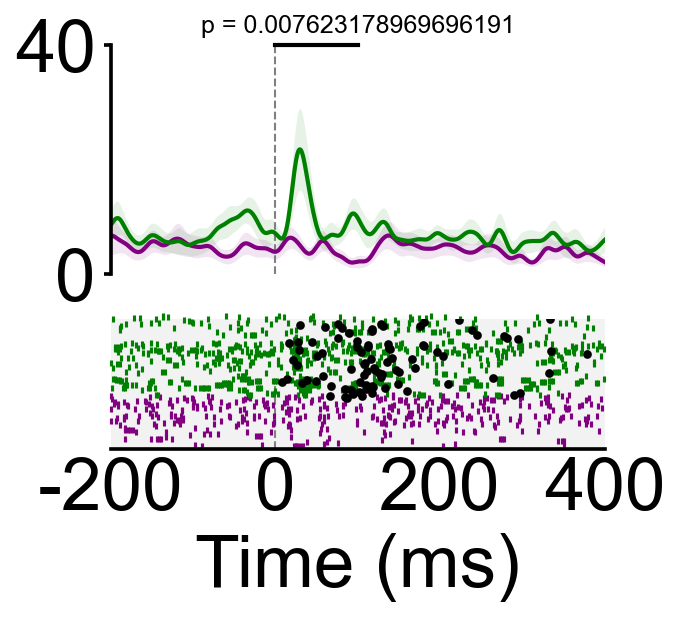

In [24]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
    # skip = True
    # if session == 'BS_40_2_AC.pickle' and clust in [190]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_3_AC.pickle' and clust in [15]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_6_AC.pickle' and clust in [27]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_10_AC.pickle' and clust in [55]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_40_15_AC.pickle' and clust in [0]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_40_16_AC.pickle' and clust in [24]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_5_AC.pickle' and clust in [2]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_8_AC.pickle' and clust in [15]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_9_AC.pickle' and clust in [37]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_41_11_AC.pickle' and clust in [18]:
    #     pass#Removed this day from consideration
    # if session == 'BS_42_2_AC.pickle' and clust in [62]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_3_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [100]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_42_11_AC.pickle' and clust in [44]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_49_1_AC.pickle' and clust in [23,143,150]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_2_AC.pickle' and clust in [6]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [27,68]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_49_4_AC.pickle' and clust in [39]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_49_9_AC.pickle' and clust in [45]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_50_7_AC.pickle' and clust in [12]:
    #     limitToUse = 40
    #     skip = False
    # if session == 'BS_70_7_AC.pickle' and clust in [63]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_70_8_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_72_7_AC.pickle' and clust in [35]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_87_1_AC.pickle' and clust in [30]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_87_4_AC.pickle' and clust in [3]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'BS_108_1_AC.pickle' and clust in [9]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_1_AC.pickle' and clust in [16,59]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'DS_15_12_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_13_AC.pickle' and clust in [41]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_15_AC.pickle' and clust in [113]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_1_AC.pickle' and clust in [1]:
    #     limitToUse = 50
    #     skip = False
    # if session == 'BS_40_2_AC.pickle' and clust in [210]:
    #     limitToUse = 20
    #     skip = False
    # if session == 'BS_42_7_AC.pickle' and clust in [124]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_15_16_AC.pickle' and clust in [23]:
    #     limitToUse = 30
    #     skip = False
    # if session == 'DS_19_14_AC.pickle' and clust in [19]:
    #     limitToUse = 30
    #     skip = False
    # if skip:
    #     continue

    # print(session)
    # if session != 'BS_40_16_AC.pickle':
    #     continue
    # if clust != 26:
    #     continue

    try:
        plt.close('all')
        sessionfile = ilep.loadSessionCached(act_directory,session)
        if sessionfile.meta.task == 'switch':
            print("Skipping Switch")
            continue
        
    #     fig = plt.figure(figsize=(2.75,4.5))#Old Style
        fig = plt.figure(figsize=(4.25,3.5))#New Style
        gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
        
        ax3 = plt.subplot(gs[1,0])#Raster
        ax4 = plt.subplot(gs[0,0])#,sharex=ax3)#PSTH
        ax3.set_facecolor('#F2F2F2')
        
        #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
        
    #     fst=-200
    #     fet=400
    #     xt=[-200,0,200,400]
        fst=-200
        fet=400
        xt=[-200,0,200,400]
        xtl=None#['-200','0','200','400']
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl,bw_scott_factor=15)
        if not success:
            print('Fail')
            continue
        
        #Determine FRmod category
        FRmodCategory = 'ERROR'
        try:
            FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
            if FRmod < 3.5:
                FRmodCategory = 'NCR'
            elif FRmod > 5:
                FRmodCategory = 'CR'
            else:
                FRmodCategory = 'Middle'
        except Exception as e:
            print(e)
            pass
        #Skip unidentified category neurons
        if FRmodCategory in ['ERROR','nan',np.nan]:
            print("FRmodFail Skipping")
            continue
        region = sessionfile.meta.region
        EIL = EILphases[idx]
        #Skip unidentified phase neurons
        if EIL in ['ERROR','nan',np.nan]:
            print("PhaseFail Skipping")
            continue
           
        try:
            if not FRmodCategory == 'ERROR':
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
                fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('C:\\Users\\4thgr\\Documents\\Rasters','FalarmCrejectRastersthin','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        except Exception as e:
            print(e)

    except:
        print('fail')

## Stim Rasters - Pre-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19
BS_108_3_AC.pickle clust 19 Done
CR
switch


11it [00:01,  8.36it/s]

BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44
BS_108_3_AC.pickle clust 44 Done
Middle
switch


13it [00:02,  4.12it/s]

BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131
BS_108_3_AC.pickle clust 131 Done
CR
switch


19it [00:16,  1.21s/it]

BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22
BS_40_14_AC.pickle clust 22 Done
Middle
switch


104it [00:17,  7.80it/s]

BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33
BS_41_1_AC.pickle clust 33 Done
CR
switch


1829it [00:18, 96.30it/s]


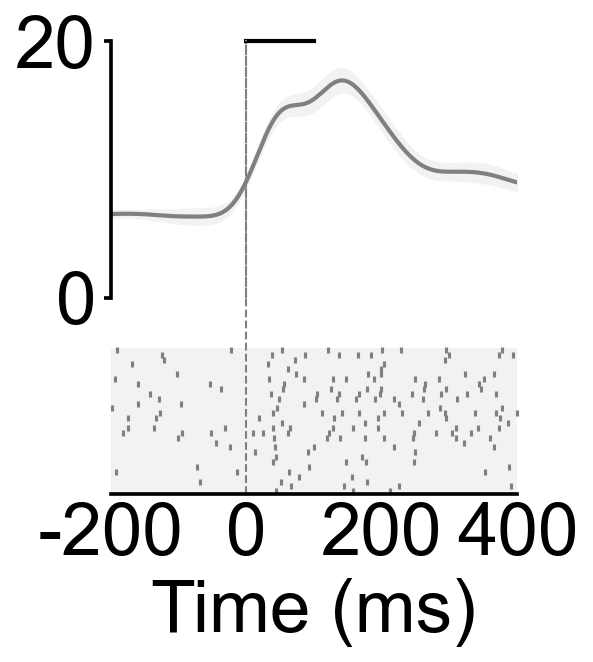

In [94]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
        
    print(f"{session} clust {clust}")
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
        
    print(f"{session} clust {clust}")
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)#,wspace=0.5)#0.1)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    print(f"{session} clust {clust}")
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','+200','+400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='pre_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
        
    print(f"{session} clust {clust}")
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['pre_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust} Done")
    print(FRmodCategory)
    print(EIL)
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Stim Rasters - Post-Switch

0it [00:00, ?it/s]

BS_108_3_AC.pickle clust 19


11it [00:01, 10.04it/s]

BS_108_3_AC.pickle clust 44


13it [00:02,  5.02it/s]

BS_108_3_AC.pickle clust 131


19it [00:03,  5.06it/s]

BS_40_14_AC.pickle clust 22


104it [00:04, 31.15it/s]

BS_41_1_AC.pickle clust 33


1829it [00:05, 313.49it/s]


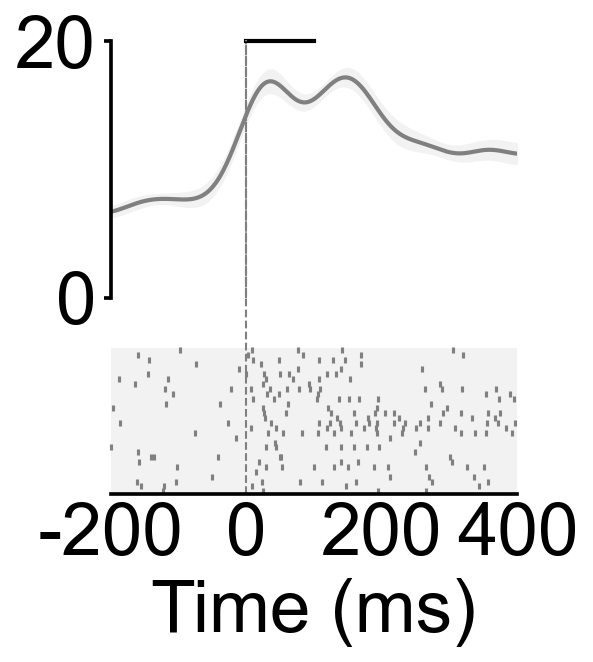

In [95]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    limitToUse = 20
    skip = True
    if session == 'BS_40_14_AC.pickle' and clust in [22]:
        skip = False
    if session == 'BS_41_1_AC.pickle' and clust in [33]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [44]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [131]:
        skip = False
    if session == 'BS_108_3_AC.pickle' and clust in [19]:
        limitToUse = 40
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(2.75,4.5))
    fig = plt.figure(figsize=(3.5,4))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    fst=-200
    fet=400
    xt=[-200,0,200,400]
    xtl=None#['-200','0','200','400']
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,switch_cond='post_switch',limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['post_switch'].FRmodulation
        if FRmod < 1:
            FRmodCategory = 'NCR'
        elif FRmod > 4.5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    print(f"{session} clust {clust}")
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','Fig2StimRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Choice Rasters

1829it [00:38, 47.39it/s] 


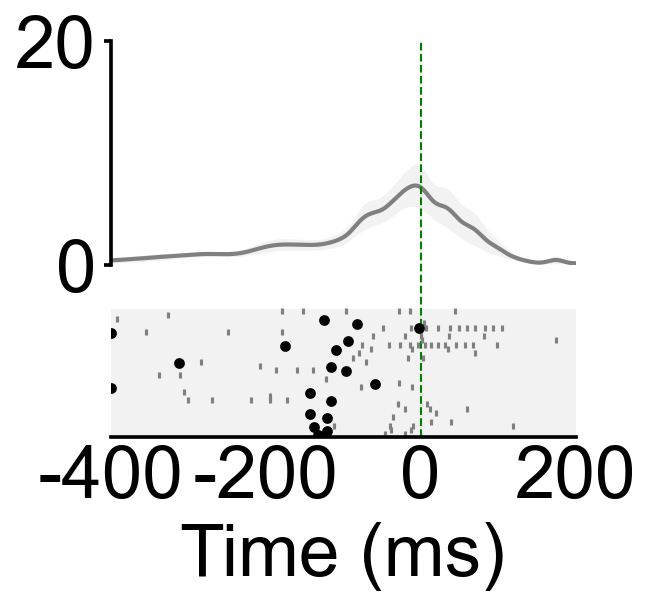

In [99]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    limitToUse = 20
    skip = True
    if session == 'BS_40_2_AC.pickle' and clust in [96,166,194,206,213]:
        if clust == 194:
            limitToUse = 40
        if clust == 96:
            limitToUse = 40
        if clust == 206:
            limitToUse = 40
        skip = False
    if session == 'BS_40_12_AC.pickle' and clust in [57]:
        limitToUse=30
        skip = False
    if session == 'BS_40_22_AC.pickle' and clust in [13]:
        skip = False
    if session == 'BS_41_9_AC.pickle' and clust in [37]:
        skip = False
    if session == 'BS_42_2_AC.pickle' and clust in [118]:
        skip = False
    if session == 'BS_42_4_AC.pickle' and clust in [65]:
        skip = False
    if session == 'BS_42_6_AC.pickle' and clust in [51]:
        limitToUse = 50
        skip = False
    if session == 'BS_42_9_AC.pickle' and clust in [32]:
        skip = False
    if session == 'BS_49_1_AC.pickle' and clust in [82,150]:
        skip = False
    if session == 'BS_49_9_AC.pickle' and clust in [61]:
        skip = False
    if session == 'BS_49_12_AC.pickle' and clust in [39]:
        skip = False
    if session == 'BS_50_2_AC.pickle' and clust in [14]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [3]:
        limitToUse = 40
        skip = False
    if session == 'BS_50_3_AC.pickle' and clust in [16]:
        skip = False
    if session == 'BS_56_4_AC.pickle' and clust in [6]:
        skip = False
    if session == 'BS_50_7_AC.pickle' and clust in [5]:
        skip = False
    if session == 'BS_70_8_AC.pickle' and clust in [3]:
        skip = False
    if session == 'BS_72_1_AC.pickle' and clust in [24,30]:
        skip = False
    if session == 'BS_72_2_AC.pickle' and clust in [7,17]:
        if clust == 7:
            limitToUse = 30
        skip = False
    if session == 'BS_72_4_AC.pickle' and clust in [7,43]:
        skip = False
    if session == 'BS_72_5_AC.pickle' and clust in [22]:
        limitToUse = 50
        skip = False
    if session == 'BS_72_6_AC.pickle' and clust in [23]:
        skip = False
    if session == 'BS_87_4_AC.pickle' and clust in [154]:
        skip = False
    if session == 'BS_87_8_AC.pickle' and clust in [1]:
        skip = False
    if session == 'BS_108_1_AC.pickle' and clust in [9]:
        limitToUse=30
        skip = False
    if session == 'BS_108_6_AC.pickle' and clust in [126]:
        skip = False
    if session == 'DS_15_12_AC.pickle' and clust in [48]:
        limitToUse = 50
        skip = False
    if session == 'DS_15_13_AC.pickle' and clust in [84,113]:
        skip = False
    if session == 'DS_15_14_AC.pickle' and clust in [54]:
        skip = False
    if session == 'DS_19_3_AC.pickle' and clust in [115]:
        skip = False
    if skip:
        continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        continue
    
    fig = plt.figure(figsize=(4,3.5))
    gs = fig.add_gridspec(2,1,height_ratios=[1.75,1],hspace=0.25)
    
    ax4 = plt.subplot(gs[0,0],sharex=ax3)#PSTH
    ax3 = plt.subplot(gs[1,0])#Raster
    ax3.set_facecolor('#F2F2F2')
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    
    fst=-400
    fet=200
    xt=[-400,-200,0,200]
    xtl=None#['-400','-200','0','+200']
    try:
        success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,align_to_choice=True,limitToUse=limitToUse,Figure_start_time_ms=fst,Figure_end_time_ms=fet,xtickstouse=xt,xticklabelstouse=xtl)
    except Exception as e:
        print(e)
        success = False
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','EDF2ChoiceRastersSubset','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Pre-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='pre_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' pre.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

## Choice Rasters - Post-Switch

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):

    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.task == 'switch':
        continue
    
#     fig = plt.figure(figsize=(3,6))
    fig = plt.figure(figsize=(2.75,4.5))
    gs = fig.add_gridspec(2,1,height_ratios=[2,1],hspace=0.125)#,wspace=0.5)#0.1)
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    success,artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,Figure_start_time_ms=-750,Figure_end_time_ms=250,xtickstouse=[-1.0,-0.5,0],align_to_choice=True,switch_cond='post_switch')
    if not success:
        continue
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
        if FRmod < 0.8:
            FRmodCategory = 'NCR'
        elif FRmod > 4:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\TempFigures','EDF2ChoiceRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+' post.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

# Combined Rasters

In [ ]:
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    limitToUse = None#30
    
#     skip = True
#     if session == 'BS_40_2_AC.pickle' and clust in [190]:
#         limitToUse = 20
#         skip = False
#     if skip:
#         continue
    
    plt.close('all')
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.task == 'switch':
        print("Skipping Switch")
        continue
    
    fig = plt.figure(figsize=(10,6.25))#New Style
    gs = fig.add_gridspec(2,2,height_ratios=[1,1],wspace=0.75,hspace=0.25)#Old hspace 0.125 #Old ratios [2,1]
    #Stim
    ax3 = plt.subplot(gs[0,0])#Raster
    ax4 = plt.subplot(gs[1,0],sharex=ax3)#PSTH
    #Choice
    cax3 = plt.subplot(gs[0,1])#Raster
    cax4 = plt.subplot(gs[1,1],sharex=cax3)#PSTH
    
    #visualizeClusterChoiceInternal(sessionfile,clust,ax1,ax2,Figure_start_time_ms='-250',Figure_end_time_ms=1000,xtickstouse=[-250,0,250,500,750,1000],align_to_choice=False,switch_cond='NA'):
    try:
        stim_success,stim_artists = visualizeClusterChoiceInternal(sessionfile,clust,ax3,ax4,limitToUse=limitToUse,Figure_start_time_ms=-50,Figure_end_time_ms=150,xtickstouse=[-50,0,50,100,150])
    except:
        stim_success = False
    if not stim_success:
        continue
    try:
        choice_success,choice_artists = visualizeClusterChoiceInternal(sessionfile,clust,cax3,cax4,limitToUse=limitToUse,align_to_choice=True,Figure_start_time_ms=-150,Figure_end_time_ms=50,xtickstouse=[-150,-100,-50,0,50])
    except:
        choice_success = False
    if not choice_success:
        continue
    
    FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    Choicemod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
    
    ttl1 = ax3.set_title(FRmod)
    ttl2 = cax3.set_title(Choicemod)
    
    #Determine FRmod category
    FRmodCategory = 'ERROR'
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
        if FRmod < 3.5:
            FRmodCategory = 'NCR'
        elif FRmod > 5:
            FRmodCategory = 'CR'
        else:
            FRmodCategory = 'Middle'
    except Exception as e:
        print(e)
        pass
    #Skip unidentified category neurons
    if FRmodCategory in ['ERROR','nan',np.nan]:
        print("FRmodFail Skipping")
        continue
    region = sessionfile.meta.region
    EIL = EILphases[idx]
    #Skip unidentified phase neurons
    if EIL in ['ERROR','nan',np.nan]:
        print("PhaseFail Skipping")
        continue
        
#     break
    try:
        if not FRmodCategory == 'ERROR':
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,EIL,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
            fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters',FRmodCategory,'pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pdfs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
        fig.savefig(os.path.join('D:\\\\Rasters','CombinedRasters','pngs',ilep.generateDateString(sessionfile)+' '+str(clust)+'.png'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')
    except Exception as e:
        print(e)

16it [01:10,  1.55s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


22it [01:10,  1.59it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


28it [01:10,  3.30it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


34it [01:11,  5.67it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


37it [01:11,  7.38it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


40it [01:11,  9.24it/s]

Skipping Switch
Skipping Switch


105it [15:30,  1.32it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


113it [15:30,  3.89it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


121it [15:30,  7.99it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


124it [15:30,  9.96it/s]

Skipping Switch


302it [1:01:39, 12.78s/it]

PhaseFail Skipping


303it [1:01:41,  9.72s/it]

PhaseFail Skipping


304it [1:01:50,  9.39s/it]

PhaseFail Skipping


305it [1:01:54,  7.70s/it]

PhaseFail Skipping


306it [1:01:56,  6.20s/it]

PhaseFail Skipping


307it [1:01:59,  5.15s/it]

PhaseFail Skipping


308it [1:02:01,  4.37s/it]

PhaseFail Skipping


309it [1:02:06,  4.32s/it]

PhaseFail Skipping


310it [1:02:08,  3.80s/it]

PhaseFail Skipping


311it [1:02:11,  3.37s/it]

PhaseFail Skipping


312it [1:02:14,  3.23s/it]

PhaseFail Skipping


313it [1:02:16,  3.02s/it]

PhaseFail Skipping


314it [1:02:17,  2.37s/it]

PhaseFail Skipping


315it [1:02:19,  2.37s/it]

PhaseFail Skipping


316it [1:02:22,  2.51s/it]

PhaseFail Skipping


319it [1:02:25,  1.45s/it]

PhaseFail Skipping
Skipping Switch
Skipping Switch
Skipping Switch


323it [1:02:25,  1.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


327it [1:02:26,  3.33it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


331it [1:02:26,  5.68it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


335it [1:02:26,  8.48it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


339it [1:02:27, 11.13it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


343it [1:02:27, 12.84it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


347it [1:02:27, 14.36it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


351it [1:02:27, 15.02it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


355it [1:02:28, 15.11it/s]

Skipping Switch
Skipping Switch
Skipping Switch


477it [1:42:23,  1.60s/it]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


485it [1:42:24,  1.60it/s]

Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch
Skipping Switch


646it [2:50:03, 26.25s/it]

In [35]:
A

[[0, 1, 2],
 [1, 2, 3],
 [2, 3, 4],
 [3, 4, 5],
 [4, 5, 6],
 [5, 6, 7],
 [6, 7, 8],
 [7, 8, 9],
 [8, 9, 10],
 [9, 10, 11]]

In [34]:
A = [ [a,a+1,a+2] for a in range(10)]

In [36]:
kf = KFold(n_splits=10)
for idx,(_,train_index) in enumerate(kf.split(A)):
    print(train_index)
    print(A[train_index])

[0]


TypeError: only integer scalar arrays can be converted to a scalar index